Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433

* https://www.kaggle.com/c/lish-moa/discussion/193878

* https://tsumit.hatenablog.com/entry/2020/06/20/044835

* https://www.kaggle.com/kushal1506/moa-pytorch-feature-engineering-0-01846

* https://www.kaggle.com/c/lish-moa/discussion/195195


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break
# Version = "v32" # y_prob.probability.quantile(0.3), if Threshold >= 0.95: break
# Version = "v33" # RankGauss, Scaled by category, SMOTE(k_neighbors=2),
# Version = "v34" # RankGauss apply c-columns, remove TOP100, Add f_diff = lambda x: x - med, Create features
# Version = "v35" # f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2, f_diff = lambda x: ((x-med)*10)**2, select features
# Version = "v36" # Add feature importance func
# Version = "v37" # Remove RankGauss for gene expression, fix feature importance func
# Version = "v38" # Add MultiLabel Stratification func, fix index of data before split with "data = data.sort_index(axis='index')""
# Version = "v39" # fix pseudo labeling func
# Version = "v40" # fix pseudo labeling func, create importance_cols_df with all columns
# Version = "v41" # Feature engineering based on Feature importance with v39 notebook
# Version = "v42" # Feature engineering based on Feature importance with v40 notebook
# Version = "v40.2" # Select, update fe_stats func based on v40 note book
# Version = "v42.1" # Remove Kolmogorov-Smirnov test and VarianceThreshold for inference, Threshold = np.quantile(y_prob, q=0.99)
# Version = "v43" # Inference, modify pseudo labeling func: lower, upper, change param 3→2.1
# Version = "v44.1" # Select,　I don't know what to do in select notebook.
# Version = "v44.2" # inference used v40.2 note book(updated fe_stats func), DEBUG=False, modify  eature_Engineering func, check*(3.5-len(str(int(check))))
# Version = "v45" # inference used v40.2, DEBUG=False, Add create_features func,  learning_rate(pseudo labeling): 0.01→0.02
# Version = "v46" # Select, Add 'g_d_g', 'c_d_c', 'g_df_g', 'c_df_c', 'd_g_df_g', 'd_c_df_c' to the kind_list, VarianceThreshold(0.91) 
# Version = "v48" # inference used v46, DEBUG=False, modify Feature_Engineering func
# Version = "v49" # inference used v46, DEBUG=False, create_features(func="mean")
# Version = "v50" # Select, QuantileTransformer(n_quantiles=100), select_importance_cols(num=50)
# Version = "v51" # Select, QuantileTransformer(n_quantiles=defalt), select_importance_cols(num=100)
# Version = "v52" # inference used v46, adjust params in pseudo_labeling func

Version = "v53" # Select, VarianceThreshold(0.98), select_importance_cols(num=200)

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("imblearn Version: ", imblearn.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)

lightgbm Version:  2.3.1
imblearn Version:  0.7.0
numpy Version:  1.18.5
pandas Version:  1.1.3


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

# New data file available from 3th November
drug = pd.read_csv('../input/lish-moa/train_drug.csv')

In [7]:
Targets = train_targets_scored.columns[1:]
Scored = train_targets_scored.merge(drug, on='sig_id', how='left')
Scored

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0      id_000644bb2                            0                       0   
1      id_000779bfc                            0                       0   
2      id_000a6266a                            0                       0   
3      id_0015fd391                            0                       0   
4      id_001626bd3                            0                       0   
...             ...                          ...                     ...   
23809  id_fffb1ceed                            0                       0   
23810  id_fffb70c0c                            0                       0   
23811  id_fffc1c3f4                            0                       0   
23812  id_fffcb9e7c                            0                       0   
23813  id_ffffdd77b                            0                       0   

       acat_inhibitor  acetylcholine_receptor_agonist  \
0                   0                               0   
1                   0                               0   
2                   0                               0   
3                   0                               0   
4                   0                               0   
...               ...                             ...   
23809               0                               0   
23810               0                               0   
23811               0                               0   
23812               0                               0   
23813               0                               0   

       acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                      0                               0   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               0   
...                                  ...                             ...   
23809                                  0                               0   
23810                                  0                               0   
23811                                  0                               0   
23812                                  0                               0   
23813                                  0                               0   

       adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   
...                           ...                            ...   
23809                           0                              0   
23810                           0                              0   
23811                           0                              0   
23812                           0                              0   
23813                           0                              0   

       adenylyl_cyclase_activator  ...  trpv_agonist  trpv_antagonist  \
0                               0  ...             0                0   
1                               0  ...             0                0   
2                               0  ...             0                0   
3                               0  ...             0                0   
4                               0  ...             0                0   
...                           ...  ...           ...              ...   
23809                           0  ...             0                0   
23810                           0  ...             0                0   
23811                       

In [8]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    
    return train, test

In [9]:
# Manual annotation by myself
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

sig_id  \
0                   adenylyl_cyclase_activator   
1             aldehyde_dehydrogenase_inhibitor   
2                               antiarrhythmic   
3                               anticonvulsant   
4                                   antifungal   
5                                antihistamine   
6   atp-sensitive_potassium_channel_antagonist   
7       bacterial_membrane_integrity_inhibitor   
8                        calcineurin_inhibitor   
9       catechol_o_methyltransferase_inhibitor   
10                               cdk_inhibitor   
11                coagulation_factor_inhibitor   
12                          elastase_inhibitor   
13                             erbb2_inhibitor   
14                  nicotinic_receptor_agonist   
15           nitric_oxide_production_inhibitor   
16               protein_phosphatase_inhibitor   
17                sphingosine_receptor_agonist   
18                                     steroid   
19       ubiquitin_specific_protease_inhibitor   

                                   nonscored1  \
0                  adenylyl_cyclase_inhibitor   
1             alcohol_dehydrogenase_inhibitor   
2                       na_k-atpase_inhibitor   
3         gaba_gated_chloride_channel_blocker   
4                 fungal_ergosterol_inhibitor   
5                 histamine_release_inhibitor   
6   atp-sensitive_potassium_channel_inhibitor   
7       bacterial_protein_synthesis_inhibitor   
8                            t_cell_inhibitor   
9                   dopamine_release_enhancer   
10                         cyclin_d_inhibitor   
11                       vitamin_k_antagonist   
12               leukocyte_elastase_inhibitor   
13          protein_tyrosine_kinase_inhibitor   
14             acetylcholine_release_enhancer   
15                                vasodilator   
16             tyrosine_phosphatase_inhibitor   
17   sphingosine_1_phosphate_receptor_agonist   
18                          anti-inflammatory   
19     ubiquitin-conjugating_enzyme_inhibitor   

                                 nonscored2  
0                                       NaN  
1                                       NaN  
2                 potassium_channel_blocker  
3                                       NaN  
4   fungal_lanosterol_demethylase_inhibitor  
5                                       NaN  
6                                       NaN  
7                                       NaN  
8                                       NaN  
9                                       NaN  
10                                      NaN  
11                                      NaN  
12                                      NaN  
13                                      NaN  
14                                      NaN  
15                                      NaN  
16                                      NaN  
17                                      NaN  
18                                      NaN  
19                                      NaN

In [10]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [11]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  ...  ve-cadherin_antagonist  \
0                           0  ...                       0   
1                           0  ...                       0   
2                           0  ...                       0   
3                           0  ...                       0   
4                           0  ...                       0   

   vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
0                                          0                     0   
1                                          0                     0   
2                                          0                     0   
3                                          0                     0   
4                                          0                     0   

   voltage-gated_calcium_channel_ligand  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   voltage-gated_potassium_channel_activator  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   voltage-gated_sodium_channel_blocker  wdr5_mll_interaction_inhibitor  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   wnt_agonist  xanthine_oxidase_inhibitor  xiap_inhibitor  
0            0                           0               0  
1            0                           0               0  
2            0                           0               0  
3            0                           0               0  
4            0                           0               0  

[5 rows x 610 columns]

# Training Utils

In [12]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [13]:
def Multi_Stratification(df, target_col, target):
    
    _df = df.copy() 
    sig_id_lst = [list(Scored.sig_id[Scored.drug_id == id_].sample())[0] for id_ in Scored.drug_id.unique()]
    
    # Remove sig_id wih target 
    del_idx = train[target==1].sig_id.unique()
    select_idx = [i for i in sig_id_lst if i not in del_idx]
    print(f"neg labels: {len(sig_id_lst)} → selected neg labels: {len(select_idx)}")
    
    # Select negative target
    _df = _df.set_index('sig_id')
    _df = _df.loc[select_idx, :]
    _df = _df.reset_index(drop=True)
    
    _df["target"] = 0
    
    return _df

In [14]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    # Estimate test target rate
    Adj_target_rate = (2*target_rate)/(target.sum()**0.15)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    othr =  Multi_Stratification(train, target_col, target)
    
    logger.info(f"{target_col}, len(trt): {len(trt)}, len(othr): {len(othr)}, target_rate: {target_rate:.7f} → Adj_target_rate: {Adj_target_rate:.7f}")
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)   
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)
    
    if len(trt) < len(othr)*0.2:
        sm = SMOTE(0.2, k_neighbors=3, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
        pos_neg_ratio = 0.8
    else:
        pos_neg_ratio = 1-(len(trt)/len(othr))
     
    X_test = test.drop("sig_id", axis=1)
    feature_importance_df_ = pd.DataFrame()
    
    train_X, train_y, feature_importance_df_ = pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr, X_val = train_X.loc[train_index, :], train_X.loc[valid_index, :]
        y_tr, y_val = train_y[train_index], train_y[valid_index]
        lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_cols)
        lgb_eval = lgb.Dataset(X_val,y_val, reference=lgb_train,categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        
        if DEBUG:
            models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")
    
    return sum(y_preds) / len(y_preds), score, models, feature_importance_df_

In [15]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    
    _df = df.copy()
    Probability = _df.iloc[:, 0]
    
    # Remove low confidence labels
    conf_index = _df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': 0.03,
    'objective': "binary",
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'subsample_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': SEED,
    'n_jobs': 3,
}

In [17]:
#===========================================================
# pseudo_labeling
#===========================================================

def pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    feature_importance_df = pd.DataFrame()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = X.columns
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
            
            # feature importance with target col
            _importance_df["importance"] = clf.feature_importances_
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        if iter_ == 1:
            quantile = pos_neg_ratio
            Threshold = np.quantile(y_prob, q=0.98)
        else:
            quantile = 1-y_label_rate
        
        y_Threshold = y_preds.iloc[:, 1].quantile(quantile)
        logger.info(f"y_Threshold: {y_Threshold:.7f}, Threshold: {Threshold:.7f}, pos_neg_ratio: {pos_neg_ratio:.7f}")
            
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < y_Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= y_Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → Positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        high_conf_0, high_conf_1 = Threshold*0.9, Threshold*1.1
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.7f} Vs.target_rate: {target_rate:.5f}")
        logger.info(f"Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        
        if (p_label_rate*3) < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label)*2 >= check) or ((Threshold-0.01) <= 0): break 
                Threshold -= 0.01
                high_conf_0, high_conf_1 = Threshold*0.9, Threshold*1.1
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > (target_rate*3):
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label) <= check*2) or ((Threshold+0.01) >= 1.0): break
                Threshold += 0.01
                high_conf_0, high_conf_1 = Threshold*0.9, min(Threshold*1.1, 0.99)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ != max_iter:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
        else:
            X_conf = X_test.copy()
            
        logger.info(f"threshold: {Threshold:.7f}, positive_p_label: {sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.7f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        y_label_rate = sum(y)/len(y)
        
        logger.info(f"positive_y_label: {sum(y)}/{len(y)}, y_label_rate: {y_label_rate:.7f}")
        
    if DEBUG:
        show_feature_importance(feature_importance_df, target_col, num=10)
        
    return X, y, feature_importance_df

In [18]:
def show_feature_importance(feature_importance_df, title="all", num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    hight = int(num//3.3)
    plt.figure(figsize=(8, hight))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{title}_Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./{title}_feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [19]:
train.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  
3 -1.6210 -0.8784 -0.3876 -0.8154  
4  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 876 columns]

In [20]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [21]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [22]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.2991   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.5540   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.2656   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.9700   
...             ...      ...      ...      ...     ...     ...     ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.3930   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.5850   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.2677   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.3286   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
0     -0.6208 -0.1944 -1.0120  ...  0.2584  0.8076  0.5523 -0.1912  0.6584   
1      0.0604  1.0190  0.5207  ...  0.7543  0.4708  0.0230  0.2957  0.4899   
2     -0.0764 -0.0323  1.2390  ... -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3      0.5288  4.0620 -0.8095  ... -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4      0.6919  1.4180 -0.8244  ...  0.0048  0.6670  1.0690  0.5523 -0.3031   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
27791 -0.6202  0.8557  1.6240  ... -0.6422 -0.4367  0.0159 -0.6539 -0.4791   
27792  0.3456  0.4401  0.3107  ...  0.5780 -0.5888  0.8057  0.9312  1.2730   
27793 -0.6813  0.0152  0.4791  ...  0.9153 -0.1862  0.4049  0.9568  0.4666   
27794  1.0160 -1.3350 -0.2207  ... -0.4473 -0.8192  0.7785  0.3133  0.1286   
27795 -0.0428 -0.0800  0.8702  ...  0.1708  0.5939 -0.0507  0.2811 -0.4041   

         c-96    c-97    c-98    c-99  WHERE  
0     -0.3981  0.2139  0.3801  0.4176  train  
1      0.1522  0.1241  0.6077  0.7371  train  
2     -0.6417 -0.2187 -1.4080  0.6931  train  
3     -1.6210 -0.8784 -0.3876 -0.8154  train  
4      0.1094  0.2885 -0.3786  0.7125  train  
...       ...     ...     ...     ...    ...  
27791 -1.2680 -1.1280 -0.4167 -0.6600   test  
27792  0.2614 -0.2790 -0.0131 -0.0934   test  
27793  0.0461  0.5888 -0.4205 -0.1504   test  
27794 -0.2618  0.5074  0.7430 -0.0484   test  
27795 -0.4948  0.0757 -0.1356  0.5280   test  

[27796 rows x 877 columns]

In [23]:
# Select control data
ctl = train[(train.cp_type==0)].copy()
ctl = ctl.reset_index(drop=True)
ctl

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2     g-3  \
0     id_0054388ec        0        1        0 -0.6696 -0.2718 -1.2230 -0.6226   
1     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211  0.3054   
2     id_007bfbb91        0        0        1 -1.3200 -1.7340 -0.0741  1.5440   
3     id_008a986b7        0        1        1  0.4860  0.1430  0.5281 -0.0022   
4     id_009d8340f        0        0        1  0.4471 -0.0839 -0.3864  0.3196   
...            ...      ...      ...      ...     ...     ...     ...     ...   
1861  id_ff1f9e5fc        0        0        0  0.0465  0.6430 -0.2453  0.3521   
1862  id_ff469c482        0        2        0 -0.6204 -1.3800 -1.1880 -0.6573   
1863  id_ff89331ca        0        2        1 -0.1051  0.4335  0.3648 -0.0525   
1864  id_ffd26f361        0        1        1  0.6008  0.2781 -0.3319 -0.8782   
1865  id_fffc1c3f4        0        1        1  0.3942  0.3756  0.3109 -0.7389   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -1.1280  0.6041  ... -0.6828 -0.6594 -0.2043  0.3571 -0.1319  0.2187   
2    -1.8290 -0.0951  ...  1.0340  0.7393  1.1020  0.3786  0.2636 -0.5751   
3    -0.2334 -0.6607  ... -0.1866  0.7629  0.3288 -0.9915 -0.3694 -0.4979   
4     0.2584 -0.3156  ...  0.3939  0.7665  0.7932 -0.6804 -0.0435  0.0949   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  0.6195 -0.6659  ...  0.1621 -0.2065  0.8314 -0.1891 -0.0074  0.2131   
1862 -0.8408 -0.2447  ...  0.7366  0.5468  1.1450  0.5254  0.6224 -0.9630   
1863 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   
1864  0.9281  0.7535  ...  0.9569 -0.2065 -0.4918  0.7863  0.0504  0.8813   
1865  0.5505 -0.0159  ...  0.3755  0.7343  0.2807  0.4116  0.6422  0.2256   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.0737  0.6498 -1.4820  train  
2     0.3362  0.8543  0.9180  train  
3     0.5281 -0.9245 -0.9367  train  
4     0.2000 -0.4326  0.9364  train  
...      ...     ...     ...    ...  
1861 -0.1419 -0.2422  0.0457  train  
1862  0.8872 -0.0742 -0.6777  train  
1863 -0.8110 -0.1748 -0.3626  train  
1864  0.7757 -0.5272  0.7082  train  
1865  0.7592  0.6656  0.3808  train  

[1866 rows x 877 columns]

In [24]:
# clipping for control data

def outlier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


sig_id cp_type cp_time cp_dose     g-0      g-1     g-2     g-3  \
0     id_0054388ec       0       1       0 -0.6696 -0.27180 -1.2230 -0.6226   
1     id_01b05de6c       0       1       0 -0.3176  0.48512 -0.3773  0.5555   
2     id_020ba48d9       0       1       0  0.8094 -0.33390  1.1130 -0.4192   
3     id_02c93b4a5       0       1       0 -0.0884 -1.54100  0.5562  0.4661   
4     id_03bc6d412       0       1       0  0.8431  0.09310 -0.0958 -0.4337   
...            ...     ...     ...     ...     ...      ...     ...     ...   
1861  id_fbb620181       0       2       1 -0.3490  0.72970 -4.1480 -1.0030   
1862  id_fbba92030       0       2       1 -0.8921  1.13520  0.4227  1.3270   
1863  id_fbc0849ad       0       2       1 -0.2948  0.21960 -0.3252 -0.2084   
1864  id_fd93fa37d       0       2       1 -0.2984 -0.47880 -2.3560 -0.6848   
1865  id_ff89331ca       0       2       1 -0.1051  0.43350  0.3648 -0.0525   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -0.4877  0.3413  ... -0.6163  0.8001  0.3389  0.7437  0.7533  0.2406   
2     0.4545 -0.4771  ... -0.4414 -0.2442  0.0557 -0.6597 -0.3713 -0.6929   
3    -0.1683  0.9515  ...  0.4766  0.9697  0.4613  0.8957  0.8227  1.2300   
4     1.0690 -0.6440  ... -1.1510 -0.5010 -0.2736  0.1270  0.3511  0.1233   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  2.4070 -0.9784  ... -1.4260 -0.8613 -0.0243 -0.6109  0.6377 -1.2590   
1862 -0.9839 -0.8469  ...  1.1340  0.7007  1.3320  0.6622  0.6167  0.9459   
1863 -0.6518  0.3542  ...  0.5014  0.6009  0.4560 -0.3360 -0.5091  0.6569   
1864  1.8700  1.0240  ... -0.4422 -0.6665 -0.8033 -1.0520  0.4103  0.4462   
1865 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.5057  0.8017  1.0280  train  
2    -0.3258  0.3602 -0.0595  train  
3     1.7180  0.6542  0.0580  train  
4    -0.8520  0.1767  0.1153  train  
...      ...     ...     ...    ...  
1861 -0.7238 -0.7734 -0.1274  train  
1862 -0.0344 -0.0186  0.5173  train  
1863  0.6203  0.6764  0.4504  train  
1864 -1.1580 -1.3060  0.1925  train  
1865 -0.8110 -0.1748 -0.3626  train  

[1866 rows x 877 columns]

In [25]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in tqdm(data.cp_time.unique()):
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']): Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        
        f_div = lambda x: ((10*x+d)/(med+d))**3
        select_div = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select, select_div], axis=1, sort=False)
        
        
        f_diff = lambda x: ((x-med)*10)**2
        select_diff = select.iloc[:,4:].apply(f_diff, axis=1).add_prefix('df_')
        tmp_data = pd.concat([tmp_data, select_diff], axis=1, sort=False)
        
        data_df = pd.concat([data_df, tmp_data], axis=0)
        
data_df

4534
4538
4561
4536
5079
4548



sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [26]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]

# clipping
clipping = data_df.columns[4+len(g_list):]
for col in tqdm(clipping):
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data = data_df.copy()
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.6208 -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      0.2277  1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.4438 -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38     0.3054 -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39    -1.1990  0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...     ...  ...          ...          ...          ...   
27754  0.7702 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759 -1.4950  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768  1.2300 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784 -0.6764  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794  1.0160 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [28]:
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]
df_g_list = [col for col in data.columns[4:] if col.startswith("df_g-")]
df_c_list = [col for col in data.columns[4:] if col.startswith("df_c-")]

g_d_g_list = g_list + d_g_list 
c_d_c_list = c_list + d_c_list

g_df_g_list = g_list + df_g_list
c_df_c_list = c_list + df_c_list

d_g_df_g_list = d_g_list + df_g_list
d_c_df_c_list = d_c_list + df_c_list

g_all_list = g_list + d_g_list + df_g_list
c_all_list = c_list + d_c_list + df_c_list

In [29]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
    
# Z-score
# scaler = StandardScaler(with_mean=True, with_std=True)

# RankGauss
scaler = QuantileTransformer(output_distribution='normal', random_state=SEED)

# Without Z-scored gene expression data
for col in tqdm(data.columns[4+len(g_list):]):
    
    size = len(data[col].values)
    
    raw = data[col].values.reshape(size, 1)
    scaler.fit(raw)

    data[col] = scaler.transform(raw).reshape(1, size)[0]
    
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0     -0.6208 -0.1944 -1.0120  ... -1.810818 -1.556684  0.248606 -1.083179   
5      0.2277  1.2810  0.5203  ...  1.204512  0.578443  1.006571  1.139912   
36    -0.4438 -0.5992 -0.2523  ...  0.722254 -0.057595 -0.552164 -0.559241   
38     0.3054 -1.1280  0.6041  ...  0.374101  0.776318  0.609079  0.186897   
39    -1.1990  0.4869 -0.0935  ...  1.545960  1.713131  1.361963  1.543328   
...       ...     ...     ...  ...       ...       ...       ...       ...   
27754  0.7702 -0.1861  0.3608  ... -0.147978  0.572841 -1.187832 -0.046089   
27759 -1.4950  0.6673 -1.5380  ...  1.145838  0.589930  1.501425  0.751316   
27768  1.2300 -0.5804  0.0633  ... -1.310017 -1.616881 -0.099856  0.290319   
27784 -0.6764  0.1435 -1.6810  ...  0.949547  0.513294 -0.572693  0.836947   
27794  1.0160 -1.3350 -0.2207  ... -1.093272  0.292672  0.617046  0.026101   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.184056 -0.422826  0.452858 -1.087786 -1.717424 -1.652775  
5      0.620313 -1.168574  0.544603 -1.732771 -0.122754  0.767287  
36    -0.181398 -0.197771 -0.918947  0.003369 -1.947569 -1.204362  
38    -1.233969 -0.059989 -0.958117 -0.570161 -0.453190  1.387738  
39     1.492319  1.588429  1.517699  1.513423  1.721750  0.753663  
...         ...       ...       ...       ...       ...       ...  
27754 -0.472173  0.185676 -0.600581  0.372026 -1.536801  0.434025  
27759  1.638799  1.135045  1.459280  1.082334  1.356379  1.247627  
27768  0.222431  0.772244 -0.884043 -1.473699  1.308167  0.237404  
27784  0.502350  1.305647  1.236926  1.021927  0.945616  1.153026  
27794 -1.747524 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309  

[27796 rows x 2620 columns]

In [30]:
feature_list = (g_list, 
                c_list, 
                d_g_list, 
                d_c_list, 
                df_g_list,
                df_c_list, 
                g_d_g_list, 
                c_d_c_list, 
                g_df_g_list, 
                c_df_c_list, 
                d_g_df_g_list, 
                d_c_df_c_list,
                g_all_list, 
                c_all_list)


kind_list = ('g', 
             'c', 
             'd_g', 
             'd_c', 
             'df_g', 
             'df_c',  
             'g_d_g', 
             'c_d_c', 
             'g_df_g', 
             'c_df_c', 
             'd_g_df_g', 
             'd_c_df_c',
             'g_all', 
             'c_all')

In [31]:
std_df = data.iloc[:, 4:].copy()

In [32]:
N_bin = 7

for col_ in tqdm(std_df.columns):
    std_df[f"cut_{col_}"] = pd.cut(std_df[col_], N_bin, labels=False)

# Count bin_cnt types
for i in tqdm(range(N_bin-1, -1, -1)):
    std_df[f"bin_cnt_{i}"] = std_df.apply(lambda x: (x == i).sum(), axis=1)
std_df

g-0     g-1     g-2     g-3     g-4     g-5     g-6     g-7     g-8  \
0      1.0620  0.5577 -0.2479 -0.6208 -0.1944 -1.0120 -1.0220 -0.0326  0.5548   
5     -0.6111  0.2941 -0.9901  0.2277  1.2810  0.5203  0.0543 -0.2225 -0.1586   
36    -0.4026  0.1662 -0.6307 -0.4438 -0.5992 -0.2523 -1.3770 -0.7637 -1.4880   
38    -0.1636 -1.8230 -0.5211  0.3054 -1.1280  0.6041  0.3856 -0.1670 -0.5400   
39     1.6310 -2.1430 -0.0943 -1.1990  0.4869 -0.0935  1.2090 -3.8910 -1.5450   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
27754 -0.4157 -0.0461 -0.9751  0.7702 -0.1861  0.3608  0.5174 -0.1344  0.9298   
27759  0.7107 -0.3274 -0.0099 -1.4950  0.6673 -1.5380 -0.5368 -5.0720  2.1020   
27768 -0.0776  0.4437 -0.1530  1.2300 -0.5804  0.0633  0.6952 -0.7427 -0.1058   
27784 -1.0740  0.7350  0.3304 -0.6764  0.1435 -1.6810 -1.1370 -0.0526 -0.4083   
27794 -1.0960 -1.7750 -0.3977  1.0160 -1.3350 -0.2207 -0.3611 -1.3020  1.0150   

          g-9  ...  cut_df_c-97  cut_df_c-98  cut_df_c-99  bin_cnt_6  \
0     -0.0921  ...            2            2            2         14   
5      0.4289  ...            2            3            4         24   
36    -0.1970  ...            3            2            2         11   
38     0.2721  ...            3            3            4         12   
39    -2.2870  ...            4            4            4         69   
...       ...  ...          ...          ...          ...        ...   
27754 -0.1501  ...            3            2            3          5   
27759 -2.5410  ...            4            4            4         48   
27768  0.8812  ...            2            4            3         31   
27784  1.0340  ...            4            4            4         17   
27794  0.6747  ...            2            3            3         13   

       bin_cnt_5  bin_cnt_4  bin_cnt_3  bin_cnt_2  bin_cnt_1  bin_cnt_0  
0             72        521       1347        580         62         21  
5             98        620       1268        524         67         18  
36            64        541       1313        579         82         29  
38            79        561       1323        552         65         25  
39            91        874        676        754        100         53  
...          ...        ...        ...        ...        ...        ...  
27754         78        512       1317        614         72         23  
27759        101        866        819        644         98         41  
27768         87        649       1178        571         69         34  
27784         62        573       1177        680         91         17  
27794         88        636       1246        535         79         22  

[27796 rows x 5239 columns]

In [33]:
n_clusters = 7

def create_cluster(data, features, n_clusters):
    
    from sklearn.cluster import KMeans
    
    _data = data[features].copy()
    kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(_data)
    cluster_label = kmeans.labels_[:_data.shape[0]]
 
    return cluster_label


def detect_cluster(data, feature_list, kind_list, n_clusters):
    
    _data = data.copy()
    
    for idx, feature in enumerate(tqdm(feature_list)):
        _data[f'clusters_{kind_list[idx]}'] = create_cluster(data, feature, n_clusters=n_clusters)
    
    _data = _data.iloc[:, -len(feature_list):].copy()
    
    return _data

In [34]:
clusters = detect_cluster(data, feature_list, kind_list, n_clusters)
clusters

clusters_g  clusters_c  clusters_d_g  clusters_d_c  clusters_df_g  \
0               5           2             0             0              1   
5               1           3             0             4              6   
36              1           2             1             0              6   
38              6           0             4             0              1   
39              3           5             2             2              2   
...           ...         ...           ...           ...            ...   
27754           5           0             0             0              1   
27759           0           5             2             2              0   
27768           5           0             4             0              3   
27784           6           4             1             5              3   
27794           6           2             4             0              3   

       clusters_df_c  clusters_g_d_g  clusters_c_d_c  clusters_g_df_g  \
0                  2               4               1                2   
5                  1               4               6                4   
36                 2               3               5                4   
38                 4               1               5                4   
39                 0               5               3                0   
...              ...             ...             ...              ...   
27754              4               4               5                2   
27759              0               5               3                3   
27768              4               1               5                2   
27784              1               3               2                6   
27794              2               1               5                6   

       clusters_c_df_c  clusters_d_g_df_g  clusters_d_c_df_c  clusters_g_all  \
0                    4                  3                  3               0   
5                    3                  5                  1               0   
36                   1                  5                  3               0   
38                   5                  5                  3               6   
39                   0                  6                  2               4   
...                ...                ...                ...             ...   
27754                1                  3                  3               0   
27759                2                  6                  2               1   
27768                1                  3                  3               0   
27784                2                  0                  4               6   
27794                1                  0                  3               6   

       clusters_c_all  
0                   5  
5                   3  
36                  5  
38                  0  
39                  1  
...               ...  
27754               0  
27759               1  
27768               0  
27784               4  
27794               5  

[27796 rows x 14 columns]

In [35]:
# Count cluster types
for i in tqdm(range(n_clusters-1, -1, -1)):
    clusters[f"cnt_{i}"] = clusters.apply(lambda x: (x == i).sum(), axis=1)
clusters

clusters_g  clusters_c  clusters_d_g  clusters_d_c  clusters_df_g  \
0               5           2             0             0              1   
5               1           3             0             4              6   
36              1           2             1             0              6   
38              6           0             4             0              1   
39              3           5             2             2              2   
...           ...         ...           ...           ...            ...   
27754           5           0             0             0              1   
27759           0           5             2             2              0   
27768           5           0             4             0              3   
27784           6           4             1             5              3   
27794           6           2             4             0              3   

       clusters_df_c  clusters_g_d_g  clusters_c_d_c  clusters_g_df_g  \
0                  2               4               1                2   
5                  1               4               6                4   
36                 2               3               5                4   
38                 4               1               5                4   
39                 0               5               3                0   
...              ...             ...             ...              ...   
27754              4               4               5                2   
27759              0               5               3                3   
27768              4               1               5                2   
27784              1               3               2                6   
27794              2               1               5                6   

       clusters_c_df_c  ...  clusters_d_c_df_c  clusters_g_all  \
0                    4  ...                  3               0   
5                    3  ...                  1               0   
36                   1  ...                  3               0   
38                   5  ...                  3               6   
39                   0  ...                  2               4   
...                ...  ...                ...             ...   
27754                1  ...                  3               0   
27759                2  ...                  2               1   
27768                1  ...                  3               0   
27784                2  ...                  4               6   
27794                1  ...                  3               6   

       clusters_c_all  cnt_6  cnt_5  cnt_4  cnt_3  cnt_2  cnt_1  cnt_0  
0                   5      0      2      2      2      6      2      4  
5                   3      2      1      3      4      1      5      2  
36                  5      1      3      1      3      2      5      2  
38                  0      2      3      3      3      1      3      3  
39                  1      1      2      1      2      6      3      3  
...               ...    ...    ...    ...    ...    ...    ...    ...  
27754               0      0      2      2      2      4      2      6  
27759               1      1      2      0      2      6      3      4  
27768               0      0      2      2      3      3      2      5  
27784               4      3      1      3      4      2      3      1  
27794               5      3      2      1      3      3      3      2  

[27796 rows x 21 columns]

In [36]:
def fe_stats(df, features, kind):
    
    df_ = df.copy()
    d = 1e-6
    MAX = df_[features].max(axis = 1) 
    MIN = df_[features].min(axis = 1)
    Kurt = df_[features].kurtosis(axis = 1)
    Skew = df_[features].skew(axis = 1)
    SUM = df_[features].sum(axis = 1)
    MAD = df_[features].mad(axis = 1)
    STD = df_[features].std(axis = 1)
    
    df_[f'{kind}_max'] = MAX
    df_[f'{kind}_min'] = MIN
    df_[f'{kind}_max_min_p'] = MAX*MIN
    df_[f'{kind}_max_min_d'] = (MAX+d)/(MIN+d)
    
    df_[f'{kind}_kurt'] = Kurt
    df_[f'{kind}_max_kurt_p'] = MAX*Kurt
    df_[f'{kind}_min_kurt_p'] = MIN*Kurt
    df_[f'{kind}_max_kurt_d'] = (MAX+d)/(Kurt+d)
    df_[f'{kind}_min_kurt_d'] = (MIN+d)/(Kurt+d)
    
    df_[f'{kind}_skew'] = Skew
    df_[f'{kind}_max_skew_p'] = MAX*Skew
    df_[f'{kind}_min_skew_p'] = MIN*Skew
    df_[f'{kind}_max_skew_d'] = (MAX+d)/(Skew+d)
    df_[f'{kind}_min_skew_d'] = (MIN+d)/(Skew+d)
    
    df_[f'{kind}_kurt_skew_p'] = Kurt*Skew
    df_[f'{kind}_kurt_skew_d'] = (Kurt+d)/(Skew+d)
    
    df_[f'{kind}_sum'] = SUM
    df_[f'{kind}_max_sum_p'] = MAX*SUM
    df_[f'{kind}_min_sum_p'] = MIN*SUM
    df_[f'{kind}_max_sum_d'] = (MAX+d)/(SUM+d)
    df_[f'{kind}_min_sum_d'] = (MIN+d)/(SUM+d)
    
    df_[f'{kind}_mad'] = MAD
    df_[f'{kind}_max_mad_p'] = MAX*MAD
    df_[f'{kind}_min_mad_p'] = MIN*MAD
    df_[f'{kind}_max_mad_d'] = (MAX+d)/(MAD+d)
    df_[f'{kind}_min_mad_d'] = (MIN+d)/(MAD+d)
    
    df_[f'{kind}_std'] = STD
    df_[f'{kind}_max_std_p'] = MAX*STD
    df_[f'{kind}_min_std_p'] = MIN*STD
    df_[f'{kind}_max_std_d'] = (MAX+d)/(STD+d)
    df_[f'{kind}_min_std_d'] = (MIN+d)/(STD+d)
    
    df_[f'{kind}_mean'] = df_[features].mean(axis = 1)
    df_[f'{kind}_median'] = df_[features].median(axis = 1)

    return df_

def detect_stats(data, feature_list, kind_list):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = fe_stats(data, feature, kind=kind_list[idx])

    stats = data.iloc[:, -33*len(feature_list):].copy()
    
    return stats

In [37]:
stats = detect_stats(data, feature_list, kind_list)
stats

g_max  g_min  g_max_min_p  g_max_min_d    g_kurt  g_max_kurt_p  \
0      3.394 -5.691   -19.315254    -0.596381  6.353564     21.563996   
5      4.198 -5.836   -24.499528    -0.719329  6.906291     28.992608   
36     4.969 -5.035   -25.018915    -0.986892  5.868527     29.160711   
38     3.004 -5.065   -15.215260    -0.593090  2.237752      6.722207   
39     5.890 -8.654   -50.972060    -0.680610  0.820988      4.835622   
...      ...    ...          ...          ...       ...           ...   
27754  3.707 -2.695    -9.990365    -1.375511  1.624540      6.022169   
27759  9.138 -6.632   -60.603216    -1.377865  1.948765     17.807811   
27768  6.016 -7.747   -46.605952    -0.776559  7.304903     43.946299   
27784  5.205 -2.912   -15.156960    -1.787432  4.880383     25.402395   
27794  3.005 -4.763   -14.312815    -0.630905  2.854291      8.577145   

       g_min_kurt_p  g_max_kurt_d  g_min_kurt_d    g_skew  ...  \
0        -36.158132      0.534188     -0.895717 -0.711197  ...   
5        -40.305112      0.607852     -0.845026 -0.660433  ...   
36       -29.548034      0.846720     -0.857966  0.052599  ...   
38       -11.334214      1.342418     -2.263431 -0.159638  ...   
39        -7.104834      7.174271    -10.540938 -0.452524  ...   
...             ...           ...           ...       ...  ...   
27754     -4.378134      2.281876     -1.658930  0.069345  ...   
27759    -12.924207      4.689123     -3.403179  0.138626  ...   
27768    -56.591087      0.823556     -1.060520  0.073817  ...   
27784    -14.211676      1.066515     -0.596674  0.950339  ...   
27794    -13.594989      1.052801     -1.668715 -0.851197  ...   

       c_all_min_mad_p  c_all_max_mad_d  c_all_min_mad_d  c_all_std  \
0            -3.432555         3.335679        -7.875495   0.932513   
5            -4.314500         6.265636        -6.265633   1.324752   
36           -3.258350         2.578556        -8.296549   0.879787   
38           -1.077932         3.577624        -4.178717   0.657636   
39           -2.434068         1.467836        -1.480812   1.383007   
...                ...              ...              ...        ...   
27754        -3.607899         2.997863        -7.492746   0.860453   
27759        -6.122717         2.026450        -4.415210   1.313018   
27768        -4.173510         2.842617        -6.477299   1.080523   
27784        -4.023208         2.716246        -6.719282   0.915916   
27794        -1.292640         2.903065        -3.865813   0.728651   

       c_all_max_std_p  c_all_min_std_p  c_all_max_std_d  c_all_min_std_d  \
0             2.053567        -4.848449         2.361560        -5.575614   
5             6.887830        -6.887830         3.924762        -3.924761   
36            1.421688        -4.574309         1.836746        -5.909762   
38            1.194964        -1.395737         2.763012        -3.227239   
39            2.602665        -2.625675         1.360722        -1.372750   
...                ...              ...              ...              ...   
27754         1.789970        -4.473785         2.417637        -6.042551   
27759         3.133307        -6.826824         1.817446        -3.959833   
27768         2.465506        -5.618003         2.111728        -4.811867   
27784         1.925084        -4.762158         2.294763        -5.676645   
27794         1.223192        -1.628843         2.303856        -3.067886   

       c_all_mean  c_all_median  
0        0.074947      0.189242  
5        0.963157      0.893578  
36      -0.029827      0.041742  
38      -0.113624     -0.096799  
39      -0.403157     -1.171244  
...           ...           ...  
27754   -0.127774     -0.081298  
27759   -0.416387     -1.035333  
27768   -0.079957     -0.026703  
27784   -0.309337     -0.623038  
27794   -0.017448     -0.012408  

[27796 rows x 462 columns]

In [38]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], clusters], axis=1)
data = pd.concat([data, stats], axis=1)
data = pd.concat([data, std_df], axis=1)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           5           2   
5      id_001762a82        1        0        0           1           3   
36     id_00762e877        1        0        0           1           2   
38     id_0079af0fb        0        0        0           6           0   
39     id_0079d45d3        1        0        0           3           5   
...             ...      ...      ...      ...         ...         ...   
27754  id_fca887f42        1        1        1           5           0   
27759  id_fce497048        1        1        1           0           5   
27768  id_fd75349b2        1        1        1           5           0   
27784  id_fed0f2fe0        1        1        1           6           4   
27794  id_ffbb869f2        1        1        1           6           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 0             0              1              2  ...   
5                 0             4              6              1  ...   
36                1             0              6              2  ...   
38                4             0              1              4  ...   
39                2             2              2              0  ...   
...             ...           ...            ...            ...  ...   
27754             0             0              1              4  ...   
27759             2             2              0              0  ...   
27768             4             0              3              4  ...   
27784             1             5              3              1  ...   
27794             4             0              3              2  ...   

       cut_df_c-97  cut_df_c-98  cut_df_c-99  bin_cnt_6  bin_cnt_5  bin_cnt_4  \
0                2            2            2         14         72        521   
5                2            3            4         24         98        620   
36               3            2            2         11         64        541   
38               3            3            4         12         79        561   
39               4            4            4         69         91        874   
...            ...          ...          ...        ...        ...        ...   
27754            3            2            3          5         78        512   
27759            4            4            4         48        101        866   
27768            2            4            3         31         87        649   
27784            4            4            4         17         62        573   
27794            2            3            3         13         88        636   

       bin_cnt_3  bin_cnt_2  bin_cnt_1  bin_cnt_0  
0           1347        580         62         21  
5           1268        524         67         18  
36          1313        579         82         29  
38          1323        552         65         25  
39           676        754        100         53  
...          ...        ...        ...        ...  
27754       1317        614         72         23  
27759        819        644         98         41  
27768       1178        571         69         34  
27784       1177        680         91         17  
27794       1246        535         79         22  

[27796 rows x 5726 columns]

In [39]:
# clipping
clipping = data.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           5           2   
5      id_001762a82        1        0        0           1           3   
36     id_00762e877        1        0        0           1           2   
38     id_0079af0fb        0        0        0           6           0   
39     id_0079d45d3        1        0        0           3           5   
...             ...      ...      ...      ...         ...         ...   
27754  id_fca887f42        1        1        1           5           0   
27759  id_fce497048        1        1        1           0           5   
27768  id_fd75349b2        1        1        1           5           0   
27784  id_fed0f2fe0        1        1        1           6           4   
27794  id_ffbb869f2        1        1        1           6           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 0             0              1              2  ...   
5                 0             4              6              1  ...   
36                1             0              6              2  ...   
38                4             0              1              4  ...   
39                2             2              2              0  ...   
...             ...           ...            ...            ...  ...   
27754             0             0              1              4  ...   
27759             2             2              0              0  ...   
27768             4             0              3              4  ...   
27784             1             5              3              1  ...   
27794             4             0              3              2  ...   

       cut_df_c-97  cut_df_c-98  cut_df_c-99  bin_cnt_6  bin_cnt_5  bin_cnt_4  \
0              2.0          2.0          2.0       14.0         72        521   
5              2.0          3.0          4.0       24.0         98        620   
36             3.0          2.0          2.0       11.0         64        541   
38             3.0          3.0          4.0       12.0         79        561   
39             4.0          4.0          4.0       69.0         91        874   
...            ...          ...          ...        ...        ...        ...   
27754          3.0          2.0          3.0        5.0         78        512   
27759          4.0          4.0          4.0       48.0        101        866   
27768          2.0          4.0          3.0       31.0         87        649   
27784          4.0          4.0          4.0       17.0         62        573   
27794          2.0          3.0          3.0       13.0         88        636   

       bin_cnt_3  bin_cnt_2  bin_cnt_1  bin_cnt_0  
0           1347        580         62         21  
5           1268        524         67         18  
36          1313        579         82         29  
38          1323        552         65         25  
39           676        713        100         53  
...          ...        ...        ...        ...  
27754       1317        614         72         23  
27759        819        644         98         41  
27768       1178        571         69         34  
27784       1177        680         91         17  
27794       1246        535         79         22  

[27796 rows x 5726 columns]

In [40]:
data['WHERE'] = Splitdata
data = data.sort_index(axis='index')
Splitdata = data['WHERE'] 
data 

sig_id  cp_type  cp_time  cp_dose  clusters_g  clusters_c  \
0      id_000644bb2        1        0        0           5           2   
1      id_000779bfc        1        2        0           1           2   
2      id_000a6266a        1        1        0           1           0   
3      id_0015fd391        1        1        0           0           4   
4      id_001626bd3        1        2        1           1           2   
...             ...      ...      ...      ...         ...         ...   
27791  id_ff7004b87        1        0        0           6           4   
27792  id_ff925dd0d        1        0        0           1           6   
27793  id_ffb710450        1        2        0           5           2   
27794  id_ffbb869f2        1        1        1           6           2   
27795  id_ffd5800b6        1        2        0           5           2   

       clusters_d_g  clusters_d_c  clusters_df_g  clusters_df_c  ...  \
0                 0             0              1              2  ...   
1                 0             4              6              2  ...   
2                 1             0              6              4  ...   
3                 2             5              0              0  ...   
4                 1             4              3              2  ...   
...             ...           ...            ...            ...  ...   
27791             1             5              6              1  ...   
27792             1             4              6              2  ...   
27793             0             4              6              2  ...   
27794             4             0              3              2  ...   
27795             1             0              6              2  ...   

       cut_df_c-98  cut_df_c-99  bin_cnt_6  bin_cnt_5  bin_cnt_4  bin_cnt_3  \
0              2.0          2.0       14.0         72        521       1347   
1              2.0          3.0        6.0         73        469       1408   
2              4.0          2.0       20.0         64        554       1291   
3              3.0          4.0       20.0         59        673       1059   
4              3.0          3.0       22.0         82        631       1235   
...            ...          ...        ...        ...        ...        ...   
27791          3.0          4.0        7.0         67        504       1297   
27792          3.0          3.0        6.0         69        489       1353   
27793          3.0          3.0        4.0         65        529       1412   
27794          3.0          3.0       13.0         88        636       1246   
27795          3.0          2.0        4.0         59        533       1386   

       bin_cnt_2  bin_cnt_1  bin_cnt_0  WHERE  
0            580         62         21  train  
1            591         52         21  train  
2            597         67         31  train  
3            678         98         34  train  
4            522         88         61  train  
...          ...        ...        ...    ...  
27791        652         75         18   test  
27792        607         70         27   test  
27793        519         78         13   test  
27794        535         79         22   test  
27795        555         66         18   test  

[27796 rows x 5727 columns]

In [41]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(0.98)  
data_var_thresh = var_thresh.fit_transform(data.iloc[:, 4:-1])

Remove_columns = np.array(data.columns[4:-1])[var_thresh.get_support()==False]

tmp = pd.DataFrame(data_var_thresh, columns=np.array(data.columns[4:-1])[var_thresh.get_support()==True])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)

print(f"Remove {len(Remove_columns)} columns: {Remove_columns}")

Remove 3387 columns: ['cnt_5' 'cnt_3' 'g_max_min_d' ... 'cut_df_c-97' 'cut_df_c-98'
 'cut_df_c-99']


In [42]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

In [43]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr, ts = train.iloc[:, 4:], test.iloc[:, 4:]
list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train, test = train.drop(list_discarded, axis=1), test.drop(list_discarded, axis=1)
print(f"Removed {len(list_discarded)} columns")


Removed 500 columns


# Modeling

In [44]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': Learning_rate,
    'num_threads': 3,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.4, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}


In [45]:
def select_importance_cols(feature_importance_df, num=200):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols

In [46]:
def create_featureimprotance(models, feature_importance_df):
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        return feature_importance_df

neg labels: 3289 → selected neg labels: 3286


5-alpha_reductase_inhibitor, len(trt): 17, len(othr): 3286, target_rate: 0.0007139 → Adj_target_rate: 0.0009334
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196593	valid_1's binary_logloss: 0.0289735
[200]	training's binary_logloss: 0.00208685	valid_1's binary_logloss: 0.00644253
[300]	training's binary_logloss: 0.000595774	valid_1's binary_logloss: 0.00349149
[400]	training's binary_logloss: 0.000328986	valid_1's binary_logloss: 0.00276124
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000280633	valid_1's binary_logloss: 0.00263385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198865	valid_1's binary_logloss: 0.0239057
[200]	training's binary_logloss: 0.00213441	valid_1's binary_logloss: 0.00327197
[300]	training's binary_logloss: 0.000605363	valid_1's binary_logloss: 0.0011413
[400]	training's binary_logloss: 0.000331683	valid_1's binary_logloss: 0.000713888
[500]	training's binary_logloss: 0.000279108	valid_1's binary_logloss: 0.000630251
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0012569, Threshold: 0.0020487, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00071
Num_p_label: 80.0, conf_0:0.00184, conf_1:0.00225
Num_p_label: 80.0, Expected: 2.8, Adj_threshold_1: 0.0020487
Num_p_label: 8.0, Expected: 2.8, Adj_threshold_2: 0.0120487
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_3: 0.0220487
threshold: 0.0220487, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197626	valid_1's binary_logloss: 0.0282181
[200]	training's binary_logloss: 0.00205131	valid_1's binary_logloss: 0.00603862
[300]	training's binary_logloss: 0.000580312	valid_1's binary_logloss: 0.00331318
[400]	training's binary_logloss: 0.000325645	valid_1's binary_logloss: 0.00274368
[500]	training's binary_logloss: 0.000274684	valid_1's binary_logloss: 0.00263295
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000275123	valid_1's binary_logloss: 0.00263158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200288	valid_1's binary_logloss: 0.0232807
[200]	training's binary_logloss: 0.00210167	valid_1's binary_logloss: 0.00290723
[300]	training's binary_logloss: 0.000588989	valid_1's binary_logloss: 0.000952741
[400]	training's binary_logloss: 0.000323109	valid_1's binary_logloss: 0.000567924
[500]	training's binary_loglo

2 / 3 AUC score:1.000
y_Threshold: 0.0181457, Threshold: 0.0220487, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0030136 Vs.target_rate: 0.00071
Num_p_label: 12.0, conf_0:0.01984, conf_1:0.02425
Num_p_label: 12.0, Expected: 2.8, Adj_threshold_1: 0.0220487
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_2: 0.0320487
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_3: 0.0420487
threshold: 0.0420487, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197626	valid_1's binary_logloss: 0.0282181
[200]	training's binary_logloss: 0.00205131	valid_1's binary_logloss: 0.00603862
[300]	training's binary_logloss: 0.000580312	valid_1's binary_logloss: 0.00331318
[400]	training's binary_logloss: 0.000325645	valid_1's binary_logloss: 0.00274368
[500]	training's binary_logloss: 0.000274684	valid_1's binary_logloss: 0.00263295
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000275123	valid_1's binary_logloss: 0.00263158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200288	valid_1's binary_logloss: 0.0232807
[200]	training's binary_logloss: 0.00210167	valid_1's binary_logloss: 0.00290723
[300]	training's binary_logloss: 0.000588989	valid_1's binary_logloss: 0.000952741
[400]	training's binary_logloss: 0.000323109	valid_1's binary_logloss: 0.000567924
[500]	training's binary_loglo

3 / 3 AUC score:1.000
y_Threshold: 0.0181457, Threshold: 0.0420487, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00071
Num_p_label: 5.0, conf_0:0.03784, conf_1:0.04625
threshold: 0.0420487, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


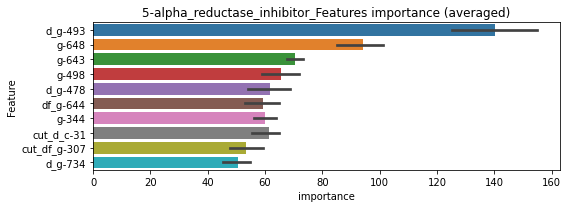

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105185	valid_1's binary_logloss: 0.0163227
[200]	training's binary_logloss: 0.00108605	valid_1's binary_logloss: 0.0052452
[300]	training's binary_logloss: 0.000300983	valid_1's binary_logloss: 0.00423427
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000269555	valid_1's binary_logloss: 0.00417497


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010925	valid_1's binary_logloss: 0.0147196
[200]	training's binary_logloss: 0.00116502	valid_1's binary_logloss: 0.00324783
[300]	training's binary_logloss: 0.000314896	valid_1's binary_logloss: 0.00203024
[400]	training's binary_logloss: 0.000170874	valid_1's binary_logloss: 0.00180686
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000153282	valid_1's binary_logloss: 0.00178179


5-alpha_reductase_inhibitor logloss: 0.002978536309828412


neg labels: 3289 → selected neg labels: 3286


11-beta-hsd1_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227398	valid_1's binary_logloss: 0.0311558
[200]	training's binary_logloss: 0.00260215	valid_1's binary_logloss: 0.00742094
[300]	training's binary_logloss: 0.000734881	valid_1's binary_logloss: 0.00434422
[400]	training's binary_logloss: 0.000390335	valid_1's binary_logloss: 0.00354774
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000354795	valid_1's binary_logloss: 0.00342525
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226654	valid_1's binary_logloss: 0.0318799
[200]	training's binary_logloss: 0.00260975	valid_1's binary_logloss: 0.0073071
[300]	training's binary_logloss: 0.000733763	valid_1's binary_logloss: 0.00416493
[400]	training's binary_logloss: 0.000390298	valid_1's binary_logloss: 0.00339668
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000325797	valid_1's binary_logloss: 0.003238

1 / 3 AUC score:1.000
y_Threshold: 0.0016078, Threshold: 0.0023403, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00211, conf_1:0.00257
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0023403
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0123403
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.0223403
threshold: 0.0223403, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224861	valid_1's binary_logloss: 0.0292615
[200]	training's binary_logloss: 0.00256031	valid_1's binary_logloss: 0.00589765
[300]	training's binary_logloss: 0.000723372	valid_1's binary_logloss: 0.00311405
[400]	training's binary_logloss: 0.000388278	valid_1's binary_logloss: 0.00248612
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000330372	valid_1's binary_logloss: 0.00232181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230198	valid_1's binary_logloss: 0.0315162
[200]	training's binary_logloss: 0.0025722	valid_1's binary_logloss: 0.00631754
[300]	training's binary_logloss: 0.000731191	valid_1's binary_logloss: 0.00354375
[400]	training's binary_logloss: 0.000388965	valid_1's binary_logloss: 0.00283127
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000326739	valid_1's binary_logloss: 0.002681

2 / 3 AUC score:1.000
y_Threshold: 0.0543624, Threshold: 0.0223403, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0037670 Vs.target_rate: 0.00076
Num_p_label: 15.0, conf_0:0.02011, conf_1:0.02457
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_1: 0.0223403
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.0323403
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.0423403
threshold: 0.0423403, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224861	valid_1's binary_logloss: 0.0292615
[200]	training's binary_logloss: 0.00256031	valid_1's binary_logloss: 0.00589765
[300]	training's binary_logloss: 0.000723372	valid_1's binary_logloss: 0.00311405
[400]	training's binary_logloss: 0.000388278	valid_1's binary_logloss: 0.00248612
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000330372	valid_1's binary_logloss: 0.00232181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230198	valid_1's binary_logloss: 0.0315162
[200]	training's binary_logloss: 0.0025722	valid_1's binary_logloss: 0.00631754
[300]	training's binary_logloss: 0.000731191	valid_1's binary_logloss: 0.00354375
[400]	training's binary_logloss: 0.000388965	valid_1's binary_logloss: 0.00283127
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000326739	valid_1's binary_logloss: 0.002681

3 / 3 AUC score:1.000
y_Threshold: 0.0543624, Threshold: 0.0423403, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.03811, conf_1:0.04657
threshold: 0.0423403, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


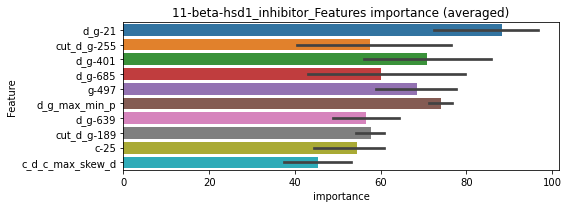

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121468	valid_1's binary_logloss: 0.0190585
[200]	training's binary_logloss: 0.00136585	valid_1's binary_logloss: 0.00703262
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.000658423	valid_1's binary_logloss: 0.00661988


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122751	valid_1's binary_logloss: 0.0179729
[200]	training's binary_logloss: 0.00143482	valid_1's binary_logloss: 0.00558647
[300]	training's binary_logloss: 0.000397327	valid_1's binary_logloss: 0.00410098
[400]	training's binary_logloss: 0.000206231	valid_1's binary_logloss: 0.00369979
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000175119	valid_1's binary_logloss: 0.00361092


11-beta-hsd1_inhibitor logloss: 0.005115590916770012


neg labels: 3289 → selected neg labels: 3285


acat_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282265	valid_1's binary_logloss: 0.0406611
[200]	training's binary_logloss: 0.00377019	valid_1's binary_logloss: 0.0111783
[300]	training's binary_logloss: 0.00102878	valid_1's binary_logloss: 0.00601028
[400]	training's binary_logloss: 0.000518992	valid_1's binary_logloss: 0.00468404
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000467384	valid_1's binary_logloss: 0.00453259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287253	valid_1's binary_logloss: 0.0454793
[200]	training's binary_logloss: 0.0037305	valid_1's binary_logloss: 0.0105807
[300]	training's binary_logloss: 0.00103556	valid_1's binary_logloss: 0.00578662
[400]	training's binary_logloss: 0.000525597	valid_1's binary_logloss: 0.00461191
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000408447	valid_1's binary_logloss: 0.00423818


1 / 3 AUC score:1.000
y_Threshold: 0.0018480, Threshold: 0.0028234, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00254, conf_1:0.00311
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0028234
Num_p_label: 2.0, Expected: 4.0, Adj_threshold_2: 0.0128234
threshold: 0.0128234, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028407	valid_1's binary_logloss: 0.0401017
[200]	training's binary_logloss: 0.0036696	valid_1's binary_logloss: 0.0101867
[300]	training's binary_logloss: 0.00101696	valid_1's binary_logloss: 0.00504372
[400]	training's binary_logloss: 0.000517268	valid_1's binary_logloss: 0.00396061
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000407448	valid_1's binary_logloss: 0.00367676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289822	valid_1's binary_logloss: 0.0432657
[200]	training's binary_logloss: 0.00373945	valid_1's binary_logloss: 0.00941448
[300]	training's binary_logloss: 0.00103353	valid_1's binary_logloss: 0.00495871
[400]	training's binary_logloss: 0.000524214	valid_1's binary_logloss: 0.00374912
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000394006	valid_1's binary_logloss: 0.00347848


2 / 3 AUC score:1.000
y_Threshold: 0.0271373, Threshold: 0.0128234, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0027624 Vs.target_rate: 0.00101
Num_p_label: 11.0, conf_0:0.01154, conf_1:0.01411
threshold: 0.0128234, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028407	valid_1's binary_logloss: 0.0401017
[200]	training's binary_logloss: 0.0036696	valid_1's binary_logloss: 0.0101867
[300]	training's binary_logloss: 0.00101696	valid_1's binary_logloss: 0.00504372
[400]	training's binary_logloss: 0.000517268	valid_1's binary_logloss: 0.00396061
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000407448	valid_1's binary_logloss: 0.00367676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289822	valid_1's binary_logloss: 0.0432657
[200]	training's binary_logloss: 0.00373945	valid_1's binary_logloss: 0.00941448
[300]	training's binary_logloss: 0.00103353	valid_1's binary_logloss: 0.00495871
[400]	training's binary_logloss: 0.000524214	valid_1's binary_logloss: 0.00374912
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000394006	valid_1's binary_logloss: 0.00347848


3 / 3 AUC score:1.000
y_Threshold: 0.0271373, Threshold: 0.0128234, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0027624 Vs.target_rate: 0.00101
Num_p_label: 11.0, conf_0:0.01154, conf_1:0.01411
threshold: 0.0128234, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 668.0/7792, y_label_rate: 0.0857290


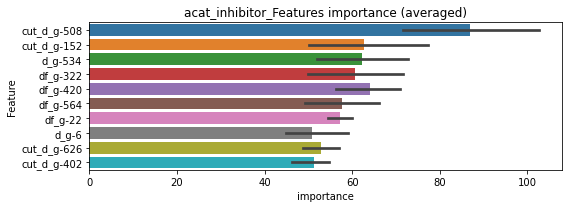

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158047	valid_1's binary_logloss: 0.0282113
[200]	training's binary_logloss: 0.00197729	valid_1's binary_logloss: 0.0157098
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.000949401	valid_1's binary_logloss: 0.014928


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169902	valid_1's binary_logloss: 0.0272387
[200]	training's binary_logloss: 0.00226581	valid_1's binary_logloss: 0.00889003
[300]	training's binary_logloss: 0.000621991	valid_1's binary_logloss: 0.00627868
[400]	training's binary_logloss: 0.000304691	valid_1's binary_logloss: 0.0058422
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000262726	valid_1's binary_logloss: 0.00580015


acat_inhibitor logloss: 0.01036409465667559


neg labels: 3289 → selected neg labels: 3259


acetylcholine_receptor_agonist, len(trt): 190, len(othr): 3259, target_rate: 0.0079785 → Adj_target_rate: 0.0072634
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805595	valid_1's binary_logloss: 0.220105
[200]	training's binary_logloss: 0.0236204	valid_1's binary_logloss: 0.196408
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0209941	valid_1's binary_logloss: 0.195914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845449	valid_1's binary_logloss: 0.211725
[200]	training's binary_logloss: 0.0256802	valid_1's binary_logloss: 0.178157
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0141543	valid_1's binary_logloss: 0.174357


1 / 3 AUC score:0.947
y_Threshold: 0.0579707, Threshold: 0.0842386, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 297 → Positive_corect_labels: 568/3613
p_label_rate: 0.0200904 Vs.target_rate: 0.00798
Num_p_label: 80.0, conf_0:0.07581, conf_1:0.09266
threshold: 0.0842386, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 568.0/3613, y_label_rate: 0.1572101
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604386	valid_1's binary_logloss: 0.174624
[200]	training's binary_logloss: 0.0153182	valid_1's binary_logloss: 0.144531
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0107549	valid_1's binary_logloss: 0.142313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665562	valid_1's binary_logloss: 0.154892
[200]	training's binary_logloss: 0.0166983	valid_1's binary_logloss: 0.115836
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0110227	valid_1's binary_logloss: 0.111976


2 / 3 AUC score:0.981
y_Threshold: 0.0664253, Threshold: 0.0842386, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 108 → Positive_corect_labels: 514.0/3505
p_label_rate: 0.0160723 Vs.target_rate: 0.00798
Num_p_label: 64.0, conf_0:0.07581, conf_1:0.09266
threshold: 0.0842386, positive_p_label: 64.0/3982, p_label_rate: 0.0160723
positive_y_label: 514.0/3505, y_label_rate: 0.1466476
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0517667	valid_1's binary_logloss: 0.118919
[200]	training's binary_logloss: 0.0118969	valid_1's binary_logloss: 0.0808202
[300]	training's binary_logloss: 0.00378096	valid_1's binary_logloss: 0.0732887
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00209951	valid_1's binary_logloss: 0.0711127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0543125	valid_1's binary_logloss: 0.131794
[200]	training's binary_logloss: 0.0121994	valid_1's binary_logloss: 0.0933141
[300]	training's binary_logloss: 0.00391041	valid_1's binary_logloss: 0.0846873
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00231772	valid_1's binary_logloss: 0.0823875


3 / 3 AUC score:0.998
y_Threshold: 0.0399028, Threshold: 0.0842386, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 497.0/3471
p_label_rate: 0.0030136 Vs.target_rate: 0.00798
Num_p_label: 12.0, conf_0:0.07581, conf_1:0.09266
threshold: 0.0842386, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 509.0/7453, y_label_rate: 0.0682946


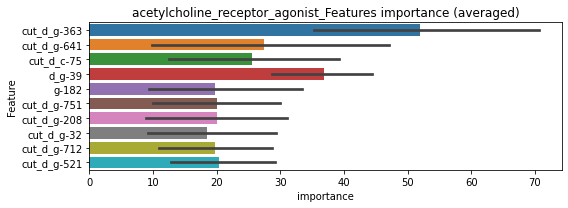

len(train_index) : 3726
len(valid_index) : 3727
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279657	valid_1's binary_logloss: 0.0702799
[200]	training's binary_logloss: 0.00619444	valid_1's binary_logloss: 0.051847
[300]	training's binary_logloss: 0.0019317	valid_1's binary_logloss: 0.0484823
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00120045	valid_1's binary_logloss: 0.0476078


len(train_index) : 3727
len(valid_index) : 3726
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277736	valid_1's binary_logloss: 0.0684494
[200]	training's binary_logloss: 0.00647418	valid_1's binary_logloss: 0.048077
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00249416	valid_1's binary_logloss: 0.0450889


acetylcholine_receptor_agonist logloss: 0.04634853214722758


neg labels: 3289 → selected neg labels: 3241


acetylcholine_receptor_antagonist, len(trt): 301, len(othr): 3241, target_rate: 0.0126396 → Adj_target_rate: 0.0107394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11192	valid_1's binary_logloss: 0.289101
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0666207	valid_1's binary_logloss: 0.278432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119141	valid_1's binary_logloss: 0.284312
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0647433	valid_1's binary_logloss: 0.26726


1 / 3 AUC score:0.871
y_Threshold: 0.1173313, Threshold: 0.1506258, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 496 → Positive_corect_labels: 465/3393
p_label_rate: 0.0200904 Vs.target_rate: 0.01264
Num_p_label: 80.0, conf_0:0.13556, conf_1:0.16569
threshold: 0.1506258, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 465.0/3393, y_label_rate: 0.1370469
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0655624	valid_1's binary_logloss: 0.174635
[200]	training's binary_logloss: 0.0187313	valid_1's binary_logloss: 0.143877
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0108291	valid_1's binary_logloss: 0.138866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0692231	valid_1's binary_logloss: 0.173052
[200]	training's binary_logloss: 0.0198908	valid_1's binary_logloss: 0.146406
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0186812	valid_1's binary_logloss: 0.145829


2 / 3 AUC score:0.981
y_Threshold: 0.0792073, Threshold: 0.1506258, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 108 → Positive_corect_labels: 411.0/3285
p_label_rate: 0.0045203 Vs.target_rate: 0.01264
Num_p_label: 18.0, conf_0:0.13556, conf_1:0.16569
threshold: 0.1506258, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 411.0/3285, y_label_rate: 0.1251142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482772	valid_1's binary_logloss: 0.143565
[200]	training's binary_logloss: 0.0114681	valid_1's binary_logloss: 0.119641
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0072178	valid_1's binary_logloss: 0.117241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521705	valid_1's binary_logloss: 0.146466
[200]	training's binary_logloss: 0.0131121	valid_1's binary_logloss: 0.117582
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00899115	valid_1's binary_logloss: 0.11363


3 / 3 AUC score:0.988
y_Threshold: 0.0553518, Threshold: 0.1506258, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 382.0/3227
p_label_rate: 0.0007534 Vs.target_rate: 0.01264
Num_p_label: 3.0, conf_0:0.13556, conf_1:0.16569
Num_p_label: 3.0, Expected: 50.3, Adj_threshold_1: 0.1506258
Num_p_label: 6.0, Expected: 50.3, Adj_threshold_2: 0.1406258
Num_p_label: 7.0, Expected: 50.3, Adj_threshold_3: 0.1306258
Num_p_label: 10.0, Expected: 50.3, Adj_threshold_4: 0.1206258
Num_p_label: 12.0, Expected: 50.3, Adj_threshold_5: 0.1106258
Num_p_label: 15.0, Expected: 50.3, Adj_threshold_6: 0.1006258
Num_p_label: 20.0, Expected: 50.3, Adj_threshold_7: 0.0906258
Num_p_label: 24.0, Expected: 50.3, Adj_threshold_8: 0.0806258
Num_p_label: 36.0, Expected: 50.3, Adj_threshold_9: 0.0706258
threshold: 0.0706258, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 418.0/7209, y_label_rate: 0.0579831


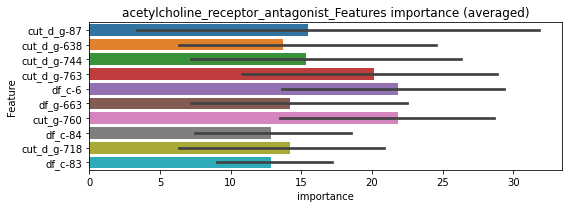

len(train_index) : 3604
len(valid_index) : 3605
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250029	valid_1's binary_logloss: 0.0862525
[200]	training's binary_logloss: 0.00601754	valid_1's binary_logloss: 0.0750923
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00648879	valid_1's binary_logloss: 0.0748288


len(train_index) : 3605
len(valid_index) : 3604
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257067	valid_1's binary_logloss: 0.0877158
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.00863829	valid_1's binary_logloss: 0.0802435


acetylcholine_receptor_antagonist logloss: 0.0775357754831726


neg labels: 3289 → selected neg labels: 3276


acetylcholinesterase_inhibitor, len(trt): 73, len(othr): 3276, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480266	valid_1's binary_logloss: 0.0909851
[200]	training's binary_logloss: 0.0103503	valid_1's binary_logloss: 0.0499197
[300]	training's binary_logloss: 0.00307695	valid_1's binary_logloss: 0.0403602
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00168006	valid_1's binary_logloss: 0.0367443
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470111	valid_1's binary_logloss: 0.0939147
[200]	training's binary_logloss: 0.0092465	valid_1's binary_logloss: 0.0551518
[300]	training's binary_logloss: 0.00278022	valid_1's binary_logloss: 0.0488366
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00142059	valid_1's binary_logloss: 0.0471835


1 / 3 AUC score:0.998
y_Threshold: 0.0085214, Threshold: 0.0102606, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3793
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.00923, conf_1:0.01129
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0102606
Num_p_label: 13.0, Expected: 12.2, Adj_threshold_2: 0.0202606
threshold: 0.0202606, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 652.0/3793, y_label_rate: 0.1718956
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449676	valid_1's binary_logloss: 0.0933617
[200]	training's binary_logloss: 0.00850039	valid_1's binary_logloss: 0.0545683
[300]	training's binary_logloss: 0.00253775	valid_1's binary_logloss: 0.0485422
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00207472	valid_1's binary_logloss: 0.0477731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047667	valid_1's binary_logloss: 0.10461
[200]	training's binary_logloss: 0.00969037	valid_1's binary_logloss: 0.0694004
[300]	training's binary_logloss: 0.00291489	valid_1's binary_logloss: 0.0623312
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0024075	valid_1's binary_logloss: 0.0614916


2 / 3 AUC score:0.995
y_Threshold: 0.0249440, Threshold: 0.0202606, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 640.0/3769
p_label_rate: 0.0110497 Vs.target_rate: 0.00307
Num_p_label: 44.0, conf_0:0.01823, conf_1:0.02229
Num_p_label: 44.0, Expected: 12.2, Adj_threshold_1: 0.0202606
Num_p_label: 12.0, Expected: 12.2, Adj_threshold_2: 0.0302606
threshold: 0.0302606, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 640.0/3769, y_label_rate: 0.1698063
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417271	valid_1's binary_logloss: 0.0896215
[200]	training's binary_logloss: 0.00786596	valid_1's binary_logloss: 0.0518282
[300]	training's binary_logloss: 0.00236576	valid_1's binary_logloss: 0.0433047
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00182359	valid_1's binary_logloss: 0.0420944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047935	valid_1's binary_logloss: 0.0847885
[200]	training's binary_logloss: 0.00914066	valid_1's binary_logloss: 0.0431673
[300]	training's binary_logloss: 0.00271283	valid_1's binary_logloss: 0.0345621
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0024475	valid_1's binary_logloss: 0.0340214


3 / 3 AUC score:0.999
y_Threshold: 0.0288936, Threshold: 0.0302606, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 633.0/3755
p_label_rate: 0.0032647 Vs.target_rate: 0.00307
Num_p_label: 13.0, conf_0:0.02723, conf_1:0.03329
threshold: 0.0302606, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 646.0/7737, y_label_rate: 0.0834949


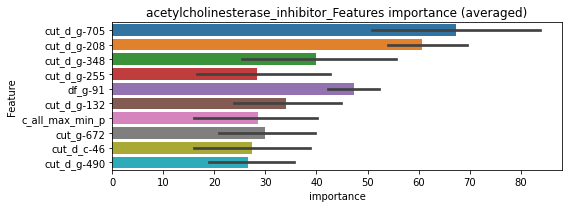

len(train_index) : 3868
len(valid_index) : 3869
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231436	valid_1's binary_logloss: 0.0626433
[200]	training's binary_logloss: 0.00402015	valid_1's binary_logloss: 0.0465538
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00145952	valid_1's binary_logloss: 0.0445303


len(train_index) : 3869
len(valid_index) : 3868
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253082	valid_1's binary_logloss: 0.0499131
[200]	training's binary_logloss: 0.00499688	valid_1's binary_logloss: 0.0307907
[300]	training's binary_logloss: 0.00144175	valid_1's binary_logloss: 0.0277547
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00159598	valid_1's binary_logloss: 0.0277396


acetylcholinesterase_inhibitor logloss: 0.03613606877749223


neg labels: 3289 → selected neg labels: 3281


adenosine_receptor_agonist, len(trt): 54, len(othr): 3281, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037216	valid_1's binary_logloss: 0.0845591
[200]	training's binary_logloss: 0.00637682	valid_1's binary_logloss: 0.0459007
[300]	training's binary_logloss: 0.00185971	valid_1's binary_logloss: 0.0375134
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00163824	valid_1's binary_logloss: 0.0368951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408518	valid_1's binary_logloss: 0.0771236
[200]	training's binary_logloss: 0.00708804	valid_1's binary_logloss: 0.0372478
[300]	training's binary_logloss: 0.00206754	valid_1's binary_logloss: 0.0299469
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.0011458	valid_1's binary_logloss: 0.0282311


1 / 3 AUC score:0.998
y_Threshold: 0.0077959, Threshold: 0.0129253, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 653/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00227
Num_p_label: 80.0, conf_0:0.01163, conf_1:0.01422
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0129253
Num_p_label: 26.0, Expected: 9.0, Adj_threshold_2: 0.0229253
Num_p_label: 6.0, Expected: 9.0, Adj_threshold_3: 0.0329253
threshold: 0.0329253, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 653.0/3799, y_label_rate: 0.1718873
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393674	valid_1's binary_logloss: 0.0807582
[200]	training's binary_logloss: 0.00676117	valid_1's binary_logloss: 0.0380686
[300]	training's binary_logloss: 0.00194226	valid_1's binary_logloss: 0.0289562
[400]	training's binary_logloss: 0.000943619	valid_1's binary_logloss: 0.0259424
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000921647	valid_1's binary_logloss: 0.0258887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392069	valid_1's binary_logloss: 0.0669456
[200]	training's binary_logloss: 0.00685141	valid_1's binary_logloss: 0.0277791
[300]	training's binary_logloss: 0.0020625	valid_1's binary_logloss: 0.0175087
[400]	training's binary_logloss: 0.00100683	valid_1's binary_logloss: 0.0140929
[500]	training's binary_logloss: 0.000653303	valid_1's binary_logloss: 0.0127565
Early stopping, best iteration is:
[572]	tr

2 / 3 AUC score:1.000
y_Threshold: 0.0325121, Threshold: 0.0329253, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 651.0/3795
p_label_rate: 0.0047715 Vs.target_rate: 0.00227
Num_p_label: 19.0, conf_0:0.02963, conf_1:0.03622
threshold: 0.0329253, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 651.0/3795, y_label_rate: 0.1715415
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377463	valid_1's binary_logloss: 0.0721061
[200]	training's binary_logloss: 0.00631179	valid_1's binary_logloss: 0.0316875
[300]	training's binary_logloss: 0.00184997	valid_1's binary_logloss: 0.0233606
[400]	training's binary_logloss: 0.00091908	valid_1's binary_logloss: 0.0211362
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000811778	valid_1's binary_logloss: 0.0206135
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398895	valid_1's binary_logloss: 0.0761305
[200]	training's binary_logloss: 0.00681185	valid_1's binary_logloss: 0.0314237
[300]	training's binary_logloss: 0.00201155	valid_1's binary_logloss: 0.0210818
[400]	training's binary_logloss: 0.000981118	valid_1's binary_logloss: 0.0180628
[500]	training's binary_logloss: 0.000638381	valid_1's binary_logloss: 0.0165367
Early stopping, best iteration is:
[506]	t

3 / 3 AUC score:1.000
y_Threshold: 0.0378914, Threshold: 0.0329253, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 650.0/3793
p_label_rate: 0.0040181 Vs.target_rate: 0.00227
Num_p_label: 16.0, conf_0:0.02963, conf_1:0.03622
threshold: 0.0329253, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 666.0/7775, y_label_rate: 0.0856592


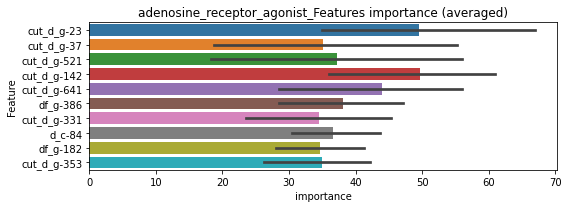

len(train_index) : 3887
len(valid_index) : 3888
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219953	valid_1's binary_logloss: 0.0500985
[200]	training's binary_logloss: 0.00381817	valid_1's binary_logloss: 0.0311383
[300]	training's binary_logloss: 0.00108138	valid_1's binary_logloss: 0.0279057
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000874645	valid_1's binary_logloss: 0.0274756


len(train_index) : 3888
len(valid_index) : 3887
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233648	valid_1's binary_logloss: 0.049454
[200]	training's binary_logloss: 0.00400441	valid_1's binary_logloss: 0.027992
[300]	training's binary_logloss: 0.0011756	valid_1's binary_logloss: 0.0237408
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000650198	valid_1's binary_logloss: 0.023063


adenosine_receptor_agonist logloss: 0.0252695682785547


neg labels: 3289 → selected neg labels: 3273


adenosine_receptor_antagonist, len(trt): 96, len(othr): 3273, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533656	valid_1's binary_logloss: 0.122921
[200]	training's binary_logloss: 0.0113561	valid_1's binary_logloss: 0.0851182
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00411385	valid_1's binary_logloss: 0.0785323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572403	valid_1's binary_logloss: 0.116482
[200]	training's binary_logloss: 0.0127679	valid_1's binary_logloss: 0.072371
[300]	training's binary_logloss: 0.00390197	valid_1's binary_logloss: 0.0601868
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0022534	valid_1's binary_logloss: 0.057658


1 / 3 AUC score:0.993
y_Threshold: 0.0168634, Threshold: 0.0184827, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 156 → Positive_corect_labels: 642/3771
p_label_rate: 0.0200904 Vs.target_rate: 0.00403
Num_p_label: 80.0, conf_0:0.01663, conf_1:0.02033
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0184827
Num_p_label: 23.0, Expected: 16.1, Adj_threshold_2: 0.0284827
threshold: 0.0284827, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 642.0/3771, y_label_rate: 0.1702466
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508018	valid_1's binary_logloss: 0.11603
[200]	training's binary_logloss: 0.0106701	valid_1's binary_logloss: 0.0747324
[300]	training's binary_logloss: 0.00324215	valid_1's binary_logloss: 0.063934
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00172953	valid_1's binary_logloss: 0.0611273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0560163	valid_1's binary_logloss: 0.107915
[200]	training's binary_logloss: 0.0123091	valid_1's binary_logloss: 0.0654872
[300]	training's binary_logloss: 0.0038041	valid_1's binary_logloss: 0.0566014
[400]	training's binary_logloss: 0.00172318	valid_1's binary_logloss: 0.0531235
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00165007	valid_1's binary_logloss: 0.0528611


2 / 3 AUC score:0.998
y_Threshold: 0.0317754, Threshold: 0.0284827, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 631.0/3749
p_label_rate: 0.0070316 Vs.target_rate: 0.00403
Num_p_label: 28.0, conf_0:0.02563, conf_1:0.03133
threshold: 0.0284827, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 631.0/3749, y_label_rate: 0.1683115
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487819	valid_1's binary_logloss: 0.103395
[200]	training's binary_logloss: 0.00991371	valid_1's binary_logloss: 0.0629117
[300]	training's binary_logloss: 0.00300489	valid_1's binary_logloss: 0.0540208
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00229917	valid_1's binary_logloss: 0.0526998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535874	valid_1's binary_logloss: 0.0983888
[200]	training's binary_logloss: 0.0113184	valid_1's binary_logloss: 0.056164
[300]	training's binary_logloss: 0.00346041	valid_1's binary_logloss: 0.0456084
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00219082	valid_1's binary_logloss: 0.0439015


3 / 3 AUC score:0.999
y_Threshold: 0.0330760, Threshold: 0.0284827, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 623.0/3733
p_label_rate: 0.0110497 Vs.target_rate: 0.00403
Num_p_label: 44.0, conf_0:0.02563, conf_1:0.03133
threshold: 0.0284827, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 667.0/7715, y_label_rate: 0.0864550


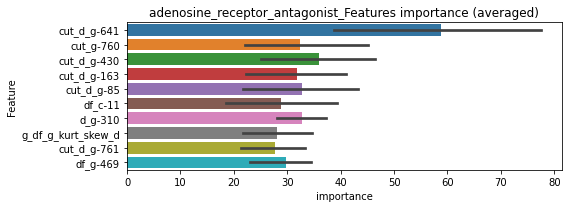

len(train_index) : 3857
len(valid_index) : 3858
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313575	valid_1's binary_logloss: 0.077935
[200]	training's binary_logloss: 0.00681872	valid_1's binary_logloss: 0.0597749
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00482111	valid_1's binary_logloss: 0.0588117


len(train_index) : 3858
len(valid_index) : 3857
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330665	valid_1's binary_logloss: 0.0718177
[200]	training's binary_logloss: 0.00735896	valid_1's binary_logloss: 0.0511834
[300]	training's binary_logloss: 0.0021877	valid_1's binary_logloss: 0.0468903
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00206632	valid_1's binary_logloss: 0.0467092


adenosine_receptor_antagonist logloss: 0.05276123773083684


neg labels: 3289 → selected neg labels: 3286


adenylyl_cyclase_activator, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020828	valid_1's binary_logloss: 0.026894
[200]	training's binary_logloss: 0.0022721	valid_1's binary_logloss: 0.0043729
[300]	training's binary_logloss: 0.000636187	valid_1's binary_logloss: 0.00161797
[400]	training's binary_logloss: 0.000340265	valid_1's binary_logloss: 0.00103029
[500]	training's binary_logloss: 0.00027738	valid_1's binary_logloss: 0.000914782
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00027738	valid_1's binary_logloss: 0.000914782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209817	valid_1's binary_logloss: 0.024546
[200]	training's binary_logloss: 0.00229057	valid_1's binary_logloss: 0.0034341
[300]	training's binary_logloss: 0.000646277	valid_1's binary_logloss: 0.00116079
[400]	training's binary_logloss: 0.000349182	valid_1's binary_logloss: 0.000688763
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0013964, Threshold: 0.0025067, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00226, conf_1:0.00276
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0025067
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.0125067
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0225067
threshold: 0.0225067, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207958	valid_1's binary_logloss: 0.0264281
[200]	training's binary_logloss: 0.00221097	valid_1's binary_logloss: 0.00403946
[300]	training's binary_logloss: 0.000618187	valid_1's binary_logloss: 0.00140034
[400]	training's binary_logloss: 0.000335891	valid_1's binary_logloss: 0.000868672
[500]	training's binary_logloss: 0.000272672	valid_1's binary_logloss: 0.000752687
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000271915	valid_1's binary_logloss: 0.000750815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215393	valid_1's binary_logloss: 0.0250065
[200]	training's binary_logloss: 0.00228017	valid_1's binary_logloss: 0.00312438
[300]	training's binary_logloss: 0.000624013	valid_1's binary_logloss: 0.000970437
[400]	training's binary_logloss: 0.000336336	valid_1's binary_logloss: 0.000550464
[500]	training's binary_lo

2 / 3 AUC score:1.000
y_Threshold: 0.1394019, Threshold: 0.0225067, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0047715 Vs.target_rate: 0.00076
Num_p_label: 19.0, conf_0:0.02026, conf_1:0.02476
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_1: 0.0225067
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.0325067
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_3: 0.0425067
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.0525067
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_5: 0.0625067
threshold: 0.0625067, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207958	valid_1's binary_logloss: 0.0264281
[200]	training's binary_logloss: 0.00221097	valid_1's binary_logloss: 0.00403946
[300]	training's binary_logloss: 0.000618187	valid_1's binary_logloss: 0.00140034
[400]	training's binary_logloss: 0.000335891	valid_1's binary_logloss: 0.000868672
[500]	training's binary_logloss: 0.000272672	valid_1's binary_logloss: 0.000752687
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000271915	valid_1's binary_logloss: 0.000750815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215393	valid_1's binary_logloss: 0.0250065
[200]	training's binary_logloss: 0.00228017	valid_1's binary_logloss: 0.00312438
[300]	training's binary_logloss: 0.000624013	valid_1's binary_logloss: 0.000970437
[400]	training's binary_logloss: 0.000336336	valid_1's binary_logloss: 0.000550464
[500]	training's binary_lo

3 / 3 AUC score:1.000
y_Threshold: 0.1394019, Threshold: 0.0625067, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.05626, conf_1:0.06876
threshold: 0.0625067, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


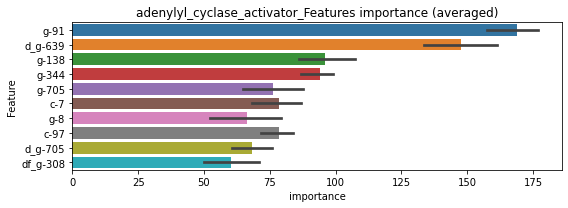

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106409	valid_1's binary_logloss: 0.0197556
[200]	training's binary_logloss: 0.00109089	valid_1's binary_logloss: 0.00802579
[300]	training's binary_logloss: 0.000303935	valid_1's binary_logloss: 0.00654706
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000232338	valid_1's binary_logloss: 0.00643836


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110907	valid_1's binary_logloss: 0.0137026
[200]	training's binary_logloss: 0.00119878	valid_1's binary_logloss: 0.00211266
[300]	training's binary_logloss: 0.000329334	valid_1's binary_logloss: 0.00096039
[400]	training's binary_logloss: 0.000177142	valid_1's binary_logloss: 0.000745606
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000152036	valid_1's binary_logloss: 0.00072232


adenylyl_cyclase_activator logloss: 0.0035807075196219494


neg labels: 3289 → selected neg labels: 3244


adrenergic_receptor_agonist, len(trt): 270, len(othr): 3244, target_rate: 0.0113379 → Adj_target_rate: 0.0097917
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091654	valid_1's binary_logloss: 0.268747
[200]	training's binary_logloss: 0.0283866	valid_1's binary_logloss: 0.250593
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.028705	valid_1's binary_logloss: 0.250512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102542	valid_1's binary_logloss: 0.253673
[200]	training's binary_logloss: 0.035145	valid_1's binary_logloss: 0.226233
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.035145	valid_1's binary_logloss: 0.226233


1 / 3 AUC score:0.915
y_Threshold: 0.0819311, Threshold: 0.1057877, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 397 → Positive_corect_labels: 515/3495
p_label_rate: 0.0200904 Vs.target_rate: 0.01134
Num_p_label: 80.0, conf_0:0.09521, conf_1:0.11637
threshold: 0.1057877, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 515.0/3495, y_label_rate: 0.1473534
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661343	valid_1's binary_logloss: 0.196211
[200]	training's binary_logloss: 0.0184764	valid_1's binary_logloss: 0.171579
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0176923	valid_1's binary_logloss: 0.171018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703596	valid_1's binary_logloss: 0.18594
[200]	training's binary_logloss: 0.0191174	valid_1's binary_logloss: 0.158295
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0120119	valid_1's binary_logloss: 0.155404


2 / 3 AUC score:0.980
y_Threshold: 0.0655854, Threshold: 0.1057877, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 447.0/3359
p_label_rate: 0.0052737 Vs.target_rate: 0.01134
Num_p_label: 21.0, conf_0:0.09521, conf_1:0.11637
threshold: 0.1057877, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 447.0/3359, y_label_rate: 0.1330753
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534509	valid_1's binary_logloss: 0.149105
[200]	training's binary_logloss: 0.0125091	valid_1's binary_logloss: 0.118062
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.004967	valid_1's binary_logloss: 0.113247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511617	valid_1's binary_logloss: 0.151988
[200]	training's binary_logloss: 0.0121467	valid_1's binary_logloss: 0.122289
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00662949	valid_1's binary_logloss: 0.116577


3 / 3 AUC score:0.993
y_Threshold: 0.0465241, Threshold: 0.1057877, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 48 → Positive_corect_labels: 423.0/3311
p_label_rate: 0.0022602 Vs.target_rate: 0.01134
Num_p_label: 9.0, conf_0:0.09521, conf_1:0.11637
Num_p_label: 9.0, Expected: 45.1, Adj_threshold_1: 0.1057877
Num_p_label: 12.0, Expected: 45.1, Adj_threshold_2: 0.0957877
Num_p_label: 19.0, Expected: 45.1, Adj_threshold_3: 0.0857877
Num_p_label: 24.0, Expected: 45.1, Adj_threshold_4: 0.0757877
threshold: 0.0757877, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 447.0/7293, y_label_rate: 0.0612916


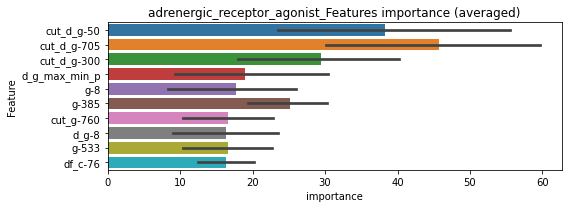

len(train_index) : 3646
len(valid_index) : 3647
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275046	valid_1's binary_logloss: 0.0842407
[200]	training's binary_logloss: 0.00650102	valid_1's binary_logloss: 0.0711967
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.00575578	valid_1's binary_logloss: 0.0701948


len(train_index) : 3647
len(valid_index) : 3646
================================= fold 2/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242326	valid_1's binary_logloss: 0.0866337
[200]	training's binary_logloss: 0.00559067	valid_1's binary_logloss: 0.0745519
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00550652	valid_1's binary_logloss: 0.0745412


adrenergic_receptor_agonist logloss: 0.07236765932811243


neg labels: 3289 → selected neg labels: 3229


adrenergic_receptor_antagonist, len(trt): 360, len(othr): 3229, target_rate: 0.0151172 → Adj_target_rate: 0.0125042
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119861	valid_1's binary_logloss: 0.341453
Early stopping, best iteration is:
[159]	training's binary_logloss: 0.0647948	valid_1's binary_logloss: 0.333634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134084	valid_1's binary_logloss: 0.329254
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0718111	valid_1's binary_logloss: 0.32009


1 / 3 AUC score:0.811
y_Threshold: 0.1236476, Threshold: 0.1587900, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 620 → Positive_corect_labels: 400/3254
p_label_rate: 0.0200904 Vs.target_rate: 0.01512
Num_p_label: 80.0, conf_0:0.14291, conf_1:0.17467
threshold: 0.1587900, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 400.0/3254, y_label_rate: 0.1229256
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625941	valid_1's binary_logloss: 0.235259
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0422713	valid_1's binary_logloss: 0.23047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665625	valid_1's binary_logloss: 0.218523
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0273677	valid_1's binary_logloss: 0.207661


2 / 3 AUC score:0.928
y_Threshold: 0.0903231, Threshold: 0.1587900, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 202 → Positive_corect_labels: 299.0/3052
p_label_rate: 0.0037670 Vs.target_rate: 0.01512
Num_p_label: 15.0, conf_0:0.14291, conf_1:0.17467
Num_p_label: 15.0, Expected: 60.2, Adj_threshold_1: 0.1587900
Num_p_label: 23.0, Expected: 60.2, Adj_threshold_2: 0.1487900
Num_p_label: 26.0, Expected: 60.2, Adj_threshold_3: 0.1387900
Num_p_label: 36.0, Expected: 60.2, Adj_threshold_4: 0.1287900
threshold: 0.1287900, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 299.0/3052, y_label_rate: 0.0979685
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381282	valid_1's binary_logloss: 0.147444
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.0166769	valid_1's binary_logloss: 0.13479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428066	valid_1's binary_logloss: 0.131321
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0132318	valid_1's binary_logloss: 0.113385


3 / 3 AUC score:0.985
y_Threshold: 0.0663163, Threshold: 0.1287900, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 270.0/2994
p_label_rate: 0.0010045 Vs.target_rate: 0.01512
Num_p_label: 4.0, conf_0:0.11591, conf_1:0.14167
Num_p_label: 4.0, Expected: 60.2, Adj_threshold_1: 0.1287900
Num_p_label: 8.0, Expected: 60.2, Adj_threshold_2: 0.1187900
Num_p_label: 11.0, Expected: 60.2, Adj_threshold_3: 0.1087900
Num_p_label: 18.0, Expected: 60.2, Adj_threshold_4: 0.0987900
Num_p_label: 28.0, Expected: 60.2, Adj_threshold_5: 0.0887900
Num_p_label: 40.0, Expected: 60.2, Adj_threshold_6: 0.0787900
threshold: 0.0787900, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 310.0/6976, y_label_rate: 0.0444381


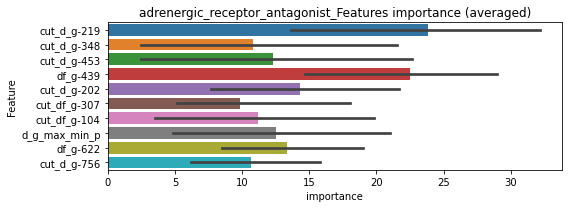

len(train_index) : 3488
len(valid_index) : 3488
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181678	valid_1's binary_logloss: 0.0953703
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00817087	valid_1's binary_logloss: 0.0910853


len(train_index) : 3488
len(valid_index) : 3488
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175498	valid_1's binary_logloss: 0.0938287
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0107994	valid_1's binary_logloss: 0.0906895


adrenergic_receptor_antagonist logloss: 0.0908874027327111


neg labels: 3289 → selected neg labels: 3278


akt_inhibitor, len(trt): 66, len(othr): 3278, target_rate: 0.0027715 → Adj_target_rate: 0.0029567
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338744	valid_1's binary_logloss: 0.0780985
[200]	training's binary_logloss: 0.00553085	valid_1's binary_logloss: 0.0388542
[300]	training's binary_logloss: 0.0016464	valid_1's binary_logloss: 0.0288947
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000945931	valid_1's binary_logloss: 0.0271388
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361625	valid_1's binary_logloss: 0.064415
[200]	training's binary_logloss: 0.00620392	valid_1's binary_logloss: 0.023213
[300]	training's binary_logloss: 0.00187004	valid_1's binary_logloss: 0.014194
[400]	training's binary_logloss: 0.000912508	valid_1's binary_logloss: 0.0113832
[500]	training's binary_logloss: 0.000590913	valid_1's binary_logloss: 0.0102009
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000508042	valid_1's binary_logloss: 0.00984145


1 / 3 AUC score:1.000
y_Threshold: 0.0067291, Threshold: 0.0197041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 655/3801
p_label_rate: 0.0200904 Vs.target_rate: 0.00277
Num_p_label: 80.0, conf_0:0.01773, conf_1:0.02167
Num_p_label: 80.0, Expected: 11.0, Adj_threshold_1: 0.0197041
Num_p_label: 55.0, Expected: 11.0, Adj_threshold_2: 0.0297041
Num_p_label: 49.0, Expected: 11.0, Adj_threshold_3: 0.0397041
Num_p_label: 43.0, Expected: 11.0, Adj_threshold_4: 0.0497041
Num_p_label: 39.0, Expected: 11.0, Adj_threshold_5: 0.0597041
Num_p_label: 36.0, Expected: 11.0, Adj_threshold_6: 0.0697041
Num_p_label: 34.0, Expected: 11.0, Adj_threshold_7: 0.0797041
Num_p_label: 32.0, Expected: 11.0, Adj_threshold_8: 0.0897041
Num_p_label: 29.0, Expected: 11.0, Adj_threshold_9: 0.0997041
Num_p_label: 28.0, Expected: 11.0, Adj_threshold_10: 0.1097041
threshold: 0.1197041, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 655.0/3801, y_label_rate: 0.1723231

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346378	valid_1's binary_logloss: 0.074639
[200]	training's binary_logloss: 0.00533366	valid_1's binary_logloss: 0.0355218
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.001966	valid_1's binary_logloss: 0.0293407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345305	valid_1's binary_logloss: 0.0591408
[200]	training's binary_logloss: 0.00564253	valid_1's binary_logloss: 0.0187325
[300]	training's binary_logloss: 0.00170155	valid_1's binary_logloss: 0.0104471
[400]	training's binary_logloss: 0.00083348	valid_1's binary_logloss: 0.00768081
[500]	training's binary_logloss: 0.000557473	valid_1's binary_logloss: 0.00665736
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000505519	valid_1's binary_logloss: 0.00642299


2 / 3 AUC score:1.000
y_Threshold: 0.0511121, Threshold: 0.1197041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 650.0/3791
p_label_rate: 0.0173280 Vs.target_rate: 0.00277
Num_p_label: 69.0, conf_0:0.10773, conf_1:0.13167
Num_p_label: 69.0, Expected: 11.0, Adj_threshold_1: 0.1197041
Num_p_label: 67.0, Expected: 11.0, Adj_threshold_2: 0.1297041
Num_p_label: 64.0, Expected: 11.0, Adj_threshold_3: 0.1397041
Num_p_label: 61.0, Expected: 11.0, Adj_threshold_4: 0.1497041
Num_p_label: 60.0, Expected: 11.0, Adj_threshold_5: 0.1597041
Num_p_label: 59.0, Expected: 11.0, Adj_threshold_6: 0.1697041
Num_p_label: 59.0, Expected: 11.0, Adj_threshold_7: 0.1797041
Num_p_label: 57.0, Expected: 11.0, Adj_threshold_8: 0.1897041
Num_p_label: 56.0, Expected: 11.0, Adj_threshold_9: 0.1997041
Num_p_label: 56.0, Expected: 11.0, Adj_threshold_10: 0.2097041
threshold: 0.2197041, positive_p_label: 55.0/3982, p_label_rate: 0.0138122
positive_y_label: 650.0/3791, y_label_rate: 0.171458

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331788	valid_1's binary_logloss: 0.062013
[200]	training's binary_logloss: 0.00518313	valid_1's binary_logloss: 0.0268965
[300]	training's binary_logloss: 0.00156027	valid_1's binary_logloss: 0.0185963
[400]	training's binary_logloss: 0.000785768	valid_1's binary_logloss: 0.0160499
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000625234	valid_1's binary_logloss: 0.0152616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034797	valid_1's binary_logloss: 0.0667992
[200]	training's binary_logloss: 0.00536241	valid_1's binary_logloss: 0.0246136
[300]	training's binary_logloss: 0.00161183	valid_1's binary_logloss: 0.0160368
[400]	training's binary_logloss: 0.000808476	valid_1's binary_logloss: 0.0131894
[500]	training's binary_logloss: 0.000539207	valid_1's binary_logloss: 0.0121551
Early stopping, best iteration is:
[511]	tr

3 / 3 AUC score:1.000
y_Threshold: 0.0571665, Threshold: 0.2197041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 647.0/3785
p_label_rate: 0.0128076 Vs.target_rate: 0.00277
Num_p_label: 51.0, conf_0:0.19773, conf_1:0.24167
Num_p_label: 51.0, Expected: 11.0, Adj_threshold_1: 0.2197041
Num_p_label: 50.0, Expected: 11.0, Adj_threshold_2: 0.2297041
Num_p_label: 50.0, Expected: 11.0, Adj_threshold_3: 0.2397041
Num_p_label: 49.0, Expected: 11.0, Adj_threshold_4: 0.2497041
Num_p_label: 49.0, Expected: 11.0, Adj_threshold_5: 0.2597041
Num_p_label: 49.0, Expected: 11.0, Adj_threshold_6: 0.2697041
Num_p_label: 49.0, Expected: 11.0, Adj_threshold_7: 0.2797041
Num_p_label: 49.0, Expected: 11.0, Adj_threshold_8: 0.2897041
Num_p_label: 48.0, Expected: 11.0, Adj_threshold_9: 0.2997041
Num_p_label: 48.0, Expected: 11.0, Adj_threshold_10: 0.3097041
threshold: 0.3197041, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 695.0/7767, y_label_rate: 0.0894811

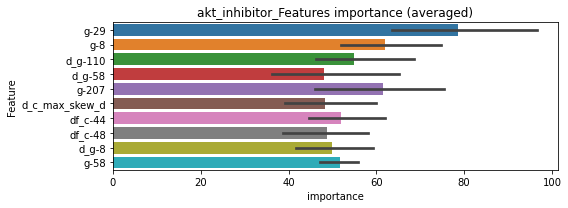

len(train_index) : 3883
len(valid_index) : 3884
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188999	valid_1's binary_logloss: 0.0419705
[200]	training's binary_logloss: 0.00289336	valid_1's binary_logloss: 0.0206047
[300]	training's binary_logloss: 0.000864872	valid_1's binary_logloss: 0.0162544
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000498942	valid_1's binary_logloss: 0.0153188


len(train_index) : 3884
len(valid_index) : 3883
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185088	valid_1's binary_logloss: 0.0431406
[200]	training's binary_logloss: 0.00288227	valid_1's binary_logloss: 0.0189871
[300]	training's binary_logloss: 0.000853264	valid_1's binary_logloss: 0.0132769
[400]	training's binary_logloss: 0.000427562	valid_1's binary_logloss: 0.0112374
[500]	training's binary_logloss: 0.000286643	valid_1's binary_logloss: 0.0103446
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000269273	valid_1's binary_logloss: 0.0102585


akt_inhibitor logloss: 0.01278895781072375


neg labels: 3289 → selected neg labels: 3286


aldehyde_dehydrogenase_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223938	valid_1's binary_logloss: 0.0327885
[200]	training's binary_logloss: 0.00262237	valid_1's binary_logloss: 0.00815314
[300]	training's binary_logloss: 0.000729934	valid_1's binary_logloss: 0.00469131
[400]	training's binary_logloss: 0.000388157	valid_1's binary_logloss: 0.00372724
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000327873	valid_1's binary_logloss: 0.00348054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234275	valid_1's binary_logloss: 0.0298991
[200]	training's binary_logloss: 0.00274319	valid_1's binary_logloss: 0.00555984
[300]	training's binary_logloss: 0.000776876	valid_1's binary_logloss: 0.00251472
[400]	training's binary_logloss: 0.000403398	valid_1's binary_logloss: 0.00167755
[500]	training's binary_logloss: 0.000319556	valid_1's binary_logloss: 0.00153664
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0014730, Threshold: 0.0022958, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00207, conf_1:0.00253
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0022958
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_2: 0.0122958
threshold: 0.0122958, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221666	valid_1's binary_logloss: 0.0313929
[200]	training's binary_logloss: 0.00249433	valid_1's binary_logloss: 0.00699591
[300]	training's binary_logloss: 0.000715391	valid_1's binary_logloss: 0.00407806
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.000576654	valid_1's binary_logloss: 0.00373598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230433	valid_1's binary_logloss: 0.0274885
[200]	training's binary_logloss: 0.00266742	valid_1's binary_logloss: 0.00473811
[300]	training's binary_logloss: 0.000761814	valid_1's binary_logloss: 0.00201084
[400]	training's binary_logloss: 0.000404249	valid_1's binary_logloss: 0.00139511
[500]	training's binary_logloss: 0.000317693	valid_1's binary_logloss: 0.0012339
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000320507	valid_1's binary_logloss: 0.001228

2 / 3 AUC score:1.000
y_Threshold: 0.0353864, Threshold: 0.0122958, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0075339 Vs.target_rate: 0.00080
Num_p_label: 30.0, conf_0:0.01107, conf_1:0.01353
Num_p_label: 30.0, Expected: 3.2, Adj_threshold_1: 0.0122958
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_2: 0.0222958
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_3: 0.0322958
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_4: 0.0422958
threshold: 0.0422958, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221666	valid_1's binary_logloss: 0.0313929
[200]	training's binary_logloss: 0.00249433	valid_1's binary_logloss: 0.00699591
[300]	training's binary_logloss: 0.000715391	valid_1's binary_logloss: 0.00407806
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.000576654	valid_1's binary_logloss: 0.00373598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230433	valid_1's binary_logloss: 0.0274885
[200]	training's binary_logloss: 0.00266742	valid_1's binary_logloss: 0.00473811
[300]	training's binary_logloss: 0.000761814	valid_1's binary_logloss: 0.00201084
[400]	training's binary_logloss: 0.000404249	valid_1's binary_logloss: 0.00139511
[500]	training's binary_logloss: 0.000317693	valid_1's binary_logloss: 0.0012339
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000320507	valid_1's binary_logloss: 0.001228

3 / 3 AUC score:1.000
y_Threshold: 0.0353864, Threshold: 0.0422958, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00080
Num_p_label: 5.0, conf_0:0.03807, conf_1:0.04653
threshold: 0.0422958, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


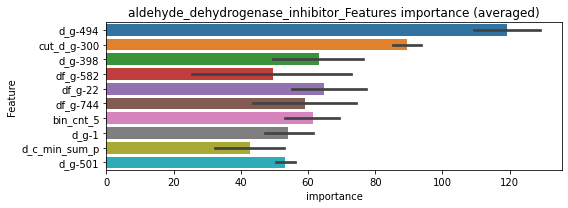

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117833	valid_1's binary_logloss: 0.0204486
[200]	training's binary_logloss: 0.00131452	valid_1's binary_logloss: 0.00885539
[300]	training's binary_logloss: 0.000368061	valid_1's binary_logloss: 0.007406
[400]	training's binary_logloss: 0.000193806	valid_1's binary_logloss: 0.00702356
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000190878	valid_1's binary_logloss: 0.00701619


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123377	valid_1's binary_logloss: 0.0158265
[200]	training's binary_logloss: 0.0014255	valid_1's binary_logloss: 0.00271967
[300]	training's binary_logloss: 0.000393895	valid_1's binary_logloss: 0.00109968
[400]	training's binary_logloss: 0.000204651	valid_1's binary_logloss: 0.000750704
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000164497	valid_1's binary_logloss: 0.000682891


aldehyde_dehydrogenase_inhibitor logloss: 0.003849948587549385


neg labels: 3289 → selected neg labels: 3282


alk_inhibitor, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312225	valid_1's binary_logloss: 0.0655458
[200]	training's binary_logloss: 0.0045119	valid_1's binary_logloss: 0.0279535
[300]	training's binary_logloss: 0.00130622	valid_1's binary_logloss: 0.019881
[400]	training's binary_logloss: 0.000651233	valid_1's binary_logloss: 0.0170234
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000617636	valid_1's binary_logloss: 0.016873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031831	valid_1's binary_logloss: 0.0549943
[200]	training's binary_logloss: 0.00486596	valid_1's binary_logloss: 0.0206613
[300]	training's binary_logloss: 0.00139847	valid_1's binary_logloss: 0.01287
[400]	training's binary_logloss: 0.00068968	valid_1's binary_logloss: 0.0107558
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000508247	valid_1's binary_logloss: 0.0100385


1 / 3 AUC score:1.000
y_Threshold: 0.0053431, Threshold: 0.0165623, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176
Num_p_label: 80.0, conf_0:0.01491, conf_1:0.01822
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0165623
Num_p_label: 48.0, Expected: 7.0, Adj_threshold_2: 0.0265623
Num_p_label: 35.0, Expected: 7.0, Adj_threshold_3: 0.0365623
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_4: 0.0465623
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_5: 0.0565623
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_6: 0.0665623
threshold: 0.0665623, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307539	valid_1's binary_logloss: 0.0610326
[200]	training's binary_logloss: 0.00426353	valid_1's binary_logloss: 0.023885
[300]	training's binary_logloss: 0.0012154	valid_1's binary_logloss: 0.0166643
[400]	training's binary_logloss: 0.000605184	valid_1's binary_logloss: 0.0141877
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000610996	valid_1's binary_logloss: 0.0141837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030379	valid_1's binary_logloss: 0.0497949
[200]	training's binary_logloss: 0.00432024	valid_1's binary_logloss: 0.0152965
[300]	training's binary_logloss: 0.00127331	valid_1's binary_logloss: 0.00864166
[400]	training's binary_logloss: 0.000632402	valid_1's binary_logloss: 0.00674204
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000489508	valid_1's binary_logloss: 0.00621292


2 / 3 AUC score:1.000
y_Threshold: 0.0860176, Threshold: 0.0665623, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0238574 Vs.target_rate: 0.00176
Num_p_label: 95.0, conf_0:0.05991, conf_1:0.07322
Num_p_label: 95.0, Expected: 7.0, Adj_threshold_1: 0.0665623
Num_p_label: 88.0, Expected: 7.0, Adj_threshold_2: 0.0765623
Num_p_label: 79.0, Expected: 7.0, Adj_threshold_3: 0.0865623
Num_p_label: 77.0, Expected: 7.0, Adj_threshold_4: 0.0965623
Num_p_label: 76.0, Expected: 7.0, Adj_threshold_5: 0.1065623
Num_p_label: 74.0, Expected: 7.0, Adj_threshold_6: 0.1165623
Num_p_label: 72.0, Expected: 7.0, Adj_threshold_7: 0.1265623
Num_p_label: 68.0, Expected: 7.0, Adj_threshold_8: 0.1365623
Num_p_label: 66.0, Expected: 7.0, Adj_threshold_9: 0.1465623
Num_p_label: 63.0, Expected: 7.0, Adj_threshold_10: 0.1565623
threshold: 0.1665623, positive_p_label: 60.0/3982, p_label_rate: 0.0150678
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307908	valid_1's binary_logloss: 0.0546491
[200]	training's binary_logloss: 0.00433851	valid_1's binary_logloss: 0.0181416
[300]	training's binary_logloss: 0.00125906	valid_1's binary_logloss: 0.0108023
[400]	training's binary_logloss: 0.000626103	valid_1's binary_logloss: 0.0083131
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000604462	valid_1's binary_logloss: 0.00819336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302261	valid_1's binary_logloss: 0.049051
[200]	training's binary_logloss: 0.00430858	valid_1's binary_logloss: 0.0157445
[300]	training's binary_logloss: 0.0012296	valid_1's binary_logloss: 0.00936817
[400]	training's binary_logloss: 0.000611907	valid_1's binary_logloss: 0.00742941
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000452303	valid_1's binary_logloss: 0.00676305


3 / 3 AUC score:1.000
y_Threshold: 0.1086580, Threshold: 0.1665623, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3800
p_label_rate: 0.0153189 Vs.target_rate: 0.00176
Num_p_label: 61.0, conf_0:0.14991, conf_1:0.18322
Num_p_label: 61.0, Expected: 7.0, Adj_threshold_1: 0.1665623
Num_p_label: 59.0, Expected: 7.0, Adj_threshold_2: 0.1765623
Num_p_label: 56.0, Expected: 7.0, Adj_threshold_3: 0.1865623
Num_p_label: 55.0, Expected: 7.0, Adj_threshold_4: 0.1965623
Num_p_label: 53.0, Expected: 7.0, Adj_threshold_5: 0.2065623
Num_p_label: 52.0, Expected: 7.0, Adj_threshold_6: 0.2165623
Num_p_label: 49.0, Expected: 7.0, Adj_threshold_7: 0.2265623
Num_p_label: 48.0, Expected: 7.0, Adj_threshold_8: 0.2365623
Num_p_label: 47.0, Expected: 7.0, Adj_threshold_9: 0.2465623
Num_p_label: 46.0, Expected: 7.0, Adj_threshold_10: 0.2565623
threshold: 0.2665623, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 697.0/7782, y_label_rate: 0.0895657


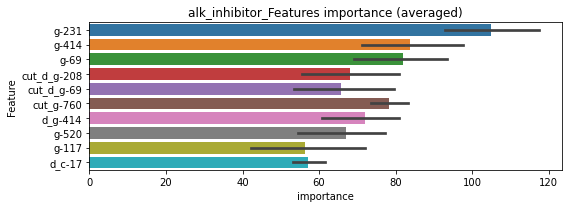

len(train_index) : 3891
len(valid_index) : 3891
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173916	valid_1's binary_logloss: 0.0346226
[200]	training's binary_logloss: 0.00255725	valid_1's binary_logloss: 0.0157942
[300]	training's binary_logloss: 0.000743925	valid_1's binary_logloss: 0.0116119
[400]	training's binary_logloss: 0.000372632	valid_1's binary_logloss: 0.0103364
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000261524	valid_1's binary_logloss: 0.0097137


len(train_index) : 3891
len(valid_index) : 3891
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180413	valid_1's binary_logloss: 0.032249
[200]	training's binary_logloss: 0.00268792	valid_1's binary_logloss: 0.0134099
[300]	training's binary_logloss: 0.000778789	valid_1's binary_logloss: 0.00977461
[400]	training's binary_logloss: 0.000389978	valid_1's binary_logloss: 0.00893246
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.000401821	valid_1's binary_logloss: 0.00889446


alk_inhibitor logloss: 0.009304083354218898


neg labels: 3289 → selected neg labels: 3287


ampk_activator, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188832	valid_1's binary_logloss: 0.0263634
[200]	training's binary_logloss: 0.00194657	valid_1's binary_logloss: 0.0067616
[300]	training's binary_logloss: 0.00055024	valid_1's binary_logloss: 0.00390329
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000545792	valid_1's binary_logloss: 0.00388343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190079	valid_1's binary_logloss: 0.0217569
[200]	training's binary_logloss: 0.00195671	valid_1's binary_logloss: 0.00309543
[300]	training's binary_logloss: 0.000555635	valid_1's binary_logloss: 0.00120998
[400]	training's binary_logloss: 0.000309444	valid_1's binary_logloss: 0.00080803
[500]	training's binary_logloss: 0.000262848	valid_1's binary_logloss: 0.000729405
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000261547	valid_1's binary_logloss: 0.000727

1 / 3 AUC score:1.000
y_Threshold: 0.0014519, Threshold: 0.0020846, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00188, conf_1:0.00229
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0020846
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_2: 0.0120846
threshold: 0.0120846, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019481	valid_1's binary_logloss: 0.0271296
[200]	training's binary_logloss: 0.00195755	valid_1's binary_logloss: 0.00643098
[300]	training's binary_logloss: 0.000558006	valid_1's binary_logloss: 0.00355062
[400]	training's binary_logloss: 0.000312834	valid_1's binary_logloss: 0.00302932
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000278994	valid_1's binary_logloss: 0.00288989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194661	valid_1's binary_logloss: 0.0226198
[200]	training's binary_logloss: 0.00196464	valid_1's binary_logloss: 0.00307441
[300]	training's binary_logloss: 0.000552385	valid_1's binary_logloss: 0.00122482
[400]	training's binary_logloss: 0.000310488	valid_1's binary_logloss: 0.000834347
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000268551	valid_1's binary_logloss: 0.00076

2 / 3 AUC score:1.000
y_Threshold: 0.0422977, Threshold: 0.0120846, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0030136 Vs.target_rate: 0.00050
Num_p_label: 12.0, conf_0:0.01088, conf_1:0.01329
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_1: 0.0120846
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.0220846
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.0320846
threshold: 0.0320846, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019481	valid_1's binary_logloss: 0.0271296
[200]	training's binary_logloss: 0.00195755	valid_1's binary_logloss: 0.00643098
[300]	training's binary_logloss: 0.000558006	valid_1's binary_logloss: 0.00355062
[400]	training's binary_logloss: 0.000312834	valid_1's binary_logloss: 0.00302932
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000278994	valid_1's binary_logloss: 0.00288989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194661	valid_1's binary_logloss: 0.0226198
[200]	training's binary_logloss: 0.00196464	valid_1's binary_logloss: 0.00307441
[300]	training's binary_logloss: 0.000552385	valid_1's binary_logloss: 0.00122482
[400]	training's binary_logloss: 0.000310488	valid_1's binary_logloss: 0.000834347
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000268551	valid_1's binary_logloss: 0.00076

3 / 3 AUC score:1.000
y_Threshold: 0.0422977, Threshold: 0.0320846, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050
Num_p_label: 3.0, conf_0:0.02888, conf_1:0.03529
threshold: 0.0320846, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


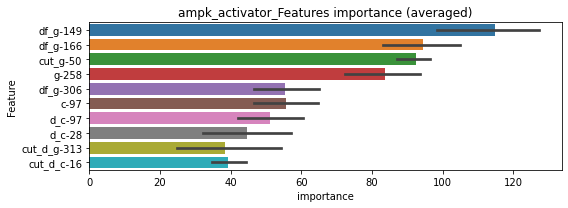

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101997	valid_1's binary_logloss: 0.014527
[200]	training's binary_logloss: 0.00101581	valid_1's binary_logloss: 0.00410635
[300]	training's binary_logloss: 0.000281619	valid_1's binary_logloss: 0.00331189
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000206761	valid_1's binary_logloss: 0.00324275


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010252	valid_1's binary_logloss: 0.0136676
[200]	training's binary_logloss: 0.00102932	valid_1's binary_logloss: 0.00317845
[300]	training's binary_logloss: 0.000287153	valid_1's binary_logloss: 0.00228807
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000186117	valid_1's binary_logloss: 0.00215763


ampk_activator logloss: 0.0027001916071701364


neg labels: 3289 → selected neg labels: 3287


analgesic, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186414	valid_1's binary_logloss: 0.0245064
[200]	training's binary_logloss: 0.00186896	valid_1's binary_logloss: 0.00493859
[300]	training's binary_logloss: 0.000526724	valid_1's binary_logloss: 0.00253163
[400]	training's binary_logloss: 0.000295674	valid_1's binary_logloss: 0.00186999
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000262945	valid_1's binary_logloss: 0.00178937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187959	valid_1's binary_logloss: 0.0219018
[200]	training's binary_logloss: 0.0018563	valid_1's binary_logloss: 0.0038748
[300]	training's binary_logloss: 0.000522042	valid_1's binary_logloss: 0.0018829
[400]	training's binary_logloss: 0.000295757	valid_1's binary_logloss: 0.00140347
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.0002567	valid_1's binary_logloss: 0.00132035


1 / 3 AUC score:1.000
y_Threshold: 0.0009753, Threshold: 0.0016268, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00146, conf_1:0.00179
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0016268
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.0116268
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_3: 0.0216268
threshold: 0.0216268, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186026	valid_1's binary_logloss: 0.0232769
[200]	training's binary_logloss: 0.00180707	valid_1's binary_logloss: 0.00436034
[300]	training's binary_logloss: 0.000513655	valid_1's binary_logloss: 0.00224035
[400]	training's binary_logloss: 0.000291413	valid_1's binary_logloss: 0.00173379
[500]	training's binary_logloss: 0.000255961	valid_1's binary_logloss: 0.0016744
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000253457	valid_1's binary_logloss: 0.00166483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190514	valid_1's binary_logloss: 0.0215839
[200]	training's binary_logloss: 0.00182253	valid_1's binary_logloss: 0.00344414
[300]	training's binary_logloss: 0.000516546	valid_1's binary_logloss: 0.0015728
[400]	training's binary_logloss: 0.000294245	valid_1's binary_logloss: 0.0011432
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0349198, Threshold: 0.0216268, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0050226 Vs.target_rate: 0.00050
Num_p_label: 20.0, conf_0:0.01946, conf_1:0.02379
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_1: 0.0216268
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.0316268
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_3: 0.0416268
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.0516268
threshold: 0.0516268, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186026	valid_1's binary_logloss: 0.0232769
[200]	training's binary_logloss: 0.00180707	valid_1's binary_logloss: 0.00436034
[300]	training's binary_logloss: 0.000513655	valid_1's binary_logloss: 0.00224035
[400]	training's binary_logloss: 0.000291413	valid_1's binary_logloss: 0.00173379
[500]	training's binary_logloss: 0.000255961	valid_1's binary_logloss: 0.0016744
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000253457	valid_1's binary_logloss: 0.00166483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190514	valid_1's binary_logloss: 0.0215839
[200]	training's binary_logloss: 0.00182253	valid_1's binary_logloss: 0.00344414
[300]	training's binary_logloss: 0.000516546	valid_1's binary_logloss: 0.0015728
[400]	training's binary_logloss: 0.000294245	valid_1's binary_logloss: 0.0011432
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.0349198, Threshold: 0.0516268, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050
Num_p_label: 4.0, conf_0:0.04646, conf_1:0.05679
threshold: 0.0516268, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


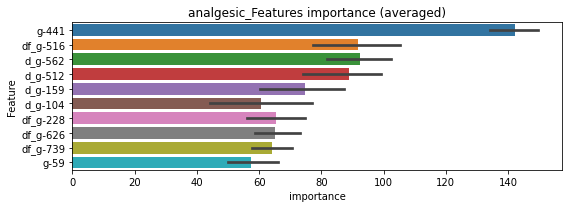

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00979204	valid_1's binary_logloss: 0.0159923
[200]	training's binary_logloss: 0.000933115	valid_1's binary_logloss: 0.00578444
[300]	training's binary_logloss: 0.000260327	valid_1's binary_logloss: 0.00502676
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000260327	valid_1's binary_logloss: 0.00502676


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100715	valid_1's binary_logloss: 0.01152
[200]	training's binary_logloss: 0.00101101	valid_1's binary_logloss: 0.00212144
[300]	training's binary_logloss: 0.000280764	valid_1's binary_logloss: 0.00137437
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000169473	valid_1's binary_logloss: 0.00128585


analgesic logloss: 0.00315630744084422


neg labels: 3289 → selected neg labels: 3281


androgen_receptor_agonist, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351716	valid_1's binary_logloss: 0.0744137
[200]	training's binary_logloss: 0.00569706	valid_1's binary_logloss: 0.0364698
[300]	training's binary_logloss: 0.00168884	valid_1's binary_logloss: 0.0273912
[400]	training's binary_logloss: 0.000838294	valid_1's binary_logloss: 0.0249037
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000639193	valid_1's binary_logloss: 0.0240418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384161	valid_1's binary_logloss: 0.0606387
[200]	training's binary_logloss: 0.0066275	valid_1's binary_logloss: 0.021626
[300]	training's binary_logloss: 0.00192367	valid_1's binary_logloss: 0.0143193
[400]	training's binary_logloss: 0.00091849	valid_1's binary_logloss: 0.0118737
[500]	training's binary_logloss: 0.000599104	valid_1's binary_logloss: 0.0109709
Early stopping, best iteration is:
[533]	tra

1 / 3 AUC score:1.000
y_Threshold: 0.0037908, Threshold: 0.0053937, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.00485, conf_1:0.00593
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0053937
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_2: 0.0153937
threshold: 0.0153937, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357603	valid_1's binary_logloss: 0.0732947
[200]	training's binary_logloss: 0.00584285	valid_1's binary_logloss: 0.033991
[300]	training's binary_logloss: 0.00170293	valid_1's binary_logloss: 0.0260887
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00131235	valid_1's binary_logloss: 0.0251028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391622	valid_1's binary_logloss: 0.0617834
[200]	training's binary_logloss: 0.00646366	valid_1's binary_logloss: 0.0214673
[300]	training's binary_logloss: 0.00186872	valid_1's binary_logloss: 0.0133675
[400]	training's binary_logloss: 0.000910486	valid_1's binary_logloss: 0.011061
[500]	training's binary_logloss: 0.000588306	valid_1's binary_logloss: 0.0101445
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000517317	valid_1's binary_logloss: 0.00992047


2 / 3 AUC score:1.000
y_Threshold: 0.0287982, Threshold: 0.0153937, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0087896 Vs.target_rate: 0.00202
Num_p_label: 35.0, conf_0:0.01385, conf_1:0.01693
Num_p_label: 35.0, Expected: 8.0, Adj_threshold_1: 0.0153937
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_2: 0.0253937
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_3: 0.0353937
threshold: 0.0353937, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358898	valid_1's binary_logloss: 0.0693374
[200]	training's binary_logloss: 0.00597841	valid_1's binary_logloss: 0.0290997
[300]	training's binary_logloss: 0.00174169	valid_1's binary_logloss: 0.0204739
[400]	training's binary_logloss: 0.000847913	valid_1's binary_logloss: 0.0182394
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000730821	valid_1's binary_logloss: 0.0178071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372746	valid_1's binary_logloss: 0.0631963
[200]	training's binary_logloss: 0.00625407	valid_1's binary_logloss: 0.0255622
[300]	training's binary_logloss: 0.00182566	valid_1's binary_logloss: 0.0176039
[400]	training's binary_logloss: 0.000886342	valid_1's binary_logloss: 0.0153641
[500]	training's binary_logloss: 0.000578435	valid_1's binary_logloss: 0.0143274
Early stopping, best iteration is:
[506]	

3 / 3 AUC score:1.000
y_Threshold: 0.0150614, Threshold: 0.0353937, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3799
p_label_rate: 0.0020090 Vs.target_rate: 0.00202
Num_p_label: 8.0, conf_0:0.03185, conf_1:0.03893
threshold: 0.0353937, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 661.0/7781, y_label_rate: 0.0849505


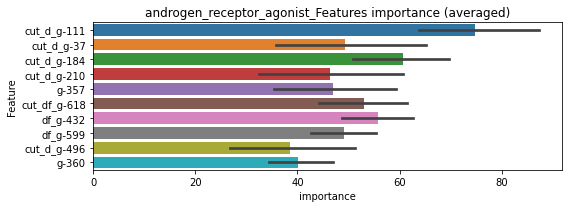

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183932	valid_1's binary_logloss: 0.0441873
[200]	training's binary_logloss: 0.00298095	valid_1's binary_logloss: 0.0250486
[300]	training's binary_logloss: 0.000866096	valid_1's binary_logloss: 0.022375
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00045179	valid_1's binary_logloss: 0.0215113


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213673	valid_1's binary_logloss: 0.033672
[200]	training's binary_logloss: 0.00365451	valid_1's binary_logloss: 0.0122226
[300]	training's binary_logloss: 0.00103464	valid_1's binary_logloss: 0.00799141
[400]	training's binary_logloss: 0.000492669	valid_1's binary_logloss: 0.00690626
[500]	training's binary_logloss: 0.000318921	valid_1's binary_logloss: 0.00647146
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000287317	valid_1's binary_logloss: 0.00635317


androgen_receptor_agonist logloss: 0.013933232809453147


neg labels: 3289 → selected neg labels: 3274


androgen_receptor_antagonist, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492991	valid_1's binary_logloss: 0.110084
[200]	training's binary_logloss: 0.0107956	valid_1's binary_logloss: 0.0735447
[300]	training's binary_logloss: 0.00326352	valid_1's binary_logloss: 0.0658307
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00260414	valid_1's binary_logloss: 0.0648555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056587	valid_1's binary_logloss: 0.11059
[200]	training's binary_logloss: 0.0137371	valid_1's binary_logloss: 0.0710231
[300]	training's binary_logloss: 0.00395072	valid_1's binary_logloss: 0.0594566
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0026787	valid_1's binary_logloss: 0.0576739


1 / 3 AUC score:0.996
y_Threshold: 0.0141353, Threshold: 0.0181369, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 158 → Positive_corect_labels: 641/3770
p_label_rate: 0.0200904 Vs.target_rate: 0.00374
Num_p_label: 80.0, conf_0:0.01632, conf_1:0.01995
Num_p_label: 80.0, Expected: 14.9, Adj_threshold_1: 0.0181369
Num_p_label: 26.0, Expected: 14.9, Adj_threshold_2: 0.0281369
threshold: 0.0281369, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 641.0/3770, y_label_rate: 0.1700265
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047615	valid_1's binary_logloss: 0.119981
[200]	training's binary_logloss: 0.0097823	valid_1's binary_logloss: 0.0794445
[300]	training's binary_logloss: 0.00296982	valid_1's binary_logloss: 0.0725202
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00267833	valid_1's binary_logloss: 0.0718571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518363	valid_1's binary_logloss: 0.106242
[200]	training's binary_logloss: 0.0106508	valid_1's binary_logloss: 0.059512
[300]	training's binary_logloss: 0.00324959	valid_1's binary_logloss: 0.0492075
[400]	training's binary_logloss: 0.00151948	valid_1's binary_logloss: 0.0463978
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.0015031	valid_1's binary_logloss: 0.0463519


2 / 3 AUC score:0.998
y_Threshold: 0.0289337, Threshold: 0.0281369, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 628.0/3744
p_label_rate: 0.0092918 Vs.target_rate: 0.00374
Num_p_label: 37.0, conf_0:0.02532, conf_1:0.03095
threshold: 0.0281369, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 628.0/3744, y_label_rate: 0.1677350
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470617	valid_1's binary_logloss: 0.103628
[200]	training's binary_logloss: 0.00931097	valid_1's binary_logloss: 0.0612024
[300]	training's binary_logloss: 0.00285847	valid_1's binary_logloss: 0.0516792
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00178251	valid_1's binary_logloss: 0.0499696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470778	valid_1's binary_logloss: 0.11024
[200]	training's binary_logloss: 0.00937752	valid_1's binary_logloss: 0.0709091
[300]	training's binary_logloss: 0.00289274	valid_1's binary_logloss: 0.0617836
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00253577	valid_1's binary_logloss: 0.0609573


3 / 3 AUC score:0.999
y_Threshold: 0.0301359, Threshold: 0.0281369, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 618.0/3724
p_label_rate: 0.0077850 Vs.target_rate: 0.00374
Num_p_label: 31.0, conf_0:0.02532, conf_1:0.03095
threshold: 0.0281369, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 649.0/7706, y_label_rate: 0.0842201


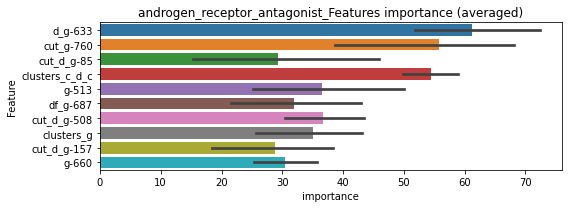

len(train_index) : 3853
len(valid_index) : 3853
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261039	valid_1's binary_logloss: 0.0681159
[200]	training's binary_logloss: 0.00518424	valid_1's binary_logloss: 0.048498
[300]	training's binary_logloss: 0.00163289	valid_1's binary_logloss: 0.0450912
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00143431	valid_1's binary_logloss: 0.0448344


len(train_index) : 3853
len(valid_index) : 3853
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279355	valid_1's binary_logloss: 0.0714233
[200]	training's binary_logloss: 0.00589218	valid_1's binary_logloss: 0.0501345
[300]	training's binary_logloss: 0.00175861	valid_1's binary_logloss: 0.0451863
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00179435	valid_1's binary_logloss: 0.0451399


androgen_receptor_antagonist logloss: 0.04498716982347446


neg labels: 3289 → selected neg labels: 3276


anesthetic_-_local, len(trt): 80, len(othr): 3276, target_rate: 0.0033594 → Adj_target_rate: 0.0034820
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510023	valid_1's binary_logloss: 0.1105
[200]	training's binary_logloss: 0.0108054	valid_1's binary_logloss: 0.0688307
[300]	training's binary_logloss: 0.00316048	valid_1's binary_logloss: 0.0588492
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00243976	valid_1's binary_logloss: 0.0579121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518213	valid_1's binary_logloss: 0.112348
[200]	training's binary_logloss: 0.010736	valid_1's binary_logloss: 0.0740304
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00549026	valid_1's binary_logloss: 0.068566


1 / 3 AUC score:0.995
y_Threshold: 0.0180173, Threshold: 0.0200514, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 647/3783
p_label_rate: 0.0200904 Vs.target_rate: 0.00336
Num_p_label: 80.0, conf_0:0.01805, conf_1:0.02206
Num_p_label: 80.0, Expected: 13.4, Adj_threshold_1: 0.0200514
Num_p_label: 30.0, Expected: 13.4, Adj_threshold_2: 0.0300514
Num_p_label: 15.0, Expected: 13.4, Adj_threshold_3: 0.0400514
threshold: 0.0400514, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 647.0/3783, y_label_rate: 0.1710283
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493244	valid_1's binary_logloss: 0.105473
[200]	training's binary_logloss: 0.0100808	valid_1's binary_logloss: 0.062268
[300]	training's binary_logloss: 0.00300621	valid_1's binary_logloss: 0.0520849
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00208124	valid_1's binary_logloss: 0.0505059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509422	valid_1's binary_logloss: 0.102152
[200]	training's binary_logloss: 0.0104423	valid_1's binary_logloss: 0.0589536
[300]	training's binary_logloss: 0.00310705	valid_1's binary_logloss: 0.0482357
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00173153	valid_1's binary_logloss: 0.046147


2 / 3 AUC score:0.998
y_Threshold: 0.0322841, Threshold: 0.0400514, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 637.0/3763
p_label_rate: 0.0040181 Vs.target_rate: 0.00336
Num_p_label: 16.0, conf_0:0.03605, conf_1:0.04406
threshold: 0.0400514, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 637.0/3763, y_label_rate: 0.1692798
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495626	valid_1's binary_logloss: 0.0965126
[200]	training's binary_logloss: 0.00976926	valid_1's binary_logloss: 0.0552944
[300]	training's binary_logloss: 0.0029047	valid_1's binary_logloss: 0.0451958
[400]	training's binary_logloss: 0.00135513	valid_1's binary_logloss: 0.0424549
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000969609	valid_1's binary_logloss: 0.0415752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0502838	valid_1's binary_logloss: 0.0960957
[200]	training's binary_logloss: 0.0100533	valid_1's binary_logloss: 0.0506074
[300]	training's binary_logloss: 0.00304589	valid_1's binary_logloss: 0.0391235
[400]	training's binary_logloss: 0.00141109	valid_1's binary_logloss: 0.0355705
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00136733	valid_1's binary_logloss: 0.035325


3 / 3 AUC score:0.999
y_Threshold: 0.0321301, Threshold: 0.0400514, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 630.0/3749
p_label_rate: 0.0032647 Vs.target_rate: 0.00336
Num_p_label: 13.0, conf_0:0.03605, conf_1:0.04406
threshold: 0.0400514, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 643.0/7731, y_label_rate: 0.0831716


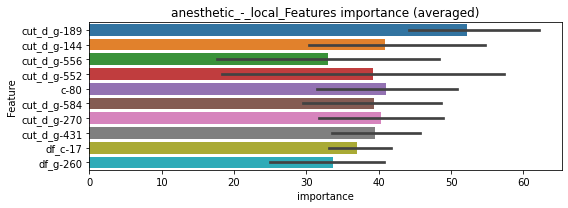

len(train_index) : 3865
len(valid_index) : 3866
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271049	valid_1's binary_logloss: 0.0570345
[200]	training's binary_logloss: 0.00512691	valid_1's binary_logloss: 0.0337406
[300]	training's binary_logloss: 0.00150489	valid_1's binary_logloss: 0.029384
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000746577	valid_1's binary_logloss: 0.0276311


len(train_index) : 3866
len(valid_index) : 3865
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264275	valid_1's binary_logloss: 0.0577297
[200]	training's binary_logloss: 0.00526281	valid_1's binary_logloss: 0.0337803
[300]	training's binary_logloss: 0.00155464	valid_1's binary_logloss: 0.0281556
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00114075	valid_1's binary_logloss: 0.0272472


anesthetic_-_local logloss: 0.027439153901539913


neg labels: 3289 → selected neg labels: 3283


angiogenesis_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331562	valid_1's binary_logloss: 0.055567
[200]	training's binary_logloss: 0.00494985	valid_1's binary_logloss: 0.0220436
[300]	training's binary_logloss: 0.00135406	valid_1's binary_logloss: 0.0160651
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00090208	valid_1's binary_logloss: 0.0152933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349857	valid_1's binary_logloss: 0.0526909
[200]	training's binary_logloss: 0.00567563	valid_1's binary_logloss: 0.0165643
[300]	training's binary_logloss: 0.00155876	valid_1's binary_logloss: 0.00956613
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000816281	valid_1's binary_logloss: 0.00785921


1 / 3 AUC score:1.000
y_Threshold: 0.0048800, Threshold: 0.0072516, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00653, conf_1:0.00798
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0072516
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_2: 0.0172516
threshold: 0.0172516, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332123	valid_1's binary_logloss: 0.0546835
[200]	training's binary_logloss: 0.00480149	valid_1's binary_logloss: 0.02152
[300]	training's binary_logloss: 0.00134941	valid_1's binary_logloss: 0.0165688
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000915984	valid_1's binary_logloss: 0.0155993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035103	valid_1's binary_logloss: 0.0545934
[200]	training's binary_logloss: 0.0054717	valid_1's binary_logloss: 0.0160393
[300]	training's binary_logloss: 0.00151674	valid_1's binary_logloss: 0.00897544
[400]	training's binary_logloss: 0.000732088	valid_1's binary_logloss: 0.00714983
[500]	training's binary_logloss: 0.000490512	valid_1's binary_logloss: 0.00645769
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000481259	valid_1's binary_logloss: 0.00643232


2 / 3 AUC score:1.000
y_Threshold: 0.0257094, Threshold: 0.0172516, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0082873 Vs.target_rate: 0.00151
Num_p_label: 33.0, conf_0:0.01553, conf_1:0.01898
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_1: 0.0172516
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_2: 0.0272516
threshold: 0.0272516, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332123	valid_1's binary_logloss: 0.0546835
[200]	training's binary_logloss: 0.00480149	valid_1's binary_logloss: 0.02152
[300]	training's binary_logloss: 0.00134941	valid_1's binary_logloss: 0.0165688
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000915984	valid_1's binary_logloss: 0.0155993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035103	valid_1's binary_logloss: 0.0545934
[200]	training's binary_logloss: 0.0054717	valid_1's binary_logloss: 0.0160393
[300]	training's binary_logloss: 0.00151674	valid_1's binary_logloss: 0.00897544
[400]	training's binary_logloss: 0.000732088	valid_1's binary_logloss: 0.00714983
[500]	training's binary_logloss: 0.000490512	valid_1's binary_logloss: 0.00645769
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000481259	valid_1's binary_logloss: 0.00643232


3 / 3 AUC score:1.000
y_Threshold: 0.0257094, Threshold: 0.0272516, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0027624 Vs.target_rate: 0.00151
Num_p_label: 11.0, conf_0:0.02453, conf_1:0.02998
threshold: 0.0272516, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7789, y_label_rate: 0.0856336


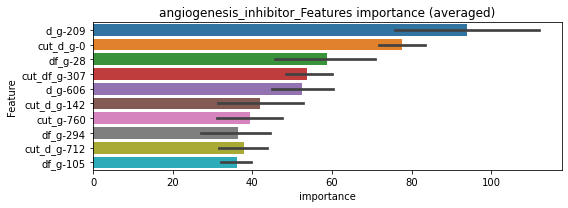

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180459	valid_1's binary_logloss: 0.038798
[200]	training's binary_logloss: 0.00262943	valid_1's binary_logloss: 0.0224569
[300]	training's binary_logloss: 0.000715029	valid_1's binary_logloss: 0.0204706
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.000773684	valid_1's binary_logloss: 0.0204329


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199417	valid_1's binary_logloss: 0.0332467
[200]	training's binary_logloss: 0.00318433	valid_1's binary_logloss: 0.0130072
[300]	training's binary_logloss: 0.000877421	valid_1's binary_logloss: 0.00891544
[400]	training's binary_logloss: 0.000414216	valid_1's binary_logloss: 0.00791525
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000437553	valid_1's binary_logloss: 0.00788952


angiogenesis_inhibitor logloss: 0.014161996287589436


neg labels: 3289 → selected neg labels: 3283


angiotensin_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308985	valid_1's binary_logloss: 0.0555685
[200]	training's binary_logloss: 0.00462583	valid_1's binary_logloss: 0.0209562
[300]	training's binary_logloss: 0.00133205	valid_1's binary_logloss: 0.0145523
[400]	training's binary_logloss: 0.000673304	valid_1's binary_logloss: 0.012681
[500]	training's binary_logloss: 0.000451081	valid_1's binary_logloss: 0.0118177
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000440715	valid_1's binary_logloss: 0.0117801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316222	valid_1's binary_logloss: 0.0533151
[200]	training's binary_logloss: 0.00512597	valid_1's binary_logloss: 0.0189454
[300]	training's binary_logloss: 0.00143995	valid_1's binary_logloss: 0.0112864
[400]	training's binary_logloss: 0.000695313	valid_1's binary_logloss: 0.00863745
Early stopping, best iteration is:
[480]	

1 / 3 AUC score:1.000
y_Threshold: 0.0025386, Threshold: 0.0037333, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00336, conf_1:0.00411
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0037333
Num_p_label: 4.0, Expected: 6.2, Adj_threshold_2: 0.0137333
threshold: 0.0137333, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313815	valid_1's binary_logloss: 0.0583281
[200]	training's binary_logloss: 0.00452926	valid_1's binary_logloss: 0.0224713
[300]	training's binary_logloss: 0.00130857	valid_1's binary_logloss: 0.0155907
[400]	training's binary_logloss: 0.000671635	valid_1's binary_logloss: 0.0136092
[500]	training's binary_logloss: 0.000447242	valid_1's binary_logloss: 0.0127167
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000455104	valid_1's binary_logloss: 0.0126908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328237	valid_1's binary_logloss: 0.056085
[200]	training's binary_logloss: 0.00491719	valid_1's binary_logloss: 0.0198026
[300]	training's binary_logloss: 0.00142102	valid_1's binary_logloss: 0.0125529
[400]	training's binary_logloss: 0.000704128	valid_1's binary_logloss: 0.010013
[500]	training's binary_logloss: 0.00046750

2 / 3 AUC score:1.000
y_Threshold: 0.0150894, Threshold: 0.0137333, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0055249 Vs.target_rate: 0.00155
Num_p_label: 22.0, conf_0:0.01236, conf_1:0.01511
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_1: 0.0137333
Num_p_label: 5.0, Expected: 6.2, Adj_threshold_2: 0.0237333
threshold: 0.0237333, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306528	valid_1's binary_logloss: 0.0553996
[200]	training's binary_logloss: 0.00447643	valid_1's binary_logloss: 0.0241444
[300]	training's binary_logloss: 0.00130893	valid_1's binary_logloss: 0.0194455
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00130893	valid_1's binary_logloss: 0.0194455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325885	valid_1's binary_logloss: 0.0515074
[200]	training's binary_logloss: 0.0047995	valid_1's binary_logloss: 0.0152387
[300]	training's binary_logloss: 0.00138447	valid_1's binary_logloss: 0.00942179
[400]	training's binary_logloss: 0.000695981	valid_1's binary_logloss: 0.00762331
[500]	training's binary_logloss: 0.000467512	valid_1's binary_logloss: 0.00690674
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000440515	valid_1's binary_logloss: 0.00682299


3 / 3 AUC score:1.000
y_Threshold: 0.0206235, Threshold: 0.0237333, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0025113 Vs.target_rate: 0.00155
Num_p_label: 10.0, conf_0:0.02136, conf_1:0.02611
threshold: 0.0237333, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 663.0/7783, y_label_rate: 0.0851857


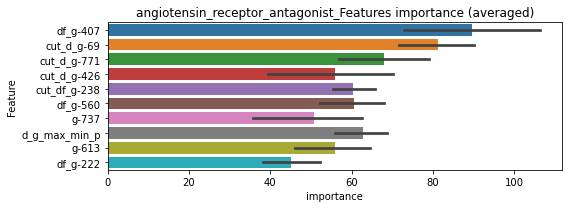

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171592	valid_1's binary_logloss: 0.0394996
[200]	training's binary_logloss: 0.0026019	valid_1's binary_logloss: 0.0211164
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00120701	valid_1's binary_logloss: 0.0192024


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169869	valid_1's binary_logloss: 0.036311
[200]	training's binary_logloss: 0.0024757	valid_1's binary_logloss: 0.0180451
[300]	training's binary_logloss: 0.000712904	valid_1's binary_logloss: 0.0152103
[400]	training's binary_logloss: 0.000353892	valid_1's binary_logloss: 0.0145286
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000291281	valid_1's binary_logloss: 0.0142149


angiotensin_receptor_antagonist logloss: 0.016708999878254378


neg labels: 3289 → selected neg labels: 3277


anti-inflammatory, len(trt): 73, len(othr): 3277, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046801	valid_1's binary_logloss: 0.0930679
[200]	training's binary_logloss: 0.00873065	valid_1's binary_logloss: 0.0481348
[300]	training's binary_logloss: 0.00254327	valid_1's binary_logloss: 0.0379736
[400]	training's binary_logloss: 0.00117779	valid_1's binary_logloss: 0.0350531
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00124261	valid_1's binary_logloss: 0.0349471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444417	valid_1's binary_logloss: 0.0845239
[200]	training's binary_logloss: 0.00868328	valid_1's binary_logloss: 0.0413848
[300]	training's binary_logloss: 0.00254652	valid_1's binary_logloss: 0.03048
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00134879	valid_1's binary_logloss: 0.0271953


1 / 3 AUC score:0.999
y_Threshold: 0.0089190, Threshold: 0.0147205, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3794
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.01325, conf_1:0.01619
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0147205
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_2: 0.0247205
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_3: 0.0347205
threshold: 0.0347205, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 652.0/3794, y_label_rate: 0.1718503
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410793	valid_1's binary_logloss: 0.0892449
[200]	training's binary_logloss: 0.00754383	valid_1's binary_logloss: 0.0464364
[300]	training's binary_logloss: 0.00231827	valid_1's binary_logloss: 0.0376087
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00124791	valid_1's binary_logloss: 0.0352311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444082	valid_1's binary_logloss: 0.0904184
[200]	training's binary_logloss: 0.00800493	valid_1's binary_logloss: 0.0450228
[300]	training's binary_logloss: 0.00235059	valid_1's binary_logloss: 0.0344913
[400]	training's binary_logloss: 0.0011267	valid_1's binary_logloss: 0.0319889
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00108208	valid_1's binary_logloss: 0.0318281


2 / 3 AUC score:1.000
y_Threshold: 0.0320163, Threshold: 0.0347205, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 649.0/3788
p_label_rate: 0.0110497 Vs.target_rate: 0.00307
Num_p_label: 44.0, conf_0:0.03125, conf_1:0.03819
Num_p_label: 44.0, Expected: 12.2, Adj_threshold_1: 0.0347205
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_2: 0.0447205
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_3: 0.0547205
threshold: 0.0547205, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 649.0/3788, y_label_rate: 0.1713305
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435611	valid_1's binary_logloss: 0.0914891
[200]	training's binary_logloss: 0.00801802	valid_1's binary_logloss: 0.0490531
[300]	training's binary_logloss: 0.00233013	valid_1's binary_logloss: 0.0394726
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00175492	valid_1's binary_logloss: 0.0382202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421338	valid_1's binary_logloss: 0.0861261
[200]	training's binary_logloss: 0.00755407	valid_1's binary_logloss: 0.0448187
[300]	training's binary_logloss: 0.00224865	valid_1's binary_logloss: 0.0352644
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00160409	valid_1's binary_logloss: 0.0331685


3 / 3 AUC score:0.999
y_Threshold: 0.0355190, Threshold: 0.0547205, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 645.0/3780
p_label_rate: 0.0067805 Vs.target_rate: 0.00307
Num_p_label: 27.0, conf_0:0.04925, conf_1:0.06019
threshold: 0.0547205, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 672.0/7762, y_label_rate: 0.0865756


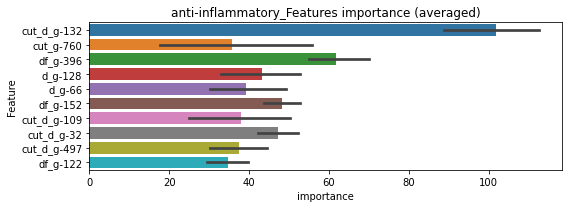

len(train_index) : 3881
len(valid_index) : 3881
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246426	valid_1's binary_logloss: 0.0575639
[200]	training's binary_logloss: 0.00479029	valid_1's binary_logloss: 0.0380422
[300]	training's binary_logloss: 0.00136828	valid_1's binary_logloss: 0.0336574
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00138168	valid_1's binary_logloss: 0.0336286


len(train_index) : 3881
len(valid_index) : 3881
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254319	valid_1's binary_logloss: 0.0525927
[200]	training's binary_logloss: 0.00482558	valid_1's binary_logloss: 0.0278166
[300]	training's binary_logloss: 0.0014207	valid_1's binary_logloss: 0.0222086
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000776592	valid_1's binary_logloss: 0.0209876


anti-inflammatory logloss: 0.027308111131884784


neg labels: 3289 → selected neg labels: 3285


antiarrhythmic, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251337	valid_1's binary_logloss: 0.0456725
[200]	training's binary_logloss: 0.00316891	valid_1's binary_logloss: 0.0180128
[300]	training's binary_logloss: 0.000903031	valid_1's binary_logloss: 0.013021
[400]	training's binary_logloss: 0.000463758	valid_1's binary_logloss: 0.0110288
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000365901	valid_1's binary_logloss: 0.0106176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278558	valid_1's binary_logloss: 0.0384966
[200]	training's binary_logloss: 0.00355644	valid_1's binary_logloss: 0.00882376
[300]	training's binary_logloss: 0.000997124	valid_1's binary_logloss: 0.00488811
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00067146	valid_1's binary_logloss: 0.00429636


1 / 3 AUC score:1.000
y_Threshold: 0.0023699, Threshold: 0.0253678, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.02283, conf_1:0.02790
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0253678
Num_p_label: 62.0, Expected: 4.0, Adj_threshold_2: 0.0353678
Num_p_label: 47.0, Expected: 4.0, Adj_threshold_3: 0.0453678
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_4: 0.0553678
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_5: 0.0653678
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_6: 0.0753678
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_7: 0.0853678
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_8: 0.0953678
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_9: 0.1053678
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_10: 0.1153678
threshold: 0.1253678, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249798	valid_1's binary_logloss: 0.0456626
[200]	training's binary_logloss: 0.00303562	valid_1's binary_logloss: 0.0177777
[300]	training's binary_logloss: 0.000859686	valid_1's binary_logloss: 0.0119537
[400]	training's binary_logloss: 0.000446256	valid_1's binary_logloss: 0.0098155
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000374307	valid_1's binary_logloss: 0.00956286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264903	valid_1's binary_logloss: 0.0333874
[200]	training's binary_logloss: 0.00336155	valid_1's binary_logloss: 0.00623228
[300]	training's binary_logloss: 0.000947309	valid_1's binary_logloss: 0.00257052
[400]	training's binary_logloss: 0.000486361	valid_1's binary_logloss: 0.00174238
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000384795	valid_1's binary_logloss: 0.00157607

2 / 3 AUC score:1.000
y_Threshold: 0.1336932, Threshold: 0.1253678, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0379206 Vs.target_rate: 0.00101
Num_p_label: 151.0, conf_0:0.11283, conf_1:0.13790
Num_p_label: 151.0, Expected: 4.0, Adj_threshold_1: 0.1253678
Num_p_label: 147.0, Expected: 4.0, Adj_threshold_2: 0.1353678
Num_p_label: 146.0, Expected: 4.0, Adj_threshold_3: 0.1453678
Num_p_label: 144.0, Expected: 4.0, Adj_threshold_4: 0.1553678
Num_p_label: 144.0, Expected: 4.0, Adj_threshold_5: 0.1653678
Num_p_label: 143.0, Expected: 4.0, Adj_threshold_6: 0.1753678
Num_p_label: 143.0, Expected: 4.0, Adj_threshold_7: 0.1853678
Num_p_label: 143.0, Expected: 4.0, Adj_threshold_8: 0.1953678
Num_p_label: 141.0, Expected: 4.0, Adj_threshold_9: 0.2053678
Num_p_label: 141.0, Expected: 4.0, Adj_threshold_10: 0.2153678
threshold: 0.2253678, positive_p_label: 141.0/3982, p_label_rate: 0.0354093
positive_y_label: 655.0/3806, y_label_rate: 0.17209

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025435	valid_1's binary_logloss: 0.0360106
[200]	training's binary_logloss: 0.0031094	valid_1's binary_logloss: 0.0076818
[300]	training's binary_logloss: 0.000887715	valid_1's binary_logloss: 0.00362594
[400]	training's binary_logloss: 0.000460607	valid_1's binary_logloss: 0.0024233
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000359729	valid_1's binary_logloss: 0.00213351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258645	valid_1's binary_logloss: 0.0386057
[200]	training's binary_logloss: 0.00317454	valid_1's binary_logloss: 0.0102621
[300]	training's binary_logloss: 0.00089382	valid_1's binary_logloss: 0.00581325
[400]	training's binary_logloss: 0.000458101	valid_1's binary_logloss: 0.00421866
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000385245	valid_1's binary_logloss: 0.00392931


3 / 3 AUC score:1.000
y_Threshold: 0.1531780, Threshold: 0.2253678, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0326469 Vs.target_rate: 0.00101
Num_p_label: 130.0, conf_0:0.20283, conf_1:0.24790
Num_p_label: 130.0, Expected: 4.0, Adj_threshold_1: 0.2253678
Num_p_label: 127.0, Expected: 4.0, Adj_threshold_2: 0.2353678
Num_p_label: 127.0, Expected: 4.0, Adj_threshold_3: 0.2453678
Num_p_label: 126.0, Expected: 4.0, Adj_threshold_4: 0.2553678
Num_p_label: 125.0, Expected: 4.0, Adj_threshold_5: 0.2653678
Num_p_label: 123.0, Expected: 4.0, Adj_threshold_6: 0.2753678
Num_p_label: 121.0, Expected: 4.0, Adj_threshold_7: 0.2853678
Num_p_label: 121.0, Expected: 4.0, Adj_threshold_8: 0.2953678
Num_p_label: 120.0, Expected: 4.0, Adj_threshold_9: 0.3053678
Num_p_label: 117.0, Expected: 4.0, Adj_threshold_10: 0.3153678
threshold: 0.3253678, positive_p_label: 114.0/3982, p_label_rate: 0.0286288
positive_y_label: 769.0/7788, y_label_rate: 0.09874

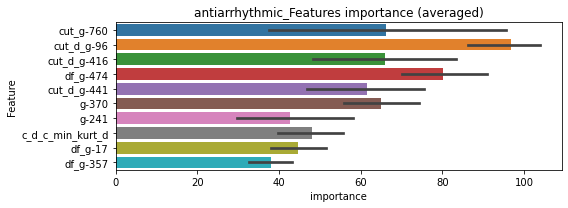

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171252	valid_1's binary_logloss: 0.0277482
[200]	training's binary_logloss: 0.00223893	valid_1's binary_logloss: 0.0120399
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.000840647	valid_1's binary_logloss: 0.0103632


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017038	valid_1's binary_logloss: 0.0287826
[200]	training's binary_logloss: 0.00228708	valid_1's binary_logloss: 0.0119558
[300]	training's binary_logloss: 0.000652384	valid_1's binary_logloss: 0.00917587
[400]	training's binary_logloss: 0.000321301	valid_1's binary_logloss: 0.00834637
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000306059	valid_1's binary_logloss: 0.00832438


antiarrhythmic logloss: 0.00934378149342221


neg labels: 3289 → selected neg labels: 3281


antibiotic, len(trt): 43, len(othr): 3281, target_rate: 0.0018057 → Adj_target_rate: 0.0020542
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315053	valid_1's binary_logloss: 0.0598444
[200]	training's binary_logloss: 0.00487246	valid_1's binary_logloss: 0.028178
[300]	training's binary_logloss: 0.001442	valid_1's binary_logloss: 0.0225877
[400]	training's binary_logloss: 0.000731933	valid_1's binary_logloss: 0.0207769
[500]	training's binary_logloss: 0.000496516	valid_1's binary_logloss: 0.0201808
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000502232	valid_1's binary_logloss: 0.0201282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353059	valid_1's binary_logloss: 0.0578865
[200]	training's binary_logloss: 0.00558437	valid_1's binary_logloss: 0.020654
[300]	training's binary_logloss: 0.00160765	valid_1's binary_logloss: 0.0134596
[400]	training's binary_logloss: 0.000789376	valid_1's binary_logloss: 0.0114958
Early stopping, best iteration is:
[402]	trai

1 / 3 AUC score:1.000
y_Threshold: 0.0030617, Threshold: 0.0065142, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00181
Num_p_label: 80.0, conf_0:0.00586, conf_1:0.00717
Num_p_label: 80.0, Expected: 7.2, Adj_threshold_1: 0.0065142
Num_p_label: 13.0, Expected: 7.2, Adj_threshold_2: 0.0165142
threshold: 0.0165142, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323619	valid_1's binary_logloss: 0.0590451
[200]	training's binary_logloss: 0.00477426	valid_1's binary_logloss: 0.0242373
[300]	training's binary_logloss: 0.00138165	valid_1's binary_logloss: 0.0186213
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.000903429	valid_1's binary_logloss: 0.0175841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348069	valid_1's binary_logloss: 0.0578223
[200]	training's binary_logloss: 0.00558761	valid_1's binary_logloss: 0.0204828
[300]	training's binary_logloss: 0.00161427	valid_1's binary_logloss: 0.0134225
[400]	training's binary_logloss: 0.00079911	valid_1's binary_logloss: 0.0112297
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000614082	valid_1's binary_logloss: 0.0105956


2 / 3 AUC score:1.000
y_Threshold: 0.0216238, Threshold: 0.0165142, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0213461 Vs.target_rate: 0.00181
Num_p_label: 85.0, conf_0:0.01486, conf_1:0.01817
Num_p_label: 85.0, Expected: 7.2, Adj_threshold_1: 0.0165142
Num_p_label: 48.0, Expected: 7.2, Adj_threshold_2: 0.0265142
Num_p_label: 29.0, Expected: 7.2, Adj_threshold_3: 0.0365142
Num_p_label: 21.0, Expected: 7.2, Adj_threshold_4: 0.0465142
Num_p_label: 15.0, Expected: 7.2, Adj_threshold_5: 0.0565142
Num_p_label: 13.0, Expected: 7.2, Adj_threshold_6: 0.0665142
threshold: 0.0665142, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347891	valid_1's binary_logloss: 0.0600851
[200]	training's binary_logloss: 0.00520591	valid_1's binary_logloss: 0.0203364
[300]	training's binary_logloss: 0.00152918	valid_1's binary_logloss: 0.0133798
[400]	training's binary_logloss: 0.000760949	valid_1's binary_logloss: 0.0113623
[500]	training's binary_logloss: 0.000506187	valid_1's binary_logloss: 0.0104174
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000512349	valid_1's binary_logloss: 0.01039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349431	valid_1's binary_logloss: 0.052765
[200]	training's binary_logloss: 0.00557131	valid_1's binary_logloss: 0.0160772
[300]	training's binary_logloss: 0.00160371	valid_1's binary_logloss: 0.00894103
[400]	training's binary_logloss: 0.000783652	valid_1's binary_logloss: 0.00686923
[500]	training's binary_logloss: 0.0005225

3 / 3 AUC score:1.000
y_Threshold: 0.0226602, Threshold: 0.0665142, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0030136 Vs.target_rate: 0.00181
Num_p_label: 12.0, conf_0:0.05986, conf_1:0.07317
threshold: 0.0665142, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 666.0/7783, y_label_rate: 0.0855711


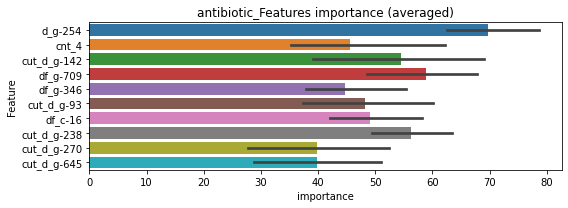

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017707	valid_1's binary_logloss: 0.0414303
[200]	training's binary_logloss: 0.00279119	valid_1's binary_logloss: 0.0252892
[300]	training's binary_logloss: 0.000814681	valid_1's binary_logloss: 0.021537
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.000642096	valid_1's binary_logloss: 0.0210974


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019062	valid_1's binary_logloss: 0.0408926
[200]	training's binary_logloss: 0.00298587	valid_1's binary_logloss: 0.0191815
[300]	training's binary_logloss: 0.000861589	valid_1's binary_logloss: 0.014446
[400]	training's binary_logloss: 0.000420154	valid_1's binary_logloss: 0.0127848
[500]	training's binary_logloss: 0.000280721	valid_1's binary_logloss: 0.0119791
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000262989	valid_1's binary_logloss: 0.0118695


antibiotic logloss: 0.01648401231166527


neg labels: 3289 → selected neg labels: 3286


anticonvulsant, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227992	valid_1's binary_logloss: 0.0283172
[200]	training's binary_logloss: 0.00266967	valid_1's binary_logloss: 0.00561364
[300]	training's binary_logloss: 0.000756279	valid_1's binary_logloss: 0.0027079
[400]	training's binary_logloss: 0.000397771	valid_1's binary_logloss: 0.00191604
[500]	training's binary_logloss: 0.000314138	valid_1's binary_logloss: 0.00172901
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000311855	valid_1's binary_logloss: 0.00172619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231578	valid_1's binary_logloss: 0.0311367
[200]	training's binary_logloss: 0.00266062	valid_1's binary_logloss: 0.00565374
[300]	training's binary_logloss: 0.000750483	valid_1's binary_logloss: 0.00273599
[400]	training's binary_logloss: 0.000396328	valid_1's binary_logloss: 0.00205686
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0012224, Threshold: 0.0021801, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00196, conf_1:0.00240
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0021801
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.0121801
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.0221801
threshold: 0.0221801, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225892	valid_1's binary_logloss: 0.0280683
[200]	training's binary_logloss: 0.00258806	valid_1's binary_logloss: 0.00591663
[300]	training's binary_logloss: 0.000742864	valid_1's binary_logloss: 0.00304532
[400]	training's binary_logloss: 0.00039385	valid_1's binary_logloss: 0.00217183
[500]	training's binary_logloss: 0.000317897	valid_1's binary_logloss: 0.00197082
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000315882	valid_1's binary_logloss: 0.00196361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229045	valid_1's binary_logloss: 0.0307711
[200]	training's binary_logloss: 0.00262657	valid_1's binary_logloss: 0.00563306
[300]	training's binary_logloss: 0.000741724	valid_1's binary_logloss: 0.00279671
[400]	training's binary_logloss: 0.000394561	valid_1's binary_logloss: 0.00210462
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.0546863, Threshold: 0.0221801, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.01996, conf_1:0.02440
threshold: 0.0221801, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225892	valid_1's binary_logloss: 0.0280683
[200]	training's binary_logloss: 0.00258806	valid_1's binary_logloss: 0.00591663
[300]	training's binary_logloss: 0.000742864	valid_1's binary_logloss: 0.00304532
[400]	training's binary_logloss: 0.00039385	valid_1's binary_logloss: 0.00217183
[500]	training's binary_logloss: 0.000317897	valid_1's binary_logloss: 0.00197082
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000315882	valid_1's binary_logloss: 0.00196361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229045	valid_1's binary_logloss: 0.0307711
[200]	training's binary_logloss: 0.00262657	valid_1's binary_logloss: 0.00563306
[300]	training's binary_logloss: 0.000741724	valid_1's binary_logloss: 0.00279671
[400]	training's binary_logloss: 0.000394561	valid_1's binary_logloss: 0.00210462
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.0546863, Threshold: 0.0221801, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.01996, conf_1:0.02440
threshold: 0.0221801, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


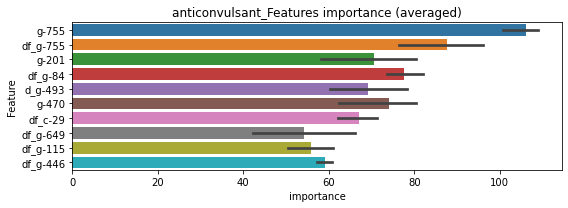

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125024	valid_1's binary_logloss: 0.0213341
[200]	training's binary_logloss: 0.0014321	valid_1's binary_logloss: 0.00906835
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000666846	valid_1's binary_logloss: 0.00811993


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130838	valid_1's binary_logloss: 0.017957
[200]	training's binary_logloss: 0.00153787	valid_1's binary_logloss: 0.00429621
[300]	training's binary_logloss: 0.00042036	valid_1's binary_logloss: 0.0026091
[400]	training's binary_logloss: 0.000212785	valid_1's binary_logloss: 0.00223829
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000169052	valid_1's binary_logloss: 0.00213951


anticonvulsant logloss: 0.005130103704052886


neg labels: 3289 → selected neg labels: 3284


antifungal, len(trt): 26, len(othr): 3284, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264083	valid_1's binary_logloss: 0.0404991
[200]	training's binary_logloss: 0.00352623	valid_1's binary_logloss: 0.0120838
[300]	training's binary_logloss: 0.000985987	valid_1's binary_logloss: 0.0070155
[400]	training's binary_logloss: 0.000508015	valid_1's binary_logloss: 0.00560657
[500]	training's binary_logloss: 0.000370652	valid_1's binary_logloss: 0.0051089
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000370897	valid_1's binary_logloss: 0.00510791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261588	valid_1's binary_logloss: 0.0381644
[200]	training's binary_logloss: 0.0034372	valid_1's binary_logloss: 0.0105231
[300]	training's binary_logloss: 0.000982165	valid_1's binary_logloss: 0.00650203
[400]	training's binary_logloss: 0.000508177	valid_1's binary_logloss: 0.00542881
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0016259, Threshold: 0.0023458, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00109
Num_p_label: 80.0, conf_0:0.00211, conf_1:0.00258
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0023458
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_2: 0.0123458
threshold: 0.0123458, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269415	valid_1's binary_logloss: 0.038448
[200]	training's binary_logloss: 0.00355929	valid_1's binary_logloss: 0.0102119
[300]	training's binary_logloss: 0.0010016	valid_1's binary_logloss: 0.00597766
[400]	training's binary_logloss: 0.000519152	valid_1's binary_logloss: 0.00480006
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.0003931	valid_1's binary_logloss: 0.00449298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266401	valid_1's binary_logloss: 0.0399286
[200]	training's binary_logloss: 0.00343555	valid_1's binary_logloss: 0.0109049
[300]	training's binary_logloss: 0.000986019	valid_1's binary_logloss: 0.0066583
[400]	training's binary_logloss: 0.000507139	valid_1's binary_logloss: 0.00547084
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00038325	valid_1's binary_logloss: 0.00509968


2 / 3 AUC score:1.000
y_Threshold: 0.0279644, Threshold: 0.0123458, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00109
Num_p_label: 10.0, conf_0:0.01111, conf_1:0.01358
threshold: 0.0123458, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269415	valid_1's binary_logloss: 0.038448
[200]	training's binary_logloss: 0.00355929	valid_1's binary_logloss: 0.0102119
[300]	training's binary_logloss: 0.0010016	valid_1's binary_logloss: 0.00597766
[400]	training's binary_logloss: 0.000519152	valid_1's binary_logloss: 0.00480006
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.0003931	valid_1's binary_logloss: 0.00449298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266401	valid_1's binary_logloss: 0.0399286
[200]	training's binary_logloss: 0.00343555	valid_1's binary_logloss: 0.0109049
[300]	training's binary_logloss: 0.000986019	valid_1's binary_logloss: 0.0066583
[400]	training's binary_logloss: 0.000507139	valid_1's binary_logloss: 0.00547084
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00038325	valid_1's binary_logloss: 0.00509968


3 / 3 AUC score:1.000
y_Threshold: 0.0279644, Threshold: 0.0123458, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00109
Num_p_label: 10.0, conf_0:0.01111, conf_1:0.01358
threshold: 0.0123458, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7790, y_label_rate: 0.0854942


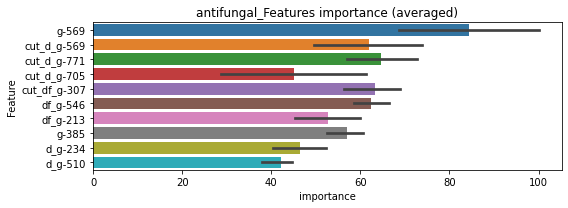

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148318	valid_1's binary_logloss: 0.0252843
[200]	training's binary_logloss: 0.00194089	valid_1's binary_logloss: 0.0110846
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.000860711	valid_1's binary_logloss: 0.00989689


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144596	valid_1's binary_logloss: 0.025915
[200]	training's binary_logloss: 0.00185081	valid_1's binary_logloss: 0.0112555
[300]	training's binary_logloss: 0.000532186	valid_1's binary_logloss: 0.00897568
[400]	training's binary_logloss: 0.000269925	valid_1's binary_logloss: 0.0084435
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000276126	valid_1's binary_logloss: 0.00842813


antifungal logloss: 0.009162508113905177


neg labels: 3289 → selected neg labels: 3286


antihistamine, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217738	valid_1's binary_logloss: 0.0300518
[200]	training's binary_logloss: 0.0024914	valid_1's binary_logloss: 0.00694055
[300]	training's binary_logloss: 0.000703394	valid_1's binary_logloss: 0.00401778
[400]	training's binary_logloss: 0.00037717	valid_1's binary_logloss: 0.00329169
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000316414	valid_1's binary_logloss: 0.0031178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022149	valid_1's binary_logloss: 0.0290604
[200]	training's binary_logloss: 0.0025992	valid_1's binary_logloss: 0.006309
[300]	training's binary_logloss: 0.000734125	valid_1's binary_logloss: 0.00320977
[400]	training's binary_logloss: 0.000386966	valid_1's binary_logloss: 0.00242168
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000319612	valid_1's binary_logloss: 0.00227919


1 / 3 AUC score:1.000
y_Threshold: 0.0014461, Threshold: 0.0023353, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00210, conf_1:0.00257
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0023353
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_2: 0.0123353
threshold: 0.0123353, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218378	valid_1's binary_logloss: 0.0286777
[200]	training's binary_logloss: 0.00244592	valid_1's binary_logloss: 0.00586799
[300]	training's binary_logloss: 0.000698267	valid_1's binary_logloss: 0.00305467
[400]	training's binary_logloss: 0.00037543	valid_1's binary_logloss: 0.00235741
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000321893	valid_1's binary_logloss: 0.00224726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225175	valid_1's binary_logloss: 0.0290928
[200]	training's binary_logloss: 0.00257477	valid_1's binary_logloss: 0.00584272
[300]	training's binary_logloss: 0.000717883	valid_1's binary_logloss: 0.00285667
[400]	training's binary_logloss: 0.000379172	valid_1's binary_logloss: 0.00207988
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000317012	valid_1's binary_logloss: 0.001962

2 / 3 AUC score:1.000
y_Threshold: 0.0436743, Threshold: 0.0123353, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0065294 Vs.target_rate: 0.00076
Num_p_label: 26.0, conf_0:0.01110, conf_1:0.01357
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_1: 0.0123353
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.0223353
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.0323353
threshold: 0.0323353, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218378	valid_1's binary_logloss: 0.0286777
[200]	training's binary_logloss: 0.00244592	valid_1's binary_logloss: 0.00586799
[300]	training's binary_logloss: 0.000698267	valid_1's binary_logloss: 0.00305467
[400]	training's binary_logloss: 0.00037543	valid_1's binary_logloss: 0.00235741
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000321893	valid_1's binary_logloss: 0.00224726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225175	valid_1's binary_logloss: 0.0290928
[200]	training's binary_logloss: 0.00257477	valid_1's binary_logloss: 0.00584272
[300]	training's binary_logloss: 0.000717883	valid_1's binary_logloss: 0.00285667
[400]	training's binary_logloss: 0.000379172	valid_1's binary_logloss: 0.00207988
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000317012	valid_1's binary_logloss: 0.001962

3 / 3 AUC score:1.000
y_Threshold: 0.0436743, Threshold: 0.0323353, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0007534 Vs.target_rate: 0.00076
Num_p_label: 3.0, conf_0:0.02910, conf_1:0.03557
threshold: 0.0323353, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7793, y_label_rate: 0.0846914


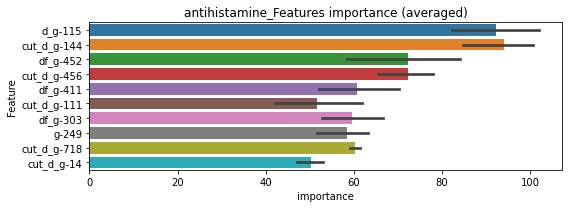

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117179	valid_1's binary_logloss: 0.0182438
[200]	training's binary_logloss: 0.00131098	valid_1's binary_logloss: 0.0058548
[300]	training's binary_logloss: 0.000362814	valid_1's binary_logloss: 0.00447141
[400]	training's binary_logloss: 0.000189862	valid_1's binary_logloss: 0.004209
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000172279	valid_1's binary_logloss: 0.00418494


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115743	valid_1's binary_logloss: 0.0176422
[200]	training's binary_logloss: 0.00129838	valid_1's binary_logloss: 0.00466643
[300]	training's binary_logloss: 0.000363137	valid_1's binary_logloss: 0.0032178
[400]	training's binary_logloss: 0.000193861	valid_1's binary_logloss: 0.00292836
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000169654	valid_1's binary_logloss: 0.00288538


antihistamine logloss: 0.00353524631328284


neg labels: 3289 → selected neg labels: 3286


antimalarial, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214126	valid_1's binary_logloss: 0.0309783
[200]	training's binary_logloss: 0.00243878	valid_1's binary_logloss: 0.00816241
[300]	training's binary_logloss: 0.000715728	valid_1's binary_logloss: 0.00507562
[400]	training's binary_logloss: 0.000390949	valid_1's binary_logloss: 0.00443577
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000355069	valid_1's binary_logloss: 0.00438637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223529	valid_1's binary_logloss: 0.0270943
[200]	training's binary_logloss: 0.00263284	valid_1's binary_logloss: 0.00413392
[300]	training's binary_logloss: 0.000752482	valid_1's binary_logloss: 0.00145833
[400]	training's binary_logloss: 0.000403116	valid_1's binary_logloss: 0.000877752
[500]	training's binary_logloss: 0.000323398	valid_1's binary_logloss: 0.00075174
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0015217, Threshold: 0.0023889, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00215, conf_1:0.00263
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0023889
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0123889
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.0223889
threshold: 0.0223889, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212226	valid_1's binary_logloss: 0.0314693
[200]	training's binary_logloss: 0.00239275	valid_1's binary_logloss: 0.00877709
[300]	training's binary_logloss: 0.000706627	valid_1's binary_logloss: 0.00565913
[400]	training's binary_logloss: 0.000383025	valid_1's binary_logloss: 0.00490786
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000328501	valid_1's binary_logloss: 0.00479974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225407	valid_1's binary_logloss: 0.0270855
[200]	training's binary_logloss: 0.00258156	valid_1's binary_logloss: 0.00385545
[300]	training's binary_logloss: 0.000749351	valid_1's binary_logloss: 0.00131869
[400]	training's binary_logloss: 0.000399317	valid_1's binary_logloss: 0.00078328
[500]	training's binary_logloss: 0.000325059	valid_1's binary_logloss: 0.000675111
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.0204158, Threshold: 0.0223889, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0030136 Vs.target_rate: 0.00076
Num_p_label: 12.0, conf_0:0.02015, conf_1:0.02463
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.0223889
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.0323889
threshold: 0.0323889, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212226	valid_1's binary_logloss: 0.0314693
[200]	training's binary_logloss: 0.00239275	valid_1's binary_logloss: 0.00877709
[300]	training's binary_logloss: 0.000706627	valid_1's binary_logloss: 0.00565913
[400]	training's binary_logloss: 0.000383025	valid_1's binary_logloss: 0.00490786
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000328501	valid_1's binary_logloss: 0.00479974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225407	valid_1's binary_logloss: 0.0270855
[200]	training's binary_logloss: 0.00258156	valid_1's binary_logloss: 0.00385545
[300]	training's binary_logloss: 0.000749351	valid_1's binary_logloss: 0.00131869
[400]	training's binary_logloss: 0.000399317	valid_1's binary_logloss: 0.00078328
[500]	training's binary_logloss: 0.000325059	valid_1's binary_logloss: 0.000675111
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.0204158, Threshold: 0.0323889, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.02915, conf_1:0.03563
threshold: 0.0323889, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


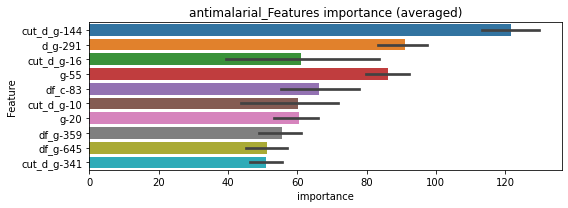

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011827	valid_1's binary_logloss: 0.0193376
[200]	training's binary_logloss: 0.00134317	valid_1's binary_logloss: 0.00697685
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.000837868	valid_1's binary_logloss: 0.00635426


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118865	valid_1's binary_logloss: 0.0163496
[200]	training's binary_logloss: 0.00140954	valid_1's binary_logloss: 0.00434868
[300]	training's binary_logloss: 0.000396911	valid_1's binary_logloss: 0.00288124
[400]	training's binary_logloss: 0.000208851	valid_1's binary_logloss: 0.00264949
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000184638	valid_1's binary_logloss: 0.002626


antimalarial logloss: 0.004490368991888735


neg labels: 3289 → selected neg labels: 3278


antioxidant, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447524	valid_1's binary_logloss: 0.0981881
[200]	training's binary_logloss: 0.00900944	valid_1's binary_logloss: 0.0578891
[300]	training's binary_logloss: 0.0027156	valid_1's binary_logloss: 0.0493038
[400]	training's binary_logloss: 0.00126559	valid_1's binary_logloss: 0.0461516
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00130165	valid_1's binary_logloss: 0.0459317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496026	valid_1's binary_logloss: 0.0878166
[200]	training's binary_logloss: 0.0107093	valid_1's binary_logloss: 0.0425873
[300]	training's binary_logloss: 0.0030492	valid_1's binary_logloss: 0.0293944
[400]	training's binary_logloss: 0.00130516	valid_1's binary_logloss: 0.0259307
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000916785	valid_1's binary_logloss: 0.0247201


1 / 3 AUC score:0.998
y_Threshold: 0.0087887, Threshold: 0.0111789, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3797
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.01006, conf_1:0.01230
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0111789
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_2: 0.0211789
threshold: 0.0211789, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 653.0/3797, y_label_rate: 0.1719779
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449521	valid_1's binary_logloss: 0.098003
[200]	training's binary_logloss: 0.00863761	valid_1's binary_logloss: 0.0571551
[300]	training's binary_logloss: 0.00255444	valid_1's binary_logloss: 0.0481586
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00181098	valid_1's binary_logloss: 0.0465608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463891	valid_1's binary_logloss: 0.0927341
[200]	training's binary_logloss: 0.00906896	valid_1's binary_logloss: 0.0454544
[300]	training's binary_logloss: 0.00270325	valid_1's binary_logloss: 0.0335079
[400]	training's binary_logloss: 0.00128644	valid_1's binary_logloss: 0.0296615
[500]	training's binary_logloss: 0.000804206	valid_1's binary_logloss: 0.0282367
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.000695377	valid_1's binary_logloss: 0.027951


2 / 3 AUC score:0.999
y_Threshold: 0.0397722, Threshold: 0.0211789, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 645.0/3781
p_label_rate: 0.0173280 Vs.target_rate: 0.00307
Num_p_label: 69.0, conf_0:0.01906, conf_1:0.02330
Num_p_label: 69.0, Expected: 12.2, Adj_threshold_1: 0.0211789
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_2: 0.0311789
Num_p_label: 23.0, Expected: 12.2, Adj_threshold_3: 0.0411789
threshold: 0.0411789, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 645.0/3781, y_label_rate: 0.1705898
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422872	valid_1's binary_logloss: 0.104236
[200]	training's binary_logloss: 0.00751072	valid_1's binary_logloss: 0.0635193
[300]	training's binary_logloss: 0.00221812	valid_1's binary_logloss: 0.0543178
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00172155	valid_1's binary_logloss: 0.0535669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472468	valid_1's binary_logloss: 0.0922905
[200]	training's binary_logloss: 0.00901719	valid_1's binary_logloss: 0.0481652
[300]	training's binary_logloss: 0.00270325	valid_1's binary_logloss: 0.0394657
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00170773	valid_1's binary_logloss: 0.0373257


3 / 3 AUC score:0.999
y_Threshold: 0.0303371, Threshold: 0.0411789, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 634.0/3759
p_label_rate: 0.0087896 Vs.target_rate: 0.00307
Num_p_label: 35.0, conf_0:0.03706, conf_1:0.04530
threshold: 0.0411789, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 669.0/7741, y_label_rate: 0.0864229


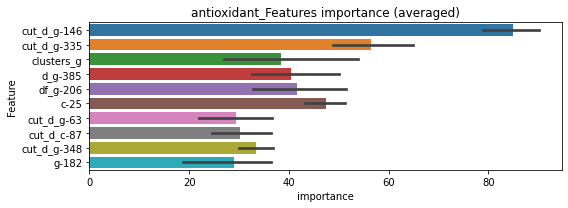

len(train_index) : 3870
len(valid_index) : 3871
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273056	valid_1's binary_logloss: 0.0603317
[200]	training's binary_logloss: 0.00544312	valid_1's binary_logloss: 0.0376342
[300]	training's binary_logloss: 0.0015433	valid_1's binary_logloss: 0.0341651
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00170454	valid_1's binary_logloss: 0.0340614


len(train_index) : 3871
len(valid_index) : 3870
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267939	valid_1's binary_logloss: 0.0592197
[200]	training's binary_logloss: 0.00544834	valid_1's binary_logloss: 0.0369496
[300]	training's binary_logloss: 0.00162047	valid_1's binary_logloss: 0.0327956
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00108997	valid_1's binary_logloss: 0.0319653


antioxidant logloss: 0.03301350232751672


neg labels: 3289 → selected neg labels: 3283


antiprotozoal, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031246	valid_1's binary_logloss: 0.0525046
[200]	training's binary_logloss: 0.00457336	valid_1's binary_logloss: 0.0202152
[300]	training's binary_logloss: 0.00128313	valid_1's binary_logloss: 0.0143744
[400]	training's binary_logloss: 0.000646885	valid_1's binary_logloss: 0.0126897
[500]	training's binary_logloss: 0.000444456	valid_1's binary_logloss: 0.0119543
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000445184	valid_1's binary_logloss: 0.0119489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315735	valid_1's binary_logloss: 0.0495052
[200]	training's binary_logloss: 0.00483532	valid_1's binary_logloss: 0.0186098
[300]	training's binary_logloss: 0.00140156	valid_1's binary_logloss: 0.013301
[400]	training's binary_logloss: 0.000693071	valid_1's binary_logloss: 0.0118991
Early stopping, best iteration is:
[455]	tr

1 / 3 AUC score:1.000
y_Threshold: 0.0025738, Threshold: 0.0043760, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00394, conf_1:0.00481
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0043760
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_2: 0.0143760
threshold: 0.0143760, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312761	valid_1's binary_logloss: 0.0494234
[200]	training's binary_logloss: 0.00455241	valid_1's binary_logloss: 0.0182487
[300]	training's binary_logloss: 0.00130635	valid_1's binary_logloss: 0.0132771
[400]	training's binary_logloss: 0.000666977	valid_1's binary_logloss: 0.0118048
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000500922	valid_1's binary_logloss: 0.0112806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306772	valid_1's binary_logloss: 0.0520198
[200]	training's binary_logloss: 0.00449559	valid_1's binary_logloss: 0.0211549
[300]	training's binary_logloss: 0.00130081	valid_1's binary_logloss: 0.0161865
[400]	training's binary_logloss: 0.000651807	valid_1's binary_logloss: 0.0145191
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000688017	valid_1's binary_logloss: 0.0144818


2 / 3 AUC score:1.000
y_Threshold: 0.0126395, Threshold: 0.0143760, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0087896 Vs.target_rate: 0.00151
Num_p_label: 35.0, conf_0:0.01294, conf_1:0.01581
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_1: 0.0143760
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_2: 0.0243760
threshold: 0.0243760, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 653.0/3801, y_label_rate: 0.1717969
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030976	valid_1's binary_logloss: 0.0492626
[200]	training's binary_logloss: 0.00433065	valid_1's binary_logloss: 0.0156928
[300]	training's binary_logloss: 0.00124285	valid_1's binary_logloss: 0.0101624
[400]	training's binary_logloss: 0.000635893	valid_1's binary_logloss: 0.00896509
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000504184	valid_1's binary_logloss: 0.0085418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316607	valid_1's binary_logloss: 0.0489279
[200]	training's binary_logloss: 0.00469303	valid_1's binary_logloss: 0.0169076
[300]	training's binary_logloss: 0.00135921	valid_1's binary_logloss: 0.0114774
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00109696	valid_1's binary_logloss: 0.0107883


3 / 3 AUC score:1.000
y_Threshold: 0.0205810, Threshold: 0.0243760, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 651.0/3797
p_label_rate: 0.0040181 Vs.target_rate: 0.00151
Num_p_label: 16.0, conf_0:0.02194, conf_1:0.02681
threshold: 0.0243760, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 667.0/7779, y_label_rate: 0.0857437


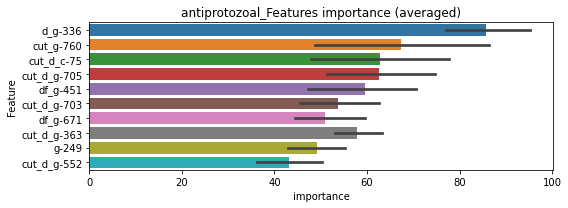

len(train_index) : 3889
len(valid_index) : 3890
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016796	valid_1's binary_logloss: 0.0358401
[200]	training's binary_logloss: 0.00245411	valid_1's binary_logloss: 0.021275
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00129291	valid_1's binary_logloss: 0.0203668


len(train_index) : 3890
len(valid_index) : 3889
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190743	valid_1's binary_logloss: 0.0304828
[200]	training's binary_logloss: 0.00291244	valid_1's binary_logloss: 0.0117251
[300]	training's binary_logloss: 0.00082111	valid_1's binary_logloss: 0.0088196
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000449875	valid_1's binary_logloss: 0.00839317


antiprotozoal logloss: 0.014380733327446963


neg labels: 3289 → selected neg labels: 3286


antiviral, len(trt): 23, len(othr): 3286, target_rate: 0.0009658 → Adj_target_rate: 0.0012069
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255433	valid_1's binary_logloss: 0.0403136
[200]	training's binary_logloss: 0.00323358	valid_1's binary_logloss: 0.00909314
[300]	training's binary_logloss: 0.000899041	valid_1's binary_logloss: 0.00405365
[400]	training's binary_logloss: 0.000457196	valid_1's binary_logloss: 0.00273394
[500]	training's binary_logloss: 0.00034478	valid_1's binary_logloss: 0.00237089
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000340211	valid_1's binary_logloss: 0.00235547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260802	valid_1's binary_logloss: 0.0354248
[200]	training's binary_logloss: 0.00328782	valid_1's binary_logloss: 0.00631769
[300]	training's binary_logloss: 0.000928585	valid_1's binary_logloss: 0.00236417
[400]	training's binary_logloss: 0.000471919	valid_1's binary_logloss: 0.00140373
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0020529, Threshold: 0.0028511, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00097
Num_p_label: 80.0, conf_0:0.00257, conf_1:0.00314
Num_p_label: 80.0, Expected: 3.8, Adj_threshold_1: 0.0028511
Num_p_label: 5.0, Expected: 3.8, Adj_threshold_2: 0.0128511
threshold: 0.0128511, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261652	valid_1's binary_logloss: 0.0402621
[200]	training's binary_logloss: 0.00323228	valid_1's binary_logloss: 0.00818031
[300]	training's binary_logloss: 0.000904377	valid_1's binary_logloss: 0.00319953
[400]	training's binary_logloss: 0.000465929	valid_1's binary_logloss: 0.00194083
[500]	training's binary_logloss: 0.000349175	valid_1's binary_logloss: 0.00165831
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000336818	valid_1's binary_logloss: 0.00162759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263113	valid_1's binary_logloss: 0.0347884
[200]	training's binary_logloss: 0.00330336	valid_1's binary_logloss: 0.00583324
[300]	training's binary_logloss: 0.000934332	valid_1's binary_logloss: 0.00205749
[400]	training's binary_logloss: 0.000476322	valid_1's binary_logloss: 0.00119814
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1453185, Threshold: 0.0128511, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0057760 Vs.target_rate: 0.00097
Num_p_label: 23.0, conf_0:0.01157, conf_1:0.01414
Num_p_label: 23.0, Expected: 3.8, Adj_threshold_1: 0.0128511
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_2: 0.0228511
Num_p_label: 7.0, Expected: 3.8, Adj_threshold_3: 0.0328511
threshold: 0.0328511, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261652	valid_1's binary_logloss: 0.0402621
[200]	training's binary_logloss: 0.00323228	valid_1's binary_logloss: 0.00818031
[300]	training's binary_logloss: 0.000904377	valid_1's binary_logloss: 0.00319953
[400]	training's binary_logloss: 0.000465929	valid_1's binary_logloss: 0.00194083
[500]	training's binary_logloss: 0.000349175	valid_1's binary_logloss: 0.00165831
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000336818	valid_1's binary_logloss: 0.00162759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263113	valid_1's binary_logloss: 0.0347884
[200]	training's binary_logloss: 0.00330336	valid_1's binary_logloss: 0.00583324
[300]	training's binary_logloss: 0.000934332	valid_1's binary_logloss: 0.00205749
[400]	training's binary_logloss: 0.000476322	valid_1's binary_logloss: 0.00119814
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1453185, Threshold: 0.0328511, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0017579 Vs.target_rate: 0.00097
Num_p_label: 7.0, conf_0:0.02957, conf_1:0.03614
threshold: 0.0328511, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7793, y_label_rate: 0.0852047


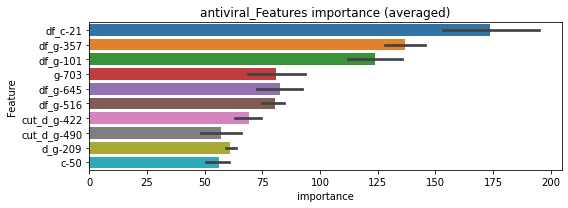

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136361	valid_1's binary_logloss: 0.0224138
[200]	training's binary_logloss: 0.00167464	valid_1's binary_logloss: 0.00807623
[300]	training's binary_logloss: 0.000463675	valid_1's binary_logloss: 0.00637217
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000484775	valid_1's binary_logloss: 0.00635907


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141397	valid_1's binary_logloss: 0.0246599
[200]	training's binary_logloss: 0.00179294	valid_1's binary_logloss: 0.00844535
[300]	training's binary_logloss: 0.000501454	valid_1's binary_logloss: 0.00568329
[400]	training's binary_logloss: 0.000250196	valid_1's binary_logloss: 0.00486469
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000190791	valid_1's binary_logloss: 0.00460152


antiviral logloss: 0.005480408081242334


neg labels: 3289 → selected neg labels: 3281


apoptosis_stimulant, len(trt): 49, len(othr): 3281, target_rate: 0.0020576 → Adj_target_rate: 0.0022954
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034064	valid_1's binary_logloss: 0.0695908
[200]	training's binary_logloss: 0.00549071	valid_1's binary_logloss: 0.0347513
[300]	training's binary_logloss: 0.00164688	valid_1's binary_logloss: 0.028338
[400]	training's binary_logloss: 0.000827786	valid_1's binary_logloss: 0.0256388
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000863373	valid_1's binary_logloss: 0.0255407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378024	valid_1's binary_logloss: 0.0573351
[200]	training's binary_logloss: 0.00631583	valid_1's binary_logloss: 0.0174566
[300]	training's binary_logloss: 0.00188943	valid_1's binary_logloss: 0.00954988
[400]	training's binary_logloss: 0.000925647	valid_1's binary_logloss: 0.00711576
[500]	training's binary_logloss: 0.000603947	valid_1's binary_logloss: 0.00616267
Early stopping, best iteration is:
[564]

1 / 3 AUC score:1.000
y_Threshold: 0.0034284, Threshold: 0.0395588, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00206
Num_p_label: 80.0, conf_0:0.03560, conf_1:0.04351
Num_p_label: 80.0, Expected: 8.2, Adj_threshold_1: 0.0395588
Num_p_label: 71.0, Expected: 8.2, Adj_threshold_2: 0.0495588
Num_p_label: 65.0, Expected: 8.2, Adj_threshold_3: 0.0595588
Num_p_label: 61.0, Expected: 8.2, Adj_threshold_4: 0.0695588
Num_p_label: 57.0, Expected: 8.2, Adj_threshold_5: 0.0795588
Num_p_label: 53.0, Expected: 8.2, Adj_threshold_6: 0.0895588
Num_p_label: 48.0, Expected: 8.2, Adj_threshold_7: 0.0995588
Num_p_label: 45.0, Expected: 8.2, Adj_threshold_8: 0.1095588
Num_p_label: 44.0, Expected: 8.2, Adj_threshold_9: 0.1195588
Num_p_label: 41.0, Expected: 8.2, Adj_threshold_10: 0.1295588
threshold: 0.1395588, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034642	valid_1's binary_logloss: 0.0697517
[200]	training's binary_logloss: 0.00540582	valid_1's binary_logloss: 0.032766
[300]	training's binary_logloss: 0.00161289	valid_1's binary_logloss: 0.025746
[400]	training's binary_logloss: 0.000812597	valid_1's binary_logloss: 0.0228005
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00077488	valid_1's binary_logloss: 0.0226592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366337	valid_1's binary_logloss: 0.0548634
[200]	training's binary_logloss: 0.0061279	valid_1's binary_logloss: 0.0168272
[300]	training's binary_logloss: 0.00184236	valid_1's binary_logloss: 0.00884377
[400]	training's binary_logloss: 0.000904499	valid_1's binary_logloss: 0.00643683
[500]	training's binary_logloss: 0.000592045	valid_1's binary_logloss: 0.00549097
Early stopping, best iteration is:
[557]	tr

2 / 3 AUC score:1.000
y_Threshold: 0.0493557, Threshold: 0.1395588, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3799
p_label_rate: 0.0248619 Vs.target_rate: 0.00206
Num_p_label: 99.0, conf_0:0.12560, conf_1:0.15351
Num_p_label: 99.0, Expected: 8.2, Adj_threshold_1: 0.1395588
Num_p_label: 96.0, Expected: 8.2, Adj_threshold_2: 0.1495588
Num_p_label: 92.0, Expected: 8.2, Adj_threshold_3: 0.1595588
Num_p_label: 92.0, Expected: 8.2, Adj_threshold_4: 0.1695588
Num_p_label: 88.0, Expected: 8.2, Adj_threshold_5: 0.1795588
Num_p_label: 88.0, Expected: 8.2, Adj_threshold_6: 0.1895588
Num_p_label: 87.0, Expected: 8.2, Adj_threshold_7: 0.1995588
Num_p_label: 86.0, Expected: 8.2, Adj_threshold_8: 0.2095588
Num_p_label: 84.0, Expected: 8.2, Adj_threshold_9: 0.2195588
Num_p_label: 81.0, Expected: 8.2, Adj_threshold_10: 0.2295588
threshold: 0.2395588, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 653.0/3799, y_label_rate: 0.1718873
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343953	valid_1's binary_logloss: 0.0677471
[200]	training's binary_logloss: 0.00551915	valid_1's binary_logloss: 0.0317601
[300]	training's binary_logloss: 0.00165762	valid_1's binary_logloss: 0.0238554
[400]	training's binary_logloss: 0.000820183	valid_1's binary_logloss: 0.0214985
[500]	training's binary_logloss: 0.000543571	valid_1's binary_logloss: 0.0202367
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000492655	valid_1's binary_logloss: 0.0200837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360889	valid_1's binary_logloss: 0.0601729
[200]	training's binary_logloss: 0.00601363	valid_1's binary_logloss: 0.0202398
[300]	training's binary_logloss: 0.0017624	valid_1's binary_logloss: 0.0113425
[400]	training's binary_logloss: 0.000864424	valid_1's binary_logloss: 0.00864715
[500]	training's binary_logloss: 0.000572

3 / 3 AUC score:1.000
y_Threshold: 0.0468806, Threshold: 0.2395588, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3797
p_label_rate: 0.0218483 Vs.target_rate: 0.00206
Num_p_label: 87.0, conf_0:0.21560, conf_1:0.26351
Num_p_label: 87.0, Expected: 8.2, Adj_threshold_1: 0.2395588
Num_p_label: 87.0, Expected: 8.2, Adj_threshold_2: 0.2495588
Num_p_label: 87.0, Expected: 8.2, Adj_threshold_3: 0.2595588
Num_p_label: 86.0, Expected: 8.2, Adj_threshold_4: 0.2695588
Num_p_label: 85.0, Expected: 8.2, Adj_threshold_5: 0.2795588
Num_p_label: 85.0, Expected: 8.2, Adj_threshold_6: 0.2895588
Num_p_label: 84.0, Expected: 8.2, Adj_threshold_7: 0.2995588
Num_p_label: 83.0, Expected: 8.2, Adj_threshold_8: 0.3095588
Num_p_label: 81.0, Expected: 8.2, Adj_threshold_9: 0.3195588
Num_p_label: 81.0, Expected: 8.2, Adj_threshold_10: 0.3295588
threshold: 0.3395588, positive_p_label: 79.0/3982, p_label_rate: 0.0198393
positive_y_label: 731.0/7779, y_label_rate: 0.0939709


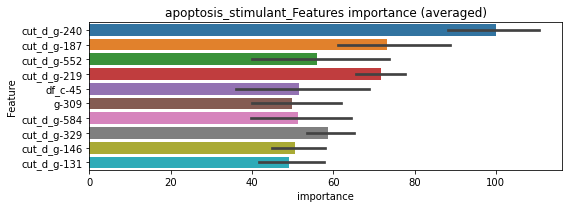

len(train_index) : 3889
len(valid_index) : 3890
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215308	valid_1's binary_logloss: 0.0374851
[200]	training's binary_logloss: 0.00362063	valid_1's binary_logloss: 0.0153573
[300]	training's binary_logloss: 0.00106181	valid_1's binary_logloss: 0.0109196
[400]	training's binary_logloss: 0.000522094	valid_1's binary_logloss: 0.00988519
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00036707	valid_1's binary_logloss: 0.00946831


len(train_index) : 3890
len(valid_index) : 3889
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200378	valid_1's binary_logloss: 0.0426811
[200]	training's binary_logloss: 0.00329697	valid_1's binary_logloss: 0.0215974
[300]	training's binary_logloss: 0.000978539	valid_1's binary_logloss: 0.0168391
[400]	training's binary_logloss: 0.000476687	valid_1's binary_logloss: 0.0153706
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.000492626	valid_1's binary_logloss: 0.0153313


apoptosis_stimulant logloss: 0.012399422063584463


neg labels: 3289 → selected neg labels: 3281


aromatase_inhibitor, len(trt): 47, len(othr): 3281, target_rate: 0.0019736 → Adj_target_rate: 0.0022155
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359659	valid_1's binary_logloss: 0.0615401
[200]	training's binary_logloss: 0.00610707	valid_1's binary_logloss: 0.0246726
[300]	training's binary_logloss: 0.00177516	valid_1's binary_logloss: 0.0174725
[400]	training's binary_logloss: 0.00086343	valid_1's binary_logloss: 0.0150572
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000628678	valid_1's binary_logloss: 0.0139664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382007	valid_1's binary_logloss: 0.0640062
[200]	training's binary_logloss: 0.00645499	valid_1's binary_logloss: 0.0252895
[300]	training's binary_logloss: 0.00188623	valid_1's binary_logloss: 0.0171251
[400]	training's binary_logloss: 0.000911386	valid_1's binary_logloss: 0.0147267
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000841392	valid_1's binary_logloss: 0.0144855


1 / 3 AUC score:1.000
y_Threshold: 0.0044379, Threshold: 0.0061575, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00197
Num_p_label: 80.0, conf_0:0.00554, conf_1:0.00677
Num_p_label: 80.0, Expected: 7.9, Adj_threshold_1: 0.0061575
Num_p_label: 11.0, Expected: 7.9, Adj_threshold_2: 0.0161575
threshold: 0.0161575, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357921	valid_1's binary_logloss: 0.0615818
[200]	training's binary_logloss: 0.00590811	valid_1's binary_logloss: 0.0231866
[300]	training's binary_logloss: 0.00173036	valid_1's binary_logloss: 0.0158558
[400]	training's binary_logloss: 0.000851285	valid_1's binary_logloss: 0.013144
[500]	training's binary_logloss: 0.000557819	valid_1's binary_logloss: 0.0121489
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000515394	valid_1's binary_logloss: 0.0118987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373408	valid_1's binary_logloss: 0.0623702
[200]	training's binary_logloss: 0.00642035	valid_1's binary_logloss: 0.024724
[300]	training's binary_logloss: 0.0018727	valid_1's binary_logloss: 0.0161559
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00104572	valid_1's binary_logloss: 0.0138088


2 / 3 AUC score:1.000
y_Threshold: 0.0186691, Threshold: 0.0161575, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0065294 Vs.target_rate: 0.00197
Num_p_label: 26.0, conf_0:0.01454, conf_1:0.01777
Num_p_label: 26.0, Expected: 7.9, Adj_threshold_1: 0.0161575
Num_p_label: 12.0, Expected: 7.9, Adj_threshold_2: 0.0261575
threshold: 0.0261575, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359112	valid_1's binary_logloss: 0.0700402
[200]	training's binary_logloss: 0.00585399	valid_1's binary_logloss: 0.030091
[300]	training's binary_logloss: 0.00172458	valid_1's binary_logloss: 0.0215889
[400]	training's binary_logloss: 0.00085042	valid_1's binary_logloss: 0.0188967
[500]	training's binary_logloss: 0.000550175	valid_1's binary_logloss: 0.0170415
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000523461	valid_1's binary_logloss: 0.0169698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369667	valid_1's binary_logloss: 0.0629372
[200]	training's binary_logloss: 0.00610736	valid_1's binary_logloss: 0.023357
[300]	training's binary_logloss: 0.00176692	valid_1's binary_logloss: 0.0152051
[400]	training's binary_logloss: 0.000865777	valid_1's binary_logloss: 0.0125996
Early stopping, best iteration is:
[420]	tra

3 / 3 AUC score:1.000
y_Threshold: 0.0252309, Threshold: 0.0261575, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0032647 Vs.target_rate: 0.00197
Num_p_label: 13.0, conf_0:0.02354, conf_1:0.02877
threshold: 0.0261575, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 667.0/7783, y_label_rate: 0.0856996


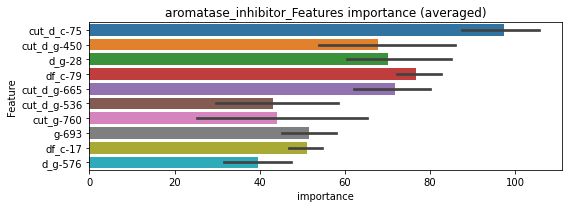

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190914	valid_1's binary_logloss: 0.045174
[200]	training's binary_logloss: 0.00309194	valid_1's binary_logloss: 0.029667
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00186736	valid_1's binary_logloss: 0.0287864


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212239	valid_1's binary_logloss: 0.0409658
[200]	training's binary_logloss: 0.00360957	valid_1's binary_logloss: 0.0183685
[300]	training's binary_logloss: 0.00106131	valid_1's binary_logloss: 0.013746
[400]	training's binary_logloss: 0.000497193	valid_1's binary_logloss: 0.0118417
[500]	training's binary_logloss: 0.000315162	valid_1's binary_logloss: 0.0111386
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000315162	valid_1's binary_logloss: 0.0111386


aromatase_inhibitor logloss: 0.019963671377831133


neg labels: 3289 → selected neg labels: 3288


atm_kinase_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151989	valid_1's binary_logloss: 0.0158661
[200]	training's binary_logloss: 0.00119607	valid_1's binary_logloss: 0.00143106
[300]	training's binary_logloss: 0.000322867	valid_1's binary_logloss: 0.000484107
[400]	training's binary_logloss: 0.000204672	valid_1's binary_logloss: 0.000326545
[500]	training's binary_logloss: 0.000179461	valid_1's binary_logloss: 0.000285499
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000174861	valid_1's binary_logloss: 0.000277948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015411	valid_1's binary_logloss: 0.0179026
[200]	training's binary_logloss: 0.00120268	valid_1's binary_logloss: 0.00366775
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.000610745	valid_1's binary_logloss: 0.00291369


1 / 3 AUC score:1.000
y_Threshold: 0.0012148, Threshold: 0.0025938, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00233, conf_1:0.00285
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0025938
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_2: 0.0125938
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.0225938
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.0325938
threshold: 0.0325938, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156958	valid_1's binary_logloss: 0.0162789
[200]	training's binary_logloss: 0.0012167	valid_1's binary_logloss: 0.00139527
[300]	training's binary_logloss: 0.00031097	valid_1's binary_logloss: 0.000408801
[400]	training's binary_logloss: 0.000198801	valid_1's binary_logloss: 0.000279249
[500]	training's binary_logloss: 0.000176237	valid_1's binary_logloss: 0.000251344
[600]	training's binary_logloss: 0.000170209	valid_1's binary_logloss: 0.000243683
Early stopping, best iteration is:
[658]	training's binary_logloss: 0.000168295	valid_1's binary_logloss: 0.000241215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159132	valid_1's binary_logloss: 0.0169267
[200]	training's binary_logloss: 0.0012345	valid_1's binary_logloss: 0.002094
[300]	training's binary_logloss: 0.000317318	valid_1's binary_logloss: 0.00113822
[400]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.0599231, Threshold: 0.0325938, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0030136 Vs.target_rate: 0.00025
Num_p_label: 12.0, conf_0:0.02933, conf_1:0.03585
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_1: 0.0325938
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_2: 0.0425938
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.0525938
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_4: 0.0625938
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.0725938
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.0825938
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.0925938
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.1025938
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.1125938
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_10: 0.1225938
threshold: 0.1225938, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= P

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156958	valid_1's binary_logloss: 0.0162789
[200]	training's binary_logloss: 0.0012167	valid_1's binary_logloss: 0.00139527
[300]	training's binary_logloss: 0.00031097	valid_1's binary_logloss: 0.000408801
[400]	training's binary_logloss: 0.000198801	valid_1's binary_logloss: 0.000279249
[500]	training's binary_logloss: 0.000176237	valid_1's binary_logloss: 0.000251344
[600]	training's binary_logloss: 0.000170209	valid_1's binary_logloss: 0.000243683
Early stopping, best iteration is:
[658]	training's binary_logloss: 0.000168295	valid_1's binary_logloss: 0.000241215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159132	valid_1's binary_logloss: 0.0169267
[200]	training's binary_logloss: 0.0012345	valid_1's binary_logloss: 0.002094
[300]	training's binary_logloss: 0.000317318	valid_1's binary_logloss: 0.00113822
[400]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.0599231, Threshold: 0.1225938, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0002511 Vs.target_rate: 0.00025
Num_p_label: 1.0, conf_0:0.11033, conf_1:0.13485
threshold: 0.1225938, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7795, y_label_rate: 0.0844131


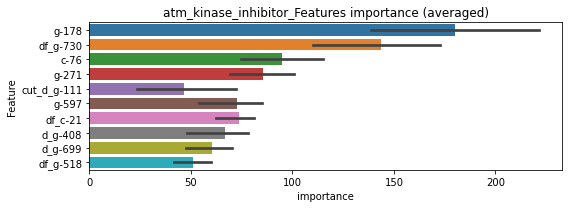

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00829666	valid_1's binary_logloss: 0.00926418
[200]	training's binary_logloss: 0.000629148	valid_1's binary_logloss: 0.00172477
[300]	training's binary_logloss: 0.000163649	valid_1's binary_logloss: 0.00130686
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000158842	valid_1's binary_logloss: 0.00130511


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00835878	valid_1's binary_logloss: 0.00868263
[200]	training's binary_logloss: 0.000651909	valid_1's binary_logloss: 0.000743608
[300]	training's binary_logloss: 0.00016991	valid_1's binary_logloss: 0.000205708
[400]	training's binary_logloss: 0.000105248	valid_1's binary_logloss: 0.000133313
[500]	training's binary_logloss: 9.19485e-05	valid_1's binary_logloss: 0.000117936
Early stopping, best iteration is:
[550]	training's binary_logloss: 8.94141e-05	valid_1's binary_logloss: 0.0001145


atm_kinase_inhibitor logloss: 0.0007098801031811896


neg labels: 3289 → selected neg labels: 3287


atp-sensitive_potassium_channel_antagonist, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160959	valid_1's binary_logloss: 0.0182676
[200]	training's binary_logloss: 0.00138134	valid_1's binary_logloss: 0.0027774
[300]	training's binary_logloss: 0.00037438	valid_1's binary_logloss: 0.00137808
[400]	training's binary_logloss: 0.000224032	valid_1's binary_logloss: 0.00105925
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000198628	valid_1's binary_logloss: 0.000998583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162038	valid_1's binary_logloss: 0.0187556
[200]	training's binary_logloss: 0.00138452	valid_1's binary_logloss: 0.00285712
[300]	training's binary_logloss: 0.000373576	valid_1's binary_logloss: 0.00160156
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000344916	valid_1's binary_logloss: 0.00156672


1 / 3 AUC score:1.000
y_Threshold: 0.0007817, Threshold: 0.0010381, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029
Num_p_label: 80.0, conf_0:0.00093, conf_1:0.00114
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0010381
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_2: 0.0110381
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_3: 0.0210381
threshold: 0.0210381, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162256	valid_1's binary_logloss: 0.0179026
[200]	training's binary_logloss: 0.00135527	valid_1's binary_logloss: 0.00223156
[300]	training's binary_logloss: 0.000363674	valid_1's binary_logloss: 0.000884565
[400]	training's binary_logloss: 0.000221944	valid_1's binary_logloss: 0.000654177
[500]	training's binary_logloss: 0.000194039	valid_1's binary_logloss: 0.000612756
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000194331	valid_1's binary_logloss: 0.000612596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164463	valid_1's binary_logloss: 0.0178507
[200]	training's binary_logloss: 0.00136801	valid_1's binary_logloss: 0.00185541
[300]	training's binary_logloss: 0.000366797	valid_1's binary_logloss: 0.00070123
[400]	training's binary_logloss: 0.000224421	valid_1's binary_logloss: 0.000536451
Early stopping, best itera

2 / 3 AUC score:1.000
y_Threshold: 0.1012551, Threshold: 0.0210381, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00029
Num_p_label: 6.0, conf_0:0.01893, conf_1:0.02314
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_1: 0.0210381
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_2: 0.0310381
threshold: 0.0310381, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162256	valid_1's binary_logloss: 0.0179026
[200]	training's binary_logloss: 0.00135527	valid_1's binary_logloss: 0.00223156
[300]	training's binary_logloss: 0.000363674	valid_1's binary_logloss: 0.000884565
[400]	training's binary_logloss: 0.000221944	valid_1's binary_logloss: 0.000654177
[500]	training's binary_logloss: 0.000194039	valid_1's binary_logloss: 0.000612756
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000194331	valid_1's binary_logloss: 0.000612596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164463	valid_1's binary_logloss: 0.0178507
[200]	training's binary_logloss: 0.00136801	valid_1's binary_logloss: 0.00185541
[300]	training's binary_logloss: 0.000366797	valid_1's binary_logloss: 0.00070123
[400]	training's binary_logloss: 0.000224421	valid_1's binary_logloss: 0.000536451
Early stopping, best itera

3 / 3 AUC score:1.000
y_Threshold: 0.1012551, Threshold: 0.0310381, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0002511 Vs.target_rate: 0.00029
Num_p_label: 1.0, conf_0:0.02793, conf_1:0.03414
threshold: 0.0310381, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7794, y_label_rate: 0.0844239


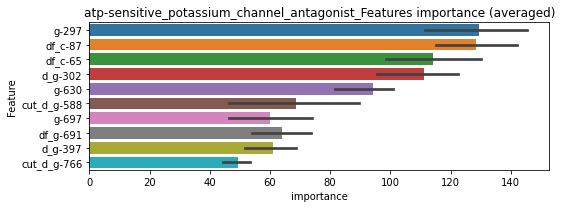

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00843807	valid_1's binary_logloss: 0.0115644
[200]	training's binary_logloss: 0.000678109	valid_1's binary_logloss: 0.00384187
[300]	training's binary_logloss: 0.000180056	valid_1's binary_logloss: 0.00327298
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.000151701	valid_1's binary_logloss: 0.00325255


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00870045	valid_1's binary_logloss: 0.00993649
[200]	training's binary_logloss: 0.000716988	valid_1's binary_logloss: 0.00154099
[300]	training's binary_logloss: 0.000190994	valid_1's binary_logloss: 0.000830484
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000128919	valid_1's binary_logloss: 0.000771668


atp-sensitive_potassium_channel_antagonist logloss: 0.0020121093698092624


neg labels: 3289 → selected neg labels: 3287


atp_synthase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152098	valid_1's binary_logloss: 0.0174145
[200]	training's binary_logloss: 0.00115151	valid_1's binary_logloss: 0.00308036
[300]	training's binary_logloss: 0.000284709	valid_1's binary_logloss: 0.00206741
[400]	training's binary_logloss: 0.000182189	valid_1's binary_logloss: 0.00191456
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000178629	valid_1's binary_logloss: 0.00190286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156922	valid_1's binary_logloss: 0.0164079
[200]	training's binary_logloss: 0.001245	valid_1's binary_logloss: 0.00189024
[300]	training's binary_logloss: 0.000315496	valid_1's binary_logloss: 0.000741703
[400]	training's binary_logloss: 0.000197252	valid_1's binary_logloss: 0.000544815
[500]	training's binary_logloss: 0.000175834	valid_1's binary_logloss: 0.000498045
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0005589, Threshold: 0.0016186, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00146, conf_1:0.00178
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0016186
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_2: 0.0116186
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_3: 0.0216186
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_4: 0.0316186
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_5: 0.0416186
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_6: 0.0516186
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_7: 0.0616186
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_8: 0.0716186
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_9: 0.0816186
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_10: 0.0916186
threshold: 0.1016186, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157984	valid_1's binary_logloss: 0.0162485
[200]	training's binary_logloss: 0.00117627	valid_1's binary_logloss: 0.00130859
[300]	training's binary_logloss: 0.000273662	valid_1's binary_logloss: 0.000352262
[400]	training's binary_logloss: 0.000173863	valid_1's binary_logloss: 0.000236044
[500]	training's binary_logloss: 0.000154953	valid_1's binary_logloss: 0.000213433
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000151412	valid_1's binary_logloss: 0.000209076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160346	valid_1's binary_logloss: 0.0164384
[200]	training's binary_logloss: 0.00118002	valid_1's binary_logloss: 0.00130578
[300]	training's binary_logloss: 0.000278505	valid_1's binary_logloss: 0.000339979
[400]	training's binary_logloss: 0.0001733	valid_1's binary_logloss: 0.000220456
[500]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.2230786, Threshold: 0.1016186, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0130588 Vs.target_rate: 0.00050
Num_p_label: 52.0, conf_0:0.09146, conf_1:0.11178
Num_p_label: 52.0, Expected: 2.0, Adj_threshold_1: 0.1016186
Num_p_label: 47.0, Expected: 2.0, Adj_threshold_2: 0.1116186
Num_p_label: 39.0, Expected: 2.0, Adj_threshold_3: 0.1216186
Num_p_label: 36.0, Expected: 2.0, Adj_threshold_4: 0.1316186
Num_p_label: 32.0, Expected: 2.0, Adj_threshold_5: 0.1416186
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_6: 0.1516186
Num_p_label: 24.0, Expected: 2.0, Adj_threshold_7: 0.1616186
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_8: 0.1716186
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_9: 0.1816186
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_10: 0.1916186
threshold: 0.2016186, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157984	valid_1's binary_logloss: 0.0162485
[200]	training's binary_logloss: 0.00117627	valid_1's binary_logloss: 0.00130859
[300]	training's binary_logloss: 0.000273662	valid_1's binary_logloss: 0.000352262
[400]	training's binary_logloss: 0.000173863	valid_1's binary_logloss: 0.000236044
[500]	training's binary_logloss: 0.000154953	valid_1's binary_logloss: 0.000213433
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000151412	valid_1's binary_logloss: 0.000209076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160346	valid_1's binary_logloss: 0.0164384
[200]	training's binary_logloss: 0.00118002	valid_1's binary_logloss: 0.00130578
[300]	training's binary_logloss: 0.000278505	valid_1's binary_logloss: 0.000339979
[400]	training's binary_logloss: 0.0001733	valid_1's binary_logloss: 0.000220456
[500]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.2230786, Threshold: 0.2016186, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0045203 Vs.target_rate: 0.00050
Num_p_label: 18.0, conf_0:0.18146, conf_1:0.22178
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_1: 0.2016186
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_2: 0.2116186
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_3: 0.2216186
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_4: 0.2316186
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_5: 0.2416186
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_6: 0.2516186
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_7: 0.2616186
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_8: 0.2716186
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_9: 0.2816186
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_10: 0.2916186
threshold: 0.3016186, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 668.0/7794, y_label_rate: 0.0857070


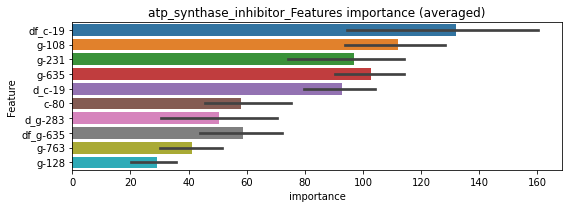

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00855234	valid_1's binary_logloss: 0.0118328
[200]	training's binary_logloss: 0.000648972	valid_1's binary_logloss: 0.00390072
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00030317	valid_1's binary_logloss: 0.00346393


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00893921	valid_1's binary_logloss: 0.00909281
[200]	training's binary_logloss: 0.000755131	valid_1's binary_logloss: 0.00124198
[300]	training's binary_logloss: 0.000190986	valid_1's binary_logloss: 0.000738779
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000135214	valid_1's binary_logloss: 0.000685432


atp_synthase_inhibitor logloss: 0.0020746819885555574


neg labels: 3289 → selected neg labels: 3273


atpase_inhibitor, len(trt): 97, len(othr): 3273, target_rate: 0.0040732 → Adj_target_rate: 0.0041016
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453821	valid_1's binary_logloss: 0.10618
[200]	training's binary_logloss: 0.00961014	valid_1's binary_logloss: 0.0641228
[300]	training's binary_logloss: 0.00300668	valid_1's binary_logloss: 0.0509103
[400]	training's binary_logloss: 0.00141279	valid_1's binary_logloss: 0.0472227
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.001421	valid_1's binary_logloss: 0.0472033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489298	valid_1's binary_logloss: 0.107873
[200]	training's binary_logloss: 0.0111247	valid_1's binary_logloss: 0.0703494
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00452589	valid_1's binary_logloss: 0.064449


1 / 3 AUC score:0.997
y_Threshold: 0.0173892, Threshold: 0.0659184, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 644/3775
p_label_rate: 0.0200904 Vs.target_rate: 0.00407
Num_p_label: 80.0, conf_0:0.05933, conf_1:0.07251
Num_p_label: 80.0, Expected: 16.2, Adj_threshold_1: 0.0659184
Num_p_label: 64.0, Expected: 16.2, Adj_threshold_2: 0.0759184
Num_p_label: 55.0, Expected: 16.2, Adj_threshold_3: 0.0859184
Num_p_label: 47.0, Expected: 16.2, Adj_threshold_4: 0.0959184
Num_p_label: 45.0, Expected: 16.2, Adj_threshold_5: 0.1059184
Num_p_label: 41.0, Expected: 16.2, Adj_threshold_6: 0.1159184
Num_p_label: 34.0, Expected: 16.2, Adj_threshold_7: 0.1259184
Num_p_label: 32.0, Expected: 16.2, Adj_threshold_8: 0.1359184
threshold: 0.1359184, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 644.0/3775, y_label_rate: 0.1705960
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434743	valid_1's binary_logloss: 0.0958702
[200]	training's binary_logloss: 0.00847363	valid_1's binary_logloss: 0.0597346
[300]	training's binary_logloss: 0.00260952	valid_1's binary_logloss: 0.0521221
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00140392	valid_1's binary_logloss: 0.0501599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436237	valid_1's binary_logloss: 0.0988339
[200]	training's binary_logloss: 0.00831573	valid_1's binary_logloss: 0.0582895
[300]	training's binary_logloss: 0.00259097	valid_1's binary_logloss: 0.0484185
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0017842	valid_1's binary_logloss: 0.0467327


2 / 3 AUC score:0.999
y_Threshold: 0.0613305, Threshold: 0.1359184, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 627.0/3741
p_label_rate: 0.0414365 Vs.target_rate: 0.00407
Num_p_label: 165.0, conf_0:0.12233, conf_1:0.14951
Num_p_label: 165.0, Expected: 16.2, Adj_threshold_1: 0.1359184
Num_p_label: 163.0, Expected: 16.2, Adj_threshold_2: 0.1459184
Num_p_label: 156.0, Expected: 16.2, Adj_threshold_3: 0.1559184
Num_p_label: 152.0, Expected: 16.2, Adj_threshold_4: 0.1659184
Num_p_label: 145.0, Expected: 16.2, Adj_threshold_5: 0.1759184
Num_p_label: 142.0, Expected: 16.2, Adj_threshold_6: 0.1859184
Num_p_label: 137.0, Expected: 16.2, Adj_threshold_7: 0.1959184
Num_p_label: 135.0, Expected: 16.2, Adj_threshold_8: 0.2059184
Num_p_label: 130.0, Expected: 16.2, Adj_threshold_9: 0.2159184
Num_p_label: 124.0, Expected: 16.2, Adj_threshold_10: 0.2259184
threshold: 0.2359184, positive_p_label: 123.0/3982, p_label_rate: 0.0308890
positive_y_label: 627.0/3741, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399992	valid_1's binary_logloss: 0.0774946
[200]	training's binary_logloss: 0.00752486	valid_1's binary_logloss: 0.0398214
[300]	training's binary_logloss: 0.00235963	valid_1's binary_logloss: 0.0315585
[400]	training's binary_logloss: 0.00118254	valid_1's binary_logloss: 0.0291125
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0011521	valid_1's binary_logloss: 0.029044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414443	valid_1's binary_logloss: 0.0947588
[200]	training's binary_logloss: 0.00794709	valid_1's binary_logloss: 0.0498684
[300]	training's binary_logloss: 0.00244888	valid_1's binary_logloss: 0.0379045
[400]	training's binary_logloss: 0.00117461	valid_1's binary_logloss: 0.0330821
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00103476	valid_1's binary_logloss: 0.0327417


3 / 3 AUC score:0.999
y_Threshold: 0.1152490, Threshold: 0.2359184, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 611.0/3709
p_label_rate: 0.0472125 Vs.target_rate: 0.00407
Num_p_label: 188.0, conf_0:0.21233, conf_1:0.25951
Num_p_label: 188.0, Expected: 16.2, Adj_threshold_1: 0.2359184
Num_p_label: 179.0, Expected: 16.2, Adj_threshold_2: 0.2459184
Num_p_label: 177.0, Expected: 16.2, Adj_threshold_3: 0.2559184
Num_p_label: 175.0, Expected: 16.2, Adj_threshold_4: 0.2659184
Num_p_label: 171.0, Expected: 16.2, Adj_threshold_5: 0.2759184
Num_p_label: 171.0, Expected: 16.2, Adj_threshold_6: 0.2859184
Num_p_label: 169.0, Expected: 16.2, Adj_threshold_7: 0.2959184
Num_p_label: 166.0, Expected: 16.2, Adj_threshold_8: 0.3059184
Num_p_label: 162.0, Expected: 16.2, Adj_threshold_9: 0.3159184
Num_p_label: 162.0, Expected: 16.2, Adj_threshold_10: 0.3259184
threshold: 0.3359184, positive_p_label: 162.0/3982, p_label_rate: 0.0406831
positive_y_label: 773.0/7691, y_label_ra

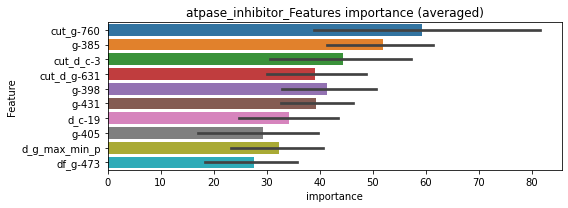

len(train_index) : 3845
len(valid_index) : 3846
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02528	valid_1's binary_logloss: 0.054009
[200]	training's binary_logloss: 0.00490178	valid_1's binary_logloss: 0.0339906
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00204357	valid_1's binary_logloss: 0.0308036


len(train_index) : 3846
len(valid_index) : 3845
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252409	valid_1's binary_logloss: 0.0597256
[200]	training's binary_logloss: 0.00471335	valid_1's binary_logloss: 0.0385415
[300]	training's binary_logloss: 0.001441	valid_1's binary_logloss: 0.0343893
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00139767	valid_1's binary_logloss: 0.0343178


atpase_inhibitor logloss: 0.032560431321884784


neg labels: 3289 → selected neg labels: 3286


atr_kinase_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192022	valid_1's binary_logloss: 0.0266024
[200]	training's binary_logloss: 0.00194277	valid_1's binary_logloss: 0.00584093
[300]	training's binary_logloss: 0.000541674	valid_1's binary_logloss: 0.00302685
[400]	training's binary_logloss: 0.000311319	valid_1's binary_logloss: 0.00232294
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000268496	valid_1's binary_logloss: 0.00217088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193897	valid_1's binary_logloss: 0.0237403
[200]	training's binary_logloss: 0.00194489	valid_1's binary_logloss: 0.00378652
[300]	training's binary_logloss: 0.00053885	valid_1's binary_logloss: 0.00165858
[400]	training's binary_logloss: 0.000311491	valid_1's binary_logloss: 0.00117852
[500]	training's binary_logloss: 0.000264787	valid_1's binary_logloss: 0.00106969
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0018181, Threshold: 0.0046219, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00416, conf_1:0.00508
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0046219
Num_p_label: 38.0, Expected: 3.2, Adj_threshold_2: 0.0146219
Num_p_label: 26.0, Expected: 3.2, Adj_threshold_3: 0.0246219
Num_p_label: 22.0, Expected: 3.2, Adj_threshold_4: 0.0346219
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_5: 0.0446219
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_6: 0.0546219
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_7: 0.0646219
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_8: 0.0746219
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_9: 0.0846219
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_10: 0.0946219
threshold: 0.1046219, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192776	valid_1's binary_logloss: 0.0234908
[200]	training's binary_logloss: 0.001828	valid_1's binary_logloss: 0.00334482
[300]	training's binary_logloss: 0.000503001	valid_1's binary_logloss: 0.00123133
[400]	training's binary_logloss: 0.000288017	valid_1's binary_logloss: 0.000825565
[500]	training's binary_logloss: 0.000250909	valid_1's binary_logloss: 0.000758733
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000245779	valid_1's binary_logloss: 0.000746421
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190619	valid_1's binary_logloss: 0.0232935
[200]	training's binary_logloss: 0.00178669	valid_1's binary_logloss: 0.00359358
[300]	training's binary_logloss: 0.000467379	valid_1's binary_logloss: 0.0015829
[400]	training's binary_logloss: 0.000271084	valid_1's binary_logloss: 0.00120222
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.4671332, Threshold: 0.1046219, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0160723 Vs.target_rate: 0.00080
Num_p_label: 64.0, conf_0:0.09416, conf_1:0.11508
Num_p_label: 64.0, Expected: 3.2, Adj_threshold_1: 0.1046219
Num_p_label: 61.0, Expected: 3.2, Adj_threshold_2: 0.1146219
Num_p_label: 61.0, Expected: 3.2, Adj_threshold_3: 0.1246219
Num_p_label: 61.0, Expected: 3.2, Adj_threshold_4: 0.1346219
Num_p_label: 59.0, Expected: 3.2, Adj_threshold_5: 0.1446219
Num_p_label: 57.0, Expected: 3.2, Adj_threshold_6: 0.1546219
Num_p_label: 55.0, Expected: 3.2, Adj_threshold_7: 0.1646219
Num_p_label: 53.0, Expected: 3.2, Adj_threshold_8: 0.1746219
Num_p_label: 50.0, Expected: 3.2, Adj_threshold_9: 0.1846219
Num_p_label: 49.0, Expected: 3.2, Adj_threshold_10: 0.1946219
threshold: 0.2046219, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192776	valid_1's binary_logloss: 0.0234908
[200]	training's binary_logloss: 0.001828	valid_1's binary_logloss: 0.00334482
[300]	training's binary_logloss: 0.000503001	valid_1's binary_logloss: 0.00123133
[400]	training's binary_logloss: 0.000288017	valid_1's binary_logloss: 0.000825565
[500]	training's binary_logloss: 0.000250909	valid_1's binary_logloss: 0.000758733
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000245779	valid_1's binary_logloss: 0.000746421
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190619	valid_1's binary_logloss: 0.0232935
[200]	training's binary_logloss: 0.00178669	valid_1's binary_logloss: 0.00359358
[300]	training's binary_logloss: 0.000467379	valid_1's binary_logloss: 0.0015829
[400]	training's binary_logloss: 0.000271084	valid_1's binary_logloss: 0.00120222
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.4671332, Threshold: 0.2046219, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0120542 Vs.target_rate: 0.00080
Num_p_label: 48.0, conf_0:0.18416, conf_1:0.22508
Num_p_label: 48.0, Expected: 3.2, Adj_threshold_1: 0.2046219
Num_p_label: 46.0, Expected: 3.2, Adj_threshold_2: 0.2146219
Num_p_label: 45.0, Expected: 3.2, Adj_threshold_3: 0.2246219
Num_p_label: 44.0, Expected: 3.2, Adj_threshold_4: 0.2346219
Num_p_label: 43.0, Expected: 3.2, Adj_threshold_5: 0.2446219
Num_p_label: 39.0, Expected: 3.2, Adj_threshold_6: 0.2546219
Num_p_label: 39.0, Expected: 3.2, Adj_threshold_7: 0.2646219
Num_p_label: 39.0, Expected: 3.2, Adj_threshold_8: 0.2746219
Num_p_label: 38.0, Expected: 3.2, Adj_threshold_9: 0.2846219
Num_p_label: 37.0, Expected: 3.2, Adj_threshold_10: 0.2946219
threshold: 0.3046219, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 693.0/7793, y_label_rate: 0.0889260


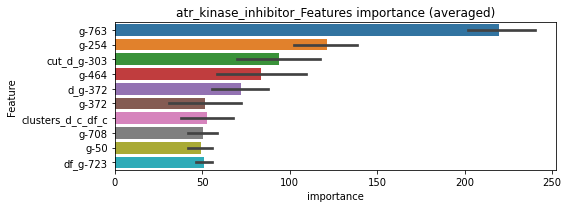

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113527	valid_1's binary_logloss: 0.018929
[200]	training's binary_logloss: 0.00123037	valid_1's binary_logloss: 0.00941458
[300]	training's binary_logloss: 0.000340384	valid_1's binary_logloss: 0.00854898
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000372281	valid_1's binary_logloss: 0.00851116


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115589	valid_1's binary_logloss: 0.017316
[200]	training's binary_logloss: 0.00127476	valid_1's binary_logloss: 0.00738121
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00062676	valid_1's binary_logloss: 0.00681863


atr_kinase_inhibitor logloss: 0.007665001985114623


neg labels: 3289 → selected neg labels: 3273


aurora_kinase_inhibitor, len(trt): 96, len(othr): 3273, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360427	valid_1's binary_logloss: 0.074237
[200]	training's binary_logloss: 0.00563117	valid_1's binary_logloss: 0.0417248
[300]	training's binary_logloss: 0.00164346	valid_1's binary_logloss: 0.035714
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00121833	valid_1's binary_logloss: 0.0348243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354742	valid_1's binary_logloss: 0.0742144
[200]	training's binary_logloss: 0.0059791	valid_1's binary_logloss: 0.0382569
[300]	training's binary_logloss: 0.00176034	valid_1's binary_logloss: 0.0307536
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000913	valid_1's binary_logloss: 0.0286433


1 / 3 AUC score:0.999
y_Threshold: 0.0161405, Threshold: 0.0589219, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 648/3783
p_label_rate: 0.0200904 Vs.target_rate: 0.00403
Num_p_label: 80.0, conf_0:0.05303, conf_1:0.06481
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0589219
Num_p_label: 73.0, Expected: 16.1, Adj_threshold_2: 0.0689219
Num_p_label: 70.0, Expected: 16.1, Adj_threshold_3: 0.0789219
Num_p_label: 68.0, Expected: 16.1, Adj_threshold_4: 0.0889219
Num_p_label: 64.0, Expected: 16.1, Adj_threshold_5: 0.0989219
Num_p_label: 62.0, Expected: 16.1, Adj_threshold_6: 0.1089219
Num_p_label: 57.0, Expected: 16.1, Adj_threshold_7: 0.1189219
Num_p_label: 54.0, Expected: 16.1, Adj_threshold_8: 0.1289219
Num_p_label: 51.0, Expected: 16.1, Adj_threshold_9: 0.1389219
Num_p_label: 49.0, Expected: 16.1, Adj_threshold_10: 0.1489219
threshold: 0.1589219, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 648.0/3783, y_label_rate: 0.1712926

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303521	valid_1's binary_logloss: 0.0629083
[200]	training's binary_logloss: 0.00421929	valid_1's binary_logloss: 0.0306755
[300]	training's binary_logloss: 0.00123227	valid_1's binary_logloss: 0.0262209
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00108107	valid_1's binary_logloss: 0.0257034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314217	valid_1's binary_logloss: 0.0488267
[200]	training's binary_logloss: 0.00451161	valid_1's binary_logloss: 0.0149547
[300]	training's binary_logloss: 0.00130136	valid_1's binary_logloss: 0.00846753
[400]	training's binary_logloss: 0.000650732	valid_1's binary_logloss: 0.00658207
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000499882	valid_1's binary_logloss: 0.00605158


2 / 3 AUC score:0.999
y_Threshold: 0.0938224, Threshold: 0.1589219, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 642.0/3771
p_label_rate: 0.0220994 Vs.target_rate: 0.00403
Num_p_label: 88.0, conf_0:0.14303, conf_1:0.17481
Num_p_label: 88.0, Expected: 16.1, Adj_threshold_1: 0.1589219
Num_p_label: 86.0, Expected: 16.1, Adj_threshold_2: 0.1689219
Num_p_label: 84.0, Expected: 16.1, Adj_threshold_3: 0.1789219
Num_p_label: 83.0, Expected: 16.1, Adj_threshold_4: 0.1889219
Num_p_label: 82.0, Expected: 16.1, Adj_threshold_5: 0.1989219
Num_p_label: 82.0, Expected: 16.1, Adj_threshold_6: 0.2089219
Num_p_label: 81.0, Expected: 16.1, Adj_threshold_7: 0.2189219
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_8: 0.2289219
Num_p_label: 77.0, Expected: 16.1, Adj_threshold_9: 0.2389219
Num_p_label: 77.0, Expected: 16.1, Adj_threshold_10: 0.2489219
threshold: 0.2589219, positive_p_label: 73.0/3982, p_label_rate: 0.0183325
positive_y_label: 642.0/3771, y_label_rate: 0.170246

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296979	valid_1's binary_logloss: 0.0530555
[200]	training's binary_logloss: 0.0040575	valid_1's binary_logloss: 0.0194203
[300]	training's binary_logloss: 0.00118642	valid_1's binary_logloss: 0.0135746
[400]	training's binary_logloss: 0.00059783	valid_1's binary_logloss: 0.0115485
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000486824	valid_1's binary_logloss: 0.0110804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305466	valid_1's binary_logloss: 0.0540425
[200]	training's binary_logloss: 0.004271	valid_1's binary_logloss: 0.019612
[300]	training's binary_logloss: 0.00121848	valid_1's binary_logloss: 0.0127466
[400]	training's binary_logloss: 0.000606876	valid_1's binary_logloss: 0.0105181
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000465402	valid_1's binary_logloss: 0.0101262


3 / 3 AUC score:1.000
y_Threshold: 0.0844270, Threshold: 0.2589219, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 639.0/3765
p_label_rate: 0.0170768 Vs.target_rate: 0.00403
Num_p_label: 68.0, conf_0:0.23303, conf_1:0.28481
Num_p_label: 68.0, Expected: 16.1, Adj_threshold_1: 0.2589219
Num_p_label: 68.0, Expected: 16.1, Adj_threshold_2: 0.2689219
Num_p_label: 68.0, Expected: 16.1, Adj_threshold_3: 0.2789219
Num_p_label: 67.0, Expected: 16.1, Adj_threshold_4: 0.2889219
Num_p_label: 66.0, Expected: 16.1, Adj_threshold_5: 0.2989219
Num_p_label: 66.0, Expected: 16.1, Adj_threshold_6: 0.3089219
Num_p_label: 66.0, Expected: 16.1, Adj_threshold_7: 0.3189219
Num_p_label: 65.0, Expected: 16.1, Adj_threshold_8: 0.3289219
Num_p_label: 65.0, Expected: 16.1, Adj_threshold_9: 0.3389219
Num_p_label: 63.0, Expected: 16.1, Adj_threshold_10: 0.3489219
threshold: 0.3589219, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 701.0/7747, y_label_rate: 0.0904866

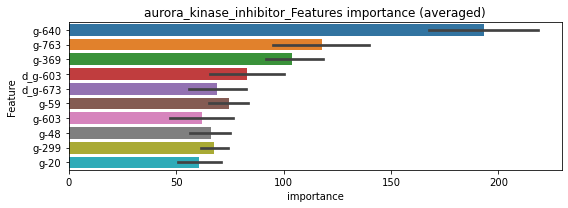

len(train_index) : 3873
len(valid_index) : 3874
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170571	valid_1's binary_logloss: 0.0431898
[200]	training's binary_logloss: 0.00245263	valid_1's binary_logloss: 0.0253663
[300]	training's binary_logloss: 0.000728683	valid_1's binary_logloss: 0.0220466
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000614694	valid_1's binary_logloss: 0.0217837


len(train_index) : 3874
len(valid_index) : 3873
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172189	valid_1's binary_logloss: 0.0355674
[200]	training's binary_logloss: 0.00250877	valid_1's binary_logloss: 0.0149277
[300]	training's binary_logloss: 0.000729443	valid_1's binary_logloss: 0.0101631
[400]	training's binary_logloss: 0.000367142	valid_1's binary_logloss: 0.00872552
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000267425	valid_1's binary_logloss: 0.00812453


aurora_kinase_inhibitor logloss: 0.01495497372401409


neg labels: 3289 → selected neg labels: 3288


autotaxin_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160625	valid_1's binary_logloss: 0.0179388
[200]	training's binary_logloss: 0.00133795	valid_1's binary_logloss: 0.00214759
[300]	training's binary_logloss: 0.000353081	valid_1's binary_logloss: 0.000884597
[400]	training's binary_logloss: 0.000212765	valid_1's binary_logloss: 0.000681799
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000210436	valid_1's binary_logloss: 0.000681379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161377	valid_1's binary_logloss: 0.0181805
[200]	training's binary_logloss: 0.00134597	valid_1's binary_logloss: 0.00226513
[300]	training's binary_logloss: 0.000355517	valid_1's binary_logloss: 0.000854104
[400]	training's binary_logloss: 0.000214375	valid_1's binary_logloss: 0.000606432
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000190678	valid_1's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0005191, Threshold: 0.0010328, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00093, conf_1:0.00114
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0010328
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.0110328
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_3: 0.0210328
threshold: 0.0210328, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016256	valid_1's binary_logloss: 0.0180891
[200]	training's binary_logloss: 0.00132387	valid_1's binary_logloss: 0.002059
[300]	training's binary_logloss: 0.000348165	valid_1's binary_logloss: 0.000785317
[400]	training's binary_logloss: 0.000211792	valid_1's binary_logloss: 0.000574709
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000187779	valid_1's binary_logloss: 0.000545143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164395	valid_1's binary_logloss: 0.0180851
[200]	training's binary_logloss: 0.00134015	valid_1's binary_logloss: 0.00196818
[300]	training's binary_logloss: 0.000351498	valid_1's binary_logloss: 0.000635224
[400]	training's binary_logloss: 0.000213956	valid_1's binary_logloss: 0.000421768
[500]	training's binary_logloss: 0.000187495	valid_1's binary_logloss: 0.000387695
Early stopping, best iterati

2 / 3 AUC score:1.000
y_Threshold: 0.1358300, Threshold: 0.0210328, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0015068 Vs.target_rate: 0.00025
Num_p_label: 6.0, conf_0:0.01893, conf_1:0.02314
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_1: 0.0210328
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0310328
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0410328
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.0510328
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.0610328
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.0710328
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.0810328
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.0910328
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_9: 0.1010328
threshold: 0.1010328, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016256	valid_1's binary_logloss: 0.0180891
[200]	training's binary_logloss: 0.00132387	valid_1's binary_logloss: 0.002059
[300]	training's binary_logloss: 0.000348165	valid_1's binary_logloss: 0.000785317
[400]	training's binary_logloss: 0.000211792	valid_1's binary_logloss: 0.000574709
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000187779	valid_1's binary_logloss: 0.000545143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164395	valid_1's binary_logloss: 0.0180851
[200]	training's binary_logloss: 0.00134015	valid_1's binary_logloss: 0.00196818
[300]	training's binary_logloss: 0.000351498	valid_1's binary_logloss: 0.000635224
[400]	training's binary_logloss: 0.000213956	valid_1's binary_logloss: 0.000421768
[500]	training's binary_logloss: 0.000187495	valid_1's binary_logloss: 0.000387695
Early stopping, best iterati

3 / 3 AUC score:1.000
y_Threshold: 0.1358300, Threshold: 0.1010328, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025
Num_p_label: 2.0, conf_0:0.09093, conf_1:0.11114
threshold: 0.1010328, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


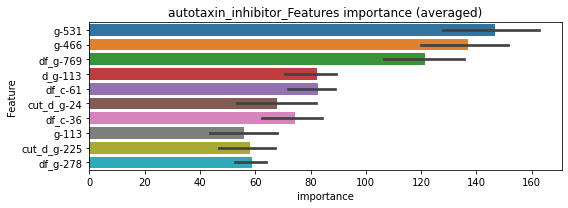

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00870762	valid_1's binary_logloss: 0.0101891
[200]	training's binary_logloss: 0.000712492	valid_1's binary_logloss: 0.00163253
[300]	training's binary_logloss: 0.000184742	valid_1's binary_logloss: 0.00104341
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000147352	valid_1's binary_logloss: 0.00100262


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00871328	valid_1's binary_logloss: 0.0107035
[200]	training's binary_logloss: 0.000695094	valid_1's binary_logloss: 0.00209427
[300]	training's binary_logloss: 0.000181288	valid_1's binary_logloss: 0.00149916
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000132405	valid_1's binary_logloss: 0.0014614


autotaxin_inhibitor logloss: 0.0012319817570060419


neg labels: 3289 → selected neg labels: 3279


bacterial_30s_ribosomal_subunit_inhibitor, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452365	valid_1's binary_logloss: 0.089769
[200]	training's binary_logloss: 0.00868786	valid_1's binary_logloss: 0.0486387
[300]	training's binary_logloss: 0.00249792	valid_1's binary_logloss: 0.0387155
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00178271	valid_1's binary_logloss: 0.0367795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425839	valid_1's binary_logloss: 0.0787042
[200]	training's binary_logloss: 0.00799531	valid_1's binary_logloss: 0.0379456
[300]	training's binary_logloss: 0.00236819	valid_1's binary_logloss: 0.0279138
[400]	training's binary_logloss: 0.00111344	valid_1's binary_logloss: 0.0248794
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000794391	valid_1's binary_logloss: 0.0234616


1 / 3 AUC score:0.999
y_Threshold: 0.0065233, Threshold: 0.0089816, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00252
Num_p_label: 80.0, conf_0:0.00808, conf_1:0.00988
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0089816
Num_p_label: 17.0, Expected: 10.0, Adj_threshold_2: 0.0189816
threshold: 0.0189816, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449101	valid_1's binary_logloss: 0.0851926
[200]	training's binary_logloss: 0.00807493	valid_1's binary_logloss: 0.0434716
[300]	training's binary_logloss: 0.00230773	valid_1's binary_logloss: 0.0345482
[400]	training's binary_logloss: 0.00111641	valid_1's binary_logloss: 0.0313315
[500]	training's binary_logloss: 0.000704506	valid_1's binary_logloss: 0.0300088
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.000581055	valid_1's binary_logloss: 0.0295735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447799	valid_1's binary_logloss: 0.0798355
[200]	training's binary_logloss: 0.00855671	valid_1's binary_logloss: 0.0378271
[300]	training's binary_logloss: 0.00250373	valid_1's binary_logloss: 0.0288597
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00150817	valid_1's binary_logloss: 0.0274194


2 / 3 AUC score:0.999
y_Threshold: 0.0253690, Threshold: 0.0189816, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 650.0/3792
p_label_rate: 0.0055249 Vs.target_rate: 0.00252
Num_p_label: 22.0, conf_0:0.01708, conf_1:0.02088
threshold: 0.0189816, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 650.0/3792, y_label_rate: 0.1714135
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434715	valid_1's binary_logloss: 0.0890677
[200]	training's binary_logloss: 0.00763982	valid_1's binary_logloss: 0.0439474
[300]	training's binary_logloss: 0.00221836	valid_1's binary_logloss: 0.0333261
[400]	training's binary_logloss: 0.00107253	valid_1's binary_logloss: 0.0300879
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00103599	valid_1's binary_logloss: 0.0300286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431107	valid_1's binary_logloss: 0.0778974
[200]	training's binary_logloss: 0.00802821	valid_1's binary_logloss: 0.0350629
[300]	training's binary_logloss: 0.00240398	valid_1's binary_logloss: 0.0252061
[400]	training's binary_logloss: 0.00113823	valid_1's binary_logloss: 0.0217423
[500]	training's binary_logloss: 0.000728259	valid_1's binary_logloss: 0.0203136
Early stopping, best iteration is:
[567]	tra

3 / 3 AUC score:1.000
y_Threshold: 0.0176455, Threshold: 0.0189816, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 649.0/3790
p_label_rate: 0.0060271 Vs.target_rate: 0.00252
Num_p_label: 24.0, conf_0:0.01708, conf_1:0.02088
threshold: 0.0189816, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 673.0/7772, y_label_rate: 0.0865929


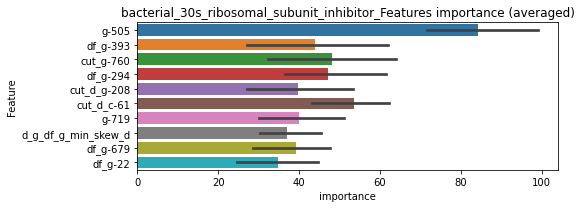

len(train_index) : 3886
len(valid_index) : 3886
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243713	valid_1's binary_logloss: 0.0591465
[200]	training's binary_logloss: 0.00428766	valid_1's binary_logloss: 0.0368424
[300]	training's binary_logloss: 0.00121742	valid_1's binary_logloss: 0.0323429
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00110969	valid_1's binary_logloss: 0.0320178


len(train_index) : 3886
len(valid_index) : 3886
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278322	valid_1's binary_logloss: 0.0507055
[200]	training's binary_logloss: 0.00528874	valid_1's binary_logloss: 0.0240851
[300]	training's binary_logloss: 0.00144744	valid_1's binary_logloss: 0.018951
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00100317	valid_1's binary_logloss: 0.0182044


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.025111062543106202


neg labels: 3289 → selected neg labels: 3277


bacterial_50s_ribosomal_subunit_inhibitor, len(trt): 80, len(othr): 3277, target_rate: 0.0033594 → Adj_target_rate: 0.0034820
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458744	valid_1's binary_logloss: 0.100548
[200]	training's binary_logloss: 0.00997184	valid_1's binary_logloss: 0.0625
[300]	training's binary_logloss: 0.00302638	valid_1's binary_logloss: 0.0522685
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00154273	valid_1's binary_logloss: 0.0484626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479041	valid_1's binary_logloss: 0.10994
[200]	training's binary_logloss: 0.0100308	valid_1's binary_logloss: 0.0728302
[300]	training's binary_logloss: 0.00304067	valid_1's binary_logloss: 0.0660164
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00273643	valid_1's binary_logloss: 0.0650774


1 / 3 AUC score:0.998
y_Threshold: 0.0107530, Threshold: 0.0135243, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3792
p_label_rate: 0.0200904 Vs.target_rate: 0.00336
Num_p_label: 80.0, conf_0:0.01217, conf_1:0.01488
Num_p_label: 80.0, Expected: 13.4, Adj_threshold_1: 0.0135243
Num_p_label: 28.0, Expected: 13.4, Adj_threshold_2: 0.0235243
Num_p_label: 8.0, Expected: 13.4, Adj_threshold_3: 0.0335243
threshold: 0.0335243, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 651.0/3792, y_label_rate: 0.1716772
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479456	valid_1's binary_logloss: 0.106302
[200]	training's binary_logloss: 0.00907274	valid_1's binary_logloss: 0.0649328
[300]	training's binary_logloss: 0.00273506	valid_1's binary_logloss: 0.0567332
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0021318	valid_1's binary_logloss: 0.0558056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494773	valid_1's binary_logloss: 0.0994889
[200]	training's binary_logloss: 0.010579	valid_1's binary_logloss: 0.0546206
[300]	training's binary_logloss: 0.00314531	valid_1's binary_logloss: 0.04255
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00221629	valid_1's binary_logloss: 0.0408088


2 / 3 AUC score:0.999
y_Threshold: 0.0246381, Threshold: 0.0335243, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 641.0/3772
p_label_rate: 0.0042692 Vs.target_rate: 0.00336
Num_p_label: 17.0, conf_0:0.03017, conf_1:0.03688
threshold: 0.0335243, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 641.0/3772, y_label_rate: 0.1699364
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482443	valid_1's binary_logloss: 0.0993727
[200]	training's binary_logloss: 0.00931091	valid_1's binary_logloss: 0.0558141
[300]	training's binary_logloss: 0.00277518	valid_1's binary_logloss: 0.0460831
[400]	training's binary_logloss: 0.00131949	valid_1's binary_logloss: 0.0435741
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000997475	valid_1's binary_logloss: 0.0424145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447689	valid_1's binary_logloss: 0.0971873
[200]	training's binary_logloss: 0.00887586	valid_1's binary_logloss: 0.0541567
[300]	training's binary_logloss: 0.00270349	valid_1's binary_logloss: 0.0439131
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00233852	valid_1's binary_logloss: 0.0430955


3 / 3 AUC score:0.999
y_Threshold: 0.0259191, Threshold: 0.0335243, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 635.0/3760
p_label_rate: 0.0035158 Vs.target_rate: 0.00336
Num_p_label: 14.0, conf_0:0.03017, conf_1:0.03688
threshold: 0.0335243, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 649.0/7742, y_label_rate: 0.0838285


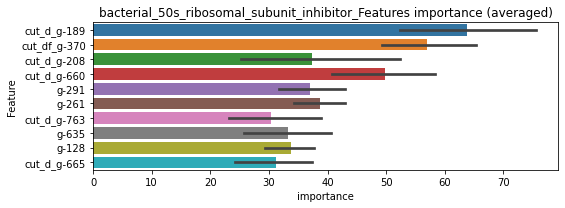

len(train_index) : 3871
len(valid_index) : 3871
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254263	valid_1's binary_logloss: 0.0623746
[200]	training's binary_logloss: 0.00479121	valid_1's binary_logloss: 0.0443229
[300]	training's binary_logloss: 0.0013866	valid_1's binary_logloss: 0.0407582
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0013089	valid_1's binary_logloss: 0.0405533


len(train_index) : 3871
len(valid_index) : 3871
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259484	valid_1's binary_logloss: 0.0566642
[200]	training's binary_logloss: 0.0051331	valid_1's binary_logloss: 0.0357907
[300]	training's binary_logloss: 0.00150787	valid_1's binary_logloss: 0.0309117
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00103451	valid_1's binary_logloss: 0.0303045


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.03542888555496768


neg labels: 3289 → selected neg labels: 3283


bacterial_antifolate, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328101	valid_1's binary_logloss: 0.0542689
[200]	training's binary_logloss: 0.00459834	valid_1's binary_logloss: 0.0177566
[300]	training's binary_logloss: 0.00126546	valid_1's binary_logloss: 0.0110552
[400]	training's binary_logloss: 0.000623857	valid_1's binary_logloss: 0.00897009
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00048863	valid_1's binary_logloss: 0.00842669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320936	valid_1's binary_logloss: 0.0514673
[200]	training's binary_logloss: 0.00480815	valid_1's binary_logloss: 0.0178499
[300]	training's binary_logloss: 0.0013475	valid_1's binary_logloss: 0.0115711
[400]	training's binary_logloss: 0.000666344	valid_1's binary_logloss: 0.00992867
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000461605	valid_1's binary_logloss: 0.00937894


1 / 3 AUC score:1.000
y_Threshold: 0.0033844, Threshold: 0.0051392, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00463, conf_1:0.00565
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0051392
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.0151392
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_3: 0.0251392
threshold: 0.0251392, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306346	valid_1's binary_logloss: 0.0518471
[200]	training's binary_logloss: 0.00430424	valid_1's binary_logloss: 0.0169313
[300]	training's binary_logloss: 0.00120448	valid_1's binary_logloss: 0.0109135
[400]	training's binary_logloss: 0.000602766	valid_1's binary_logloss: 0.00902861
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000483914	valid_1's binary_logloss: 0.00864831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321105	valid_1's binary_logloss: 0.0513142
[200]	training's binary_logloss: 0.00461596	valid_1's binary_logloss: 0.0165094
[300]	training's binary_logloss: 0.00131349	valid_1's binary_logloss: 0.0109417
[400]	training's binary_logloss: 0.000651646	valid_1's binary_logloss: 0.00917247
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000502245	valid_1's binary_logloss: 0.00880315


2 / 3 AUC score:1.000
y_Threshold: 0.0408585, Threshold: 0.0251392, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0062783 Vs.target_rate: 0.00151
Num_p_label: 25.0, conf_0:0.02263, conf_1:0.02765
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_1: 0.0251392
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.0351392
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_3: 0.0451392
threshold: 0.0451392, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306346	valid_1's binary_logloss: 0.0518471
[200]	training's binary_logloss: 0.00430424	valid_1's binary_logloss: 0.0169313
[300]	training's binary_logloss: 0.00120448	valid_1's binary_logloss: 0.0109135
[400]	training's binary_logloss: 0.000602766	valid_1's binary_logloss: 0.00902861
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000483914	valid_1's binary_logloss: 0.00864831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321105	valid_1's binary_logloss: 0.0513142
[200]	training's binary_logloss: 0.00461596	valid_1's binary_logloss: 0.0165094
[300]	training's binary_logloss: 0.00131349	valid_1's binary_logloss: 0.0109417
[400]	training's binary_logloss: 0.000651646	valid_1's binary_logloss: 0.00917247
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000502245	valid_1's binary_logloss: 0.00880315


3 / 3 AUC score:1.000
y_Threshold: 0.0408585, Threshold: 0.0451392, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0025113 Vs.target_rate: 0.00151
Num_p_label: 10.0, conf_0:0.04063, conf_1:0.04965
threshold: 0.0451392, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7789, y_label_rate: 0.0855052


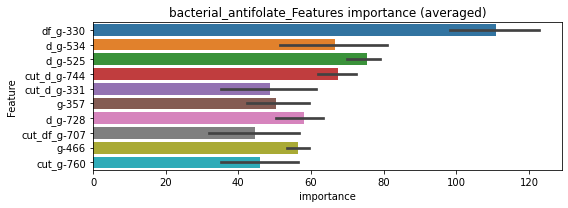

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184032	valid_1's binary_logloss: 0.0311401
[200]	training's binary_logloss: 0.00264118	valid_1's binary_logloss: 0.0121866
[300]	training's binary_logloss: 0.000711967	valid_1's binary_logloss: 0.00934313
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000615602	valid_1's binary_logloss: 0.00921957


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017478	valid_1's binary_logloss: 0.0296334
[200]	training's binary_logloss: 0.00251739	valid_1's binary_logloss: 0.0115009
[300]	training's binary_logloss: 0.000708588	valid_1's binary_logloss: 0.00835766
[400]	training's binary_logloss: 0.000352571	valid_1's binary_logloss: 0.00752917
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000320376	valid_1's binary_logloss: 0.00743819


bacterial_antifolate logloss: 0.008328990637751743


neg labels: 3289 → selected neg labels: 3259


bacterial_cell_wall_synthesis_inhibitor, len(trt): 192, len(othr): 3259, target_rate: 0.0080625 → Adj_target_rate: 0.0073283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741296	valid_1's binary_logloss: 0.210347
[200]	training's binary_logloss: 0.0224589	valid_1's binary_logloss: 0.182429
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0170027	valid_1's binary_logloss: 0.181131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908437	valid_1's binary_logloss: 0.200279
[200]	training's binary_logloss: 0.0295548	valid_1's binary_logloss: 0.166261
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0229269	valid_1's binary_logloss: 0.163984


1 / 3 AUC score:0.956
y_Threshold: 0.0568709, Threshold: 0.0675166, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 297 → Positive_corect_labels: 568/3613
p_label_rate: 0.0200904 Vs.target_rate: 0.00806
Num_p_label: 80.0, conf_0:0.06076, conf_1:0.07427
threshold: 0.0675166, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 568.0/3613, y_label_rate: 0.1572101
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603251	valid_1's binary_logloss: 0.155326
[200]	training's binary_logloss: 0.015383	valid_1's binary_logloss: 0.12136
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0105781	valid_1's binary_logloss: 0.116775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684437	valid_1's binary_logloss: 0.14844
[200]	training's binary_logloss: 0.0186977	valid_1's binary_logloss: 0.10654
[300]	training's binary_logloss: 0.00594121	valid_1's binary_logloss: 0.0977561
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00348075	valid_1's binary_logloss: 0.0956295


2 / 3 AUC score:0.989
y_Threshold: 0.0554675, Threshold: 0.0675166, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 74 → Positive_corect_labels: 531.0/3539
p_label_rate: 0.0052737 Vs.target_rate: 0.00806
Num_p_label: 21.0, conf_0:0.06076, conf_1:0.07427
threshold: 0.0675166, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 531.0/3539, y_label_rate: 0.1500424
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544328	valid_1's binary_logloss: 0.152673
[200]	training's binary_logloss: 0.0127043	valid_1's binary_logloss: 0.117484
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00683944	valid_1's binary_logloss: 0.113358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.058565	valid_1's binary_logloss: 0.134221
[200]	training's binary_logloss: 0.015041	valid_1's binary_logloss: 0.0954359
[300]	training's binary_logloss: 0.00490597	valid_1's binary_logloss: 0.0856295
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00276072	valid_1's binary_logloss: 0.0831709


3 / 3 AUC score:0.993
y_Threshold: 0.0474507, Threshold: 0.0675166, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 505.0/3487
p_label_rate: 0.0035158 Vs.target_rate: 0.00806
Num_p_label: 14.0, conf_0:0.06076, conf_1:0.07427
threshold: 0.0675166, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 519.0/7469, y_label_rate: 0.0694872


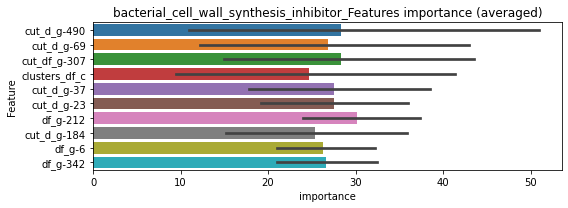

len(train_index) : 3734
len(valid_index) : 3735
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263499	valid_1's binary_logloss: 0.083663
[200]	training's binary_logloss: 0.00589954	valid_1's binary_logloss: 0.069531
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00547499	valid_1's binary_logloss: 0.0693342


len(train_index) : 3735
len(valid_index) : 3734
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269662	valid_1's binary_logloss: 0.0720708
[200]	training's binary_logloss: 0.00621087	valid_1's binary_logloss: 0.0568521
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00449544	valid_1's binary_logloss: 0.0557663


bacterial_cell_wall_synthesis_inhibitor logloss: 0.0625511876718351


neg labels: 3289 → selected neg labels: 3274


bacterial_dna_gyrase_inhibitor, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496557	valid_1's binary_logloss: 0.11648
[200]	training's binary_logloss: 0.0105186	valid_1's binary_logloss: 0.0772819
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00385797	valid_1's binary_logloss: 0.0704712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540913	valid_1's binary_logloss: 0.110652
[200]	training's binary_logloss: 0.0123299	valid_1's binary_logloss: 0.0673091
[300]	training's binary_logloss: 0.00358616	valid_1's binary_logloss: 0.0552394
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00247224	valid_1's binary_logloss: 0.0530475


1 / 3 AUC score:0.994
y_Threshold: 0.0164863, Threshold: 0.0199157, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 160 → Positive_corect_labels: 640/3768
p_label_rate: 0.0200904 Vs.target_rate: 0.00374
Num_p_label: 80.0, conf_0:0.01792, conf_1:0.02191
Num_p_label: 80.0, Expected: 14.9, Adj_threshold_1: 0.0199157
Num_p_label: 29.0, Expected: 14.9, Adj_threshold_2: 0.0299157
threshold: 0.0299157, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 640.0/3768, y_label_rate: 0.1698514
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453052	valid_1's binary_logloss: 0.110446
[200]	training's binary_logloss: 0.00908359	valid_1's binary_logloss: 0.0724948
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00310209	valid_1's binary_logloss: 0.0653118
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0519723	valid_1's binary_logloss: 0.100683
[200]	training's binary_logloss: 0.0107026	valid_1's binary_logloss: 0.0517055
[300]	training's binary_logloss: 0.0032752	valid_1's binary_logloss: 0.0407649
[400]	training's binary_logloss: 0.00153848	valid_1's binary_logloss: 0.0371815
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00117723	valid_1's binary_logloss: 0.0364696


2 / 3 AUC score:0.996
y_Threshold: 0.0359022, Threshold: 0.0299157, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 630.0/3748
p_label_rate: 0.0102963 Vs.target_rate: 0.00374
Num_p_label: 41.0, conf_0:0.02692, conf_1:0.03291
threshold: 0.0299157, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 630.0/3748, y_label_rate: 0.1680896
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486885	valid_1's binary_logloss: 0.0984654
[200]	training's binary_logloss: 0.00989521	valid_1's binary_logloss: 0.0534833
[300]	training's binary_logloss: 0.00298184	valid_1's binary_logloss: 0.0431706
[400]	training's binary_logloss: 0.00139915	valid_1's binary_logloss: 0.0398584
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00105088	valid_1's binary_logloss: 0.0386333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045083	valid_1's binary_logloss: 0.0977315
[200]	training's binary_logloss: 0.00887503	valid_1's binary_logloss: 0.0584084
[300]	training's binary_logloss: 0.00271105	valid_1's binary_logloss: 0.0504905
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00284803	valid_1's binary_logloss: 0.0502811


3 / 3 AUC score:0.999
y_Threshold: 0.0319509, Threshold: 0.0299157, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 622.0/3732
p_label_rate: 0.0133099 Vs.target_rate: 0.00374
Num_p_label: 53.0, conf_0:0.02692, conf_1:0.03291
Num_p_label: 53.0, Expected: 14.9, Adj_threshold_1: 0.0299157
Num_p_label: 29.0, Expected: 14.9, Adj_threshold_2: 0.0399157
threshold: 0.0399157, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 651.0/7714, y_label_rate: 0.0843920


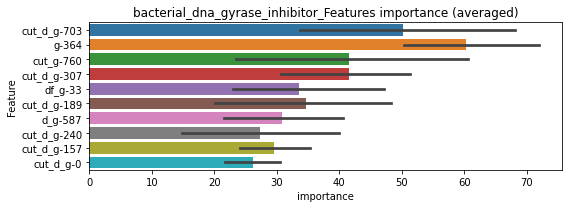

len(train_index) : 3857
len(valid_index) : 3857
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260291	valid_1's binary_logloss: 0.065621
[200]	training's binary_logloss: 0.00521266	valid_1's binary_logloss: 0.0445894
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00293102	valid_1's binary_logloss: 0.0422391


len(train_index) : 3857
len(valid_index) : 3857
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263828	valid_1's binary_logloss: 0.0583884
[200]	training's binary_logloss: 0.00548939	valid_1's binary_logloss: 0.0377445
[300]	training's binary_logloss: 0.00173302	valid_1's binary_logloss: 0.0336701
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00180211	valid_1's binary_logloss: 0.0336468


bacterial_dna_gyrase_inhibitor logloss: 0.03794294479333752


neg labels: 3289 → selected neg labels: 3271


bacterial_dna_inhibitor, len(trt): 115, len(othr): 3271, target_rate: 0.0048291 → Adj_target_rate: 0.0047401
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0593391	valid_1's binary_logloss: 0.147251
[200]	training's binary_logloss: 0.0142091	valid_1's binary_logloss: 0.106671
[300]	training's binary_logloss: 0.0044306	valid_1's binary_logloss: 0.0980444
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00393373	valid_1's binary_logloss: 0.0970448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632774	valid_1's binary_logloss: 0.137447
[200]	training's binary_logloss: 0.0165265	valid_1's binary_logloss: 0.0889103
[300]	training's binary_logloss: 0.00531678	valid_1's binary_logloss: 0.0747159
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00303035	valid_1's binary_logloss: 0.0716028


1 / 3 AUC score:0.993
y_Threshold: 0.0183922, Threshold: 0.0264684, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 169 → Positive_corect_labels: 635/3756
p_label_rate: 0.0200904 Vs.target_rate: 0.00483
Num_p_label: 80.0, conf_0:0.02382, conf_1:0.02912
Num_p_label: 80.0, Expected: 19.2, Adj_threshold_1: 0.0264684
Num_p_label: 37.0, Expected: 19.2, Adj_threshold_2: 0.0364684
threshold: 0.0364684, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 635.0/3756, y_label_rate: 0.1690628
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0581962	valid_1's binary_logloss: 0.129919
[200]	training's binary_logloss: 0.0136425	valid_1's binary_logloss: 0.0869432
[300]	training's binary_logloss: 0.00427199	valid_1's binary_logloss: 0.0747788
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00217253	valid_1's binary_logloss: 0.0710385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588781	valid_1's binary_logloss: 0.128811
[200]	training's binary_logloss: 0.0135666	valid_1's binary_logloss: 0.0797254
[300]	training's binary_logloss: 0.00418107	valid_1's binary_logloss: 0.068071
[400]	training's binary_logloss: 0.0018859	valid_1's binary_logloss: 0.0644282
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00182085	valid_1's binary_logloss: 0.0643483


2 / 3 AUC score:0.998
y_Threshold: 0.0385611, Threshold: 0.0364684, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 617.0/3720
p_label_rate: 0.0113009 Vs.target_rate: 0.00483
Num_p_label: 45.0, conf_0:0.03282, conf_1:0.04012
threshold: 0.0364684, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 617.0/3720, y_label_rate: 0.1658602
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553782	valid_1's binary_logloss: 0.120663
[200]	training's binary_logloss: 0.0123649	valid_1's binary_logloss: 0.0734979
[300]	training's binary_logloss: 0.00391099	valid_1's binary_logloss: 0.0637566
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.001915	valid_1's binary_logloss: 0.0600167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545631	valid_1's binary_logloss: 0.122215
[200]	training's binary_logloss: 0.011883	valid_1's binary_logloss: 0.0780008
[300]	training's binary_logloss: 0.00377235	valid_1's binary_logloss: 0.0676813
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0032577	valid_1's binary_logloss: 0.0669547


3 / 3 AUC score:0.998
y_Threshold: 0.0443699, Threshold: 0.0364684, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 600.0/3686
p_label_rate: 0.0113009 Vs.target_rate: 0.00483
Num_p_label: 45.0, conf_0:0.03282, conf_1:0.04012
threshold: 0.0364684, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 645.0/7668, y_label_rate: 0.0841158


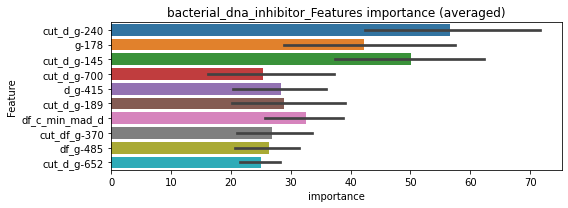

len(train_index) : 3834
len(valid_index) : 3834
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306584	valid_1's binary_logloss: 0.0822099
[200]	training's binary_logloss: 0.00702563	valid_1's binary_logloss: 0.0620473
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00362765	valid_1's binary_logloss: 0.0597578


len(train_index) : 3834
len(valid_index) : 3834
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343125	valid_1's binary_logloss: 0.0790331
[200]	training's binary_logloss: 0.00787428	valid_1's binary_logloss: 0.0545453
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00275546	valid_1's binary_logloss: 0.0508855


bacterial_dna_inhibitor logloss: 0.05532168166572476


neg labels: 3289 → selected neg labels: 3285


bacterial_membrane_integrity_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225646	valid_1's binary_logloss: 0.0353299
[200]	training's binary_logloss: 0.00256392	valid_1's binary_logloss: 0.0125713
[300]	training's binary_logloss: 0.000716912	valid_1's binary_logloss: 0.00875533
[400]	training's binary_logloss: 0.000374866	valid_1's binary_logloss: 0.00734369
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000335071	valid_1's binary_logloss: 0.00719478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233219	valid_1's binary_logloss: 0.0295935
[200]	training's binary_logloss: 0.00272452	valid_1's binary_logloss: 0.00461165
[300]	training's binary_logloss: 0.000749888	valid_1's binary_logloss: 0.00169348
[400]	training's binary_logloss: 0.000391823	valid_1's binary_logloss: 0.00103824
[500]	training's binary_logloss: 0.00032203	valid_1's binary_logloss: 0.000915104
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0015066, Threshold: 0.0034765, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00313, conf_1:0.00382
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0034765
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_2: 0.0134765
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_3: 0.0234765
threshold: 0.0234765, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224318	valid_1's binary_logloss: 0.033461
[200]	training's binary_logloss: 0.00249739	valid_1's binary_logloss: 0.0104839
[300]	training's binary_logloss: 0.000686269	valid_1's binary_logloss: 0.0069195
[400]	training's binary_logloss: 0.000362337	valid_1's binary_logloss: 0.00610854
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000366924	valid_1's binary_logloss: 0.00609951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229704	valid_1's binary_logloss: 0.0287074
[200]	training's binary_logloss: 0.00261886	valid_1's binary_logloss: 0.00426064
[300]	training's binary_logloss: 0.000709926	valid_1's binary_logloss: 0.00150119
[400]	training's binary_logloss: 0.000369276	valid_1's binary_logloss: 0.000905268
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00030974	valid_1's binary_logloss: 0.00080901

2 / 3 AUC score:1.000
y_Threshold: 0.0324188, Threshold: 0.0234765, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0097941 Vs.target_rate: 0.00080
Num_p_label: 39.0, conf_0:0.02113, conf_1:0.02582
Num_p_label: 39.0, Expected: 3.2, Adj_threshold_1: 0.0234765
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_2: 0.0334765
Num_p_label: 22.0, Expected: 3.2, Adj_threshold_3: 0.0434765
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_4: 0.0534765
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_5: 0.0634765
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_6: 0.0734765
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_7: 0.0834765
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_8: 0.0934765
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_9: 0.1034765
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_10: 0.1134765
threshold: 0.1234765, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224318	valid_1's binary_logloss: 0.033461
[200]	training's binary_logloss: 0.00249739	valid_1's binary_logloss: 0.0104839
[300]	training's binary_logloss: 0.000686269	valid_1's binary_logloss: 0.0069195
[400]	training's binary_logloss: 0.000362337	valid_1's binary_logloss: 0.00610854
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000366924	valid_1's binary_logloss: 0.00609951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229704	valid_1's binary_logloss: 0.0287074
[200]	training's binary_logloss: 0.00261886	valid_1's binary_logloss: 0.00426064
[300]	training's binary_logloss: 0.000709926	valid_1's binary_logloss: 0.00150119
[400]	training's binary_logloss: 0.000369276	valid_1's binary_logloss: 0.000905268
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00030974	valid_1's binary_logloss: 0.00080901

3 / 3 AUC score:1.000
y_Threshold: 0.0324188, Threshold: 0.1234765, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00080
Num_p_label: 7.0, conf_0:0.11113, conf_1:0.13582
threshold: 0.1234765, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


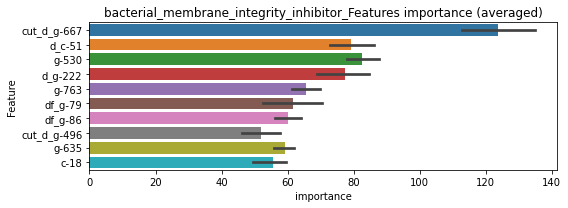

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011905	valid_1's binary_logloss: 0.0229322
[200]	training's binary_logloss: 0.00129518	valid_1's binary_logloss: 0.0114755
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000605729	valid_1's binary_logloss: 0.0107153


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012292	valid_1's binary_logloss: 0.0162068
[200]	training's binary_logloss: 0.00145314	valid_1's binary_logloss: 0.00448186
[300]	training's binary_logloss: 0.000403241	valid_1's binary_logloss: 0.00329732
[400]	training's binary_logloss: 0.000206262	valid_1's binary_logloss: 0.00304591
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000175833	valid_1's binary_logloss: 0.0030185


bacterial_membrane_integrity_inhibitor logloss: 0.006866902417243748


neg labels: 3289 → selected neg labels: 3283


bcl_inhibitor, len(trt): 31, len(othr): 3283, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272815	valid_1's binary_logloss: 0.0437037
[200]	training's binary_logloss: 0.00353618	valid_1's binary_logloss: 0.0125171
[300]	training's binary_logloss: 0.00100818	valid_1's binary_logloss: 0.00726561
[400]	training's binary_logloss: 0.000517604	valid_1's binary_logloss: 0.00556258
[500]	training's binary_logloss: 0.000384398	valid_1's binary_logloss: 0.0050452
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000381354	valid_1's binary_logloss: 0.005041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273438	valid_1's binary_logloss: 0.045716
[200]	training's binary_logloss: 0.00362032	valid_1's binary_logloss: 0.0148854
[300]	training's binary_logloss: 0.00102739	valid_1's binary_logloss: 0.00941318
[400]	training's binary_logloss: 0.000522175	valid_1's binary_logloss: 0.00773403
[500]	training's binary_logloss: 0.0003

1 / 3 AUC score:1.000
y_Threshold: 0.0032217, Threshold: 0.0877129, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00130
Num_p_label: 80.0, conf_0:0.07894, conf_1:0.09648
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0877129
Num_p_label: 74.0, Expected: 5.2, Adj_threshold_2: 0.0977129
Num_p_label: 71.0, Expected: 5.2, Adj_threshold_3: 0.1077129
Num_p_label: 67.0, Expected: 5.2, Adj_threshold_4: 0.1177129
Num_p_label: 62.0, Expected: 5.2, Adj_threshold_5: 0.1277129
Num_p_label: 61.0, Expected: 5.2, Adj_threshold_6: 0.1377129
Num_p_label: 60.0, Expected: 5.2, Adj_threshold_7: 0.1477129
Num_p_label: 58.0, Expected: 5.2, Adj_threshold_8: 0.1577129
Num_p_label: 56.0, Expected: 5.2, Adj_threshold_9: 0.1677129
Num_p_label: 53.0, Expected: 5.2, Adj_threshold_10: 0.1777129
threshold: 0.1877129, positive_p_label: 53.0/3982, p_label_rate: 0.0133099
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262003	valid_1's binary_logloss: 0.0399333
[200]	training's binary_logloss: 0.00330756	valid_1's binary_logloss: 0.00989433
[300]	training's binary_logloss: 0.000926453	valid_1's binary_logloss: 0.00501905
[400]	training's binary_logloss: 0.000476707	valid_1's binary_logloss: 0.00359868
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000387455	valid_1's binary_logloss: 0.00336052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264777	valid_1's binary_logloss: 0.0394112
[200]	training's binary_logloss: 0.00330456	valid_1's binary_logloss: 0.0104505
[300]	training's binary_logloss: 0.000928592	valid_1's binary_logloss: 0.00557627
[400]	training's binary_logloss: 0.000472282	valid_1's binary_logloss: 0.00398906
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000367742	valid_1's binary_logloss: 0.003615

2 / 3 AUC score:1.000
y_Threshold: 0.2599371, Threshold: 0.1877129, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0346560 Vs.target_rate: 0.00130
Num_p_label: 138.0, conf_0:0.16894, conf_1:0.20648
Num_p_label: 138.0, Expected: 5.2, Adj_threshold_1: 0.1877129
Num_p_label: 138.0, Expected: 5.2, Adj_threshold_2: 0.1977129
Num_p_label: 136.0, Expected: 5.2, Adj_threshold_3: 0.2077129
Num_p_label: 134.0, Expected: 5.2, Adj_threshold_4: 0.2177129
Num_p_label: 131.0, Expected: 5.2, Adj_threshold_5: 0.2277129
Num_p_label: 129.0, Expected: 5.2, Adj_threshold_6: 0.2377129
Num_p_label: 129.0, Expected: 5.2, Adj_threshold_7: 0.2477129
Num_p_label: 129.0, Expected: 5.2, Adj_threshold_8: 0.2577129
Num_p_label: 127.0, Expected: 5.2, Adj_threshold_9: 0.2677129
Num_p_label: 126.0, Expected: 5.2, Adj_threshold_10: 0.2777129
threshold: 0.2877129, positive_p_label: 124.0/3982, p_label_rate: 0.0311401
positive_y_label: 655.0/3805, y_label_rate: 0.17214

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256624	valid_1's binary_logloss: 0.0358941
[200]	training's binary_logloss: 0.00326389	valid_1's binary_logloss: 0.00773712
[300]	training's binary_logloss: 0.000925383	valid_1's binary_logloss: 0.00339865
[400]	training's binary_logloss: 0.000470343	valid_1's binary_logloss: 0.00232863
[500]	training's binary_logloss: 0.000360389	valid_1's binary_logloss: 0.00204656
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000363271	valid_1's binary_logloss: 0.00204412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267276	valid_1's binary_logloss: 0.0385397
[200]	training's binary_logloss: 0.00334619	valid_1's binary_logloss: 0.00841038
[300]	training's binary_logloss: 0.000910056	valid_1's binary_logloss: 0.00406491
[400]	training's binary_logloss: 0.000472174	valid_1's binary_logloss: 0.00301242
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1252625, Threshold: 0.2877129, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0313913 Vs.target_rate: 0.00130
Num_p_label: 125.0, conf_0:0.25894, conf_1:0.31648
Num_p_label: 125.0, Expected: 5.2, Adj_threshold_1: 0.2877129
Num_p_label: 124.0, Expected: 5.2, Adj_threshold_2: 0.2977129
Num_p_label: 124.0, Expected: 5.2, Adj_threshold_3: 0.3077129
Num_p_label: 124.0, Expected: 5.2, Adj_threshold_4: 0.3177129
Num_p_label: 123.0, Expected: 5.2, Adj_threshold_5: 0.3277129
Num_p_label: 122.0, Expected: 5.2, Adj_threshold_6: 0.3377129
Num_p_label: 122.0, Expected: 5.2, Adj_threshold_7: 0.3477129
Num_p_label: 121.0, Expected: 5.2, Adj_threshold_8: 0.3577129
Num_p_label: 121.0, Expected: 5.2, Adj_threshold_9: 0.3677129
Num_p_label: 120.0, Expected: 5.2, Adj_threshold_10: 0.3777129
threshold: 0.3877129, positive_p_label: 118.0/3982, p_label_rate: 0.0296334
positive_y_label: 773.0/7787, y_label_rate: 0.09926

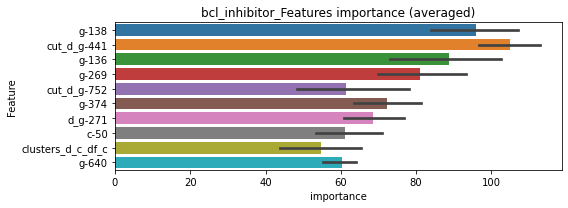

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169362	valid_1's binary_logloss: 0.0260197
[200]	training's binary_logloss: 0.00223371	valid_1's binary_logloss: 0.00893756
[300]	training's binary_logloss: 0.000638136	valid_1's binary_logloss: 0.00643833
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000377244	valid_1's binary_logloss: 0.00595467


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165777	valid_1's binary_logloss: 0.0288802
[200]	training's binary_logloss: 0.00216327	valid_1's binary_logloss: 0.0108353
[300]	training's binary_logloss: 0.000613945	valid_1's binary_logloss: 0.0080035
[400]	training's binary_logloss: 0.000307446	valid_1's binary_logloss: 0.00738738
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000247638	valid_1's binary_logloss: 0.00721163


bcl_inhibitor logloss: 0.006583070523972258


neg labels: 3289 → selected neg labels: 3283


bcr-abl_inhibitor, len(trt): 38, len(othr): 3283, target_rate: 0.0015957 → Adj_target_rate: 0.0018493
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307345	valid_1's binary_logloss: 0.0486045
[200]	training's binary_logloss: 0.00460365	valid_1's binary_logloss: 0.0155913
[300]	training's binary_logloss: 0.00132015	valid_1's binary_logloss: 0.00937156
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000905633	valid_1's binary_logloss: 0.0086699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292898	valid_1's binary_logloss: 0.0474129
[200]	training's binary_logloss: 0.00429467	valid_1's binary_logloss: 0.0169223
[300]	training's binary_logloss: 0.00123886	valid_1's binary_logloss: 0.0115735
[400]	training's binary_logloss: 0.000622533	valid_1's binary_logloss: 0.00996294
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000551306	valid_1's binary_logloss: 0.00984408


1 / 3 AUC score:1.000
y_Threshold: 0.0048244, Threshold: 0.0098545, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00160
Num_p_label: 80.0, conf_0:0.00887, conf_1:0.01084
Num_p_label: 80.0, Expected: 6.4, Adj_threshold_1: 0.0098545
Num_p_label: 34.0, Expected: 6.4, Adj_threshold_2: 0.0198545
Num_p_label: 26.0, Expected: 6.4, Adj_threshold_3: 0.0298545
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_4: 0.0398545
Num_p_label: 21.0, Expected: 6.4, Adj_threshold_5: 0.0498545
Num_p_label: 14.0, Expected: 6.4, Adj_threshold_6: 0.0598545
Num_p_label: 13.0, Expected: 6.4, Adj_threshold_7: 0.0698545
Num_p_label: 12.0, Expected: 6.4, Adj_threshold_8: 0.0798545
threshold: 0.0798545, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301632	valid_1's binary_logloss: 0.0446095
[200]	training's binary_logloss: 0.00430925	valid_1's binary_logloss: 0.0122946
[300]	training's binary_logloss: 0.0012424	valid_1's binary_logloss: 0.00684818
[400]	training's binary_logloss: 0.000625159	valid_1's binary_logloss: 0.00549112
[500]	training's binary_logloss: 0.000436295	valid_1's binary_logloss: 0.00493343
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000417338	valid_1's binary_logloss: 0.00490067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286777	valid_1's binary_logloss: 0.0469904
[200]	training's binary_logloss: 0.00401657	valid_1's binary_logloss: 0.0169151
[300]	training's binary_logloss: 0.00118228	valid_1's binary_logloss: 0.0122868
[400]	training's binary_logloss: 0.000601391	valid_1's binary_logloss: 0.0105772
Early stopping, best iteration is:
[45

2 / 3 AUC score:1.000
y_Threshold: 0.0370632, Threshold: 0.0798545, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0072828 Vs.target_rate: 0.00160
Num_p_label: 29.0, conf_0:0.07187, conf_1:0.08784
Num_p_label: 29.0, Expected: 6.4, Adj_threshold_1: 0.0798545
Num_p_label: 29.0, Expected: 6.4, Adj_threshold_2: 0.0898545
Num_p_label: 27.0, Expected: 6.4, Adj_threshold_3: 0.0998545
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_4: 0.1098545
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_5: 0.1198545
Num_p_label: 22.0, Expected: 6.4, Adj_threshold_6: 0.1298545
Num_p_label: 21.0, Expected: 6.4, Adj_threshold_7: 0.1398545
Num_p_label: 20.0, Expected: 6.4, Adj_threshold_8: 0.1498545
Num_p_label: 19.0, Expected: 6.4, Adj_threshold_9: 0.1598545
Num_p_label: 17.0, Expected: 6.4, Adj_threshold_10: 0.1698545
threshold: 0.1798545, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303295	valid_1's binary_logloss: 0.0450677
[200]	training's binary_logloss: 0.00434588	valid_1's binary_logloss: 0.0131586
[300]	training's binary_logloss: 0.00124435	valid_1's binary_logloss: 0.00751752
[400]	training's binary_logloss: 0.000619976	valid_1's binary_logloss: 0.0059943
[500]	training's binary_logloss: 0.000433525	valid_1's binary_logloss: 0.00541688
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000424788	valid_1's binary_logloss: 0.00540526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290629	valid_1's binary_logloss: 0.0486216
[200]	training's binary_logloss: 0.00408978	valid_1's binary_logloss: 0.0172559
[300]	training's binary_logloss: 0.00118306	valid_1's binary_logloss: 0.0113371
[400]	training's binary_logloss: 0.000604472	valid_1's binary_logloss: 0.00971707
Early stopping, best iteration is:
[4

3 / 3 AUC score:1.000
y_Threshold: 0.0507216, Threshold: 0.1798545, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0042692 Vs.target_rate: 0.00160
Num_p_label: 17.0, conf_0:0.16187, conf_1:0.19784
threshold: 0.1798545, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 670.0/7783, y_label_rate: 0.0860851


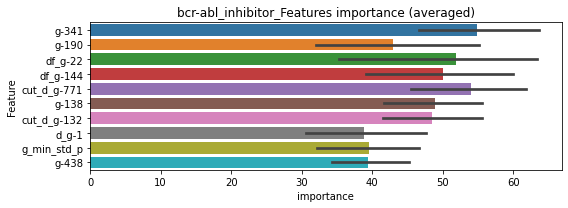

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015282	valid_1's binary_logloss: 0.0306286
[200]	training's binary_logloss: 0.00217425	valid_1's binary_logloss: 0.0144827
[300]	training's binary_logloss: 0.000620621	valid_1's binary_logloss: 0.0110909
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000345878	valid_1's binary_logloss: 0.0100516


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163159	valid_1's binary_logloss: 0.0266267
[200]	training's binary_logloss: 0.00228318	valid_1's binary_logloss: 0.00967391
[300]	training's binary_logloss: 0.00066186	valid_1's binary_logloss: 0.00680357
[400]	training's binary_logloss: 0.000334173	valid_1's binary_logloss: 0.00592584
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000245202	valid_1's binary_logloss: 0.00557929


bcr-abl_inhibitor logloss: 0.007815711112606667


neg labels: 3289 → selected neg labels: 3277


benzodiazepine_receptor_agonist, len(trt): 67, len(othr): 3277, target_rate: 0.0028135 → Adj_target_rate: 0.0029948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470436	valid_1's binary_logloss: 0.0930323
[200]	training's binary_logloss: 0.00906743	valid_1's binary_logloss: 0.0497614
[300]	training's binary_logloss: 0.00264041	valid_1's binary_logloss: 0.0396523
[400]	training's binary_logloss: 0.00121688	valid_1's binary_logloss: 0.0364317
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000946839	valid_1's binary_logloss: 0.0359279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0491261	valid_1's binary_logloss: 0.0944506
[200]	training's binary_logloss: 0.00935657	valid_1's binary_logloss: 0.044614
[300]	training's binary_logloss: 0.00271619	valid_1's binary_logloss: 0.0308147
[400]	training's binary_logloss: 0.00123834	valid_1's binary_logloss: 0.025985
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00122353	valid_1's binary_logloss: 0.0259824


1 / 3 AUC score:0.998
y_Threshold: 0.0080809, Threshold: 0.0109163, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3794
p_label_rate: 0.0200904 Vs.target_rate: 0.00281
Num_p_label: 80.0, conf_0:0.00982, conf_1:0.01201
Num_p_label: 80.0, Expected: 11.2, Adj_threshold_1: 0.0109163
Num_p_label: 19.0, Expected: 11.2, Adj_threshold_2: 0.0209163
threshold: 0.0209163, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 652.0/3794, y_label_rate: 0.1718503
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460452	valid_1's binary_logloss: 0.0881937
[200]	training's binary_logloss: 0.00829891	valid_1's binary_logloss: 0.0420758
[300]	training's binary_logloss: 0.00242965	valid_1's binary_logloss: 0.032593
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00152608	valid_1's binary_logloss: 0.030449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047707	valid_1's binary_logloss: 0.0911683
[200]	training's binary_logloss: 0.008787	valid_1's binary_logloss: 0.0452705
[300]	training's binary_logloss: 0.00254583	valid_1's binary_logloss: 0.0344521
[400]	training's binary_logloss: 0.00118759	valid_1's binary_logloss: 0.0316768
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00117424	valid_1's binary_logloss: 0.031673


2 / 3 AUC score:0.999
y_Threshold: 0.0443975, Threshold: 0.0209163, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 647.0/3784
p_label_rate: 0.0133099 Vs.target_rate: 0.00281
Num_p_label: 53.0, conf_0:0.01882, conf_1:0.02301
Num_p_label: 53.0, Expected: 11.2, Adj_threshold_1: 0.0209163
Num_p_label: 16.0, Expected: 11.2, Adj_threshold_2: 0.0309163
threshold: 0.0309163, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 647.0/3784, y_label_rate: 0.1709831
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457062	valid_1's binary_logloss: 0.0858164
[200]	training's binary_logloss: 0.00832943	valid_1's binary_logloss: 0.037249
[300]	training's binary_logloss: 0.00244471	valid_1's binary_logloss: 0.0249797
[400]	training's binary_logloss: 0.00116808	valid_1's binary_logloss: 0.0205609
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000843668	valid_1's binary_logloss: 0.0190727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475788	valid_1's binary_logloss: 0.0902644
[200]	training's binary_logloss: 0.00846965	valid_1's binary_logloss: 0.0460777
[300]	training's binary_logloss: 0.00245703	valid_1's binary_logloss: 0.0376059
[400]	training's binary_logloss: 0.0011673	valid_1's binary_logloss: 0.0356846
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0011673	valid_1's binary_logloss: 0.0356846


3 / 3 AUC score:0.999
y_Threshold: 0.0324368, Threshold: 0.0309163, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 644.0/3778
p_label_rate: 0.0042692 Vs.target_rate: 0.00281
Num_p_label: 17.0, conf_0:0.02782, conf_1:0.03401
threshold: 0.0309163, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 661.0/7760, y_label_rate: 0.0851804


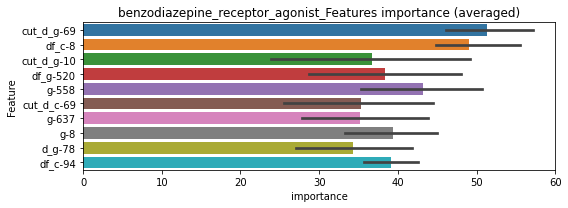

len(train_index) : 3880
len(valid_index) : 3880
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244878	valid_1's binary_logloss: 0.0569915
[200]	training's binary_logloss: 0.00439636	valid_1's binary_logloss: 0.0348148
[300]	training's binary_logloss: 0.00125146	valid_1's binary_logloss: 0.0309875
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000803978	valid_1's binary_logloss: 0.0302788


len(train_index) : 3880
len(valid_index) : 3880
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278564	valid_1's binary_logloss: 0.0549214
[200]	training's binary_logloss: 0.00539913	valid_1's binary_logloss: 0.0319711
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00189513	valid_1's binary_logloss: 0.0270938


benzodiazepine_receptor_agonist logloss: 0.028686317036395778


neg labels: 3289 → selected neg labels: 3285


beta_amyloid_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262696	valid_1's binary_logloss: 0.0442232
[200]	training's binary_logloss: 0.00334106	valid_1's binary_logloss: 0.0177582
[300]	training's binary_logloss: 0.000947923	valid_1's binary_logloss: 0.0133937
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000670218	valid_1's binary_logloss: 0.0125067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271177	valid_1's binary_logloss: 0.0389571
[200]	training's binary_logloss: 0.00357557	valid_1's binary_logloss: 0.0103109
[300]	training's binary_logloss: 0.00102094	valid_1's binary_logloss: 0.0063904
[400]	training's binary_logloss: 0.000515586	valid_1's binary_logloss: 0.00528233
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000427079	valid_1's binary_logloss: 0.00506955


1 / 3 AUC score:1.000
y_Threshold: 0.0023062, Threshold: 0.0040040, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00360, conf_1:0.00440
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0040040
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_2: 0.0140040
threshold: 0.0140040, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267998	valid_1's binary_logloss: 0.0432322
[200]	training's binary_logloss: 0.00333924	valid_1's binary_logloss: 0.0160893
[300]	training's binary_logloss: 0.000943955	valid_1's binary_logloss: 0.0123669
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000588803	valid_1's binary_logloss: 0.0115889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269458	valid_1's binary_logloss: 0.0375867
[200]	training's binary_logloss: 0.00352706	valid_1's binary_logloss: 0.00955013
[300]	training's binary_logloss: 0.000997127	valid_1's binary_logloss: 0.00597692
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000658984	valid_1's binary_logloss: 0.00513242


2 / 3 AUC score:1.000
y_Threshold: 0.0160059, Threshold: 0.0140040, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0040181 Vs.target_rate: 0.00101
Num_p_label: 16.0, conf_0:0.01260, conf_1:0.01540
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_1: 0.0140040
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_2: 0.0240040
threshold: 0.0240040, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259263	valid_1's binary_logloss: 0.0424543
[200]	training's binary_logloss: 0.00324698	valid_1's binary_logloss: 0.0148033
[300]	training's binary_logloss: 0.000939908	valid_1's binary_logloss: 0.0103232
[400]	training's binary_logloss: 0.000490508	valid_1's binary_logloss: 0.00909999
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000396142	valid_1's binary_logloss: 0.008769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281509	valid_1's binary_logloss: 0.0399541
[200]	training's binary_logloss: 0.00362696	valid_1's binary_logloss: 0.00889098
[300]	training's binary_logloss: 0.00102441	valid_1's binary_logloss: 0.00428072
[400]	training's binary_logloss: 0.000519414	valid_1's binary_logloss: 0.00304982
[500]	training's binary_logloss: 0.000388038	valid_1's binary_logloss: 0.00268096
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0190806, Threshold: 0.0240040, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0005023 Vs.target_rate: 0.00101
Num_p_label: 2.0, conf_0:0.02160, conf_1:0.02640
threshold: 0.0240040, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 658.0/7790, y_label_rate: 0.0844673


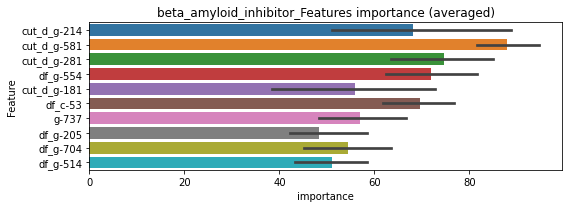

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013626	valid_1's binary_logloss: 0.0239223
[200]	training's binary_logloss: 0.00175778	valid_1's binary_logloss: 0.00794568
[300]	training's binary_logloss: 0.000491663	valid_1's binary_logloss: 0.00518593
[400]	training's binary_logloss: 0.000250597	valid_1's binary_logloss: 0.00439999
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000225498	valid_1's binary_logloss: 0.00430879


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150374	valid_1's binary_logloss: 0.0210307
[200]	training's binary_logloss: 0.00197109	valid_1's binary_logloss: 0.00639633
[300]	training's binary_logloss: 0.000525237	valid_1's binary_logloss: 0.00467757
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000444221	valid_1's binary_logloss: 0.00460293


beta_amyloid_inhibitor logloss: 0.004455859517153416


neg labels: 3289 → selected neg labels: 3276


bromodomain_inhibitor, len(trt): 68, len(othr): 3276, target_rate: 0.0028555 → Adj_target_rate: 0.0030327
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341672	valid_1's binary_logloss: 0.0700236
[200]	training's binary_logloss: 0.00539714	valid_1's binary_logloss: 0.0380937
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00200644	valid_1's binary_logloss: 0.0348877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341133	valid_1's binary_logloss: 0.0632576
[200]	training's binary_logloss: 0.00534142	valid_1's binary_logloss: 0.0262834
[300]	training's binary_logloss: 0.00156253	valid_1's binary_logloss: 0.0182275
[400]	training's binary_logloss: 0.000774782	valid_1's binary_logloss: 0.015875
[500]	training's binary_logloss: 0.000513185	valid_1's binary_logloss: 0.0148257
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000527779	valid_1's binary_logloss: 0.0147665


1 / 3 AUC score:0.999
y_Threshold: 0.0065584, Threshold: 0.0095558, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00286
Num_p_label: 80.0, conf_0:0.00860, conf_1:0.01051
Num_p_label: 80.0, Expected: 11.4, Adj_threshold_1: 0.0095558
Num_p_label: 25.0, Expected: 11.4, Adj_threshold_2: 0.0195558
Num_p_label: 14.0, Expected: 11.4, Adj_threshold_3: 0.0295558
threshold: 0.0295558, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 653.0/3795, y_label_rate: 0.1720685
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034065	valid_1's binary_logloss: 0.0650571
[200]	training's binary_logloss: 0.0051523	valid_1's binary_logloss: 0.0280638
[300]	training's binary_logloss: 0.00149007	valid_1's binary_logloss: 0.020236
[400]	training's binary_logloss: 0.000732927	valid_1's binary_logloss: 0.0180754
[500]	training's binary_logloss: 0.000492223	valid_1's binary_logloss: 0.0172141
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000506494	valid_1's binary_logloss: 0.0171615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337136	valid_1's binary_logloss: 0.064301
[200]	training's binary_logloss: 0.00503212	valid_1's binary_logloss: 0.0272391
[300]	training's binary_logloss: 0.00147914	valid_1's binary_logloss: 0.0194563
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000826893	valid_1's binary_logloss: 0.0179499


2 / 3 AUC score:1.000
y_Threshold: 0.0302825, Threshold: 0.0295558, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 650.0/3789
p_label_rate: 0.0052737 Vs.target_rate: 0.00286
Num_p_label: 21.0, conf_0:0.02660, conf_1:0.03251
threshold: 0.0295558, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 650.0/3789, y_label_rate: 0.1715492
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324767	valid_1's binary_logloss: 0.0683833
[200]	training's binary_logloss: 0.00498585	valid_1's binary_logloss: 0.034373
[300]	training's binary_logloss: 0.00144634	valid_1's binary_logloss: 0.0266841
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00102354	valid_1's binary_logloss: 0.0256887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033039	valid_1's binary_logloss: 0.0698891
[200]	training's binary_logloss: 0.00491364	valid_1's binary_logloss: 0.0381339
[300]	training's binary_logloss: 0.00142969	valid_1's binary_logloss: 0.0333812
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00154311	valid_1's binary_logloss: 0.0331036


3 / 3 AUC score:1.000
y_Threshold: 0.0207603, Threshold: 0.0295558, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 643.0/3775
p_label_rate: 0.0060271 Vs.target_rate: 0.00286
Num_p_label: 24.0, conf_0:0.02660, conf_1:0.03251
threshold: 0.0295558, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 667.0/7757, y_label_rate: 0.0859869


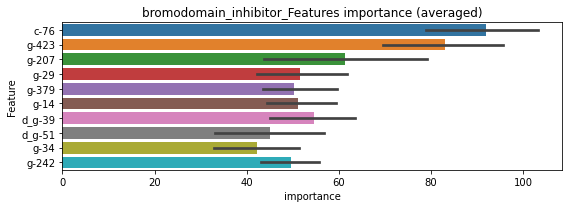

len(train_index) : 3878
len(valid_index) : 3879
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175948	valid_1's binary_logloss: 0.0446627
[200]	training's binary_logloss: 0.00268235	valid_1's binary_logloss: 0.0259714
[300]	training's binary_logloss: 0.000771536	valid_1's binary_logloss: 0.0225345
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000442014	valid_1's binary_logloss: 0.0218723


len(train_index) : 3879
len(valid_index) : 3878
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181975	valid_1's binary_logloss: 0.0372975
[200]	training's binary_logloss: 0.00285738	valid_1's binary_logloss: 0.0190095
[300]	training's binary_logloss: 0.00084371	valid_1's binary_logloss: 0.016079
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000608568	valid_1's binary_logloss: 0.0158019


bromodomain_inhibitor logloss: 0.018837475916241388


neg labels: 3289 → selected neg labels: 3284


btk_inhibitor, len(trt): 29, len(othr): 3284, target_rate: 0.0012178 → Adj_target_rate: 0.0014697
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264153	valid_1's binary_logloss: 0.0419584
[200]	training's binary_logloss: 0.00344593	valid_1's binary_logloss: 0.011534
[300]	training's binary_logloss: 0.000991946	valid_1's binary_logloss: 0.00648508
[400]	training's binary_logloss: 0.000516708	valid_1's binary_logloss: 0.00507837
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000382891	valid_1's binary_logloss: 0.00451988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256244	valid_1's binary_logloss: 0.0458618
[200]	training's binary_logloss: 0.00342126	valid_1's binary_logloss: 0.0198806
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00126006	valid_1's binary_logloss: 0.0159945


1 / 3 AUC score:1.000
y_Threshold: 0.0040280, Threshold: 0.0059594, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00122
Num_p_label: 80.0, conf_0:0.00536, conf_1:0.00656
Num_p_label: 80.0, Expected: 4.8, Adj_threshold_1: 0.0059594
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_2: 0.0159594
Num_p_label: 2.0, Expected: 4.8, Adj_threshold_3: 0.0259594
threshold: 0.0259594, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260784	valid_1's binary_logloss: 0.0398965
[200]	training's binary_logloss: 0.003378	valid_1's binary_logloss: 0.0109537
[300]	training's binary_logloss: 0.000970676	valid_1's binary_logloss: 0.00614646
[400]	training's binary_logloss: 0.000500998	valid_1's binary_logloss: 0.00471356
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000377076	valid_1's binary_logloss: 0.00428331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026132	valid_1's binary_logloss: 0.044838
[200]	training's binary_logloss: 0.00340306	valid_1's binary_logloss: 0.0193461
[300]	training's binary_logloss: 0.00097619	valid_1's binary_logloss: 0.0146004
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000772151	valid_1's binary_logloss: 0.0140199


2 / 3 AUC score:1.000
y_Threshold: 0.0261642, Threshold: 0.0259594, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0035158 Vs.target_rate: 0.00122
Num_p_label: 14.0, conf_0:0.02336, conf_1:0.02856
threshold: 0.0259594, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260048	valid_1's binary_logloss: 0.0379849
[200]	training's binary_logloss: 0.00332644	valid_1's binary_logloss: 0.00960516
[300]	training's binary_logloss: 0.000974574	valid_1's binary_logloss: 0.00519394
[400]	training's binary_logloss: 0.00051181	valid_1's binary_logloss: 0.00405963
[500]	training's binary_logloss: 0.000376141	valid_1's binary_logloss: 0.00366124
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000381435	valid_1's binary_logloss: 0.00364606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261567	valid_1's binary_logloss: 0.042493
[200]	training's binary_logloss: 0.00340499	valid_1's binary_logloss: 0.012577
[300]	training's binary_logloss: 0.000977572	valid_1's binary_logloss: 0.00737497
[400]	training's binary_logloss: 0.00050677	valid_1's binary_logloss: 0.00588612
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0534126, Threshold: 0.0259594, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0027624 Vs.target_rate: 0.00122
Num_p_label: 11.0, conf_0:0.02336, conf_1:0.02856
threshold: 0.0259594, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 665.0/7786, y_label_rate: 0.0854097


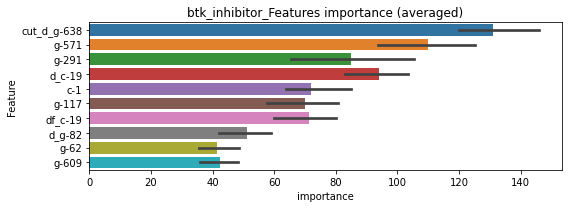

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135505	valid_1's binary_logloss: 0.0281562
[200]	training's binary_logloss: 0.00168886	valid_1's binary_logloss: 0.0141523
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000652298	valid_1's binary_logloss: 0.0131134


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147418	valid_1's binary_logloss: 0.023748
[200]	training's binary_logloss: 0.00189217	valid_1's binary_logloss: 0.00886243
[300]	training's binary_logloss: 0.000546401	valid_1's binary_logloss: 0.0067376
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000327548	valid_1's binary_logloss: 0.00639012


btk_inhibitor logloss: 0.00975174784372765


neg labels: 3289 → selected neg labels: 3287


calcineurin_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182893	valid_1's binary_logloss: 0.0236502
[200]	training's binary_logloss: 0.00181545	valid_1's binary_logloss: 0.00398199
[300]	training's binary_logloss: 0.000500872	valid_1's binary_logloss: 0.0016846
[400]	training's binary_logloss: 0.00028176	valid_1's binary_logloss: 0.00118429
[500]	training's binary_logloss: 0.000244808	valid_1's binary_logloss: 0.00112377
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000242214	valid_1's binary_logloss: 0.00112036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185415	valid_1's binary_logloss: 0.0211687
[200]	training's binary_logloss: 0.00183954	valid_1's binary_logloss: 0.0025764
[300]	training's binary_logloss: 0.000507239	valid_1's binary_logloss: 0.000857416
[400]	training's binary_logloss: 0.00028345	valid_1's binary_logloss: 0.000544342
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0007582, Threshold: 0.0013191, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00119, conf_1:0.00145
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0013191
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_2: 0.0113191
threshold: 0.0113191, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186663	valid_1's binary_logloss: 0.0224872
[200]	training's binary_logloss: 0.0017919	valid_1's binary_logloss: 0.00341879
[300]	training's binary_logloss: 0.000492113	valid_1's binary_logloss: 0.00140483
[400]	training's binary_logloss: 0.000283263	valid_1's binary_logloss: 0.0010487
[500]	training's binary_logloss: 0.000242146	valid_1's binary_logloss: 0.000970241
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000241065	valid_1's binary_logloss: 0.000967327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019014	valid_1's binary_logloss: 0.0216609
[200]	training's binary_logloss: 0.00185583	valid_1's binary_logloss: 0.00261583
[300]	training's binary_logloss: 0.000506488	valid_1's binary_logloss: 0.000875181
[400]	training's binary_logloss: 0.000282999	valid_1's binary_logloss: 0.000568741
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1157568, Threshold: 0.0113191, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0022602 Vs.target_rate: 0.00050
Num_p_label: 9.0, conf_0:0.01019, conf_1:0.01245
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_1: 0.0113191
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_2: 0.0213191
threshold: 0.0213191, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186663	valid_1's binary_logloss: 0.0224872
[200]	training's binary_logloss: 0.0017919	valid_1's binary_logloss: 0.00341879
[300]	training's binary_logloss: 0.000492113	valid_1's binary_logloss: 0.00140483
[400]	training's binary_logloss: 0.000283263	valid_1's binary_logloss: 0.0010487
[500]	training's binary_logloss: 0.000242146	valid_1's binary_logloss: 0.000970241
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000241065	valid_1's binary_logloss: 0.000967327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019014	valid_1's binary_logloss: 0.0216609
[200]	training's binary_logloss: 0.00185583	valid_1's binary_logloss: 0.00261583
[300]	training's binary_logloss: 0.000506488	valid_1's binary_logloss: 0.000875181
[400]	training's binary_logloss: 0.000282999	valid_1's binary_logloss: 0.000568741
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1157568, Threshold: 0.0213191, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050
Num_p_label: 4.0, conf_0:0.01919, conf_1:0.02345
threshold: 0.0213191, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


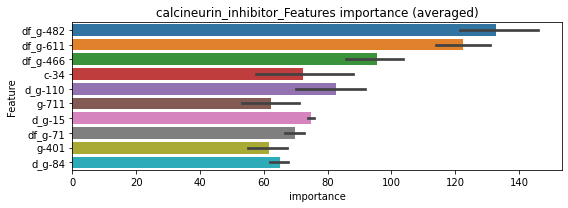

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00967623	valid_1's binary_logloss: 0.0155589
[200]	training's binary_logloss: 0.000924116	valid_1's binary_logloss: 0.00599155
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.000393246	valid_1's binary_logloss: 0.00534893


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00999605	valid_1's binary_logloss: 0.0131132
[200]	training's binary_logloss: 0.000985013	valid_1's binary_logloss: 0.00360577
[300]	training's binary_logloss: 0.000266172	valid_1's binary_logloss: 0.00267075
[400]	training's binary_logloss: 0.000146568	valid_1's binary_logloss: 0.00246003
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000143344	valid_1's binary_logloss: 0.00245312


calcineurin_inhibitor logloss: 0.0039010263014553127


neg labels: 3289 → selected neg labels: 3243


calcium_channel_blocker, len(trt): 281, len(othr): 3243, target_rate: 0.0117998 → Adj_target_rate: 0.0101297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0974066	valid_1's binary_logloss: 0.275466
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0392864	valid_1's binary_logloss: 0.257912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102111	valid_1's binary_logloss: 0.264436
[200]	training's binary_logloss: 0.035153	valid_1's binary_logloss: 0.237448
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0334869	valid_1's binary_logloss: 0.236971


1 / 3 AUC score:0.900
y_Threshold: 0.0812911, Threshold: 0.1059683, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 421 → Positive_corect_labels: 503/3470
p_label_rate: 0.0200904 Vs.target_rate: 0.01180
Num_p_label: 80.0, conf_0:0.09537, conf_1:0.11657
threshold: 0.1059683, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 503.0/3470, y_label_rate: 0.1449568
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0666997	valid_1's binary_logloss: 0.203528
[200]	training's binary_logloss: 0.0185621	valid_1's binary_logloss: 0.174116
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0149785	valid_1's binary_logloss: 0.172817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717075	valid_1's binary_logloss: 0.185669
[200]	training's binary_logloss: 0.020874	valid_1's binary_logloss: 0.156862
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0228126	valid_1's binary_logloss: 0.15652


2 / 3 AUC score:0.969
y_Threshold: 0.0679984, Threshold: 0.1059683, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 120 → Positive_corect_labels: 443.0/3350
p_label_rate: 0.0012557 Vs.target_rate: 0.01180
Num_p_label: 5.0, conf_0:0.09537, conf_1:0.11657
Num_p_label: 5.0, Expected: 47.0, Adj_threshold_1: 0.1059683
Num_p_label: 17.0, Expected: 47.0, Adj_threshold_2: 0.0959683
Num_p_label: 29.0, Expected: 47.0, Adj_threshold_3: 0.0859683
threshold: 0.0859683, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 443.0/3350, y_label_rate: 0.1322388
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534757	valid_1's binary_logloss: 0.167831
[200]	training's binary_logloss: 0.0129475	valid_1's binary_logloss: 0.143927
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00696618	valid_1's binary_logloss: 0.139619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557079	valid_1's binary_logloss: 0.165592
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0163353	valid_1's binary_logloss: 0.14986


3 / 3 AUC score:0.977
y_Threshold: 0.0533473, Threshold: 0.0859683, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 84 → Positive_corect_labels: 401.0/3266
p_label_rate: 0.0015068 Vs.target_rate: 0.01180
Num_p_label: 6.0, conf_0:0.07737, conf_1:0.09457
Num_p_label: 6.0, Expected: 47.0, Adj_threshold_1: 0.0859683
Num_p_label: 17.0, Expected: 47.0, Adj_threshold_2: 0.0759683
Num_p_label: 34.0, Expected: 47.0, Adj_threshold_3: 0.0659683
threshold: 0.0659683, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 435.0/7248, y_label_rate: 0.0600166


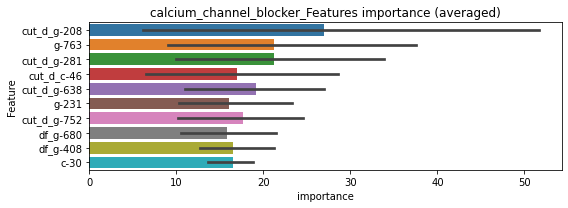

len(train_index) : 3624
len(valid_index) : 3624
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250325	valid_1's binary_logloss: 0.0909762
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0106028	valid_1's binary_logloss: 0.0848702


len(train_index) : 3624
len(valid_index) : 3624
================================= fold 2/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027697	valid_1's binary_logloss: 0.0864265
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0101315	valid_1's binary_logloss: 0.0770368


calcium_channel_blocker logloss: 0.08095349436630622


neg labels: 3289 → selected neg labels: 3282


cannabinoid_receptor_agonist, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339226	valid_1's binary_logloss: 0.0703496
[200]	training's binary_logloss: 0.00550251	valid_1's binary_logloss: 0.0342027
[300]	training's binary_logloss: 0.00151047	valid_1's binary_logloss: 0.0270976
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0011241	valid_1's binary_logloss: 0.026044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350367	valid_1's binary_logloss: 0.0593989
[200]	training's binary_logloss: 0.00583254	valid_1's binary_logloss: 0.0219398
[300]	training's binary_logloss: 0.0016535	valid_1's binary_logloss: 0.014491
[400]	training's binary_logloss: 0.000811225	valid_1's binary_logloss: 0.0121646
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000581688	valid_1's binary_logloss: 0.0114338


1 / 3 AUC score:1.000
y_Threshold: 0.0041814, Threshold: 0.0047351, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176
Num_p_label: 80.0, conf_0:0.00426, conf_1:0.00521
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0047351
Num_p_label: 6.0, Expected: 7.0, Adj_threshold_2: 0.0147351
threshold: 0.0147351, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033585	valid_1's binary_logloss: 0.0687495
[200]	training's binary_logloss: 0.00530437	valid_1's binary_logloss: 0.0332908
[300]	training's binary_logloss: 0.00151334	valid_1's binary_logloss: 0.0252321
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000911785	valid_1's binary_logloss: 0.0239468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034604	valid_1's binary_logloss: 0.0600184
[200]	training's binary_logloss: 0.00559496	valid_1's binary_logloss: 0.0218114
[300]	training's binary_logloss: 0.0016096	valid_1's binary_logloss: 0.0142431
[400]	training's binary_logloss: 0.000801991	valid_1's binary_logloss: 0.0120764
[500]	training's binary_logloss: 0.000530824	valid_1's binary_logloss: 0.0109581
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000485301	valid_1's binary_logloss: 0.0107928


2 / 3 AUC score:1.000
y_Threshold: 0.0136692, Threshold: 0.0147351, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3800
p_label_rate: 0.0032647 Vs.target_rate: 0.00176
Num_p_label: 13.0, conf_0:0.01326, conf_1:0.01621
threshold: 0.0147351, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 653.0/3800, y_label_rate: 0.1718421
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332494	valid_1's binary_logloss: 0.0625049
[200]	training's binary_logloss: 0.00513104	valid_1's binary_logloss: 0.0260401
[300]	training's binary_logloss: 0.00147568	valid_1's binary_logloss: 0.0186416
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00102478	valid_1's binary_logloss: 0.0174028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354847	valid_1's binary_logloss: 0.0573901
[200]	training's binary_logloss: 0.00562745	valid_1's binary_logloss: 0.0224822
[300]	training's binary_logloss: 0.00164505	valid_1's binary_logloss: 0.0162215
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00126836	valid_1's binary_logloss: 0.01554


3 / 3 AUC score:1.000
y_Threshold: 0.0314395, Threshold: 0.0147351, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 651.0/3796
p_label_rate: 0.0085384 Vs.target_rate: 0.00176
Num_p_label: 34.0, conf_0:0.01326, conf_1:0.01621
Num_p_label: 34.0, Expected: 7.0, Adj_threshold_1: 0.0147351
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_2: 0.0247351
threshold: 0.0247351, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 661.0/7778, y_label_rate: 0.0849833


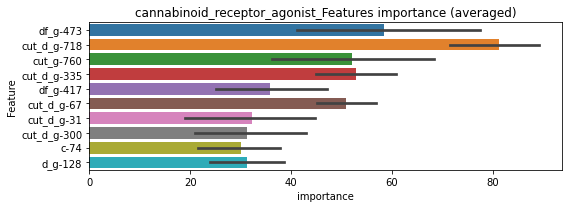

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175538	valid_1's binary_logloss: 0.0431194
[200]	training's binary_logloss: 0.00263617	valid_1's binary_logloss: 0.0242871
[300]	training's binary_logloss: 0.000749718	valid_1's binary_logloss: 0.0205879
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000574396	valid_1's binary_logloss: 0.0201999


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019678	valid_1's binary_logloss: 0.033726
[200]	training's binary_logloss: 0.00311544	valid_1's binary_logloss: 0.0128927
[300]	training's binary_logloss: 0.000861598	valid_1's binary_logloss: 0.00887817
[400]	training's binary_logloss: 0.000410933	valid_1's binary_logloss: 0.00799071
[500]	training's binary_logloss: 0.000269275	valid_1's binary_logloss: 0.00765769
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000264813	valid_1's binary_logloss: 0.00765261


cannabinoid_receptor_agonist logloss: 0.013926269465307105


neg labels: 3289 → selected neg labels: 3280


cannabinoid_receptor_antagonist, len(trt): 55, len(othr): 3280, target_rate: 0.0023096 → Adj_target_rate: 0.0025322
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411387	valid_1's binary_logloss: 0.0767331
[200]	training's binary_logloss: 0.0071589	valid_1's binary_logloss: 0.0339898
[300]	training's binary_logloss: 0.00205111	valid_1's binary_logloss: 0.0245786
[400]	training's binary_logloss: 0.000989108	valid_1's binary_logloss: 0.0221081
[500]	training's binary_logloss: 0.000634374	valid_1's binary_logloss: 0.0205887
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.000541424	valid_1's binary_logloss: 0.0204576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458811	valid_1's binary_logloss: 0.0760248
[200]	training's binary_logloss: 0.00835201	valid_1's binary_logloss: 0.0309656
[300]	training's binary_logloss: 0.0023866	valid_1's binary_logloss: 0.0210157
[400]	training's binary_logloss: 0.00110119	valid_1's binary_logloss: 0.0175549
Early stopping, best iteration is:
[465]	tra

1 / 3 AUC score:1.000
y_Threshold: 0.0045519, Threshold: 0.0062741, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00231
Num_p_label: 80.0, conf_0:0.00565, conf_1:0.00690
Num_p_label: 80.0, Expected: 9.2, Adj_threshold_1: 0.0062741
Num_p_label: 10.0, Expected: 9.2, Adj_threshold_2: 0.0162741
threshold: 0.0162741, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425936	valid_1's binary_logloss: 0.0714354
[200]	training's binary_logloss: 0.00752026	valid_1's binary_logloss: 0.0285266
[300]	training's binary_logloss: 0.00216592	valid_1's binary_logloss: 0.0193974
[400]	training's binary_logloss: 0.00103681	valid_1's binary_logloss: 0.0163348
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000761707	valid_1's binary_logloss: 0.0153271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435905	valid_1's binary_logloss: 0.0865226
[200]	training's binary_logloss: 0.00727684	valid_1's binary_logloss: 0.0424738
[300]	training's binary_logloss: 0.00210111	valid_1's binary_logloss: 0.0342932
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00110454	valid_1's binary_logloss: 0.0319048


2 / 3 AUC score:1.000
y_Threshold: 0.0237091, Threshold: 0.0162741, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 652.0/3796
p_label_rate: 0.0087896 Vs.target_rate: 0.00231
Num_p_label: 35.0, conf_0:0.01465, conf_1:0.01790
Num_p_label: 35.0, Expected: 9.2, Adj_threshold_1: 0.0162741
Num_p_label: 11.0, Expected: 9.2, Adj_threshold_2: 0.0262741
threshold: 0.0262741, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424668	valid_1's binary_logloss: 0.0831792
[200]	training's binary_logloss: 0.00752214	valid_1's binary_logloss: 0.0363672
[300]	training's binary_logloss: 0.00214624	valid_1's binary_logloss: 0.026069
[400]	training's binary_logloss: 0.00101367	valid_1's binary_logloss: 0.0227691
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000985656	valid_1's binary_logloss: 0.0226292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431077	valid_1's binary_logloss: 0.0811399
[200]	training's binary_logloss: 0.00732307	valid_1's binary_logloss: 0.0361531
[300]	training's binary_logloss: 0.00206014	valid_1's binary_logloss: 0.0262348
[400]	training's binary_logloss: 0.000990408	valid_1's binary_logloss: 0.0239715
[500]	training's binary_logloss: 0.00063608	valid_1's binary_logloss: 0.0228386
Early stopping, best iteration is:
[545]	tra

3 / 3 AUC score:1.000
y_Threshold: 0.0197659, Threshold: 0.0262741, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 649.0/3790
p_label_rate: 0.0025113 Vs.target_rate: 0.00231
Num_p_label: 10.0, conf_0:0.02365, conf_1:0.02890
threshold: 0.0262741, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 659.0/7772, y_label_rate: 0.0847916


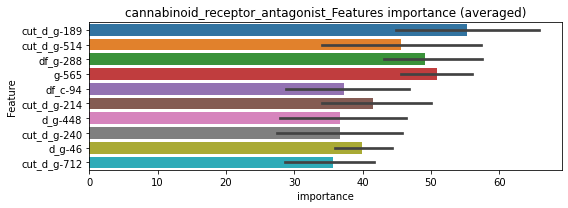

len(train_index) : 3886
len(valid_index) : 3886
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237277	valid_1's binary_logloss: 0.0477227
[200]	training's binary_logloss: 0.00409719	valid_1's binary_logloss: 0.0241546
[300]	training's binary_logloss: 0.00113419	valid_1's binary_logloss: 0.0194963
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000819566	valid_1's binary_logloss: 0.0188956


len(train_index) : 3886
len(valid_index) : 3886
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233449	valid_1's binary_logloss: 0.041826
[200]	training's binary_logloss: 0.00421578	valid_1's binary_logloss: 0.0165977
[300]	training's binary_logloss: 0.00116958	valid_1's binary_logloss: 0.0108569
[400]	training's binary_logloss: 0.000526368	valid_1's binary_logloss: 0.00920074
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000383523	valid_1's binary_logloss: 0.00877992


cannabinoid_receptor_antagonist logloss: 0.013837746721239939


neg labels: 3289 → selected neg labels: 3283


carbonic_anhydrase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308687	valid_1's binary_logloss: 0.0563871
[200]	training's binary_logloss: 0.00450355	valid_1's binary_logloss: 0.0229379
[300]	training's binary_logloss: 0.00131997	valid_1's binary_logloss: 0.0166424
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000902238	valid_1's binary_logloss: 0.0157871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338658	valid_1's binary_logloss: 0.0496304
[200]	training's binary_logloss: 0.00539313	valid_1's binary_logloss: 0.0159585
[300]	training's binary_logloss: 0.00154496	valid_1's binary_logloss: 0.009134
[400]	training's binary_logloss: 0.000757902	valid_1's binary_logloss: 0.00740944
[500]	training's binary_logloss: 0.000498371	valid_1's binary_logloss: 0.00695579
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000459703	valid_1's binary_logloss: 0.00682693


1 / 3 AUC score:1.000
y_Threshold: 0.0029599, Threshold: 0.0034773, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00313, conf_1:0.00383
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0034773
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_2: 0.0134773
threshold: 0.0134773, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319679	valid_1's binary_logloss: 0.0582653
[200]	training's binary_logloss: 0.00475544	valid_1's binary_logloss: 0.0207131
[300]	training's binary_logloss: 0.00136754	valid_1's binary_logloss: 0.0140673
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00106309	valid_1's binary_logloss: 0.0133896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337713	valid_1's binary_logloss: 0.0491975
[200]	training's binary_logloss: 0.00525782	valid_1's binary_logloss: 0.015311
[300]	training's binary_logloss: 0.00150415	valid_1's binary_logloss: 0.00892929
[400]	training's binary_logloss: 0.000741236	valid_1's binary_logloss: 0.00736794
[500]	training's binary_logloss: 0.000489608	valid_1's binary_logloss: 0.00663642
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00047797	valid_1's binary_logloss: 0.00659653


2 / 3 AUC score:1.000
y_Threshold: 0.0110984, Threshold: 0.0134773, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0027624 Vs.target_rate: 0.00151
Num_p_label: 11.0, conf_0:0.01213, conf_1:0.01483
threshold: 0.0134773, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319679	valid_1's binary_logloss: 0.0582653
[200]	training's binary_logloss: 0.00475544	valid_1's binary_logloss: 0.0207131
[300]	training's binary_logloss: 0.00136754	valid_1's binary_logloss: 0.0140673
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00106309	valid_1's binary_logloss: 0.0133896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337713	valid_1's binary_logloss: 0.0491975
[200]	training's binary_logloss: 0.00525782	valid_1's binary_logloss: 0.015311
[300]	training's binary_logloss: 0.00150415	valid_1's binary_logloss: 0.00892929
[400]	training's binary_logloss: 0.000741236	valid_1's binary_logloss: 0.00736794
[500]	training's binary_logloss: 0.000489608	valid_1's binary_logloss: 0.00663642
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00047797	valid_1's binary_logloss: 0.00659653


3 / 3 AUC score:1.000
y_Threshold: 0.0110984, Threshold: 0.0134773, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0027624 Vs.target_rate: 0.00151
Num_p_label: 11.0, conf_0:0.01213, conf_1:0.01483
threshold: 0.0134773, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7789, y_label_rate: 0.0856336


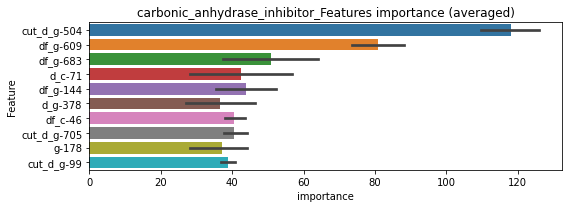

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172327	valid_1's binary_logloss: 0.0355109
[200]	training's binary_logloss: 0.00258482	valid_1's binary_logloss: 0.0187371
[300]	training's binary_logloss: 0.000736672	valid_1's binary_logloss: 0.0166846
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000677657	valid_1's binary_logloss: 0.0166018


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019381	valid_1's binary_logloss: 0.0339754
[200]	training's binary_logloss: 0.00297536	valid_1's binary_logloss: 0.0144886
[300]	training's binary_logloss: 0.000827823	valid_1's binary_logloss: 0.010663
[400]	training's binary_logloss: 0.000399075	valid_1's binary_logloss: 0.0099236
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000327142	valid_1's binary_logloss: 0.00973914


carbonic_anhydrase_inhibitor logloss: 0.013170904903550119


neg labels: 3289 → selected neg labels: 3283


casein_kinase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300425	valid_1's binary_logloss: 0.0491098
[200]	training's binary_logloss: 0.00431714	valid_1's binary_logloss: 0.0163474
[300]	training's binary_logloss: 0.00124955	valid_1's binary_logloss: 0.010559
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000735332	valid_1's binary_logloss: 0.00937317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302776	valid_1's binary_logloss: 0.0459759
[200]	training's binary_logloss: 0.0045107	valid_1's binary_logloss: 0.013168
[300]	training's binary_logloss: 0.00129373	valid_1's binary_logloss: 0.00681181
[400]	training's binary_logloss: 0.000653013	valid_1's binary_logloss: 0.00518198
[500]	training's binary_logloss: 0.000449926	valid_1's binary_logloss: 0.00452754
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000414702	valid_1's binary_logloss: 0.00442275


1 / 3 AUC score:1.000
y_Threshold: 0.0026362, Threshold: 0.0040267, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00362, conf_1:0.00443
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0040267
Num_p_label: 1.0, Expected: 6.0, Adj_threshold_2: 0.0140267
threshold: 0.0140267, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297821	valid_1's binary_logloss: 0.0470449
[200]	training's binary_logloss: 0.00427453	valid_1's binary_logloss: 0.0154837
[300]	training's binary_logloss: 0.00125306	valid_1's binary_logloss: 0.00943591
[400]	training's binary_logloss: 0.000638303	valid_1's binary_logloss: 0.00789672
[500]	training's binary_logloss: 0.000436847	valid_1's binary_logloss: 0.00721808
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000446311	valid_1's binary_logloss: 0.00720515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305708	valid_1's binary_logloss: 0.0485981
[200]	training's binary_logloss: 0.00447641	valid_1's binary_logloss: 0.0145455
[300]	training's binary_logloss: 0.00130143	valid_1's binary_logloss: 0.00860604
[400]	training's binary_logloss: 0.000654448	valid_1's binary_logloss: 0.00669834
Early stopping, best iteration is:


2 / 3 AUC score:1.000
y_Threshold: 0.0172881, Threshold: 0.0140267, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0037670 Vs.target_rate: 0.00151
Num_p_label: 15.0, conf_0:0.01262, conf_1:0.01543
threshold: 0.0140267, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297821	valid_1's binary_logloss: 0.0470449
[200]	training's binary_logloss: 0.00427453	valid_1's binary_logloss: 0.0154837
[300]	training's binary_logloss: 0.00125306	valid_1's binary_logloss: 0.00943591
[400]	training's binary_logloss: 0.000638303	valid_1's binary_logloss: 0.00789672
[500]	training's binary_logloss: 0.000436847	valid_1's binary_logloss: 0.00721808
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000446311	valid_1's binary_logloss: 0.00720515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305708	valid_1's binary_logloss: 0.0485981
[200]	training's binary_logloss: 0.00447641	valid_1's binary_logloss: 0.0145455
[300]	training's binary_logloss: 0.00130143	valid_1's binary_logloss: 0.00860604
[400]	training's binary_logloss: 0.000654448	valid_1's binary_logloss: 0.00669834
Early stopping, best iteration is:


3 / 3 AUC score:1.000
y_Threshold: 0.0172881, Threshold: 0.0140267, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0037670 Vs.target_rate: 0.00151
Num_p_label: 15.0, conf_0:0.01262, conf_1:0.01543
threshold: 0.0140267, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 671.0/7789, y_label_rate: 0.0861471


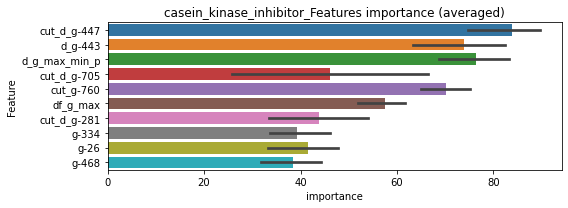

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160551	valid_1's binary_logloss: 0.0379908
[200]	training's binary_logloss: 0.00242063	valid_1's binary_logloss: 0.0220031
[300]	training's binary_logloss: 0.000691147	valid_1's binary_logloss: 0.0194497
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000669825	valid_1's binary_logloss: 0.0194411


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016375	valid_1's binary_logloss: 0.0298206
[200]	training's binary_logloss: 0.00243005	valid_1's binary_logloss: 0.0126637
[300]	training's binary_logloss: 0.000719451	valid_1's binary_logloss: 0.00984041
[400]	training's binary_logloss: 0.000363062	valid_1's binary_logloss: 0.00922002
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000274172	valid_1's binary_logloss: 0.00906606


casein_kinase_inhibitor logloss: 0.01425425531995405


neg labels: 3289 → selected neg labels: 3287


caspase_activator, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224419	valid_1's binary_logloss: 0.034166
[200]	training's binary_logloss: 0.0026058	valid_1's binary_logloss: 0.0107732
[300]	training's binary_logloss: 0.000741189	valid_1's binary_logloss: 0.0072167
[400]	training's binary_logloss: 0.000391411	valid_1's binary_logloss: 0.00593363
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000329353	valid_1's binary_logloss: 0.00562541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229898	valid_1's binary_logloss: 0.0302647
[200]	training's binary_logloss: 0.0026705	valid_1's binary_logloss: 0.00542838
[300]	training's binary_logloss: 0.000753493	valid_1's binary_logloss: 0.00241211
[400]	training's binary_logloss: 0.000395347	valid_1's binary_logloss: 0.00169885
[500]	training's binary_logloss: 0.000312409	valid_1's binary_logloss: 0.00151431
Early stopping, best iteration is:
[

1 / 3 AUC score:1.000
y_Threshold: 0.0013146, Threshold: 0.0016888, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00152, conf_1:0.00186
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0016888
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_2: 0.0116888
threshold: 0.0116888, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227587	valid_1's binary_logloss: 0.0362757
[200]	training's binary_logloss: 0.00260607	valid_1's binary_logloss: 0.0106347
[300]	training's binary_logloss: 0.000749055	valid_1's binary_logloss: 0.00694708
[400]	training's binary_logloss: 0.000392839	valid_1's binary_logloss: 0.00569499
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000331768	valid_1's binary_logloss: 0.00551761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234046	valid_1's binary_logloss: 0.0311745
[200]	training's binary_logloss: 0.00270935	valid_1's binary_logloss: 0.00536332
[300]	training's binary_logloss: 0.000767371	valid_1's binary_logloss: 0.00214559
[400]	training's binary_logloss: 0.000400844	valid_1's binary_logloss: 0.00136404
[500]	training's binary_logloss: 0.000317997	valid_1's binary_logloss: 0.00118583
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.0487426, Threshold: 0.0116888, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.01052, conf_1:0.01286
threshold: 0.0116888, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227587	valid_1's binary_logloss: 0.0362757
[200]	training's binary_logloss: 0.00260607	valid_1's binary_logloss: 0.0106347
[300]	training's binary_logloss: 0.000749055	valid_1's binary_logloss: 0.00694708
[400]	training's binary_logloss: 0.000392839	valid_1's binary_logloss: 0.00569499
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000331768	valid_1's binary_logloss: 0.00551761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234046	valid_1's binary_logloss: 0.0311745
[200]	training's binary_logloss: 0.00270935	valid_1's binary_logloss: 0.00536332
[300]	training's binary_logloss: 0.000767371	valid_1's binary_logloss: 0.00214559
[400]	training's binary_logloss: 0.000400844	valid_1's binary_logloss: 0.00136404
[500]	training's binary_logloss: 0.000317997	valid_1's binary_logloss: 0.00118583
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.0487426, Threshold: 0.0116888, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.01052, conf_1:0.01286
threshold: 0.0116888, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7794, y_label_rate: 0.0850654


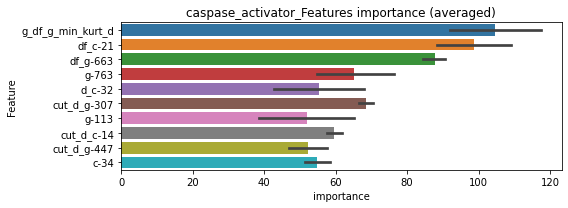

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117546	valid_1's binary_logloss: 0.0221832
[200]	training's binary_logloss: 0.00134071	valid_1's binary_logloss: 0.0116464
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.000442768	valid_1's binary_logloss: 0.0110735


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121933	valid_1's binary_logloss: 0.017225
[200]	training's binary_logloss: 0.00143684	valid_1's binary_logloss: 0.00480899
[300]	training's binary_logloss: 0.000403294	valid_1's binary_logloss: 0.00341367
[400]	training's binary_logloss: 0.000205712	valid_1's binary_logloss: 0.00299315
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000169505	valid_1's binary_logloss: 0.0029174


caspase_activator logloss: 0.006995441621901522


neg labels: 3289 → selected neg labels: 3286


catechol_o_methyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218669	valid_1's binary_logloss: 0.0320918
[200]	training's binary_logloss: 0.00252505	valid_1's binary_logloss: 0.00849894
[300]	training's binary_logloss: 0.000724718	valid_1's binary_logloss: 0.00495943
[400]	training's binary_logloss: 0.000385731	valid_1's binary_logloss: 0.0041199
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000311361	valid_1's binary_logloss: 0.00390575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230562	valid_1's binary_logloss: 0.0289347
[200]	training's binary_logloss: 0.00265939	valid_1's binary_logloss: 0.00580995
[300]	training's binary_logloss: 0.000753409	valid_1's binary_logloss: 0.00345553
[400]	training's binary_logloss: 0.000401621	valid_1's binary_logloss: 0.0027626
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000385885	valid_1's binary_logloss: 0.0027278

1 / 3 AUC score:1.000
y_Threshold: 0.0013559, Threshold: 0.0016474, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00148, conf_1:0.00181
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0016474
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_2: 0.0116474
threshold: 0.0116474, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220072	valid_1's binary_logloss: 0.0319906
[200]	training's binary_logloss: 0.00249557	valid_1's binary_logloss: 0.00888998
[300]	training's binary_logloss: 0.000721724	valid_1's binary_logloss: 0.0053606
[400]	training's binary_logloss: 0.000385439	valid_1's binary_logloss: 0.00441244
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000323957	valid_1's binary_logloss: 0.00422958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023076	valid_1's binary_logloss: 0.0283429
[200]	training's binary_logloss: 0.00265635	valid_1's binary_logloss: 0.00560358
[300]	training's binary_logloss: 0.000753153	valid_1's binary_logloss: 0.00317423
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000481778	valid_1's binary_logloss: 0.00271764


2 / 3 AUC score:1.000
y_Threshold: 0.0183558, Threshold: 0.0116474, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076
Num_p_label: 5.0, conf_0:0.01048, conf_1:0.01281
threshold: 0.0116474, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220072	valid_1's binary_logloss: 0.0319906
[200]	training's binary_logloss: 0.00249557	valid_1's binary_logloss: 0.00888998
[300]	training's binary_logloss: 0.000721724	valid_1's binary_logloss: 0.0053606
[400]	training's binary_logloss: 0.000385439	valid_1's binary_logloss: 0.00441244
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000323957	valid_1's binary_logloss: 0.00422958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023076	valid_1's binary_logloss: 0.0283429
[200]	training's binary_logloss: 0.00265635	valid_1's binary_logloss: 0.00560358
[300]	training's binary_logloss: 0.000753153	valid_1's binary_logloss: 0.00317423
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000481778	valid_1's binary_logloss: 0.00271764


3 / 3 AUC score:1.000
y_Threshold: 0.0183558, Threshold: 0.0116474, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076
Num_p_label: 5.0, conf_0:0.01048, conf_1:0.01281
threshold: 0.0116474, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


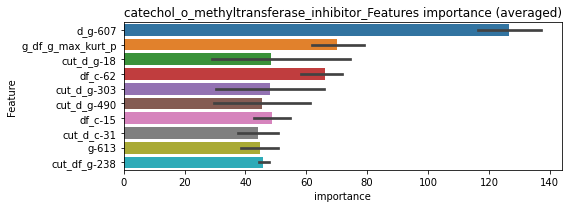

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0117204	valid_1's binary_logloss: 0.0200191
[200]	training's binary_logloss: 0.0012977	valid_1's binary_logloss: 0.00937563
[300]	training's binary_logloss: 0.000365621	valid_1's binary_logloss: 0.00846015
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00030044	valid_1's binary_logloss: 0.00842965


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123382	valid_1's binary_logloss: 0.0191728
[200]	training's binary_logloss: 0.00142889	valid_1's binary_logloss: 0.00601413
[300]	training's binary_logloss: 0.00038678	valid_1's binary_logloss: 0.00429331
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000296508	valid_1's binary_logloss: 0.00406153


catechol_o_methyltransferase_inhibitor logloss: 0.006245872313429238


neg labels: 3289 → selected neg labels: 3272


cc_chemokine_receptor_antagonist, len(trt): 102, len(othr): 3272, target_rate: 0.0042832 → Adj_target_rate: 0.0042806
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509859	valid_1's binary_logloss: 0.135837
[200]	training's binary_logloss: 0.0118413	valid_1's binary_logloss: 0.0978978
[300]	training's binary_logloss: 0.00370199	valid_1's binary_logloss: 0.0903356
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00263367	valid_1's binary_logloss: 0.0887837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589569	valid_1's binary_logloss: 0.126865
[200]	training's binary_logloss: 0.0143441	valid_1's binary_logloss: 0.0832732
[300]	training's binary_logloss: 0.00451426	valid_1's binary_logloss: 0.0739182
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00434247	valid_1's binary_logloss: 0.0737069


1 / 3 AUC score:0.996
y_Threshold: 0.0159078, Threshold: 0.0227919, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 645/3776
p_label_rate: 0.0200904 Vs.target_rate: 0.00428
Num_p_label: 80.0, conf_0:0.02051, conf_1:0.02507
Num_p_label: 80.0, Expected: 17.1, Adj_threshold_1: 0.0227919
Num_p_label: 30.0, Expected: 17.1, Adj_threshold_2: 0.0327919
threshold: 0.0327919, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 645.0/3776, y_label_rate: 0.1708157
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514232	valid_1's binary_logloss: 0.134466
[200]	training's binary_logloss: 0.01091	valid_1's binary_logloss: 0.0944156
[300]	training's binary_logloss: 0.00344364	valid_1's binary_logloss: 0.0859372
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0028196	valid_1's binary_logloss: 0.0847434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588361	valid_1's binary_logloss: 0.122492
[200]	training's binary_logloss: 0.0138848	valid_1's binary_logloss: 0.0760951
[300]	training's binary_logloss: 0.00429557	valid_1's binary_logloss: 0.0659373
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00372168	valid_1's binary_logloss: 0.0652445


2 / 3 AUC score:0.996
y_Threshold: 0.0354015, Threshold: 0.0327919, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 629.0/3744
p_label_rate: 0.0170768 Vs.target_rate: 0.00428
Num_p_label: 68.0, conf_0:0.02951, conf_1:0.03607
Num_p_label: 68.0, Expected: 17.1, Adj_threshold_1: 0.0327919
Num_p_label: 30.0, Expected: 17.1, Adj_threshold_2: 0.0427919
threshold: 0.0427919, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 629.0/3744, y_label_rate: 0.1680021
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514595	valid_1's binary_logloss: 0.116224
[200]	training's binary_logloss: 0.0110079	valid_1's binary_logloss: 0.0748923
[300]	training's binary_logloss: 0.00350302	valid_1's binary_logloss: 0.0648224
[400]	training's binary_logloss: 0.00167219	valid_1's binary_logloss: 0.0600567
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00161127	valid_1's binary_logloss: 0.0598934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534892	valid_1's binary_logloss: 0.104463
[200]	training's binary_logloss: 0.0118726	valid_1's binary_logloss: 0.0589359
[300]	training's binary_logloss: 0.00374051	valid_1's binary_logloss: 0.0472792
[400]	training's binary_logloss: 0.00171109	valid_1's binary_logloss: 0.0438478
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00153266	valid_1's binary_logloss: 0.0436447


3 / 3 AUC score:1.000
y_Threshold: 0.0275132, Threshold: 0.0427919, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 620.0/3726
p_label_rate: 0.0052737 Vs.target_rate: 0.00428
Num_p_label: 21.0, conf_0:0.03851, conf_1:0.04707
threshold: 0.0427919, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 641.0/7708, y_label_rate: 0.0831604


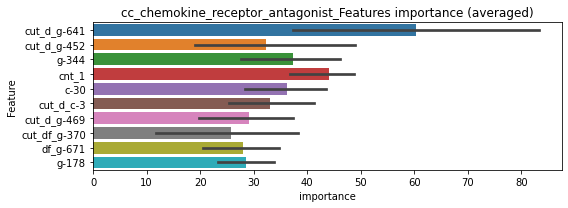

len(train_index) : 3854
len(valid_index) : 3854
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280503	valid_1's binary_logloss: 0.0740451
[200]	training's binary_logloss: 0.00615864	valid_1's binary_logloss: 0.0526339
[300]	training's binary_logloss: 0.00189182	valid_1's binary_logloss: 0.0483921
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00189182	valid_1's binary_logloss: 0.0483921


len(train_index) : 3854
len(valid_index) : 3854
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310359	valid_1's binary_logloss: 0.0710682
[200]	training's binary_logloss: 0.0066192	valid_1's binary_logloss: 0.0471804
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0021461	valid_1's binary_logloss: 0.0419869


cc_chemokine_receptor_antagonist logloss: 0.04518951262335019


neg labels: 3289 → selected neg labels: 3286


cck_receptor_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218375	valid_1's binary_logloss: 0.0304364
[200]	training's binary_logloss: 0.00245527	valid_1's binary_logloss: 0.00766727
[300]	training's binary_logloss: 0.000704612	valid_1's binary_logloss: 0.00481304
[400]	training's binary_logloss: 0.000380864	valid_1's binary_logloss: 0.00401885
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000338239	valid_1's binary_logloss: 0.00386565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222812	valid_1's binary_logloss: 0.0267185
[200]	training's binary_logloss: 0.00257585	valid_1's binary_logloss: 0.00401985
[300]	training's binary_logloss: 0.000738479	valid_1's binary_logloss: 0.0013672
[400]	training's binary_logloss: 0.000396584	valid_1's binary_logloss: 0.000792852
[500]	training's binary_logloss: 0.000320152	valid_1's binary_logloss: 0.000662792
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0016457, Threshold: 0.0024831, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00223, conf_1:0.00273
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0024831
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0124831
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.0224831
threshold: 0.0224831, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217835	valid_1's binary_logloss: 0.0291342
[200]	training's binary_logloss: 0.00238767	valid_1's binary_logloss: 0.00695053
[300]	training's binary_logloss: 0.000682418	valid_1's binary_logloss: 0.00445993
[400]	training's binary_logloss: 0.000371298	valid_1's binary_logloss: 0.00380657
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000365432	valid_1's binary_logloss: 0.00378259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222106	valid_1's binary_logloss: 0.0253131
[200]	training's binary_logloss: 0.00254421	valid_1's binary_logloss: 0.00344608
[300]	training's binary_logloss: 0.000723124	valid_1's binary_logloss: 0.0010954
[400]	training's binary_logloss: 0.000393101	valid_1's binary_logloss: 0.00062706
[500]	training's binary_logloss: 0.000315209	valid_1's binary_logloss: 0.000520909
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0294762, Threshold: 0.0224831, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0042692 Vs.target_rate: 0.00076
Num_p_label: 17.0, conf_0:0.02023, conf_1:0.02473
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_1: 0.0224831
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0324831
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.0424831
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_4: 0.0524831
threshold: 0.0524831, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217835	valid_1's binary_logloss: 0.0291342
[200]	training's binary_logloss: 0.00238767	valid_1's binary_logloss: 0.00695053
[300]	training's binary_logloss: 0.000682418	valid_1's binary_logloss: 0.00445993
[400]	training's binary_logloss: 0.000371298	valid_1's binary_logloss: 0.00380657
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000365432	valid_1's binary_logloss: 0.00378259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222106	valid_1's binary_logloss: 0.0253131
[200]	training's binary_logloss: 0.00254421	valid_1's binary_logloss: 0.00344608
[300]	training's binary_logloss: 0.000723124	valid_1's binary_logloss: 0.0010954
[400]	training's binary_logloss: 0.000393101	valid_1's binary_logloss: 0.00062706
[500]	training's binary_logloss: 0.000315209	valid_1's binary_logloss: 0.000520909
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0294762, Threshold: 0.0524831, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0010045 Vs.target_rate: 0.00076
Num_p_label: 4.0, conf_0:0.04723, conf_1:0.05773
threshold: 0.0524831, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7793, y_label_rate: 0.0848197


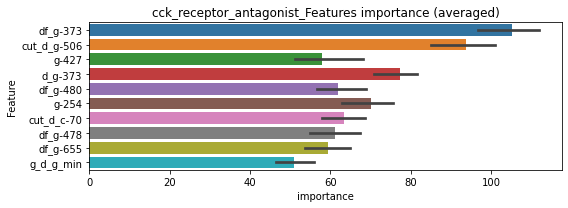

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113313	valid_1's binary_logloss: 0.016667
[200]	training's binary_logloss: 0.00128321	valid_1's binary_logloss: 0.00520765
[300]	training's binary_logloss: 0.000365227	valid_1's binary_logloss: 0.00425065
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000311773	valid_1's binary_logloss: 0.00417281


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0116355	valid_1's binary_logloss: 0.0163796
[200]	training's binary_logloss: 0.00131395	valid_1's binary_logloss: 0.00467979
[300]	training's binary_logloss: 0.000373564	valid_1's binary_logloss: 0.0033726
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000212226	valid_1's binary_logloss: 0.00313558


cck_receptor_antagonist logloss: 0.003654263189731847


neg labels: 3289 → selected neg labels: 3263


cdk_inhibitor, len(trt): 352, len(othr): 3263, target_rate: 0.0147812 → Adj_target_rate: 0.0122676
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440548	valid_1's binary_logloss: 0.117952
[200]	training's binary_logloss: 0.00895686	valid_1's binary_logloss: 0.102807
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00714051	valid_1's binary_logloss: 0.102473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433436	valid_1's binary_logloss: 0.113643
[200]	training's binary_logloss: 0.00823057	valid_1's binary_logloss: 0.0933994
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.007441	valid_1's binary_logloss: 0.0926837


1 / 3 AUC score:0.980
y_Threshold: 0.0345581, Threshold: 0.3679037, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 217 → Positive_corect_labels: 609/3698
p_label_rate: 0.0200904 Vs.target_rate: 0.01478
Num_p_label: 80.0, conf_0:0.33111, conf_1:0.40469
threshold: 0.3679037, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 609.0/3698, y_label_rate: 0.1646836
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322305	valid_1's binary_logloss: 0.0958294
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0168904	valid_1's binary_logloss: 0.0888853
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327285	valid_1's binary_logloss: 0.077363
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0081076	valid_1's binary_logloss: 0.0641319


2 / 3 AUC score:0.985
y_Threshold: 0.1455901, Threshold: 0.3679037, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 94 → Positive_corect_labels: 562.0/3604
p_label_rate: 0.0615269 Vs.target_rate: 0.01478
Num_p_label: 245.0, conf_0:0.33111, conf_1:0.40469
Num_p_label: 245.0, Expected: 58.9, Adj_threshold_1: 0.3679037
Num_p_label: 242.0, Expected: 58.9, Adj_threshold_2: 0.3779037
Num_p_label: 238.0, Expected: 58.9, Adj_threshold_3: 0.3879037
Num_p_label: 237.0, Expected: 58.9, Adj_threshold_4: 0.3979037
Num_p_label: 234.0, Expected: 58.9, Adj_threshold_5: 0.4079037
Num_p_label: 234.0, Expected: 58.9, Adj_threshold_6: 0.4179037
Num_p_label: 228.0, Expected: 58.9, Adj_threshold_7: 0.4279037
Num_p_label: 221.0, Expected: 58.9, Adj_threshold_8: 0.4379037
Num_p_label: 214.0, Expected: 58.9, Adj_threshold_9: 0.4479037
Num_p_label: 208.0, Expected: 58.9, Adj_threshold_10: 0.4579037
threshold: 0.4679037, positive_p_label: 203.0/3982, p_label_rate: 0.0509794
positive_y_label: 562.0/3604, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233923	valid_1's binary_logloss: 0.0633927
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00473305	valid_1's binary_logloss: 0.0554527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247236	valid_1's binary_logloss: 0.0457189
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00438203	valid_1's binary_logloss: 0.0332916


3 / 3 AUC score:0.994
y_Threshold: 0.0949225, Threshold: 0.4679037, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 542.0/3564
p_label_rate: 0.0760924 Vs.target_rate: 0.01478
Num_p_label: 303.0, conf_0:0.42111, conf_1:0.51469
Num_p_label: 303.0, Expected: 58.9, Adj_threshold_1: 0.4679037
Num_p_label: 301.0, Expected: 58.9, Adj_threshold_2: 0.4779037
Num_p_label: 299.0, Expected: 58.9, Adj_threshold_3: 0.4879037
Num_p_label: 297.0, Expected: 58.9, Adj_threshold_4: 0.4979037
Num_p_label: 295.0, Expected: 58.9, Adj_threshold_5: 0.5079037
Num_p_label: 293.0, Expected: 58.9, Adj_threshold_6: 0.5179037
Num_p_label: 291.0, Expected: 58.9, Adj_threshold_7: 0.5279037
Num_p_label: 290.0, Expected: 58.9, Adj_threshold_8: 0.5379037
Num_p_label: 286.0, Expected: 58.9, Adj_threshold_9: 0.5479037
Num_p_label: 284.0, Expected: 58.9, Adj_threshold_10: 0.5579037
threshold: 0.5679037, positive_p_label: 282.0/3982, p_label_rate: 0.0708187
positive_y_label: 824.0/7546, y_label_ra

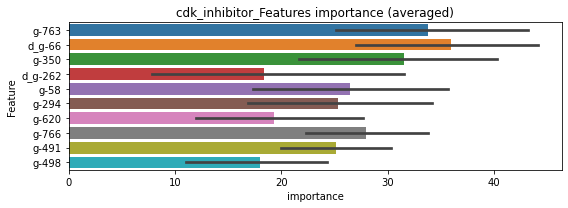

len(train_index) : 3773
len(valid_index) : 3773
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162943	valid_1's binary_logloss: 0.0272457
[200]	training's binary_logloss: 0.00203279	valid_1's binary_logloss: 0.0147062
[300]	training's binary_logloss: 0.000542742	valid_1's binary_logloss: 0.0127178
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000455241	valid_1's binary_logloss: 0.0125535


len(train_index) : 3773
len(valid_index) : 3773
================================= fold 2/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159182	valid_1's binary_logloss: 0.0289453
[200]	training's binary_logloss: 0.00192151	valid_1's binary_logloss: 0.0185333
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.000946068	valid_1's binary_logloss: 0.0177468


cdk_inhibitor logloss: 0.015150162307419564


neg labels: 3289 → selected neg labels: 3280


chelating_agent, len(trt): 54, len(othr): 3280, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391496	valid_1's binary_logloss: 0.0820954
[200]	training's binary_logloss: 0.00663293	valid_1's binary_logloss: 0.0428921
[300]	training's binary_logloss: 0.0019198	valid_1's binary_logloss: 0.0336335
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00137465	valid_1's binary_logloss: 0.0321448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430472	valid_1's binary_logloss: 0.0727049
[200]	training's binary_logloss: 0.00764273	valid_1's binary_logloss: 0.0320626
[300]	training's binary_logloss: 0.0021723	valid_1's binary_logloss: 0.0248621
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00132883	valid_1's binary_logloss: 0.0231171


1 / 3 AUC score:0.999
y_Threshold: 0.0068755, Threshold: 0.0092611, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00227
Num_p_label: 80.0, conf_0:0.00834, conf_1:0.01019
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0092611
Num_p_label: 16.0, Expected: 9.0, Adj_threshold_2: 0.0192611
threshold: 0.0192611, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404225	valid_1's binary_logloss: 0.0761613
[200]	training's binary_logloss: 0.00715619	valid_1's binary_logloss: 0.0378519
[300]	training's binary_logloss: 0.00207339	valid_1's binary_logloss: 0.0285721
[400]	training's binary_logloss: 0.00100562	valid_1's binary_logloss: 0.0257261
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000719436	valid_1's binary_logloss: 0.0244208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410508	valid_1's binary_logloss: 0.0722538
[200]	training's binary_logloss: 0.00701922	valid_1's binary_logloss: 0.0278662
[300]	training's binary_logloss: 0.00206788	valid_1's binary_logloss: 0.0181558
[400]	training's binary_logloss: 0.000989207	valid_1's binary_logloss: 0.0154283
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000709297	valid_1's binary_logloss: 0.0143841


2 / 3 AUC score:0.999
y_Threshold: 0.0307981, Threshold: 0.0192611, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3800
p_label_rate: 0.0065294 Vs.target_rate: 0.00227
Num_p_label: 26.0, conf_0:0.01734, conf_1:0.02119
threshold: 0.0192611, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404599	valid_1's binary_logloss: 0.0806855
[200]	training's binary_logloss: 0.00687285	valid_1's binary_logloss: 0.0396515
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00283804	valid_1's binary_logloss: 0.0336376
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409411	valid_1's binary_logloss: 0.0760645
[200]	training's binary_logloss: 0.00696677	valid_1's binary_logloss: 0.0359595
[300]	training's binary_logloss: 0.00201625	valid_1's binary_logloss: 0.0269318
[400]	training's binary_logloss: 0.00096603	valid_1's binary_logloss: 0.0245264
[500]	training's binary_logloss: 0.000620226	valid_1's binary_logloss: 0.0227043
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000542148	valid_1's binary_logloss: 0.0223906


3 / 3 AUC score:1.000
y_Threshold: 0.0346252, Threshold: 0.0192611, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 648.0/3788
p_label_rate: 0.0125565 Vs.target_rate: 0.00227
Num_p_label: 50.0, conf_0:0.01734, conf_1:0.02119
Num_p_label: 50.0, Expected: 9.0, Adj_threshold_1: 0.0192611
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_2: 0.0292611
Num_p_label: 12.0, Expected: 9.0, Adj_threshold_3: 0.0392611
threshold: 0.0392611, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 660.0/7770, y_label_rate: 0.0849421


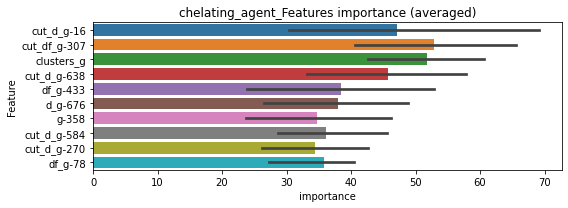

len(train_index) : 3885
len(valid_index) : 3885
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214135	valid_1's binary_logloss: 0.0499688
[200]	training's binary_logloss: 0.00361456	valid_1's binary_logloss: 0.0311572
[300]	training's binary_logloss: 0.00104972	valid_1's binary_logloss: 0.0271769
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000640847	valid_1's binary_logloss: 0.0260395


len(train_index) : 3885
len(valid_index) : 3885
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231221	valid_1's binary_logloss: 0.0444537
[200]	training's binary_logloss: 0.00413689	valid_1's binary_logloss: 0.0218241
[300]	training's binary_logloss: 0.00118763	valid_1's binary_logloss: 0.0166601
[400]	training's binary_logloss: 0.000553796	valid_1's binary_logloss: 0.014882
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000383629	valid_1's binary_logloss: 0.0142221


chelating_agent logloss: 0.02013083924531417


neg labels: 3289 → selected neg labels: 3285


chk_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187075	valid_1's binary_logloss: 0.0252553
[200]	training's binary_logloss: 0.00187704	valid_1's binary_logloss: 0.00469034
[300]	training's binary_logloss: 0.000525479	valid_1's binary_logloss: 0.00200038
[400]	training's binary_logloss: 0.000300983	valid_1's binary_logloss: 0.00137723
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00025691	valid_1's binary_logloss: 0.00124425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189044	valid_1's binary_logloss: 0.0223942
[200]	training's binary_logloss: 0.00190809	valid_1's binary_logloss: 0.00352159
[300]	training's binary_logloss: 0.000539751	valid_1's binary_logloss: 0.0018294
[400]	training's binary_logloss: 0.000305222	valid_1's binary_logloss: 0.00142042
[500]	training's binary_logloss: 0.000259653	valid_1's binary_logloss: 0.00131988
Early stopping, best iteration is

1 / 3 AUC score:1.000
y_Threshold: 0.0017158, Threshold: 0.0080038, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00720, conf_1:0.00880
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0080038
Num_p_label: 52.0, Expected: 4.0, Adj_threshold_2: 0.0180038
Num_p_label: 43.0, Expected: 4.0, Adj_threshold_3: 0.0280038
Num_p_label: 39.0, Expected: 4.0, Adj_threshold_4: 0.0380038
Num_p_label: 33.0, Expected: 4.0, Adj_threshold_5: 0.0480038
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_6: 0.0580038
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_7: 0.0680038
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_8: 0.0780038
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_9: 0.0880038
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_10: 0.0980038
threshold: 0.1080038, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181291	valid_1's binary_logloss: 0.0227536
[200]	training's binary_logloss: 0.00167966	valid_1's binary_logloss: 0.00359701
[300]	training's binary_logloss: 0.000448284	valid_1's binary_logloss: 0.00146065
[400]	training's binary_logloss: 0.000260255	valid_1's binary_logloss: 0.00103186
[500]	training's binary_logloss: 0.000229326	valid_1's binary_logloss: 0.000954781
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000227758	valid_1's binary_logloss: 0.00095084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184294	valid_1's binary_logloss: 0.0212184
[200]	training's binary_logloss: 0.00173009	valid_1's binary_logloss: 0.00249686
[300]	training's binary_logloss: 0.000464691	valid_1's binary_logloss: 0.000893162
[400]	training's binary_logloss: 0.000267128	valid_1's binary_logloss: 0.000589791
[500]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.1870476, Threshold: 0.1080038, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0223506 Vs.target_rate: 0.00101
Num_p_label: 89.0, conf_0:0.09720, conf_1:0.11880
Num_p_label: 89.0, Expected: 4.0, Adj_threshold_1: 0.1080038
Num_p_label: 84.0, Expected: 4.0, Adj_threshold_2: 0.1180038
Num_p_label: 82.0, Expected: 4.0, Adj_threshold_3: 0.1280038
Num_p_label: 78.0, Expected: 4.0, Adj_threshold_4: 0.1380038
Num_p_label: 77.0, Expected: 4.0, Adj_threshold_5: 0.1480038
Num_p_label: 75.0, Expected: 4.0, Adj_threshold_6: 0.1580038
Num_p_label: 71.0, Expected: 4.0, Adj_threshold_7: 0.1680038
Num_p_label: 66.0, Expected: 4.0, Adj_threshold_8: 0.1780038
Num_p_label: 62.0, Expected: 4.0, Adj_threshold_9: 0.1880038
Num_p_label: 60.0, Expected: 4.0, Adj_threshold_10: 0.1980038
threshold: 0.2080038, positive_p_label: 58.0/3982, p_label_rate: 0.0145655
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181291	valid_1's binary_logloss: 0.0227536
[200]	training's binary_logloss: 0.00167966	valid_1's binary_logloss: 0.00359701
[300]	training's binary_logloss: 0.000448284	valid_1's binary_logloss: 0.00146065
[400]	training's binary_logloss: 0.000260255	valid_1's binary_logloss: 0.00103186
[500]	training's binary_logloss: 0.000229326	valid_1's binary_logloss: 0.000954781
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000227758	valid_1's binary_logloss: 0.00095084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184294	valid_1's binary_logloss: 0.0212184
[200]	training's binary_logloss: 0.00173009	valid_1's binary_logloss: 0.00249686
[300]	training's binary_logloss: 0.000464691	valid_1's binary_logloss: 0.000893162
[400]	training's binary_logloss: 0.000267128	valid_1's binary_logloss: 0.000589791
[500]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.1870476, Threshold: 0.2080038, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0145655 Vs.target_rate: 0.00101
Num_p_label: 58.0, conf_0:0.18720, conf_1:0.22880
Num_p_label: 58.0, Expected: 4.0, Adj_threshold_1: 0.2080038
Num_p_label: 56.0, Expected: 4.0, Adj_threshold_2: 0.2180038
Num_p_label: 56.0, Expected: 4.0, Adj_threshold_3: 0.2280038
Num_p_label: 56.0, Expected: 4.0, Adj_threshold_4: 0.2380038
Num_p_label: 55.0, Expected: 4.0, Adj_threshold_5: 0.2480038
Num_p_label: 54.0, Expected: 4.0, Adj_threshold_6: 0.2580038
Num_p_label: 54.0, Expected: 4.0, Adj_threshold_7: 0.2680038
Num_p_label: 54.0, Expected: 4.0, Adj_threshold_8: 0.2780038
Num_p_label: 53.0, Expected: 4.0, Adj_threshold_9: 0.2880038
Num_p_label: 52.0, Expected: 4.0, Adj_threshold_10: 0.2980038
threshold: 0.3080038, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 708.0/7792, y_label_rate: 0.0908624


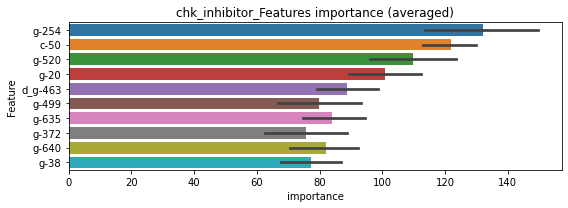

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118895	valid_1's binary_logloss: 0.0216082
[200]	training's binary_logloss: 0.00135337	valid_1's binary_logloss: 0.010862
[300]	training's binary_logloss: 0.000387824	valid_1's binary_logloss: 0.00968305
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.000394133	valid_1's binary_logloss: 0.00966367


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123949	valid_1's binary_logloss: 0.0181488
[200]	training's binary_logloss: 0.00153678	valid_1's binary_logloss: 0.00721333
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.000665483	valid_1's binary_logloss: 0.0062242


chk_inhibitor logloss: 0.007943937235892361


neg labels: 3289 → selected neg labels: 3282


chloride_channel_blocker, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371736	valid_1's binary_logloss: 0.0720362
[200]	training's binary_logloss: 0.00585199	valid_1's binary_logloss: 0.0298656
[300]	training's binary_logloss: 0.00161634	valid_1's binary_logloss: 0.0211375
[400]	training's binary_logloss: 0.0007734	valid_1's binary_logloss: 0.0181843
[500]	training's binary_logloss: 0.000506115	valid_1's binary_logloss: 0.0169306
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00052184	valid_1's binary_logloss: 0.0168995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370163	valid_1's binary_logloss: 0.0641864
[200]	training's binary_logloss: 0.0059257	valid_1's binary_logloss: 0.0243989
[300]	training's binary_logloss: 0.00166071	valid_1's binary_logloss: 0.0170461
[400]	training's binary_logloss: 0.000814729	valid_1's binary_logloss: 0.0150297
Early stopping, best iteration is:
[475]	trai

1 / 3 AUC score:1.000
y_Threshold: 0.0036522, Threshold: 0.0054508, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176
Num_p_label: 80.0, conf_0:0.00491, conf_1:0.00600
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0054508
Num_p_label: 9.0, Expected: 7.0, Adj_threshold_2: 0.0154508
threshold: 0.0154508, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350517	valid_1's binary_logloss: 0.069962
[200]	training's binary_logloss: 0.0054845	valid_1's binary_logloss: 0.0287744
[300]	training's binary_logloss: 0.0015449	valid_1's binary_logloss: 0.0195429
[400]	training's binary_logloss: 0.000760165	valid_1's binary_logloss: 0.0168758
[500]	training's binary_logloss: 0.000501712	valid_1's binary_logloss: 0.0156001
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000489047	valid_1's binary_logloss: 0.0155855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358307	valid_1's binary_logloss: 0.0651821
[200]	training's binary_logloss: 0.00554818	valid_1's binary_logloss: 0.0247747
[300]	training's binary_logloss: 0.00159669	valid_1's binary_logloss: 0.0164787
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00085428	valid_1's binary_logloss: 0.0143376


2 / 3 AUC score:1.000
y_Threshold: 0.0292105, Threshold: 0.0154508, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3800
p_label_rate: 0.0118031 Vs.target_rate: 0.00176
Num_p_label: 47.0, conf_0:0.01391, conf_1:0.01700
Num_p_label: 47.0, Expected: 7.0, Adj_threshold_1: 0.0154508
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_2: 0.0254508
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_3: 0.0354508
threshold: 0.0354508, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 653.0/3800, y_label_rate: 0.1718421
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347188	valid_1's binary_logloss: 0.0678203
[200]	training's binary_logloss: 0.0052322	valid_1's binary_logloss: 0.0256788
[300]	training's binary_logloss: 0.00149636	valid_1's binary_logloss: 0.0170254
[400]	training's binary_logloss: 0.000733511	valid_1's binary_logloss: 0.0141259
[500]	training's binary_logloss: 0.0004878	valid_1's binary_logloss: 0.0129838
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000493264	valid_1's binary_logloss: 0.0129517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363047	valid_1's binary_logloss: 0.0642661
[200]	training's binary_logloss: 0.00556756	valid_1's binary_logloss: 0.0254737
[300]	training's binary_logloss: 0.00160657	valid_1's binary_logloss: 0.0180958
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00116286	valid_1's binary_logloss: 0.017214


3 / 3 AUC score:1.000
y_Threshold: 0.0333743, Threshold: 0.0354508, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3798
p_label_rate: 0.0025113 Vs.target_rate: 0.00176
Num_p_label: 10.0, conf_0:0.03191, conf_1:0.03900
threshold: 0.0354508, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 662.0/7780, y_label_rate: 0.0850900


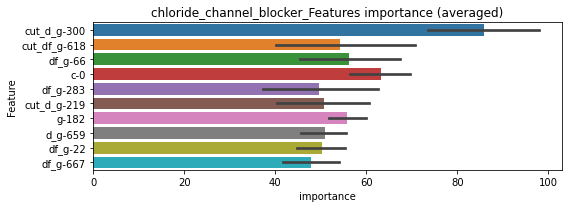

len(train_index) : 3890
len(valid_index) : 3890
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196802	valid_1's binary_logloss: 0.0387666
[200]	training's binary_logloss: 0.00305	valid_1's binary_logloss: 0.0188889
[300]	training's binary_logloss: 0.00085722	valid_1's binary_logloss: 0.0153001
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00063306	valid_1's binary_logloss: 0.0150968


len(train_index) : 3890
len(valid_index) : 3890
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199239	valid_1's binary_logloss: 0.0348331
[200]	training's binary_logloss: 0.0031714	valid_1's binary_logloss: 0.0128635
[300]	training's binary_logloss: 0.000896281	valid_1's binary_logloss: 0.0087692
[400]	training's binary_logloss: 0.000429669	valid_1's binary_logloss: 0.00766002
[500]	training's binary_logloss: 0.000277795	valid_1's binary_logloss: 0.00733044
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000281953	valid_1's binary_logloss: 0.00730912


chloride_channel_blocker logloss: 0.011202938536746292


neg labels: 3289 → selected neg labels: 3281


cholesterol_inhibitor, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377424	valid_1's binary_logloss: 0.0772579
[200]	training's binary_logloss: 0.00634424	valid_1's binary_logloss: 0.0369518
[300]	training's binary_logloss: 0.00180303	valid_1's binary_logloss: 0.0289806
[400]	training's binary_logloss: 0.000869412	valid_1's binary_logloss: 0.0260381
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000631176	valid_1's binary_logloss: 0.0245881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412438	valid_1's binary_logloss: 0.0634732
[200]	training's binary_logloss: 0.0073992	valid_1's binary_logloss: 0.0225775
[300]	training's binary_logloss: 0.00212955	valid_1's binary_logloss: 0.0134615
[400]	training's binary_logloss: 0.00101794	valid_1's binary_logloss: 0.0107389
[500]	training's binary_logloss: 0.000648725	valid_1's binary_logloss: 0.00961876
[600]	training's binary_logloss: 0.0005176

1 / 3 AUC score:1.000
y_Threshold: 0.0032149, Threshold: 0.0043738, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.00394, conf_1:0.00481
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0043738
Num_p_label: 7.0, Expected: 8.0, Adj_threshold_2: 0.0143738
threshold: 0.0143738, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391136	valid_1's binary_logloss: 0.0779642
[200]	training's binary_logloss: 0.00631033	valid_1's binary_logloss: 0.0367426
[300]	training's binary_logloss: 0.00178904	valid_1's binary_logloss: 0.0283321
[400]	training's binary_logloss: 0.000870324	valid_1's binary_logloss: 0.025999
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00066607	valid_1's binary_logloss: 0.0249954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396556	valid_1's binary_logloss: 0.0621578
[200]	training's binary_logloss: 0.00698354	valid_1's binary_logloss: 0.0226647
[300]	training's binary_logloss: 0.0020538	valid_1's binary_logloss: 0.0138529
[400]	training's binary_logloss: 0.000992229	valid_1's binary_logloss: 0.0114521
[500]	training's binary_logloss: 0.00063752	valid_1's binary_logloss: 0.0103603
Early stopping, best iteration is:
[566]	trai

2 / 3 AUC score:1.000
y_Threshold: 0.0111663, Threshold: 0.0143738, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0045203 Vs.target_rate: 0.00202
Num_p_label: 18.0, conf_0:0.01294, conf_1:0.01581
threshold: 0.0143738, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385095	valid_1's binary_logloss: 0.072738
[200]	training's binary_logloss: 0.00649653	valid_1's binary_logloss: 0.0321314
[300]	training's binary_logloss: 0.00186778	valid_1's binary_logloss: 0.0221989
[400]	training's binary_logloss: 0.000905744	valid_1's binary_logloss: 0.0192248
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000619944	valid_1's binary_logloss: 0.0184197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383383	valid_1's binary_logloss: 0.0698668
[200]	training's binary_logloss: 0.00663872	valid_1's binary_logloss: 0.0292558
[300]	training's binary_logloss: 0.00191898	valid_1's binary_logloss: 0.0204368
[400]	training's binary_logloss: 0.000924529	valid_1's binary_logloss: 0.0177157
[500]	training's binary_logloss: 0.000605752	valid_1's binary_logloss: 0.0167742
Early stopping, best iteration is:
[540]	t

3 / 3 AUC score:1.000
y_Threshold: 0.0169620, Threshold: 0.0143738, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3799
p_label_rate: 0.0032647 Vs.target_rate: 0.00202
Num_p_label: 13.0, conf_0:0.01294, conf_1:0.01581
threshold: 0.0143738, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 666.0/7781, y_label_rate: 0.0855931


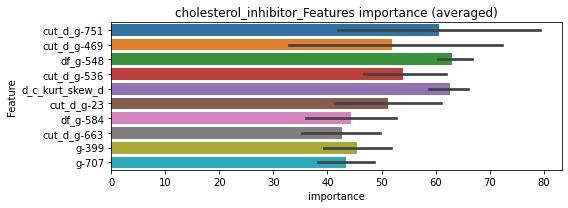

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022264	valid_1's binary_logloss: 0.0447109
[200]	training's binary_logloss: 0.00359895	valid_1's binary_logloss: 0.0237717
[300]	training's binary_logloss: 0.00101901	valid_1's binary_logloss: 0.0205739
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000541743	valid_1's binary_logloss: 0.0201312


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221473	valid_1's binary_logloss: 0.0443244
[200]	training's binary_logloss: 0.00371965	valid_1's binary_logloss: 0.021451
[300]	training's binary_logloss: 0.00105634	valid_1's binary_logloss: 0.0169967
[400]	training's binary_logloss: 0.000503459	valid_1's binary_logloss: 0.0157507
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000455952	valid_1's binary_logloss: 0.0155445


cholesterol_inhibitor logloss: 0.01783814231453115


neg labels: 3289 → selected neg labels: 3280


cholinergic_receptor_antagonist, len(trt): 54, len(othr): 3280, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359893	valid_1's binary_logloss: 0.0790801
[200]	training's binary_logloss: 0.0059858	valid_1's binary_logloss: 0.0449607
[300]	training's binary_logloss: 0.00176373	valid_1's binary_logloss: 0.0392388
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00132273	valid_1's binary_logloss: 0.0382101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405319	valid_1's binary_logloss: 0.0658349
[200]	training's binary_logloss: 0.00722761	valid_1's binary_logloss: 0.0267342
[300]	training's binary_logloss: 0.00216029	valid_1's binary_logloss: 0.0182074
[400]	training's binary_logloss: 0.0010358	valid_1's binary_logloss: 0.0157881
[500]	training's binary_logloss: 0.000662161	valid_1's binary_logloss: 0.0148624
[600]	training's binary_logloss: 0.000532789	valid_1's binary_logloss: 0.0145126
Early stopping, best iteration is:
[620]	trai

1 / 3 AUC score:0.999
y_Threshold: 0.0050144, Threshold: 0.0079380, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00227
Num_p_label: 80.0, conf_0:0.00714, conf_1:0.00873
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0079380
Num_p_label: 15.0, Expected: 9.0, Adj_threshold_2: 0.0179380
threshold: 0.0179380, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377145	valid_1's binary_logloss: 0.0764727
[200]	training's binary_logloss: 0.0065083	valid_1's binary_logloss: 0.0398402
[300]	training's binary_logloss: 0.0019482	valid_1's binary_logloss: 0.0333604
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0018779	valid_1's binary_logloss: 0.0332598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388986	valid_1's binary_logloss: 0.0661986
[200]	training's binary_logloss: 0.00669668	valid_1's binary_logloss: 0.0296134
[300]	training's binary_logloss: 0.00198908	valid_1's binary_logloss: 0.0218468
[400]	training's binary_logloss: 0.000984021	valid_1's binary_logloss: 0.019669
[500]	training's binary_logloss: 0.000634023	valid_1's binary_logloss: 0.0187004
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000620283	valid_1's binary_logloss: 0.0186283


2 / 3 AUC score:1.000
y_Threshold: 0.0251397, Threshold: 0.0179380, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 648.0/3788
p_label_rate: 0.0165746 Vs.target_rate: 0.00227
Num_p_label: 66.0, conf_0:0.01614, conf_1:0.01973
Num_p_label: 66.0, Expected: 9.0, Adj_threshold_1: 0.0179380
Num_p_label: 31.0, Expected: 9.0, Adj_threshold_2: 0.0279380
Num_p_label: 16.0, Expected: 9.0, Adj_threshold_3: 0.0379380
threshold: 0.0379380, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 648.0/3788, y_label_rate: 0.1710665
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366129	valid_1's binary_logloss: 0.0728954
[200]	training's binary_logloss: 0.0059667	valid_1's binary_logloss: 0.0349008
[300]	training's binary_logloss: 0.00180878	valid_1's binary_logloss: 0.0278932
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00146827	valid_1's binary_logloss: 0.0268225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373809	valid_1's binary_logloss: 0.0636717
[200]	training's binary_logloss: 0.00631396	valid_1's binary_logloss: 0.025321
[300]	training's binary_logloss: 0.00188886	valid_1's binary_logloss: 0.0161606
[400]	training's binary_logloss: 0.000929047	valid_1's binary_logloss: 0.0131641
[500]	training's binary_logloss: 0.000609045	valid_1's binary_logloss: 0.011753
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000548102	valid_1's binary_logloss: 0.0114183


3 / 3 AUC score:1.000
y_Threshold: 0.0326917, Threshold: 0.0379380, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 647.0/3786
p_label_rate: 0.0032647 Vs.target_rate: 0.00227
Num_p_label: 13.0, conf_0:0.03414, conf_1:0.04173
threshold: 0.0379380, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 660.0/7768, y_label_rate: 0.0849640


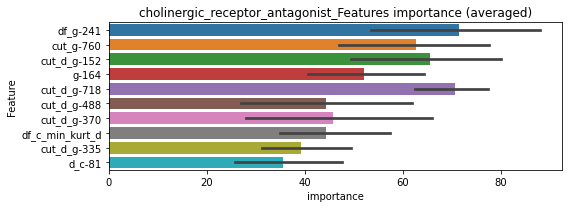

len(train_index) : 3884
len(valid_index) : 3884
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199532	valid_1's binary_logloss: 0.0449441
[200]	training's binary_logloss: 0.00328404	valid_1's binary_logloss: 0.0257827
[300]	training's binary_logloss: 0.00095485	valid_1's binary_logloss: 0.0230271
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000561966	valid_1's binary_logloss: 0.0224334


len(train_index) : 3884
len(valid_index) : 3884
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205686	valid_1's binary_logloss: 0.0391732
[200]	training's binary_logloss: 0.00366867	valid_1's binary_logloss: 0.0205678
[300]	training's binary_logloss: 0.00108624	valid_1's binary_logloss: 0.0166164
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00055711	valid_1's binary_logloss: 0.0154317


cholinergic_receptor_antagonist logloss: 0.018932560197056147


neg labels: 3289 → selected neg labels: 3285


coagulation_factor_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271434	valid_1's binary_logloss: 0.0404253
[200]	training's binary_logloss: 0.00350051	valid_1's binary_logloss: 0.0109483
[300]	training's binary_logloss: 0.000976848	valid_1's binary_logloss: 0.00605082
[400]	training's binary_logloss: 0.00049661	valid_1's binary_logloss: 0.00430534
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000389059	valid_1's binary_logloss: 0.0039601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269286	valid_1's binary_logloss: 0.0403775
[200]	training's binary_logloss: 0.0034636	valid_1's binary_logloss: 0.0106648
[300]	training's binary_logloss: 0.000991603	valid_1's binary_logloss: 0.00573327
[400]	training's binary_logloss: 0.000501365	valid_1's binary_logloss: 0.00428765
[500]	training's binary_logloss: 0.000365024	valid_1's binary_logloss: 0.00375077
Early stopping, best iteration is:
[

1 / 3 AUC score:1.000
y_Threshold: 0.0018044, Threshold: 0.0024324, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00219, conf_1:0.00268
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0024324
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_2: 0.0124324
threshold: 0.0124324, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264005	valid_1's binary_logloss: 0.0411988
[200]	training's binary_logloss: 0.003337	valid_1's binary_logloss: 0.0113703
[300]	training's binary_logloss: 0.000949107	valid_1's binary_logloss: 0.00600223
[400]	training's binary_logloss: 0.000490592	valid_1's binary_logloss: 0.00445181
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000392276	valid_1's binary_logloss: 0.00418191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269923	valid_1's binary_logloss: 0.0395621
[200]	training's binary_logloss: 0.00343505	valid_1's binary_logloss: 0.0105024
[300]	training's binary_logloss: 0.000980124	valid_1's binary_logloss: 0.00568045
[400]	training's binary_logloss: 0.000500955	valid_1's binary_logloss: 0.00433365
[500]	training's binary_logloss: 0.000371491	valid_1's binary_logloss: 0.00389289
Early stopping, best iteration is:


2 / 3 AUC score:1.000
y_Threshold: 0.0450470, Threshold: 0.0124324, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0030136 Vs.target_rate: 0.00101
Num_p_label: 12.0, conf_0:0.01119, conf_1:0.01368
threshold: 0.0124324, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264005	valid_1's binary_logloss: 0.0411988
[200]	training's binary_logloss: 0.003337	valid_1's binary_logloss: 0.0113703
[300]	training's binary_logloss: 0.000949107	valid_1's binary_logloss: 0.00600223
[400]	training's binary_logloss: 0.000490592	valid_1's binary_logloss: 0.00445181
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000392276	valid_1's binary_logloss: 0.00418191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269923	valid_1's binary_logloss: 0.0395621
[200]	training's binary_logloss: 0.00343505	valid_1's binary_logloss: 0.0105024
[300]	training's binary_logloss: 0.000980124	valid_1's binary_logloss: 0.00568045
[400]	training's binary_logloss: 0.000500955	valid_1's binary_logloss: 0.00433365
[500]	training's binary_logloss: 0.000371491	valid_1's binary_logloss: 0.00389289
Early stopping, best iteration is:


3 / 3 AUC score:1.000
y_Threshold: 0.0450470, Threshold: 0.0124324, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0030136 Vs.target_rate: 0.00101
Num_p_label: 12.0, conf_0:0.01119, conf_1:0.01368
threshold: 0.0124324, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 669.0/7792, y_label_rate: 0.0858573


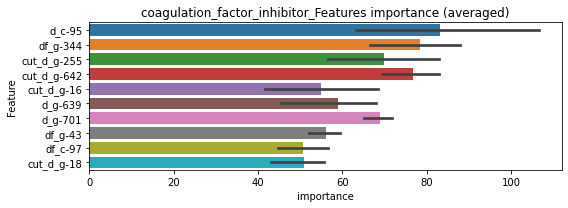

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149355	valid_1's binary_logloss: 0.0292914
[200]	training's binary_logloss: 0.00196392	valid_1's binary_logloss: 0.0150395
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.000671141	valid_1's binary_logloss: 0.0137877


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162958	valid_1's binary_logloss: 0.0236289
[200]	training's binary_logloss: 0.00213533	valid_1's binary_logloss: 0.0087191
[300]	training's binary_logloss: 0.000592336	valid_1's binary_logloss: 0.00721561
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000331345	valid_1's binary_logloss: 0.00701185


coagulation_factor_inhibitor logloss: 0.010399772090441088


neg labels: 3289 → selected neg labels: 3284


corticosteroid_agonist, len(trt): 36, len(othr): 3284, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261322	valid_1's binary_logloss: 0.0408296
[200]	training's binary_logloss: 0.00334311	valid_1's binary_logloss: 0.0117622
[300]	training's binary_logloss: 0.000942975	valid_1's binary_logloss: 0.00760313
[400]	training's binary_logloss: 0.000485645	valid_1's binary_logloss: 0.00603996
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000384354	valid_1's binary_logloss: 0.00549118
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262625	valid_1's binary_logloss: 0.0426096
[200]	training's binary_logloss: 0.00338458	valid_1's binary_logloss: 0.0127497
[300]	training's binary_logloss: 0.000968032	valid_1's binary_logloss: 0.00801026
[400]	training's binary_logloss: 0.000495975	valid_1's binary_logloss: 0.00642147
[500]	training's binary_logloss: 0.000368496	valid_1's binary_logloss: 0.00583067
Early stopping, best iteration is

1 / 3 AUC score:1.000
y_Threshold: 0.0015061, Threshold: 0.0022304, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00201, conf_1:0.00245
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0022304
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_2: 0.0122304
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_3: 0.0222304
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_4: 0.0322304
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_5: 0.0422304
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_6: 0.0522304
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_7: 0.0622304
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_8: 0.0722304
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_9: 0.0822304
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_10: 0.0922304
threshold: 0.1022304, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241507	valid_1's binary_logloss: 0.0332654
[200]	training's binary_logloss: 0.00287761	valid_1's binary_logloss: 0.00593544
[300]	training's binary_logloss: 0.000798356	valid_1's binary_logloss: 0.00240477
[400]	training's binary_logloss: 0.000422991	valid_1's binary_logloss: 0.00160458
[500]	training's binary_logloss: 0.000324661	valid_1's binary_logloss: 0.00136205
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000322089	valid_1's binary_logloss: 0.00135415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240656	valid_1's binary_logloss: 0.0370181
[200]	training's binary_logloss: 0.00282936	valid_1's binary_logloss: 0.00863298
[300]	training's binary_logloss: 0.000796093	valid_1's binary_logloss: 0.0043991
[400]	training's binary_logloss: 0.000415675	valid_1's binary_logloss: 0.00312116
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.0417484, Threshold: 0.1022304, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0102963 Vs.target_rate: 0.00151
Num_p_label: 41.0, conf_0:0.09201, conf_1:0.11245
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_1: 0.1022304
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_2: 0.1122304
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_3: 0.1222304
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_4: 0.1322304
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_5: 0.1422304
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_6: 0.1522304
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_7: 0.1622304
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_8: 0.1722304
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_9: 0.1822304
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_10: 0.1922304
threshold: 0.2022304, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241507	valid_1's binary_logloss: 0.0332654
[200]	training's binary_logloss: 0.00287761	valid_1's binary_logloss: 0.00593544
[300]	training's binary_logloss: 0.000798356	valid_1's binary_logloss: 0.00240477
[400]	training's binary_logloss: 0.000422991	valid_1's binary_logloss: 0.00160458
[500]	training's binary_logloss: 0.000324661	valid_1's binary_logloss: 0.00136205
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000322089	valid_1's binary_logloss: 0.00135415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240656	valid_1's binary_logloss: 0.0370181
[200]	training's binary_logloss: 0.00282936	valid_1's binary_logloss: 0.00863298
[300]	training's binary_logloss: 0.000796093	valid_1's binary_logloss: 0.0043991
[400]	training's binary_logloss: 0.000415675	valid_1's binary_logloss: 0.00312116
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.0417484, Threshold: 0.2022304, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0095429 Vs.target_rate: 0.00151
Num_p_label: 38.0, conf_0:0.18201, conf_1:0.22245
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_1: 0.2022304
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_2: 0.2122304
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_3: 0.2222304
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_4: 0.2322304
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_5: 0.2422304
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_6: 0.2522304
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_7: 0.2622304
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_8: 0.2722304
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_9: 0.2822304
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_10: 0.2922304
threshold: 0.3022304, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 692.0/7790, y_label_rate: 0.0888318


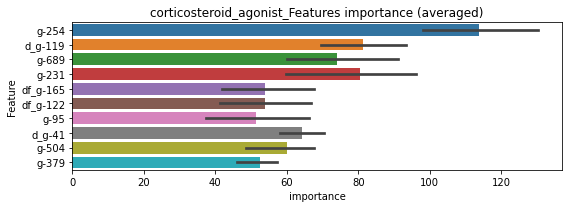

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129476	valid_1's binary_logloss: 0.0248735
[200]	training's binary_logloss: 0.00151891	valid_1's binary_logloss: 0.00865827
[300]	training's binary_logloss: 0.000428909	valid_1's binary_logloss: 0.00597077
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000337642	valid_1's binary_logloss: 0.00555762


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130418	valid_1's binary_logloss: 0.019324
[200]	training's binary_logloss: 0.00152912	valid_1's binary_logloss: 0.00442766
[300]	training's binary_logloss: 0.000424748	valid_1's binary_logloss: 0.00216649
[400]	training's binary_logloss: 0.000222801	valid_1's binary_logloss: 0.00163287
[500]	training's binary_logloss: 0.00017125	valid_1's binary_logloss: 0.00148742
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000172324	valid_1's binary_logloss: 0.00148355


corticosteroid_agonist logloss: 0.0035205837336196757


neg labels: 3289 → selected neg labels: 3215


cyclooxygenase_inhibitor, len(trt): 435, len(othr): 3215, target_rate: 0.0182666 → Adj_target_rate: 0.0146863
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120691	valid_1's binary_logloss: 0.376236
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.101154	valid_1's binary_logloss: 0.374389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134387	valid_1's binary_logloss: 0.371523
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.08274	valid_1's binary_logloss: 0.364202


1 / 3 AUC score:0.780
y_Threshold: 0.1433377, Threshold: 0.1848232, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 713 → Positive_corect_labels: 351/3145
p_label_rate: 0.0200904 Vs.target_rate: 0.01827
Num_p_label: 80.0, conf_0:0.16634, conf_1:0.20331
threshold: 0.1848232, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 351.0/3145, y_label_rate: 0.1116057
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612018	valid_1's binary_logloss: 0.245163
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.041536	valid_1's binary_logloss: 0.239461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614351	valid_1's binary_logloss: 0.236044
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0426907	valid_1's binary_logloss: 0.231039


2 / 3 AUC score:0.906
y_Threshold: 0.0904716, Threshold: 0.1848232, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 242 → Positive_corect_labels: 230.0/2903
p_label_rate: 0.0022602 Vs.target_rate: 0.01827
Num_p_label: 9.0, conf_0:0.16634, conf_1:0.20331
Num_p_label: 9.0, Expected: 72.7, Adj_threshold_1: 0.1848232
Num_p_label: 9.0, Expected: 72.7, Adj_threshold_2: 0.1748232
Num_p_label: 12.0, Expected: 72.7, Adj_threshold_3: 0.1648232
Num_p_label: 21.0, Expected: 72.7, Adj_threshold_4: 0.1548232
Num_p_label: 36.0, Expected: 72.7, Adj_threshold_5: 0.1448232
Num_p_label: 52.0, Expected: 72.7, Adj_threshold_6: 0.1348232
threshold: 0.1348232, positive_p_label: 52.0/3982, p_label_rate: 0.0130588
positive_y_label: 230.0/2903, y_label_rate: 0.0792284
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034557	valid_1's binary_logloss: 0.174444
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.027325	valid_1's binary_logloss: 0.172893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347109	valid_1's binary_logloss: 0.166019
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.0240032	valid_1's binary_logloss: 0.161151


3 / 3 AUC score:0.954
y_Threshold: 0.0676575, Threshold: 0.1348232, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 126 → Positive_corect_labels: 167.0/2777
p_label_rate: 0.0015068 Vs.target_rate: 0.01827
Num_p_label: 6.0, conf_0:0.12134, conf_1:0.14831
Num_p_label: 6.0, Expected: 72.7, Adj_threshold_1: 0.1348232
Num_p_label: 10.0, Expected: 72.7, Adj_threshold_2: 0.1248232
Num_p_label: 16.0, Expected: 72.7, Adj_threshold_3: 0.1148232
Num_p_label: 26.0, Expected: 72.7, Adj_threshold_4: 0.1048232
Num_p_label: 39.0, Expected: 72.7, Adj_threshold_5: 0.0948232
threshold: 0.0948232, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 206.0/6759, y_label_rate: 0.0304779


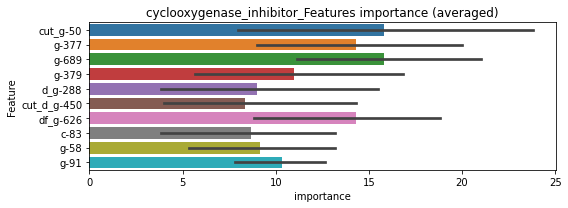

len(train_index) : 3379
len(valid_index) : 3380
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143783	valid_1's binary_logloss: 0.0848512
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.0115524	valid_1's binary_logloss: 0.084196


len(train_index) : 3380
len(valid_index) : 3379
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121265	valid_1's binary_logloss: 0.0871337
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.00981565	valid_1's binary_logloss: 0.0868249


cyclooxygenase_inhibitor logloss: 0.08551028645760667


neg labels: 3289 → selected neg labels: 3274


cytochrome_p450_inhibitor, len(trt): 104, len(othr): 3274, target_rate: 0.0043672 → Adj_target_rate: 0.0043519
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544379	valid_1's binary_logloss: 0.135982
[200]	training's binary_logloss: 0.0121634	valid_1's binary_logloss: 0.0948207
[300]	training's binary_logloss: 0.00386268	valid_1's binary_logloss: 0.0870897
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00343984	valid_1's binary_logloss: 0.086199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609379	valid_1's binary_logloss: 0.117659
[200]	training's binary_logloss: 0.0140237	valid_1's binary_logloss: 0.0729674
[300]	training's binary_logloss: 0.00439954	valid_1's binary_logloss: 0.0615547
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00435528	valid_1's binary_logloss: 0.0614211


1 / 3 AUC score:0.994
y_Threshold: 0.0188560, Threshold: 0.0213361, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 162 → Positive_corect_labels: 639/3766
p_label_rate: 0.0200904 Vs.target_rate: 0.00437
Num_p_label: 80.0, conf_0:0.01920, conf_1:0.02347
Num_p_label: 80.0, Expected: 17.4, Adj_threshold_1: 0.0213361
Num_p_label: 29.0, Expected: 17.4, Adj_threshold_2: 0.0313361
threshold: 0.0313361, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 639.0/3766, y_label_rate: 0.1696760
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509805	valid_1's binary_logloss: 0.117239
[200]	training's binary_logloss: 0.0106204	valid_1's binary_logloss: 0.0767318
[300]	training's binary_logloss: 0.00327037	valid_1's binary_logloss: 0.0666953
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0021684	valid_1's binary_logloss: 0.0647277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576071	valid_1's binary_logloss: 0.111297
[200]	training's binary_logloss: 0.0125381	valid_1's binary_logloss: 0.0634629
[300]	training's binary_logloss: 0.00392025	valid_1's binary_logloss: 0.0509287
[400]	training's binary_logloss: 0.00181684	valid_1's binary_logloss: 0.046564
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.0012447	valid_1's binary_logloss: 0.0451109


2 / 3 AUC score:0.999
y_Threshold: 0.0281331, Threshold: 0.0313361, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 630.0/3748
p_label_rate: 0.0035158 Vs.target_rate: 0.00437
Num_p_label: 14.0, conf_0:0.02820, conf_1:0.03447
threshold: 0.0313361, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 630.0/3748, y_label_rate: 0.1680896
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509184	valid_1's binary_logloss: 0.109383
[200]	training's binary_logloss: 0.0104824	valid_1's binary_logloss: 0.071726
[300]	training's binary_logloss: 0.00323871	valid_1's binary_logloss: 0.063537
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00166673	valid_1's binary_logloss: 0.060591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0517611	valid_1's binary_logloss: 0.11266
[200]	training's binary_logloss: 0.0109704	valid_1's binary_logloss: 0.0712373
[300]	training's binary_logloss: 0.00347786	valid_1's binary_logloss: 0.0623006
[400]	training's binary_logloss: 0.00164872	valid_1's binary_logloss: 0.0593797
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00169996	valid_1's binary_logloss: 0.0593645


3 / 3 AUC score:0.998
y_Threshold: 0.0260464, Threshold: 0.0313361, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 614.0/3716
p_label_rate: 0.0050226 Vs.target_rate: 0.00437
Num_p_label: 20.0, conf_0:0.02820, conf_1:0.03447
threshold: 0.0313361, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 634.0/7698, y_label_rate: 0.0823591


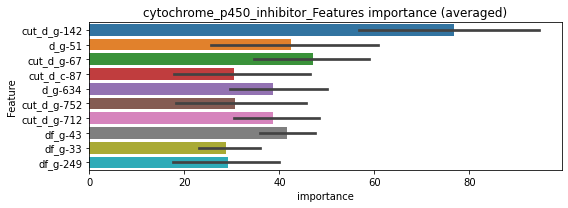

len(train_index) : 3849
len(valid_index) : 3849
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270718	valid_1's binary_logloss: 0.0671783
[200]	training's binary_logloss: 0.00554038	valid_1's binary_logloss: 0.0478721
[300]	training's binary_logloss: 0.00168266	valid_1's binary_logloss: 0.0448134
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00171661	valid_1's binary_logloss: 0.044805


len(train_index) : 3849
len(valid_index) : 3849
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02972	valid_1's binary_logloss: 0.0627492
[200]	training's binary_logloss: 0.00628357	valid_1's binary_logloss: 0.0414391
[300]	training's binary_logloss: 0.00191006	valid_1's binary_logloss: 0.0367241
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00172596	valid_1's binary_logloss: 0.0363532


cytochrome_p450_inhibitor logloss: 0.04057913432566787


neg labels: 3289 → selected neg labels: 3283


dihydrofolate_reductase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273785	valid_1's binary_logloss: 0.0399585
[200]	training's binary_logloss: 0.00374771	valid_1's binary_logloss: 0.0116066
[300]	training's binary_logloss: 0.00106955	valid_1's binary_logloss: 0.00704722
[400]	training's binary_logloss: 0.000556724	valid_1's binary_logloss: 0.00566962
[500]	training's binary_logloss: 0.00039401	valid_1's binary_logloss: 0.00524976
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000396072	valid_1's binary_logloss: 0.00524023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028106	valid_1's binary_logloss: 0.0475248
[200]	training's binary_logloss: 0.00391784	valid_1's binary_logloss: 0.0144094
[300]	training's binary_logloss: 0.00111269	valid_1's binary_logloss: 0.00766003
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000745449	valid_1's binary_logloss: 0.00647308


1 / 3 AUC score:1.000
y_Threshold: 0.0021471, Threshold: 0.0034609, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00311, conf_1:0.00381
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0034609
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.0134609
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_3: 0.0234609
threshold: 0.0234609, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275347	valid_1's binary_logloss: 0.0394533
[200]	training's binary_logloss: 0.00368926	valid_1's binary_logloss: 0.0100321
[300]	training's binary_logloss: 0.00105517	valid_1's binary_logloss: 0.00548039
[400]	training's binary_logloss: 0.000541975	valid_1's binary_logloss: 0.00433823
[500]	training's binary_logloss: 0.000388765	valid_1's binary_logloss: 0.00382591
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000376867	valid_1's binary_logloss: 0.00380122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274413	valid_1's binary_logloss: 0.0457962
[200]	training's binary_logloss: 0.00372549	valid_1's binary_logloss: 0.0125956
[300]	training's binary_logloss: 0.00105973	valid_1's binary_logloss: 0.00656996
[400]	training's binary_logloss: 0.000541897	valid_1's binary_logloss: 0.00500278
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0256632, Threshold: 0.0234609, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0050226 Vs.target_rate: 0.00151
Num_p_label: 20.0, conf_0:0.02111, conf_1:0.02581
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.0234609
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.0334609
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_3: 0.0434609
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_4: 0.0534609
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_5: 0.0634609
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_6: 0.0734609
threshold: 0.0734609, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275347	valid_1's binary_logloss: 0.0394533
[200]	training's binary_logloss: 0.00368926	valid_1's binary_logloss: 0.0100321
[300]	training's binary_logloss: 0.00105517	valid_1's binary_logloss: 0.00548039
[400]	training's binary_logloss: 0.000541975	valid_1's binary_logloss: 0.00433823
[500]	training's binary_logloss: 0.000388765	valid_1's binary_logloss: 0.00382591
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000376867	valid_1's binary_logloss: 0.00380122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274413	valid_1's binary_logloss: 0.0457962
[200]	training's binary_logloss: 0.00372549	valid_1's binary_logloss: 0.0125956
[300]	training's binary_logloss: 0.00105973	valid_1's binary_logloss: 0.00656996
[400]	training's binary_logloss: 0.000541897	valid_1's binary_logloss: 0.00500278
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0256632, Threshold: 0.0734609, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0022602 Vs.target_rate: 0.00151
Num_p_label: 9.0, conf_0:0.06611, conf_1:0.08081
threshold: 0.0734609, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7789, y_label_rate: 0.0853768


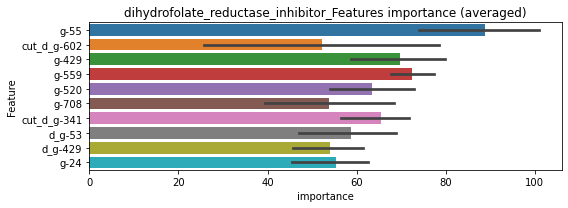

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144206	valid_1's binary_logloss: 0.0257637
[200]	training's binary_logloss: 0.00188855	valid_1's binary_logloss: 0.00897823
[300]	training's binary_logloss: 0.000538879	valid_1's binary_logloss: 0.00610672
[400]	training's binary_logloss: 0.000275715	valid_1's binary_logloss: 0.00550179
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000226623	valid_1's binary_logloss: 0.00530412


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149721	valid_1's binary_logloss: 0.0235507
[200]	training's binary_logloss: 0.00198949	valid_1's binary_logloss: 0.00715404
[300]	training's binary_logloss: 0.000566557	valid_1's binary_logloss: 0.00420973
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000306047	valid_1's binary_logloss: 0.00345291


dihydrofolate_reductase_inhibitor logloss: 0.0043786378310108455


neg labels: 3289 → selected neg labels: 3285


dipeptidyl_peptidase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275926	valid_1's binary_logloss: 0.0430973
[200]	training's binary_logloss: 0.00351638	valid_1's binary_logloss: 0.013136
[300]	training's binary_logloss: 0.000960722	valid_1's binary_logloss: 0.00815757
[400]	training's binary_logloss: 0.000490081	valid_1's binary_logloss: 0.00659083
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000392632	valid_1's binary_logloss: 0.00632011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280991	valid_1's binary_logloss: 0.0361446
[200]	training's binary_logloss: 0.00369838	valid_1's binary_logloss: 0.00714865
[300]	training's binary_logloss: 0.00102815	valid_1's binary_logloss: 0.00294511
[400]	training's binary_logloss: 0.00051742	valid_1's binary_logloss: 0.00186898
[500]	training's binary_logloss: 0.000369736	valid_1's binary_logloss: 0.00148878
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0017284, Threshold: 0.0024208, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00218, conf_1:0.00266
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0024208
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_2: 0.0124208
threshold: 0.0124208, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264623	valid_1's binary_logloss: 0.0416667
[200]	training's binary_logloss: 0.00334708	valid_1's binary_logloss: 0.0132838
[300]	training's binary_logloss: 0.000950705	valid_1's binary_logloss: 0.0086705
[400]	training's binary_logloss: 0.000484297	valid_1's binary_logloss: 0.00705077
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000404188	valid_1's binary_logloss: 0.00675295
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276144	valid_1's binary_logloss: 0.0361259
[200]	training's binary_logloss: 0.0035235	valid_1's binary_logloss: 0.00720335
[300]	training's binary_logloss: 0.00100141	valid_1's binary_logloss: 0.00297139
[400]	training's binary_logloss: 0.000512088	valid_1's binary_logloss: 0.00187311
[500]	training's binary_logloss: 0.000369223	valid_1's binary_logloss: 0.00156253
Early stopping, best iteration is:


2 / 3 AUC score:1.000
y_Threshold: 0.0509251, Threshold: 0.0124208, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0037670 Vs.target_rate: 0.00105
Num_p_label: 15.0, conf_0:0.01118, conf_1:0.01366
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_1: 0.0124208
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_2: 0.0224208
threshold: 0.0224208, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264623	valid_1's binary_logloss: 0.0416667
[200]	training's binary_logloss: 0.00334708	valid_1's binary_logloss: 0.0132838
[300]	training's binary_logloss: 0.000950705	valid_1's binary_logloss: 0.0086705
[400]	training's binary_logloss: 0.000484297	valid_1's binary_logloss: 0.00705077
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000404188	valid_1's binary_logloss: 0.00675295
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276144	valid_1's binary_logloss: 0.0361259
[200]	training's binary_logloss: 0.0035235	valid_1's binary_logloss: 0.00720335
[300]	training's binary_logloss: 0.00100141	valid_1's binary_logloss: 0.00297139
[400]	training's binary_logloss: 0.000512088	valid_1's binary_logloss: 0.00187311
[500]	training's binary_logloss: 0.000369223	valid_1's binary_logloss: 0.00156253
Early stopping, best iteration is:


3 / 3 AUC score:1.000
y_Threshold: 0.0509251, Threshold: 0.0224208, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00105
Num_p_label: 6.0, conf_0:0.02018, conf_1:0.02466
threshold: 0.0224208, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


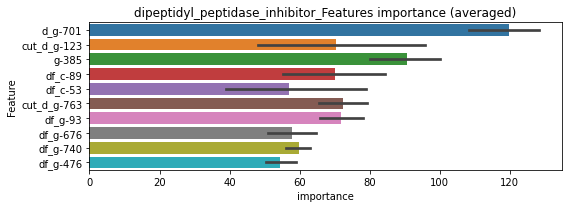

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148006	valid_1's binary_logloss: 0.0278894
[200]	training's binary_logloss: 0.00186209	valid_1's binary_logloss: 0.0119166
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.000864711	valid_1's binary_logloss: 0.0103911


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154285	valid_1's binary_logloss: 0.0231525
[200]	training's binary_logloss: 0.00197667	valid_1's binary_logloss: 0.00668419
[300]	training's binary_logloss: 0.000540945	valid_1's binary_logloss: 0.00425403
[400]	training's binary_logloss: 0.00026648	valid_1's binary_logloss: 0.00369992
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00023138	valid_1's binary_logloss: 0.00362756


dipeptidyl_peptidase_inhibitor logloss: 0.007009325862822489


neg labels: 3289 → selected neg labels: 3288


diuretic, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157169	valid_1's binary_logloss: 0.0169178
[200]	training's binary_logloss: 0.00127804	valid_1's binary_logloss: 0.00180471
[300]	training's binary_logloss: 0.000343835	valid_1's binary_logloss: 0.000694668
[400]	training's binary_logloss: 0.000211187	valid_1's binary_logloss: 0.00049528
[500]	training's binary_logloss: 0.000184142	valid_1's binary_logloss: 0.000458125
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000181552	valid_1's binary_logloss: 0.000453263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157764	valid_1's binary_logloss: 0.017649
[200]	training's binary_logloss: 0.00128801	valid_1's binary_logloss: 0.00253308
[300]	training's binary_logloss: 0.000340853	valid_1's binary_logloss: 0.00122567
[400]	training's binary_logloss: 0.000210119	valid_1's binary_logloss: 0.000976396
Early stopping, best iterati

1 / 3 AUC score:1.000
y_Threshold: 0.0004988, Threshold: 0.0008221, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00074, conf_1:0.00090
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008221
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_2: 0.0108221
threshold: 0.0108221, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161616	valid_1's binary_logloss: 0.0175096
[200]	training's binary_logloss: 0.00131063	valid_1's binary_logloss: 0.00220245
[300]	training's binary_logloss: 0.000340462	valid_1's binary_logloss: 0.000983044
[400]	training's binary_logloss: 0.000210206	valid_1's binary_logloss: 0.00080545
[500]	training's binary_logloss: 0.000183157	valid_1's binary_logloss: 0.000766838
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000183729	valid_1's binary_logloss: 0.000766414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162827	valid_1's binary_logloss: 0.0188044
[200]	training's binary_logloss: 0.00131366	valid_1's binary_logloss: 0.00341858
[300]	training's binary_logloss: 0.000343987	valid_1's binary_logloss: 0.00212505
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000276347	valid_1's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0423799, Threshold: 0.0108221, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0030136 Vs.target_rate: 0.00025
Num_p_label: 12.0, conf_0:0.00974, conf_1:0.01190
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_1: 0.0108221
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.0208221
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0308221
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.0408221
threshold: 0.0408221, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161616	valid_1's binary_logloss: 0.0175096
[200]	training's binary_logloss: 0.00131063	valid_1's binary_logloss: 0.00220245
[300]	training's binary_logloss: 0.000340462	valid_1's binary_logloss: 0.000983044
[400]	training's binary_logloss: 0.000210206	valid_1's binary_logloss: 0.00080545
[500]	training's binary_logloss: 0.000183157	valid_1's binary_logloss: 0.000766838
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000183729	valid_1's binary_logloss: 0.000766414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162827	valid_1's binary_logloss: 0.0188044
[200]	training's binary_logloss: 0.00131366	valid_1's binary_logloss: 0.00341858
[300]	training's binary_logloss: 0.000343987	valid_1's binary_logloss: 0.00212505
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000276347	valid_1's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0423799, Threshold: 0.0408221, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0002511 Vs.target_rate: 0.00025
Num_p_label: 1.0, conf_0:0.03674, conf_1:0.04490
threshold: 0.0408221, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7795, y_label_rate: 0.0844131


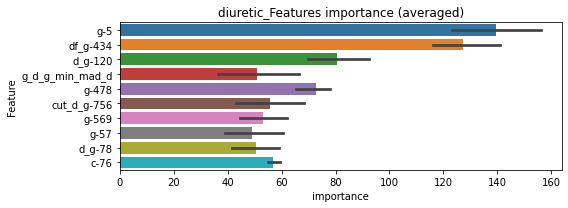

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00850204	valid_1's binary_logloss: 0.00969017
[200]	training's binary_logloss: 0.000667617	valid_1's binary_logloss: 0.00173967
[300]	training's binary_logloss: 0.000171279	valid_1's binary_logloss: 0.00123256
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.000129292	valid_1's binary_logloss: 0.00119717


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00853214	valid_1's binary_logloss: 0.00972978
[200]	training's binary_logloss: 0.000701184	valid_1's binary_logloss: 0.00150972
[300]	training's binary_logloss: 0.000176855	valid_1's binary_logloss: 0.000693423
[400]	training's binary_logloss: 0.000107153	valid_1's binary_logloss: 0.000533126
[500]	training's binary_logloss: 9.23486e-05	valid_1's binary_logloss: 0.000496363
Early stopping, best iteration is:
[495]	training's binary_logloss: 9.24131e-05	valid_1's binary_logloss: 0.000496209


diuretic logloss: 0.0008467357300696353


neg labels: 3289 → selected neg labels: 3281


dna_alkylating_agent, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347388	valid_1's binary_logloss: 0.0740213
[200]	training's binary_logloss: 0.00562904	valid_1's binary_logloss: 0.0396274
[300]	training's binary_logloss: 0.00163187	valid_1's binary_logloss: 0.0318839
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000970103	valid_1's binary_logloss: 0.030412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381153	valid_1's binary_logloss: 0.0680789
[200]	training's binary_logloss: 0.00630858	valid_1's binary_logloss: 0.0264705
[300]	training's binary_logloss: 0.00183046	valid_1's binary_logloss: 0.0170032
[400]	training's binary_logloss: 0.000882681	valid_1's binary_logloss: 0.0147069
[500]	training's binary_logloss: 0.000577952	valid_1's binary_logloss: 0.0139376
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000593002	valid_1's binary_logloss: 0.0139148


1 / 3 AUC score:0.999
y_Threshold: 0.0053910, Threshold: 0.0083076, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 654/3801
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.00748, conf_1:0.00914
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0083076
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_2: 0.0183076
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_3: 0.0283076
threshold: 0.0283076, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359712	valid_1's binary_logloss: 0.0701915
[200]	training's binary_logloss: 0.00545021	valid_1's binary_logloss: 0.032571
[300]	training's binary_logloss: 0.00159707	valid_1's binary_logloss: 0.0246123
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00124044	valid_1's binary_logloss: 0.0238834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037372	valid_1's binary_logloss: 0.0656358
[200]	training's binary_logloss: 0.00588145	valid_1's binary_logloss: 0.0250613
[300]	training's binary_logloss: 0.00169725	valid_1's binary_logloss: 0.0179769
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00111271	valid_1's binary_logloss: 0.0170557


2 / 3 AUC score:1.000
y_Threshold: 0.0233552, Threshold: 0.0283076, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 651.0/3795
p_label_rate: 0.0110497 Vs.target_rate: 0.00202
Num_p_label: 44.0, conf_0:0.02548, conf_1:0.03114
Num_p_label: 44.0, Expected: 8.0, Adj_threshold_1: 0.0283076
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_2: 0.0383076
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_3: 0.0483076
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_4: 0.0583076
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_5: 0.0683076
threshold: 0.0683076, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 651.0/3795, y_label_rate: 0.1715415
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035419	valid_1's binary_logloss: 0.0611545
[200]	training's binary_logloss: 0.00544946	valid_1's binary_logloss: 0.0223815
[300]	training's binary_logloss: 0.00155729	valid_1's binary_logloss: 0.0152188
[400]	training's binary_logloss: 0.000787775	valid_1's binary_logloss: 0.013007
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000617255	valid_1's binary_logloss: 0.0124064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368516	valid_1's binary_logloss: 0.0614283
[200]	training's binary_logloss: 0.00594955	valid_1's binary_logloss: 0.0219613
[300]	training's binary_logloss: 0.00174452	valid_1's binary_logloss: 0.0143683
[400]	training's binary_logloss: 0.000844007	valid_1's binary_logloss: 0.0118089
[500]	training's binary_logloss: 0.000560191	valid_1's binary_logloss: 0.0108584
Early stopping, best iteration is:
[542]	tr

3 / 3 AUC score:1.000
y_Threshold: 0.0351020, Threshold: 0.0683076, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 650.0/3793
p_label_rate: 0.0030136 Vs.target_rate: 0.00202
Num_p_label: 12.0, conf_0:0.06148, conf_1:0.07514
threshold: 0.0683076, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 662.0/7775, y_label_rate: 0.0851447


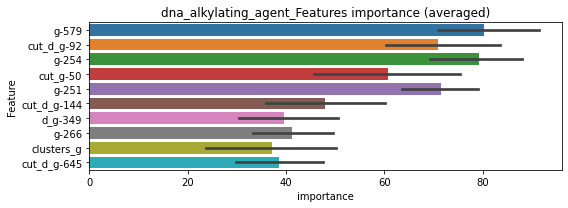

len(train_index) : 3887
len(valid_index) : 3888
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185935	valid_1's binary_logloss: 0.0423402
[200]	training's binary_logloss: 0.00291792	valid_1's binary_logloss: 0.0243754
[300]	training's binary_logloss: 0.000818917	valid_1's binary_logloss: 0.0213261
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000448267	valid_1's binary_logloss: 0.0206137


len(train_index) : 3888
len(valid_index) : 3887
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192713	valid_1's binary_logloss: 0.0384814
[200]	training's binary_logloss: 0.00307173	valid_1's binary_logloss: 0.0180896
[300]	training's binary_logloss: 0.000888634	valid_1's binary_logloss: 0.0131118
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000656911	valid_1's binary_logloss: 0.0123452


dna_alkylating_agent logloss: 0.016479949178122243


neg labels: 3289 → selected neg labels: 3229


dna_inhibitor, len(trt): 402, len(othr): 3229, target_rate: 0.0168808 → Adj_target_rate: 0.0137338
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113254	valid_1's binary_logloss: 0.34666
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0849297	valid_1's binary_logloss: 0.343153
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111272	valid_1's binary_logloss: 0.352917
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.0778664	valid_1's binary_logloss: 0.34694


1 / 3 AUC score:0.816
y_Threshold: 0.1214036, Threshold: 0.1775289, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 632 → Positive_corect_labels: 394/3242
p_label_rate: 0.0200904 Vs.target_rate: 0.01688
Num_p_label: 80.0, conf_0:0.15978, conf_1:0.19528
threshold: 0.1775289, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 394.0/3242, y_label_rate: 0.1215299
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606658	valid_1's binary_logloss: 0.209973
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0227919	valid_1's binary_logloss: 0.195044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609781	valid_1's binary_logloss: 0.220373
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0398558	valid_1's binary_logloss: 0.21297


2 / 3 AUC score:0.932
y_Threshold: 0.0814981, Threshold: 0.1775289, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 182 → Positive_corect_labels: 303.0/3060
p_label_rate: 0.0411853 Vs.target_rate: 0.01688
Num_p_label: 164.0, conf_0:0.15978, conf_1:0.19528
threshold: 0.1775289, positive_p_label: 164.0/3982, p_label_rate: 0.0411853
positive_y_label: 303.0/3060, y_label_rate: 0.0990196
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401855	valid_1's binary_logloss: 0.14641
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0134877	valid_1's binary_logloss: 0.130765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400404	valid_1's binary_logloss: 0.166357
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.0174311	valid_1's binary_logloss: 0.155754


3 / 3 AUC score:0.971
y_Threshold: 0.0549988, Threshold: 0.1775289, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 118 → Positive_corect_labels: 244.0/2942
p_label_rate: 0.0577599 Vs.target_rate: 0.01688
Num_p_label: 230.0, conf_0:0.15978, conf_1:0.19528
Num_p_label: 230.0, Expected: 67.2, Adj_threshold_1: 0.1775289
Num_p_label: 224.0, Expected: 67.2, Adj_threshold_2: 0.1875289
Num_p_label: 220.0, Expected: 67.2, Adj_threshold_3: 0.1975289
Num_p_label: 218.0, Expected: 67.2, Adj_threshold_4: 0.2075289
Num_p_label: 210.0, Expected: 67.2, Adj_threshold_5: 0.2175289
Num_p_label: 210.0, Expected: 67.2, Adj_threshold_6: 0.2275289
Num_p_label: 204.0, Expected: 67.2, Adj_threshold_7: 0.2375289
Num_p_label: 203.0, Expected: 67.2, Adj_threshold_8: 0.2475289
Num_p_label: 202.0, Expected: 67.2, Adj_threshold_9: 0.2575289
Num_p_label: 200.0, Expected: 67.2, Adj_threshold_10: 0.2675289
threshold: 0.2775289, positive_p_label: 197.0/3982, p_label_rate: 0.0494726
positive_y_label: 441.0/6924, y_label_r

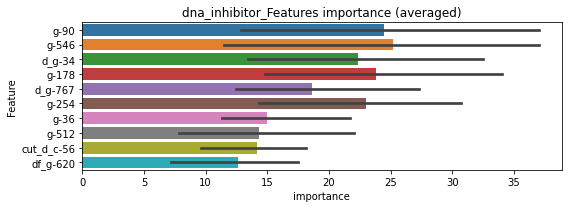

len(train_index) : 3462
len(valid_index) : 3462
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204024	valid_1's binary_logloss: 0.0788138
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.00742596	valid_1's binary_logloss: 0.0737399


len(train_index) : 3462
len(valid_index) : 3462
================================= fold 2/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190026	valid_1's binary_logloss: 0.0828052
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00716605	valid_1's binary_logloss: 0.0786753


dna_inhibitor logloss: 0.0762076197930029


neg labels: 3289 → selected neg labels: 3267


dopamine_receptor_agonist, len(trt): 121, len(othr): 3267, target_rate: 0.0050810 → Adj_target_rate: 0.0049495
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632564	valid_1's binary_logloss: 0.144502
[200]	training's binary_logloss: 0.0162159	valid_1's binary_logloss: 0.10651
[300]	training's binary_logloss: 0.00508603	valid_1's binary_logloss: 0.09964
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00451183	valid_1's binary_logloss: 0.0988721
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0680289	valid_1's binary_logloss: 0.157577
[200]	training's binary_logloss: 0.0179544	valid_1's binary_logloss: 0.115542
[300]	training's binary_logloss: 0.00564497	valid_1's binary_logloss: 0.106414
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00591888	valid_1's binary_logloss: 0.106147


1 / 3 AUC score:0.989
y_Threshold: 0.0231070, Threshold: 0.0287623, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 181 → Positive_corect_labels: 628/3739
p_label_rate: 0.0200904 Vs.target_rate: 0.00508
Num_p_label: 80.0, conf_0:0.02589, conf_1:0.03164
Num_p_label: 80.0, Expected: 20.2, Adj_threshold_1: 0.0287623
Num_p_label: 30.0, Expected: 20.2, Adj_threshold_2: 0.0387623
threshold: 0.0387623, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 628.0/3739, y_label_rate: 0.1679593
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057518	valid_1's binary_logloss: 0.12996
[200]	training's binary_logloss: 0.0134097	valid_1's binary_logloss: 0.0909721
[300]	training's binary_logloss: 0.00421487	valid_1's binary_logloss: 0.0849619
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00346418	valid_1's binary_logloss: 0.0843661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617883	valid_1's binary_logloss: 0.14157
[200]	training's binary_logloss: 0.0159404	valid_1's binary_logloss: 0.0988964
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00815474	valid_1's binary_logloss: 0.0920707


2 / 3 AUC score:0.992
y_Threshold: 0.0502524, Threshold: 0.0387623, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 62 → Positive_corect_labels: 597.0/3677
p_label_rate: 0.0233551 Vs.target_rate: 0.00508
Num_p_label: 93.0, conf_0:0.03489, conf_1:0.04264
Num_p_label: 93.0, Expected: 20.2, Adj_threshold_1: 0.0387623
Num_p_label: 59.0, Expected: 20.2, Adj_threshold_2: 0.0487623
Num_p_label: 29.0, Expected: 20.2, Adj_threshold_3: 0.0587623
threshold: 0.0587623, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 597.0/3677, y_label_rate: 0.1623606
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530998	valid_1's binary_logloss: 0.124603
[200]	training's binary_logloss: 0.0117101	valid_1's binary_logloss: 0.0827858
[300]	training's binary_logloss: 0.00360376	valid_1's binary_logloss: 0.0729495
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00269967	valid_1's binary_logloss: 0.0722353
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566898	valid_1's binary_logloss: 0.122175
[200]	training's binary_logloss: 0.0128837	valid_1's binary_logloss: 0.0773353
[300]	training's binary_logloss: 0.00399707	valid_1's binary_logloss: 0.0644861
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00280331	valid_1's binary_logloss: 0.0625669


3 / 3 AUC score:0.998
y_Threshold: 0.0374910, Threshold: 0.0587623, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 581.0/3645
p_label_rate: 0.0027624 Vs.target_rate: 0.00508
Num_p_label: 11.0, conf_0:0.05289, conf_1:0.06464
threshold: 0.0587623, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 592.0/7627, y_label_rate: 0.0776190


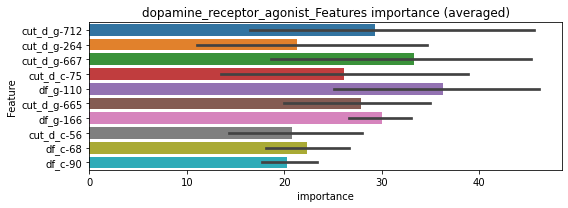

len(train_index) : 3813
len(valid_index) : 3814
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287941	valid_1's binary_logloss: 0.0714594
[200]	training's binary_logloss: 0.006257	valid_1's binary_logloss: 0.0489166
[300]	training's binary_logloss: 0.00192443	valid_1's binary_logloss: 0.0444755
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00125339	valid_1's binary_logloss: 0.0435239


len(train_index) : 3814
len(valid_index) : 3813
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268613	valid_1's binary_logloss: 0.0700258
[200]	training's binary_logloss: 0.00558241	valid_1's binary_logloss: 0.049809
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00208364	valid_1's binary_logloss: 0.0469687


dopamine_receptor_agonist logloss: 0.04524607264302847


neg labels: 3289 → selected neg labels: 3221


dopamine_receptor_antagonist, len(trt): 424, len(othr): 3221, target_rate: 0.0178047 → Adj_target_rate: 0.0143701
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122075	valid_1's binary_logloss: 0.367643
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.115713	valid_1's binary_logloss: 0.367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124232	valid_1's binary_logloss: 0.365111
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0781957	valid_1's binary_logloss: 0.360103


1 / 3 AUC score:0.780
y_Threshold: 0.1432103, Threshold: 0.1897116, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 701 → Positive_corect_labels: 358/3164
p_label_rate: 0.0200904 Vs.target_rate: 0.01780
Num_p_label: 80.0, conf_0:0.17074, conf_1:0.20868
threshold: 0.1897116, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 358.0/3164, y_label_rate: 0.1131479
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613393	valid_1's binary_logloss: 0.238745
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.0478555	valid_1's binary_logloss: 0.235854
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608206	valid_1's binary_logloss: 0.233414
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.0271838	valid_1's binary_logloss: 0.227124


2 / 3 AUC score:0.915
y_Threshold: 0.0905226, Threshold: 0.1897116, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 238 → Positive_corect_labels: 239.0/2926
p_label_rate: 0.0040181 Vs.target_rate: 0.01780
Num_p_label: 16.0, conf_0:0.17074, conf_1:0.20868
Num_p_label: 16.0, Expected: 70.9, Adj_threshold_1: 0.1897116
Num_p_label: 20.0, Expected: 70.9, Adj_threshold_2: 0.1797116
Num_p_label: 26.0, Expected: 70.9, Adj_threshold_3: 0.1697116
Num_p_label: 31.0, Expected: 70.9, Adj_threshold_4: 0.1597116
Num_p_label: 34.0, Expected: 70.9, Adj_threshold_5: 0.1497116
Num_p_label: 53.0, Expected: 70.9, Adj_threshold_6: 0.1397116
threshold: 0.1397116, positive_p_label: 53.0/3982, p_label_rate: 0.0133099
positive_y_label: 239.0/2926, y_label_rate: 0.0816815
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365419	valid_1's binary_logloss: 0.139494
[200]	training's binary_logloss: 0.00856944	valid_1's binary_logloss: 0.122591
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00623005	valid_1's binary_logloss: 0.120863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352477	valid_1's binary_logloss: 0.150394
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0122833	valid_1's binary_logloss: 0.139911


3 / 3 AUC score:0.978
y_Threshold: 0.0558949, Threshold: 0.1397116, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 80 → Positive_corect_labels: 199.0/2846
p_label_rate: 0.0057760 Vs.target_rate: 0.01780
Num_p_label: 23.0, conf_0:0.12574, conf_1:0.15368
Num_p_label: 23.0, Expected: 70.9, Adj_threshold_1: 0.1397116
Num_p_label: 30.0, Expected: 70.9, Adj_threshold_2: 0.1297116
Num_p_label: 34.0, Expected: 70.9, Adj_threshold_3: 0.1197116
Num_p_label: 45.0, Expected: 70.9, Adj_threshold_4: 0.1097116
threshold: 0.1097116, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 244.0/6828, y_label_rate: 0.0357352


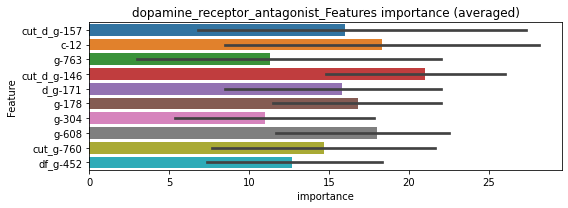

len(train_index) : 3414
len(valid_index) : 3414
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155016	valid_1's binary_logloss: 0.100143
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.00747498	valid_1's binary_logloss: 0.0971877


len(train_index) : 3414
len(valid_index) : 3414
================================= fold 2/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015048	valid_1's binary_logloss: 0.0922359
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0127712	valid_1's binary_logloss: 0.0920678


dopamine_receptor_antagonist logloss: 0.0946277622850868


neg labels: 3289 → selected neg labels: 3264


egfr_inhibitor, len(trt): 336, len(othr): 3264, target_rate: 0.0141093 → Adj_target_rate: 0.0117920
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438327	valid_1's binary_logloss: 0.1217
[200]	training's binary_logloss: 0.00828267	valid_1's binary_logloss: 0.0981081
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00640279	valid_1's binary_logloss: 0.0967511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458887	valid_1's binary_logloss: 0.109429
[200]	training's binary_logloss: 0.00901317	valid_1's binary_logloss: 0.0823872
[300]	training's binary_logloss: 0.00283289	valid_1's binary_logloss: 0.077849
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0025935	valid_1's binary_logloss: 0.07747


1 / 3 AUC score:0.987
y_Threshold: 0.0294153, Threshold: 0.2334236, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 196 → Positive_corect_labels: 620/3720
p_label_rate: 0.0200904 Vs.target_rate: 0.01411
Num_p_label: 80.0, conf_0:0.21008, conf_1:0.25677
threshold: 0.2334236, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 620.0/3720, y_label_rate: 0.1666667
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361866	valid_1's binary_logloss: 0.0918183
[200]	training's binary_logloss: 0.00597262	valid_1's binary_logloss: 0.0678971
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00230683	valid_1's binary_logloss: 0.0654203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354781	valid_1's binary_logloss: 0.0935315
[200]	training's binary_logloss: 0.00605147	valid_1's binary_logloss: 0.0654109
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00343822	valid_1's binary_logloss: 0.0618409


2 / 3 AUC score:0.993
y_Threshold: 0.0787481, Threshold: 0.2334236, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 56 → Positive_corect_labels: 592.0/3664
p_label_rate: 0.0308890 Vs.target_rate: 0.01411
Num_p_label: 123.0, conf_0:0.21008, conf_1:0.25677
threshold: 0.2334236, positive_p_label: 123.0/3982, p_label_rate: 0.0308890
positive_y_label: 592.0/3664, y_label_rate: 0.1615721
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312117	valid_1's binary_logloss: 0.0816708
[200]	training's binary_logloss: 0.00477235	valid_1's binary_logloss: 0.0567849
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00228388	valid_1's binary_logloss: 0.0525045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333904	valid_1's binary_logloss: 0.073503
[200]	training's binary_logloss: 0.00505032	valid_1's binary_logloss: 0.0471628
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0029269	valid_1's binary_logloss: 0.0452247


3 / 3 AUC score:0.996
y_Threshold: 0.0614684, Threshold: 0.2334236, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 574.0/3628
p_label_rate: 0.0298845 Vs.target_rate: 0.01411
Num_p_label: 119.0, conf_0:0.21008, conf_1:0.25677
threshold: 0.2334236, positive_p_label: 119.0/3982, p_label_rate: 0.0298845
positive_y_label: 693.0/7610, y_label_rate: 0.0910644


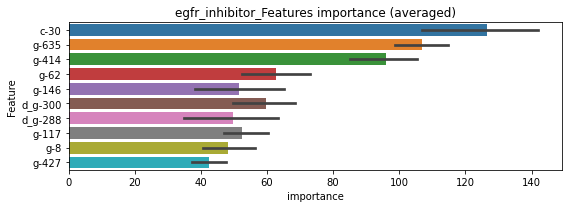

len(train_index) : 3805
len(valid_index) : 3805
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178897	valid_1's binary_logloss: 0.0562664
[200]	training's binary_logloss: 0.00271226	valid_1's binary_logloss: 0.037897
[300]	training's binary_logloss: 0.000812588	valid_1's binary_logloss: 0.0336197
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000595755	valid_1's binary_logloss: 0.0332847


len(train_index) : 3805
len(valid_index) : 3805
================================= fold 2/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184765	valid_1's binary_logloss: 0.0475266
[200]	training's binary_logloss: 0.00287166	valid_1's binary_logloss: 0.0293475
[300]	training's binary_logloss: 0.00087249	valid_1's binary_logloss: 0.0258381
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000753134	valid_1's binary_logloss: 0.0254219


egfr_inhibitor logloss: 0.029353332785128826


neg labels: 3289 → selected neg labels: 3287


elastase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195208	valid_1's binary_logloss: 0.0249617
[200]	training's binary_logloss: 0.00207532	valid_1's binary_logloss: 0.00460345
[300]	training's binary_logloss: 0.000579471	valid_1's binary_logloss: 0.0019557
[400]	training's binary_logloss: 0.000312804	valid_1's binary_logloss: 0.00136021
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000268973	valid_1's binary_logloss: 0.0012742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192528	valid_1's binary_logloss: 0.0230903
[200]	training's binary_logloss: 0.00200045	valid_1's binary_logloss: 0.00400722
[300]	training's binary_logloss: 0.000574929	valid_1's binary_logloss: 0.00211454
[400]	training's binary_logloss: 0.000315672	valid_1's binary_logloss: 0.00165939
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000269297	valid_1's binary_logloss: 0.0015840

1 / 3 AUC score:1.000
y_Threshold: 0.0007848, Threshold: 0.0011751, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00106, conf_1:0.00129
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0011751
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_2: 0.0111751
threshold: 0.0111751, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198174	valid_1's binary_logloss: 0.0253021
[200]	training's binary_logloss: 0.00203273	valid_1's binary_logloss: 0.00523492
[300]	training's binary_logloss: 0.000581455	valid_1's binary_logloss: 0.00280774
[400]	training's binary_logloss: 0.000316725	valid_1's binary_logloss: 0.00224077
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000306736	valid_1's binary_logloss: 0.00221855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195186	valid_1's binary_logloss: 0.0230727
[200]	training's binary_logloss: 0.00198575	valid_1's binary_logloss: 0.00351621
[300]	training's binary_logloss: 0.000569287	valid_1's binary_logloss: 0.00169019
[400]	training's binary_logloss: 0.000315008	valid_1's binary_logloss: 0.00128099
[500]	training's binary_logloss: 0.000271335	valid_1's binary_logloss: 0.00122635
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0257812, Threshold: 0.0111751, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050
Num_p_label: 3.0, conf_0:0.01006, conf_1:0.01229
threshold: 0.0111751, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198174	valid_1's binary_logloss: 0.0253021
[200]	training's binary_logloss: 0.00203273	valid_1's binary_logloss: 0.00523492
[300]	training's binary_logloss: 0.000581455	valid_1's binary_logloss: 0.00280774
[400]	training's binary_logloss: 0.000316725	valid_1's binary_logloss: 0.00224077
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000306736	valid_1's binary_logloss: 0.00221855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195186	valid_1's binary_logloss: 0.0230727
[200]	training's binary_logloss: 0.00198575	valid_1's binary_logloss: 0.00351621
[300]	training's binary_logloss: 0.000569287	valid_1's binary_logloss: 0.00169019
[400]	training's binary_logloss: 0.000315008	valid_1's binary_logloss: 0.00128099
[500]	training's binary_logloss: 0.000271335	valid_1's binary_logloss: 0.00122635
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0257812, Threshold: 0.0111751, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050
Num_p_label: 3.0, conf_0:0.01006, conf_1:0.01229
threshold: 0.0111751, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


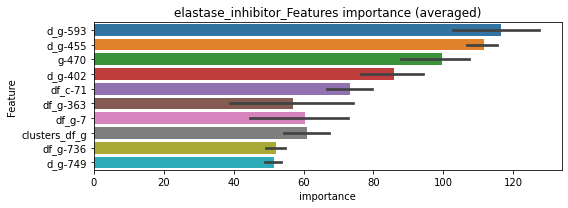

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100855	valid_1's binary_logloss: 0.0147123
[200]	training's binary_logloss: 0.00101804	valid_1's binary_logloss: 0.00510039
[300]	training's binary_logloss: 0.000286267	valid_1's binary_logloss: 0.00438551
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00023729	valid_1's binary_logloss: 0.00435712


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105673	valid_1's binary_logloss: 0.0169298
[200]	training's binary_logloss: 0.00110442	valid_1's binary_logloss: 0.00588955
[300]	training's binary_logloss: 0.000292852	valid_1's binary_logloss: 0.00400178
[400]	training's binary_logloss: 0.000158729	valid_1's binary_logloss: 0.00351246
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000140179	valid_1's binary_logloss: 0.00346363


elastase_inhibitor logloss: 0.003910373616567893


neg labels: 3289 → selected neg labels: 3284


erbb2_inhibitor, len(trt): 20, len(othr): 3284, target_rate: 0.0008398 → Adj_target_rate: 0.0010717
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024904	valid_1's binary_logloss: 0.0330311
[200]	training's binary_logloss: 0.00304935	valid_1's binary_logloss: 0.00661986
[300]	training's binary_logloss: 0.000853977	valid_1's binary_logloss: 0.00302329
[400]	training's binary_logloss: 0.000442488	valid_1's binary_logloss: 0.00230567
[500]	training's binary_logloss: 0.000339476	valid_1's binary_logloss: 0.00208241
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000336941	valid_1's binary_logloss: 0.00207606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258105	valid_1's binary_logloss: 0.0333869
[200]	training's binary_logloss: 0.00318538	valid_1's binary_logloss: 0.00698887
[300]	training's binary_logloss: 0.000885272	valid_1's binary_logloss: 0.00353141
[400]	training's binary_logloss: 0.000454046	valid_1's binary_logloss: 0.00261566
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0012820, Threshold: 0.0016418, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00084
Num_p_label: 80.0, conf_0:0.00148, conf_1:0.00181
Num_p_label: 80.0, Expected: 3.3, Adj_threshold_1: 0.0016418
Num_p_label: 0.0, Expected: 3.3, Adj_threshold_2: 0.0116418
threshold: 0.0116418, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252355	valid_1's binary_logloss: 0.0337832
[200]	training's binary_logloss: 0.00305458	valid_1's binary_logloss: 0.00636644
[300]	training's binary_logloss: 0.000858776	valid_1's binary_logloss: 0.00276182
[400]	training's binary_logloss: 0.000443708	valid_1's binary_logloss: 0.00189963
[500]	training's binary_logloss: 0.000345356	valid_1's binary_logloss: 0.00170022
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000346451	valid_1's binary_logloss: 0.00169823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026024	valid_1's binary_logloss: 0.0326532
[200]	training's binary_logloss: 0.0031507	valid_1's binary_logloss: 0.00641534
[300]	training's binary_logloss: 0.000870568	valid_1's binary_logloss: 0.00304058
[400]	training's binary_logloss: 0.000448936	valid_1's binary_logloss: 0.00219201
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.0567270, Threshold: 0.0116418, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0005023 Vs.target_rate: 0.00084
Num_p_label: 2.0, conf_0:0.01048, conf_1:0.01281
threshold: 0.0116418, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252355	valid_1's binary_logloss: 0.0337832
[200]	training's binary_logloss: 0.00305458	valid_1's binary_logloss: 0.00636644
[300]	training's binary_logloss: 0.000858776	valid_1's binary_logloss: 0.00276182
[400]	training's binary_logloss: 0.000443708	valid_1's binary_logloss: 0.00189963
[500]	training's binary_logloss: 0.000345356	valid_1's binary_logloss: 0.00170022
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000346451	valid_1's binary_logloss: 0.00169823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026024	valid_1's binary_logloss: 0.0326532
[200]	training's binary_logloss: 0.0031507	valid_1's binary_logloss: 0.00641534
[300]	training's binary_logloss: 0.000870568	valid_1's binary_logloss: 0.00304058
[400]	training's binary_logloss: 0.000448936	valid_1's binary_logloss: 0.00219201
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.0567270, Threshold: 0.0116418, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0005023 Vs.target_rate: 0.00084
Num_p_label: 2.0, conf_0:0.01048, conf_1:0.01281
threshold: 0.0116418, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 658.0/7790, y_label_rate: 0.0844673


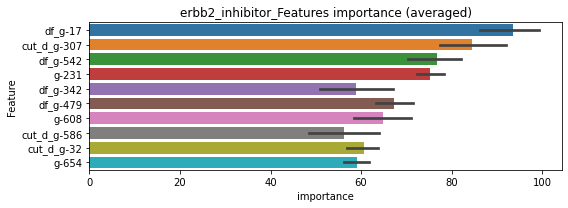

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131869	valid_1's binary_logloss: 0.021282
[200]	training's binary_logloss: 0.00156097	valid_1's binary_logloss: 0.00677429
[300]	training's binary_logloss: 0.000423405	valid_1's binary_logloss: 0.00493271
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000267611	valid_1's binary_logloss: 0.00459276


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134945	valid_1's binary_logloss: 0.0173604
[200]	training's binary_logloss: 0.00162597	valid_1's binary_logloss: 0.00373022
[300]	training's binary_logloss: 0.000441179	valid_1's binary_logloss: 0.00220693
[400]	training's binary_logloss: 0.00022454	valid_1's binary_logloss: 0.00189891
[500]	training's binary_logloss: 0.000175538	valid_1's binary_logloss: 0.00183416
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000174193	valid_1's binary_logloss: 0.00183195


erbb2_inhibitor logloss: 0.0032123533913144603


neg labels: 3289 → selected neg labels: 3265


estrogen_receptor_agonist, len(trt): 158, len(othr): 3265, target_rate: 0.0066348 → Adj_target_rate: 0.0062095
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0680613	valid_1's binary_logloss: 0.17542
[200]	training's binary_logloss: 0.019316	valid_1's binary_logloss: 0.137761
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0132574	valid_1's binary_logloss: 0.133667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0735011	valid_1's binary_logloss: 0.170705
[200]	training's binary_logloss: 0.0212196	valid_1's binary_logloss: 0.131205
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0126044	valid_1's binary_logloss: 0.12445


1 / 3 AUC score:0.980
y_Threshold: 0.0440723, Threshold: 0.0577456, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 213 → Positive_corect_labels: 612/3705
p_label_rate: 0.0200904 Vs.target_rate: 0.00663
Num_p_label: 80.0, conf_0:0.05197, conf_1:0.06352
Num_p_label: 80.0, Expected: 26.4, Adj_threshold_1: 0.0577456
Num_p_label: 49.0, Expected: 26.4, Adj_threshold_2: 0.0677456
threshold: 0.0677456, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 612.0/3705, y_label_rate: 0.1651822
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595886	valid_1's binary_logloss: 0.158246
[200]	training's binary_logloss: 0.014261	valid_1's binary_logloss: 0.121463
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00543796	valid_1's binary_logloss: 0.113986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0655172	valid_1's binary_logloss: 0.153392
[200]	training's binary_logloss: 0.0164257	valid_1's binary_logloss: 0.110268
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00733627	valid_1's binary_logloss: 0.101235


2 / 3 AUC score:0.989
y_Threshold: 0.0546366, Threshold: 0.0677456, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 82 → Positive_corect_labels: 571.0/3623
p_label_rate: 0.0107986 Vs.target_rate: 0.00663
Num_p_label: 43.0, conf_0:0.06097, conf_1:0.07452
threshold: 0.0677456, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 571.0/3623, y_label_rate: 0.1576042
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0517489	valid_1's binary_logloss: 0.127778
[200]	training's binary_logloss: 0.0116408	valid_1's binary_logloss: 0.0903495
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00439355	valid_1's binary_logloss: 0.0823691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0543638	valid_1's binary_logloss: 0.125624
[200]	training's binary_logloss: 0.0125264	valid_1's binary_logloss: 0.0849676
[300]	training's binary_logloss: 0.00402707	valid_1's binary_logloss: 0.0755409
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.0021864	valid_1's binary_logloss: 0.0730978


3 / 3 AUC score:0.997
y_Threshold: 0.0340615, Threshold: 0.0677456, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 552.0/3585
p_label_rate: 0.0022602 Vs.target_rate: 0.00663
Num_p_label: 9.0, conf_0:0.06097, conf_1:0.07452
threshold: 0.0677456, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 561.0/7567, y_label_rate: 0.0741377


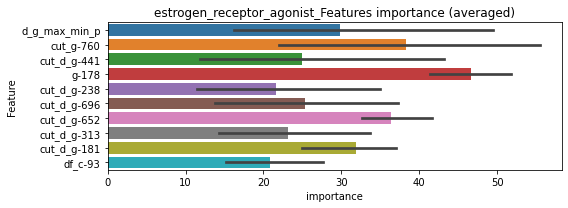

len(train_index) : 3783
len(valid_index) : 3784
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025851	valid_1's binary_logloss: 0.0720505
[200]	training's binary_logloss: 0.00566482	valid_1's binary_logloss: 0.0542819
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00320243	valid_1's binary_logloss: 0.0527434


len(train_index) : 3784
len(valid_index) : 3783
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274066	valid_1's binary_logloss: 0.0689899
[200]	training's binary_logloss: 0.00613775	valid_1's binary_logloss: 0.0494119
[300]	training's binary_logloss: 0.0018954	valid_1's binary_logloss: 0.0443713
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00109356	valid_1's binary_logloss: 0.0436607


estrogen_receptor_agonist logloss: 0.04820264347940824


neg labels: 3289 → selected neg labels: 3283


estrogen_receptor_antagonist, len(trt): 48, len(othr): 3283, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363437	valid_1's binary_logloss: 0.0726949
[200]	training's binary_logloss: 0.00593431	valid_1's binary_logloss: 0.0331816
[300]	training's binary_logloss: 0.00172685	valid_1's binary_logloss: 0.0248873
[400]	training's binary_logloss: 0.000849697	valid_1's binary_logloss: 0.0218719
[500]	training's binary_logloss: 0.000556737	valid_1's binary_logloss: 0.0206394
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000538282	valid_1's binary_logloss: 0.0205148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400484	valid_1's binary_logloss: 0.0639564
[200]	training's binary_logloss: 0.00699631	valid_1's binary_logloss: 0.0214489
[300]	training's binary_logloss: 0.0020234	valid_1's binary_logloss: 0.0125617
[400]	training's binary_logloss: 0.000958256	valid_1's binary_logloss: 0.00993517
[500]	training's binary_logloss: 0.000612

1 / 3 AUC score:1.000
y_Threshold: 0.0032851, Threshold: 0.0051982, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.00468, conf_1:0.00572
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0051982
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_2: 0.0151982
threshold: 0.0151982, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367634	valid_1's binary_logloss: 0.072517
[200]	training's binary_logloss: 0.00587315	valid_1's binary_logloss: 0.0307716
[300]	training's binary_logloss: 0.00172276	valid_1's binary_logloss: 0.0213545
[400]	training's binary_logloss: 0.000851538	valid_1's binary_logloss: 0.0183845
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000616642	valid_1's binary_logloss: 0.0176077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413829	valid_1's binary_logloss: 0.0647368
[200]	training's binary_logloss: 0.00687137	valid_1's binary_logloss: 0.0208625
[300]	training's binary_logloss: 0.00198209	valid_1's binary_logloss: 0.0123466
[400]	training's binary_logloss: 0.000936836	valid_1's binary_logloss: 0.00961584
[500]	training's binary_logloss: 0.000597252	valid_1's binary_logloss: 0.00864576
Early stopping, best iteration is:
[541]

2 / 3 AUC score:1.000
y_Threshold: 0.0208631, Threshold: 0.0151982, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0085384 Vs.target_rate: 0.00202
Num_p_label: 34.0, conf_0:0.01368, conf_1:0.01672
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_1: 0.0151982
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_2: 0.0251982
threshold: 0.0251982, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384158	valid_1's binary_logloss: 0.0672344
[200]	training's binary_logloss: 0.00644679	valid_1's binary_logloss: 0.0255482
[300]	training's binary_logloss: 0.00186434	valid_1's binary_logloss: 0.0174011
[400]	training's binary_logloss: 0.000894564	valid_1's binary_logloss: 0.0151136
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000705344	valid_1's binary_logloss: 0.0144999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375459	valid_1's binary_logloss: 0.0681335
[200]	training's binary_logloss: 0.00602773	valid_1's binary_logloss: 0.0283455
[300]	training's binary_logloss: 0.00178626	valid_1's binary_logloss: 0.0207082
[400]	training's binary_logloss: 0.000868944	valid_1's binary_logloss: 0.0182485
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000748278	valid_1's binary_logloss: 0.0179016


3 / 3 AUC score:1.000
y_Threshold: 0.0219251, Threshold: 0.0251982, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0037670 Vs.target_rate: 0.00202
Num_p_label: 15.0, conf_0:0.02268, conf_1:0.02772
threshold: 0.0251982, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 668.0/7783, y_label_rate: 0.0858281


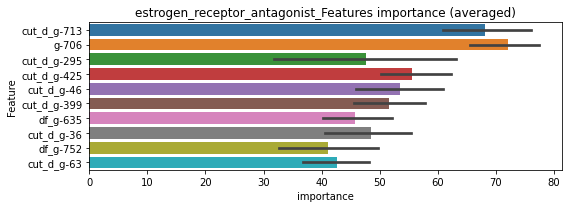

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212665	valid_1's binary_logloss: 0.0424034
[200]	training's binary_logloss: 0.0034982	valid_1's binary_logloss: 0.0208495
[300]	training's binary_logloss: 0.0010166	valid_1's binary_logloss: 0.0172302
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000925526	valid_1's binary_logloss: 0.0170181


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217589	valid_1's binary_logloss: 0.0413094
[200]	training's binary_logloss: 0.00372591	valid_1's binary_logloss: 0.0193233
[300]	training's binary_logloss: 0.00107256	valid_1's binary_logloss: 0.0152167
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00075922	valid_1's binary_logloss: 0.0145649


estrogen_receptor_antagonist logloss: 0.015791645432813976


neg labels: 3289 → selected neg labels: 3283


faah_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294294	valid_1's binary_logloss: 0.0495201
[200]	training's binary_logloss: 0.00421209	valid_1's binary_logloss: 0.0171699
[300]	training's binary_logloss: 0.00119252	valid_1's binary_logloss: 0.0112825
[400]	training's binary_logloss: 0.000611471	valid_1's binary_logloss: 0.00922177
[500]	training's binary_logloss: 0.000423352	valid_1's binary_logloss: 0.008314
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000407907	valid_1's binary_logloss: 0.0082441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296339	valid_1's binary_logloss: 0.0452294
[200]	training's binary_logloss: 0.00429604	valid_1's binary_logloss: 0.0145866
[300]	training's binary_logloss: 0.00123071	valid_1's binary_logloss: 0.00842821
[400]	training's binary_logloss: 0.000624191	valid_1's binary_logloss: 0.00690631
[500]	training's binary_logloss: 0.0004

1 / 3 AUC score:1.000
y_Threshold: 0.0042656, Threshold: 0.0090624, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00816, conf_1:0.00997
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0090624
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_2: 0.0190624
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_3: 0.0290624
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_4: 0.0390624
threshold: 0.0390624, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287071	valid_1's binary_logloss: 0.047111
[200]	training's binary_logloss: 0.00395459	valid_1's binary_logloss: 0.015095
[300]	training's binary_logloss: 0.00114141	valid_1's binary_logloss: 0.0100338
[400]	training's binary_logloss: 0.000581633	valid_1's binary_logloss: 0.0080025
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000429395	valid_1's binary_logloss: 0.00741698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289401	valid_1's binary_logloss: 0.0430969
[200]	training's binary_logloss: 0.00398613	valid_1's binary_logloss: 0.0123535
[300]	training's binary_logloss: 0.00115207	valid_1's binary_logloss: 0.00662563
[400]	training's binary_logloss: 0.000586687	valid_1's binary_logloss: 0.00516099
[500]	training's binary_logloss: 0.000414574	valid_1's binary_logloss: 0.0045351
Early stopping, best iteration is:
[510]

2 / 3 AUC score:1.000
y_Threshold: 0.0923622, Threshold: 0.0390624, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0170768 Vs.target_rate: 0.00151
Num_p_label: 68.0, conf_0:0.03516, conf_1:0.04297
Num_p_label: 68.0, Expected: 6.0, Adj_threshold_1: 0.0390624
Num_p_label: 52.0, Expected: 6.0, Adj_threshold_2: 0.0490624
Num_p_label: 47.0, Expected: 6.0, Adj_threshold_3: 0.0590624
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_4: 0.0690624
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_5: 0.0790624
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_6: 0.0890624
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_7: 0.0990624
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_8: 0.1090624
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_9: 0.1190624
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_10: 0.1290624
threshold: 0.1390624, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283067	valid_1's binary_logloss: 0.0418214
[200]	training's binary_logloss: 0.00396053	valid_1's binary_logloss: 0.0128323
[300]	training's binary_logloss: 0.00114796	valid_1's binary_logloss: 0.00739041
[400]	training's binary_logloss: 0.000585565	valid_1's binary_logloss: 0.00550538
[500]	training's binary_logloss: 0.000414228	valid_1's binary_logloss: 0.00502454
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000404857	valid_1's binary_logloss: 0.0050023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284897	valid_1's binary_logloss: 0.0451474
[200]	training's binary_logloss: 0.0038866	valid_1's binary_logloss: 0.0136745
[300]	training's binary_logloss: 0.00112274	valid_1's binary_logloss: 0.00828575
[400]	training's binary_logloss: 0.000565719	valid_1's binary_logloss: 0.00665809
Early stopping, best iteration is:
[4

3 / 3 AUC score:1.000
y_Threshold: 0.0669171, Threshold: 0.1390624, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0050226 Vs.target_rate: 0.00151
Num_p_label: 20.0, conf_0:0.12516, conf_1:0.15297
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.1390624
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.1490624
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.1590624
threshold: 0.1590624, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 666.0/7785, y_label_rate: 0.0855491


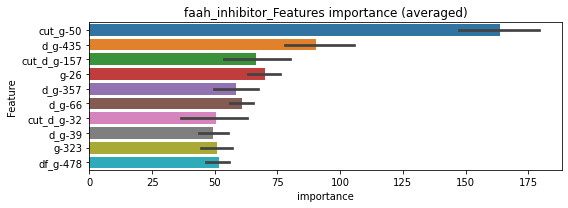

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155505	valid_1's binary_logloss: 0.0324048
[200]	training's binary_logloss: 0.00216139	valid_1's binary_logloss: 0.0139222
[300]	training's binary_logloss: 0.000632688	valid_1's binary_logloss: 0.0110847
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000395004	valid_1's binary_logloss: 0.010415


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161194	valid_1's binary_logloss: 0.0275091
[200]	training's binary_logloss: 0.00229366	valid_1's binary_logloss: 0.00978619
[300]	training's binary_logloss: 0.000654642	valid_1's binary_logloss: 0.00682443
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00049768	valid_1's binary_logloss: 0.00640071


faah_inhibitor logloss: 0.008408129815640767


neg labels: 3289 → selected neg labels: 3286


farnesyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180121	valid_1's binary_logloss: 0.0218833
[200]	training's binary_logloss: 0.00172412	valid_1's binary_logloss: 0.00344216
[300]	training's binary_logloss: 0.000473632	valid_1's binary_logloss: 0.00141495
[400]	training's binary_logloss: 0.000274903	valid_1's binary_logloss: 0.000949481
[500]	training's binary_logloss: 0.000234491	valid_1's binary_logloss: 0.000856325
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.000230968	valid_1's binary_logloss: 0.000846867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181046	valid_1's binary_logloss: 0.0219016
[200]	training's binary_logloss: 0.00176264	valid_1's binary_logloss: 0.0037132
[300]	training's binary_logloss: 0.000480739	valid_1's binary_logloss: 0.00174077
[400]	training's binary_logloss: 0.000277887	valid_1's binary_logloss: 0.00130337
[500]	training's binary_loglo

1 / 3 AUC score:1.000
y_Threshold: 0.0012887, Threshold: 0.0032336, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00291, conf_1:0.00356
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0032336
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_2: 0.0132336
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_3: 0.0232336
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_4: 0.0332336
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_5: 0.0432336
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_6: 0.0532336
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_7: 0.0632336
threshold: 0.0632336, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179983	valid_1's binary_logloss: 0.0205524
[200]	training's binary_logloss: 0.00166683	valid_1's binary_logloss: 0.00240519
[300]	training's binary_logloss: 0.000445451	valid_1's binary_logloss: 0.000791391
[400]	training's binary_logloss: 0.000261124	valid_1's binary_logloss: 0.000517991
[500]	training's binary_logloss: 0.00022765	valid_1's binary_logloss: 0.000470524
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000223049	valid_1's binary_logloss: 0.000463974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184736	valid_1's binary_logloss: 0.0222989
[200]	training's binary_logloss: 0.00172588	valid_1's binary_logloss: 0.0034084
[300]	training's binary_logloss: 0.000469667	valid_1's binary_logloss: 0.0015898
[400]	training's binary_logloss: 0.000274964	valid_1's binary_logloss: 0.00119877
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.0808875, Threshold: 0.0632336, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0082873 Vs.target_rate: 0.00076
Num_p_label: 33.0, conf_0:0.05691, conf_1:0.06956
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_1: 0.0632336
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_2: 0.0732336
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_3: 0.0832336
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_4: 0.0932336
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_5: 0.1032336
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_6: 0.1132336
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_7: 0.1232336
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_8: 0.1332336
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_9: 0.1432336
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_10: 0.1532336
threshold: 0.1632336, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179983	valid_1's binary_logloss: 0.0205524
[200]	training's binary_logloss: 0.00166683	valid_1's binary_logloss: 0.00240519
[300]	training's binary_logloss: 0.000445451	valid_1's binary_logloss: 0.000791391
[400]	training's binary_logloss: 0.000261124	valid_1's binary_logloss: 0.000517991
[500]	training's binary_logloss: 0.00022765	valid_1's binary_logloss: 0.000470524
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000223049	valid_1's binary_logloss: 0.000463974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184736	valid_1's binary_logloss: 0.0222989
[200]	training's binary_logloss: 0.00172588	valid_1's binary_logloss: 0.0034084
[300]	training's binary_logloss: 0.000469667	valid_1's binary_logloss: 0.0015898
[400]	training's binary_logloss: 0.000274964	valid_1's binary_logloss: 0.00119877
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.0808875, Threshold: 0.1632336, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0047715 Vs.target_rate: 0.00076
Num_p_label: 19.0, conf_0:0.14691, conf_1:0.17956
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_1: 0.1632336
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.1732336
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_3: 0.1832336
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_4: 0.1932336
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_5: 0.2032336
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_6: 0.2132336
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_7: 0.2232336
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_8: 0.2332336
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_9: 0.2432336
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_10: 0.2532336
threshold: 0.2632336, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 670.0/7793, y_label_rate: 0.0859746


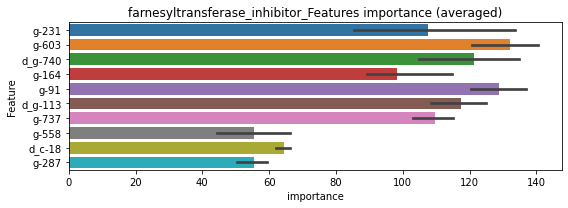

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00990314	valid_1's binary_logloss: 0.015788
[200]	training's binary_logloss: 0.000915517	valid_1's binary_logloss: 0.00623114
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.000376843	valid_1's binary_logloss: 0.00560761


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101928	valid_1's binary_logloss: 0.0119812
[200]	training's binary_logloss: 0.00102213	valid_1's binary_logloss: 0.00218202
[300]	training's binary_logloss: 0.000278265	valid_1's binary_logloss: 0.00114316
[400]	training's binary_logloss: 0.000158087	valid_1's binary_logloss: 0.000976762
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000136611	valid_1's binary_logloss: 0.000938716


farnesyltransferase_inhibitor logloss: 0.0032738538598930645


neg labels: 3289 → selected neg labels: 3285


fatty_acid_receptor_agonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266157	valid_1's binary_logloss: 0.0421778
[200]	training's binary_logloss: 0.00339055	valid_1's binary_logloss: 0.0128768
[300]	training's binary_logloss: 0.000951706	valid_1's binary_logloss: 0.00756971
[400]	training's binary_logloss: 0.000484038	valid_1's binary_logloss: 0.00607589
[500]	training's binary_logloss: 0.000354911	valid_1's binary_logloss: 0.00570495
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00035953	valid_1's binary_logloss: 0.005696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271544	valid_1's binary_logloss: 0.0355159
[200]	training's binary_logloss: 0.00348816	valid_1's binary_logloss: 0.00668133
[300]	training's binary_logloss: 0.000990414	valid_1's binary_logloss: 0.00256386
[400]	training's binary_logloss: 0.000502879	valid_1's binary_logloss: 0.00160658
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0020159, Threshold: 0.0034343, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00309, conf_1:0.00378
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0034343
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_2: 0.0134343
Num_p_label: 2.0, Expected: 4.2, Adj_threshold_3: 0.0234343
threshold: 0.0234343, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254739	valid_1's binary_logloss: 0.0393672
[200]	training's binary_logloss: 0.00317526	valid_1's binary_logloss: 0.0116139
[300]	training's binary_logloss: 0.000897531	valid_1's binary_logloss: 0.00649869
[400]	training's binary_logloss: 0.00046053	valid_1's binary_logloss: 0.00526032
[500]	training's binary_logloss: 0.000349357	valid_1's binary_logloss: 0.00485353
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000347994	valid_1's binary_logloss: 0.00484867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258114	valid_1's binary_logloss: 0.0329415
[200]	training's binary_logloss: 0.00327347	valid_1's binary_logloss: 0.00580338
[300]	training's binary_logloss: 0.000948028	valid_1's binary_logloss: 0.00219976
[400]	training's binary_logloss: 0.000484986	valid_1's binary_logloss: 0.00134838
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.0502604, Threshold: 0.0234343, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0055249 Vs.target_rate: 0.00105
Num_p_label: 22.0, conf_0:0.02109, conf_1:0.02578
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_1: 0.0234343
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_2: 0.0334343
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_3: 0.0434343
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_4: 0.0534343
threshold: 0.0534343, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254739	valid_1's binary_logloss: 0.0393672
[200]	training's binary_logloss: 0.00317526	valid_1's binary_logloss: 0.0116139
[300]	training's binary_logloss: 0.000897531	valid_1's binary_logloss: 0.00649869
[400]	training's binary_logloss: 0.00046053	valid_1's binary_logloss: 0.00526032
[500]	training's binary_logloss: 0.000349357	valid_1's binary_logloss: 0.00485353
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000347994	valid_1's binary_logloss: 0.00484867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258114	valid_1's binary_logloss: 0.0329415
[200]	training's binary_logloss: 0.00327347	valid_1's binary_logloss: 0.00580338
[300]	training's binary_logloss: 0.000948028	valid_1's binary_logloss: 0.00219976
[400]	training's binary_logloss: 0.000484986	valid_1's binary_logloss: 0.00134838
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.0502604, Threshold: 0.0534343, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00105
Num_p_label: 6.0, conf_0:0.04809, conf_1:0.05878
threshold: 0.0534343, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


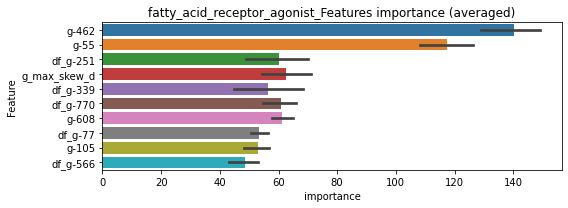

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142302	valid_1's binary_logloss: 0.0224492
[200]	training's binary_logloss: 0.00177991	valid_1's binary_logloss: 0.00806302
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.000549511	valid_1's binary_logloss: 0.00697906


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150115	valid_1's binary_logloss: 0.0222307
[200]	training's binary_logloss: 0.00194126	valid_1's binary_logloss: 0.00600134
[300]	training's binary_logloss: 0.000530517	valid_1's binary_logloss: 0.00359098
[400]	training's binary_logloss: 0.000265859	valid_1's binary_logloss: 0.00303754
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000221369	valid_1's binary_logloss: 0.00294366


fatty_acid_receptor_agonist logloss: 0.004961359686380455


neg labels: 3289 → selected neg labels: 3279


fgfr_inhibitor, len(trt): 50, len(othr): 3279, target_rate: 0.0020996 → Adj_target_rate: 0.0023352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332744	valid_1's binary_logloss: 0.0528457
[200]	training's binary_logloss: 0.00513607	valid_1's binary_logloss: 0.0160527
[300]	training's binary_logloss: 0.00149034	valid_1's binary_logloss: 0.00852006
[400]	training's binary_logloss: 0.000751266	valid_1's binary_logloss: 0.00630169
[500]	training's binary_logloss: 0.000504752	valid_1's binary_logloss: 0.00536288
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.000448576	valid_1's binary_logloss: 0.00519576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332775	valid_1's binary_logloss: 0.0604896
[200]	training's binary_logloss: 0.00505525	valid_1's binary_logloss: 0.020454
[300]	training's binary_logloss: 0.00143739	valid_1's binary_logloss: 0.0118261
[400]	training's binary_logloss: 0.000743624	valid_1's binary_logloss: 0.00928593
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0045751, Threshold: 0.0126853, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 655/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00210
Num_p_label: 80.0, conf_0:0.01142, conf_1:0.01395
Num_p_label: 80.0, Expected: 8.4, Adj_threshold_1: 0.0126853
Num_p_label: 51.0, Expected: 8.4, Adj_threshold_2: 0.0226853
Num_p_label: 38.0, Expected: 8.4, Adj_threshold_3: 0.0326853
Num_p_label: 28.0, Expected: 8.4, Adj_threshold_4: 0.0426853
Num_p_label: 20.0, Expected: 8.4, Adj_threshold_5: 0.0526853
Num_p_label: 18.0, Expected: 8.4, Adj_threshold_6: 0.0626853
Num_p_label: 18.0, Expected: 8.4, Adj_threshold_7: 0.0726853
Num_p_label: 18.0, Expected: 8.4, Adj_threshold_8: 0.0826853
Num_p_label: 16.0, Expected: 8.4, Adj_threshold_9: 0.0926853
threshold: 0.0926853, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325215	valid_1's binary_logloss: 0.0518491
[200]	training's binary_logloss: 0.00478827	valid_1's binary_logloss: 0.0146849
[300]	training's binary_logloss: 0.00136549	valid_1's binary_logloss: 0.00746597
[400]	training's binary_logloss: 0.000679181	valid_1's binary_logloss: 0.00526619
[500]	training's binary_logloss: 0.000473015	valid_1's binary_logloss: 0.00449565
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000434558	valid_1's binary_logloss: 0.0043494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320335	valid_1's binary_logloss: 0.05516
[200]	training's binary_logloss: 0.00472204	valid_1's binary_logloss: 0.0172885
[300]	training's binary_logloss: 0.00134126	valid_1's binary_logloss: 0.00891849
[400]	training's binary_logloss: 0.00068101	valid_1's binary_logloss: 0.00669777
[500]	training's binary_logloss: 0.0004

2 / 3 AUC score:1.000
y_Threshold: 0.0530773, Threshold: 0.0926853, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3802
p_label_rate: 0.0118031 Vs.target_rate: 0.00210
Num_p_label: 47.0, conf_0:0.08342, conf_1:0.10195
Num_p_label: 47.0, Expected: 8.4, Adj_threshold_1: 0.0926853
Num_p_label: 40.0, Expected: 8.4, Adj_threshold_2: 0.1026853
Num_p_label: 37.0, Expected: 8.4, Adj_threshold_3: 0.1126853
Num_p_label: 35.0, Expected: 8.4, Adj_threshold_4: 0.1226853
Num_p_label: 35.0, Expected: 8.4, Adj_threshold_5: 0.1326853
Num_p_label: 31.0, Expected: 8.4, Adj_threshold_6: 0.1426853
Num_p_label: 27.0, Expected: 8.4, Adj_threshold_7: 0.1526853
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_8: 0.1626853
Num_p_label: 22.0, Expected: 8.4, Adj_threshold_9: 0.1726853
Num_p_label: 22.0, Expected: 8.4, Adj_threshold_10: 0.1826853
threshold: 0.1926853, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325215	valid_1's binary_logloss: 0.0518491
[200]	training's binary_logloss: 0.00478827	valid_1's binary_logloss: 0.0146849
[300]	training's binary_logloss: 0.00136549	valid_1's binary_logloss: 0.00746597
[400]	training's binary_logloss: 0.000679181	valid_1's binary_logloss: 0.00526619
[500]	training's binary_logloss: 0.000473015	valid_1's binary_logloss: 0.00449565
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000434558	valid_1's binary_logloss: 0.0043494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320335	valid_1's binary_logloss: 0.05516
[200]	training's binary_logloss: 0.00472204	valid_1's binary_logloss: 0.0172885
[300]	training's binary_logloss: 0.00134126	valid_1's binary_logloss: 0.00891849
[400]	training's binary_logloss: 0.00068101	valid_1's binary_logloss: 0.00669777
[500]	training's binary_logloss: 0.0004

3 / 3 AUC score:1.000
y_Threshold: 0.0530773, Threshold: 0.1926853, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3802
p_label_rate: 0.0055249 Vs.target_rate: 0.00210
Num_p_label: 22.0, conf_0:0.17342, conf_1:0.21195
threshold: 0.1926853, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 677.0/7784, y_label_rate: 0.0869733


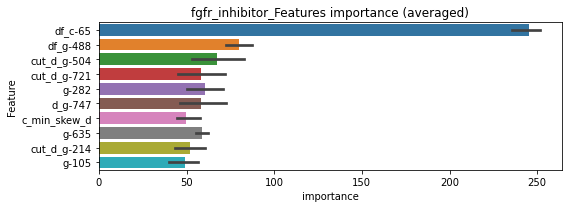

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177049	valid_1's binary_logloss: 0.0342428
[200]	training's binary_logloss: 0.0025922	valid_1's binary_logloss: 0.0159117
[300]	training's binary_logloss: 0.000768334	valid_1's binary_logloss: 0.0130182
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000617732	valid_1's binary_logloss: 0.0125919


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178501	valid_1's binary_logloss: 0.0357743
[200]	training's binary_logloss: 0.00263152	valid_1's binary_logloss: 0.0154939
[300]	training's binary_logloss: 0.000784197	valid_1's binary_logloss: 0.0114687
[400]	training's binary_logloss: 0.000380127	valid_1's binary_logloss: 0.0100087
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000312671	valid_1's binary_logloss: 0.00982748


fgfr_inhibitor logloss: 0.011209667362615198


neg labels: 3289 → selected neg labels: 3272


flt3_inhibitor, len(trt): 279, len(othr): 3272, target_rate: 0.0117158 → Adj_target_rate: 0.0100684
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520037	valid_1's binary_logloss: 0.144616
[200]	training's binary_logloss: 0.0112411	valid_1's binary_logloss: 0.115249
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00863189	valid_1's binary_logloss: 0.113648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531684	valid_1's binary_logloss: 0.138765
[200]	training's binary_logloss: 0.01131	valid_1's binary_logloss: 0.106256
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00493233	valid_1's binary_logloss: 0.103467


1 / 3 AUC score:0.984
y_Threshold: 0.0580413, Threshold: 0.1941786, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 212 → Positive_corect_labels: 614/3714
p_label_rate: 0.0200904 Vs.target_rate: 0.01172
Num_p_label: 80.0, conf_0:0.17476, conf_1:0.21360
threshold: 0.1941786, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 614.0/3714, y_label_rate: 0.1653204
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436562	valid_1's binary_logloss: 0.0988567
[200]	training's binary_logloss: 0.00833091	valid_1's binary_logloss: 0.0618457
[300]	training's binary_logloss: 0.00259147	valid_1's binary_logloss: 0.0523846
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00210374	valid_1's binary_logloss: 0.0513455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438807	valid_1's binary_logloss: 0.112539
[200]	training's binary_logloss: 0.00823592	valid_1's binary_logloss: 0.0751966
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00397134	valid_1's binary_logloss: 0.0707461


2 / 3 AUC score:0.995
y_Threshold: 0.1246510, Threshold: 0.1941786, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 584.0/3654
p_label_rate: 0.0366650 Vs.target_rate: 0.01172
Num_p_label: 146.0, conf_0:0.17476, conf_1:0.21360
Num_p_label: 146.0, Expected: 46.7, Adj_threshold_1: 0.1941786
Num_p_label: 142.0, Expected: 46.7, Adj_threshold_2: 0.2041786
Num_p_label: 135.0, Expected: 46.7, Adj_threshold_3: 0.2141786
Num_p_label: 126.0, Expected: 46.7, Adj_threshold_4: 0.2241786
Num_p_label: 124.0, Expected: 46.7, Adj_threshold_5: 0.2341786
Num_p_label: 117.0, Expected: 46.7, Adj_threshold_6: 0.2441786
Num_p_label: 114.0, Expected: 46.7, Adj_threshold_7: 0.2541786
Num_p_label: 112.0, Expected: 46.7, Adj_threshold_8: 0.2641786
Num_p_label: 110.0, Expected: 46.7, Adj_threshold_9: 0.2741786
Num_p_label: 106.0, Expected: 46.7, Adj_threshold_10: 0.2841786
threshold: 0.2941786, positive_p_label: 100.0/3982, p_label_rate: 0.0251130
positive_y_label: 584.0/3654, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403436	valid_1's binary_logloss: 0.0818076
[200]	training's binary_logloss: 0.00785905	valid_1's binary_logloss: 0.0465193
[300]	training's binary_logloss: 0.00299736	valid_1's binary_logloss: 0.0375119
[400]	training's binary_logloss: 0.00207229	valid_1's binary_logloss: 0.0353491
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00211913	valid_1's binary_logloss: 0.035255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382716	valid_1's binary_logloss: 0.101093
[200]	training's binary_logloss: 0.00661931	valid_1's binary_logloss: 0.0689512
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00413703	valid_1's binary_logloss: 0.0658978


3 / 3 AUC score:0.996
y_Threshold: 0.1062008, Threshold: 0.2941786, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 561.0/3608
p_label_rate: 0.0308890 Vs.target_rate: 0.01172
Num_p_label: 123.0, conf_0:0.26476, conf_1:0.32360
threshold: 0.2941786, positive_p_label: 123.0/3982, p_label_rate: 0.0308890
positive_y_label: 684.0/7590, y_label_rate: 0.0901186


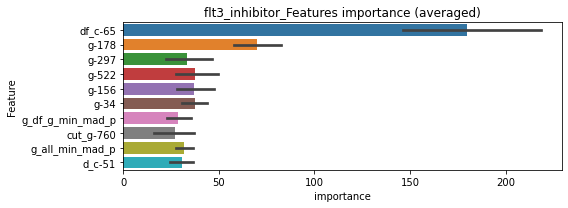

len(train_index) : 3795
len(valid_index) : 3795
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250564	valid_1's binary_logloss: 0.0626928
[200]	training's binary_logloss: 0.00470745	valid_1's binary_logloss: 0.0400251
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00323084	valid_1's binary_logloss: 0.0380972


len(train_index) : 3795
len(valid_index) : 3795
================================= fold 2/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235625	valid_1's binary_logloss: 0.071967
[200]	training's binary_logloss: 0.00430795	valid_1's binary_logloss: 0.0546004
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00297867	valid_1's binary_logloss: 0.0535348


flt3_inhibitor logloss: 0.04581599895934015


neg labels: 3289 → selected neg labels: 3286


focal_adhesion_kinase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184866	valid_1's binary_logloss: 0.0214229
[200]	training's binary_logloss: 0.00177214	valid_1's binary_logloss: 0.00370685
[300]	training's binary_logloss: 0.000472318	valid_1's binary_logloss: 0.00219368
[400]	training's binary_logloss: 0.000271882	valid_1's binary_logloss: 0.00190198
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000256738	valid_1's binary_logloss: 0.00186768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018314	valid_1's binary_logloss: 0.0221342
[200]	training's binary_logloss: 0.00180451	valid_1's binary_logloss: 0.00334661
[300]	training's binary_logloss: 0.000496889	valid_1's binary_logloss: 0.00141461
[400]	training's binary_logloss: 0.000280104	valid_1's binary_logloss: 0.00101467
[500]	training's binary_logloss: 0.000239174	valid_1's binary_logloss: 0.000926345
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0012241, Threshold: 0.0037344, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00336, conf_1:0.00411
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0037344
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_2: 0.0137344
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_3: 0.0237344
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_4: 0.0337344
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_5: 0.0437344
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_6: 0.0537344
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_7: 0.0637344
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_8: 0.0737344
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_9: 0.0837344
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_10: 0.0937344
threshold: 0.1037344, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182615	valid_1's binary_logloss: 0.019821
[200]	training's binary_logloss: 0.00170071	valid_1's binary_logloss: 0.00219137
[300]	training's binary_logloss: 0.000439168	valid_1's binary_logloss: 0.000637928
[400]	training's binary_logloss: 0.000250893	valid_1's binary_logloss: 0.000385772
[500]	training's binary_logloss: 0.000219323	valid_1's binary_logloss: 0.000343905
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000215649	valid_1's binary_logloss: 0.000338728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182631	valid_1's binary_logloss: 0.0215161
[200]	training's binary_logloss: 0.0016801	valid_1's binary_logloss: 0.00250838
[300]	training's binary_logloss: 0.000431456	valid_1's binary_logloss: 0.000786085
[400]	training's binary_logloss: 0.000249444	valid_1's binary_logloss: 0.000497579
[500]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1499673, Threshold: 0.1037344, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0072828 Vs.target_rate: 0.00076
Num_p_label: 29.0, conf_0:0.09336, conf_1:0.11411
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_1: 0.1037344
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_2: 0.1137344
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_3: 0.1237344
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_4: 0.1337344
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_5: 0.1437344
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_6: 0.1537344
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_7: 0.1637344
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_8: 0.1737344
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_9: 0.1837344
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_10: 0.1937344
threshold: 0.2037344, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182615	valid_1's binary_logloss: 0.019821
[200]	training's binary_logloss: 0.00170071	valid_1's binary_logloss: 0.00219137
[300]	training's binary_logloss: 0.000439168	valid_1's binary_logloss: 0.000637928
[400]	training's binary_logloss: 0.000250893	valid_1's binary_logloss: 0.000385772
[500]	training's binary_logloss: 0.000219323	valid_1's binary_logloss: 0.000343905
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.000215649	valid_1's binary_logloss: 0.000338728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182631	valid_1's binary_logloss: 0.0215161
[200]	training's binary_logloss: 0.0016801	valid_1's binary_logloss: 0.00250838
[300]	training's binary_logloss: 0.000431456	valid_1's binary_logloss: 0.000786085
[400]	training's binary_logloss: 0.000249444	valid_1's binary_logloss: 0.000497579
[500]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1499673, Threshold: 0.2037344, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00076
Num_p_label: 21.0, conf_0:0.18336, conf_1:0.22411
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.2037344
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_2: 0.2137344
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_3: 0.2237344
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_4: 0.2337344
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_5: 0.2437344
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_6: 0.2537344
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_7: 0.2637344
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_8: 0.2737344
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_9: 0.2837344
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_10: 0.2937344
threshold: 0.3037344, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 672.0/7793, y_label_rate: 0.0862312


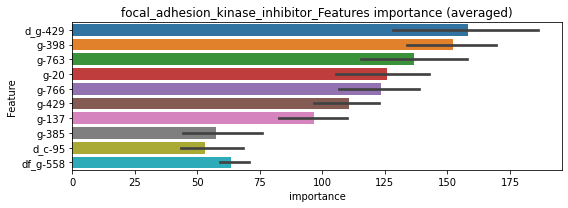

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00978974	valid_1's binary_logloss: 0.0179216
[200]	training's binary_logloss: 0.000918511	valid_1's binary_logloss: 0.00825181
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.000482604	valid_1's binary_logloss: 0.00722655


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100391	valid_1's binary_logloss: 0.0117927
[200]	training's binary_logloss: 0.000976067	valid_1's binary_logloss: 0.00250389
[300]	training's binary_logloss: 0.000262229	valid_1's binary_logloss: 0.00182577
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000210109	valid_1's binary_logloss: 0.001785


focal_adhesion_kinase_inhibitor logloss: 0.004506126754403875


neg labels: 3289 → selected neg labels: 3286


free_radical_scavenger, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218051	valid_1's binary_logloss: 0.0277295
[200]	training's binary_logloss: 0.00246194	valid_1's binary_logloss: 0.00556878
[300]	training's binary_logloss: 0.000705471	valid_1's binary_logloss: 0.00308861
[400]	training's binary_logloss: 0.000382579	valid_1's binary_logloss: 0.00244524
[500]	training's binary_logloss: 0.000301776	valid_1's binary_logloss: 0.00228772
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000302869	valid_1's binary_logloss: 0.00228412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221994	valid_1's binary_logloss: 0.0364875
[200]	training's binary_logloss: 0.00254563	valid_1's binary_logloss: 0.0101266
[300]	training's binary_logloss: 0.000728134	valid_1's binary_logloss: 0.00541121
[400]	training's binary_logloss: 0.000387301	valid_1's binary_logloss: 0.00428055
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0012276, Threshold: 0.0017201, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00155, conf_1:0.00189
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0017201
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_2: 0.0117201
threshold: 0.0117201, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022439	valid_1's binary_logloss: 0.0288889
[200]	training's binary_logloss: 0.00250731	valid_1's binary_logloss: 0.00584537
[300]	training's binary_logloss: 0.000711391	valid_1's binary_logloss: 0.00323805
[400]	training's binary_logloss: 0.000388668	valid_1's binary_logloss: 0.00251539
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000310633	valid_1's binary_logloss: 0.0022977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224212	valid_1's binary_logloss: 0.0383603
[200]	training's binary_logloss: 0.00254399	valid_1's binary_logloss: 0.0124478
[300]	training's binary_logloss: 0.000733522	valid_1's binary_logloss: 0.00735426
[400]	training's binary_logloss: 0.000389329	valid_1's binary_logloss: 0.00561971
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00037545	valid_1's binary_logloss: 0.00552018


2 / 3 AUC score:1.000
y_Threshold: 0.0229462, Threshold: 0.0117201, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00076
Num_p_label: 8.0, conf_0:0.01055, conf_1:0.01289
threshold: 0.0117201, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022439	valid_1's binary_logloss: 0.0288889
[200]	training's binary_logloss: 0.00250731	valid_1's binary_logloss: 0.00584537
[300]	training's binary_logloss: 0.000711391	valid_1's binary_logloss: 0.00323805
[400]	training's binary_logloss: 0.000388668	valid_1's binary_logloss: 0.00251539
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000310633	valid_1's binary_logloss: 0.0022977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224212	valid_1's binary_logloss: 0.0383603
[200]	training's binary_logloss: 0.00254399	valid_1's binary_logloss: 0.0124478
[300]	training's binary_logloss: 0.000733522	valid_1's binary_logloss: 0.00735426
[400]	training's binary_logloss: 0.000389329	valid_1's binary_logloss: 0.00561971
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00037545	valid_1's binary_logloss: 0.00552018


3 / 3 AUC score:1.000
y_Threshold: 0.0229462, Threshold: 0.0117201, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00076
Num_p_label: 8.0, conf_0:0.01055, conf_1:0.01289
threshold: 0.0117201, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7793, y_label_rate: 0.0853330


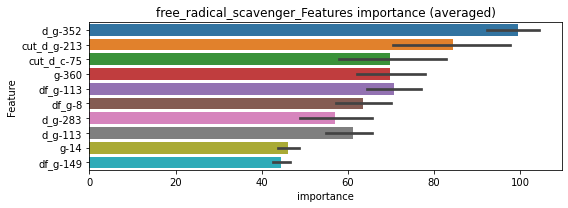

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011836	valid_1's binary_logloss: 0.0215636
[200]	training's binary_logloss: 0.00134299	valid_1's binary_logloss: 0.0106726
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00058893	valid_1's binary_logloss: 0.0100469


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123836	valid_1's binary_logloss: 0.0191411
[200]	training's binary_logloss: 0.00148338	valid_1's binary_logloss: 0.00598312
[300]	training's binary_logloss: 0.000408461	valid_1's binary_logloss: 0.00442908
[400]	training's binary_logloss: 0.000213253	valid_1's binary_logloss: 0.00416026
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000204645	valid_1's binary_logloss: 0.00414606


free_radical_scavenger logloss: 0.007096877278253494


neg labels: 3289 → selected neg labels: 3285


fungal_squalene_epoxidase_inhibitor, len(trt): 23, len(othr): 3285, target_rate: 0.0009658 → Adj_target_rate: 0.0012069
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235342	valid_1's binary_logloss: 0.0403508
[200]	training's binary_logloss: 0.00282118	valid_1's binary_logloss: 0.0139019
[300]	training's binary_logloss: 0.000816474	valid_1's binary_logloss: 0.0105512
[400]	training's binary_logloss: 0.000430906	valid_1's binary_logloss: 0.00975068
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000367079	valid_1's binary_logloss: 0.00954281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252619	valid_1's binary_logloss: 0.0321777
[200]	training's binary_logloss: 0.00316557	valid_1's binary_logloss: 0.00526376
[300]	training's binary_logloss: 0.000895323	valid_1's binary_logloss: 0.00179166
[400]	training's binary_logloss: 0.000466465	valid_1's binary_logloss: 0.00101803
[500]	training's binary_logloss: 0.000348796	valid_1's binary_logloss: 0.000798198
[600]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0015702, Threshold: 0.0024713, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00097
Num_p_label: 80.0, conf_0:0.00222, conf_1:0.00272
Num_p_label: 80.0, Expected: 3.8, Adj_threshold_1: 0.0024713
Num_p_label: 4.0, Expected: 3.8, Adj_threshold_2: 0.0124713
threshold: 0.0124713, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237946	valid_1's binary_logloss: 0.0405753
[200]	training's binary_logloss: 0.00281358	valid_1's binary_logloss: 0.0125285
[300]	training's binary_logloss: 0.000813112	valid_1's binary_logloss: 0.00918699
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000645051	valid_1's binary_logloss: 0.00879423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251467	valid_1's binary_logloss: 0.0309375
[200]	training's binary_logloss: 0.00308994	valid_1's binary_logloss: 0.00460796
[300]	training's binary_logloss: 0.000892899	valid_1's binary_logloss: 0.00155133
[400]	training's binary_logloss: 0.000467957	valid_1's binary_logloss: 0.000870407
[500]	training's binary_logloss: 0.000351646	valid_1's binary_logloss: 0.000681997
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000339944	valid_1's binary_logloss: 0.0006

2 / 3 AUC score:1.000
y_Threshold: 0.0126049, Threshold: 0.0124713, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0065294 Vs.target_rate: 0.00097
Num_p_label: 26.0, conf_0:0.01122, conf_1:0.01372
Num_p_label: 26.0, Expected: 3.8, Adj_threshold_1: 0.0124713
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_2: 0.0224713
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_3: 0.0324713
threshold: 0.0324713, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237946	valid_1's binary_logloss: 0.0405753
[200]	training's binary_logloss: 0.00281358	valid_1's binary_logloss: 0.0125285
[300]	training's binary_logloss: 0.000813112	valid_1's binary_logloss: 0.00918699
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000645051	valid_1's binary_logloss: 0.00879423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251467	valid_1's binary_logloss: 0.0309375
[200]	training's binary_logloss: 0.00308994	valid_1's binary_logloss: 0.00460796
[300]	training's binary_logloss: 0.000892899	valid_1's binary_logloss: 0.00155133
[400]	training's binary_logloss: 0.000467957	valid_1's binary_logloss: 0.000870407
[500]	training's binary_logloss: 0.000351646	valid_1's binary_logloss: 0.000681997
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000339944	valid_1's binary_logloss: 0.0006

3 / 3 AUC score:1.000
y_Threshold: 0.0126049, Threshold: 0.0324713, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00097
Num_p_label: 6.0, conf_0:0.02922, conf_1:0.03572
threshold: 0.0324713, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


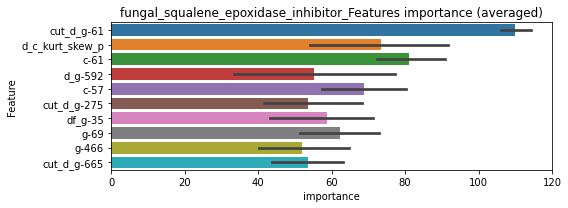

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131011	valid_1's binary_logloss: 0.0218872
[200]	training's binary_logloss: 0.00152868	valid_1's binary_logloss: 0.00863645
[300]	training's binary_logloss: 0.000430999	valid_1's binary_logloss: 0.00738637
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.000441326	valid_1's binary_logloss: 0.0073738


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133679	valid_1's binary_logloss: 0.021013
[200]	training's binary_logloss: 0.00166073	valid_1's binary_logloss: 0.00597605
[300]	training's binary_logloss: 0.000469235	valid_1's binary_logloss: 0.00409404
[400]	training's binary_logloss: 0.000239207	valid_1's binary_logloss: 0.00367028
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000190231	valid_1's binary_logloss: 0.00357531


fungal_squalene_epoxidase_inhibitor logloss: 0.005474554962079694


neg labels: 3289 → selected neg labels: 3272


gaba_receptor_agonist, len(trt): 106, len(othr): 3272, target_rate: 0.0044512 → Adj_target_rate: 0.0044229
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051552	valid_1's binary_logloss: 0.135482
[200]	training's binary_logloss: 0.0113734	valid_1's binary_logloss: 0.0951017
[300]	training's binary_logloss: 0.00360951	valid_1's binary_logloss: 0.0875988
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00322254	valid_1's binary_logloss: 0.0872974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588046	valid_1's binary_logloss: 0.125371
[200]	training's binary_logloss: 0.0140561	valid_1's binary_logloss: 0.0859241
[300]	training's binary_logloss: 0.00445274	valid_1's binary_logloss: 0.0770929
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00412358	valid_1's binary_logloss: 0.0766541


1 / 3 AUC score:0.993
y_Threshold: 0.0165360, Threshold: 0.0193920, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 166 → Positive_corect_labels: 637/3760
p_label_rate: 0.0200904 Vs.target_rate: 0.00445
Num_p_label: 80.0, conf_0:0.01745, conf_1:0.02133
Num_p_label: 80.0, Expected: 17.7, Adj_threshold_1: 0.0193920
Num_p_label: 26.0, Expected: 17.7, Adj_threshold_2: 0.0293920
threshold: 0.0293920, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 637.0/3760, y_label_rate: 0.1694149
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497321	valid_1's binary_logloss: 0.118428
[200]	training's binary_logloss: 0.0109686	valid_1's binary_logloss: 0.0800163
[300]	training's binary_logloss: 0.00347661	valid_1's binary_logloss: 0.071939
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00184781	valid_1's binary_logloss: 0.0688241
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049576	valid_1's binary_logloss: 0.111927
[200]	training's binary_logloss: 0.0106942	valid_1's binary_logloss: 0.0684395
[300]	training's binary_logloss: 0.00340164	valid_1's binary_logloss: 0.0577513
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00365086	valid_1's binary_logloss: 0.0573515


2 / 3 AUC score:0.997
y_Threshold: 0.0265328, Threshold: 0.0293920, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 624.0/3734
p_label_rate: 0.0080362 Vs.target_rate: 0.00445
Num_p_label: 32.0, conf_0:0.02645, conf_1:0.03233
threshold: 0.0293920, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 624.0/3734, y_label_rate: 0.1671130
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470201	valid_1's binary_logloss: 0.104945
[200]	training's binary_logloss: 0.00960943	valid_1's binary_logloss: 0.0648781
[300]	training's binary_logloss: 0.00305471	valid_1's binary_logloss: 0.056349
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00172973	valid_1's binary_logloss: 0.0548269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500949	valid_1's binary_logloss: 0.103317
[200]	training's binary_logloss: 0.0106897	valid_1's binary_logloss: 0.060451
[300]	training's binary_logloss: 0.00335013	valid_1's binary_logloss: 0.0512725
[400]	training's binary_logloss: 0.00159396	valid_1's binary_logloss: 0.0489156
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00160253	valid_1's binary_logloss: 0.0489073


3 / 3 AUC score:0.998
y_Threshold: 0.0210615, Threshold: 0.0293920, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 613.0/3712
p_label_rate: 0.0050226 Vs.target_rate: 0.00445
Num_p_label: 20.0, conf_0:0.02645, conf_1:0.03233
threshold: 0.0293920, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 633.0/7694, y_label_rate: 0.0822719


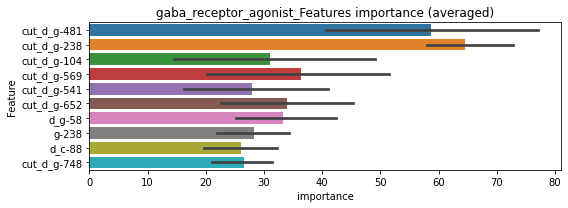

len(train_index) : 3847
len(valid_index) : 3847
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257353	valid_1's binary_logloss: 0.070803
[200]	training's binary_logloss: 0.0051347	valid_1's binary_logloss: 0.0533249
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00211683	valid_1's binary_logloss: 0.0499018


len(train_index) : 3847
len(valid_index) : 3847
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266752	valid_1's binary_logloss: 0.0632281
[200]	training's binary_logloss: 0.00551725	valid_1's binary_logloss: 0.0411539
[300]	training's binary_logloss: 0.00168813	valid_1's binary_logloss: 0.0363233
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000991955	valid_1's binary_logloss: 0.0354494


gaba_receptor_agonist logloss: 0.042675569403158385


neg labels: 3289 → selected neg labels: 3263


gaba_receptor_antagonist, len(trt): 165, len(othr): 3263, target_rate: 0.0069287 → Adj_target_rate: 0.0064426
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0773782	valid_1's binary_logloss: 0.182393
[200]	training's binary_logloss: 0.0233824	valid_1's binary_logloss: 0.152731
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0137474	valid_1's binary_logloss: 0.147977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791533	valid_1's binary_logloss: 0.174929
[200]	training's binary_logloss: 0.024545	valid_1's binary_logloss: 0.135336
[300]	training's binary_logloss: 0.0089232	valid_1's binary_logloss: 0.127537
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00884088	valid_1's binary_logloss: 0.127282


1 / 3 AUC score:0.970
y_Threshold: 0.0390976, Threshold: 0.0432473, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 235 → Positive_corect_labels: 600/3680
p_label_rate: 0.0200904 Vs.target_rate: 0.00693
Num_p_label: 80.0, conf_0:0.03892, conf_1:0.04757
threshold: 0.0432473, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 600.0/3680, y_label_rate: 0.1630435
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660259	valid_1's binary_logloss: 0.160318
[200]	training's binary_logloss: 0.0170881	valid_1's binary_logloss: 0.120177
[300]	training's binary_logloss: 0.00555088	valid_1's binary_logloss: 0.11206
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00599232	valid_1's binary_logloss: 0.111931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652514	valid_1's binary_logloss: 0.146318
[200]	training's binary_logloss: 0.0174034	valid_1's binary_logloss: 0.112743
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0108363	valid_1's binary_logloss: 0.108609


2 / 3 AUC score:0.990
y_Threshold: 0.0555821, Threshold: 0.0432473, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 86 → Positive_corect_labels: 557.0/3594
p_label_rate: 0.0173280 Vs.target_rate: 0.00693
Num_p_label: 69.0, conf_0:0.03892, conf_1:0.04757
threshold: 0.0432473, positive_p_label: 69.0/3982, p_label_rate: 0.0173280
positive_y_label: 557.0/3594, y_label_rate: 0.1549805
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569197	valid_1's binary_logloss: 0.133063
[200]	training's binary_logloss: 0.0132921	valid_1's binary_logloss: 0.097548
[300]	training's binary_logloss: 0.00417845	valid_1's binary_logloss: 0.0883623
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00317224	valid_1's binary_logloss: 0.0875465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0558349	valid_1's binary_logloss: 0.127939
[200]	training's binary_logloss: 0.0134692	valid_1's binary_logloss: 0.0913305
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0070783	valid_1's binary_logloss: 0.0862992


3 / 3 AUC score:0.995
y_Threshold: 0.0446262, Threshold: 0.0432473, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 534.0/3548
p_label_rate: 0.0075339 Vs.target_rate: 0.00693
Num_p_label: 30.0, conf_0:0.03892, conf_1:0.04757
threshold: 0.0432473, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 564.0/7530, y_label_rate: 0.0749004


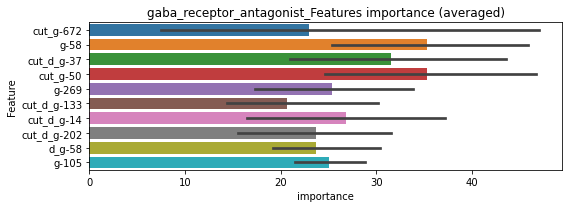

len(train_index) : 3765
len(valid_index) : 3765
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287331	valid_1's binary_logloss: 0.0826077
[200]	training's binary_logloss: 0.0063536	valid_1's binary_logloss: 0.0658662
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00262834	valid_1's binary_logloss: 0.0638946


len(train_index) : 3765
len(valid_index) : 3765
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312514	valid_1's binary_logloss: 0.0801193
[200]	training's binary_logloss: 0.00720374	valid_1's binary_logloss: 0.0654614
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00720374	valid_1's binary_logloss: 0.0654614


gaba_receptor_antagonist logloss: 0.06467799406518887


neg labels: 3289 → selected neg labels: 3279


gamma_secretase_inhibitor, len(trt): 56, len(othr): 3279, target_rate: 0.0023516 → Adj_target_rate: 0.0025713
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327636	valid_1's binary_logloss: 0.063643
[200]	training's binary_logloss: 0.0048799	valid_1's binary_logloss: 0.028443
[300]	training's binary_logloss: 0.00143344	valid_1's binary_logloss: 0.023149
[400]	training's binary_logloss: 0.000717465	valid_1's binary_logloss: 0.0218041
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000734671	valid_1's binary_logloss: 0.0217246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307603	valid_1's binary_logloss: 0.0568941
[200]	training's binary_logloss: 0.00462223	valid_1's binary_logloss: 0.0230266
[300]	training's binary_logloss: 0.00137286	valid_1's binary_logloss: 0.0166453
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000970065	valid_1's binary_logloss: 0.0157668


1 / 3 AUC score:0.999
y_Threshold: 0.0049397, Threshold: 0.0066479, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3796
p_label_rate: 0.0200904 Vs.target_rate: 0.00235
Num_p_label: 80.0, conf_0:0.00598, conf_1:0.00731
Num_p_label: 80.0, Expected: 9.4, Adj_threshold_1: 0.0066479
Num_p_label: 23.0, Expected: 9.4, Adj_threshold_2: 0.0166479
Num_p_label: 11.0, Expected: 9.4, Adj_threshold_3: 0.0266479
threshold: 0.0266479, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314066	valid_1's binary_logloss: 0.0610321
[200]	training's binary_logloss: 0.00449889	valid_1's binary_logloss: 0.0279529
[300]	training's binary_logloss: 0.00131578	valid_1's binary_logloss: 0.0220369
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000794628	valid_1's binary_logloss: 0.0211799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031198	valid_1's binary_logloss: 0.0550753
[200]	training's binary_logloss: 0.0044795	valid_1's binary_logloss: 0.0195157
[300]	training's binary_logloss: 0.00131965	valid_1's binary_logloss: 0.0136054
[400]	training's binary_logloss: 0.000665335	valid_1's binary_logloss: 0.012153
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00058124	valid_1's binary_logloss: 0.0120112


2 / 3 AUC score:1.000
y_Threshold: 0.0202286, Threshold: 0.0266479, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 645.0/3782
p_label_rate: 0.0055249 Vs.target_rate: 0.00235
Num_p_label: 22.0, conf_0:0.02398, conf_1:0.02931
threshold: 0.0266479, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 645.0/3782, y_label_rate: 0.1705447
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303991	valid_1's binary_logloss: 0.0565558
[200]	training's binary_logloss: 0.00424961	valid_1's binary_logloss: 0.0216359
[300]	training's binary_logloss: 0.00124508	valid_1's binary_logloss: 0.0153277
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00075725	valid_1's binary_logloss: 0.0139108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310015	valid_1's binary_logloss: 0.0501064
[200]	training's binary_logloss: 0.00441604	valid_1's binary_logloss: 0.0139122
[300]	training's binary_logloss: 0.001286	valid_1's binary_logloss: 0.00756955
[400]	training's binary_logloss: 0.000655248	valid_1's binary_logloss: 0.00584136
[500]	training's binary_logloss: 0.000450764	valid_1's binary_logloss: 0.0050598
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000405338	valid_1's binary_logloss: 0.00490835


3 / 3 AUC score:1.000
y_Threshold: 0.0388126, Threshold: 0.0266479, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 643.0/3778
p_label_rate: 0.0065294 Vs.target_rate: 0.00235
Num_p_label: 26.0, conf_0:0.02398, conf_1:0.02931
threshold: 0.0266479, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 669.0/7760, y_label_rate: 0.0862113


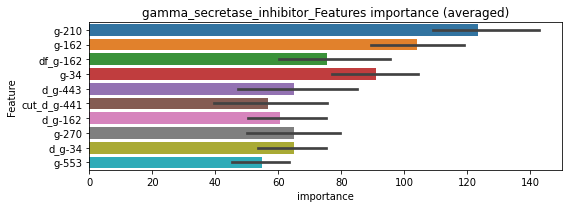

len(train_index) : 3880
len(valid_index) : 3880
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161339	valid_1's binary_logloss: 0.0348777
[200]	training's binary_logloss: 0.00229198	valid_1's binary_logloss: 0.0189126
[300]	training's binary_logloss: 0.000685172	valid_1's binary_logloss: 0.0164732
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000718177	valid_1's binary_logloss: 0.0164572


len(train_index) : 3880
len(valid_index) : 3880
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166087	valid_1's binary_logloss: 0.0410992
[200]	training's binary_logloss: 0.00247321	valid_1's binary_logloss: 0.0247131
[300]	training's binary_logloss: 0.000711153	valid_1's binary_logloss: 0.0222654
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00055826	valid_1's binary_logloss: 0.0220115


gamma_secretase_inhibitor logloss: 0.01923432867864809


neg labels: 3289 → selected neg labels: 3253


glucocorticoid_receptor_agonist, len(trt): 266, len(othr): 3253, target_rate: 0.0111699 → Adj_target_rate: 0.0096682
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317219	valid_1's binary_logloss: 0.0718741
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00742457	valid_1's binary_logloss: 0.0562102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327299	valid_1's binary_logloss: 0.06223
[200]	training's binary_logloss: 0.00506063	valid_1's binary_logloss: 0.0364823
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00199918	valid_1's binary_logloss: 0.0324024


1 / 3 AUC score:0.995
y_Threshold: 0.0135017, Threshold: 0.0325230, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 149 → Positive_corect_labels: 641/3754
p_label_rate: 0.0200904 Vs.target_rate: 0.01117
Num_p_label: 80.0, conf_0:0.02927, conf_1:0.03578
threshold: 0.0325230, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 641.0/3754, y_label_rate: 0.1707512
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264629	valid_1's binary_logloss: 0.0522156
[200]	training's binary_logloss: 0.00335233	valid_1's binary_logloss: 0.0287157
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00153385	valid_1's binary_logloss: 0.0264498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275164	valid_1's binary_logloss: 0.042138
[200]	training's binary_logloss: 0.00376918	valid_1's binary_logloss: 0.0173834
[300]	training's binary_logloss: 0.00106805	valid_1's binary_logloss: 0.0139752
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000641329	valid_1's binary_logloss: 0.0131348


2 / 3 AUC score:0.999
y_Threshold: 0.0383787, Threshold: 0.0325230, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 634.0/3740
p_label_rate: 0.0241085 Vs.target_rate: 0.01117
Num_p_label: 96.0, conf_0:0.02927, conf_1:0.03578
threshold: 0.0325230, positive_p_label: 96.0/3982, p_label_rate: 0.0241085
positive_y_label: 634.0/3740, y_label_rate: 0.1695187
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264973	valid_1's binary_logloss: 0.0405886
[200]	training's binary_logloss: 0.00328762	valid_1's binary_logloss: 0.0159329
[300]	training's binary_logloss: 0.000926985	valid_1's binary_logloss: 0.0131313
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000662335	valid_1's binary_logloss: 0.0127415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251056	valid_1's binary_logloss: 0.0517258
[200]	training's binary_logloss: 0.00300994	valid_1's binary_logloss: 0.031716
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00182166	valid_1's binary_logloss: 0.0305654


3 / 3 AUC score:0.999
y_Threshold: 0.0347143, Threshold: 0.0325230, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 628.0/3728
p_label_rate: 0.0261175 Vs.target_rate: 0.01117
Num_p_label: 104.0, conf_0:0.02927, conf_1:0.03578
threshold: 0.0325230, positive_p_label: 104.0/3982, p_label_rate: 0.0261175
positive_y_label: 732.0/7710, y_label_rate: 0.0949416


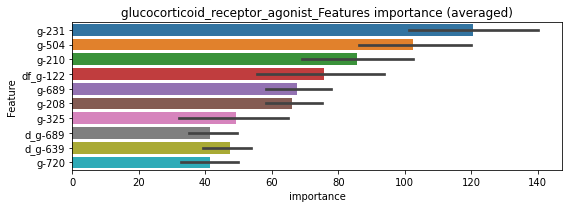

len(train_index) : 3855
len(valid_index) : 3855
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175335	valid_1's binary_logloss: 0.0378669
[200]	training's binary_logloss: 0.00250271	valid_1's binary_logloss: 0.0262564
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00113472	valid_1's binary_logloss: 0.0250137


len(train_index) : 3855
len(valid_index) : 3855
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156194	valid_1's binary_logloss: 0.046222
[200]	training's binary_logloss: 0.00206824	valid_1's binary_logloss: 0.0356914
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00147597	valid_1's binary_logloss: 0.034975


glucocorticoid_receptor_agonist logloss: 0.029994361958190326


neg labels: 3289 → selected neg labels: 3287


glutamate_inhibitor, len(trt): 13, len(othr): 3287, target_rate: 0.0005459 → Adj_target_rate: 0.0007431
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188112	valid_1's binary_logloss: 0.0270436
[200]	training's binary_logloss: 0.00190091	valid_1's binary_logloss: 0.00557025
[300]	training's binary_logloss: 0.000537726	valid_1's binary_logloss: 0.00306552
[400]	training's binary_logloss: 0.000305908	valid_1's binary_logloss: 0.00243014
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000300446	valid_1's binary_logloss: 0.00240261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189496	valid_1's binary_logloss: 0.0226129
[200]	training's binary_logloss: 0.00194149	valid_1's binary_logloss: 0.00354062
[300]	training's binary_logloss: 0.000549262	valid_1's binary_logloss: 0.00152659
[400]	training's binary_logloss: 0.000313871	valid_1's binary_logloss: 0.00111071
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000293061	valid_1's binary_logloss: 0.00107

1 / 3 AUC score:1.000
y_Threshold: 0.0010330, Threshold: 0.0013004, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00055
Num_p_label: 80.0, conf_0:0.00117, conf_1:0.00143
Num_p_label: 80.0, Expected: 2.2, Adj_threshold_1: 0.0013004
Num_p_label: 1.0, Expected: 2.2, Adj_threshold_2: 0.0113004
threshold: 0.0113004, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188959	valid_1's binary_logloss: 0.0258997
[200]	training's binary_logloss: 0.00188744	valid_1's binary_logloss: 0.00495937
[300]	training's binary_logloss: 0.000531889	valid_1's binary_logloss: 0.00255716
[400]	training's binary_logloss: 0.000301961	valid_1's binary_logloss: 0.00194566
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000271798	valid_1's binary_logloss: 0.00188043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192548	valid_1's binary_logloss: 0.0230166
[200]	training's binary_logloss: 0.00192602	valid_1's binary_logloss: 0.00355643
[300]	training's binary_logloss: 0.000547131	valid_1's binary_logloss: 0.00169035
[400]	training's binary_logloss: 0.000308251	valid_1's binary_logloss: 0.0012486
[500]	training's binary_logloss: 0.000263174	valid_1's binary_logloss: 0.00117204
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.0437316, Threshold: 0.0113004, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00055
Num_p_label: 6.0, conf_0:0.01017, conf_1:0.01243
threshold: 0.0113004, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188959	valid_1's binary_logloss: 0.0258997
[200]	training's binary_logloss: 0.00188744	valid_1's binary_logloss: 0.00495937
[300]	training's binary_logloss: 0.000531889	valid_1's binary_logloss: 0.00255716
[400]	training's binary_logloss: 0.000301961	valid_1's binary_logloss: 0.00194566
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000271798	valid_1's binary_logloss: 0.00188043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192548	valid_1's binary_logloss: 0.0230166
[200]	training's binary_logloss: 0.00192602	valid_1's binary_logloss: 0.00355643
[300]	training's binary_logloss: 0.000547131	valid_1's binary_logloss: 0.00169035
[400]	training's binary_logloss: 0.000308251	valid_1's binary_logloss: 0.0012486
[500]	training's binary_logloss: 0.000263174	valid_1's binary_logloss: 0.00117204
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.0437316, Threshold: 0.0113004, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00055
Num_p_label: 6.0, conf_0:0.01017, conf_1:0.01243
threshold: 0.0113004, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7794, y_label_rate: 0.0850654


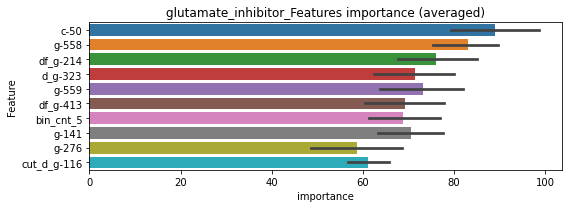

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100853	valid_1's binary_logloss: 0.0166945
[200]	training's binary_logloss: 0.000995526	valid_1's binary_logloss: 0.00797655
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.000497343	valid_1's binary_logloss: 0.00759006


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109657	valid_1's binary_logloss: 0.01798
[200]	training's binary_logloss: 0.00127255	valid_1's binary_logloss: 0.00739278
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.000702787	valid_1's binary_logloss: 0.00688116


glutamate_inhibitor logloss: 0.007235606382415164


neg labels: 3289 → selected neg labels: 3277


glutamate_receptor_agonist, len(trt): 74, len(othr): 3277, target_rate: 0.0031074 → Adj_target_rate: 0.0032587
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507005	valid_1's binary_logloss: 0.10209
[200]	training's binary_logloss: 0.0104763	valid_1's binary_logloss: 0.0559339
[300]	training's binary_logloss: 0.00308069	valid_1's binary_logloss: 0.0457318
[400]	training's binary_logloss: 0.00141905	valid_1's binary_logloss: 0.0427208
[500]	training's binary_logloss: 0.000873255	valid_1's binary_logloss: 0.0409589
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000837706	valid_1's binary_logloss: 0.0407671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520233	valid_1's binary_logloss: 0.0950715
[200]	training's binary_logloss: 0.0115067	valid_1's binary_logloss: 0.0474124
[300]	training's binary_logloss: 0.00327829	valid_1's binary_logloss: 0.0332389
[400]	training's binary_logloss: 0.00147276	valid_1's binary_logloss: 0.029362
Early stopping, best iteration is:
[467]	trainin

1 / 3 AUC score:0.999
y_Threshold: 0.0072261, Threshold: 0.0090334, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3794
p_label_rate: 0.0200904 Vs.target_rate: 0.00311
Num_p_label: 80.0, conf_0:0.00813, conf_1:0.00994
Num_p_label: 80.0, Expected: 12.4, Adj_threshold_1: 0.0090334
Num_p_label: 19.0, Expected: 12.4, Adj_threshold_2: 0.0190334
threshold: 0.0190334, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 652.0/3794, y_label_rate: 0.1718503
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507361	valid_1's binary_logloss: 0.102062
[200]	training's binary_logloss: 0.00982951	valid_1's binary_logloss: 0.0565739
[300]	training's binary_logloss: 0.00288752	valid_1's binary_logloss: 0.0472586
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00268074	valid_1's binary_logloss: 0.0467063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532236	valid_1's binary_logloss: 0.0994686
[200]	training's binary_logloss: 0.0110231	valid_1's binary_logloss: 0.0476921
[300]	training's binary_logloss: 0.00322212	valid_1's binary_logloss: 0.035154
[400]	training's binary_logloss: 0.0014778	valid_1's binary_logloss: 0.0311827
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00128773	valid_1's binary_logloss: 0.0306976


2 / 3 AUC score:0.998
y_Threshold: 0.0355342, Threshold: 0.0190334, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 643.0/3776
p_label_rate: 0.0228528 Vs.target_rate: 0.00311
Num_p_label: 91.0, conf_0:0.01713, conf_1:0.02094
Num_p_label: 91.0, Expected: 12.4, Adj_threshold_1: 0.0190334
Num_p_label: 34.0, Expected: 12.4, Adj_threshold_2: 0.0290334
Num_p_label: 13.0, Expected: 12.4, Adj_threshold_3: 0.0390334
threshold: 0.0390334, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 643.0/3776, y_label_rate: 0.1702860
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480907	valid_1's binary_logloss: 0.0951211
[200]	training's binary_logloss: 0.00937681	valid_1's binary_logloss: 0.0470622
[300]	training's binary_logloss: 0.00273712	valid_1's binary_logloss: 0.0345412
[400]	training's binary_logloss: 0.00128909	valid_1's binary_logloss: 0.0300318
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00123845	valid_1's binary_logloss: 0.0300156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480926	valid_1's binary_logloss: 0.08778
[200]	training's binary_logloss: 0.00961086	valid_1's binary_logloss: 0.0437797
[300]	training's binary_logloss: 0.00287717	valid_1's binary_logloss: 0.0327855
[400]	training's binary_logloss: 0.00134617	valid_1's binary_logloss: 0.0291265
[500]	training's binary_logloss: 0.000839155	valid_1's binary_logloss: 0.0275874
Early stopping, best iteration is:
[525]	train

3 / 3 AUC score:1.000
y_Threshold: 0.0171800, Threshold: 0.0390334, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 640.0/3770
p_label_rate: 0.0025113 Vs.target_rate: 0.00311
Num_p_label: 10.0, conf_0:0.03513, conf_1:0.04294
threshold: 0.0390334, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 650.0/7752, y_label_rate: 0.0838493


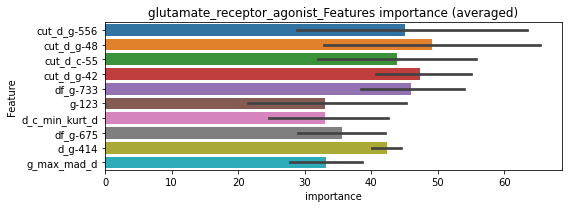

len(train_index) : 3876
len(valid_index) : 3876
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261874	valid_1's binary_logloss: 0.0584286
[200]	training's binary_logloss: 0.0051464	valid_1's binary_logloss: 0.0345393
[300]	training's binary_logloss: 0.00148861	valid_1's binary_logloss: 0.0292736
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000996369	valid_1's binary_logloss: 0.0285352


len(train_index) : 3876
len(valid_index) : 3876
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287613	valid_1's binary_logloss: 0.0531331
[200]	training's binary_logloss: 0.00578696	valid_1's binary_logloss: 0.0269899
[300]	training's binary_logloss: 0.00163695	valid_1's binary_logloss: 0.0209102
[400]	training's binary_logloss: 0.0007302	valid_1's binary_logloss: 0.0194657
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000703813	valid_1's binary_logloss: 0.0193862


glutamate_receptor_agonist logloss: 0.02396067074511932


neg labels: 3289 → selected neg labels: 3226


glutamate_receptor_antagonist, len(trt): 367, len(othr): 3226, target_rate: 0.0154111 → Adj_target_rate: 0.0127105
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119079	valid_1's binary_logloss: 0.350652
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.106411	valid_1's binary_logloss: 0.3487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130277	valid_1's binary_logloss: 0.331501
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0604016	valid_1's binary_logloss: 0.320168


1 / 3 AUC score:0.809
y_Threshold: 0.1282639, Threshold: 0.1595340, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 642 → Positive_corect_labels: 389/3229
p_label_rate: 0.0200904 Vs.target_rate: 0.01541
Num_p_label: 80.0, conf_0:0.14358, conf_1:0.17549
threshold: 0.1595340, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 389.0/3229, y_label_rate: 0.1204707
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613369	valid_1's binary_logloss: 0.209595
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0291262	valid_1's binary_logloss: 0.199216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0692678	valid_1's binary_logloss: 0.202805
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0290252	valid_1's binary_logloss: 0.184789


2 / 3 AUC score:0.938
y_Threshold: 0.0844462, Threshold: 0.1595340, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 172 → Positive_corect_labels: 303.0/3057
p_label_rate: 0.0022602 Vs.target_rate: 0.01541
Num_p_label: 9.0, conf_0:0.14358, conf_1:0.17549
Num_p_label: 9.0, Expected: 61.4, Adj_threshold_1: 0.1595340
Num_p_label: 12.0, Expected: 61.4, Adj_threshold_2: 0.1495340
Num_p_label: 15.0, Expected: 61.4, Adj_threshold_3: 0.1395340
Num_p_label: 19.0, Expected: 61.4, Adj_threshold_4: 0.1295340
Num_p_label: 29.0, Expected: 61.4, Adj_threshold_5: 0.1195340
Num_p_label: 47.0, Expected: 61.4, Adj_threshold_6: 0.1095340
threshold: 0.1095340, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 303.0/3057, y_label_rate: 0.0991168
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440281	valid_1's binary_logloss: 0.155274
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0144272	valid_1's binary_logloss: 0.141588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421161	valid_1's binary_logloss: 0.154982
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0162374	valid_1's binary_logloss: 0.141299


3 / 3 AUC score:0.972
y_Threshold: 0.0616844, Threshold: 0.1095340, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 72 → Positive_corect_labels: 267.0/2985
p_label_rate: 0.0035158 Vs.target_rate: 0.01541
Num_p_label: 14.0, conf_0:0.09858, conf_1:0.12049
Num_p_label: 14.0, Expected: 61.4, Adj_threshold_1: 0.1095340
Num_p_label: 19.0, Expected: 61.4, Adj_threshold_2: 0.0995340
Num_p_label: 24.0, Expected: 61.4, Adj_threshold_3: 0.0895340
Num_p_label: 36.0, Expected: 61.4, Adj_threshold_4: 0.0795340
threshold: 0.0795340, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 303.0/6967, y_label_rate: 0.0434907


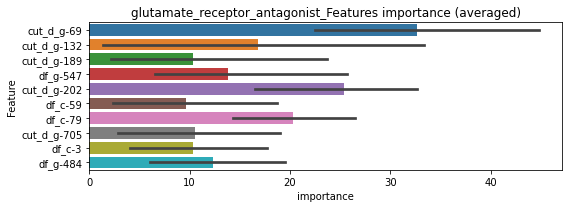

len(train_index) : 3483
len(valid_index) : 3484
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221535	valid_1's binary_logloss: 0.0850326
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.0124407	valid_1's binary_logloss: 0.0811142


len(train_index) : 3484
len(valid_index) : 3483
================================= fold 2/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212517	valid_1's binary_logloss: 0.0886047
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.00898345	valid_1's binary_logloss: 0.083732


glutamate_receptor_antagonist logloss: 0.08242290238494057


neg labels: 3289 → selected neg labels: 3286


gonadotropin_receptor_agonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212787	valid_1's binary_logloss: 0.0283574
[200]	training's binary_logloss: 0.00237239	valid_1's binary_logloss: 0.00747655
[300]	training's binary_logloss: 0.000688788	valid_1's binary_logloss: 0.00496805
[400]	training's binary_logloss: 0.000370289	valid_1's binary_logloss: 0.00413064
[500]	training's binary_logloss: 0.000303968	valid_1's binary_logloss: 0.00402253
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000304943	valid_1's binary_logloss: 0.00402021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221138	valid_1's binary_logloss: 0.0294446
[200]	training's binary_logloss: 0.00252293	valid_1's binary_logloss: 0.00546545
[300]	training's binary_logloss: 0.000717294	valid_1's binary_logloss: 0.00250868
[400]	training's binary_logloss: 0.000386431	valid_1's binary_logloss: 0.00180058
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0016095, Threshold: 0.0028654, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00258, conf_1:0.00315
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0028654
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.0128654
threshold: 0.0128654, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213786	valid_1's binary_logloss: 0.0279425
[200]	training's binary_logloss: 0.00232871	valid_1's binary_logloss: 0.00745724
[300]	training's binary_logloss: 0.000671628	valid_1's binary_logloss: 0.00520355
[400]	training's binary_logloss: 0.000365222	valid_1's binary_logloss: 0.00446248
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000322551	valid_1's binary_logloss: 0.00435745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221178	valid_1's binary_logloss: 0.0297112
[200]	training's binary_logloss: 0.0024433	valid_1's binary_logloss: 0.00524275
[300]	training's binary_logloss: 0.000686549	valid_1's binary_logloss: 0.00246641
[400]	training's binary_logloss: 0.00037372	valid_1's binary_logloss: 0.0018392
[500]	training's binary_logloss: 0.000302763	valid_1's binary_logloss: 0.00171577
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0193156, Threshold: 0.0128654, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0070316 Vs.target_rate: 0.00076
Num_p_label: 28.0, conf_0:0.01158, conf_1:0.01415
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_1: 0.0128654
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.0228654
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0328654
threshold: 0.0328654, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213786	valid_1's binary_logloss: 0.0279425
[200]	training's binary_logloss: 0.00232871	valid_1's binary_logloss: 0.00745724
[300]	training's binary_logloss: 0.000671628	valid_1's binary_logloss: 0.00520355
[400]	training's binary_logloss: 0.000365222	valid_1's binary_logloss: 0.00446248
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000322551	valid_1's binary_logloss: 0.00435745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221178	valid_1's binary_logloss: 0.0297112
[200]	training's binary_logloss: 0.0024433	valid_1's binary_logloss: 0.00524275
[300]	training's binary_logloss: 0.000686549	valid_1's binary_logloss: 0.00246641
[400]	training's binary_logloss: 0.00037372	valid_1's binary_logloss: 0.0018392
[500]	training's binary_logloss: 0.000302763	valid_1's binary_logloss: 0.00171577
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.0193156, Threshold: 0.0328654, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076
Num_p_label: 5.0, conf_0:0.02958, conf_1:0.03615
threshold: 0.0328654, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


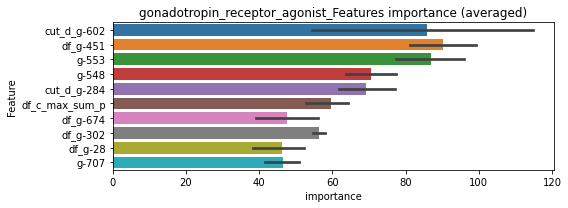

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0116222	valid_1's binary_logloss: 0.019294
[200]	training's binary_logloss: 0.00126138	valid_1's binary_logloss: 0.00776676
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000403016	valid_1's binary_logloss: 0.00654964


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118617	valid_1's binary_logloss: 0.0151468
[200]	training's binary_logloss: 0.00134379	valid_1's binary_logloss: 0.00325654
[300]	training's binary_logloss: 0.000377659	valid_1's binary_logloss: 0.00202657
[400]	training's binary_logloss: 0.000197396	valid_1's binary_logloss: 0.00178098
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000174904	valid_1's binary_logloss: 0.0017474


gonadotropin_receptor_agonist logloss: 0.004148826970730344


neg labels: 3289 → selected neg labels: 3279


gsk_inhibitor, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322858	valid_1's binary_logloss: 0.0628087
[200]	training's binary_logloss: 0.0049492	valid_1's binary_logloss: 0.0265923
[300]	training's binary_logloss: 0.00144293	valid_1's binary_logloss: 0.0186644
[400]	training's binary_logloss: 0.000714552	valid_1's binary_logloss: 0.0167902
[500]	training's binary_logloss: 0.000478426	valid_1's binary_logloss: 0.0158221
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000429602	valid_1's binary_logloss: 0.0156112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316895	valid_1's binary_logloss: 0.0670052
[200]	training's binary_logloss: 0.00475519	valid_1's binary_logloss: 0.0316899
[300]	training's binary_logloss: 0.00141416	valid_1's binary_logloss: 0.0254755
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000969645	valid_1's binary_logloss: 0.0245606


1 / 3 AUC score:1.000
y_Threshold: 0.0034891, Threshold: 0.0054940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00252
Num_p_label: 80.0, conf_0:0.00494, conf_1:0.00604
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0054940
Num_p_label: 16.0, Expected: 10.0, Adj_threshold_2: 0.0154940
threshold: 0.0154940, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315369	valid_1's binary_logloss: 0.0597915
[200]	training's binary_logloss: 0.00470101	valid_1's binary_logloss: 0.0241591
[300]	training's binary_logloss: 0.00138683	valid_1's binary_logloss: 0.0168321
[400]	training's binary_logloss: 0.00069325	valid_1's binary_logloss: 0.0150783
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000510929	valid_1's binary_logloss: 0.0143914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317309	valid_1's binary_logloss: 0.0597571
[200]	training's binary_logloss: 0.00473306	valid_1's binary_logloss: 0.024072
[300]	training's binary_logloss: 0.00139037	valid_1's binary_logloss: 0.0173852
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000738129	valid_1's binary_logloss: 0.0155516


2 / 3 AUC score:1.000
y_Threshold: 0.0128044, Threshold: 0.0154940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3798
p_label_rate: 0.0062783 Vs.target_rate: 0.00252
Num_p_label: 25.0, conf_0:0.01394, conf_1:0.01704
threshold: 0.0154940, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316146	valid_1's binary_logloss: 0.0575547
[200]	training's binary_logloss: 0.00470415	valid_1's binary_logloss: 0.022011
[300]	training's binary_logloss: 0.00137195	valid_1's binary_logloss: 0.0154156
[400]	training's binary_logloss: 0.000692099	valid_1's binary_logloss: 0.0132799
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000480929	valid_1's binary_logloss: 0.0125332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326047	valid_1's binary_logloss: 0.053148
[200]	training's binary_logloss: 0.00480652	valid_1's binary_logloss: 0.0176917
[300]	training's binary_logloss: 0.00140717	valid_1's binary_logloss: 0.0115723
[400]	training's binary_logloss: 0.000709619	valid_1's binary_logloss: 0.00997238
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000524812	valid_1's binary_logloss: 0.00936074


3 / 3 AUC score:1.000
y_Threshold: 0.0166316, Threshold: 0.0154940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3798
p_label_rate: 0.0050226 Vs.target_rate: 0.00252
Num_p_label: 20.0, conf_0:0.01394, conf_1:0.01704
threshold: 0.0154940, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 673.0/7780, y_label_rate: 0.0865039


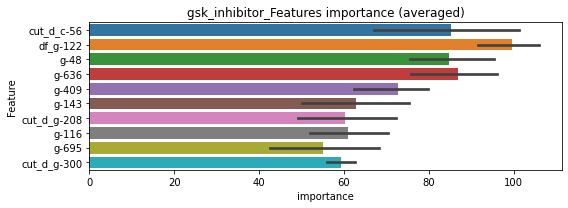

len(train_index) : 3890
len(valid_index) : 3890
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163777	valid_1's binary_logloss: 0.0458682
[200]	training's binary_logloss: 0.00233653	valid_1's binary_logloss: 0.0299474
[300]	training's binary_logloss: 0.000678412	valid_1's binary_logloss: 0.0273728
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000717918	valid_1's binary_logloss: 0.0272807


len(train_index) : 3890
len(valid_index) : 3890
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179093	valid_1's binary_logloss: 0.0319697
[200]	training's binary_logloss: 0.00264967	valid_1's binary_logloss: 0.0120208
[300]	training's binary_logloss: 0.000781152	valid_1's binary_logloss: 0.00855408
[400]	training's binary_logloss: 0.000394827	valid_1's binary_logloss: 0.00772084
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000347866	valid_1's binary_logloss: 0.00755203


gsk_inhibitor logloss: 0.01741638137257862


neg labels: 3289 → selected neg labels: 3277


hcv_inhibitor, len(trt): 72, len(othr): 3277, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465187	valid_1's binary_logloss: 0.10542
[200]	training's binary_logloss: 0.00919602	valid_1's binary_logloss: 0.0634241
[300]	training's binary_logloss: 0.00275629	valid_1's binary_logloss: 0.0544402
[400]	training's binary_logloss: 0.00130114	valid_1's binary_logloss: 0.0524324
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000972613	valid_1's binary_logloss: 0.05151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472082	valid_1's binary_logloss: 0.0931586
[200]	training's binary_logloss: 0.00958147	valid_1's binary_logloss: 0.0541255
[300]	training's binary_logloss: 0.00287122	valid_1's binary_logloss: 0.0469578
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00177455	valid_1's binary_logloss: 0.0456399


1 / 3 AUC score:0.997
y_Threshold: 0.0081086, Threshold: 0.0101695, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 647/3784
p_label_rate: 0.0200904 Vs.target_rate: 0.00302
Num_p_label: 80.0, conf_0:0.00915, conf_1:0.01119
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0101695
Num_p_label: 15.0, Expected: 12.0, Adj_threshold_2: 0.0201695
threshold: 0.0201695, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 647.0/3784, y_label_rate: 0.1709831
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451523	valid_1's binary_logloss: 0.0968464
[200]	training's binary_logloss: 0.00841175	valid_1's binary_logloss: 0.0547211
[300]	training's binary_logloss: 0.00254799	valid_1's binary_logloss: 0.0478517
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00146364	valid_1's binary_logloss: 0.0458727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462816	valid_1's binary_logloss: 0.0813302
[200]	training's binary_logloss: 0.00915891	valid_1's binary_logloss: 0.0389934
[300]	training's binary_logloss: 0.00275187	valid_1's binary_logloss: 0.029524
[400]	training's binary_logloss: 0.0013085	valid_1's binary_logloss: 0.0266925
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000975118	valid_1's binary_logloss: 0.0256974


2 / 3 AUC score:0.998
y_Threshold: 0.0196194, Threshold: 0.0201695, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 639.0/3768
p_label_rate: 0.0105475 Vs.target_rate: 0.00302
Num_p_label: 42.0, conf_0:0.01815, conf_1:0.02219
Num_p_label: 42.0, Expected: 12.0, Adj_threshold_1: 0.0201695
Num_p_label: 20.0, Expected: 12.0, Adj_threshold_2: 0.0301695
threshold: 0.0301695, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 639.0/3768, y_label_rate: 0.1695860
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446757	valid_1's binary_logloss: 0.090542
[200]	training's binary_logloss: 0.00835929	valid_1's binary_logloss: 0.0508225
[300]	training's binary_logloss: 0.00244553	valid_1's binary_logloss: 0.0413959
[400]	training's binary_logloss: 0.00115404	valid_1's binary_logloss: 0.0393423
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00114101	valid_1's binary_logloss: 0.0392829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459969	valid_1's binary_logloss: 0.0886917
[200]	training's binary_logloss: 0.00868483	valid_1's binary_logloss: 0.0498418
[300]	training's binary_logloss: 0.00257531	valid_1's binary_logloss: 0.0409785
[400]	training's binary_logloss: 0.00122463	valid_1's binary_logloss: 0.0376786
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00104862	valid_1's binary_logloss: 0.0371634


3 / 3 AUC score:0.999
y_Threshold: 0.0222410, Threshold: 0.0301695, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 632.0/3754
p_label_rate: 0.0052737 Vs.target_rate: 0.00302
Num_p_label: 21.0, conf_0:0.02715, conf_1:0.03319
threshold: 0.0301695, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 653.0/7736, y_label_rate: 0.0844105


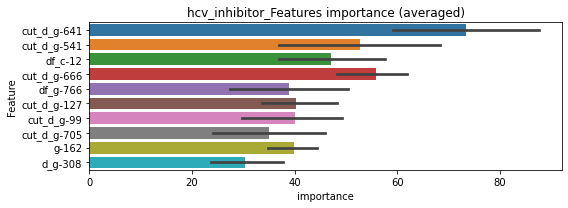

len(train_index) : 3868
len(valid_index) : 3868
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246453	valid_1's binary_logloss: 0.0568771
[200]	training's binary_logloss: 0.00473797	valid_1's binary_logloss: 0.0371377
[300]	training's binary_logloss: 0.00139155	valid_1's binary_logloss: 0.0336183
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00137841	valid_1's binary_logloss: 0.0335935


len(train_index) : 3868
len(valid_index) : 3868
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259896	valid_1's binary_logloss: 0.0565786
[200]	training's binary_logloss: 0.00501697	valid_1's binary_logloss: 0.0367338
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00255949	valid_1's binary_logloss: 0.034555


hcv_inhibitor logloss: 0.034074231800443715


neg labels: 3289 → selected neg labels: 3271


hdac_inhibitor, len(trt): 106, len(othr): 3271, target_rate: 0.0044512 → Adj_target_rate: 0.0044229
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309883	valid_1's binary_logloss: 0.0600659
[200]	training's binary_logloss: 0.00461479	valid_1's binary_logloss: 0.0296903
[300]	training's binary_logloss: 0.00134942	valid_1's binary_logloss: 0.0242936
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000967417	valid_1's binary_logloss: 0.0234935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301579	valid_1's binary_logloss: 0.0694936
[200]	training's binary_logloss: 0.00462693	valid_1's binary_logloss: 0.0463851
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00232843	valid_1's binary_logloss: 0.0452905


1 / 3 AUC score:0.998
y_Threshold: 0.0082098, Threshold: 0.0290419, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 145 → Positive_corect_labels: 647/3780
p_label_rate: 0.0200904 Vs.target_rate: 0.00445
Num_p_label: 80.0, conf_0:0.02614, conf_1:0.03195
Num_p_label: 80.0, Expected: 17.7, Adj_threshold_1: 0.0290419
Num_p_label: 52.0, Expected: 17.7, Adj_threshold_2: 0.0390419
Num_p_label: 42.0, Expected: 17.7, Adj_threshold_3: 0.0490419
Num_p_label: 39.0, Expected: 17.7, Adj_threshold_4: 0.0590419
Num_p_label: 35.0, Expected: 17.7, Adj_threshold_5: 0.0690419
threshold: 0.0690419, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 647.0/3780, y_label_rate: 0.1711640
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290561	valid_1's binary_logloss: 0.0581421
[200]	training's binary_logloss: 0.0040403	valid_1's binary_logloss: 0.0268708
[300]	training's binary_logloss: 0.00117687	valid_1's binary_logloss: 0.0208991
[400]	training's binary_logloss: 0.000599239	valid_1's binary_logloss: 0.0192125
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000627009	valid_1's binary_logloss: 0.0191935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304841	valid_1's binary_logloss: 0.0589739
[200]	training's binary_logloss: 0.0042866	valid_1's binary_logloss: 0.0249232
[300]	training's binary_logloss: 0.00124149	valid_1's binary_logloss: 0.0185956
[400]	training's binary_logloss: 0.000627241	valid_1's binary_logloss: 0.0162206
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000608583	valid_1's binary_logloss: 0.0161111


2 / 3 AUC score:1.000
y_Threshold: 0.0472691, Threshold: 0.0690419, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 643.0/3772
p_label_rate: 0.0188348 Vs.target_rate: 0.00445
Num_p_label: 75.0, conf_0:0.06214, conf_1:0.07595
Num_p_label: 75.0, Expected: 17.7, Adj_threshold_1: 0.0690419
Num_p_label: 69.0, Expected: 17.7, Adj_threshold_2: 0.0790419
Num_p_label: 64.0, Expected: 17.7, Adj_threshold_3: 0.0890419
Num_p_label: 61.0, Expected: 17.7, Adj_threshold_4: 0.0990419
Num_p_label: 56.0, Expected: 17.7, Adj_threshold_5: 0.1090419
Num_p_label: 54.0, Expected: 17.7, Adj_threshold_6: 0.1190419
Num_p_label: 53.0, Expected: 17.7, Adj_threshold_7: 0.1290419
Num_p_label: 48.0, Expected: 17.7, Adj_threshold_8: 0.1390419
Num_p_label: 47.0, Expected: 17.7, Adj_threshold_9: 0.1490419
Num_p_label: 45.0, Expected: 17.7, Adj_threshold_10: 0.1590419
threshold: 0.1690419, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 643.0/3772, y_label_rate: 0.1704666

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290616	valid_1's binary_logloss: 0.059152
[200]	training's binary_logloss: 0.00397296	valid_1's binary_logloss: 0.0276619
[300]	training's binary_logloss: 0.00114942	valid_1's binary_logloss: 0.0223098
[400]	training's binary_logloss: 0.000583183	valid_1's binary_logloss: 0.0204621
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000583183	valid_1's binary_logloss: 0.0204621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293109	valid_1's binary_logloss: 0.05589
[200]	training's binary_logloss: 0.00408771	valid_1's binary_logloss: 0.024101
[300]	training's binary_logloss: 0.00118881	valid_1's binary_logloss: 0.0170511
[400]	training's binary_logloss: 0.000613502	valid_1's binary_logloss: 0.0150737
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000585605	valid_1's binary_logloss: 0.0149026


3 / 3 AUC score:1.000
y_Threshold: 0.0295574, Threshold: 0.1690419, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 640.0/3766
p_label_rate: 0.0115520 Vs.target_rate: 0.00445
Num_p_label: 46.0, conf_0:0.15214, conf_1:0.18595
threshold: 0.1690419, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 686.0/7748, y_label_rate: 0.0885390


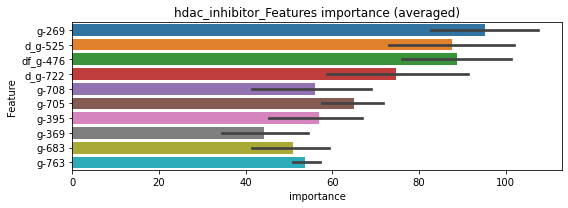

len(train_index) : 3874
len(valid_index) : 3874
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160805	valid_1's binary_logloss: 0.0426446
[200]	training's binary_logloss: 0.00233576	valid_1's binary_logloss: 0.027619
[300]	training's binary_logloss: 0.000702293	valid_1's binary_logloss: 0.0241978
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000495259	valid_1's binary_logloss: 0.0235181


len(train_index) : 3874
len(valid_index) : 3874
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171823	valid_1's binary_logloss: 0.0441692
[200]	training's binary_logloss: 0.00244788	valid_1's binary_logloss: 0.0276762
[300]	training's binary_logloss: 0.000718543	valid_1's binary_logloss: 0.0239611
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000527144	valid_1's binary_logloss: 0.0233474


hdac_inhibitor logloss: 0.02343272932809707


neg labels: 3289 → selected neg labels: 3279


histamine_receptor_agonist, len(trt): 59, len(othr): 3279, target_rate: 0.0024775 → Adj_target_rate: 0.0026880
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444302	valid_1's binary_logloss: 0.0804827
[200]	training's binary_logloss: 0.00805358	valid_1's binary_logloss: 0.0344499
[300]	training's binary_logloss: 0.00229986	valid_1's binary_logloss: 0.0241928
[400]	training's binary_logloss: 0.0010826	valid_1's binary_logloss: 0.0211066
[500]	training's binary_logloss: 0.000683843	valid_1's binary_logloss: 0.0197882
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000582513	valid_1's binary_logloss: 0.0196341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414749	valid_1's binary_logloss: 0.079695
[200]	training's binary_logloss: 0.00761044	valid_1's binary_logloss: 0.0391568
[300]	training's binary_logloss: 0.00225843	valid_1's binary_logloss: 0.0320773
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00138181	valid_1's binary_logloss: 0.0302354


1 / 3 AUC score:0.999
y_Threshold: 0.0061411, Threshold: 0.0080060, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3798
p_label_rate: 0.0200904 Vs.target_rate: 0.00248
Num_p_label: 80.0, conf_0:0.00721, conf_1:0.00881
Num_p_label: 80.0, Expected: 9.9, Adj_threshold_1: 0.0080060
Num_p_label: 14.0, Expected: 9.9, Adj_threshold_2: 0.0180060
threshold: 0.0180060, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409392	valid_1's binary_logloss: 0.0810189
[200]	training's binary_logloss: 0.00742023	valid_1's binary_logloss: 0.0397537
[300]	training's binary_logloss: 0.00215528	valid_1's binary_logloss: 0.0295081
[400]	training's binary_logloss: 0.00103188	valid_1's binary_logloss: 0.0263702
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000702729	valid_1's binary_logloss: 0.0250096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428088	valid_1's binary_logloss: 0.0789031
[200]	training's binary_logloss: 0.00762814	valid_1's binary_logloss: 0.0353198
[300]	training's binary_logloss: 0.00223581	valid_1's binary_logloss: 0.0257442
[400]	training's binary_logloss: 0.00107205	valid_1's binary_logloss: 0.0230309
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000838118	valid_1's binary_logloss: 0.0222825


2 / 3 AUC score:1.000
y_Threshold: 0.0281882, Threshold: 0.0180060, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 648.0/3788
p_label_rate: 0.0095429 Vs.target_rate: 0.00248
Num_p_label: 38.0, conf_0:0.01621, conf_1:0.01981
Num_p_label: 38.0, Expected: 9.9, Adj_threshold_1: 0.0180060
Num_p_label: 22.0, Expected: 9.9, Adj_threshold_2: 0.0280060
Num_p_label: 11.0, Expected: 9.9, Adj_threshold_3: 0.0380060
threshold: 0.0380060, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 648.0/3788, y_label_rate: 0.1710665
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393864	valid_1's binary_logloss: 0.0789486
[200]	training's binary_logloss: 0.00677261	valid_1's binary_logloss: 0.0387032
[300]	training's binary_logloss: 0.00199882	valid_1's binary_logloss: 0.0298732
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00111021	valid_1's binary_logloss: 0.0275025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435561	valid_1's binary_logloss: 0.0734685
[200]	training's binary_logloss: 0.00784176	valid_1's binary_logloss: 0.0282742
[300]	training's binary_logloss: 0.00224962	valid_1's binary_logloss: 0.0185173
[400]	training's binary_logloss: 0.00107638	valid_1's binary_logloss: 0.0155254
[500]	training's binary_logloss: 0.000688743	valid_1's binary_logloss: 0.0144039
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000672245	valid_1's binary_logloss: 0.0143064


3 / 3 AUC score:1.000
y_Threshold: 0.0309237, Threshold: 0.0380060, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 644.0/3780
p_label_rate: 0.0035158 Vs.target_rate: 0.00248
Num_p_label: 14.0, conf_0:0.03421, conf_1:0.04181
threshold: 0.0380060, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 658.0/7762, y_label_rate: 0.0847720


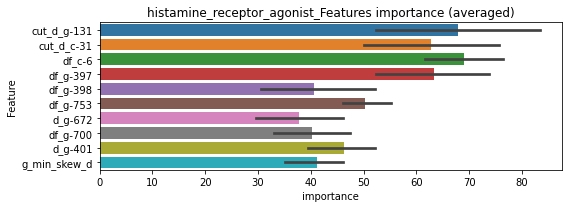

len(train_index) : 3881
len(valid_index) : 3881
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221297	valid_1's binary_logloss: 0.0541102
[200]	training's binary_logloss: 0.00372006	valid_1's binary_logloss: 0.0311796
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00126076	valid_1's binary_logloss: 0.0276832


len(train_index) : 3881
len(valid_index) : 3881
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243387	valid_1's binary_logloss: 0.0425991
[200]	training's binary_logloss: 0.00431154	valid_1's binary_logloss: 0.0195299
[300]	training's binary_logloss: 0.00124854	valid_1's binary_logloss: 0.0142504
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000747562	valid_1's binary_logloss: 0.0134039


histamine_receptor_agonist logloss: 0.020543551688426122


neg labels: 3289 → selected neg labels: 3249


histamine_receptor_antagonist, len(trt): 241, len(othr): 3249, target_rate: 0.0101201 → Adj_target_rate: 0.0088902
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943475	valid_1's binary_logloss: 0.246535
[200]	training's binary_logloss: 0.0326302	valid_1's binary_logloss: 0.224528
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0276307	valid_1's binary_logloss: 0.223934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950138	valid_1's binary_logloss: 0.243993
[200]	training's binary_logloss: 0.0309692	valid_1's binary_logloss: 0.215758
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0217956	valid_1's binary_logloss: 0.213367


1 / 3 AUC score:0.925
y_Threshold: 0.0671883, Threshold: 0.0909902, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 379 → Positive_corect_labels: 525/3519
p_label_rate: 0.0200904 Vs.target_rate: 0.01012
Num_p_label: 80.0, conf_0:0.08189, conf_1:0.10009
threshold: 0.0909902, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 525.0/3519, y_label_rate: 0.1491901
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674652	valid_1's binary_logloss: 0.18015
[200]	training's binary_logloss: 0.0191536	valid_1's binary_logloss: 0.142492
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0108941	valid_1's binary_logloss: 0.136704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0676991	valid_1's binary_logloss: 0.173224
[200]	training's binary_logloss: 0.0186482	valid_1's binary_logloss: 0.140027
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0105401	valid_1's binary_logloss: 0.134118


2 / 3 AUC score:0.978
y_Threshold: 0.0695698, Threshold: 0.0909902, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 98 → Positive_corect_labels: 476.0/3421
p_label_rate: 0.0135610 Vs.target_rate: 0.01012
Num_p_label: 54.0, conf_0:0.08189, conf_1:0.10009
threshold: 0.0909902, positive_p_label: 54.0/3982, p_label_rate: 0.0135610
positive_y_label: 476.0/3421, y_label_rate: 0.1391406
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516474	valid_1's binary_logloss: 0.15548
[200]	training's binary_logloss: 0.0123698	valid_1's binary_logloss: 0.126695
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0076004	valid_1's binary_logloss: 0.124481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532601	valid_1's binary_logloss: 0.155591
[200]	training's binary_logloss: 0.0132057	valid_1's binary_logloss: 0.127095
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00871623	valid_1's binary_logloss: 0.124853


3 / 3 AUC score:0.986
y_Threshold: 0.0548171, Threshold: 0.0909902, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 78 → Positive_corect_labels: 437.0/3343
p_label_rate: 0.0075339 Vs.target_rate: 0.01012
Num_p_label: 30.0, conf_0:0.08189, conf_1:0.10009
threshold: 0.0909902, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 467.0/7325, y_label_rate: 0.0637543


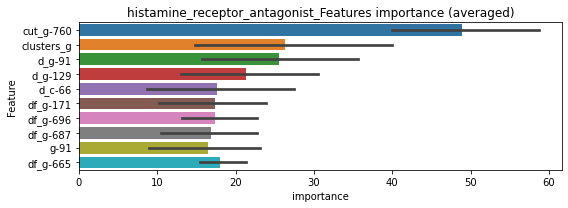

len(train_index) : 3662
len(valid_index) : 3663
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259183	valid_1's binary_logloss: 0.0916659
[200]	training's binary_logloss: 0.00614331	valid_1's binary_logloss: 0.0803243
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00583618	valid_1's binary_logloss: 0.080084


len(train_index) : 3663
len(valid_index) : 3662
================================= fold 2/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278848	valid_1's binary_logloss: 0.0840662
[200]	training's binary_logloss: 0.00665121	valid_1's binary_logloss: 0.0701674
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00656997	valid_1's binary_logloss: 0.0701101


histamine_receptor_antagonist logloss: 0.07509773057206677


neg labels: 3289 → selected neg labels: 3285


histone_lysine_demethylase_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232906	valid_1's binary_logloss: 0.0330827
[200]	training's binary_logloss: 0.0027082	valid_1's binary_logloss: 0.00674266
[300]	training's binary_logloss: 0.000767347	valid_1's binary_logloss: 0.00324731
[400]	training's binary_logloss: 0.000403694	valid_1's binary_logloss: 0.0023475
[500]	training's binary_logloss: 0.000311942	valid_1's binary_logloss: 0.00208682
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000308441	valid_1's binary_logloss: 0.00207529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245192	valid_1's binary_logloss: 0.0336709
[200]	training's binary_logloss: 0.00289081	valid_1's binary_logloss: 0.00543517
[300]	training's binary_logloss: 0.000794329	valid_1's binary_logloss: 0.00195801
[400]	training's binary_logloss: 0.000418164	valid_1's binary_logloss: 0.00129958
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0012870, Threshold: 0.0020201, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00182, conf_1:0.00222
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0020201
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_2: 0.0120201
threshold: 0.0120201, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235449	valid_1's binary_logloss: 0.0330641
[200]	training's binary_logloss: 0.00273757	valid_1's binary_logloss: 0.00681425
[300]	training's binary_logloss: 0.000769414	valid_1's binary_logloss: 0.0033051
[400]	training's binary_logloss: 0.000404145	valid_1's binary_logloss: 0.00240375
[500]	training's binary_logloss: 0.00031337	valid_1's binary_logloss: 0.00216764
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000313232	valid_1's binary_logloss: 0.00216686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243048	valid_1's binary_logloss: 0.0330472
[200]	training's binary_logloss: 0.00283086	valid_1's binary_logloss: 0.00538145
[300]	training's binary_logloss: 0.000781277	valid_1's binary_logloss: 0.00208072
[400]	training's binary_logloss: 0.00041375	valid_1's binary_logloss: 0.00142745
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.0443295, Threshold: 0.0120201, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0040181 Vs.target_rate: 0.00101
Num_p_label: 16.0, conf_0:0.01082, conf_1:0.01322
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_1: 0.0120201
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_2: 0.0220201
threshold: 0.0220201, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235449	valid_1's binary_logloss: 0.0330641
[200]	training's binary_logloss: 0.00273757	valid_1's binary_logloss: 0.00681425
[300]	training's binary_logloss: 0.000769414	valid_1's binary_logloss: 0.0033051
[400]	training's binary_logloss: 0.000404145	valid_1's binary_logloss: 0.00240375
[500]	training's binary_logloss: 0.00031337	valid_1's binary_logloss: 0.00216764
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000313232	valid_1's binary_logloss: 0.00216686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243048	valid_1's binary_logloss: 0.0330472
[200]	training's binary_logloss: 0.00283086	valid_1's binary_logloss: 0.00538145
[300]	training's binary_logloss: 0.000781277	valid_1's binary_logloss: 0.00208072
[400]	training's binary_logloss: 0.00041375	valid_1's binary_logloss: 0.00142745
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.0443295, Threshold: 0.0220201, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00101
Num_p_label: 8.0, conf_0:0.01982, conf_1:0.02422
threshold: 0.0220201, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7792, y_label_rate: 0.0853439


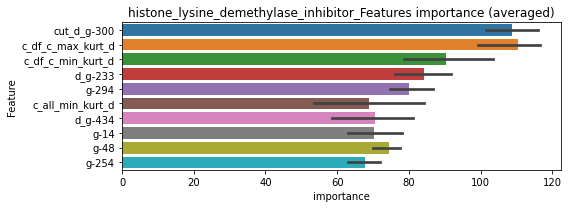

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122831	valid_1's binary_logloss: 0.0233925
[200]	training's binary_logloss: 0.00140091	valid_1's binary_logloss: 0.00971844
[300]	training's binary_logloss: 0.000391244	valid_1's binary_logloss: 0.00875897
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000409409	valid_1's binary_logloss: 0.00873257


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013253	valid_1's binary_logloss: 0.0181762
[200]	training's binary_logloss: 0.00157751	valid_1's binary_logloss: 0.00481093
[300]	training's binary_logloss: 0.000435483	valid_1's binary_logloss: 0.00344328
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.000311783	valid_1's binary_logloss: 0.00331625


histone_lysine_demethylase_inhibitor logloss: 0.00602441026859345


neg labels: 3289 → selected neg labels: 3283


histone_lysine_methyltransferase_inhibitor, len(trt): 32, len(othr): 3283, target_rate: 0.0013437 → Adj_target_rate: 0.0015980
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265903	valid_1's binary_logloss: 0.0482252
[200]	training's binary_logloss: 0.00349988	valid_1's binary_logloss: 0.0167336
[300]	training's binary_logloss: 0.00100795	valid_1's binary_logloss: 0.0109269
[400]	training's binary_logloss: 0.000520737	valid_1's binary_logloss: 0.0092003
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000417988	valid_1's binary_logloss: 0.00872031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272275	valid_1's binary_logloss: 0.048883
[200]	training's binary_logloss: 0.00365198	valid_1's binary_logloss: 0.0184031
[300]	training's binary_logloss: 0.00104784	valid_1's binary_logloss: 0.0131507
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000592341	valid_1's binary_logloss: 0.0122684


1 / 3 AUC score:1.000
y_Threshold: 0.0027686, Threshold: 0.0038125, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00134
Num_p_label: 80.0, conf_0:0.00343, conf_1:0.00419
Num_p_label: 80.0, Expected: 5.4, Adj_threshold_1: 0.0038125
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_2: 0.0138125
threshold: 0.0138125, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272045	valid_1's binary_logloss: 0.0482883
[200]	training's binary_logloss: 0.00349274	valid_1's binary_logloss: 0.0168676
[300]	training's binary_logloss: 0.00100773	valid_1's binary_logloss: 0.0115077
[400]	training's binary_logloss: 0.00052503	valid_1's binary_logloss: 0.0097279
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000495218	valid_1's binary_logloss: 0.00962471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266726	valid_1's binary_logloss: 0.0471013
[200]	training's binary_logloss: 0.00351758	valid_1's binary_logloss: 0.0169658
[300]	training's binary_logloss: 0.00102346	valid_1's binary_logloss: 0.0121471
[400]	training's binary_logloss: 0.000522095	valid_1's binary_logloss: 0.0110583
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000427543	valid_1's binary_logloss: 0.0108182


2 / 3 AUC score:1.000
y_Threshold: 0.0198232, Threshold: 0.0138125, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0060271 Vs.target_rate: 0.00134
Num_p_label: 24.0, conf_0:0.01243, conf_1:0.01519
Num_p_label: 24.0, Expected: 5.4, Adj_threshold_1: 0.0138125
Num_p_label: 15.0, Expected: 5.4, Adj_threshold_2: 0.0238125
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_3: 0.0338125
threshold: 0.0338125, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278148	valid_1's binary_logloss: 0.0423125
[200]	training's binary_logloss: 0.00366534	valid_1's binary_logloss: 0.0100811
[300]	training's binary_logloss: 0.00104763	valid_1's binary_logloss: 0.00498756
[400]	training's binary_logloss: 0.000531765	valid_1's binary_logloss: 0.00396135
[500]	training's binary_logloss: 0.000377849	valid_1's binary_logloss: 0.0035871
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000385027	valid_1's binary_logloss: 0.00357899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270607	valid_1's binary_logloss: 0.0467355
[200]	training's binary_logloss: 0.00355576	valid_1's binary_logloss: 0.0149403
[300]	training's binary_logloss: 0.00102583	valid_1's binary_logloss: 0.00904242
[400]	training's binary_logloss: 0.000517064	valid_1's binary_logloss: 0.00720524
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0241229, Threshold: 0.0338125, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0025113 Vs.target_rate: 0.00134
Num_p_label: 10.0, conf_0:0.03043, conf_1:0.03719
threshold: 0.0338125, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 665.0/7787, y_label_rate: 0.0853987


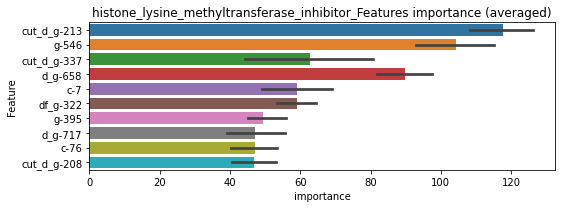

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143466	valid_1's binary_logloss: 0.0282331
[200]	training's binary_logloss: 0.00191313	valid_1's binary_logloss: 0.014111
[300]	training's binary_logloss: 0.0005361	valid_1's binary_logloss: 0.0125405
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000522076	valid_1's binary_logloss: 0.012533


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150798	valid_1's binary_logloss: 0.0278331
[200]	training's binary_logloss: 0.00199368	valid_1's binary_logloss: 0.0121813
[300]	training's binary_logloss: 0.00056729	valid_1's binary_logloss: 0.00936737
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000303038	valid_1's binary_logloss: 0.00850273


histone_lysine_methyltransferase_inhibitor logloss: 0.01051810322665079


neg labels: 3289 → selected neg labels: 3278


hiv_inhibitor, len(trt): 72, len(othr): 3278, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500643	valid_1's binary_logloss: 0.0974246
[200]	training's binary_logloss: 0.00996356	valid_1's binary_logloss: 0.0491522
[300]	training's binary_logloss: 0.0029199	valid_1's binary_logloss: 0.0378439
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00141789	valid_1's binary_logloss: 0.0349929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493576	valid_1's binary_logloss: 0.0977972
[200]	training's binary_logloss: 0.00949472	valid_1's binary_logloss: 0.0573676
[300]	training's binary_logloss: 0.00279683	valid_1's binary_logloss: 0.0490743
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00248204	valid_1's binary_logloss: 0.048955


1 / 3 AUC score:0.999
y_Threshold: 0.0116747, Threshold: 0.0160413, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 648/3787
p_label_rate: 0.0200904 Vs.target_rate: 0.00302
Num_p_label: 80.0, conf_0:0.01444, conf_1:0.01765
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0160413
Num_p_label: 23.0, Expected: 12.0, Adj_threshold_2: 0.0260413
threshold: 0.0260413, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 648.0/3787, y_label_rate: 0.1711117
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462064	valid_1's binary_logloss: 0.0917137
[200]	training's binary_logloss: 0.00865923	valid_1's binary_logloss: 0.0465694
[300]	training's binary_logloss: 0.00255814	valid_1's binary_logloss: 0.0361786
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00140524	valid_1's binary_logloss: 0.0336656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0491019	valid_1's binary_logloss: 0.0950176
[200]	training's binary_logloss: 0.00976048	valid_1's binary_logloss: 0.0471849
[300]	training's binary_logloss: 0.00289908	valid_1's binary_logloss: 0.0354018
[400]	training's binary_logloss: 0.00133054	valid_1's binary_logloss: 0.0323884
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000871447	valid_1's binary_logloss: 0.0311109


2 / 3 AUC score:0.999
y_Threshold: 0.0372592, Threshold: 0.0260413, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 641.0/3773
p_label_rate: 0.0100452 Vs.target_rate: 0.00302
Num_p_label: 40.0, conf_0:0.02344, conf_1:0.02865
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_1: 0.0260413
Num_p_label: 22.0, Expected: 12.0, Adj_threshold_2: 0.0360413
threshold: 0.0360413, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 641.0/3773, y_label_rate: 0.1698913
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457777	valid_1's binary_logloss: 0.0908223
[200]	training's binary_logloss: 0.00866337	valid_1's binary_logloss: 0.0444467
[300]	training's binary_logloss: 0.00254311	valid_1's binary_logloss: 0.0338678
[400]	training's binary_logloss: 0.00120016	valid_1's binary_logloss: 0.0298169
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000970037	valid_1's binary_logloss: 0.0290149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485599	valid_1's binary_logloss: 0.0940161
[200]	training's binary_logloss: 0.0090168	valid_1's binary_logloss: 0.0467654
[300]	training's binary_logloss: 0.00265355	valid_1's binary_logloss: 0.0361603
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00154916	valid_1's binary_logloss: 0.0338641


3 / 3 AUC score:1.000
y_Threshold: 0.0268485, Threshold: 0.0360413, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 637.0/3765
p_label_rate: 0.0057760 Vs.target_rate: 0.00302
Num_p_label: 23.0, conf_0:0.03244, conf_1:0.03965
threshold: 0.0360413, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 660.0/7747, y_label_rate: 0.0851943


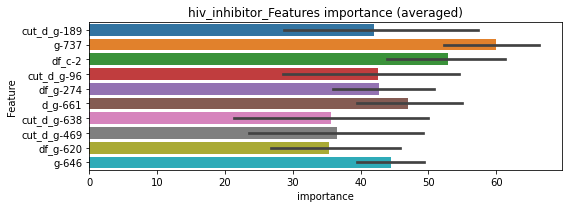

len(train_index) : 3873
len(valid_index) : 3874
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254342	valid_1's binary_logloss: 0.0557558
[200]	training's binary_logloss: 0.00487303	valid_1's binary_logloss: 0.0317636
[300]	training's binary_logloss: 0.00144238	valid_1's binary_logloss: 0.0270039
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000725756	valid_1's binary_logloss: 0.0256993


len(train_index) : 3874
len(valid_index) : 3873
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270007	valid_1's binary_logloss: 0.0521688
[200]	training's binary_logloss: 0.00538075	valid_1's binary_logloss: 0.0276108
[300]	training's binary_logloss: 0.00154434	valid_1's binary_logloss: 0.0231487
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000823609	valid_1's binary_logloss: 0.0223279


hiv_inhibitor logloss: 0.02401382011152706


neg labels: 3289 → selected neg labels: 3282


hmgcr_inhibitor, len(trt): 283, len(othr): 3282, target_rate: 0.0118838 → Adj_target_rate: 0.0101910
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406387	valid_1's binary_logloss: 0.0808176
[200]	training's binary_logloss: 0.00731548	valid_1's binary_logloss: 0.0489954
[300]	training's binary_logloss: 0.00228116	valid_1's binary_logloss: 0.0435584
[400]	training's binary_logloss: 0.00106652	valid_1's binary_logloss: 0.0409783
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00104407	valid_1's binary_logloss: 0.0407749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369137	valid_1's binary_logloss: 0.110521
[200]	training's binary_logloss: 0.00659738	valid_1's binary_logloss: 0.0892633
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00659738	valid_1's binary_logloss: 0.0892633


1 / 3 AUC score:0.994
y_Threshold: 0.0315114, Threshold: 0.1921181, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 166 → Positive_corect_labels: 639/3772
p_label_rate: 0.0200904 Vs.target_rate: 0.01188
Num_p_label: 80.0, conf_0:0.17291, conf_1:0.21133
threshold: 0.1921181, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 639.0/3772, y_label_rate: 0.1694062
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338538	valid_1's binary_logloss: 0.0677023
[200]	training's binary_logloss: 0.00526996	valid_1's binary_logloss: 0.0400534
[300]	training's binary_logloss: 0.00148672	valid_1's binary_logloss: 0.0361752
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00149844	valid_1's binary_logloss: 0.0361476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319813	valid_1's binary_logloss: 0.066602
[200]	training's binary_logloss: 0.00465762	valid_1's binary_logloss: 0.0395306
[300]	training's binary_logloss: 0.00131831	valid_1's binary_logloss: 0.0358236
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00133022	valid_1's binary_logloss: 0.0357862


2 / 3 AUC score:0.998
y_Threshold: 0.1234994, Threshold: 0.1921181, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 619.0/3732
p_label_rate: 0.0379206 Vs.target_rate: 0.01188
Num_p_label: 151.0, conf_0:0.17291, conf_1:0.21133
Num_p_label: 151.0, Expected: 47.3, Adj_threshold_1: 0.1921181
Num_p_label: 150.0, Expected: 47.3, Adj_threshold_2: 0.2021181
Num_p_label: 148.0, Expected: 47.3, Adj_threshold_3: 0.2121181
Num_p_label: 142.0, Expected: 47.3, Adj_threshold_4: 0.2221181
Num_p_label: 139.0, Expected: 47.3, Adj_threshold_5: 0.2321181
Num_p_label: 136.0, Expected: 47.3, Adj_threshold_6: 0.2421181
Num_p_label: 134.0, Expected: 47.3, Adj_threshold_7: 0.2521181
Num_p_label: 134.0, Expected: 47.3, Adj_threshold_8: 0.2621181
Num_p_label: 131.0, Expected: 47.3, Adj_threshold_9: 0.2721181
Num_p_label: 130.0, Expected: 47.3, Adj_threshold_10: 0.2821181
threshold: 0.2921181, positive_p_label: 128.0/3982, p_label_rate: 0.0321447
positive_y_label: 619.0/3732, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280942	valid_1's binary_logloss: 0.058457
[200]	training's binary_logloss: 0.00388969	valid_1's binary_logloss: 0.0271487
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00182299	valid_1's binary_logloss: 0.023537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298899	valid_1's binary_logloss: 0.0456827
[200]	training's binary_logloss: 0.00443358	valid_1's binary_logloss: 0.0147426
[300]	training's binary_logloss: 0.00125289	valid_1's binary_logloss: 0.00921914
[400]	training's binary_logloss: 0.000621752	valid_1's binary_logloss: 0.00745202
[500]	training's binary_logloss: 0.000421111	valid_1's binary_logloss: 0.00689424
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000405742	valid_1's binary_logloss: 0.00678437


3 / 3 AUC score:1.000
y_Threshold: 0.1710470, Threshold: 0.2921181, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 616.0/3726
p_label_rate: 0.0354093 Vs.target_rate: 0.01188
Num_p_label: 141.0, conf_0:0.26291, conf_1:0.32133
threshold: 0.2921181, positive_p_label: 141.0/3982, p_label_rate: 0.0354093
positive_y_label: 757.0/7708, y_label_rate: 0.0982097


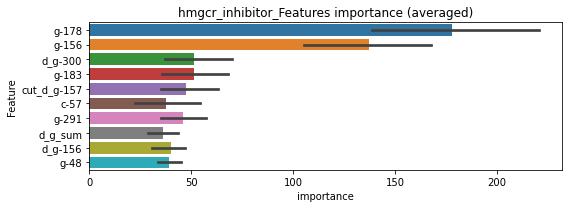

len(train_index) : 3854
len(valid_index) : 3854
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190476	valid_1's binary_logloss: 0.0424236
[200]	training's binary_logloss: 0.00290854	valid_1's binary_logloss: 0.0217621
[300]	training's binary_logloss: 0.000820721	valid_1's binary_logloss: 0.016186
[400]	training's binary_logloss: 0.000398026	valid_1's binary_logloss: 0.0143119
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000384526	valid_1's binary_logloss: 0.0141783


len(train_index) : 3854
len(valid_index) : 3854
================================= fold 2/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187032	valid_1's binary_logloss: 0.0416754
[200]	training's binary_logloss: 0.00297034	valid_1's binary_logloss: 0.0222323
[300]	training's binary_logloss: 0.000770707	valid_1's binary_logloss: 0.0162569
[400]	training's binary_logloss: 0.000367003	valid_1's binary_logloss: 0.0146222
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000269665	valid_1's binary_logloss: 0.0138926


hmgcr_inhibitor logloss: 0.014035475817631801


neg labels: 3289 → selected neg labels: 3275


hsp_inhibitor, len(trt): 93, len(othr): 3275, target_rate: 0.0039053 → Adj_target_rate: 0.0039574
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259923	valid_1's binary_logloss: 0.0421903
[200]	training's binary_logloss: 0.00336342	valid_1's binary_logloss: 0.0138916
[300]	training's binary_logloss: 0.000957573	valid_1's binary_logloss: 0.00787235
[400]	training's binary_logloss: 0.000495981	valid_1's binary_logloss: 0.0063159
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000379465	valid_1's binary_logloss: 0.00590331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258011	valid_1's binary_logloss: 0.0508773
[200]	training's binary_logloss: 0.00324457	valid_1's binary_logloss: 0.0257078
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00148524	valid_1's binary_logloss: 0.0231895


1 / 3 AUC score:1.000
y_Threshold: 0.0036618, Threshold: 0.0107522, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 133 → Positive_corect_labels: 654/3797
p_label_rate: 0.0200904 Vs.target_rate: 0.00391
Num_p_label: 80.0, conf_0:0.00968, conf_1:0.01183
Num_p_label: 80.0, Expected: 15.6, Adj_threshold_1: 0.0107522
Num_p_label: 59.0, Expected: 15.6, Adj_threshold_2: 0.0207522
Num_p_label: 40.0, Expected: 15.6, Adj_threshold_3: 0.0307522
Num_p_label: 27.0, Expected: 15.6, Adj_threshold_4: 0.0407522
threshold: 0.0407522, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 654.0/3797, y_label_rate: 0.1722412
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258266	valid_1's binary_logloss: 0.0380043
[200]	training's binary_logloss: 0.00326968	valid_1's binary_logloss: 0.0106818
[300]	training's binary_logloss: 0.000932448	valid_1's binary_logloss: 0.00635843
[400]	training's binary_logloss: 0.000484812	valid_1's binary_logloss: 0.00500849
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000375253	valid_1's binary_logloss: 0.00453459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260726	valid_1's binary_logloss: 0.0534697
[200]	training's binary_logloss: 0.00314001	valid_1's binary_logloss: 0.0273371
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00118525	valid_1's binary_logloss: 0.0246045


2 / 3 AUC score:1.000
y_Threshold: 0.0276195, Threshold: 0.0407522, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 651.0/3791
p_label_rate: 0.0183325 Vs.target_rate: 0.00391
Num_p_label: 73.0, conf_0:0.03668, conf_1:0.04483
Num_p_label: 73.0, Expected: 15.6, Adj_threshold_1: 0.0407522
Num_p_label: 63.0, Expected: 15.6, Adj_threshold_2: 0.0507522
Num_p_label: 54.0, Expected: 15.6, Adj_threshold_3: 0.0607522
Num_p_label: 50.0, Expected: 15.6, Adj_threshold_4: 0.0707522
Num_p_label: 48.0, Expected: 15.6, Adj_threshold_5: 0.0807522
Num_p_label: 45.0, Expected: 15.6, Adj_threshold_6: 0.0907522
Num_p_label: 43.0, Expected: 15.6, Adj_threshold_7: 0.1007522
Num_p_label: 42.0, Expected: 15.6, Adj_threshold_8: 0.1107522
Num_p_label: 39.0, Expected: 15.6, Adj_threshold_9: 0.1207522
Num_p_label: 38.0, Expected: 15.6, Adj_threshold_10: 0.1307522
threshold: 0.1407522, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 651.0/3791, y_label_rate: 0.1717225

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252007	valid_1's binary_logloss: 0.0402548
[200]	training's binary_logloss: 0.00312287	valid_1's binary_logloss: 0.0176332
[300]	training's binary_logloss: 0.000887869	valid_1's binary_logloss: 0.0149779
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000781591	valid_1's binary_logloss: 0.0147248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254074	valid_1's binary_logloss: 0.0481771
[200]	training's binary_logloss: 0.00310899	valid_1's binary_logloss: 0.0217873
[300]	training's binary_logloss: 0.000882246	valid_1's binary_logloss: 0.01724
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000967842	valid_1's binary_logloss: 0.0171632


3 / 3 AUC score:1.000
y_Threshold: 0.0255321, Threshold: 0.1407522, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 647.0/3783
p_label_rate: 0.0097941 Vs.target_rate: 0.00391
Num_p_label: 39.0, conf_0:0.12668, conf_1:0.15483
threshold: 0.1407522, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 686.0/7765, y_label_rate: 0.0883451


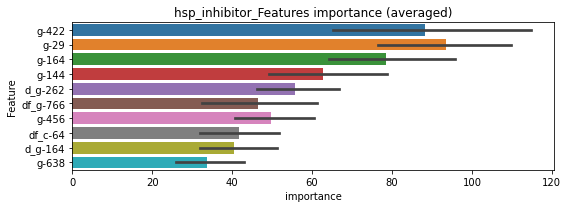

len(train_index) : 3882
len(valid_index) : 3883
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149624	valid_1's binary_logloss: 0.0332496
[200]	training's binary_logloss: 0.00190055	valid_1's binary_logloss: 0.0186487
[300]	training's binary_logloss: 0.000527838	valid_1's binary_logloss: 0.0143954
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000527838	valid_1's binary_logloss: 0.0143954


len(train_index) : 3883
len(valid_index) : 3882
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147763	valid_1's binary_logloss: 0.0367571
[200]	training's binary_logloss: 0.00186009	valid_1's binary_logloss: 0.0239835
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00085942	valid_1's binary_logloss: 0.0232896


hsp_inhibitor logloss: 0.01884191572917452


neg labels: 3289 → selected neg labels: 3282


igf-1_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309809	valid_1's binary_logloss: 0.0534558
[200]	training's binary_logloss: 0.00438167	valid_1's binary_logloss: 0.0180411
[300]	training's binary_logloss: 0.00123045	valid_1's binary_logloss: 0.0111597
[400]	training's binary_logloss: 0.000611586	valid_1's binary_logloss: 0.00921837
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000486246	valid_1's binary_logloss: 0.00864777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306232	valid_1's binary_logloss: 0.0505366
[200]	training's binary_logloss: 0.00427293	valid_1's binary_logloss: 0.0141159
[300]	training's binary_logloss: 0.00122661	valid_1's binary_logloss: 0.00815027
[400]	training's binary_logloss: 0.000621815	valid_1's binary_logloss: 0.00649647
[500]	training's binary_logloss: 0.0004337	valid_1's binary_logloss: 0.00578542
Early stopping, best iteration is:
[54

1 / 3 AUC score:1.000
y_Threshold: 0.0041221, Threshold: 0.0074501, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00671, conf_1:0.00820
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0074501
Num_p_label: 32.0, Expected: 6.2, Adj_threshold_2: 0.0174501
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_3: 0.0274501
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_4: 0.0374501
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_5: 0.0474501
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_6: 0.0574501
threshold: 0.0574501, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287627	valid_1's binary_logloss: 0.0524124
[200]	training's binary_logloss: 0.00392917	valid_1's binary_logloss: 0.01727
[300]	training's binary_logloss: 0.00113171	valid_1's binary_logloss: 0.0110328
[400]	training's binary_logloss: 0.000575705	valid_1's binary_logloss: 0.00879257
[500]	training's binary_logloss: 0.000408022	valid_1's binary_logloss: 0.00791772
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000412201	valid_1's binary_logloss: 0.00790093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301714	valid_1's binary_logloss: 0.0495119
[200]	training's binary_logloss: 0.0040577	valid_1's binary_logloss: 0.0124867
[300]	training's binary_logloss: 0.00117857	valid_1's binary_logloss: 0.00675628
[400]	training's binary_logloss: 0.00059682	valid_1's binary_logloss: 0.00528092
[500]	training's binary_logloss: 0.00042

2 / 3 AUC score:1.000
y_Threshold: 0.0957339, Threshold: 0.0574501, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0140633 Vs.target_rate: 0.00155
Num_p_label: 56.0, conf_0:0.05171, conf_1:0.06320
Num_p_label: 56.0, Expected: 6.2, Adj_threshold_1: 0.0574501
Num_p_label: 48.0, Expected: 6.2, Adj_threshold_2: 0.0674501
Num_p_label: 46.0, Expected: 6.2, Adj_threshold_3: 0.0774501
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_4: 0.0874501
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_5: 0.0974501
Num_p_label: 32.0, Expected: 6.2, Adj_threshold_6: 0.1074501
Num_p_label: 31.0, Expected: 6.2, Adj_threshold_7: 0.1174501
Num_p_label: 31.0, Expected: 6.2, Adj_threshold_8: 0.1274501
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_9: 0.1374501
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_10: 0.1474501
threshold: 0.1574501, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290279	valid_1's binary_logloss: 0.0510781
[200]	training's binary_logloss: 0.00394023	valid_1's binary_logloss: 0.0175103
[300]	training's binary_logloss: 0.00113646	valid_1's binary_logloss: 0.0115983
[400]	training's binary_logloss: 0.000582095	valid_1's binary_logloss: 0.0100921
[500]	training's binary_logloss: 0.00041431	valid_1's binary_logloss: 0.00943289
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000419942	valid_1's binary_logloss: 0.00940888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295086	valid_1's binary_logloss: 0.0450553
[200]	training's binary_logloss: 0.00394482	valid_1's binary_logloss: 0.0120724
[300]	training's binary_logloss: 0.00114669	valid_1's binary_logloss: 0.00625165
[400]	training's binary_logloss: 0.000587893	valid_1's binary_logloss: 0.00497199
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0564458, Threshold: 0.1574501, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 651.0/3796
p_label_rate: 0.0062783 Vs.target_rate: 0.00155
Num_p_label: 25.0, conf_0:0.14171, conf_1:0.17320
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_1: 0.1574501
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_2: 0.1674501
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_3: 0.1774501
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_4: 0.1874501
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_5: 0.1974501
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_6: 0.2074501
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_7: 0.2174501
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_8: 0.2274501
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_9: 0.2374501
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_10: 0.2474501
threshold: 0.2574501, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 668.0/7778, y_label_rate: 0.0858833


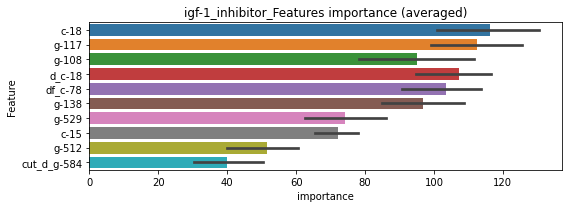

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160793	valid_1's binary_logloss: 0.0312823
[200]	training's binary_logloss: 0.00218165	valid_1's binary_logloss: 0.0135897
[300]	training's binary_logloss: 0.000620659	valid_1's binary_logloss: 0.010712
[400]	training's binary_logloss: 0.000312434	valid_1's binary_logloss: 0.0100372
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000318495	valid_1's binary_logloss: 0.00998946


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168295	valid_1's binary_logloss: 0.0288594
[200]	training's binary_logloss: 0.00233629	valid_1's binary_logloss: 0.00884219
[300]	training's binary_logloss: 0.000658651	valid_1's binary_logloss: 0.00523601
[400]	training's binary_logloss: 0.000326863	valid_1's binary_logloss: 0.00422671
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000251588	valid_1's binary_logloss: 0.00397781


igf-1_inhibitor logloss: 0.00698363560556984


neg labels: 3289 → selected neg labels: 3284


ikk_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256312	valid_1's binary_logloss: 0.0399935
[200]	training's binary_logloss: 0.00324202	valid_1's binary_logloss: 0.0112831
[300]	training's binary_logloss: 0.00092171	valid_1's binary_logloss: 0.00666561
[400]	training's binary_logloss: 0.0004812	valid_1's binary_logloss: 0.0050629
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000372476	valid_1's binary_logloss: 0.00477399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270059	valid_1's binary_logloss: 0.0515122
[200]	training's binary_logloss: 0.0034601	valid_1's binary_logloss: 0.0157043
[300]	training's binary_logloss: 0.00097343	valid_1's binary_logloss: 0.00838033
[400]	training's binary_logloss: 0.000495537	valid_1's binary_logloss: 0.00622314
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000434552	valid_1's binary_logloss: 0.00589741


1 / 3 AUC score:1.000
y_Threshold: 0.0022556, Threshold: 0.1347530, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.12128, conf_1:0.14823
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.1347530
Num_p_label: 79.0, Expected: 5.0, Adj_threshold_2: 0.1447530
Num_p_label: 79.0, Expected: 5.0, Adj_threshold_3: 0.1547530
Num_p_label: 76.0, Expected: 5.0, Adj_threshold_4: 0.1647530
Num_p_label: 72.0, Expected: 5.0, Adj_threshold_5: 0.1747530
Num_p_label: 67.0, Expected: 5.0, Adj_threshold_6: 0.1847530
Num_p_label: 65.0, Expected: 5.0, Adj_threshold_7: 0.1947530
Num_p_label: 62.0, Expected: 5.0, Adj_threshold_8: 0.2047530
Num_p_label: 62.0, Expected: 5.0, Adj_threshold_9: 0.2147530
Num_p_label: 61.0, Expected: 5.0, Adj_threshold_10: 0.2247530
threshold: 0.2347530, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256676	valid_1's binary_logloss: 0.0381023
[200]	training's binary_logloss: 0.00312826	valid_1's binary_logloss: 0.00986882
[300]	training's binary_logloss: 0.000882096	valid_1's binary_logloss: 0.00566282
[400]	training's binary_logloss: 0.000458872	valid_1's binary_logloss: 0.00446883
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000360488	valid_1's binary_logloss: 0.00415005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259147	valid_1's binary_logloss: 0.0469349
[200]	training's binary_logloss: 0.0031271	valid_1's binary_logloss: 0.0149671
[300]	training's binary_logloss: 0.0008823	valid_1's binary_logloss: 0.00942359
[400]	training's binary_logloss: 0.00046316	valid_1's binary_logloss: 0.00775282
[500]	training's binary_logloss: 0.000360368	valid_1's binary_logloss: 0.00725912
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
y_Threshold: 0.1563139, Threshold: 0.2347530, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0303867 Vs.target_rate: 0.00126
Num_p_label: 121.0, conf_0:0.21128, conf_1:0.25823
Num_p_label: 121.0, Expected: 5.0, Adj_threshold_1: 0.2347530
Num_p_label: 121.0, Expected: 5.0, Adj_threshold_2: 0.2447530
Num_p_label: 121.0, Expected: 5.0, Adj_threshold_3: 0.2547530
Num_p_label: 118.0, Expected: 5.0, Adj_threshold_4: 0.2647530
Num_p_label: 118.0, Expected: 5.0, Adj_threshold_5: 0.2747530
Num_p_label: 117.0, Expected: 5.0, Adj_threshold_6: 0.2847530
Num_p_label: 116.0, Expected: 5.0, Adj_threshold_7: 0.2947530
Num_p_label: 114.0, Expected: 5.0, Adj_threshold_8: 0.3047530
Num_p_label: 113.0, Expected: 5.0, Adj_threshold_9: 0.3147530
Num_p_label: 110.0, Expected: 5.0, Adj_threshold_10: 0.3247530
threshold: 0.3347530, positive_p_label: 109.0/3982, p_label_rate: 0.0273732
positive_y_label: 653.0/3802, y_label_rate: 0.17175

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250983	valid_1's binary_logloss: 0.0401896
[200]	training's binary_logloss: 0.00308144	valid_1's binary_logloss: 0.0144007
[300]	training's binary_logloss: 0.000866612	valid_1's binary_logloss: 0.0108076
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000833917	valid_1's binary_logloss: 0.0106864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255707	valid_1's binary_logloss: 0.0375059
[200]	training's binary_logloss: 0.00313943	valid_1's binary_logloss: 0.00779626
[300]	training's binary_logloss: 0.000894004	valid_1's binary_logloss: 0.00348708
[400]	training's binary_logloss: 0.000468955	valid_1's binary_logloss: 0.00245527
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000363299	valid_1's binary_logloss: 0.00215763


3 / 3 AUC score:1.000
y_Threshold: 0.0507653, Threshold: 0.3347530, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3800
p_label_rate: 0.0283777 Vs.target_rate: 0.00126
Num_p_label: 113.0, conf_0:0.30128, conf_1:0.36823
Num_p_label: 113.0, Expected: 5.0, Adj_threshold_1: 0.3347530
Num_p_label: 112.0, Expected: 5.0, Adj_threshold_2: 0.3447530
Num_p_label: 112.0, Expected: 5.0, Adj_threshold_3: 0.3547530
Num_p_label: 112.0, Expected: 5.0, Adj_threshold_4: 0.3647530
Num_p_label: 112.0, Expected: 5.0, Adj_threshold_5: 0.3747530
Num_p_label: 111.0, Expected: 5.0, Adj_threshold_6: 0.3847530
Num_p_label: 111.0, Expected: 5.0, Adj_threshold_7: 0.3947530
Num_p_label: 110.0, Expected: 5.0, Adj_threshold_8: 0.4047530
Num_p_label: 110.0, Expected: 5.0, Adj_threshold_9: 0.4147530
Num_p_label: 109.0, Expected: 5.0, Adj_threshold_10: 0.4247530
threshold: 0.4347530, positive_p_label: 108.0/3982, p_label_rate: 0.0271220
positive_y_label: 760.0/7782, y_label_rate: 0.09766

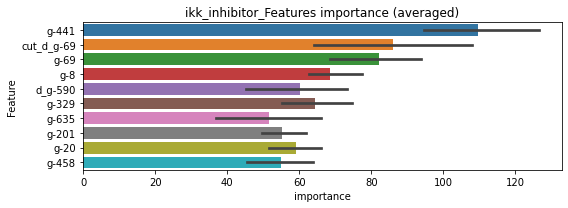

len(train_index) : 3891
len(valid_index) : 3891
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153001	valid_1's binary_logloss: 0.0270472
[200]	training's binary_logloss: 0.00198087	valid_1's binary_logloss: 0.0102477
[300]	training's binary_logloss: 0.000555508	valid_1's binary_logloss: 0.00722475
[400]	training's binary_logloss: 0.000281159	valid_1's binary_logloss: 0.0063343
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000270668	valid_1's binary_logloss: 0.00632347


len(train_index) : 3891
len(valid_index) : 3891
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149875	valid_1's binary_logloss: 0.0255451
[200]	training's binary_logloss: 0.00185249	valid_1's binary_logloss: 0.00946921
[300]	training's binary_logloss: 0.000516004	valid_1's binary_logloss: 0.00638657
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000315324	valid_1's binary_logloss: 0.005677


ikk_inhibitor logloss: 0.006000235686323398


neg labels: 3289 → selected neg labels: 3284


imidazoline_receptor_agonist, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310371	valid_1's binary_logloss: 0.0493279
[200]	training's binary_logloss: 0.00436377	valid_1's binary_logloss: 0.0170095
[300]	training's binary_logloss: 0.0012187	valid_1's binary_logloss: 0.0109093
[400]	training's binary_logloss: 0.00061174	valid_1's binary_logloss: 0.00958455
[500]	training's binary_logloss: 0.000421575	valid_1's binary_logloss: 0.00878691
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000415209	valid_1's binary_logloss: 0.00876077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302856	valid_1's binary_logloss: 0.0465749
[200]	training's binary_logloss: 0.00427626	valid_1's binary_logloss: 0.0150592
[300]	training's binary_logloss: 0.00120765	valid_1's binary_logloss: 0.0102587
[400]	training's binary_logloss: 0.000601888	valid_1's binary_logloss: 0.008776
Early stopping, best iteration is:
[407]	

1 / 3 AUC score:1.000
y_Threshold: 0.0025035, Threshold: 0.0039569, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130
Num_p_label: 80.0, conf_0:0.00356, conf_1:0.00435
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0039569
Num_p_label: 5.0, Expected: 5.2, Adj_threshold_2: 0.0139569
threshold: 0.0139569, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316083	valid_1's binary_logloss: 0.0506266
[200]	training's binary_logloss: 0.00438753	valid_1's binary_logloss: 0.0162346
[300]	training's binary_logloss: 0.00121874	valid_1's binary_logloss: 0.0102934
[400]	training's binary_logloss: 0.000609681	valid_1's binary_logloss: 0.00870873
[500]	training's binary_logloss: 0.000422155	valid_1's binary_logloss: 0.00792868
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00041321	valid_1's binary_logloss: 0.00792018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295668	valid_1's binary_logloss: 0.0447581
[200]	training's binary_logloss: 0.00415574	valid_1's binary_logloss: 0.0147203
[300]	training's binary_logloss: 0.00119307	valid_1's binary_logloss: 0.0101768
[400]	training's binary_logloss: 0.000600438	valid_1's binary_logloss: 0.00890527
Early stopping, best iteration is:
[42

2 / 3 AUC score:1.000
y_Threshold: 0.0092136, Threshold: 0.0139569, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0035158 Vs.target_rate: 0.00130
Num_p_label: 14.0, conf_0:0.01256, conf_1:0.01535
threshold: 0.0139569, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302145	valid_1's binary_logloss: 0.0510471
[200]	training's binary_logloss: 0.00419858	valid_1's binary_logloss: 0.0155141
[300]	training's binary_logloss: 0.00117881	valid_1's binary_logloss: 0.00994214
[400]	training's binary_logloss: 0.000590437	valid_1's binary_logloss: 0.00832234
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000447797	valid_1's binary_logloss: 0.00763065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303904	valid_1's binary_logloss: 0.0435574
[200]	training's binary_logloss: 0.0041765	valid_1's binary_logloss: 0.0145545
[300]	training's binary_logloss: 0.00119129	valid_1's binary_logloss: 0.00975627
[400]	training's binary_logloss: 0.000592553	valid_1's binary_logloss: 0.00826761
[500]	training's binary_logloss: 0.000421865	valid_1's binary_logloss: 0.00786769
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0145065, Threshold: 0.0139569, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0022602 Vs.target_rate: 0.00130
Num_p_label: 9.0, conf_0:0.01256, conf_1:0.01535
threshold: 0.0139569, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 664.0/7788, y_label_rate: 0.0852594


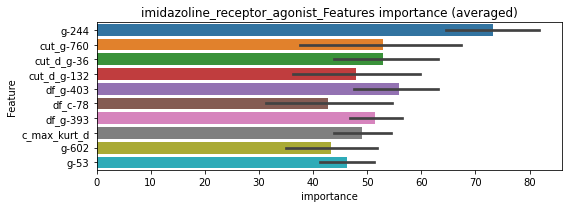

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162868	valid_1's binary_logloss: 0.0282154
[200]	training's binary_logloss: 0.00227318	valid_1's binary_logloss: 0.0124063
[300]	training's binary_logloss: 0.000640407	valid_1's binary_logloss: 0.0104368
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000398664	valid_1's binary_logloss: 0.0102283


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166495	valid_1's binary_logloss: 0.0276923
[200]	training's binary_logloss: 0.00235155	valid_1's binary_logloss: 0.0122794
[300]	training's binary_logloss: 0.000661167	valid_1's binary_logloss: 0.0101049
[400]	training's binary_logloss: 0.000322679	valid_1's binary_logloss: 0.00950469
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.000319825	valid_1's binary_logloss: 0.0094919


imidazoline_receptor_agonist logloss: 0.009860101895510821


neg labels: 3289 → selected neg labels: 3278


immunosuppressant, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406099	valid_1's binary_logloss: 0.0836858
[200]	training's binary_logloss: 0.00747308	valid_1's binary_logloss: 0.0415682
[300]	training's binary_logloss: 0.00230246	valid_1's binary_logloss: 0.0307074
[400]	training's binary_logloss: 0.00112655	valid_1's binary_logloss: 0.0272711
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000816164	valid_1's binary_logloss: 0.0261696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420734	valid_1's binary_logloss: 0.0906996
[200]	training's binary_logloss: 0.00785176	valid_1's binary_logloss: 0.0427825
[300]	training's binary_logloss: 0.00241461	valid_1's binary_logloss: 0.0315652
[400]	training's binary_logloss: 0.00117583	valid_1's binary_logloss: 0.0277049
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000885367	valid_1's binary_logloss: 0.0268252


1 / 3 AUC score:0.999
y_Threshold: 0.0077119, Threshold: 0.0130480, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3793
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.01174, conf_1:0.01435
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0130480
Num_p_label: 49.0, Expected: 12.2, Adj_threshold_2: 0.0230480
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_3: 0.0330480
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_4: 0.0430480
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_5: 0.0530480
Num_p_label: 23.0, Expected: 12.2, Adj_threshold_6: 0.0630480
threshold: 0.0630480, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 651.0/3793, y_label_rate: 0.1716320
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397027	valid_1's binary_logloss: 0.0844666
[200]	training's binary_logloss: 0.00670979	valid_1's binary_logloss: 0.0383979
[300]	training's binary_logloss: 0.00205093	valid_1's binary_logloss: 0.0276755
[400]	training's binary_logloss: 0.00101548	valid_1's binary_logloss: 0.0240624
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000758507	valid_1's binary_logloss: 0.0225379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395305	valid_1's binary_logloss: 0.101053
[200]	training's binary_logloss: 0.00698269	valid_1's binary_logloss: 0.0647328
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00359617	valid_1's binary_logloss: 0.0599641


2 / 3 AUC score:0.998
y_Threshold: 0.0371644, Threshold: 0.0630480, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 636.0/3763
p_label_rate: 0.0153189 Vs.target_rate: 0.00307
Num_p_label: 61.0, conf_0:0.05674, conf_1:0.06935
Num_p_label: 61.0, Expected: 12.2, Adj_threshold_1: 0.0630480
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_2: 0.0730480
Num_p_label: 51.0, Expected: 12.2, Adj_threshold_3: 0.0830480
Num_p_label: 47.0, Expected: 12.2, Adj_threshold_4: 0.0930480
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_5: 0.1030480
Num_p_label: 42.0, Expected: 12.2, Adj_threshold_6: 0.1130480
Num_p_label: 41.0, Expected: 12.2, Adj_threshold_7: 0.1230480
Num_p_label: 41.0, Expected: 12.2, Adj_threshold_8: 0.1330480
Num_p_label: 41.0, Expected: 12.2, Adj_threshold_9: 0.1430480
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_10: 0.1530480
threshold: 0.1630480, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 636.0/3763, y_label_rate: 0.169014

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374063	valid_1's binary_logloss: 0.0848831
[200]	training's binary_logloss: 0.00629276	valid_1's binary_logloss: 0.0404748
[300]	training's binary_logloss: 0.00193492	valid_1's binary_logloss: 0.0294794
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00138691	valid_1's binary_logloss: 0.0279276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387265	valid_1's binary_logloss: 0.0717931
[200]	training's binary_logloss: 0.00661209	valid_1's binary_logloss: 0.0285086
[300]	training's binary_logloss: 0.00203832	valid_1's binary_logloss: 0.0184339
[400]	training's binary_logloss: 0.00102754	valid_1's binary_logloss: 0.0151048
[500]	training's binary_logloss: 0.000673769	valid_1's binary_logloss: 0.0136642
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.000558665	valid_1's binary_logloss: 0.0129057


3 / 3 AUC score:1.000
y_Threshold: 0.0634806, Threshold: 0.1630480, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 631.0/3753
p_label_rate: 0.0092918 Vs.target_rate: 0.00307
Num_p_label: 37.0, conf_0:0.14674, conf_1:0.17935
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_1: 0.1630480
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_2: 0.1730480
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_3: 0.1830480
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_4: 0.1930480
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_5: 0.2030480
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_6: 0.2130480
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_7: 0.2230480
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_8: 0.2330480
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_9: 0.2430480
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_10: 0.2530480
threshold: 0.2630480, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 658.0/7735, y_label_rate: 0.085067

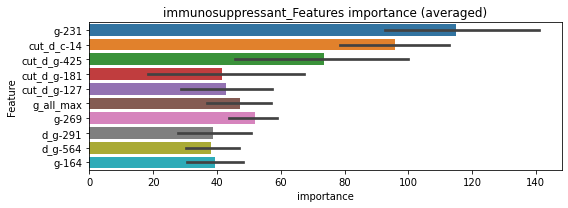

len(train_index) : 3867
len(valid_index) : 3868
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193432	valid_1's binary_logloss: 0.0507817
[200]	training's binary_logloss: 0.0030331	valid_1's binary_logloss: 0.028117
[300]	training's binary_logloss: 0.000947576	valid_1's binary_logloss: 0.0233723
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000584489	valid_1's binary_logloss: 0.0221333


len(train_index) : 3868
len(valid_index) : 3867
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192749	valid_1's binary_logloss: 0.0431823
[200]	training's binary_logloss: 0.00324139	valid_1's binary_logloss: 0.021129
[300]	training's binary_logloss: 0.00100043	valid_1's binary_logloss: 0.0166152
[400]	training's binary_logloss: 0.000510492	valid_1's binary_logloss: 0.0153883
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000419129	valid_1's binary_logloss: 0.015036


immunosuppressant logloss: 0.0185850994205912


neg labels: 3289 → selected neg labels: 3284


insulin_secretagogue, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286527	valid_1's binary_logloss: 0.048726
[200]	training's binary_logloss: 0.00385033	valid_1's binary_logloss: 0.0173604
[300]	training's binary_logloss: 0.00110345	valid_1's binary_logloss: 0.0122915
[400]	training's binary_logloss: 0.00056857	valid_1's binary_logloss: 0.0107141
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000485403	valid_1's binary_logloss: 0.0104095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291551	valid_1's binary_logloss: 0.0525118
[200]	training's binary_logloss: 0.00414497	valid_1's binary_logloss: 0.017312
[300]	training's binary_logloss: 0.00117686	valid_1's binary_logloss: 0.0105981
[400]	training's binary_logloss: 0.000596242	valid_1's binary_logloss: 0.0088637
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000599616	valid_1's binary_logloss: 0.00886246


1 / 3 AUC score:1.000
y_Threshold: 0.0022025, Threshold: 0.0035345, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00318, conf_1:0.00389
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0035345
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_2: 0.0135345
threshold: 0.0135345, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276468	valid_1's binary_logloss: 0.0476807
[200]	training's binary_logloss: 0.00368012	valid_1's binary_logloss: 0.0164026
[300]	training's binary_logloss: 0.00108385	valid_1's binary_logloss: 0.012164
[400]	training's binary_logloss: 0.000565803	valid_1's binary_logloss: 0.0104641
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.0004438	valid_1's binary_logloss: 0.010032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290662	valid_1's binary_logloss: 0.0515807
[200]	training's binary_logloss: 0.00403741	valid_1's binary_logloss: 0.0178649
[300]	training's binary_logloss: 0.00115117	valid_1's binary_logloss: 0.0117415
[400]	training's binary_logloss: 0.000593895	valid_1's binary_logloss: 0.00999559
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000460943	valid_1's binary_logloss: 0.00939347


2 / 3 AUC score:1.000
y_Threshold: 0.0106206, Threshold: 0.0135345, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0037670 Vs.target_rate: 0.00126
Num_p_label: 15.0, conf_0:0.01218, conf_1:0.01489
threshold: 0.0135345, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276468	valid_1's binary_logloss: 0.0476807
[200]	training's binary_logloss: 0.00368012	valid_1's binary_logloss: 0.0164026
[300]	training's binary_logloss: 0.00108385	valid_1's binary_logloss: 0.012164
[400]	training's binary_logloss: 0.000565803	valid_1's binary_logloss: 0.0104641
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.0004438	valid_1's binary_logloss: 0.010032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290662	valid_1's binary_logloss: 0.0515807
[200]	training's binary_logloss: 0.00403741	valid_1's binary_logloss: 0.0178649
[300]	training's binary_logloss: 0.00115117	valid_1's binary_logloss: 0.0117415
[400]	training's binary_logloss: 0.000593895	valid_1's binary_logloss: 0.00999559
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000460943	valid_1's binary_logloss: 0.00939347


3 / 3 AUC score:1.000
y_Threshold: 0.0106206, Threshold: 0.0135345, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0037670 Vs.target_rate: 0.00126
Num_p_label: 15.0, conf_0:0.01218, conf_1:0.01489
threshold: 0.0135345, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 671.0/7790, y_label_rate: 0.0861361


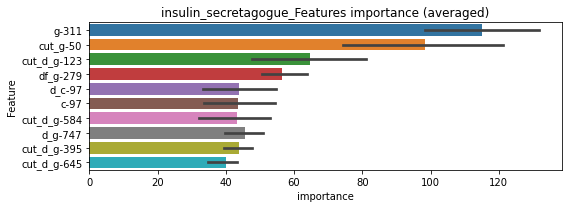

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152194	valid_1's binary_logloss: 0.0320114
[200]	training's binary_logloss: 0.00204816	valid_1's binary_logloss: 0.0179416
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000677129	valid_1's binary_logloss: 0.0164344


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158324	valid_1's binary_logloss: 0.028657
[200]	training's binary_logloss: 0.00231599	valid_1's binary_logloss: 0.0116308
[300]	training's binary_logloss: 0.000669633	valid_1's binary_logloss: 0.00914376
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000451322	valid_1's binary_logloss: 0.00894353


insulin_secretagogue logloss: 0.012688950842205428


neg labels: 3289 → selected neg labels: 3281


insulin_sensitizer, len(trt): 51, len(othr): 3281, target_rate: 0.0021416 → Adj_target_rate: 0.0023748
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327996	valid_1's binary_logloss: 0.0704325
[200]	training's binary_logloss: 0.00515319	valid_1's binary_logloss: 0.0348411
[300]	training's binary_logloss: 0.00150112	valid_1's binary_logloss: 0.0286335
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00127659	valid_1's binary_logloss: 0.0278156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346398	valid_1's binary_logloss: 0.0610427
[200]	training's binary_logloss: 0.00562362	valid_1's binary_logloss: 0.0224959
[300]	training's binary_logloss: 0.00167341	valid_1's binary_logloss: 0.0166546
[400]	training's binary_logloss: 0.00082284	valid_1's binary_logloss: 0.0156022
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000760566	valid_1's binary_logloss: 0.0155007


1 / 3 AUC score:0.998
y_Threshold: 0.0061027, Threshold: 0.0126575, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 653/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00214
Num_p_label: 80.0, conf_0:0.01139, conf_1:0.01392
Num_p_label: 80.0, Expected: 8.5, Adj_threshold_1: 0.0126575
Num_p_label: 37.0, Expected: 8.5, Adj_threshold_2: 0.0226575
Num_p_label: 19.0, Expected: 8.5, Adj_threshold_3: 0.0326575
Num_p_label: 17.0, Expected: 8.5, Adj_threshold_4: 0.0426575
threshold: 0.0426575, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 653.0/3799, y_label_rate: 0.1718873
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330785	valid_1's binary_logloss: 0.0586708
[200]	training's binary_logloss: 0.00503625	valid_1's binary_logloss: 0.0230516
[300]	training's binary_logloss: 0.00148751	valid_1's binary_logloss: 0.016163
[400]	training's binary_logloss: 0.000751717	valid_1's binary_logloss: 0.0144747
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000523567	valid_1's binary_logloss: 0.013814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356291	valid_1's binary_logloss: 0.0598916
[200]	training's binary_logloss: 0.00545057	valid_1's binary_logloss: 0.0209
[300]	training's binary_logloss: 0.00157748	valid_1's binary_logloss: 0.013017
[400]	training's binary_logloss: 0.000784054	valid_1's binary_logloss: 0.0109524
[500]	training's binary_logloss: 0.000524159	valid_1's binary_logloss: 0.0100341
Early stopping, best iteration is:
[496]	traini

2 / 3 AUC score:1.000
y_Threshold: 0.0227537, Threshold: 0.0426575, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 651.0/3795
p_label_rate: 0.0057760 Vs.target_rate: 0.00214
Num_p_label: 23.0, conf_0:0.03839, conf_1:0.04692
threshold: 0.0426575, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 651.0/3795, y_label_rate: 0.1715415
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032635	valid_1's binary_logloss: 0.0608907
[200]	training's binary_logloss: 0.00499914	valid_1's binary_logloss: 0.0212145
[300]	training's binary_logloss: 0.00146771	valid_1's binary_logloss: 0.0144709
[400]	training's binary_logloss: 0.000742662	valid_1's binary_logloss: 0.011986
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00055726	valid_1's binary_logloss: 0.0110777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336047	valid_1's binary_logloss: 0.058215
[200]	training's binary_logloss: 0.00519287	valid_1's binary_logloss: 0.0181376
[300]	training's binary_logloss: 0.00151682	valid_1's binary_logloss: 0.0107031
[400]	training's binary_logloss: 0.000759578	valid_1's binary_logloss: 0.00814484
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000730881	valid_1's binary_logloss: 0.00809964


3 / 3 AUC score:1.000
y_Threshold: 0.0454496, Threshold: 0.0426575, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 651.0/3795
p_label_rate: 0.0077850 Vs.target_rate: 0.00214
Num_p_label: 31.0, conf_0:0.03839, conf_1:0.04692
Num_p_label: 31.0, Expected: 8.5, Adj_threshold_1: 0.0426575
Num_p_label: 27.0, Expected: 8.5, Adj_threshold_2: 0.0526575
Num_p_label: 23.0, Expected: 8.5, Adj_threshold_3: 0.0626575
Num_p_label: 21.0, Expected: 8.5, Adj_threshold_4: 0.0726575
Num_p_label: 16.0, Expected: 8.5, Adj_threshold_5: 0.0826575
threshold: 0.0826575, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 667.0/7777, y_label_rate: 0.0857657


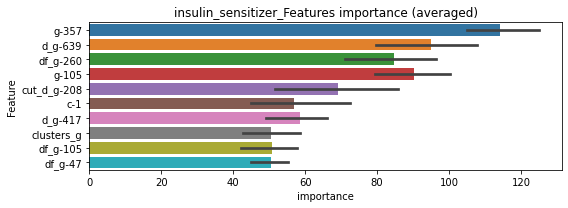

len(train_index) : 3888
len(valid_index) : 3889
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176427	valid_1's binary_logloss: 0.0385772
[200]	training's binary_logloss: 0.00259619	valid_1's binary_logloss: 0.0196598
[300]	training's binary_logloss: 0.000769436	valid_1's binary_logloss: 0.0164452
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000422162	valid_1's binary_logloss: 0.0155513


len(train_index) : 3889
len(valid_index) : 3888
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180812	valid_1's binary_logloss: 0.0373909
[200]	training's binary_logloss: 0.00284498	valid_1's binary_logloss: 0.0172364
[300]	training's binary_logloss: 0.000831668	valid_1's binary_logloss: 0.0136117
[400]	training's binary_logloss: 0.000410087	valid_1's binary_logloss: 0.0125902
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000353877	valid_1's binary_logloss: 0.0123763


insulin_sensitizer logloss: 0.013964018915303921


neg labels: 3289 → selected neg labels: 3282


integrin_inhibitor, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354813	valid_1's binary_logloss: 0.0678994
[200]	training's binary_logloss: 0.00591199	valid_1's binary_logloss: 0.0274959
[300]	training's binary_logloss: 0.00170553	valid_1's binary_logloss: 0.0185655
[400]	training's binary_logloss: 0.000826244	valid_1's binary_logloss: 0.0164397
[500]	training's binary_logloss: 0.000535827	valid_1's binary_logloss: 0.0155575
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000515312	valid_1's binary_logloss: 0.0154435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379245	valid_1's binary_logloss: 0.0645749
[200]	training's binary_logloss: 0.00648171	valid_1's binary_logloss: 0.0244735
[300]	training's binary_logloss: 0.00184413	valid_1's binary_logloss: 0.0149138
[400]	training's binary_logloss: 0.000889419	valid_1's binary_logloss: 0.0122252
[500]	training's binary_logloss: 0.000573

1 / 3 AUC score:1.000
y_Threshold: 0.0027759, Threshold: 0.0037441, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176
Num_p_label: 80.0, conf_0:0.00337, conf_1:0.00412
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0037441
Num_p_label: 4.0, Expected: 7.0, Adj_threshold_2: 0.0137441
threshold: 0.0137441, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358363	valid_1's binary_logloss: 0.067763
[200]	training's binary_logloss: 0.00578382	valid_1's binary_logloss: 0.0287526
[300]	training's binary_logloss: 0.00165581	valid_1's binary_logloss: 0.0206519
[400]	training's binary_logloss: 0.000827659	valid_1's binary_logloss: 0.0181351
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000836959	valid_1's binary_logloss: 0.0181165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038106	valid_1's binary_logloss: 0.066651
[200]	training's binary_logloss: 0.00614048	valid_1's binary_logloss: 0.0235696
[300]	training's binary_logloss: 0.00177105	valid_1's binary_logloss: 0.0147316
[400]	training's binary_logloss: 0.000855627	valid_1's binary_logloss: 0.0123161
[500]	training's binary_logloss: 0.000554434	valid_1's binary_logloss: 0.0111142
Early stopping, best iteration is:
[550]	tra

2 / 3 AUC score:1.000
y_Threshold: 0.0190393, Threshold: 0.0137441, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0045203 Vs.target_rate: 0.00176
Num_p_label: 18.0, conf_0:0.01237, conf_1:0.01512
threshold: 0.0137441, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358363	valid_1's binary_logloss: 0.067763
[200]	training's binary_logloss: 0.00578382	valid_1's binary_logloss: 0.0287526
[300]	training's binary_logloss: 0.00165581	valid_1's binary_logloss: 0.0206519
[400]	training's binary_logloss: 0.000827659	valid_1's binary_logloss: 0.0181351
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000836959	valid_1's binary_logloss: 0.0181165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038106	valid_1's binary_logloss: 0.066651
[200]	training's binary_logloss: 0.00614048	valid_1's binary_logloss: 0.0235696
[300]	training's binary_logloss: 0.00177105	valid_1's binary_logloss: 0.0147316
[400]	training's binary_logloss: 0.000855627	valid_1's binary_logloss: 0.0123161
[500]	training's binary_logloss: 0.000554434	valid_1's binary_logloss: 0.0111142
Early stopping, best iteration is:
[550]	tra

3 / 3 AUC score:1.000
y_Threshold: 0.0190393, Threshold: 0.0137441, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0045203 Vs.target_rate: 0.00176
Num_p_label: 18.0, conf_0:0.01237, conf_1:0.01512
threshold: 0.0137441, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 674.0/7788, y_label_rate: 0.0865434


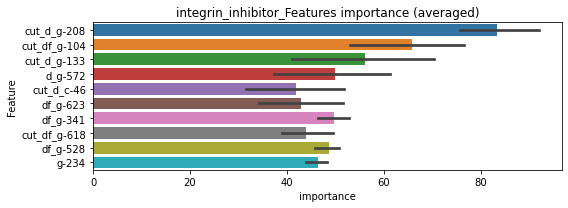

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197276	valid_1's binary_logloss: 0.0445826
[200]	training's binary_logloss: 0.00335466	valid_1's binary_logloss: 0.0246648
[300]	training's binary_logloss: 0.000942947	valid_1's binary_logloss: 0.0217217
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000916491	valid_1's binary_logloss: 0.0216262


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221295	valid_1's binary_logloss: 0.0375918
[200]	training's binary_logloss: 0.00379152	valid_1's binary_logloss: 0.0167377
[300]	training's binary_logloss: 0.00107735	valid_1's binary_logloss: 0.0127018
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000581484	valid_1's binary_logloss: 0.01183


integrin_inhibitor logloss: 0.016728135956821696


neg labels: 3289 → selected neg labels: 3274


jak_inhibitor, len(trt): 92, len(othr): 3274, target_rate: 0.0038633 → Adj_target_rate: 0.0039212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038035	valid_1's binary_logloss: 0.077284
[200]	training's binary_logloss: 0.00639557	valid_1's binary_logloss: 0.0372476
[300]	training's binary_logloss: 0.00193499	valid_1's binary_logloss: 0.0282276
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00115752	valid_1's binary_logloss: 0.0255492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370566	valid_1's binary_logloss: 0.083705
[200]	training's binary_logloss: 0.0062099	valid_1's binary_logloss: 0.0400305
[300]	training's binary_logloss: 0.00187414	valid_1's binary_logloss: 0.0292857
[400]	training's binary_logloss: 0.000934406	valid_1's binary_logloss: 0.0252212
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000861023	valid_1's binary_logloss: 0.0246168


1 / 3 AUC score:0.999
y_Threshold: 0.0164935, Threshold: 0.0306811, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 651/3790
p_label_rate: 0.0200904 Vs.target_rate: 0.00386
Num_p_label: 80.0, conf_0:0.02761, conf_1:0.03375
Num_p_label: 80.0, Expected: 15.4, Adj_threshold_1: 0.0306811
Num_p_label: 58.0, Expected: 15.4, Adj_threshold_2: 0.0406811
Num_p_label: 48.0, Expected: 15.4, Adj_threshold_3: 0.0506811
Num_p_label: 37.0, Expected: 15.4, Adj_threshold_4: 0.0606811
Num_p_label: 26.0, Expected: 15.4, Adj_threshold_5: 0.0706811
threshold: 0.0706811, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 651.0/3790, y_label_rate: 0.1717678
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355309	valid_1's binary_logloss: 0.0777892
[200]	training's binary_logloss: 0.00554888	valid_1's binary_logloss: 0.0370977
[300]	training's binary_logloss: 0.00160472	valid_1's binary_logloss: 0.0271577
[400]	training's binary_logloss: 0.000791487	valid_1's binary_logloss: 0.0237718
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000608993	valid_1's binary_logloss: 0.0231646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374173	valid_1's binary_logloss: 0.0758634
[200]	training's binary_logloss: 0.00598206	valid_1's binary_logloss: 0.0314815
[300]	training's binary_logloss: 0.0017687	valid_1's binary_logloss: 0.0202818
[400]	training's binary_logloss: 0.000882992	valid_1's binary_logloss: 0.0165547
[500]	training's binary_logloss: 0.000587218	valid_1's binary_logloss: 0.0143882
Early stopping, best iteration is:
[505]	t

2 / 3 AUC score:1.000
y_Threshold: 0.2382702, Threshold: 0.0706811, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 640.0/3768
p_label_rate: 0.0356605 Vs.target_rate: 0.00386
Num_p_label: 142.0, conf_0:0.06361, conf_1:0.07775
Num_p_label: 142.0, Expected: 15.4, Adj_threshold_1: 0.0706811
Num_p_label: 130.0, Expected: 15.4, Adj_threshold_2: 0.0806811
Num_p_label: 120.0, Expected: 15.4, Adj_threshold_3: 0.0906811
Num_p_label: 114.0, Expected: 15.4, Adj_threshold_4: 0.1006811
Num_p_label: 96.0, Expected: 15.4, Adj_threshold_5: 0.1106811
Num_p_label: 93.0, Expected: 15.4, Adj_threshold_6: 0.1206811
Num_p_label: 89.0, Expected: 15.4, Adj_threshold_7: 0.1306811
Num_p_label: 87.0, Expected: 15.4, Adj_threshold_8: 0.1406811
Num_p_label: 78.0, Expected: 15.4, Adj_threshold_9: 0.1506811
Num_p_label: 76.0, Expected: 15.4, Adj_threshold_10: 0.1606811
threshold: 0.1706811, positive_p_label: 71.0/3982, p_label_rate: 0.0178302
positive_y_label: 640.0/3768, y_label_rate: 0.1

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345475	valid_1's binary_logloss: 0.0714871
[200]	training's binary_logloss: 0.00535546	valid_1's binary_logloss: 0.0295366
[300]	training's binary_logloss: 0.00156523	valid_1's binary_logloss: 0.0189768
[400]	training's binary_logloss: 0.000775971	valid_1's binary_logloss: 0.0157856
[500]	training's binary_logloss: 0.000517895	valid_1's binary_logloss: 0.0145827
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000513248	valid_1's binary_logloss: 0.0145704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353837	valid_1's binary_logloss: 0.0639179
[200]	training's binary_logloss: 0.00550608	valid_1's binary_logloss: 0.0254984
[300]	training's binary_logloss: 0.00163068	valid_1's binary_logloss: 0.0162378
[400]	training's binary_logloss: 0.000819104	valid_1's binary_logloss: 0.0137825
[500]	training's binary_logloss: 0.000555

3 / 3 AUC score:1.000
y_Threshold: 0.1276098, Threshold: 0.1706811, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 637.0/3762
p_label_rate: 0.0200904 Vs.target_rate: 0.00386
Num_p_label: 80.0, conf_0:0.15361, conf_1:0.18775
Num_p_label: 80.0, Expected: 15.4, Adj_threshold_1: 0.1706811
Num_p_label: 78.0, Expected: 15.4, Adj_threshold_2: 0.1806811
Num_p_label: 73.0, Expected: 15.4, Adj_threshold_3: 0.1906811
Num_p_label: 67.0, Expected: 15.4, Adj_threshold_4: 0.2006811
Num_p_label: 66.0, Expected: 15.4, Adj_threshold_5: 0.2106811
Num_p_label: 63.0, Expected: 15.4, Adj_threshold_6: 0.2206811
Num_p_label: 61.0, Expected: 15.4, Adj_threshold_7: 0.2306811
Num_p_label: 60.0, Expected: 15.4, Adj_threshold_8: 0.2406811
Num_p_label: 55.0, Expected: 15.4, Adj_threshold_9: 0.2506811
Num_p_label: 55.0, Expected: 15.4, Adj_threshold_10: 0.2606811
threshold: 0.2706811, positive_p_label: 53.0/3982, p_label_rate: 0.0133099
positive_y_label: 690.0/7744, y_label_rate: 0.0891012

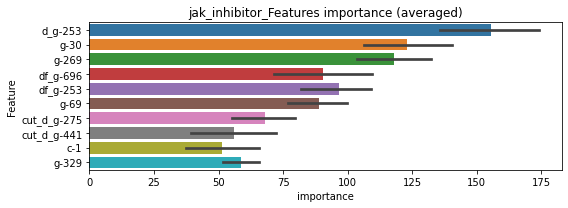

len(train_index) : 3872
len(valid_index) : 3872
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019109	valid_1's binary_logloss: 0.0581817
[200]	training's binary_logloss: 0.00299894	valid_1's binary_logloss: 0.0383346
[300]	training's binary_logloss: 0.000919685	valid_1's binary_logloss: 0.0333332
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000596716	valid_1's binary_logloss: 0.0314432


len(train_index) : 3872
len(valid_index) : 3872
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197032	valid_1's binary_logloss: 0.0427572
[200]	training's binary_logloss: 0.00307669	valid_1's binary_logloss: 0.0232989
[300]	training's binary_logloss: 0.000943117	valid_1's binary_logloss: 0.0200819
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000684672	valid_1's binary_logloss: 0.0195391


jak_inhibitor logloss: 0.025491130791355635


neg labels: 3289 → selected neg labels: 3272


kit_inhibitor, len(trt): 273, len(othr): 3272, target_rate: 0.0114638 → Adj_target_rate: 0.0098841
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477315	valid_1's binary_logloss: 0.124664
[200]	training's binary_logloss: 0.00966809	valid_1's binary_logloss: 0.0879208
[300]	training's binary_logloss: 0.00295115	valid_1's binary_logloss: 0.0793344
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00166182	valid_1's binary_logloss: 0.0766046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050301	valid_1's binary_logloss: 0.129996
[200]	training's binary_logloss: 0.0107349	valid_1's binary_logloss: 0.0951656
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00496316	valid_1's binary_logloss: 0.0905212


1 / 3 AUC score:0.989
y_Threshold: 0.0276978, Threshold: 0.1773309, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 180 → Positive_corect_labels: 630/3746
p_label_rate: 0.0200904 Vs.target_rate: 0.01146
Num_p_label: 80.0, conf_0:0.15960, conf_1:0.19506
threshold: 0.1773309, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 630.0/3746, y_label_rate: 0.1681794
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394665	valid_1's binary_logloss: 0.0964823
[200]	training's binary_logloss: 0.00701709	valid_1's binary_logloss: 0.0622292
[300]	training's binary_logloss: 0.00197485	valid_1's binary_logloss: 0.0561152
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00179858	valid_1's binary_logloss: 0.0558191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414858	valid_1's binary_logloss: 0.0909774
[200]	training's binary_logloss: 0.00771873	valid_1's binary_logloss: 0.0524047
[300]	training's binary_logloss: 0.00225741	valid_1's binary_logloss: 0.0410713
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0021322	valid_1's binary_logloss: 0.0406124


2 / 3 AUC score:0.995
y_Threshold: 0.0987661, Threshold: 0.1773309, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 611.0/3708
p_label_rate: 0.0361627 Vs.target_rate: 0.01146
Num_p_label: 144.0, conf_0:0.15960, conf_1:0.19506
Num_p_label: 144.0, Expected: 45.6, Adj_threshold_1: 0.1773309
Num_p_label: 141.0, Expected: 45.6, Adj_threshold_2: 0.1873309
Num_p_label: 137.0, Expected: 45.6, Adj_threshold_3: 0.1973309
Num_p_label: 134.0, Expected: 45.6, Adj_threshold_4: 0.2073309
Num_p_label: 133.0, Expected: 45.6, Adj_threshold_5: 0.2173309
Num_p_label: 131.0, Expected: 45.6, Adj_threshold_6: 0.2273309
Num_p_label: 128.0, Expected: 45.6, Adj_threshold_7: 0.2373309
Num_p_label: 124.0, Expected: 45.6, Adj_threshold_8: 0.2473309
Num_p_label: 122.0, Expected: 45.6, Adj_threshold_9: 0.2573309
Num_p_label: 118.0, Expected: 45.6, Adj_threshold_10: 0.2673309
threshold: 0.2773309, positive_p_label: 118.0/3982, p_label_rate: 0.0296334
positive_y_label: 611.0/3708, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374158	valid_1's binary_logloss: 0.0930855
[200]	training's binary_logloss: 0.00681267	valid_1's binary_logloss: 0.05562
[300]	training's binary_logloss: 0.00182804	valid_1's binary_logloss: 0.0451829
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00107314	valid_1's binary_logloss: 0.042765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393693	valid_1's binary_logloss: 0.0722582
[200]	training's binary_logloss: 0.00705108	valid_1's binary_logloss: 0.0345354
[300]	training's binary_logloss: 0.00193335	valid_1's binary_logloss: 0.023786
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00127923	valid_1's binary_logloss: 0.0219581


3 / 3 AUC score:0.998
y_Threshold: 0.1027243, Threshold: 0.2773309, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 599.0/3684
p_label_rate: 0.0321447 Vs.target_rate: 0.01146
Num_p_label: 128.0, conf_0:0.24960, conf_1:0.30506
threshold: 0.2773309, positive_p_label: 128.0/3982, p_label_rate: 0.0321447
positive_y_label: 727.0/7666, y_label_rate: 0.0948343


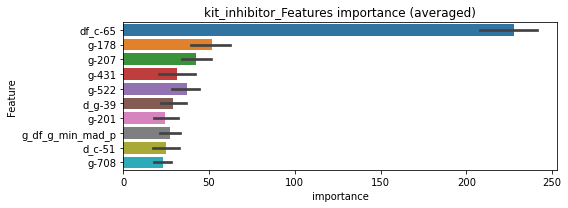

len(train_index) : 3833
len(valid_index) : 3833
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024078	valid_1's binary_logloss: 0.0691082
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00537391	valid_1's binary_logloss: 0.0477283


len(train_index) : 3833
len(valid_index) : 3833
================================= fold 2/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025916	valid_1's binary_logloss: 0.0670461
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0061311	valid_1's binary_logloss: 0.0450685


kit_inhibitor logloss: 0.04639840228653485


neg labels: 3289 → selected neg labels: 3288


laxative, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155863	valid_1's binary_logloss: 0.0191765
[200]	training's binary_logloss: 0.0012867	valid_1's binary_logloss: 0.00325577
[300]	training's binary_logloss: 0.000346683	valid_1's binary_logloss: 0.00191828
[400]	training's binary_logloss: 0.000211138	valid_1's binary_logloss: 0.00160665
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000189012	valid_1's binary_logloss: 0.00156571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162588	valid_1's binary_logloss: 0.0171492
[200]	training's binary_logloss: 0.0013274	valid_1's binary_logloss: 0.00157807
[300]	training's binary_logloss: 0.000357124	valid_1's binary_logloss: 0.000465856
[400]	training's binary_logloss: 0.000218116	valid_1's binary_logloss: 0.000289493
[500]	training's binary_logloss: 0.000188267	valid_1's binary_logloss: 0.000251016
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0005136, Threshold: 0.0007374, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00066, conf_1:0.00081
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0007374
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0107374
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0207374
threshold: 0.0207374, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159512	valid_1's binary_logloss: 0.0204648
[200]	training's binary_logloss: 0.00128498	valid_1's binary_logloss: 0.00362374
[300]	training's binary_logloss: 0.000343701	valid_1's binary_logloss: 0.0020021
[400]	training's binary_logloss: 0.000212131	valid_1's binary_logloss: 0.00173036
[500]	training's binary_logloss: 0.00018777	valid_1's binary_logloss: 0.00167566
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000187925	valid_1's binary_logloss: 0.00167532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164939	valid_1's binary_logloss: 0.0170594
[200]	training's binary_logloss: 0.001337	valid_1's binary_logloss: 0.00143431
[300]	training's binary_logloss: 0.000351791	valid_1's binary_logloss: 0.000392194
[400]	training's binary_logloss: 0.000216502	valid_1's binary_logloss: 0.000243793
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.0818899, Threshold: 0.0207374, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0037670 Vs.target_rate: 0.00025
Num_p_label: 15.0, conf_0:0.01866, conf_1:0.02281
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_1: 0.0207374
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_2: 0.0307374
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_3: 0.0407374
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_4: 0.0507374
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.0607374
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.0707374
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.0807374
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.0907374
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.1007374
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.1107374
threshold: 0.1207374, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159512	valid_1's binary_logloss: 0.0204648
[200]	training's binary_logloss: 0.00128498	valid_1's binary_logloss: 0.00362374
[300]	training's binary_logloss: 0.000343701	valid_1's binary_logloss: 0.0020021
[400]	training's binary_logloss: 0.000212131	valid_1's binary_logloss: 0.00173036
[500]	training's binary_logloss: 0.00018777	valid_1's binary_logloss: 0.00167566
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000187925	valid_1's binary_logloss: 0.00167532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164939	valid_1's binary_logloss: 0.0170594
[200]	training's binary_logloss: 0.001337	valid_1's binary_logloss: 0.00143431
[300]	training's binary_logloss: 0.000351791	valid_1's binary_logloss: 0.000392194
[400]	training's binary_logloss: 0.000216502	valid_1's binary_logloss: 0.000243793
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.0818899, Threshold: 0.1207374, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0007534 Vs.target_rate: 0.00025
Num_p_label: 3.0, conf_0:0.10866, conf_1:0.13281
threshold: 0.1207374, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7795, y_label_rate: 0.0846697


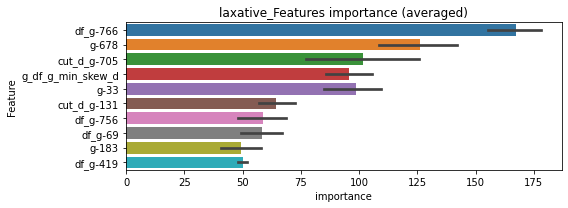

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00855534	valid_1's binary_logloss: 0.010723
[200]	training's binary_logloss: 0.000689392	valid_1's binary_logloss: 0.0027039
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.000200959	valid_1's binary_logloss: 0.00224712


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0087007	valid_1's binary_logloss: 0.00991416
[200]	training's binary_logloss: 0.00069781	valid_1's binary_logloss: 0.0021367
[300]	training's binary_logloss: 0.000187553	valid_1's binary_logloss: 0.00173666
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000144779	valid_1's binary_logloss: 0.00169719


laxative logloss: 0.00197219376383


neg labels: 3289 → selected neg labels: 3288


leukotriene_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156477	valid_1's binary_logloss: 0.0165454
[200]	training's binary_logloss: 0.00128609	valid_1's binary_logloss: 0.00150325
[300]	training's binary_logloss: 0.000343781	valid_1's binary_logloss: 0.000449067
[400]	training's binary_logloss: 0.000209379	valid_1's binary_logloss: 0.000296229
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000185489	valid_1's binary_logloss: 0.000268549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159873	valid_1's binary_logloss: 0.0170466
[200]	training's binary_logloss: 0.00127463	valid_1's binary_logloss: 0.00154075
[300]	training's binary_logloss: 0.000338956	valid_1's binary_logloss: 0.000460771
[400]	training's binary_logloss: 0.000211855	valid_1's binary_logloss: 0.00028922
[500]	training's binary_logloss: 0.000183652	valid_1's binary_logloss: 0.000251338
Early stopping, best itera

1 / 3 AUC score:1.000
y_Threshold: 0.0005470, Threshold: 0.0008400, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00076, conf_1:0.00092
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008400
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0108400
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0208400
threshold: 0.0208400, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158531	valid_1's binary_logloss: 0.017166
[200]	training's binary_logloss: 0.00127856	valid_1's binary_logloss: 0.00189937
[300]	training's binary_logloss: 0.000337786	valid_1's binary_logloss: 0.000706432
[400]	training's binary_logloss: 0.000207751	valid_1's binary_logloss: 0.000533239
[500]	training's binary_logloss: 0.000182219	valid_1's binary_logloss: 0.000496899
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.0001821	valid_1's binary_logloss: 0.000496765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165035	valid_1's binary_logloss: 0.0174191
[200]	training's binary_logloss: 0.00128393	valid_1's binary_logloss: 0.0013782
[300]	training's binary_logloss: 0.000335568	valid_1's binary_logloss: 0.000371355
[400]	training's binary_logloss: 0.00021978	valid_1's binary_logloss: 0.000244685
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1146150, Threshold: 0.0208400, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0035158 Vs.target_rate: 0.00025
Num_p_label: 14.0, conf_0:0.01876, conf_1:0.02292
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_1: 0.0208400
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.0308400
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_3: 0.0408400
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_4: 0.0508400
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.0608400
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_6: 0.0708400
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.0808400
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_8: 0.0908400
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.1008400
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.1108400
threshold: 0.1208400, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= 

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158531	valid_1's binary_logloss: 0.017166
[200]	training's binary_logloss: 0.00127856	valid_1's binary_logloss: 0.00189937
[300]	training's binary_logloss: 0.000337786	valid_1's binary_logloss: 0.000706432
[400]	training's binary_logloss: 0.000207751	valid_1's binary_logloss: 0.000533239
[500]	training's binary_logloss: 0.000182219	valid_1's binary_logloss: 0.000496899
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.0001821	valid_1's binary_logloss: 0.000496765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165035	valid_1's binary_logloss: 0.0174191
[200]	training's binary_logloss: 0.00128393	valid_1's binary_logloss: 0.0013782
[300]	training's binary_logloss: 0.000335568	valid_1's binary_logloss: 0.000371355
[400]	training's binary_logloss: 0.00021978	valid_1's binary_logloss: 0.000244685
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1146150, Threshold: 0.1208400, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0007534 Vs.target_rate: 0.00025
Num_p_label: 3.0, conf_0:0.10876, conf_1:0.13292
threshold: 0.1208400, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7795, y_label_rate: 0.0846697


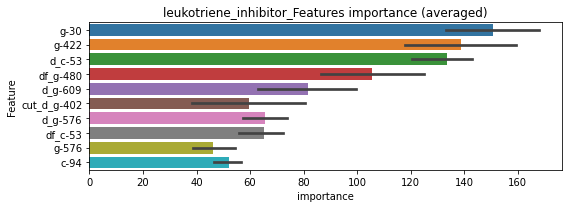

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00841447	valid_1's binary_logloss: 0.0118817
[200]	training's binary_logloss: 0.000662748	valid_1's binary_logloss: 0.00451475
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.000239962	valid_1's binary_logloss: 0.00400688


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00860472	valid_1's binary_logloss: 0.00954964
[200]	training's binary_logloss: 0.000696969	valid_1's binary_logloss: 0.00116256
[300]	training's binary_logloss: 0.000183019	valid_1's binary_logloss: 0.000512401
[400]	training's binary_logloss: 0.000110425	valid_1's binary_logloss: 0.000440032
Early stopping, best iteration is:
[473]	training's binary_logloss: 9.6687e-05	valid_1's binary_logloss: 0.000423812


leukotriene_inhibitor logloss: 0.0022155741612247953


neg labels: 3289 → selected neg labels: 3280


leukotriene_receptor_antagonist, len(trt): 62, len(othr): 3280, target_rate: 0.0026035 → Adj_target_rate: 0.0028037
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422269	valid_1's binary_logloss: 0.0963901
[200]	training's binary_logloss: 0.00747867	valid_1's binary_logloss: 0.0571151
[300]	training's binary_logloss: 0.00220024	valid_1's binary_logloss: 0.0486463
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.001928	valid_1's binary_logloss: 0.048237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464464	valid_1's binary_logloss: 0.0791274
[200]	training's binary_logloss: 0.0088216	valid_1's binary_logloss: 0.0389441
[300]	training's binary_logloss: 0.00259292	valid_1's binary_logloss: 0.0305971
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00144877	valid_1's binary_logloss: 0.0283787


1 / 3 AUC score:0.999
y_Threshold: 0.0083127, Threshold: 0.0107841, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 652/3796
p_label_rate: 0.0200904 Vs.target_rate: 0.00260
Num_p_label: 80.0, conf_0:0.00971, conf_1:0.01186
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_1: 0.0107841
Num_p_label: 18.0, Expected: 10.4, Adj_threshold_2: 0.0207841
threshold: 0.0207841, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432726	valid_1's binary_logloss: 0.0822639
[200]	training's binary_logloss: 0.00781096	valid_1's binary_logloss: 0.0395905
[300]	training's binary_logloss: 0.00231879	valid_1's binary_logloss: 0.0308472
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00121413	valid_1's binary_logloss: 0.0287664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414682	valid_1's binary_logloss: 0.0780908
[200]	training's binary_logloss: 0.00752828	valid_1's binary_logloss: 0.0407729
[300]	training's binary_logloss: 0.00227105	valid_1's binary_logloss: 0.0332753
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.0011938	valid_1's binary_logloss: 0.0312025


2 / 3 AUC score:1.000
y_Threshold: 0.0255547, Threshold: 0.0207841, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 646.0/3784
p_label_rate: 0.0102963 Vs.target_rate: 0.00260
Num_p_label: 41.0, conf_0:0.01871, conf_1:0.02286
Num_p_label: 41.0, Expected: 10.4, Adj_threshold_1: 0.0207841
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_2: 0.0307841
Num_p_label: 10.0, Expected: 10.4, Adj_threshold_3: 0.0407841
threshold: 0.0407841, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 646.0/3784, y_label_rate: 0.1707188
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418553	valid_1's binary_logloss: 0.086411
[200]	training's binary_logloss: 0.00732991	valid_1's binary_logloss: 0.0479724
[300]	training's binary_logloss: 0.00214772	valid_1's binary_logloss: 0.0395828
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00166383	valid_1's binary_logloss: 0.0388341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445889	valid_1's binary_logloss: 0.0765862
[200]	training's binary_logloss: 0.00796732	valid_1's binary_logloss: 0.0331981
[300]	training's binary_logloss: 0.00234261	valid_1's binary_logloss: 0.0234583
[400]	training's binary_logloss: 0.00112	valid_1's binary_logloss: 0.020419
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000827446	valid_1's binary_logloss: 0.0195217


3 / 3 AUC score:1.000
y_Threshold: 0.0261282, Threshold: 0.0407841, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 642.0/3776
p_label_rate: 0.0012557 Vs.target_rate: 0.00260
Num_p_label: 5.0, conf_0:0.03671, conf_1:0.04486
threshold: 0.0407841, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 647.0/7758, y_label_rate: 0.0833978


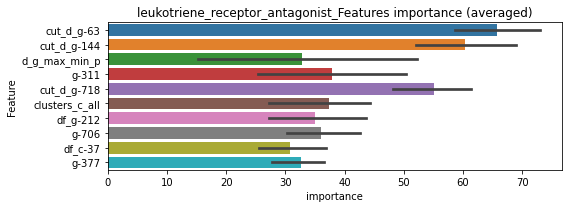

len(train_index) : 3879
len(valid_index) : 3879
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208028	valid_1's binary_logloss: 0.0489152
[200]	training's binary_logloss: 0.00364304	valid_1's binary_logloss: 0.0283559
[300]	training's binary_logloss: 0.00108409	valid_1's binary_logloss: 0.0237321
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000710373	valid_1's binary_logloss: 0.0228356


len(train_index) : 3879
len(valid_index) : 3879
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237396	valid_1's binary_logloss: 0.0476088
[200]	training's binary_logloss: 0.00420378	valid_1's binary_logloss: 0.0264154
[300]	training's binary_logloss: 0.00121564	valid_1's binary_logloss: 0.0222906
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000646912	valid_1's binary_logloss: 0.0213427


leukotriene_receptor_antagonist logloss: 0.02208914690330926


neg labels: 3289 → selected neg labels: 3287


lipase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190226	valid_1's binary_logloss: 0.0271362
[200]	training's binary_logloss: 0.00195941	valid_1's binary_logloss: 0.00633515
[300]	training's binary_logloss: 0.000552189	valid_1's binary_logloss: 0.00311945
[400]	training's binary_logloss: 0.000303346	valid_1's binary_logloss: 0.00230929
[500]	training's binary_logloss: 0.000256593	valid_1's binary_logloss: 0.00215264
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000254533	valid_1's binary_logloss: 0.00214257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192743	valid_1's binary_logloss: 0.0216991
[200]	training's binary_logloss: 0.00196101	valid_1's binary_logloss: 0.00296098
[300]	training's binary_logloss: 0.000557645	valid_1's binary_logloss: 0.00103941
[400]	training's binary_logloss: 0.000310463	valid_1's binary_logloss: 0.000643315
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0009511, Threshold: 0.0015685, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00141, conf_1:0.00173
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0015685
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.0115685
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_3: 0.0215685
threshold: 0.0215685, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194693	valid_1's binary_logloss: 0.0271527
[200]	training's binary_logloss: 0.00194115	valid_1's binary_logloss: 0.00603819
[300]	training's binary_logloss: 0.00053931	valid_1's binary_logloss: 0.00319916
[400]	training's binary_logloss: 0.000301748	valid_1's binary_logloss: 0.00252307
[500]	training's binary_logloss: 0.000259414	valid_1's binary_logloss: 0.00238575
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000260131	valid_1's binary_logloss: 0.00238414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196471	valid_1's binary_logloss: 0.0219757
[200]	training's binary_logloss: 0.00198251	valid_1's binary_logloss: 0.00296596
[300]	training's binary_logloss: 0.000555512	valid_1's binary_logloss: 0.00104654
[400]	training's binary_logloss: 0.000305462	valid_1's binary_logloss: 0.000639078
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0363018, Threshold: 0.0215685, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0017579 Vs.target_rate: 0.00050
Num_p_label: 7.0, conf_0:0.01941, conf_1:0.02373
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.0215685
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.0315685
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.0415685
threshold: 0.0415685, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194693	valid_1's binary_logloss: 0.0271527
[200]	training's binary_logloss: 0.00194115	valid_1's binary_logloss: 0.00603819
[300]	training's binary_logloss: 0.00053931	valid_1's binary_logloss: 0.00319916
[400]	training's binary_logloss: 0.000301748	valid_1's binary_logloss: 0.00252307
[500]	training's binary_logloss: 0.000259414	valid_1's binary_logloss: 0.00238575
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000260131	valid_1's binary_logloss: 0.00238414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196471	valid_1's binary_logloss: 0.0219757
[200]	training's binary_logloss: 0.00198251	valid_1's binary_logloss: 0.00296596
[300]	training's binary_logloss: 0.000555512	valid_1's binary_logloss: 0.00104654
[400]	training's binary_logloss: 0.000305462	valid_1's binary_logloss: 0.000639078
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0363018, Threshold: 0.0415685, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050
Num_p_label: 4.0, conf_0:0.03741, conf_1:0.04573
threshold: 0.0415685, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


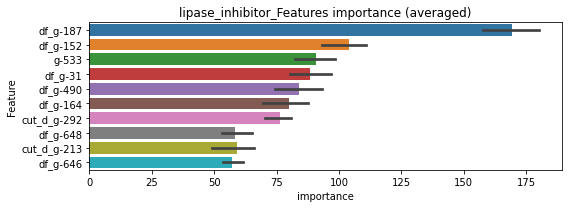

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100879	valid_1's binary_logloss: 0.0158104
[200]	training's binary_logloss: 0.000993868	valid_1's binary_logloss: 0.00615329
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.000389328	valid_1's binary_logloss: 0.00556098


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104338	valid_1's binary_logloss: 0.0124205
[200]	training's binary_logloss: 0.00106631	valid_1's binary_logloss: 0.00287374
[300]	training's binary_logloss: 0.000294375	valid_1's binary_logloss: 0.00192077
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000201785	valid_1's binary_logloss: 0.00177011


lipase_inhibitor logloss: 0.003665544152907597


neg labels: 3289 → selected neg labels: 3278


lipoxygenase_inhibitor, len(trt): 61, len(othr): 3278, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410572	valid_1's binary_logloss: 0.0839399
[200]	training's binary_logloss: 0.00766734	valid_1's binary_logloss: 0.0426675
[300]	training's binary_logloss: 0.0023102	valid_1's binary_logloss: 0.032117
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00175781	valid_1's binary_logloss: 0.0310119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414849	valid_1's binary_logloss: 0.0781015
[200]	training's binary_logloss: 0.00803737	valid_1's binary_logloss: 0.0378991
[300]	training's binary_logloss: 0.00242996	valid_1's binary_logloss: 0.0283454
[400]	training's binary_logloss: 0.0011616	valid_1's binary_logloss: 0.0242628
[500]	training's binary_logloss: 0.000742506	valid_1's binary_logloss: 0.0229306
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000712944	valid_1's binary_logloss: 0.022698


1 / 3 AUC score:1.000
y_Threshold: 0.0060243, Threshold: 0.0102806, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00256
Num_p_label: 80.0, conf_0:0.00925, conf_1:0.01131
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0102806
Num_p_label: 16.0, Expected: 10.2, Adj_threshold_2: 0.0202806
threshold: 0.0202806, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 654.0/3799, y_label_rate: 0.1721506
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422133	valid_1's binary_logloss: 0.0813196
[200]	training's binary_logloss: 0.00787886	valid_1's binary_logloss: 0.0389735
[300]	training's binary_logloss: 0.00238313	valid_1's binary_logloss: 0.0300374
[400]	training's binary_logloss: 0.0011331	valid_1's binary_logloss: 0.0268831
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000912981	valid_1's binary_logloss: 0.0259816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415664	valid_1's binary_logloss: 0.0875316
[200]	training's binary_logloss: 0.00774484	valid_1's binary_logloss: 0.0455104
[300]	training's binary_logloss: 0.0023515	valid_1's binary_logloss: 0.0347285
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00128237	valid_1's binary_logloss: 0.0314668


2 / 3 AUC score:1.000
y_Threshold: 0.0327562, Threshold: 0.0202806, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 649.0/3789
p_label_rate: 0.0205927 Vs.target_rate: 0.00256
Num_p_label: 82.0, conf_0:0.01825, conf_1:0.02231
Num_p_label: 82.0, Expected: 10.2, Adj_threshold_1: 0.0202806
Num_p_label: 53.0, Expected: 10.2, Adj_threshold_2: 0.0302806
Num_p_label: 41.0, Expected: 10.2, Adj_threshold_3: 0.0402806
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_4: 0.0502806
Num_p_label: 13.0, Expected: 10.2, Adj_threshold_5: 0.0602806
threshold: 0.0602806, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 649.0/3789, y_label_rate: 0.1712853
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402423	valid_1's binary_logloss: 0.0841584
[200]	training's binary_logloss: 0.00732415	valid_1's binary_logloss: 0.0425602
[300]	training's binary_logloss: 0.00220857	valid_1's binary_logloss: 0.0324572
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00117358	valid_1's binary_logloss: 0.0303753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438449	valid_1's binary_logloss: 0.0809014
[200]	training's binary_logloss: 0.00804785	valid_1's binary_logloss: 0.0364559
[300]	training's binary_logloss: 0.00241366	valid_1's binary_logloss: 0.0257843
[400]	training's binary_logloss: 0.00115631	valid_1's binary_logloss: 0.0216802
[500]	training's binary_logloss: 0.000736108	valid_1's binary_logloss: 0.0200821
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000689885	valid_1's binary_logloss: 0.0198029


3 / 3 AUC score:1.000
y_Threshold: 0.0262255, Threshold: 0.0602806, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 646.0/3783
p_label_rate: 0.0067805 Vs.target_rate: 0.00256
Num_p_label: 27.0, conf_0:0.05425, conf_1:0.06631
threshold: 0.0602806, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 673.0/7765, y_label_rate: 0.0866710


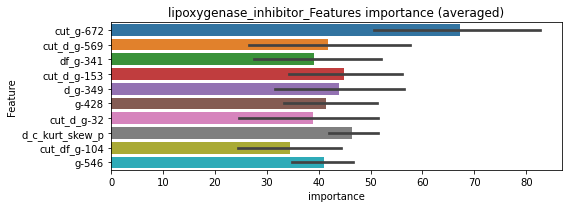

len(train_index) : 3882
len(valid_index) : 3883
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211492	valid_1's binary_logloss: 0.05497
[200]	training's binary_logloss: 0.00356086	valid_1's binary_logloss: 0.0344559
[300]	training's binary_logloss: 0.00103213	valid_1's binary_logloss: 0.0305564
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000962946	valid_1's binary_logloss: 0.0303273


len(train_index) : 3883
len(valid_index) : 3882
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257937	valid_1's binary_logloss: 0.042806
[200]	training's binary_logloss: 0.00485629	valid_1's binary_logloss: 0.0167423
[300]	training's binary_logloss: 0.00139935	valid_1's binary_logloss: 0.0109566
[400]	training's binary_logloss: 0.000662036	valid_1's binary_logloss: 0.0093798
[500]	training's binary_logloss: 0.000425776	valid_1's binary_logloss: 0.00878865
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000392481	valid_1's binary_logloss: 0.00867758


lipoxygenase_inhibitor logloss: 0.019503846921198227


neg labels: 3289 → selected neg labels: 3288


lxr_agonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151294	valid_1's binary_logloss: 0.0161429
[200]	training's binary_logloss: 0.00117717	valid_1's binary_logloss: 0.00145385
[300]	training's binary_logloss: 0.000300358	valid_1's binary_logloss: 0.00043832
[400]	training's binary_logloss: 0.000191523	valid_1's binary_logloss: 0.000299864
[500]	training's binary_logloss: 0.000170615	valid_1's binary_logloss: 0.000273577
[600]	training's binary_logloss: 0.000165768	valid_1's binary_logloss: 0.00026781
[700]	training's binary_logloss: 0.000163345	valid_1's binary_logloss: 0.000265086
Early stopping, best iteration is:
[781]	training's binary_logloss: 0.000162124	valid_1's binary_logloss: 0.000263766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154348	valid_1's binary_logloss: 0.0160079
[200]	training's binary_logloss: 0.00121144	valid_1's binary_logloss: 0.00131676
[300]	training's binary_log

1 / 3 AUC score:1.000
y_Threshold: 0.0004830, Threshold: 0.0014626, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00132, conf_1:0.00161
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0014626
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_2: 0.0114626
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.0214626
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.0314626
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.0414626
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.0514626
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_7: 0.0614626
threshold: 0.0614626, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157341	valid_1's binary_logloss: 0.0167186
[200]	training's binary_logloss: 0.00119842	valid_1's binary_logloss: 0.00164043
[300]	training's binary_logloss: 0.000294281	valid_1's binary_logloss: 0.000668628
[400]	training's binary_logloss: 0.000188336	valid_1's binary_logloss: 0.000527087
[500]	training's binary_logloss: 0.000167428	valid_1's binary_logloss: 0.000497014
[600]	training's binary_logloss: 0.000161911	valid_1's binary_logloss: 0.00049091
[700]	training's binary_logloss: 0.000159249	valid_1's binary_logloss: 0.000487988
[800]	training's binary_logloss: 0.000157656	valid_1's binary_logloss: 0.000486259
Early stopping, best iteration is:
[792]	training's binary_logloss: 0.000157656	valid_1's binary_logloss: 0.000486259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159194	valid_1's binary_logloss: 0.0163822
[200]	training's binary_

2 / 3 AUC score:1.000
y_Threshold: 0.1216072, Threshold: 0.0614626, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0020090 Vs.target_rate: 0.00025
Num_p_label: 8.0, conf_0:0.05532, conf_1:0.06761
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_1: 0.0614626
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_2: 0.0714626
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_3: 0.0814626
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_4: 0.0914626
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_5: 0.1014626
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_6: 0.1114626
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_7: 0.1214626
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_8: 0.1314626
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_9: 0.1414626
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_10: 0.1514626
threshold: 0.1614626, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pse

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157341	valid_1's binary_logloss: 0.0167186
[200]	training's binary_logloss: 0.00119842	valid_1's binary_logloss: 0.00164043
[300]	training's binary_logloss: 0.000294281	valid_1's binary_logloss: 0.000668628
[400]	training's binary_logloss: 0.000188336	valid_1's binary_logloss: 0.000527087
[500]	training's binary_logloss: 0.000167428	valid_1's binary_logloss: 0.000497014
[600]	training's binary_logloss: 0.000161911	valid_1's binary_logloss: 0.00049091
[700]	training's binary_logloss: 0.000159249	valid_1's binary_logloss: 0.000487988
[800]	training's binary_logloss: 0.000157656	valid_1's binary_logloss: 0.000486259
[900]	training's binary_logloss: 0.00015694	valid_1's binary_logloss: 0.000485331
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.000156747	valid_1's binary_logloss: 0.000485085
Training until validation scores don't improve for 10 rounds
[100]	training's bina

3 / 3 AUC score:1.000
y_Threshold: 0.1214605, Threshold: 0.1614626, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0010045 Vs.target_rate: 0.00025
Num_p_label: 4.0, conf_0:0.14532, conf_1:0.17761
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.1614626
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.1714626
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.1814626
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.1914626
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.2014626
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.2114626
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.2214626
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_8: 0.2314626
threshold: 0.2314626, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


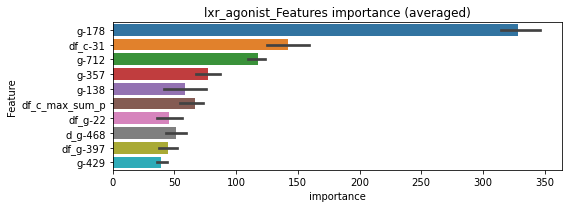

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00840149	valid_1's binary_logloss: 0.00924688
[200]	training's binary_logloss: 0.000653113	valid_1's binary_logloss: 0.00127863
[300]	training's binary_logloss: 0.000157445	valid_1's binary_logloss: 0.000768517
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.000119726	valid_1's binary_logloss: 0.00072753


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00851455	valid_1's binary_logloss: 0.0096353
[200]	training's binary_logloss: 0.000652827	valid_1's binary_logloss: 0.00175449
[300]	training's binary_logloss: 0.000163484	valid_1's binary_logloss: 0.00120051
[400]	training's binary_logloss: 0.000101385	valid_1's binary_logloss: 0.00115049
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000103598	valid_1's binary_logloss: 0.00114648


lxr_agonist logloss: 0.0009369802575363167


neg labels: 3289 → selected neg labels: 3284


mdm_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022864	valid_1's binary_logloss: 0.0346099
[200]	training's binary_logloss: 0.00277321	valid_1's binary_logloss: 0.0089118
[300]	training's binary_logloss: 0.00080082	valid_1's binary_logloss: 0.00487238
[400]	training's binary_logloss: 0.000419501	valid_1's binary_logloss: 0.00357277
[500]	training's binary_logloss: 0.000322946	valid_1's binary_logloss: 0.00318035
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000319817	valid_1's binary_logloss: 0.00316479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230818	valid_1's binary_logloss: 0.0305124
[200]	training's binary_logloss: 0.00280116	valid_1's binary_logloss: 0.00633039
[300]	training's binary_logloss: 0.00080824	valid_1's binary_logloss: 0.00286611
[400]	training's binary_logloss: 0.000423633	valid_1's binary_logloss: 0.0019351
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0025789, Threshold: 0.0080120, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130
Num_p_label: 80.0, conf_0:0.00721, conf_1:0.00881
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0080120
Num_p_label: 38.0, Expected: 5.2, Adj_threshold_2: 0.0180120
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_3: 0.0280120
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_4: 0.0380120
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_5: 0.0480120
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_6: 0.0580120
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_7: 0.0680120
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_8: 0.0780120
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_9: 0.0880120
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_10: 0.0980120
threshold: 0.0980120, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222552	valid_1's binary_logloss: 0.0296031
[200]	training's binary_logloss: 0.00249812	valid_1's binary_logloss: 0.00529392
[300]	training's binary_logloss: 0.000682108	valid_1's binary_logloss: 0.00245812
[400]	training's binary_logloss: 0.000365898	valid_1's binary_logloss: 0.00170107
[500]	training's binary_logloss: 0.00029266	valid_1's binary_logloss: 0.00150656
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000288757	valid_1's binary_logloss: 0.00149549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218747	valid_1's binary_logloss: 0.0279371
[200]	training's binary_logloss: 0.00242052	valid_1's binary_logloss: 0.00465453
[300]	training's binary_logloss: 0.000681872	valid_1's binary_logloss: 0.00185232
[400]	training's binary_logloss: 0.000368499	valid_1's binary_logloss: 0.00116161
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.3643638, Threshold: 0.0980120, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130
Num_p_label: 80.0, conf_0:0.08821, conf_1:0.10781
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0980120
Num_p_label: 77.0, Expected: 5.2, Adj_threshold_2: 0.1080120
Num_p_label: 73.0, Expected: 5.2, Adj_threshold_3: 0.1180120
Num_p_label: 72.0, Expected: 5.2, Adj_threshold_4: 0.1280120
Num_p_label: 72.0, Expected: 5.2, Adj_threshold_5: 0.1380120
Num_p_label: 72.0, Expected: 5.2, Adj_threshold_6: 0.1480120
Num_p_label: 71.0, Expected: 5.2, Adj_threshold_7: 0.1580120
Num_p_label: 70.0, Expected: 5.2, Adj_threshold_8: 0.1680120
Num_p_label: 68.0, Expected: 5.2, Adj_threshold_9: 0.1780120
Num_p_label: 68.0, Expected: 5.2, Adj_threshold_10: 0.1880120
threshold: 0.1980120, positive_p_label: 66.0/3982, p_label_rate: 0.0165746
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222552	valid_1's binary_logloss: 0.0296031
[200]	training's binary_logloss: 0.00249812	valid_1's binary_logloss: 0.00529392
[300]	training's binary_logloss: 0.000682108	valid_1's binary_logloss: 0.00245812
[400]	training's binary_logloss: 0.000365898	valid_1's binary_logloss: 0.00170107
[500]	training's binary_logloss: 0.00029266	valid_1's binary_logloss: 0.00150656
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000288757	valid_1's binary_logloss: 0.00149549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218747	valid_1's binary_logloss: 0.0279371
[200]	training's binary_logloss: 0.00242052	valid_1's binary_logloss: 0.00465453
[300]	training's binary_logloss: 0.000681872	valid_1's binary_logloss: 0.00185232
[400]	training's binary_logloss: 0.000368499	valid_1's binary_logloss: 0.00116161
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.3643638, Threshold: 0.1980120, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0165746 Vs.target_rate: 0.00130
Num_p_label: 66.0, conf_0:0.17821, conf_1:0.21781
Num_p_label: 66.0, Expected: 5.2, Adj_threshold_1: 0.1980120
Num_p_label: 65.0, Expected: 5.2, Adj_threshold_2: 0.2080120
Num_p_label: 65.0, Expected: 5.2, Adj_threshold_3: 0.2180120
Num_p_label: 64.0, Expected: 5.2, Adj_threshold_4: 0.2280120
Num_p_label: 64.0, Expected: 5.2, Adj_threshold_5: 0.2380120
Num_p_label: 64.0, Expected: 5.2, Adj_threshold_6: 0.2480120
Num_p_label: 61.0, Expected: 5.2, Adj_threshold_7: 0.2580120
Num_p_label: 59.0, Expected: 5.2, Adj_threshold_8: 0.2680120
Num_p_label: 58.0, Expected: 5.2, Adj_threshold_9: 0.2780120
Num_p_label: 57.0, Expected: 5.2, Adj_threshold_10: 0.2880120
threshold: 0.2980120, positive_p_label: 56.0/3982, p_label_rate: 0.0140633
positive_y_label: 712.0/7790, y_label_rate: 0.0913992


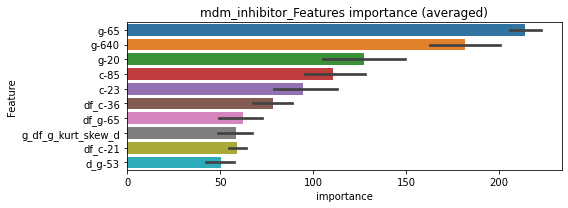

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127885	valid_1's binary_logloss: 0.023635
[200]	training's binary_logloss: 0.00147764	valid_1's binary_logloss: 0.00928775
[300]	training's binary_logloss: 0.000421101	valid_1's binary_logloss: 0.00734525
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000272884	valid_1's binary_logloss: 0.00706377


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133795	valid_1's binary_logloss: 0.022803
[200]	training's binary_logloss: 0.0016291	valid_1's binary_logloss: 0.00809395
[300]	training's binary_logloss: 0.000480864	valid_1's binary_logloss: 0.00624953
[400]	training's binary_logloss: 0.000255129	valid_1's binary_logloss: 0.00582421
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000215743	valid_1's binary_logloss: 0.00573809


mdm_inhibitor logloss: 0.00640093219027217


neg labels: 3289 → selected neg labels: 3278


mek_inhibitor, len(trt): 72, len(othr): 3278, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271383	valid_1's binary_logloss: 0.0485259
[200]	training's binary_logloss: 0.00378312	valid_1's binary_logloss: 0.0234416
[300]	training's binary_logloss: 0.00108481	valid_1's binary_logloss: 0.0198007
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00104471	valid_1's binary_logloss: 0.0196454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274887	valid_1's binary_logloss: 0.0528139
[200]	training's binary_logloss: 0.00377686	valid_1's binary_logloss: 0.0259104
[300]	training's binary_logloss: 0.00106775	valid_1's binary_logloss: 0.0210821
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000754049	valid_1's binary_logloss: 0.0203604


1 / 3 AUC score:0.999
y_Threshold: 0.0040694, Threshold: 0.0098138, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00302
Num_p_label: 80.0, conf_0:0.00883, conf_1:0.01080
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0098138
Num_p_label: 53.0, Expected: 12.0, Adj_threshold_2: 0.0198138
Num_p_label: 42.0, Expected: 12.0, Adj_threshold_3: 0.0298138
Num_p_label: 36.0, Expected: 12.0, Adj_threshold_4: 0.0398138
Num_p_label: 31.0, Expected: 12.0, Adj_threshold_5: 0.0498138
Num_p_label: 30.0, Expected: 12.0, Adj_threshold_6: 0.0598138
Num_p_label: 28.0, Expected: 12.0, Adj_threshold_7: 0.0698138
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_8: 0.0798138
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_9: 0.0898138
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_10: 0.0998138
threshold: 0.1098138, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 654.0/3799, y_label_rate: 0.1721506

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259842	valid_1's binary_logloss: 0.0507198
[200]	training's binary_logloss: 0.00330067	valid_1's binary_logloss: 0.0239165
[300]	training's binary_logloss: 0.00091801	valid_1's binary_logloss: 0.0197203
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000504079	valid_1's binary_logloss: 0.0183332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269339	valid_1's binary_logloss: 0.0508651
[200]	training's binary_logloss: 0.00352362	valid_1's binary_logloss: 0.0191629
[300]	training's binary_logloss: 0.000973396	valid_1's binary_logloss: 0.0125228
[400]	training's binary_logloss: 0.000492294	valid_1's binary_logloss: 0.0099842
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00047057	valid_1's binary_logloss: 0.00989818


2 / 3 AUC score:1.000
y_Threshold: 0.0240433, Threshold: 0.1098138, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 651.0/3793
p_label_rate: 0.0125565 Vs.target_rate: 0.00302
Num_p_label: 50.0, conf_0:0.09883, conf_1:0.12080
Num_p_label: 50.0, Expected: 12.0, Adj_threshold_1: 0.1098138
Num_p_label: 48.0, Expected: 12.0, Adj_threshold_2: 0.1198138
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_3: 0.1298138
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_4: 0.1398138
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_5: 0.1498138
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_6: 0.1598138
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_7: 0.1698138
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_8: 0.1798138
Num_p_label: 42.0, Expected: 12.0, Adj_threshold_9: 0.1898138
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_10: 0.1998138
threshold: 0.2098138, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 651.0/3793, y_label_rate: 0.1716320

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258712	valid_1's binary_logloss: 0.0438637
[200]	training's binary_logloss: 0.00329275	valid_1's binary_logloss: 0.0137959
[300]	training's binary_logloss: 0.000923986	valid_1's binary_logloss: 0.00834094
[400]	training's binary_logloss: 0.000480215	valid_1's binary_logloss: 0.00679808
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00037536	valid_1's binary_logloss: 0.00641352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261352	valid_1's binary_logloss: 0.0460825
[200]	training's binary_logloss: 0.00327715	valid_1's binary_logloss: 0.0190859
[300]	training's binary_logloss: 0.000919696	valid_1's binary_logloss: 0.0132521
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000564923	valid_1's binary_logloss: 0.0120585


3 / 3 AUC score:1.000
y_Threshold: 0.0228556, Threshold: 0.2098138, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 651.0/3793
p_label_rate: 0.0102963 Vs.target_rate: 0.00302
Num_p_label: 41.0, conf_0:0.18883, conf_1:0.23080
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_1: 0.2098138
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_2: 0.2198138
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_3: 0.2298138
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_4: 0.2398138
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_5: 0.2498138
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_6: 0.2598138
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_7: 0.2698138
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_8: 0.2798138
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_9: 0.2898138
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_10: 0.2998138
threshold: 0.3098138, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 688.0/7775, y_label_rate: 0.0884887

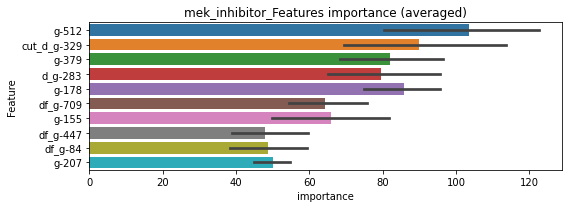

len(train_index) : 3887
len(valid_index) : 3888
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137592	valid_1's binary_logloss: 0.0289311
[200]	training's binary_logloss: 0.00169845	valid_1's binary_logloss: 0.0128187
[300]	training's binary_logloss: 0.000486465	valid_1's binary_logloss: 0.00947555
[400]	training's binary_logloss: 0.00025184	valid_1's binary_logloss: 0.00854815
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000200899	valid_1's binary_logloss: 0.00827794


len(train_index) : 3888
len(valid_index) : 3887
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140167	valid_1's binary_logloss: 0.0292391
[200]	training's binary_logloss: 0.00176065	valid_1's binary_logloss: 0.0126111
[300]	training's binary_logloss: 0.000511057	valid_1's binary_logloss: 0.00949489
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000428997	valid_1's binary_logloss: 0.00912802


mek_inhibitor logloss: 0.008702923748044171


neg labels: 3289 → selected neg labels: 3278


membrane_integrity_inhibitor, len(trt): 74, len(othr): 3278, target_rate: 0.0031074 → Adj_target_rate: 0.0032587
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475636	valid_1's binary_logloss: 0.0952581
[200]	training's binary_logloss: 0.00965774	valid_1's binary_logloss: 0.0540176
[300]	training's binary_logloss: 0.0028599	valid_1's binary_logloss: 0.0444486
[400]	training's binary_logloss: 0.00133854	valid_1's binary_logloss: 0.0420334
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00126769	valid_1's binary_logloss: 0.0419165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04956	valid_1's binary_logloss: 0.0951292
[200]	training's binary_logloss: 0.010175	valid_1's binary_logloss: 0.0477114
[300]	training's binary_logloss: 0.00299992	valid_1's binary_logloss: 0.0364002
[400]	training's binary_logloss: 0.00137234	valid_1's binary_logloss: 0.0325416
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00109773	valid_1's binary_logloss: 0.0317764


1 / 3 AUC score:0.997
y_Threshold: 0.0086653, Threshold: 0.0137027, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3793
p_label_rate: 0.0200904 Vs.target_rate: 0.00311
Num_p_label: 80.0, conf_0:0.01233, conf_1:0.01507
Num_p_label: 80.0, Expected: 12.4, Adj_threshold_1: 0.0137027
Num_p_label: 37.0, Expected: 12.4, Adj_threshold_2: 0.0237027
Num_p_label: 16.0, Expected: 12.4, Adj_threshold_3: 0.0337027
threshold: 0.0337027, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 651.0/3793, y_label_rate: 0.1716320
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04529	valid_1's binary_logloss: 0.102692
[200]	training's binary_logloss: 0.00857573	valid_1's binary_logloss: 0.0633069
[300]	training's binary_logloss: 0.00252003	valid_1's binary_logloss: 0.0560039
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00205614	valid_1's binary_logloss: 0.0555163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500248	valid_1's binary_logloss: 0.0792315
[200]	training's binary_logloss: 0.0100871	valid_1's binary_logloss: 0.0322585
[300]	training's binary_logloss: 0.00301589	valid_1's binary_logloss: 0.0206296
[400]	training's binary_logloss: 0.0013961	valid_1's binary_logloss: 0.0172346
[500]	training's binary_logloss: 0.000868132	valid_1's binary_logloss: 0.0157509
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000733267	valid_1's binary_logloss: 0.0152994


2 / 3 AUC score:0.999
y_Threshold: 0.0336913, Threshold: 0.0337027, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 641.0/3773
p_label_rate: 0.0128076 Vs.target_rate: 0.00311
Num_p_label: 51.0, conf_0:0.03033, conf_1:0.03707
Num_p_label: 51.0, Expected: 12.4, Adj_threshold_1: 0.0337027
Num_p_label: 26.0, Expected: 12.4, Adj_threshold_2: 0.0437027
Num_p_label: 20.0, Expected: 12.4, Adj_threshold_3: 0.0537027
threshold: 0.0537027, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 641.0/3773, y_label_rate: 0.1698913
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452441	valid_1's binary_logloss: 0.0960129
[200]	training's binary_logloss: 0.00829051	valid_1's binary_logloss: 0.0534845
[300]	training's binary_logloss: 0.00245298	valid_1's binary_logloss: 0.0438032
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00175628	valid_1's binary_logloss: 0.0423423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046936	valid_1's binary_logloss: 0.0880994
[200]	training's binary_logloss: 0.00876303	valid_1's binary_logloss: 0.0415938
[300]	training's binary_logloss: 0.00262639	valid_1's binary_logloss: 0.0317564
[400]	training's binary_logloss: 0.00124863	valid_1's binary_logloss: 0.0282986
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00121711	valid_1's binary_logloss: 0.0281922


3 / 3 AUC score:1.000
y_Threshold: 0.0370298, Threshold: 0.0537027, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 633.0/3757
p_label_rate: 0.0070316 Vs.target_rate: 0.00311
Num_p_label: 28.0, conf_0:0.04833, conf_1:0.05907
threshold: 0.0537027, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 661.0/7739, y_label_rate: 0.0854116


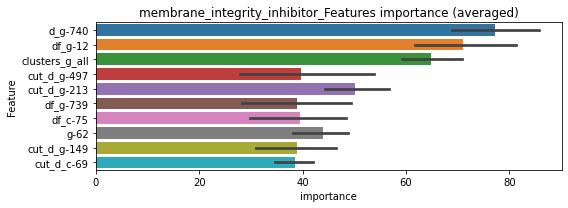

len(train_index) : 3869
len(valid_index) : 3870
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250696	valid_1's binary_logloss: 0.0615267
[200]	training's binary_logloss: 0.00469321	valid_1's binary_logloss: 0.040993
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00268987	valid_1's binary_logloss: 0.0387765


len(train_index) : 3870
len(valid_index) : 3869
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274953	valid_1's binary_logloss: 0.0540381
[200]	training's binary_logloss: 0.00531586	valid_1's binary_logloss: 0.0291754
[300]	training's binary_logloss: 0.00154211	valid_1's binary_logloss: 0.0236342
[400]	training's binary_logloss: 0.000712763	valid_1's binary_logloss: 0.0227028
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000755753	valid_1's binary_logloss: 0.022609


membrane_integrity_inhibitor logloss: 0.03069378368076814


neg labels: 3289 → selected neg labels: 3285


mineralocorticoid_receptor_antagonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248863	valid_1's binary_logloss: 0.0388449
[200]	training's binary_logloss: 0.00309323	valid_1's binary_logloss: 0.0109994
[300]	training's binary_logloss: 0.000896051	valid_1's binary_logloss: 0.00711342
[400]	training's binary_logloss: 0.000467038	valid_1's binary_logloss: 0.00598571
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000370236	valid_1's binary_logloss: 0.00566433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259155	valid_1's binary_logloss: 0.0375805
[200]	training's binary_logloss: 0.00340542	valid_1's binary_logloss: 0.00921389
[300]	training's binary_logloss: 0.000973634	valid_1's binary_logloss: 0.0050328
[400]	training's binary_logloss: 0.000494695	valid_1's binary_logloss: 0.00392264
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000382814	valid_1's binary_logloss: 0.0036245

1 / 3 AUC score:1.000
y_Threshold: 0.0016490, Threshold: 0.0024135, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00217, conf_1:0.00265
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0024135
Num_p_label: 2.0, Expected: 4.2, Adj_threshold_2: 0.0124135
threshold: 0.0124135, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025038	valid_1's binary_logloss: 0.0382717
[200]	training's binary_logloss: 0.00310106	valid_1's binary_logloss: 0.0100019
[300]	training's binary_logloss: 0.000889861	valid_1's binary_logloss: 0.00620932
[400]	training's binary_logloss: 0.000465393	valid_1's binary_logloss: 0.00514529
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00036826	valid_1's binary_logloss: 0.00489274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256332	valid_1's binary_logloss: 0.036827
[200]	training's binary_logloss: 0.00329156	valid_1's binary_logloss: 0.00912077
[300]	training's binary_logloss: 0.000934567	valid_1's binary_logloss: 0.00497808
[400]	training's binary_logloss: 0.000485493	valid_1's binary_logloss: 0.00381588
[500]	training's binary_logloss: 0.000364832	valid_1's binary_logloss: 0.00358325
Early stopping, best iteration is:


2 / 3 AUC score:1.000
y_Threshold: 0.0277858, Threshold: 0.0124135, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0030136 Vs.target_rate: 0.00105
Num_p_label: 12.0, conf_0:0.01117, conf_1:0.01365
threshold: 0.0124135, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025038	valid_1's binary_logloss: 0.0382717
[200]	training's binary_logloss: 0.00310106	valid_1's binary_logloss: 0.0100019
[300]	training's binary_logloss: 0.000889861	valid_1's binary_logloss: 0.00620932
[400]	training's binary_logloss: 0.000465393	valid_1's binary_logloss: 0.00514529
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00036826	valid_1's binary_logloss: 0.00489274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256332	valid_1's binary_logloss: 0.036827
[200]	training's binary_logloss: 0.00329156	valid_1's binary_logloss: 0.00912077
[300]	training's binary_logloss: 0.000934567	valid_1's binary_logloss: 0.00497808
[400]	training's binary_logloss: 0.000485493	valid_1's binary_logloss: 0.00381588
[500]	training's binary_logloss: 0.000364832	valid_1's binary_logloss: 0.00358325
Early stopping, best iteration is:


3 / 3 AUC score:1.000
y_Threshold: 0.0277858, Threshold: 0.0124135, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0030136 Vs.target_rate: 0.00105
Num_p_label: 12.0, conf_0:0.01117, conf_1:0.01365
threshold: 0.0124135, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 669.0/7792, y_label_rate: 0.0858573


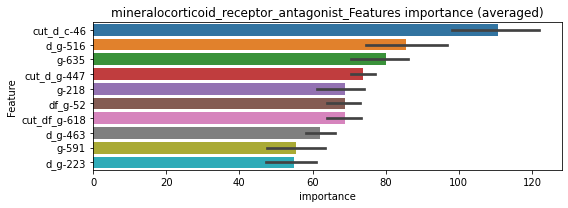

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140695	valid_1's binary_logloss: 0.0305337
[200]	training's binary_logloss: 0.00186306	valid_1's binary_logloss: 0.0151152
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00072864	valid_1's binary_logloss: 0.0137251


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143161	valid_1's binary_logloss: 0.0231652
[200]	training's binary_logloss: 0.00193403	valid_1's binary_logloss: 0.00931566
[300]	training's binary_logloss: 0.000553452	valid_1's binary_logloss: 0.0079872
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000579977	valid_1's binary_logloss: 0.00797651


mineralocorticoid_receptor_antagonist logloss: 0.010850802810368194


neg labels: 3289 → selected neg labels: 3287


monoacylglycerol_lipase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193977	valid_1's binary_logloss: 0.0244126
[200]	training's binary_logloss: 0.00197213	valid_1's binary_logloss: 0.00417502
[300]	training's binary_logloss: 0.000554861	valid_1's binary_logloss: 0.00197998
[400]	training's binary_logloss: 0.000311053	valid_1's binary_logloss: 0.00148602
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00026168	valid_1's binary_logloss: 0.0014009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018792	valid_1's binary_logloss: 0.0228866
[200]	training's binary_logloss: 0.00191539	valid_1's binary_logloss: 0.0043583
[300]	training's binary_logloss: 0.000541722	valid_1's binary_logloss: 0.00226144
[400]	training's binary_logloss: 0.000305594	valid_1's binary_logloss: 0.00168216
[500]	training's binary_logloss: 0.000260328	valid_1's binary_logloss: 0.00158182
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0007889, Threshold: 0.0012252, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00110, conf_1:0.00135
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0012252
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_2: 0.0112252
threshold: 0.0112252, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196496	valid_1's binary_logloss: 0.0233834
[200]	training's binary_logloss: 0.00197723	valid_1's binary_logloss: 0.00346856
[300]	training's binary_logloss: 0.000551922	valid_1's binary_logloss: 0.00146575
[400]	training's binary_logloss: 0.00030848	valid_1's binary_logloss: 0.0010085
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000267068	valid_1's binary_logloss: 0.000933262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190967	valid_1's binary_logloss: 0.022888
[200]	training's binary_logloss: 0.00192032	valid_1's binary_logloss: 0.0040058
[300]	training's binary_logloss: 0.000540865	valid_1's binary_logloss: 0.00214414
[400]	training's binary_logloss: 0.000305151	valid_1's binary_logloss: 0.00162944
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000263821	valid_1's binary_logloss: 0.0015537


2 / 3 AUC score:1.000
y_Threshold: 0.0662140, Threshold: 0.0112252, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0035158 Vs.target_rate: 0.00050
Num_p_label: 14.0, conf_0:0.01010, conf_1:0.01235
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_1: 0.0112252
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.0212252
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.0312252
threshold: 0.0312252, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196496	valid_1's binary_logloss: 0.0233834
[200]	training's binary_logloss: 0.00197723	valid_1's binary_logloss: 0.00346856
[300]	training's binary_logloss: 0.000551922	valid_1's binary_logloss: 0.00146575
[400]	training's binary_logloss: 0.00030848	valid_1's binary_logloss: 0.0010085
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000267068	valid_1's binary_logloss: 0.000933262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190967	valid_1's binary_logloss: 0.022888
[200]	training's binary_logloss: 0.00192032	valid_1's binary_logloss: 0.0040058
[300]	training's binary_logloss: 0.000540865	valid_1's binary_logloss: 0.00214414
[400]	training's binary_logloss: 0.000305151	valid_1's binary_logloss: 0.00162944
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000263821	valid_1's binary_logloss: 0.0015537


3 / 3 AUC score:1.000
y_Threshold: 0.0662140, Threshold: 0.0312252, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050
Num_p_label: 3.0, conf_0:0.02810, conf_1:0.03435
threshold: 0.0312252, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


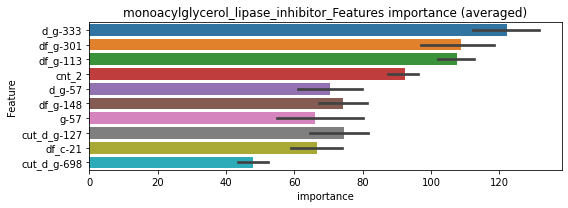

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00985077	valid_1's binary_logloss: 0.0153241
[200]	training's binary_logloss: 0.000982348	valid_1's binary_logloss: 0.00570906
[300]	training's binary_logloss: 0.000271795	valid_1's binary_logloss: 0.00472501
[400]	training's binary_logloss: 0.000150214	valid_1's binary_logloss: 0.00441322
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000154859	valid_1's binary_logloss: 0.00441004


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101092	valid_1's binary_logloss: 0.0125693
[200]	training's binary_logloss: 0.00102859	valid_1's binary_logloss: 0.0033158
[300]	training's binary_logloss: 0.000281297	valid_1's binary_logloss: 0.0024513
[400]	training's binary_logloss: 0.000154706	valid_1's binary_logloss: 0.0022519
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000160607	valid_1's binary_logloss: 0.00224648


monoacylglycerol_lipase_inhibitor logloss: 0.003328257345117167


neg labels: 3289 → selected neg labels: 3274


monoamine_oxidase_inhibitor, len(trt): 85, len(othr): 3274, target_rate: 0.0035693 → Adj_target_rate: 0.0036661
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510412	valid_1's binary_logloss: 0.103274
[200]	training's binary_logloss: 0.0108	valid_1's binary_logloss: 0.0601014
[300]	training's binary_logloss: 0.00326535	valid_1's binary_logloss: 0.0511218
[400]	training's binary_logloss: 0.00151388	valid_1's binary_logloss: 0.047975
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00124467	valid_1's binary_logloss: 0.0474302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534213	valid_1's binary_logloss: 0.104578
[200]	training's binary_logloss: 0.0115787	valid_1's binary_logloss: 0.0604924
[300]	training's binary_logloss: 0.00348547	valid_1's binary_logloss: 0.050177
[400]	training's binary_logloss: 0.00161247	valid_1's binary_logloss: 0.0475842
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.0014242	valid_1's binary_logloss: 0.0473044


1 / 3 AUC score:0.996
y_Threshold: 0.0090773, Threshold: 0.0121015, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 645/3778
p_label_rate: 0.0200904 Vs.target_rate: 0.00357
Num_p_label: 80.0, conf_0:0.01089, conf_1:0.01331
Num_p_label: 80.0, Expected: 14.2, Adj_threshold_1: 0.0121015
Num_p_label: 18.0, Expected: 14.2, Adj_threshold_2: 0.0221015
threshold: 0.0221015, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 645.0/3778, y_label_rate: 0.1707253
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503636	valid_1's binary_logloss: 0.1071
[200]	training's binary_logloss: 0.0101403	valid_1's binary_logloss: 0.0612934
[300]	training's binary_logloss: 0.00304924	valid_1's binary_logloss: 0.0497821
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00244863	valid_1's binary_logloss: 0.0483959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537957	valid_1's binary_logloss: 0.105307
[200]	training's binary_logloss: 0.0112852	valid_1's binary_logloss: 0.0507381
[300]	training's binary_logloss: 0.00334159	valid_1's binary_logloss: 0.0372461
[400]	training's binary_logloss: 0.00155186	valid_1's binary_logloss: 0.0330783
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00099364	valid_1's binary_logloss: 0.0309542


2 / 3 AUC score:0.999
y_Threshold: 0.0320632, Threshold: 0.0221015, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 637.0/3762
p_label_rate: 0.0188348 Vs.target_rate: 0.00357
Num_p_label: 75.0, conf_0:0.01989, conf_1:0.02431
Num_p_label: 75.0, Expected: 14.2, Adj_threshold_1: 0.0221015
Num_p_label: 35.0, Expected: 14.2, Adj_threshold_2: 0.0321015
Num_p_label: 14.0, Expected: 14.2, Adj_threshold_3: 0.0421015
threshold: 0.0421015, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 637.0/3762, y_label_rate: 0.1693248
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510038	valid_1's binary_logloss: 0.106406
[200]	training's binary_logloss: 0.0100388	valid_1's binary_logloss: 0.0584572
[300]	training's binary_logloss: 0.00296223	valid_1's binary_logloss: 0.0464668
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00165047	valid_1's binary_logloss: 0.0437158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0491205	valid_1's binary_logloss: 0.0967811
[200]	training's binary_logloss: 0.0102404	valid_1's binary_logloss: 0.0525866
[300]	training's binary_logloss: 0.00309064	valid_1's binary_logloss: 0.0411775
[400]	training's binary_logloss: 0.00142642	valid_1's binary_logloss: 0.0369845
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00117226	valid_1's binary_logloss: 0.03606


3 / 3 AUC score:1.000
y_Threshold: 0.0350044, Threshold: 0.0421015, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 631.0/3750
p_label_rate: 0.0042692 Vs.target_rate: 0.00357
Num_p_label: 17.0, conf_0:0.03789, conf_1:0.04631
threshold: 0.0421015, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 648.0/7732, y_label_rate: 0.0838076


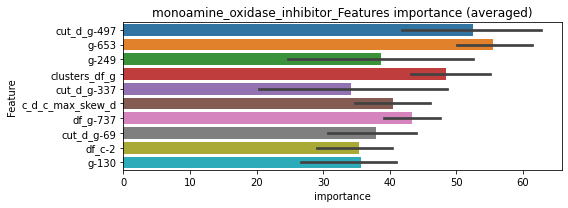

len(train_index) : 3866
len(valid_index) : 3866
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028422	valid_1's binary_logloss: 0.0653413
[200]	training's binary_logloss: 0.00587254	valid_1's binary_logloss: 0.0404471
[300]	training's binary_logloss: 0.00170205	valid_1's binary_logloss: 0.0353047
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00121061	valid_1's binary_logloss: 0.0350149


len(train_index) : 3866
len(valid_index) : 3866
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284342	valid_1's binary_logloss: 0.0626916
[200]	training's binary_logloss: 0.00584505	valid_1's binary_logloss: 0.0367575
[300]	training's binary_logloss: 0.00178444	valid_1's binary_logloss: 0.0316886
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00150586	valid_1's binary_logloss: 0.0313119


monoamine_oxidase_inhibitor logloss: 0.033163374847468445


neg labels: 3289 → selected neg labels: 3286


monopolar_spindle_1_kinase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204742	valid_1's binary_logloss: 0.0253886
[200]	training's binary_logloss: 0.00221747	valid_1's binary_logloss: 0.00389499
[300]	training's binary_logloss: 0.000634563	valid_1's binary_logloss: 0.00144178
[400]	training's binary_logloss: 0.000345094	valid_1's binary_logloss: 0.000907473
[500]	training's binary_logloss: 0.000284521	valid_1's binary_logloss: 0.000796129
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000280844	valid_1's binary_logloss: 0.000791079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209392	valid_1's binary_logloss: 0.0257547
[200]	training's binary_logloss: 0.00230841	valid_1's binary_logloss: 0.00407789
[300]	training's binary_logloss: 0.000647119	valid_1's binary_logloss: 0.00170094
[400]	training's binary_logloss: 0.000350262	valid_1's binary_logloss: 0.00120095
Early stopping, best iterati

1 / 3 AUC score:1.000
y_Threshold: 0.0012126, Threshold: 0.0024263, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00218, conf_1:0.00267
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0024263
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.0124263
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_3: 0.0224263
threshold: 0.0224263, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205762	valid_1's binary_logloss: 0.0249264
[200]	training's binary_logloss: 0.00218472	valid_1's binary_logloss: 0.00348329
[300]	training's binary_logloss: 0.000612989	valid_1's binary_logloss: 0.00118025
[400]	training's binary_logloss: 0.000334326	valid_1's binary_logloss: 0.000709189
[500]	training's binary_logloss: 0.000281706	valid_1's binary_logloss: 0.000623842
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000277206	valid_1's binary_logloss: 0.000617359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206074	valid_1's binary_logloss: 0.0262096
[200]	training's binary_logloss: 0.00218	valid_1's binary_logloss: 0.00436954
[300]	training's binary_logloss: 0.000611159	valid_1's binary_logloss: 0.00174974
[400]	training's binary_logloss: 0.000336829	valid_1's binary_logloss: 0.00135383
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0867496, Threshold: 0.0224263, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0040181 Vs.target_rate: 0.00076
Num_p_label: 16.0, conf_0:0.02018, conf_1:0.02467
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_1: 0.0224263
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0324263
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.0424263
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.0524263
threshold: 0.0524263, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205762	valid_1's binary_logloss: 0.0249264
[200]	training's binary_logloss: 0.00218472	valid_1's binary_logloss: 0.00348329
[300]	training's binary_logloss: 0.000612989	valid_1's binary_logloss: 0.00118025
[400]	training's binary_logloss: 0.000334326	valid_1's binary_logloss: 0.000709189
[500]	training's binary_logloss: 0.000281706	valid_1's binary_logloss: 0.000623842
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000277206	valid_1's binary_logloss: 0.000617359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206074	valid_1's binary_logloss: 0.0262096
[200]	training's binary_logloss: 0.00218	valid_1's binary_logloss: 0.00436954
[300]	training's binary_logloss: 0.000611159	valid_1's binary_logloss: 0.00174974
[400]	training's binary_logloss: 0.000336829	valid_1's binary_logloss: 0.00135383
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0867496, Threshold: 0.0524263, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.04718, conf_1:0.05767
threshold: 0.0524263, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


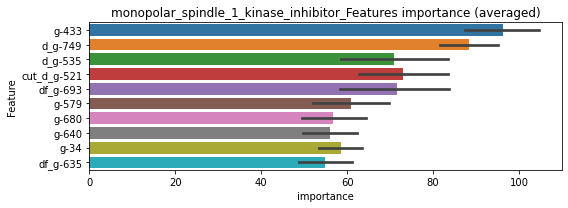

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106994	valid_1's binary_logloss: 0.0175401
[200]	training's binary_logloss: 0.00111878	valid_1's binary_logloss: 0.00684539
[300]	training's binary_logloss: 0.000311991	valid_1's binary_logloss: 0.00610962
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00030694	valid_1's binary_logloss: 0.00610084


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111111	valid_1's binary_logloss: 0.0168224
[200]	training's binary_logloss: 0.00121481	valid_1's binary_logloss: 0.00355361
[300]	training's binary_logloss: 0.000335422	valid_1's binary_logloss: 0.00197905
[400]	training's binary_logloss: 0.000181095	valid_1's binary_logloss: 0.0016488
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000159659	valid_1's binary_logloss: 0.00159926


monopolar_spindle_1_kinase_inhibitor logloss: 0.0038503421303674678


neg labels: 3289 → selected neg labels: 3267


mtor_inhibitor, len(trt): 130, len(othr): 3267, target_rate: 0.0054590 → Adj_target_rate: 0.0052608
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306701	valid_1's binary_logloss: 0.0837752
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00815892	valid_1's binary_logloss: 0.0692329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344373	valid_1's binary_logloss: 0.0800302
[200]	training's binary_logloss: 0.00527753	valid_1's binary_logloss: 0.0529858
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00362245	valid_1's binary_logloss: 0.0512383


1 / 3 AUC score:0.996
y_Threshold: 0.0123182, Threshold: 0.1012312, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 145 → Positive_corect_labels: 646/3775
p_label_rate: 0.0200904 Vs.target_rate: 0.00546
Num_p_label: 80.0, conf_0:0.09111, conf_1:0.11135
Num_p_label: 80.0, Expected: 21.7, Adj_threshold_1: 0.1012312
Num_p_label: 75.0, Expected: 21.7, Adj_threshold_2: 0.1112312
Num_p_label: 72.0, Expected: 21.7, Adj_threshold_3: 0.1212312
Num_p_label: 68.0, Expected: 21.7, Adj_threshold_4: 0.1312312
Num_p_label: 68.0, Expected: 21.7, Adj_threshold_5: 0.1412312
Num_p_label: 65.0, Expected: 21.7, Adj_threshold_6: 0.1512312
Num_p_label: 63.0, Expected: 21.7, Adj_threshold_7: 0.1612312
Num_p_label: 62.0, Expected: 21.7, Adj_threshold_8: 0.1712312
Num_p_label: 60.0, Expected: 21.7, Adj_threshold_9: 0.1812312
Num_p_label: 60.0, Expected: 21.7, Adj_threshold_10: 0.1912312
threshold: 0.2012312, positive_p_label: 60.0/3982, p_label_rate: 0.0150678
positive_y_label: 646.0/3775, y_label_rate: 0.1711258

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301601	valid_1's binary_logloss: 0.0578801
[200]	training's binary_logloss: 0.00419389	valid_1's binary_logloss: 0.0375913
[300]	training's binary_logloss: 0.00122461	valid_1's binary_logloss: 0.0343489
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00132915	valid_1's binary_logloss: 0.0342422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280698	valid_1's binary_logloss: 0.0919599
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00581027	valid_1's binary_logloss: 0.0777833


2 / 3 AUC score:0.996
y_Threshold: 0.0271914, Threshold: 0.2012312, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 624.0/3731
p_label_rate: 0.0396786 Vs.target_rate: 0.00546
Num_p_label: 158.0, conf_0:0.18111, conf_1:0.22135
Num_p_label: 158.0, Expected: 21.7, Adj_threshold_1: 0.2012312
Num_p_label: 157.0, Expected: 21.7, Adj_threshold_2: 0.2112312
Num_p_label: 157.0, Expected: 21.7, Adj_threshold_3: 0.2212312
Num_p_label: 153.0, Expected: 21.7, Adj_threshold_4: 0.2312312
Num_p_label: 152.0, Expected: 21.7, Adj_threshold_5: 0.2412312
Num_p_label: 151.0, Expected: 21.7, Adj_threshold_6: 0.2512312
Num_p_label: 151.0, Expected: 21.7, Adj_threshold_7: 0.2612312
Num_p_label: 151.0, Expected: 21.7, Adj_threshold_8: 0.2712312
Num_p_label: 151.0, Expected: 21.7, Adj_threshold_9: 0.2812312
Num_p_label: 149.0, Expected: 21.7, Adj_threshold_10: 0.2912312
threshold: 0.3012312, positive_p_label: 146.0/3982, p_label_rate: 0.0366650
positive_y_label: 624.0/3731, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269865	valid_1's binary_logloss: 0.0535053
[200]	training's binary_logloss: 0.00347268	valid_1's binary_logloss: 0.03051
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00218892	valid_1's binary_logloss: 0.0286765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272489	valid_1's binary_logloss: 0.0564002
[200]	training's binary_logloss: 0.00355392	valid_1's binary_logloss: 0.0331873
[300]	training's binary_logloss: 0.000983988	valid_1's binary_logloss: 0.0293763
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000949533	valid_1's binary_logloss: 0.0292561


3 / 3 AUC score:0.998
y_Threshold: 0.0233176, Threshold: 0.3012312, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 615.0/3713
p_label_rate: 0.0359116 Vs.target_rate: 0.00546
Num_p_label: 143.0, conf_0:0.27111, conf_1:0.33135
Num_p_label: 143.0, Expected: 21.7, Adj_threshold_1: 0.3012312
Num_p_label: 142.0, Expected: 21.7, Adj_threshold_2: 0.3112312
Num_p_label: 142.0, Expected: 21.7, Adj_threshold_3: 0.3212312
Num_p_label: 141.0, Expected: 21.7, Adj_threshold_4: 0.3312312
Num_p_label: 140.0, Expected: 21.7, Adj_threshold_5: 0.3412312
Num_p_label: 136.0, Expected: 21.7, Adj_threshold_6: 0.3512312
Num_p_label: 135.0, Expected: 21.7, Adj_threshold_7: 0.3612312
Num_p_label: 131.0, Expected: 21.7, Adj_threshold_8: 0.3712312
Num_p_label: 130.0, Expected: 21.7, Adj_threshold_9: 0.3812312
Num_p_label: 129.0, Expected: 21.7, Adj_threshold_10: 0.3912312
threshold: 0.4012312, positive_p_label: 128.0/3982, p_label_rate: 0.0321447
positive_y_label: 743.0/7695, y_label_ra

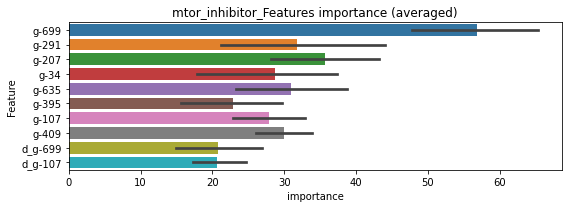

len(train_index) : 3847
len(valid_index) : 3848
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171731	valid_1's binary_logloss: 0.0372493
[200]	training's binary_logloss: 0.00234879	valid_1's binary_logloss: 0.0236159
[300]	training's binary_logloss: 0.000683727	valid_1's binary_logloss: 0.0211878
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000551161	valid_1's binary_logloss: 0.021038


len(train_index) : 3848
len(valid_index) : 3847
================================= fold 2/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169751	valid_1's binary_logloss: 0.0441072
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00475558	valid_1's binary_logloss: 0.038067


mtor_inhibitor logloss: 0.02955136651701275


neg labels: 3289 → selected neg labels: 3281


mucolytic_agent, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376291	valid_1's binary_logloss: 0.0718034
[200]	training's binary_logloss: 0.00614248	valid_1's binary_logloss: 0.0338605
[300]	training's binary_logloss: 0.00172438	valid_1's binary_logloss: 0.0269119
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000979292	valid_1's binary_logloss: 0.0253881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405516	valid_1's binary_logloss: 0.0664755
[200]	training's binary_logloss: 0.00677161	valid_1's binary_logloss: 0.021819
[300]	training's binary_logloss: 0.00195771	valid_1's binary_logloss: 0.0129396
[400]	training's binary_logloss: 0.00092806	valid_1's binary_logloss: 0.0103083
[500]	training's binary_logloss: 0.00060395	valid_1's binary_logloss: 0.00938951
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000522958	valid_1's binary_logloss: 0.00913576


1 / 3 AUC score:1.000
y_Threshold: 0.0045490, Threshold: 0.0067067, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.00604, conf_1:0.00738
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0067067
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_2: 0.0167067
threshold: 0.0167067, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395301	valid_1's binary_logloss: 0.0723552
[200]	training's binary_logloss: 0.00615926	valid_1's binary_logloss: 0.0327508
[300]	training's binary_logloss: 0.00173344	valid_1's binary_logloss: 0.0250966
[400]	training's binary_logloss: 0.000841077	valid_1's binary_logloss: 0.022669
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000652083	valid_1's binary_logloss: 0.0221735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395534	valid_1's binary_logloss: 0.0648193
[200]	training's binary_logloss: 0.00649878	valid_1's binary_logloss: 0.0219045
[300]	training's binary_logloss: 0.00188955	valid_1's binary_logloss: 0.0140704
[400]	training's binary_logloss: 0.000909784	valid_1's binary_logloss: 0.0112226
[500]	training's binary_logloss: 0.000584439	valid_1's binary_logloss: 0.0102622
Early stopping, best iteration is:
[540]	t

2 / 3 AUC score:1.000
y_Threshold: 0.0270190, Threshold: 0.0167067, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0085384 Vs.target_rate: 0.00202
Num_p_label: 34.0, conf_0:0.01504, conf_1:0.01838
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_1: 0.0167067
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_2: 0.0267067
threshold: 0.0267067, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384315	valid_1's binary_logloss: 0.0680109
[200]	training's binary_logloss: 0.00610624	valid_1's binary_logloss: 0.0281632
[300]	training's binary_logloss: 0.00176085	valid_1's binary_logloss: 0.021152
[400]	training's binary_logloss: 0.000852104	valid_1's binary_logloss: 0.0189175
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.000841338	valid_1's binary_logloss: 0.0189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395506	valid_1's binary_logloss: 0.0613488
[200]	training's binary_logloss: 0.00635885	valid_1's binary_logloss: 0.0201384
[300]	training's binary_logloss: 0.00182205	valid_1's binary_logloss: 0.0123395
[400]	training's binary_logloss: 0.00087482	valid_1's binary_logloss: 0.00993996
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000851302	valid_1's binary_logloss: 0.00987883


3 / 3 AUC score:1.000
y_Threshold: 0.0236973, Threshold: 0.0267067, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3799
p_label_rate: 0.0065294 Vs.target_rate: 0.00202
Num_p_label: 26.0, conf_0:0.02404, conf_1:0.02938
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_1: 0.0267067
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_2: 0.0367067
threshold: 0.0367067, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 667.0/7781, y_label_rate: 0.0857216


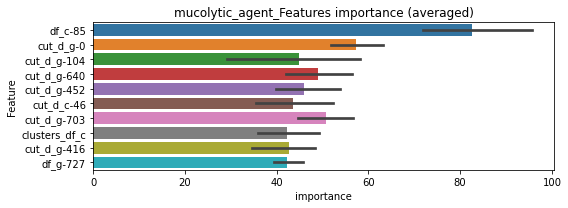

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214209	valid_1's binary_logloss: 0.0463452
[200]	training's binary_logloss: 0.00334944	valid_1's binary_logloss: 0.0240441
[300]	training's binary_logloss: 0.000955407	valid_1's binary_logloss: 0.0207368
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000673785	valid_1's binary_logloss: 0.0199339


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218072	valid_1's binary_logloss: 0.0410031
[200]	training's binary_logloss: 0.00363924	valid_1's binary_logloss: 0.0210022
[300]	training's binary_logloss: 0.00102855	valid_1's binary_logloss: 0.0175591
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00096153	valid_1's binary_logloss: 0.0174127


mucolytic_agent logloss: 0.018673502851093905


neg labels: 3289 → selected neg labels: 3283


neuropeptide_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031454	valid_1's binary_logloss: 0.0564632
[200]	training's binary_logloss: 0.00465506	valid_1's binary_logloss: 0.0213965
[300]	training's binary_logloss: 0.00132211	valid_1's binary_logloss: 0.0148644
[400]	training's binary_logloss: 0.000665605	valid_1's binary_logloss: 0.0131132
[500]	training's binary_logloss: 0.000450392	valid_1's binary_logloss: 0.0122703
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.0004436	valid_1's binary_logloss: 0.0122442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339474	valid_1's binary_logloss: 0.0538347
[200]	training's binary_logloss: 0.00511023	valid_1's binary_logloss: 0.0148659
[300]	training's binary_logloss: 0.00143905	valid_1's binary_logloss: 0.00799617
[400]	training's binary_logloss: 0.000703124	valid_1's binary_logloss: 0.00636957
Early stopping, best iteration is:
[489]	t

1 / 3 AUC score:1.000
y_Threshold: 0.0026270, Threshold: 0.0045741, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00412, conf_1:0.00503
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0045741
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_2: 0.0145741
Num_p_label: 6.0, Expected: 6.2, Adj_threshold_3: 0.0245741
threshold: 0.0245741, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327116	valid_1's binary_logloss: 0.056883
[200]	training's binary_logloss: 0.00468338	valid_1's binary_logloss: 0.0214125
[300]	training's binary_logloss: 0.00133265	valid_1's binary_logloss: 0.0153805
[400]	training's binary_logloss: 0.00066196	valid_1's binary_logloss: 0.0136472
[500]	training's binary_logloss: 0.000449803	valid_1's binary_logloss: 0.0126724
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000439652	valid_1's binary_logloss: 0.0125949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337345	valid_1's binary_logloss: 0.0499591
[200]	training's binary_logloss: 0.00491235	valid_1's binary_logloss: 0.01304
[300]	training's binary_logloss: 0.0014011	valid_1's binary_logloss: 0.00712316
[400]	training's binary_logloss: 0.000697086	valid_1's binary_logloss: 0.00582557
Early stopping, best iteration is:
[471]	tra

2 / 3 AUC score:1.000
y_Threshold: 0.0177149, Threshold: 0.0245741, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0037670 Vs.target_rate: 0.00155
Num_p_label: 15.0, conf_0:0.02212, conf_1:0.02703
threshold: 0.0245741, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316596	valid_1's binary_logloss: 0.0538013
[200]	training's binary_logloss: 0.0046268	valid_1's binary_logloss: 0.0199019
[300]	training's binary_logloss: 0.00131313	valid_1's binary_logloss: 0.0132769
[400]	training's binary_logloss: 0.000654067	valid_1's binary_logloss: 0.0113864
[500]	training's binary_logloss: 0.000451499	valid_1's binary_logloss: 0.0104926
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000463407	valid_1's binary_logloss: 0.0104803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342822	valid_1's binary_logloss: 0.0492281
[200]	training's binary_logloss: 0.00497334	valid_1's binary_logloss: 0.0136806
[300]	training's binary_logloss: 0.00140437	valid_1's binary_logloss: 0.00772064
[400]	training's binary_logloss: 0.000697928	valid_1's binary_logloss: 0.00629595
Early stopping, best iteration is:
[489]

3 / 3 AUC score:1.000
y_Threshold: 0.0286922, Threshold: 0.0245741, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0037670 Vs.target_rate: 0.00155
Num_p_label: 15.0, conf_0:0.02212, conf_1:0.02703
threshold: 0.0245741, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 670.0/7787, y_label_rate: 0.0860408


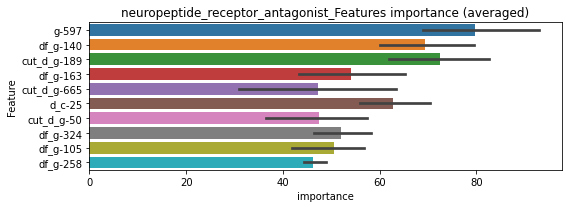

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178015	valid_1's binary_logloss: 0.0424281
[200]	training's binary_logloss: 0.0026466	valid_1's binary_logloss: 0.0263546
[300]	training's binary_logloss: 0.0007267	valid_1's binary_logloss: 0.0244246
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000600476	valid_1's binary_logloss: 0.0242354


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195296	valid_1's binary_logloss: 0.0347661
[200]	training's binary_logloss: 0.00301515	valid_1's binary_logloss: 0.0158675
[300]	training's binary_logloss: 0.000832676	valid_1's binary_logloss: 0.0122015
[400]	training's binary_logloss: 0.000391638	valid_1's binary_logloss: 0.0111073
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000397535	valid_1's binary_logloss: 0.0110826


neuropeptide_receptor_antagonist logloss: 0.01765983918687566


neg labels: 3289 → selected neg labels: 3270


nfkb_inhibitor, len(trt): 832, len(othr): 3270, target_rate: 0.0349374 → Adj_target_rate: 0.0254860
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515819	valid_1's binary_logloss: 0.119915
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.03273	valid_1's binary_logloss: 0.116306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427359	valid_1's binary_logloss: 0.150312
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.0409372	valid_1's binary_logloss: 0.150276


1 / 3 AUC score:0.939
y_Threshold: 0.0333543, Threshold: 0.9640142, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 402 → Positive_corect_labels: 737/3700
p_label_rate: 0.0200904 Vs.target_rate: 0.03494
Num_p_label: 80.0, conf_0:0.86761, conf_1:1.06042
threshold: 0.9640142, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 737.0/3700, y_label_rate: 0.1991892
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212717	valid_1's binary_logloss: 0.0307011
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00303163	valid_1's binary_logloss: 0.0195739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019479	valid_1's binary_logloss: 0.0308029
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00309367	valid_1's binary_logloss: 0.0200591


2 / 3 AUC score:0.996
y_Threshold: 0.0600570, Threshold: 0.9640142, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 20 → Positive_corect_labels: 727.0/3680
p_label_rate: 0.0381718 Vs.target_rate: 0.03494
Num_p_label: 152.0, conf_0:0.86761, conf_1:1.06042
threshold: 0.9640142, positive_p_label: 152.0/3982, p_label_rate: 0.0381718
positive_y_label: 727.0/3680, y_label_rate: 0.1975543
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162904	valid_1's binary_logloss: 0.0171233
[200]	training's binary_logloss: 0.00106561	valid_1's binary_logloss: 0.0013891
[300]	training's binary_logloss: 0.000235303	valid_1's binary_logloss: 0.000398662
[400]	training's binary_logloss: 0.000154666	valid_1's binary_logloss: 0.00029932
[500]	training's binary_logloss: 0.000140454	valid_1's binary_logloss: 0.000277791
[600]	training's binary_logloss: 0.000136798	valid_1's binary_logloss: 0.000272335
Early stopping, best iteration is:
[648]	training's binary_logloss: 0.000136298	valid_1's binary_logloss: 0.000271433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161092	valid_1's binary_logloss: 0.018606
[200]	training's binary_logloss: 0.0010359	valid_1's binary_logloss: 0.00404159
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.000760617	valid_1's binary_logloss: 0.0037

3 / 3 AUC score:1.000
y_Threshold: 0.0786995, Threshold: 0.9640142, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 2 → Positive_corect_labels: 726.0/3678
p_label_rate: 0.0396786 Vs.target_rate: 0.03494
Num_p_label: 158.0, conf_0:0.86761, conf_1:1.06042
threshold: 0.9640142, positive_p_label: 158.0/3982, p_label_rate: 0.0396786
positive_y_label: 884.0/7660, y_label_rate: 0.1154047


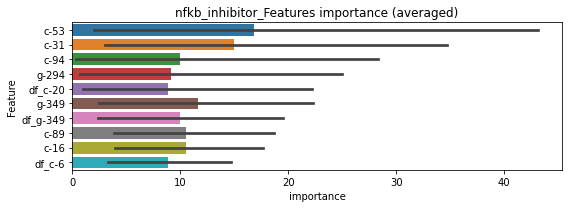

len(train_index) : 3830
len(valid_index) : 3830
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112739	valid_1's binary_logloss: 0.0120672
[200]	training's binary_logloss: 0.00082312	valid_1's binary_logloss: 0.00157068
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.000239063	valid_1's binary_logloss: 0.0011521


len(train_index) : 3830
len(valid_index) : 3830
================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110128	valid_1's binary_logloss: 0.0120198
[200]	training's binary_logloss: 0.000768943	valid_1's binary_logloss: 0.00256502
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.000266506	valid_1's binary_logloss: 0.00224718


nfkb_inhibitor logloss: 0.0016996368513939426


neg labels: 3289 → selected neg labels: 3287


nicotinic_receptor_agonist, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185353	valid_1's binary_logloss: 0.0239783
[200]	training's binary_logloss: 0.00183325	valid_1's binary_logloss: 0.00425946
[300]	training's binary_logloss: 0.000509273	valid_1's binary_logloss: 0.0021309
[400]	training's binary_logloss: 0.000288797	valid_1's binary_logloss: 0.0017191
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000257648	valid_1's binary_logloss: 0.00165066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018572	valid_1's binary_logloss: 0.0223611
[200]	training's binary_logloss: 0.00184697	valid_1's binary_logloss: 0.00370454
[300]	training's binary_logloss: 0.000516924	valid_1's binary_logloss: 0.0016566
[400]	training's binary_logloss: 0.000292476	valid_1's binary_logloss: 0.00131688
[500]	training's binary_logloss: 0.000252172	valid_1's binary_logloss: 0.00123454
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0007918, Threshold: 0.0015672, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00141, conf_1:0.00172
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0015672
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_2: 0.0115672
threshold: 0.0115672, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187201	valid_1's binary_logloss: 0.0230243
[200]	training's binary_logloss: 0.00180784	valid_1's binary_logloss: 0.00408535
[300]	training's binary_logloss: 0.000501262	valid_1's binary_logloss: 0.00220927
[400]	training's binary_logloss: 0.000285895	valid_1's binary_logloss: 0.00187446
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000256204	valid_1's binary_logloss: 0.00180643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187748	valid_1's binary_logloss: 0.0217049
[200]	training's binary_logloss: 0.00182272	valid_1's binary_logloss: 0.00284614
[300]	training's binary_logloss: 0.000502306	valid_1's binary_logloss: 0.00103544
[400]	training's binary_logloss: 0.00028449	valid_1's binary_logloss: 0.000701708
[500]	training's binary_logloss: 0.000250087	valid_1's binary_logloss: 0.000652313
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.0440401, Threshold: 0.0115672, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0062783 Vs.target_rate: 0.00050
Num_p_label: 25.0, conf_0:0.01041, conf_1:0.01272
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_1: 0.0115672
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.0215672
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.0315672
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.0415672
threshold: 0.0415672, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187201	valid_1's binary_logloss: 0.0230243
[200]	training's binary_logloss: 0.00180784	valid_1's binary_logloss: 0.00408535
[300]	training's binary_logloss: 0.000501262	valid_1's binary_logloss: 0.00220927
[400]	training's binary_logloss: 0.000285895	valid_1's binary_logloss: 0.00187446
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000256204	valid_1's binary_logloss: 0.00180643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187748	valid_1's binary_logloss: 0.0217049
[200]	training's binary_logloss: 0.00182272	valid_1's binary_logloss: 0.00284614
[300]	training's binary_logloss: 0.000502306	valid_1's binary_logloss: 0.00103544
[400]	training's binary_logloss: 0.00028449	valid_1's binary_logloss: 0.000701708
[500]	training's binary_logloss: 0.000250087	valid_1's binary_logloss: 0.000652313
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.0440401, Threshold: 0.0415672, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050
Num_p_label: 4.0, conf_0:0.03741, conf_1:0.04572
threshold: 0.0415672, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


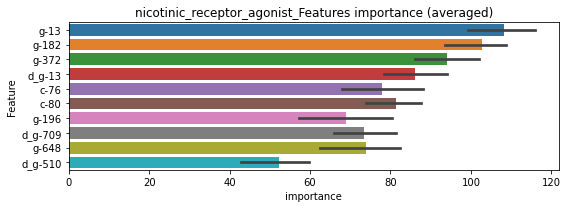

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00985166	valid_1's binary_logloss: 0.0143812
[200]	training's binary_logloss: 0.000954867	valid_1's binary_logloss: 0.0039868
[300]	training's binary_logloss: 0.000256817	valid_1's binary_logloss: 0.00335287
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000254685	valid_1's binary_logloss: 0.00335068


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00997933	valid_1's binary_logloss: 0.0168115
[200]	training's binary_logloss: 0.00101912	valid_1's binary_logloss: 0.00754884
[300]	training's binary_logloss: 0.000266353	valid_1's binary_logloss: 0.00565704
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000181039	valid_1's binary_logloss: 0.00542417


nicotinic_receptor_agonist logloss: 0.0043874227147159125


neg labels: 3289 → selected neg labels: 3285


nitric_oxide_donor, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282919	valid_1's binary_logloss: 0.0426657
[200]	training's binary_logloss: 0.00370056	valid_1's binary_logloss: 0.0102223
[300]	training's binary_logloss: 0.00102585	valid_1's binary_logloss: 0.00487198
[400]	training's binary_logloss: 0.000520085	valid_1's binary_logloss: 0.00355663
[500]	training's binary_logloss: 0.000375247	valid_1's binary_logloss: 0.00310865
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000375956	valid_1's binary_logloss: 0.00310736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280243	valid_1's binary_logloss: 0.0394507
[200]	training's binary_logloss: 0.00362038	valid_1's binary_logloss: 0.0101282
[300]	training's binary_logloss: 0.00101431	valid_1's binary_logloss: 0.00576124
[400]	training's binary_logloss: 0.000515231	valid_1's binary_logloss: 0.00460352
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0020634, Threshold: 0.0034941, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00109
Num_p_label: 80.0, conf_0:0.00314, conf_1:0.00384
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0034941
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_2: 0.0134941
threshold: 0.0134941, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285987	valid_1's binary_logloss: 0.0438506
[200]	training's binary_logloss: 0.00367121	valid_1's binary_logloss: 0.0111688
[300]	training's binary_logloss: 0.00101711	valid_1's binary_logloss: 0.00539243
[400]	training's binary_logloss: 0.000518908	valid_1's binary_logloss: 0.0038939
[500]	training's binary_logloss: 0.000378628	valid_1's binary_logloss: 0.00350218
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000379873	valid_1's binary_logloss: 0.00349352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271357	valid_1's binary_logloss: 0.0391442
[200]	training's binary_logloss: 0.00345648	valid_1's binary_logloss: 0.00981058
[300]	training's binary_logloss: 0.000981037	valid_1's binary_logloss: 0.00529292
[400]	training's binary_logloss: 0.000501509	valid_1's binary_logloss: 0.00418402
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.0298315, Threshold: 0.0134941, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0072828 Vs.target_rate: 0.00109
Num_p_label: 29.0, conf_0:0.01214, conf_1:0.01484
Num_p_label: 29.0, Expected: 4.3, Adj_threshold_1: 0.0134941
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_2: 0.0234941
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_3: 0.0334941
threshold: 0.0334941, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285987	valid_1's binary_logloss: 0.0438506
[200]	training's binary_logloss: 0.00367121	valid_1's binary_logloss: 0.0111688
[300]	training's binary_logloss: 0.00101711	valid_1's binary_logloss: 0.00539243
[400]	training's binary_logloss: 0.000518908	valid_1's binary_logloss: 0.0038939
[500]	training's binary_logloss: 0.000378628	valid_1's binary_logloss: 0.00350218
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000379873	valid_1's binary_logloss: 0.00349352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271357	valid_1's binary_logloss: 0.0391442
[200]	training's binary_logloss: 0.00345648	valid_1's binary_logloss: 0.00981058
[300]	training's binary_logloss: 0.000981037	valid_1's binary_logloss: 0.00529292
[400]	training's binary_logloss: 0.000501509	valid_1's binary_logloss: 0.00418402
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.0298315, Threshold: 0.0334941, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00109
Num_p_label: 7.0, conf_0:0.03014, conf_1:0.03684
threshold: 0.0334941, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


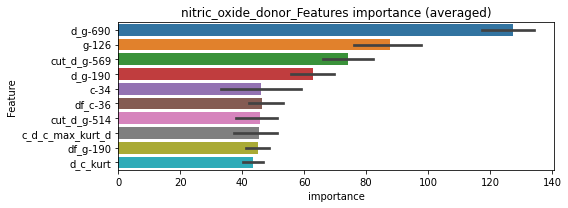

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151598	valid_1's binary_logloss: 0.0295887
[200]	training's binary_logloss: 0.00196165	valid_1's binary_logloss: 0.0122869
[300]	training's binary_logloss: 0.000533116	valid_1's binary_logloss: 0.00956921
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000503233	valid_1's binary_logloss: 0.00949176


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153692	valid_1's binary_logloss: 0.0240301
[200]	training's binary_logloss: 0.00199901	valid_1's binary_logloss: 0.00711457
[300]	training's binary_logloss: 0.000558534	valid_1's binary_logloss: 0.00481156
[400]	training's binary_logloss: 0.000275332	valid_1's binary_logloss: 0.00432748
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000256226	valid_1's binary_logloss: 0.00430174


nitric_oxide_donor logloss: 0.006896749411038573


neg labels: 3289 → selected neg labels: 3284


nitric_oxide_production_inhibitor, len(trt): 29, len(othr): 3284, target_rate: 0.0012178 → Adj_target_rate: 0.0014697
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288261	valid_1's binary_logloss: 0.0470539
[200]	training's binary_logloss: 0.00396885	valid_1's binary_logloss: 0.0157426
[300]	training's binary_logloss: 0.00115696	valid_1's binary_logloss: 0.0100844
[400]	training's binary_logloss: 0.000588002	valid_1's binary_logloss: 0.00845253
[500]	training's binary_logloss: 0.000416941	valid_1's binary_logloss: 0.00799923
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000418497	valid_1's binary_logloss: 0.00799462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308349	valid_1's binary_logloss: 0.0456624
[200]	training's binary_logloss: 0.00441091	valid_1's binary_logloss: 0.0113227
[300]	training's binary_logloss: 0.00125239	valid_1's binary_logloss: 0.00579102
[400]	training's binary_logloss: 0.000615945	valid_1's binary_logloss: 0.00457011
Early stopping, best iteration is:
[

1 / 3 AUC score:1.000
y_Threshold: 0.0020352, Threshold: 0.1705543, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00122
Num_p_label: 80.0, conf_0:0.15350, conf_1:0.18761
Num_p_label: 80.0, Expected: 4.8, Adj_threshold_1: 0.1705543
Num_p_label: 79.0, Expected: 4.8, Adj_threshold_2: 0.1805543
Num_p_label: 75.0, Expected: 4.8, Adj_threshold_3: 0.1905543
Num_p_label: 72.0, Expected: 4.8, Adj_threshold_4: 0.2005543
Num_p_label: 70.0, Expected: 4.8, Adj_threshold_5: 0.2105543
Num_p_label: 68.0, Expected: 4.8, Adj_threshold_6: 0.2205543
Num_p_label: 67.0, Expected: 4.8, Adj_threshold_7: 0.2305543
Num_p_label: 66.0, Expected: 4.8, Adj_threshold_8: 0.2405543
Num_p_label: 65.0, Expected: 4.8, Adj_threshold_9: 0.2505543
Num_p_label: 62.0, Expected: 4.8, Adj_threshold_10: 0.2605543
threshold: 0.2705543, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291922	valid_1's binary_logloss: 0.0442631
[200]	training's binary_logloss: 0.00392373	valid_1's binary_logloss: 0.0132325
[300]	training's binary_logloss: 0.00112481	valid_1's binary_logloss: 0.00842184
[400]	training's binary_logloss: 0.000567047	valid_1's binary_logloss: 0.00706475
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000446416	valid_1's binary_logloss: 0.0068469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302305	valid_1's binary_logloss: 0.0440743
[200]	training's binary_logloss: 0.004114	valid_1's binary_logloss: 0.0108464
[300]	training's binary_logloss: 0.00115742	valid_1's binary_logloss: 0.00570681
[400]	training's binary_logloss: 0.000580689	valid_1's binary_logloss: 0.00457802
[500]	training's binary_logloss: 0.000421484	valid_1's binary_logloss: 0.00430439
Early stopping, best iteration is:
[49

2 / 3 AUC score:1.000
y_Threshold: 0.0355102, Threshold: 0.2705543, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0266198 Vs.target_rate: 0.00122
Num_p_label: 106.0, conf_0:0.24350, conf_1:0.29761
Num_p_label: 106.0, Expected: 4.8, Adj_threshold_1: 0.2705543
Num_p_label: 104.0, Expected: 4.8, Adj_threshold_2: 0.2805543
Num_p_label: 102.0, Expected: 4.8, Adj_threshold_3: 0.2905543
Num_p_label: 102.0, Expected: 4.8, Adj_threshold_4: 0.3005543
Num_p_label: 102.0, Expected: 4.8, Adj_threshold_5: 0.3105543
Num_p_label: 102.0, Expected: 4.8, Adj_threshold_6: 0.3205543
Num_p_label: 102.0, Expected: 4.8, Adj_threshold_7: 0.3305543
Num_p_label: 102.0, Expected: 4.8, Adj_threshold_8: 0.3405543
Num_p_label: 100.0, Expected: 4.8, Adj_threshold_9: 0.3505543
Num_p_label: 99.0, Expected: 4.8, Adj_threshold_10: 0.3605543
threshold: 0.3705543, positive_p_label: 98.0/3982, p_label_rate: 0.0246107
positive_y_label: 655.0/3806, y_label_rate: 0.1720967

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282379	valid_1's binary_logloss: 0.0406738
[200]	training's binary_logloss: 0.00382002	valid_1's binary_logloss: 0.0100994
[300]	training's binary_logloss: 0.00110808	valid_1's binary_logloss: 0.00530541
[400]	training's binary_logloss: 0.000558954	valid_1's binary_logloss: 0.00383886
[500]	training's binary_logloss: 0.000407238	valid_1's binary_logloss: 0.00346166
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000410563	valid_1's binary_logloss: 0.00345941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293768	valid_1's binary_logloss: 0.0465567
[200]	training's binary_logloss: 0.00398139	valid_1's binary_logloss: 0.0142345
[300]	training's binary_logloss: 0.00112323	valid_1's binary_logloss: 0.00855807
[400]	training's binary_logloss: 0.000570463	valid_1's binary_logloss: 0.00743331
Early stopping, best iteration is:


3 / 3 AUC score:1.000
y_Threshold: 0.0606543, Threshold: 0.3705543, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0248619 Vs.target_rate: 0.00122
Num_p_label: 99.0, conf_0:0.33350, conf_1:0.40761
Num_p_label: 99.0, Expected: 4.8, Adj_threshold_1: 0.3705543
Num_p_label: 99.0, Expected: 4.8, Adj_threshold_2: 0.3805543
Num_p_label: 98.0, Expected: 4.8, Adj_threshold_3: 0.3905543
Num_p_label: 96.0, Expected: 4.8, Adj_threshold_4: 0.4005543
Num_p_label: 96.0, Expected: 4.8, Adj_threshold_5: 0.4105543
Num_p_label: 95.0, Expected: 4.8, Adj_threshold_6: 0.4205543
Num_p_label: 94.0, Expected: 4.8, Adj_threshold_7: 0.4305543
Num_p_label: 93.0, Expected: 4.8, Adj_threshold_8: 0.4405543
Num_p_label: 93.0, Expected: 4.8, Adj_threshold_9: 0.4505543
Num_p_label: 92.0, Expected: 4.8, Adj_threshold_10: 0.4605543
threshold: 0.4705543, positive_p_label: 91.0/3982, p_label_rate: 0.0228528
positive_y_label: 746.0/7788, y_label_rate: 0.0957884


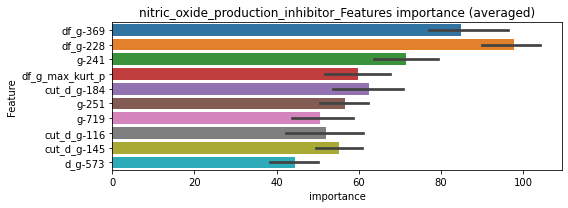

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184688	valid_1's binary_logloss: 0.0333523
[200]	training's binary_logloss: 0.00248589	valid_1's binary_logloss: 0.0147568
[300]	training's binary_logloss: 0.000684142	valid_1's binary_logloss: 0.0118679
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000488823	valid_1's binary_logloss: 0.0114204


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189118	valid_1's binary_logloss: 0.0324948
[200]	training's binary_logloss: 0.00261757	valid_1's binary_logloss: 0.0148796
[300]	training's binary_logloss: 0.000718243	valid_1's binary_logloss: 0.0121839
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000380484	valid_1's binary_logloss: 0.0116306


nitric_oxide_production_inhibitor logloss: 0.01152549644274659


neg labels: 3289 → selected neg labels: 3284


nitric_oxide_synthase_inhibitor, len(trt): 26, len(othr): 3284, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273723	valid_1's binary_logloss: 0.0437646
[200]	training's binary_logloss: 0.00355855	valid_1's binary_logloss: 0.0129357
[300]	training's binary_logloss: 0.00100585	valid_1's binary_logloss: 0.00781556
[400]	training's binary_logloss: 0.000514733	valid_1's binary_logloss: 0.006737
[500]	training's binary_logloss: 0.000372218	valid_1's binary_logloss: 0.00629133
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000374761	valid_1's binary_logloss: 0.00628005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275972	valid_1's binary_logloss: 0.0407749
[200]	training's binary_logloss: 0.00370255	valid_1's binary_logloss: 0.0130796
[300]	training's binary_logloss: 0.00102403	valid_1's binary_logloss: 0.00917145
[400]	training's binary_logloss: 0.000518399	valid_1's binary_logloss: 0.00818588
Early stopping, best iteration is:
[4

1 / 3 AUC score:1.000
y_Threshold: 0.0019581, Threshold: 0.0027112, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00109
Num_p_label: 80.0, conf_0:0.00244, conf_1:0.00298
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0027112
Num_p_label: 3.0, Expected: 4.3, Adj_threshold_2: 0.0127112
threshold: 0.0127112, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267763	valid_1's binary_logloss: 0.0454997
[200]	training's binary_logloss: 0.00347963	valid_1's binary_logloss: 0.0139249
[300]	training's binary_logloss: 0.000976745	valid_1's binary_logloss: 0.00870627
[400]	training's binary_logloss: 0.000497556	valid_1's binary_logloss: 0.00723675
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000394006	valid_1's binary_logloss: 0.006956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278569	valid_1's binary_logloss: 0.0411351
[200]	training's binary_logloss: 0.00354548	valid_1's binary_logloss: 0.0125345
[300]	training's binary_logloss: 0.0010103	valid_1's binary_logloss: 0.00915698
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000567494	valid_1's binary_logloss: 0.00820893


2 / 3 AUC score:1.000
y_Threshold: 0.0121004, Threshold: 0.0127112, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0035158 Vs.target_rate: 0.00109
Num_p_label: 14.0, conf_0:0.01144, conf_1:0.01398
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_1: 0.0127112
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_2: 0.0227112
threshold: 0.0227112, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267763	valid_1's binary_logloss: 0.0454997
[200]	training's binary_logloss: 0.00347963	valid_1's binary_logloss: 0.0139249
[300]	training's binary_logloss: 0.000976745	valid_1's binary_logloss: 0.00870627
[400]	training's binary_logloss: 0.000497556	valid_1's binary_logloss: 0.00723675
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000394006	valid_1's binary_logloss: 0.006956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278569	valid_1's binary_logloss: 0.0411351
[200]	training's binary_logloss: 0.00354548	valid_1's binary_logloss: 0.0125345
[300]	training's binary_logloss: 0.0010103	valid_1's binary_logloss: 0.00915698
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000567494	valid_1's binary_logloss: 0.00820893


3 / 3 AUC score:1.000
y_Threshold: 0.0121004, Threshold: 0.0227112, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0015068 Vs.target_rate: 0.00109
Num_p_label: 6.0, conf_0:0.02044, conf_1:0.02498
threshold: 0.0227112, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 662.0/7790, y_label_rate: 0.0849807


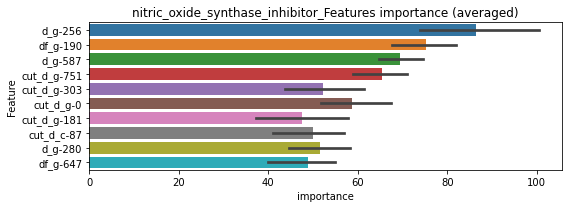

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146967	valid_1's binary_logloss: 0.0259233
[200]	training's binary_logloss: 0.00187325	valid_1's binary_logloss: 0.0108442
[300]	training's binary_logloss: 0.000517377	valid_1's binary_logloss: 0.00950666
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000568006	valid_1's binary_logloss: 0.00947369


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151377	valid_1's binary_logloss: 0.0243031
[200]	training's binary_logloss: 0.0019825	valid_1's binary_logloss: 0.00753972
[300]	training's binary_logloss: 0.000557294	valid_1's binary_logloss: 0.00435132
[400]	training's binary_logloss: 0.000278115	valid_1's binary_logloss: 0.0035618
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000207429	valid_1's binary_logloss: 0.00325731


nitric_oxide_synthase_inhibitor logloss: 0.006365496923424794


neg labels: 3289 → selected neg labels: 3287


norepinephrine_reuptake_inhibitor, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164508	valid_1's binary_logloss: 0.0200581
[200]	training's binary_logloss: 0.00143388	valid_1's binary_logloss: 0.00419241
[300]	training's binary_logloss: 0.000379834	valid_1's binary_logloss: 0.00227491
[400]	training's binary_logloss: 0.000224868	valid_1's binary_logloss: 0.00186214
[500]	training's binary_logloss: 0.000199366	valid_1's binary_logloss: 0.00178297
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000199325	valid_1's binary_logloss: 0.00178291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167994	valid_1's binary_logloss: 0.0179093
[200]	training's binary_logloss: 0.00147378	valid_1's binary_logloss: 0.00180081
[300]	training's binary_logloss: 0.000389304	valid_1's binary_logloss: 0.000529108
[400]	training's binary_logloss: 0.000230555	valid_1's binary_logloss: 0.000336705
[500]	training's binary_loglo

1 / 3 AUC score:1.000
y_Threshold: 0.0005335, Threshold: 0.0009315, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029
Num_p_label: 80.0, conf_0:0.00084, conf_1:0.00102
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0009315
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_2: 0.0109315
threshold: 0.0109315, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167492	valid_1's binary_logloss: 0.0206448
[200]	training's binary_logloss: 0.00143968	valid_1's binary_logloss: 0.00421183
[300]	training's binary_logloss: 0.00037869	valid_1's binary_logloss: 0.00259749
[400]	training's binary_logloss: 0.000225357	valid_1's binary_logloss: 0.00219143
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000201217	valid_1's binary_logloss: 0.00213615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169976	valid_1's binary_logloss: 0.0184874
[200]	training's binary_logloss: 0.00147841	valid_1's binary_logloss: 0.00193733
[300]	training's binary_logloss: 0.00038482	valid_1's binary_logloss: 0.000613656
[400]	training's binary_logloss: 0.000229882	valid_1's binary_logloss: 0.000427776
[500]	training's binary_logloss: 0.000200963	valid_1's binary_logloss: 0.000387938
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.0601076, Threshold: 0.0109315, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0020090 Vs.target_rate: 0.00029
Num_p_label: 8.0, conf_0:0.00984, conf_1:0.01202
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_1: 0.0109315
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_2: 0.0209315
threshold: 0.0209315, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167492	valid_1's binary_logloss: 0.0206448
[200]	training's binary_logloss: 0.00143968	valid_1's binary_logloss: 0.00421183
[300]	training's binary_logloss: 0.00037869	valid_1's binary_logloss: 0.00259749
[400]	training's binary_logloss: 0.000225357	valid_1's binary_logloss: 0.00219143
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000201217	valid_1's binary_logloss: 0.00213615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169976	valid_1's binary_logloss: 0.0184874
[200]	training's binary_logloss: 0.00147841	valid_1's binary_logloss: 0.00193733
[300]	training's binary_logloss: 0.00038482	valid_1's binary_logloss: 0.000613656
[400]	training's binary_logloss: 0.000229882	valid_1's binary_logloss: 0.000427776
[500]	training's binary_logloss: 0.000200963	valid_1's binary_logloss: 0.000387938
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.0601076, Threshold: 0.0209315, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0002511 Vs.target_rate: 0.00029
Num_p_label: 1.0, conf_0:0.01884, conf_1:0.02302
threshold: 0.0209315, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7794, y_label_rate: 0.0844239


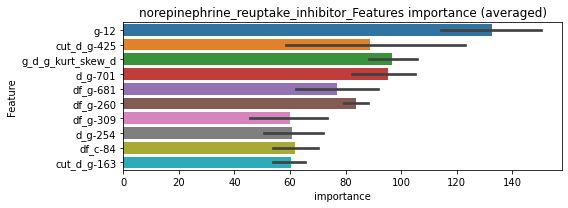

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0087671	valid_1's binary_logloss: 0.0104493
[200]	training's binary_logloss: 0.000734168	valid_1's binary_logloss: 0.00235025
[300]	training's binary_logloss: 0.000189576	valid_1's binary_logloss: 0.00184039
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000153026	valid_1's binary_logloss: 0.00180155


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00881762	valid_1's binary_logloss: 0.00995515
[200]	training's binary_logloss: 0.000752361	valid_1's binary_logloss: 0.00120457
[300]	training's binary_logloss: 0.000195609	valid_1's binary_logloss: 0.000416786
[400]	training's binary_logloss: 0.00011557	valid_1's binary_logloss: 0.000273711
[500]	training's binary_logloss: 0.000101767	valid_1's binary_logloss: 0.000251423
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000101421	valid_1's binary_logloss: 0.000250992


norepinephrine_reuptake_inhibitor logloss: 0.001026305363451014


neg labels: 3289 → selected neg labels: 3286


nrf2_activator, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200772	valid_1's binary_logloss: 0.0280882
[200]	training's binary_logloss: 0.00218953	valid_1's binary_logloss: 0.00771096
[300]	training's binary_logloss: 0.00061553	valid_1's binary_logloss: 0.00509366
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.000631203	valid_1's binary_logloss: 0.00507475
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203621	valid_1's binary_logloss: 0.0247415
[200]	training's binary_logloss: 0.00216509	valid_1's binary_logloss: 0.00478069
[300]	training's binary_logloss: 0.000612424	valid_1's binary_logloss: 0.00243912
[400]	training's binary_logloss: 0.000333669	valid_1's binary_logloss: 0.00183934
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000291238	valid_1's binary_logloss: 0.00168715


1 / 3 AUC score:1.000
y_Threshold: 0.0012334, Threshold: 0.1132323, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.10191, conf_1:0.12456
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.1132323
Num_p_label: 79.0, Expected: 3.0, Adj_threshold_2: 0.1232323
Num_p_label: 77.0, Expected: 3.0, Adj_threshold_3: 0.1332323
Num_p_label: 77.0, Expected: 3.0, Adj_threshold_4: 0.1432323
Num_p_label: 76.0, Expected: 3.0, Adj_threshold_5: 0.1532323
Num_p_label: 74.0, Expected: 3.0, Adj_threshold_6: 0.1632323
Num_p_label: 73.0, Expected: 3.0, Adj_threshold_7: 0.1732323
Num_p_label: 73.0, Expected: 3.0, Adj_threshold_8: 0.1832323
Num_p_label: 73.0, Expected: 3.0, Adj_threshold_9: 0.1932323
Num_p_label: 71.0, Expected: 3.0, Adj_threshold_10: 0.2032323
threshold: 0.2132323, positive_p_label: 70.0/3982, p_label_rate: 0.0175791
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197977	valid_1's binary_logloss: 0.0245864
[200]	training's binary_logloss: 0.00193852	valid_1's binary_logloss: 0.00408359
[300]	training's binary_logloss: 0.000525386	valid_1's binary_logloss: 0.00178086
[400]	training's binary_logloss: 0.000292704	valid_1's binary_logloss: 0.00127896
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00026851	valid_1's binary_logloss: 0.00123967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197431	valid_1's binary_logloss: 0.0227067
[200]	training's binary_logloss: 0.00196802	valid_1's binary_logloss: 0.00292041
[300]	training's binary_logloss: 0.000536213	valid_1's binary_logloss: 0.000971707
[400]	training's binary_logloss: 0.00030056	valid_1's binary_logloss: 0.0006131
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000263934	valid_1's binary_logloss: 0.0005574

2 / 3 AUC score:1.000
y_Threshold: 0.1248213, Threshold: 0.2132323, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0283777 Vs.target_rate: 0.00076
Num_p_label: 113.0, conf_0:0.19191, conf_1:0.23456
Num_p_label: 113.0, Expected: 3.0, Adj_threshold_1: 0.2132323
Num_p_label: 113.0, Expected: 3.0, Adj_threshold_2: 0.2232323
Num_p_label: 111.0, Expected: 3.0, Adj_threshold_3: 0.2332323
Num_p_label: 109.0, Expected: 3.0, Adj_threshold_4: 0.2432323
Num_p_label: 109.0, Expected: 3.0, Adj_threshold_5: 0.2532323
Num_p_label: 107.0, Expected: 3.0, Adj_threshold_6: 0.2632323
Num_p_label: 107.0, Expected: 3.0, Adj_threshold_7: 0.2732323
Num_p_label: 106.0, Expected: 3.0, Adj_threshold_8: 0.2832323
Num_p_label: 106.0, Expected: 3.0, Adj_threshold_9: 0.2932323
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_10: 0.3032323
threshold: 0.3132323, positive_p_label: 105.0/3982, p_label_rate: 0.0263687
positive_y_label: 657.0/3811, y_label_rate: 0.17239

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197977	valid_1's binary_logloss: 0.0245864
[200]	training's binary_logloss: 0.00193852	valid_1's binary_logloss: 0.00408359
[300]	training's binary_logloss: 0.000525386	valid_1's binary_logloss: 0.00178086
[400]	training's binary_logloss: 0.000292704	valid_1's binary_logloss: 0.00127896
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00026851	valid_1's binary_logloss: 0.00123967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197431	valid_1's binary_logloss: 0.0227067
[200]	training's binary_logloss: 0.00196802	valid_1's binary_logloss: 0.00292041
[300]	training's binary_logloss: 0.000536213	valid_1's binary_logloss: 0.000971707
[400]	training's binary_logloss: 0.00030056	valid_1's binary_logloss: 0.0006131
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000263934	valid_1's binary_logloss: 0.0005574

3 / 3 AUC score:1.000
y_Threshold: 0.1248213, Threshold: 0.3132323, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0263687 Vs.target_rate: 0.00076
Num_p_label: 105.0, conf_0:0.28191, conf_1:0.34456
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_1: 0.3132323
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_2: 0.3232323
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_3: 0.3332323
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_4: 0.3432323
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_5: 0.3532323
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_6: 0.3632323
Num_p_label: 104.0, Expected: 3.0, Adj_threshold_7: 0.3732323
Num_p_label: 103.0, Expected: 3.0, Adj_threshold_8: 0.3832323
Num_p_label: 100.0, Expected: 3.0, Adj_threshold_9: 0.3932323
Num_p_label: 100.0, Expected: 3.0, Adj_threshold_10: 0.4032323
threshold: 0.4132323, positive_p_label: 100.0/3982, p_label_rate: 0.0251130
positive_y_label: 757.0/7793, y_label_rate: 0.09713

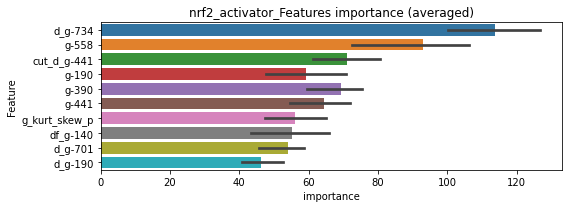

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121977	valid_1's binary_logloss: 0.0187699
[200]	training's binary_logloss: 0.00127883	valid_1's binary_logloss: 0.00633935
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.000460279	valid_1's binary_logloss: 0.0052199


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126876	valid_1's binary_logloss: 0.0166626
[200]	training's binary_logloss: 0.00135699	valid_1's binary_logloss: 0.00445105
[300]	training's binary_logloss: 0.000361877	valid_1's binary_logloss: 0.00288828
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000224044	valid_1's binary_logloss: 0.00266021


nrf2_activator logloss: 0.003940222579772863


neg labels: 3289 → selected neg labels: 3279


opioid_receptor_agonist, len(trt): 61, len(othr): 3279, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042681	valid_1's binary_logloss: 0.087082
[200]	training's binary_logloss: 0.00798369	valid_1's binary_logloss: 0.0483338
[300]	training's binary_logloss: 0.00233243	valid_1's binary_logloss: 0.0419306
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00205076	valid_1's binary_logloss: 0.0413692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445468	valid_1's binary_logloss: 0.0827353
[200]	training's binary_logloss: 0.00915022	valid_1's binary_logloss: 0.0406911
[300]	training's binary_logloss: 0.00261772	valid_1's binary_logloss: 0.0289095
[400]	training's binary_logloss: 0.00120594	valid_1's binary_logloss: 0.0255883
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000902492	valid_1's binary_logloss: 0.0243986


1 / 3 AUC score:0.998
y_Threshold: 0.0077277, Threshold: 0.0115967, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → Positive_corect_labels: 650/3792
p_label_rate: 0.0200904 Vs.target_rate: 0.00256
Num_p_label: 80.0, conf_0:0.01044, conf_1:0.01276
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0115967
Num_p_label: 30.0, Expected: 10.2, Adj_threshold_2: 0.0215967
Num_p_label: 10.0, Expected: 10.2, Adj_threshold_3: 0.0315967
threshold: 0.0315967, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 650.0/3792, y_label_rate: 0.1714135
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424635	valid_1's binary_logloss: 0.0822828
[200]	training's binary_logloss: 0.00782156	valid_1's binary_logloss: 0.0414061
[300]	training's binary_logloss: 0.00230278	valid_1's binary_logloss: 0.0321608
[400]	training's binary_logloss: 0.00108872	valid_1's binary_logloss: 0.0296131
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000833673	valid_1's binary_logloss: 0.0289254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430468	valid_1's binary_logloss: 0.0721813
[200]	training's binary_logloss: 0.00788459	valid_1's binary_logloss: 0.0288351
[300]	training's binary_logloss: 0.00230463	valid_1's binary_logloss: 0.0189105
[400]	training's binary_logloss: 0.00110598	valid_1's binary_logloss: 0.016185
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000929408	valid_1's binary_logloss: 0.0153945


2 / 3 AUC score:1.000
y_Threshold: 0.0238970, Threshold: 0.0315967, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 647.0/3786
p_label_rate: 0.0052737 Vs.target_rate: 0.00256
Num_p_label: 21.0, conf_0:0.02844, conf_1:0.03476
threshold: 0.0315967, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 647.0/3786, y_label_rate: 0.1708928
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414757	valid_1's binary_logloss: 0.0772938
[200]	training's binary_logloss: 0.0075957	valid_1's binary_logloss: 0.0382288
[300]	training's binary_logloss: 0.00222096	valid_1's binary_logloss: 0.030296
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00124108	valid_1's binary_logloss: 0.0284758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423595	valid_1's binary_logloss: 0.0813607
[200]	training's binary_logloss: 0.00758217	valid_1's binary_logloss: 0.0385839
[300]	training's binary_logloss: 0.00225179	valid_1's binary_logloss: 0.030713
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00184479	valid_1's binary_logloss: 0.0299047


3 / 3 AUC score:0.999
y_Threshold: 0.0355160, Threshold: 0.0315967, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 641.0/3774
p_label_rate: 0.0087896 Vs.target_rate: 0.00256
Num_p_label: 35.0, conf_0:0.02844, conf_1:0.03476
Num_p_label: 35.0, Expected: 10.2, Adj_threshold_1: 0.0315967
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_2: 0.0415967
threshold: 0.0415967, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 659.0/7756, y_label_rate: 0.0849665


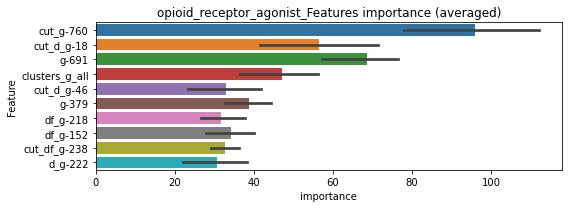

len(train_index) : 3878
len(valid_index) : 3878
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216751	valid_1's binary_logloss: 0.046274
[200]	training's binary_logloss: 0.00386385	valid_1's binary_logloss: 0.0268175
[300]	training's binary_logloss: 0.00113832	valid_1's binary_logloss: 0.0228285
[400]	training's binary_logloss: 0.000543942	valid_1's binary_logloss: 0.0219451
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000535286	valid_1's binary_logloss: 0.0219103


len(train_index) : 3878
len(valid_index) : 3878
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215032	valid_1's binary_logloss: 0.0493172
[200]	training's binary_logloss: 0.00380924	valid_1's binary_logloss: 0.0300301
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00194536	valid_1's binary_logloss: 0.0275841


opioid_receptor_agonist logloss: 0.024747192273556692


neg labels: 3289 → selected neg labels: 3275


opioid_receptor_antagonist, len(trt): 96, len(othr): 3275, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528244	valid_1's binary_logloss: 0.116801
[200]	training's binary_logloss: 0.0120552	valid_1's binary_logloss: 0.0742487
[300]	training's binary_logloss: 0.00357617	valid_1's binary_logloss: 0.0625081
[400]	training's binary_logloss: 0.00164427	valid_1's binary_logloss: 0.059084
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00171536	valid_1's binary_logloss: 0.0590152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589839	valid_1's binary_logloss: 0.121164
[200]	training's binary_logloss: 0.0138787	valid_1's binary_logloss: 0.0793427
[300]	training's binary_logloss: 0.0041695	valid_1's binary_logloss: 0.0691829
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00207996	valid_1's binary_logloss: 0.0669644


1 / 3 AUC score:0.994
y_Threshold: 0.0127976, Threshold: 0.0157925, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 151 → Positive_corect_labels: 645/3779
p_label_rate: 0.0200904 Vs.target_rate: 0.00403
Num_p_label: 80.0, conf_0:0.01421, conf_1:0.01737
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0157925
Num_p_label: 22.0, Expected: 16.1, Adj_threshold_2: 0.0257925
threshold: 0.0257925, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 645.0/3779, y_label_rate: 0.1706801
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514241	valid_1's binary_logloss: 0.122265
[200]	training's binary_logloss: 0.0107175	valid_1's binary_logloss: 0.0737986
[300]	training's binary_logloss: 0.00329412	valid_1's binary_logloss: 0.0620272
[400]	training's binary_logloss: 0.00153271	valid_1's binary_logloss: 0.0586701
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00137362	valid_1's binary_logloss: 0.0583034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559262	valid_1's binary_logloss: 0.109119
[200]	training's binary_logloss: 0.0125989	valid_1's binary_logloss: 0.0622366
[300]	training's binary_logloss: 0.00393754	valid_1's binary_logloss: 0.0507506
[400]	training's binary_logloss: 0.00180651	valid_1's binary_logloss: 0.0461254
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00177414	valid_1's binary_logloss: 0.0461189


2 / 3 AUC score:0.999
y_Threshold: 0.0272212, Threshold: 0.0257925, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 632.0/3753
p_label_rate: 0.0115520 Vs.target_rate: 0.00403
Num_p_label: 46.0, conf_0:0.02321, conf_1:0.02837
threshold: 0.0257925, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 632.0/3753, y_label_rate: 0.1683986
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507792	valid_1's binary_logloss: 0.116306
[200]	training's binary_logloss: 0.0103331	valid_1's binary_logloss: 0.0747911
[300]	training's binary_logloss: 0.00312937	valid_1's binary_logloss: 0.064833
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0025907	valid_1's binary_logloss: 0.0638255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542215	valid_1's binary_logloss: 0.111377
[200]	training's binary_logloss: 0.011144	valid_1's binary_logloss: 0.0672953
[300]	training's binary_logloss: 0.00345025	valid_1's binary_logloss: 0.0590063
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0020747	valid_1's binary_logloss: 0.0564615


3 / 3 AUC score:0.997
y_Threshold: 0.0304194, Threshold: 0.0257925, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 617.0/3723
p_label_rate: 0.0145655 Vs.target_rate: 0.00403
Num_p_label: 58.0, conf_0:0.02321, conf_1:0.02837
Num_p_label: 58.0, Expected: 16.1, Adj_threshold_1: 0.0257925
Num_p_label: 25.0, Expected: 16.1, Adj_threshold_2: 0.0357925
threshold: 0.0357925, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 642.0/7705, y_label_rate: 0.0833225


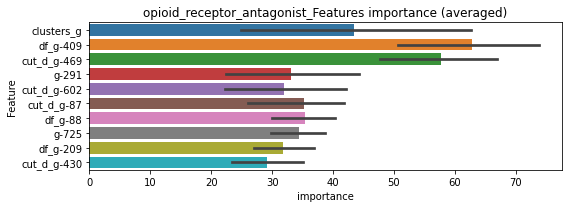

len(train_index) : 3852
len(valid_index) : 3853
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280341	valid_1's binary_logloss: 0.0745032
[200]	training's binary_logloss: 0.00585905	valid_1's binary_logloss: 0.0535385
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00297951	valid_1's binary_logloss: 0.0500805


len(train_index) : 3853
len(valid_index) : 3852
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295262	valid_1's binary_logloss: 0.0722485
[200]	training's binary_logloss: 0.00638319	valid_1's binary_logloss: 0.0499631
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00336986	valid_1's binary_logloss: 0.0472561


opioid_receptor_antagonist logloss: 0.048668465962622406


neg labels: 3289 → selected neg labels: 3283


orexin_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321393	valid_1's binary_logloss: 0.0573663
[200]	training's binary_logloss: 0.00471543	valid_1's binary_logloss: 0.0229233
[300]	training's binary_logloss: 0.00133159	valid_1's binary_logloss: 0.0166252
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000881787	valid_1's binary_logloss: 0.0152094
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328575	valid_1's binary_logloss: 0.0524903
[200]	training's binary_logloss: 0.00508377	valid_1's binary_logloss: 0.0183651
[300]	training's binary_logloss: 0.00140579	valid_1's binary_logloss: 0.0115642
[400]	training's binary_logloss: 0.000691027	valid_1's binary_logloss: 0.00994071
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000572467	valid_1's binary_logloss: 0.00950808


1 / 3 AUC score:1.000
y_Threshold: 0.0035612, Threshold: 0.0046197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00416, conf_1:0.00508
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0046197
Num_p_label: 5.0, Expected: 6.2, Adj_threshold_2: 0.0146197
threshold: 0.0146197, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325114	valid_1's binary_logloss: 0.0574949
[200]	training's binary_logloss: 0.00474204	valid_1's binary_logloss: 0.0223989
[300]	training's binary_logloss: 0.00131903	valid_1's binary_logloss: 0.015569
[400]	training's binary_logloss: 0.000654723	valid_1's binary_logloss: 0.014024
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000600741	valid_1's binary_logloss: 0.0138503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334764	valid_1's binary_logloss: 0.0541358
[200]	training's binary_logloss: 0.0050674	valid_1's binary_logloss: 0.0181903
[300]	training's binary_logloss: 0.00141374	valid_1's binary_logloss: 0.0115591
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000801584	valid_1's binary_logloss: 0.0102837


2 / 3 AUC score:1.000
y_Threshold: 0.0219371, Threshold: 0.0146197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0035158 Vs.target_rate: 0.00155
Num_p_label: 14.0, conf_0:0.01316, conf_1:0.01608
threshold: 0.0146197, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324377	valid_1's binary_logloss: 0.0552193
[200]	training's binary_logloss: 0.00453609	valid_1's binary_logloss: 0.0223393
[300]	training's binary_logloss: 0.0013126	valid_1's binary_logloss: 0.0168326
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000746008	valid_1's binary_logloss: 0.0151592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323682	valid_1's binary_logloss: 0.0513792
[200]	training's binary_logloss: 0.00484457	valid_1's binary_logloss: 0.0158155
[300]	training's binary_logloss: 0.00138815	valid_1's binary_logloss: 0.00933854
[400]	training's binary_logloss: 0.000677895	valid_1's binary_logloss: 0.0076637
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000527591	valid_1's binary_logloss: 0.00724123


3 / 3 AUC score:1.000
y_Threshold: 0.0219915, Threshold: 0.0146197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0025113 Vs.target_rate: 0.00155
Num_p_label: 10.0, conf_0:0.01316, conf_1:0.01608
threshold: 0.0146197, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 664.0/7785, y_label_rate: 0.0852922


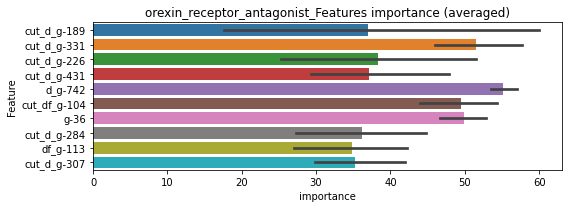

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177568	valid_1's binary_logloss: 0.0355364
[200]	training's binary_logloss: 0.00266748	valid_1's binary_logloss: 0.0184494
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00101547	valid_1's binary_logloss: 0.0165159


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184686	valid_1's binary_logloss: 0.0308656
[200]	training's binary_logloss: 0.00279986	valid_1's binary_logloss: 0.012145
[300]	training's binary_logloss: 0.000788152	valid_1's binary_logloss: 0.00899291
[400]	training's binary_logloss: 0.000374856	valid_1's binary_logloss: 0.00822113
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00033462	valid_1's binary_logloss: 0.00816053


orexin_receptor_antagonist logloss: 0.01233877734453158


neg labels: 3289 → selected neg labels: 3278


p38_mapk_inhibitor, len(trt): 62, len(othr): 3278, target_rate: 0.0026035 → Adj_target_rate: 0.0028037
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321342	valid_1's binary_logloss: 0.065491
[200]	training's binary_logloss: 0.00477003	valid_1's binary_logloss: 0.0239437
[300]	training's binary_logloss: 0.00140683	valid_1's binary_logloss: 0.0156307
[400]	training's binary_logloss: 0.000706665	valid_1's binary_logloss: 0.012747
[500]	training's binary_logloss: 0.000480393	valid_1's binary_logloss: 0.0116247
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000425398	valid_1's binary_logloss: 0.0111424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032629	valid_1's binary_logloss: 0.0613259
[200]	training's binary_logloss: 0.00490708	valid_1's binary_logloss: 0.0224654
[300]	training's binary_logloss: 0.00142573	valid_1's binary_logloss: 0.0134129
[400]	training's binary_logloss: 0.000725561	valid_1's binary_logloss: 0.0113459
Early stopping, best iteration is:
[440]	tra

1 / 3 AUC score:1.000
y_Threshold: 0.0041532, Threshold: 0.0096804, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 655/3801
p_label_rate: 0.0200904 Vs.target_rate: 0.00260
Num_p_label: 80.0, conf_0:0.00871, conf_1:0.01065
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_1: 0.0096804
Num_p_label: 48.0, Expected: 10.4, Adj_threshold_2: 0.0196804
Num_p_label: 37.0, Expected: 10.4, Adj_threshold_3: 0.0296804
Num_p_label: 30.0, Expected: 10.4, Adj_threshold_4: 0.0396804
Num_p_label: 22.0, Expected: 10.4, Adj_threshold_5: 0.0496804
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_6: 0.0596804
threshold: 0.0596804, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 655.0/3801, y_label_rate: 0.1723231
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317574	valid_1's binary_logloss: 0.0600949
[200]	training's binary_logloss: 0.0045683	valid_1's binary_logloss: 0.0195892
[300]	training's binary_logloss: 0.00133272	valid_1's binary_logloss: 0.0112631
[400]	training's binary_logloss: 0.00067698	valid_1's binary_logloss: 0.00866387
[500]	training's binary_logloss: 0.000463094	valid_1's binary_logloss: 0.00744257
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000428203	valid_1's binary_logloss: 0.00724163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031592	valid_1's binary_logloss: 0.0556838
[200]	training's binary_logloss: 0.00460077	valid_1's binary_logloss: 0.0166232
[300]	training's binary_logloss: 0.00134388	valid_1's binary_logloss: 0.00932948
[400]	training's binary_logloss: 0.00068052	valid_1's binary_logloss: 0.00739418
[500]	training's binary_logloss: 0.00046

2 / 3 AUC score:1.000
y_Threshold: 0.0459292, Threshold: 0.0596804, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3801
p_label_rate: 0.0113009 Vs.target_rate: 0.00260
Num_p_label: 45.0, conf_0:0.05371, conf_1:0.06565
Num_p_label: 45.0, Expected: 10.4, Adj_threshold_1: 0.0596804
Num_p_label: 41.0, Expected: 10.4, Adj_threshold_2: 0.0696804
Num_p_label: 38.0, Expected: 10.4, Adj_threshold_3: 0.0796804
Num_p_label: 33.0, Expected: 10.4, Adj_threshold_4: 0.0896804
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_5: 0.0996804
Num_p_label: 26.0, Expected: 10.4, Adj_threshold_6: 0.1096804
Num_p_label: 24.0, Expected: 10.4, Adj_threshold_7: 0.1196804
Num_p_label: 24.0, Expected: 10.4, Adj_threshold_8: 0.1296804
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_9: 0.1396804
Num_p_label: 21.0, Expected: 10.4, Adj_threshold_10: 0.1496804
threshold: 0.1596804, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 655.0/3801, y_label_rate: 0.1723231

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317574	valid_1's binary_logloss: 0.0600949
[200]	training's binary_logloss: 0.0045683	valid_1's binary_logloss: 0.0195892
[300]	training's binary_logloss: 0.00133272	valid_1's binary_logloss: 0.0112631
[400]	training's binary_logloss: 0.00067698	valid_1's binary_logloss: 0.00866387
[500]	training's binary_logloss: 0.000463094	valid_1's binary_logloss: 0.00744257
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000428203	valid_1's binary_logloss: 0.00724163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031592	valid_1's binary_logloss: 0.0556838
[200]	training's binary_logloss: 0.00460077	valid_1's binary_logloss: 0.0166232
[300]	training's binary_logloss: 0.00134388	valid_1's binary_logloss: 0.00932948
[400]	training's binary_logloss: 0.00068052	valid_1's binary_logloss: 0.00739418
[500]	training's binary_logloss: 0.00046

3 / 3 AUC score:1.000
y_Threshold: 0.0459292, Threshold: 0.1596804, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3801
p_label_rate: 0.0052737 Vs.target_rate: 0.00260
Num_p_label: 21.0, conf_0:0.14371, conf_1:0.17565
threshold: 0.1596804, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 676.0/7783, y_label_rate: 0.0868560


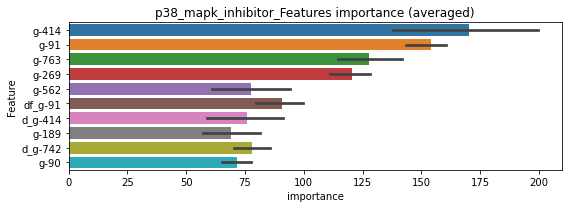

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167147	valid_1's binary_logloss: 0.0366243
[200]	training's binary_logloss: 0.00237469	valid_1's binary_logloss: 0.0142558
[300]	training's binary_logloss: 0.000712529	valid_1's binary_logloss: 0.00937528
[400]	training's binary_logloss: 0.000362178	valid_1's binary_logloss: 0.00792738
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000270791	valid_1's binary_logloss: 0.00747543


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164517	valid_1's binary_logloss: 0.035915
[200]	training's binary_logloss: 0.00234107	valid_1's binary_logloss: 0.0163706
[300]	training's binary_logloss: 0.000698671	valid_1's binary_logloss: 0.0123547
[400]	training's binary_logloss: 0.000360178	valid_1's binary_logloss: 0.0108004
[500]	training's binary_logloss: 0.000246807	valid_1's binary_logloss: 0.0102142
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000234953	valid_1's binary_logloss: 0.0101392


p38_mapk_inhibitor logloss: 0.008807119239727405


neg labels: 3289 → selected neg labels: 3285


p-glycoprotein_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277684	valid_1's binary_logloss: 0.0392178
[200]	training's binary_logloss: 0.0035188	valid_1's binary_logloss: 0.00802302
[300]	training's binary_logloss: 0.000971312	valid_1's binary_logloss: 0.00353648
[400]	training's binary_logloss: 0.000493301	valid_1's binary_logloss: 0.002569
[500]	training's binary_logloss: 0.000365124	valid_1's binary_logloss: 0.00222853
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000367532	valid_1's binary_logloss: 0.00222682
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02728	valid_1's binary_logloss: 0.0437458
[200]	training's binary_logloss: 0.00352886	valid_1's binary_logloss: 0.0142297
[300]	training's binary_logloss: 0.000990445	valid_1's binary_logloss: 0.00926162
[400]	training's binary_logloss: 0.00049806	valid_1's binary_logloss: 0.00764632
Early stopping, best iteration is:
[45

1 / 3 AUC score:1.000
y_Threshold: 0.0018427, Threshold: 0.0026280, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00237, conf_1:0.00289
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0026280
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_2: 0.0126280
threshold: 0.0126280, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272302	valid_1's binary_logloss: 0.0384394
[200]	training's binary_logloss: 0.0034233	valid_1's binary_logloss: 0.00824016
[300]	training's binary_logloss: 0.000963318	valid_1's binary_logloss: 0.00385744
[400]	training's binary_logloss: 0.00049485	valid_1's binary_logloss: 0.00281916
[500]	training's binary_logloss: 0.00036771	valid_1's binary_logloss: 0.00250209
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000356342	valid_1's binary_logloss: 0.00248034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278112	valid_1's binary_logloss: 0.0470367
[200]	training's binary_logloss: 0.00354126	valid_1's binary_logloss: 0.015909
[300]	training's binary_logloss: 0.000980902	valid_1's binary_logloss: 0.0107002
[400]	training's binary_logloss: 0.000495266	valid_1's binary_logloss: 0.00878402
Early stopping, best iteration is:
[4

2 / 3 AUC score:1.000
y_Threshold: 0.0157993, Threshold: 0.0126280, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0045203 Vs.target_rate: 0.00101
Num_p_label: 18.0, conf_0:0.01137, conf_1:0.01389
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_1: 0.0126280
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_2: 0.0226280
threshold: 0.0226280, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271127	valid_1's binary_logloss: 0.0370114
[200]	training's binary_logloss: 0.00334198	valid_1's binary_logloss: 0.00783007
[300]	training's binary_logloss: 0.000934216	valid_1's binary_logloss: 0.00373492
[400]	training's binary_logloss: 0.000485513	valid_1's binary_logloss: 0.00277976
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000370998	valid_1's binary_logloss: 0.00250206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265708	valid_1's binary_logloss: 0.0425761
[200]	training's binary_logloss: 0.00339343	valid_1's binary_logloss: 0.0111428
[300]	training's binary_logloss: 0.000959864	valid_1's binary_logloss: 0.00585295
[400]	training's binary_logloss: 0.000491217	valid_1's binary_logloss: 0.00439551
[500]	training's binary_logloss: 0.000370009	valid_1's binary_logloss: 0.00396062
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.0315331, Threshold: 0.0226280, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0015068 Vs.target_rate: 0.00101
Num_p_label: 6.0, conf_0:0.02037, conf_1:0.02489
threshold: 0.0226280, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 662.0/7790, y_label_rate: 0.0849807


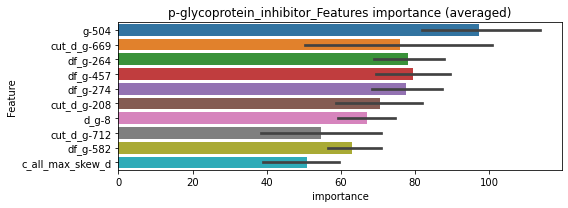

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149106	valid_1's binary_logloss: 0.0252086
[200]	training's binary_logloss: 0.0018585	valid_1's binary_logloss: 0.00897169
[300]	training's binary_logloss: 0.000500396	valid_1's binary_logloss: 0.0073086
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000519713	valid_1's binary_logloss: 0.00730184


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015232	valid_1's binary_logloss: 0.0242176
[200]	training's binary_logloss: 0.00196781	valid_1's binary_logloss: 0.00719823
[300]	training's binary_logloss: 0.000535488	valid_1's binary_logloss: 0.00470925
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000282385	valid_1's binary_logloss: 0.0041845


p-glycoprotein_inhibitor logloss: 0.005743168586556953


neg labels: 3289 → selected neg labels: 3279


parp_inhibitor, len(trt): 61, len(othr): 3279, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371582	valid_1's binary_logloss: 0.0730521
[200]	training's binary_logloss: 0.00644118	valid_1's binary_logloss: 0.0309444
[300]	training's binary_logloss: 0.00192599	valid_1's binary_logloss: 0.021611
[400]	training's binary_logloss: 0.000945506	valid_1's binary_logloss: 0.0187169
[500]	training's binary_logloss: 0.000615445	valid_1's binary_logloss: 0.0172803
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000550134	valid_1's binary_logloss: 0.0170007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392446	valid_1's binary_logloss: 0.0735044
[200]	training's binary_logloss: 0.00668273	valid_1's binary_logloss: 0.0324589
[300]	training's binary_logloss: 0.00199286	valid_1's binary_logloss: 0.0242192
[400]	training's binary_logloss: 0.000967092	valid_1's binary_logloss: 0.0222069
Early stopping, best iteration is:
[432]	t

1 / 3 AUC score:1.000
y_Threshold: 0.0061870, Threshold: 0.0087063, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00256
Num_p_label: 80.0, conf_0:0.00784, conf_1:0.00958
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0087063
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_2: 0.0187063
threshold: 0.0187063, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379016	valid_1's binary_logloss: 0.0754378
[200]	training's binary_logloss: 0.00630353	valid_1's binary_logloss: 0.0337414
[300]	training's binary_logloss: 0.00187343	valid_1's binary_logloss: 0.0245851
[400]	training's binary_logloss: 0.000916587	valid_1's binary_logloss: 0.0216996
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000728201	valid_1's binary_logloss: 0.020847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384375	valid_1's binary_logloss: 0.0723795
[200]	training's binary_logloss: 0.00644597	valid_1's binary_logloss: 0.0330075
[300]	training's binary_logloss: 0.00190928	valid_1's binary_logloss: 0.0253432
[400]	training's binary_logloss: 0.000932863	valid_1's binary_logloss: 0.0232228
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000843066	valid_1's binary_logloss: 0.0231261


2 / 3 AUC score:1.000
y_Threshold: 0.0286838, Threshold: 0.0187063, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 651.0/3794
p_label_rate: 0.0130588 Vs.target_rate: 0.00256
Num_p_label: 52.0, conf_0:0.01684, conf_1:0.02058
Num_p_label: 52.0, Expected: 10.2, Adj_threshold_1: 0.0187063
Num_p_label: 33.0, Expected: 10.2, Adj_threshold_2: 0.0287063
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_3: 0.0387063
Num_p_label: 12.0, Expected: 10.2, Adj_threshold_4: 0.0487063
threshold: 0.0487063, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 651.0/3794, y_label_rate: 0.1715867
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370968	valid_1's binary_logloss: 0.0817725
[200]	training's binary_logloss: 0.00607825	valid_1's binary_logloss: 0.0379587
[300]	training's binary_logloss: 0.00178343	valid_1's binary_logloss: 0.0296482
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0011065	valid_1's binary_logloss: 0.0282555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384269	valid_1's binary_logloss: 0.0850251
[200]	training's binary_logloss: 0.00624509	valid_1's binary_logloss: 0.0401258
[300]	training's binary_logloss: 0.00183285	valid_1's binary_logloss: 0.0293952
[400]	training's binary_logloss: 0.000903178	valid_1's binary_logloss: 0.0262662
[500]	training's binary_logloss: 0.000591769	valid_1's binary_logloss: 0.0251628
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000608905	valid_1's binary_logloss: 0.0250985


3 / 3 AUC score:1.000
y_Threshold: 0.0311087, Threshold: 0.0487063, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 646.0/3784
p_label_rate: 0.0032647 Vs.target_rate: 0.00256
Num_p_label: 13.0, conf_0:0.04384, conf_1:0.05358
threshold: 0.0487063, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 659.0/7766, y_label_rate: 0.0848571


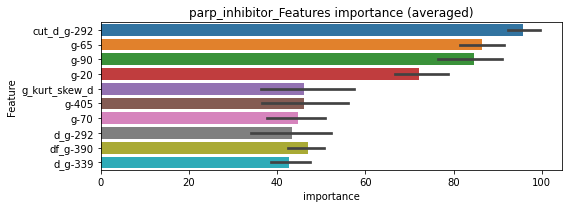

len(train_index) : 3883
len(valid_index) : 3883
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201829	valid_1's binary_logloss: 0.0489083
[200]	training's binary_logloss: 0.00324015	valid_1's binary_logloss: 0.02639
[300]	training's binary_logloss: 0.000953509	valid_1's binary_logloss: 0.022263
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000524107	valid_1's binary_logloss: 0.0210905


len(train_index) : 3883
len(valid_index) : 3883
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020234	valid_1's binary_logloss: 0.0418598
[200]	training's binary_logloss: 0.00333897	valid_1's binary_logloss: 0.0190782
[300]	training's binary_logloss: 0.00100818	valid_1's binary_logloss: 0.0145948
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000527377	valid_1's binary_logloss: 0.0135106


parp_inhibitor logloss: 0.017300549639538827


neg labels: 3289 → selected neg labels: 3268


pdgfr_inhibitor, len(trt): 297, len(othr): 3268, target_rate: 0.0124717 → Adj_target_rate: 0.0106179
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509832	valid_1's binary_logloss: 0.13367
[200]	training's binary_logloss: 0.0111111	valid_1's binary_logloss: 0.097663
[300]	training's binary_logloss: 0.00370339	valid_1's binary_logloss: 0.0875227
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00215714	valid_1's binary_logloss: 0.0852218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497437	valid_1's binary_logloss: 0.131421
[200]	training's binary_logloss: 0.0103779	valid_1's binary_logloss: 0.0968446
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00549846	valid_1's binary_logloss: 0.0924907


1 / 3 AUC score:0.990
y_Threshold: 0.0399253, Threshold: 0.1927685, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 186 → Positive_corect_labels: 626/3735
p_label_rate: 0.0200904 Vs.target_rate: 0.01247
Num_p_label: 80.0, conf_0:0.17349, conf_1:0.21205
threshold: 0.1927685, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 626.0/3735, y_label_rate: 0.1676037
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423029	valid_1's binary_logloss: 0.101012
[200]	training's binary_logloss: 0.00788581	valid_1's binary_logloss: 0.0627225
[300]	training's binary_logloss: 0.00241667	valid_1's binary_logloss: 0.0513125
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00171566	valid_1's binary_logloss: 0.0493515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414331	valid_1's binary_logloss: 0.102087
[200]	training's binary_logloss: 0.00753145	valid_1's binary_logloss: 0.0675162
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00367671	valid_1's binary_logloss: 0.0619556


2 / 3 AUC score:0.994
y_Threshold: 0.0982916, Threshold: 0.1927685, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 48 → Positive_corect_labels: 602.0/3687
p_label_rate: 0.0328980 Vs.target_rate: 0.01247
Num_p_label: 131.0, conf_0:0.17349, conf_1:0.21205
threshold: 0.1927685, positive_p_label: 131.0/3982, p_label_rate: 0.0328980
positive_y_label: 602.0/3687, y_label_rate: 0.1632764
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385118	valid_1's binary_logloss: 0.0867676
[200]	training's binary_logloss: 0.00671355	valid_1's binary_logloss: 0.0444335
[300]	training's binary_logloss: 0.00193273	valid_1's binary_logloss: 0.0303936
[400]	training's binary_logloss: 0.000950104	valid_1's binary_logloss: 0.0255003
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000717164	valid_1's binary_logloss: 0.0240984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385355	valid_1's binary_logloss: 0.0797852
[200]	training's binary_logloss: 0.00677665	valid_1's binary_logloss: 0.0419937
[300]	training's binary_logloss: 0.00192499	valid_1's binary_logloss: 0.031021
[400]	training's binary_logloss: 0.000937867	valid_1's binary_logloss: 0.0275299
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000892164	valid_1's binary_logloss: 0.0273702


3 / 3 AUC score:1.000
y_Threshold: 0.1710866, Threshold: 0.1927685, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 594.0/3671
p_label_rate: 0.0366650 Vs.target_rate: 0.01247
Num_p_label: 146.0, conf_0:0.17349, conf_1:0.21205
threshold: 0.1927685, positive_p_label: 146.0/3982, p_label_rate: 0.0366650
positive_y_label: 740.0/7653, y_label_rate: 0.0966941


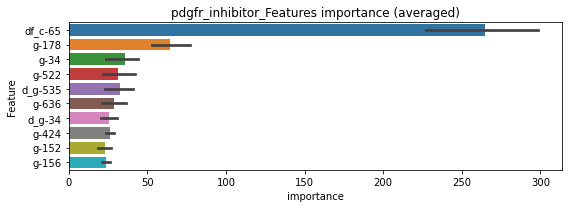

len(train_index) : 3826
len(valid_index) : 3827
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269005	valid_1's binary_logloss: 0.0723084
[200]	training's binary_logloss: 0.0049404	valid_1's binary_logloss: 0.0460948
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00421869	valid_1's binary_logloss: 0.044884


len(train_index) : 3827
len(valid_index) : 3826
================================= fold 2/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272319	valid_1's binary_logloss: 0.0709283
[200]	training's binary_logloss: 0.00517293	valid_1's binary_logloss: 0.0467678
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00357508	valid_1's binary_logloss: 0.0447231


pdgfr_inhibitor logloss: 0.04480356437475775


neg labels: 3289 → selected neg labels: 3286


pdk_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219845	valid_1's binary_logloss: 0.0267989
[200]	training's binary_logloss: 0.00251501	valid_1's binary_logloss: 0.0044768
[300]	training's binary_logloss: 0.000715186	valid_1's binary_logloss: 0.00178356
[400]	training's binary_logloss: 0.000384946	valid_1's binary_logloss: 0.00118084
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000314119	valid_1's binary_logloss: 0.00105697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221809	valid_1's binary_logloss: 0.0298012
[200]	training's binary_logloss: 0.00249149	valid_1's binary_logloss: 0.00619059
[300]	training's binary_logloss: 0.000717147	valid_1's binary_logloss: 0.00328629
[400]	training's binary_logloss: 0.000387962	valid_1's binary_logloss: 0.00261286
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000328375	valid_1's binary_logloss: 0.002488

1 / 3 AUC score:1.000
y_Threshold: 0.0013233, Threshold: 0.0019400, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00175, conf_1:0.00213
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0019400
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_2: 0.0119400
threshold: 0.0119400, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021876	valid_1's binary_logloss: 0.0275678
[200]	training's binary_logloss: 0.00248401	valid_1's binary_logloss: 0.00487553
[300]	training's binary_logloss: 0.000719171	valid_1's binary_logloss: 0.00214772
[400]	training's binary_logloss: 0.00039068	valid_1's binary_logloss: 0.00144202
[500]	training's binary_logloss: 0.000313393	valid_1's binary_logloss: 0.00128901
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000310337	valid_1's binary_logloss: 0.00128242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221429	valid_1's binary_logloss: 0.0298335
[200]	training's binary_logloss: 0.00246326	valid_1's binary_logloss: 0.00622546
[300]	training's binary_logloss: 0.000710828	valid_1's binary_logloss: 0.00328864
[400]	training's binary_logloss: 0.000386939	valid_1's binary_logloss: 0.0026225
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0210420, Threshold: 0.0119400, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0037670 Vs.target_rate: 0.00076
Num_p_label: 15.0, conf_0:0.01075, conf_1:0.01313
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_1: 0.0119400
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_2: 0.0219400
threshold: 0.0219400, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021876	valid_1's binary_logloss: 0.0275678
[200]	training's binary_logloss: 0.00248401	valid_1's binary_logloss: 0.00487553
[300]	training's binary_logloss: 0.000719171	valid_1's binary_logloss: 0.00214772
[400]	training's binary_logloss: 0.00039068	valid_1's binary_logloss: 0.00144202
[500]	training's binary_logloss: 0.000313393	valid_1's binary_logloss: 0.00128901
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000310337	valid_1's binary_logloss: 0.00128242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221429	valid_1's binary_logloss: 0.0298335
[200]	training's binary_logloss: 0.00246326	valid_1's binary_logloss: 0.00622546
[300]	training's binary_logloss: 0.000710828	valid_1's binary_logloss: 0.00328864
[400]	training's binary_logloss: 0.000386939	valid_1's binary_logloss: 0.0026225
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.0210420, Threshold: 0.0219400, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0010045 Vs.target_rate: 0.00076
Num_p_label: 4.0, conf_0:0.01975, conf_1:0.02413
threshold: 0.0219400, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7793, y_label_rate: 0.0848197


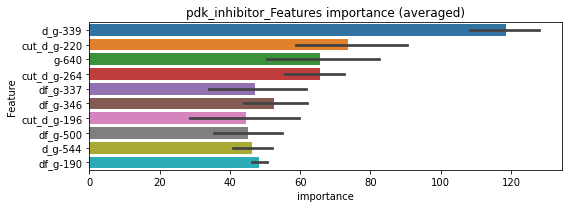

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120685	valid_1's binary_logloss: 0.0174161
[200]	training's binary_logloss: 0.00135746	valid_1's binary_logloss: 0.00580638
[300]	training's binary_logloss: 0.000364849	valid_1's binary_logloss: 0.00502107
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000342487	valid_1's binary_logloss: 0.00501109


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124547	valid_1's binary_logloss: 0.015799
[200]	training's binary_logloss: 0.00143095	valid_1's binary_logloss: 0.00415599
[300]	training's binary_logloss: 0.000405411	valid_1's binary_logloss: 0.00284748
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000256358	valid_1's binary_logloss: 0.00265024


pdk_inhibitor logloss: 0.003830815202504006


neg labels: 3289 → selected neg labels: 3243


phosphodiesterase_inhibitor, len(trt): 264, len(othr): 3243, target_rate: 0.0110859 → Adj_target_rate: 0.0096064
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0929355	valid_1's binary_logloss: 0.274884
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0440262	valid_1's binary_logloss: 0.264895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103369	valid_1's binary_logloss: 0.249153
[200]	training's binary_logloss: 0.036446	valid_1's binary_logloss: 0.224046
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.033406	valid_1's binary_logloss: 0.222421


1 / 3 AUC score:0.911
y_Threshold: 0.0831395, Threshold: 0.1085825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 421 → Positive_corect_labels: 503/3470
p_label_rate: 0.0200904 Vs.target_rate: 0.01109
Num_p_label: 80.0, conf_0:0.09772, conf_1:0.11944
threshold: 0.1085825, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 503.0/3470, y_label_rate: 0.1449568
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668543	valid_1's binary_logloss: 0.181043
[200]	training's binary_logloss: 0.0181034	valid_1's binary_logloss: 0.153658
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0112998	valid_1's binary_logloss: 0.151738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644812	valid_1's binary_logloss: 0.191076
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.0229255	valid_1's binary_logloss: 0.168873


2 / 3 AUC score:0.970
y_Threshold: 0.0699363, Threshold: 0.1085825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 130 → Positive_corect_labels: 438.0/3340
p_label_rate: 0.0045203 Vs.target_rate: 0.01109
Num_p_label: 18.0, conf_0:0.09772, conf_1:0.11944
threshold: 0.1085825, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 438.0/3340, y_label_rate: 0.1311377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523814	valid_1's binary_logloss: 0.133178
[200]	training's binary_logloss: 0.0125951	valid_1's binary_logloss: 0.10628
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0082571	valid_1's binary_logloss: 0.103002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050502	valid_1's binary_logloss: 0.138256
[200]	training's binary_logloss: 0.0116387	valid_1's binary_logloss: 0.109175
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00670743	valid_1's binary_logloss: 0.105813


3 / 3 AUC score:0.991
y_Threshold: 0.0472371, Threshold: 0.1085825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 60 → Positive_corect_labels: 408.0/3280
p_label_rate: 0.0012557 Vs.target_rate: 0.01109
Num_p_label: 5.0, conf_0:0.09772, conf_1:0.11944
Num_p_label: 5.0, Expected: 44.1, Adj_threshold_1: 0.1085825
Num_p_label: 11.0, Expected: 44.1, Adj_threshold_2: 0.0985825
Num_p_label: 15.0, Expected: 44.1, Adj_threshold_3: 0.0885825
Num_p_label: 20.0, Expected: 44.1, Adj_threshold_4: 0.0785825
Num_p_label: 35.0, Expected: 44.1, Adj_threshold_5: 0.0685825
threshold: 0.0685825, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 443.0/7262, y_label_rate: 0.0610025


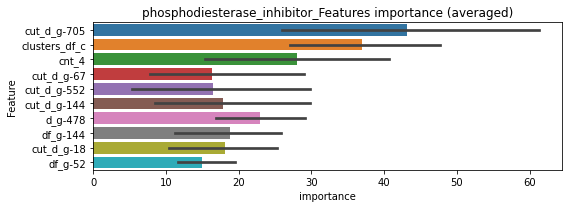

len(train_index) : 3631
len(valid_index) : 3631
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260962	valid_1's binary_logloss: 0.0754727
[200]	training's binary_logloss: 0.00657158	valid_1's binary_logloss: 0.0626154
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00698187	valid_1's binary_logloss: 0.0622222


len(train_index) : 3631
len(valid_index) : 3631
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257815	valid_1's binary_logloss: 0.0817604
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00678684	valid_1's binary_logloss: 0.0700737


phosphodiesterase_inhibitor logloss: 0.06614792421679061


neg labels: 3289 → selected neg labels: 3285


phospholipase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275209	valid_1's binary_logloss: 0.0405086
[200]	training's binary_logloss: 0.00357051	valid_1's binary_logloss: 0.0106847
[300]	training's binary_logloss: 0.000991932	valid_1's binary_logloss: 0.0061609
[400]	training's binary_logloss: 0.000508031	valid_1's binary_logloss: 0.00509133
[500]	training's binary_logloss: 0.000373619	valid_1's binary_logloss: 0.00473484
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000378717	valid_1's binary_logloss: 0.00472991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281521	valid_1's binary_logloss: 0.0445558
[200]	training's binary_logloss: 0.00386267	valid_1's binary_logloss: 0.0100444
[300]	training's binary_logloss: 0.00106975	valid_1's binary_logloss: 0.00446254
[400]	training's binary_logloss: 0.000534013	valid_1's binary_logloss: 0.00298693
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0017401, Threshold: 0.0029002, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00261, conf_1:0.00319
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0029002
Num_p_label: 4.0, Expected: 4.2, Adj_threshold_2: 0.0129002
threshold: 0.0129002, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278408	valid_1's binary_logloss: 0.0402766
[200]	training's binary_logloss: 0.00355832	valid_1's binary_logloss: 0.0106735
[300]	training's binary_logloss: 0.000991361	valid_1's binary_logloss: 0.00611383
[400]	training's binary_logloss: 0.000506873	valid_1's binary_logloss: 0.00500891
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000378056	valid_1's binary_logloss: 0.00466344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278744	valid_1's binary_logloss: 0.0452666
[200]	training's binary_logloss: 0.00363056	valid_1's binary_logloss: 0.00960697
[300]	training's binary_logloss: 0.00103404	valid_1's binary_logloss: 0.00416057
[400]	training's binary_logloss: 0.000526117	valid_1's binary_logloss: 0.00277076
[500]	training's binary_logloss: 0.000386364	valid_1's binary_logloss: 0.0023912
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0190444, Threshold: 0.0129002, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0057760 Vs.target_rate: 0.00105
Num_p_label: 23.0, conf_0:0.01161, conf_1:0.01419
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_1: 0.0129002
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_2: 0.0229002
threshold: 0.0229002, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278408	valid_1's binary_logloss: 0.0402766
[200]	training's binary_logloss: 0.00355832	valid_1's binary_logloss: 0.0106735
[300]	training's binary_logloss: 0.000991361	valid_1's binary_logloss: 0.00611383
[400]	training's binary_logloss: 0.000506873	valid_1's binary_logloss: 0.00500891
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000378056	valid_1's binary_logloss: 0.00466344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278744	valid_1's binary_logloss: 0.0452666
[200]	training's binary_logloss: 0.00363056	valid_1's binary_logloss: 0.00960697
[300]	training's binary_logloss: 0.00103404	valid_1's binary_logloss: 0.00416057
[400]	training's binary_logloss: 0.000526117	valid_1's binary_logloss: 0.00277076
[500]	training's binary_logloss: 0.000386364	valid_1's binary_logloss: 0.0023912
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.0190444, Threshold: 0.0229002, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00105
Num_p_label: 6.0, conf_0:0.02061, conf_1:0.02519
threshold: 0.0229002, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


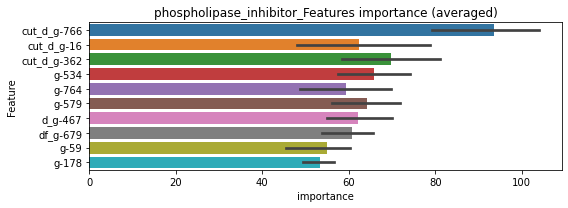

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014725	valid_1's binary_logloss: 0.0248168
[200]	training's binary_logloss: 0.00187051	valid_1's binary_logloss: 0.00958555
[300]	training's binary_logloss: 0.000514787	valid_1's binary_logloss: 0.0080298
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000435629	valid_1's binary_logloss: 0.0079804


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148843	valid_1's binary_logloss: 0.0233887
[200]	training's binary_logloss: 0.001975	valid_1's binary_logloss: 0.00643605
[300]	training's binary_logloss: 0.00055659	valid_1's binary_logloss: 0.00398457
[400]	training's binary_logloss: 0.000265634	valid_1's binary_logloss: 0.00346849
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00019075	valid_1's binary_logloss: 0.00328966


phospholipase_inhibitor logloss: 0.005635031628656884


neg labels: 3289 → selected neg labels: 3264


pi3k_inhibitor, len(trt): 151, len(othr): 3264, target_rate: 0.0063408 → Adj_target_rate: 0.0059749
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500471	valid_1's binary_logloss: 0.142389
[200]	training's binary_logloss: 0.010458	valid_1's binary_logloss: 0.10945
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00683984	valid_1's binary_logloss: 0.107292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509171	valid_1's binary_logloss: 0.137824
[200]	training's binary_logloss: 0.0110782	valid_1's binary_logloss: 0.100978
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00460761	valid_1's binary_logloss: 0.096131


1 / 3 AUC score:0.989
y_Threshold: 0.0288892, Threshold: 0.1408060, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 186 → Positive_corect_labels: 625/3730
p_label_rate: 0.0200904 Vs.target_rate: 0.00634
Num_p_label: 80.0, conf_0:0.12673, conf_1:0.15489
Num_p_label: 80.0, Expected: 25.2, Adj_threshold_1: 0.1408060
Num_p_label: 78.0, Expected: 25.2, Adj_threshold_2: 0.1508060
Num_p_label: 74.0, Expected: 25.2, Adj_threshold_3: 0.1608060
Num_p_label: 71.0, Expected: 25.2, Adj_threshold_4: 0.1708060
Num_p_label: 69.0, Expected: 25.2, Adj_threshold_5: 0.1808060
Num_p_label: 66.0, Expected: 25.2, Adj_threshold_6: 0.1908060
Num_p_label: 61.0, Expected: 25.2, Adj_threshold_7: 0.2008060
Num_p_label: 60.0, Expected: 25.2, Adj_threshold_8: 0.2108060
Num_p_label: 60.0, Expected: 25.2, Adj_threshold_9: 0.2208060
Num_p_label: 59.0, Expected: 25.2, Adj_threshold_10: 0.2308060
threshold: 0.2408060, positive_p_label: 57.0/3982, p_label_rate: 0.0143144
positive_y_label: 625.0/3730, y_label_rate: 0.1675603

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424228	valid_1's binary_logloss: 0.119134
[200]	training's binary_logloss: 0.00776537	valid_1's binary_logloss: 0.0883227
[300]	training's binary_logloss: 0.00236978	valid_1's binary_logloss: 0.0822977
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0024573	valid_1's binary_logloss: 0.0820934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446811	valid_1's binary_logloss: 0.111782
[200]	training's binary_logloss: 0.009747	valid_1's binary_logloss: 0.0701718
[300]	training's binary_logloss: 0.00412686	valid_1's binary_logloss: 0.0620579
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00364894	valid_1's binary_logloss: 0.0606489


2 / 3 AUC score:0.997
y_Threshold: 0.0540996, Threshold: 0.2408060, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 56 → Positive_corect_labels: 597.0/3674
p_label_rate: 0.0447012 Vs.target_rate: 0.00634
Num_p_label: 178.0, conf_0:0.21673, conf_1:0.26489
Num_p_label: 178.0, Expected: 25.2, Adj_threshold_1: 0.2408060
Num_p_label: 178.0, Expected: 25.2, Adj_threshold_2: 0.2508060
Num_p_label: 177.0, Expected: 25.2, Adj_threshold_3: 0.2608060
Num_p_label: 175.0, Expected: 25.2, Adj_threshold_4: 0.2708060
Num_p_label: 170.0, Expected: 25.2, Adj_threshold_5: 0.2808060
Num_p_label: 170.0, Expected: 25.2, Adj_threshold_6: 0.2908060
Num_p_label: 166.0, Expected: 25.2, Adj_threshold_7: 0.3008060
Num_p_label: 166.0, Expected: 25.2, Adj_threshold_8: 0.3108060
Num_p_label: 164.0, Expected: 25.2, Adj_threshold_9: 0.3208060
Num_p_label: 162.0, Expected: 25.2, Adj_threshold_10: 0.3308060
threshold: 0.3408060, positive_p_label: 160.0/3982, p_label_rate: 0.0401808
positive_y_label: 597.0/3674, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376083	valid_1's binary_logloss: 0.103232
[200]	training's binary_logloss: 0.006553	valid_1's binary_logloss: 0.0663523
[300]	training's binary_logloss: 0.00205571	valid_1's binary_logloss: 0.0601738
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00160943	valid_1's binary_logloss: 0.0595202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386692	valid_1's binary_logloss: 0.0933065
[200]	training's binary_logloss: 0.00711469	valid_1's binary_logloss: 0.0557287
[300]	training's binary_logloss: 0.00228192	valid_1's binary_logloss: 0.0453622
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00148764	valid_1's binary_logloss: 0.0429952


3 / 3 AUC score:0.999
y_Threshold: 0.0439859, Threshold: 0.3408060, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 579.0/3638
p_label_rate: 0.0477147 Vs.target_rate: 0.00634
Num_p_label: 190.0, conf_0:0.30673, conf_1:0.37489
Num_p_label: 190.0, Expected: 25.2, Adj_threshold_1: 0.3408060
Num_p_label: 189.0, Expected: 25.2, Adj_threshold_2: 0.3508060
Num_p_label: 187.0, Expected: 25.2, Adj_threshold_3: 0.3608060
Num_p_label: 186.0, Expected: 25.2, Adj_threshold_4: 0.3708060
Num_p_label: 182.0, Expected: 25.2, Adj_threshold_5: 0.3808060
Num_p_label: 181.0, Expected: 25.2, Adj_threshold_6: 0.3908060
Num_p_label: 179.0, Expected: 25.2, Adj_threshold_7: 0.4008060
Num_p_label: 178.0, Expected: 25.2, Adj_threshold_8: 0.4108060
Num_p_label: 176.0, Expected: 25.2, Adj_threshold_9: 0.4208060
Num_p_label: 175.0, Expected: 25.2, Adj_threshold_10: 0.4308060
threshold: 0.4408060, positive_p_label: 173.0/3982, p_label_rate: 0.0434455
positive_y_label: 752.0/7620, y_label_ra

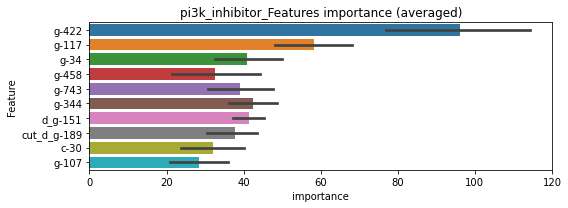

len(train_index) : 3810
len(valid_index) : 3810
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242954	valid_1's binary_logloss: 0.0700346
[200]	training's binary_logloss: 0.00432412	valid_1's binary_logloss: 0.0510372
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00212463	valid_1's binary_logloss: 0.0471131


len(train_index) : 3810
len(valid_index) : 3810
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232889	valid_1's binary_logloss: 0.0569092
[200]	training's binary_logloss: 0.00419839	valid_1's binary_logloss: 0.0349123
[300]	training's binary_logloss: 0.00125318	valid_1's binary_logloss: 0.0288453
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00069787	valid_1's binary_logloss: 0.0271549


pi3k_inhibitor logloss: 0.03713401031585571


neg labels: 3289 → selected neg labels: 3284


pkc_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296838	valid_1's binary_logloss: 0.0479065
[200]	training's binary_logloss: 0.00397465	valid_1's binary_logloss: 0.0154556
[300]	training's binary_logloss: 0.00112807	valid_1's binary_logloss: 0.00980154
[400]	training's binary_logloss: 0.000571419	valid_1's binary_logloss: 0.00802694
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000433048	valid_1's binary_logloss: 0.00755159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290859	valid_1's binary_logloss: 0.0438767
[200]	training's binary_logloss: 0.00392889	valid_1's binary_logloss: 0.0120933
[300]	training's binary_logloss: 0.00110382	valid_1's binary_logloss: 0.00694996
[400]	training's binary_logloss: 0.000550692	valid_1's binary_logloss: 0.00543578
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000433024	valid_1's binary_logloss: 0.00503379


1 / 3 AUC score:1.000
y_Threshold: 0.0024322, Threshold: 0.0039007, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130
Num_p_label: 80.0, conf_0:0.00351, conf_1:0.00429
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0039007
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_2: 0.0139007
Num_p_label: 5.0, Expected: 5.2, Adj_threshold_3: 0.0239007
threshold: 0.0239007, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295392	valid_1's binary_logloss: 0.0461529
[200]	training's binary_logloss: 0.00387621	valid_1's binary_logloss: 0.013208
[300]	training's binary_logloss: 0.00109202	valid_1's binary_logloss: 0.00786595
[400]	training's binary_logloss: 0.000554071	valid_1's binary_logloss: 0.00632296
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000433642	valid_1's binary_logloss: 0.00596803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288971	valid_1's binary_logloss: 0.0420847
[200]	training's binary_logloss: 0.00390753	valid_1's binary_logloss: 0.0120958
[300]	training's binary_logloss: 0.00110418	valid_1's binary_logloss: 0.00738091
[400]	training's binary_logloss: 0.000556785	valid_1's binary_logloss: 0.00590971
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000474477	valid_1's binary_logloss: 0.00572156


2 / 3 AUC score:1.000
y_Threshold: 0.0148434, Threshold: 0.0239007, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00130
Num_p_label: 9.0, conf_0:0.02151, conf_1:0.02629
threshold: 0.0239007, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295392	valid_1's binary_logloss: 0.0461529
[200]	training's binary_logloss: 0.00387621	valid_1's binary_logloss: 0.013208
[300]	training's binary_logloss: 0.00109202	valid_1's binary_logloss: 0.00786595
[400]	training's binary_logloss: 0.000554071	valid_1's binary_logloss: 0.00632296
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000433642	valid_1's binary_logloss: 0.00596803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288971	valid_1's binary_logloss: 0.0420847
[200]	training's binary_logloss: 0.00390753	valid_1's binary_logloss: 0.0120958
[300]	training's binary_logloss: 0.00110418	valid_1's binary_logloss: 0.00738091
[400]	training's binary_logloss: 0.000556785	valid_1's binary_logloss: 0.00590971
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000474477	valid_1's binary_logloss: 0.00572156


3 / 3 AUC score:1.000
y_Threshold: 0.0148434, Threshold: 0.0239007, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00130
Num_p_label: 9.0, conf_0:0.02151, conf_1:0.02629
threshold: 0.0239007, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7790, y_label_rate: 0.0853659


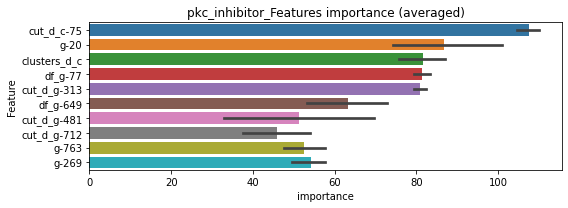

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165092	valid_1's binary_logloss: 0.0284841
[200]	training's binary_logloss: 0.00214332	valid_1's binary_logloss: 0.0123251
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.000831608	valid_1's binary_logloss: 0.0106922


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167155	valid_1's binary_logloss: 0.0257453
[200]	training's binary_logloss: 0.00216502	valid_1's binary_logloss: 0.00882884
[300]	training's binary_logloss: 0.000608872	valid_1's binary_logloss: 0.00644775
[400]	training's binary_logloss: 0.000300073	valid_1's binary_logloss: 0.0058026
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000275602	valid_1's binary_logloss: 0.00571415


pkc_inhibitor logloss: 0.008203179674522674


neg labels: 3289 → selected neg labels: 3279


potassium_channel_activator, len(trt): 55, len(othr): 3279, target_rate: 0.0023096 → Adj_target_rate: 0.0025322
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417313	valid_1's binary_logloss: 0.0767939
[200]	training's binary_logloss: 0.0070965	valid_1's binary_logloss: 0.0318781
[300]	training's binary_logloss: 0.00203469	valid_1's binary_logloss: 0.0212574
[400]	training's binary_logloss: 0.000973421	valid_1's binary_logloss: 0.0183531
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000729347	valid_1's binary_logloss: 0.0173459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431011	valid_1's binary_logloss: 0.0846071
[200]	training's binary_logloss: 0.00741026	valid_1's binary_logloss: 0.0455916
[300]	training's binary_logloss: 0.00204389	valid_1's binary_logloss: 0.0384817
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00185781	valid_1's binary_logloss: 0.0381102


1 / 3 AUC score:1.000
y_Threshold: 0.0072006, Threshold: 0.0121077, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3798
p_label_rate: 0.0200904 Vs.target_rate: 0.00231
Num_p_label: 80.0, conf_0:0.01090, conf_1:0.01332
Num_p_label: 80.0, Expected: 9.2, Adj_threshold_1: 0.0121077
Num_p_label: 20.0, Expected: 9.2, Adj_threshold_2: 0.0221077
Num_p_label: 6.0, Expected: 9.2, Adj_threshold_3: 0.0321077
threshold: 0.0321077, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401213	valid_1's binary_logloss: 0.0766927
[200]	training's binary_logloss: 0.00664287	valid_1's binary_logloss: 0.0327986
[300]	training's binary_logloss: 0.00192157	valid_1's binary_logloss: 0.0240214
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00108138	valid_1's binary_logloss: 0.0218489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417613	valid_1's binary_logloss: 0.0680494
[200]	training's binary_logloss: 0.00719376	valid_1's binary_logloss: 0.0259543
[300]	training's binary_logloss: 0.00208839	valid_1's binary_logloss: 0.0166151
[400]	training's binary_logloss: 0.00100789	valid_1's binary_logloss: 0.0140491
[500]	training's binary_logloss: 0.000648092	valid_1's binary_logloss: 0.0130939
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000634713	valid_1's binary_logloss: 0.0130422


2 / 3 AUC score:1.000
y_Threshold: 0.0265123, Threshold: 0.0321077, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3796
p_label_rate: 0.0050226 Vs.target_rate: 0.00231
Num_p_label: 20.0, conf_0:0.02890, conf_1:0.03532
threshold: 0.0321077, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040301	valid_1's binary_logloss: 0.0761367
[200]	training's binary_logloss: 0.0067395	valid_1's binary_logloss: 0.034789
[300]	training's binary_logloss: 0.00192354	valid_1's binary_logloss: 0.0261621
[400]	training's binary_logloss: 0.000939892	valid_1's binary_logloss: 0.0234255
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000807741	valid_1's binary_logloss: 0.0229476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395722	valid_1's binary_logloss: 0.0722945
[200]	training's binary_logloss: 0.00658258	valid_1's binary_logloss: 0.032583
[300]	training's binary_logloss: 0.00191294	valid_1's binary_logloss: 0.0250447
[400]	training's binary_logloss: 0.00093832	valid_1's binary_logloss: 0.0224823
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000662516	valid_1's binary_logloss: 0.0216537


3 / 3 AUC score:1.000
y_Threshold: 0.0273607, Threshold: 0.0321077, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 650.0/3792
p_label_rate: 0.0050226 Vs.target_rate: 0.00231
Num_p_label: 20.0, conf_0:0.02890, conf_1:0.03532
threshold: 0.0321077, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 670.0/7774, y_label_rate: 0.0861847


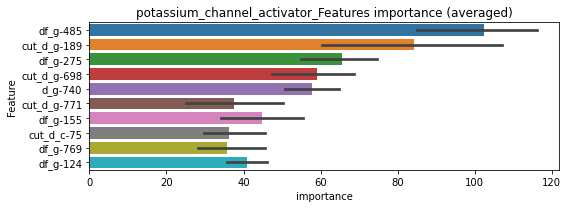

len(train_index) : 3887
len(valid_index) : 3887
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229566	valid_1's binary_logloss: 0.0486208
[200]	training's binary_logloss: 0.00391905	valid_1's binary_logloss: 0.0280164
[300]	training's binary_logloss: 0.00118305	valid_1's binary_logloss: 0.0248295
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.000827039	valid_1's binary_logloss: 0.0244378


len(train_index) : 3887
len(valid_index) : 3887
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024371	valid_1's binary_logloss: 0.0450001
[200]	training's binary_logloss: 0.00427848	valid_1's binary_logloss: 0.022765
[300]	training's binary_logloss: 0.0012446	valid_1's binary_logloss: 0.0185506
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000716138	valid_1's binary_logloss: 0.017831


potassium_channel_activator logloss: 0.021134429139960585


neg labels: 3289 → selected neg labels: 3272


potassium_channel_antagonist, len(trt): 98, len(othr): 3272, target_rate: 0.0041152 → Adj_target_rate: 0.0041375
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521654	valid_1's binary_logloss: 0.129871
[200]	training's binary_logloss: 0.0118572	valid_1's binary_logloss: 0.0960447
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00434741	valid_1's binary_logloss: 0.0877092
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570322	valid_1's binary_logloss: 0.123658
[200]	training's binary_logloss: 0.01311	valid_1's binary_logloss: 0.0857281
[300]	training's binary_logloss: 0.00401945	valid_1's binary_logloss: 0.0773578
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00368362	valid_1's binary_logloss: 0.0770221


1 / 3 AUC score:0.996
y_Threshold: 0.0167186, Threshold: 0.0213864, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 162 → Positive_corect_labels: 639/3764
p_label_rate: 0.0200904 Vs.target_rate: 0.00412
Num_p_label: 80.0, conf_0:0.01925, conf_1:0.02353
Num_p_label: 80.0, Expected: 16.4, Adj_threshold_1: 0.0213864
Num_p_label: 23.0, Expected: 16.4, Adj_threshold_2: 0.0313864
threshold: 0.0313864, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 639.0/3764, y_label_rate: 0.1697662
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499614	valid_1's binary_logloss: 0.12381
[200]	training's binary_logloss: 0.0102167	valid_1's binary_logloss: 0.0828693
[300]	training's binary_logloss: 0.00317772	valid_1's binary_logloss: 0.0740623
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00188072	valid_1's binary_logloss: 0.0734519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555039	valid_1's binary_logloss: 0.111828
[200]	training's binary_logloss: 0.0123743	valid_1's binary_logloss: 0.065041
[300]	training's binary_logloss: 0.00383761	valid_1's binary_logloss: 0.0544608
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.0020497	valid_1's binary_logloss: 0.0513648


2 / 3 AUC score:0.999
y_Threshold: 0.0308844, Threshold: 0.0313864, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 625.0/3736
p_label_rate: 0.0055249 Vs.target_rate: 0.00412
Num_p_label: 22.0, conf_0:0.02825, conf_1:0.03453
threshold: 0.0313864, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 625.0/3736, y_label_rate: 0.1672912
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048614	valid_1's binary_logloss: 0.108832
[200]	training's binary_logloss: 0.0100735	valid_1's binary_logloss: 0.0681027
[300]	training's binary_logloss: 0.00310676	valid_1's binary_logloss: 0.0583837
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00220195	valid_1's binary_logloss: 0.0573024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507305	valid_1's binary_logloss: 0.100874
[200]	training's binary_logloss: 0.0105816	valid_1's binary_logloss: 0.0607232
[300]	training's binary_logloss: 0.00333605	valid_1's binary_logloss: 0.0519825
[400]	training's binary_logloss: 0.0015838	valid_1's binary_logloss: 0.0490533
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00142779	valid_1's binary_logloss: 0.0489215


3 / 3 AUC score:0.998
y_Threshold: 0.0300612, Threshold: 0.0313864, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 615.0/3716
p_label_rate: 0.0057760 Vs.target_rate: 0.00412
Num_p_label: 23.0, conf_0:0.02825, conf_1:0.03453
threshold: 0.0313864, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 638.0/7698, y_label_rate: 0.0828787


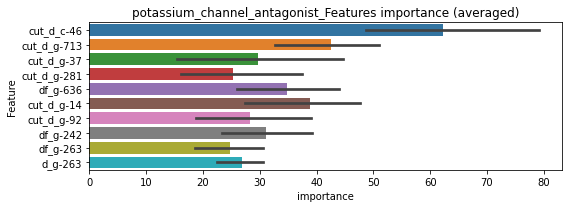

len(train_index) : 3849
len(valid_index) : 3849
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027836	valid_1's binary_logloss: 0.0681305
[200]	training's binary_logloss: 0.00574522	valid_1's binary_logloss: 0.0500336
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0019842	valid_1's binary_logloss: 0.0456986


len(train_index) : 3849
len(valid_index) : 3849
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259243	valid_1's binary_logloss: 0.0753713
[200]	training's binary_logloss: 0.00540537	valid_1's binary_logloss: 0.0565039
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0028001	valid_1's binary_logloss: 0.0545904


potassium_channel_antagonist logloss: 0.05014451635897391


neg labels: 3289 → selected neg labels: 3269


ppar_receptor_agonist, len(trt): 115, len(othr): 3269, target_rate: 0.0048291 → Adj_target_rate: 0.0047401
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049203	valid_1's binary_logloss: 0.1263
[200]	training's binary_logloss: 0.0103648	valid_1's binary_logloss: 0.0885901
[300]	training's binary_logloss: 0.00328161	valid_1's binary_logloss: 0.0814376
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00170218	valid_1's binary_logloss: 0.0791441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530233	valid_1's binary_logloss: 0.117875
[200]	training's binary_logloss: 0.0123449	valid_1's binary_logloss: 0.0687056
[300]	training's binary_logloss: 0.00386943	valid_1's binary_logloss: 0.0548062
[400]	training's binary_logloss: 0.00179912	valid_1's binary_logloss: 0.0515558
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.0011701	valid_1's binary_logloss: 0.0499696


1 / 3 AUC score:0.994
y_Threshold: 0.0121930, Threshold: 0.0535351, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 160 → Positive_corect_labels: 639/3762
p_label_rate: 0.0200904 Vs.target_rate: 0.00483
Num_p_label: 80.0, conf_0:0.04818, conf_1:0.05889
Num_p_label: 80.0, Expected: 19.2, Adj_threshold_1: 0.0535351
Num_p_label: 71.0, Expected: 19.2, Adj_threshold_2: 0.0635351
Num_p_label: 66.0, Expected: 19.2, Adj_threshold_3: 0.0735351
Num_p_label: 58.0, Expected: 19.2, Adj_threshold_4: 0.0835351
Num_p_label: 46.0, Expected: 19.2, Adj_threshold_5: 0.0935351
Num_p_label: 42.0, Expected: 19.2, Adj_threshold_6: 0.1035351
Num_p_label: 38.0, Expected: 19.2, Adj_threshold_7: 0.1135351
threshold: 0.1135351, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 639.0/3762, y_label_rate: 0.1698565
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485626	valid_1's binary_logloss: 0.108521
[200]	training's binary_logloss: 0.00965223	valid_1's binary_logloss: 0.0612437
[300]	training's binary_logloss: 0.00301209	valid_1's binary_logloss: 0.0492508
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00169941	valid_1's binary_logloss: 0.0465097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493382	valid_1's binary_logloss: 0.106711
[200]	training's binary_logloss: 0.0104618	valid_1's binary_logloss: 0.059431
[300]	training's binary_logloss: 0.00326003	valid_1's binary_logloss: 0.0472478
[400]	training's binary_logloss: 0.00155672	valid_1's binary_logloss: 0.0436656
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00127958	valid_1's binary_logloss: 0.0430405


2 / 3 AUC score:0.999
y_Threshold: 0.0383202, Threshold: 0.1135351, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 629.0/3742
p_label_rate: 0.0236062 Vs.target_rate: 0.00483
Num_p_label: 94.0, conf_0:0.10218, conf_1:0.12489
Num_p_label: 94.0, Expected: 19.2, Adj_threshold_1: 0.1135351
Num_p_label: 88.0, Expected: 19.2, Adj_threshold_2: 0.1235351
Num_p_label: 82.0, Expected: 19.2, Adj_threshold_3: 0.1335351
Num_p_label: 80.0, Expected: 19.2, Adj_threshold_4: 0.1435351
Num_p_label: 77.0, Expected: 19.2, Adj_threshold_5: 0.1535351
Num_p_label: 73.0, Expected: 19.2, Adj_threshold_6: 0.1635351
Num_p_label: 69.0, Expected: 19.2, Adj_threshold_7: 0.1735351
Num_p_label: 67.0, Expected: 19.2, Adj_threshold_8: 0.1835351
Num_p_label: 65.0, Expected: 19.2, Adj_threshold_9: 0.1935351
Num_p_label: 64.0, Expected: 19.2, Adj_threshold_10: 0.2035351
threshold: 0.2135351, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 629.0/3742, y_label_rate: 0.168091

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450622	valid_1's binary_logloss: 0.113523
[200]	training's binary_logloss: 0.00847223	valid_1's binary_logloss: 0.070361
[300]	training's binary_logloss: 0.00267405	valid_1's binary_logloss: 0.0618963
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00156652	valid_1's binary_logloss: 0.0594948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488234	valid_1's binary_logloss: 0.109306
[200]	training's binary_logloss: 0.00972842	valid_1's binary_logloss: 0.0636956
[300]	training's binary_logloss: 0.00301871	valid_1's binary_logloss: 0.0523868
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00161043	valid_1's binary_logloss: 0.0494719


3 / 3 AUC score:0.998
y_Threshold: 0.0400479, Threshold: 0.2135351, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 616.0/3716
p_label_rate: 0.0170768 Vs.target_rate: 0.00483
Num_p_label: 68.0, conf_0:0.19218, conf_1:0.23489
Num_p_label: 68.0, Expected: 19.2, Adj_threshold_1: 0.2135351
Num_p_label: 68.0, Expected: 19.2, Adj_threshold_2: 0.2235351
Num_p_label: 65.0, Expected: 19.2, Adj_threshold_3: 0.2335351
Num_p_label: 65.0, Expected: 19.2, Adj_threshold_4: 0.2435351
Num_p_label: 63.0, Expected: 19.2, Adj_threshold_5: 0.2535351
Num_p_label: 60.0, Expected: 19.2, Adj_threshold_6: 0.2635351
Num_p_label: 60.0, Expected: 19.2, Adj_threshold_7: 0.2735351
Num_p_label: 55.0, Expected: 19.2, Adj_threshold_8: 0.2835351
Num_p_label: 53.0, Expected: 19.2, Adj_threshold_9: 0.2935351
Num_p_label: 50.0, Expected: 19.2, Adj_threshold_10: 0.3035351
threshold: 0.3135351, positive_p_label: 49.0/3982, p_label_rate: 0.0123054
positive_y_label: 665.0/7698, y_label_rate: 0.086386

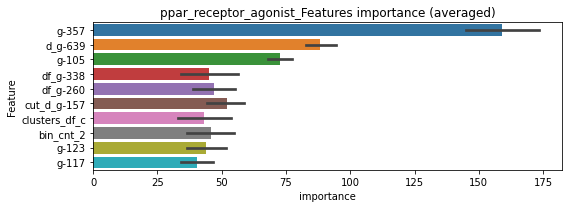

len(train_index) : 3849
len(valid_index) : 3849
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249188	valid_1's binary_logloss: 0.0743484
[200]	training's binary_logloss: 0.00490098	valid_1's binary_logloss: 0.051199
[300]	training's binary_logloss: 0.00144825	valid_1's binary_logloss: 0.0447764
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00125664	valid_1's binary_logloss: 0.0445282


len(train_index) : 3849
len(valid_index) : 3849
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250565	valid_1's binary_logloss: 0.0674807
[200]	training's binary_logloss: 0.00492969	valid_1's binary_logloss: 0.043927
[300]	training's binary_logloss: 0.00156307	valid_1's binary_logloss: 0.0378371
[400]	training's binary_logloss: 0.000763963	valid_1's binary_logloss: 0.0351521
[500]	training's binary_logloss: 0.000494092	valid_1's binary_logloss: 0.0343424
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000461083	valid_1's binary_logloss: 0.034106


ppar_receptor_agonist logloss: 0.03931709386572857


neg labels: 3289 → selected neg labels: 3284


ppar_receptor_antagonist, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302829	valid_1's binary_logloss: 0.0495863
[200]	training's binary_logloss: 0.00416638	valid_1's binary_logloss: 0.0161778
[300]	training's binary_logloss: 0.00115529	valid_1's binary_logloss: 0.00987157
[400]	training's binary_logloss: 0.000571542	valid_1's binary_logloss: 0.00797028
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000447796	valid_1's binary_logloss: 0.00756061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301122	valid_1's binary_logloss: 0.0518393
[200]	training's binary_logloss: 0.00420836	valid_1's binary_logloss: 0.0182452
[300]	training's binary_logloss: 0.00116729	valid_1's binary_logloss: 0.0117695
[400]	training's binary_logloss: 0.00057813	valid_1's binary_logloss: 0.0103352
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000452791	valid_1's binary_logloss: 0.0099315


1 / 3 AUC score:1.000
y_Threshold: 0.0025452, Threshold: 0.0043247, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00389, conf_1:0.00476
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0043247
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_2: 0.0143247
Num_p_label: 4.0, Expected: 5.0, Adj_threshold_3: 0.0243247
threshold: 0.0243247, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299668	valid_1's binary_logloss: 0.0497146
[200]	training's binary_logloss: 0.00398643	valid_1's binary_logloss: 0.0159909
[300]	training's binary_logloss: 0.00112295	valid_1's binary_logloss: 0.0102866
[400]	training's binary_logloss: 0.000560314	valid_1's binary_logloss: 0.00864358
[500]	training's binary_logloss: 0.000396314	valid_1's binary_logloss: 0.00811005
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000389428	valid_1's binary_logloss: 0.0080792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292822	valid_1's binary_logloss: 0.0518253
[200]	training's binary_logloss: 0.00400234	valid_1's binary_logloss: 0.0182978
[300]	training's binary_logloss: 0.0011274	valid_1's binary_logloss: 0.0118262
[400]	training's binary_logloss: 0.000568342	valid_1's binary_logloss: 0.0102667
Early stopping, best iteration is:
[407]

2 / 3 AUC score:1.000
y_Threshold: 0.0166508, Threshold: 0.0243247, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0040181 Vs.target_rate: 0.00126
Num_p_label: 16.0, conf_0:0.02189, conf_1:0.02676
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_1: 0.0243247
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_2: 0.0343247
threshold: 0.0343247, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289656	valid_1's binary_logloss: 0.0482355
[200]	training's binary_logloss: 0.00390775	valid_1's binary_logloss: 0.0154397
[300]	training's binary_logloss: 0.00110545	valid_1's binary_logloss: 0.0100584
[400]	training's binary_logloss: 0.000558334	valid_1's binary_logloss: 0.00865655
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000443432	valid_1's binary_logloss: 0.00843568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303713	valid_1's binary_logloss: 0.0472719
[200]	training's binary_logloss: 0.00411132	valid_1's binary_logloss: 0.0144974
[300]	training's binary_logloss: 0.00114783	valid_1's binary_logloss: 0.00828633
[400]	training's binary_logloss: 0.000574361	valid_1's binary_logloss: 0.00645435
[500]	training's binary_logloss: 0.000398307	valid_1's binary_logloss: 0.00568779
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0341072, Threshold: 0.0343247, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0027624 Vs.target_rate: 0.00126
Num_p_label: 11.0, conf_0:0.03089, conf_1:0.03776
threshold: 0.0343247, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 666.0/7788, y_label_rate: 0.0855162


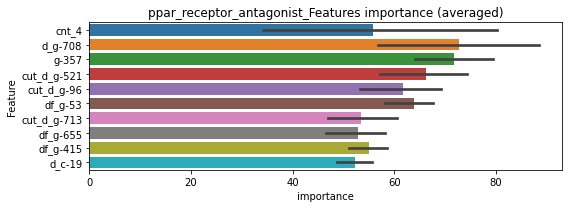

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170217	valid_1's binary_logloss: 0.0296381
[200]	training's binary_logloss: 0.00230796	valid_1's binary_logloss: 0.0139681
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.000837723	valid_1's binary_logloss: 0.0124025


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171953	valid_1's binary_logloss: 0.0314196
[200]	training's binary_logloss: 0.00240989	valid_1's binary_logloss: 0.0130055
[300]	training's binary_logloss: 0.000657172	valid_1's binary_logloss: 0.00973855
[400]	training's binary_logloss: 0.00031668	valid_1's binary_logloss: 0.00912249
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.000328614	valid_1's binary_logloss: 0.00911067


ppar_receptor_antagonist logloss: 0.01075660075326577


neg labels: 3289 → selected neg labels: 3271


progesterone_receptor_agonist, len(trt): 119, len(othr): 3271, target_rate: 0.0049971 → Adj_target_rate: 0.0048799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527595	valid_1's binary_logloss: 0.15087
[200]	training's binary_logloss: 0.0125189	valid_1's binary_logloss: 0.123624
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00783674	valid_1's binary_logloss: 0.120369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0581306	valid_1's binary_logloss: 0.133527
[200]	training's binary_logloss: 0.0144536	valid_1's binary_logloss: 0.0925336
[300]	training's binary_logloss: 0.00479124	valid_1's binary_logloss: 0.0829591
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00316282	valid_1's binary_logloss: 0.081838


1 / 3 AUC score:0.987
y_Threshold: 0.0266306, Threshold: 0.0375181, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 197 → Positive_corect_labels: 621/3728
p_label_rate: 0.0200904 Vs.target_rate: 0.00500
Num_p_label: 80.0, conf_0:0.03377, conf_1:0.04127
Num_p_label: 80.0, Expected: 19.9, Adj_threshold_1: 0.0375181
Num_p_label: 41.0, Expected: 19.9, Adj_threshold_2: 0.0475181
Num_p_label: 23.0, Expected: 19.9, Adj_threshold_3: 0.0575181
threshold: 0.0575181, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 621.0/3728, y_label_rate: 0.1665773
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490015	valid_1's binary_logloss: 0.113681
[200]	training's binary_logloss: 0.0104167	valid_1's binary_logloss: 0.0705532
[300]	training's binary_logloss: 0.00324805	valid_1's binary_logloss: 0.0599816
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00263934	valid_1's binary_logloss: 0.0588304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506123	valid_1's binary_logloss: 0.109039
[200]	training's binary_logloss: 0.0111276	valid_1's binary_logloss: 0.0670471
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00439617	valid_1's binary_logloss: 0.0576064


2 / 3 AUC score:0.997
y_Threshold: 0.0449399, Threshold: 0.0575181, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 604.0/3694
p_label_rate: 0.0082873 Vs.target_rate: 0.00500
Num_p_label: 33.0, conf_0:0.05177, conf_1:0.06327
threshold: 0.0575181, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 604.0/3694, y_label_rate: 0.1635084
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457192	valid_1's binary_logloss: 0.102921
[200]	training's binary_logloss: 0.00883806	valid_1's binary_logloss: 0.0605029
[300]	training's binary_logloss: 0.00278612	valid_1's binary_logloss: 0.0513248
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00176793	valid_1's binary_logloss: 0.0492087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477799	valid_1's binary_logloss: 0.102336
[200]	training's binary_logloss: 0.00978534	valid_1's binary_logloss: 0.0610725
[300]	training's binary_logloss: 0.00307307	valid_1's binary_logloss: 0.0517601
[400]	training's binary_logloss: 0.00144714	valid_1's binary_logloss: 0.0489048
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00135643	valid_1's binary_logloss: 0.048782


3 / 3 AUC score:0.998
y_Threshold: 0.0426423, Threshold: 0.0575181, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 592.0/3670
p_label_rate: 0.0035158 Vs.target_rate: 0.00500
Num_p_label: 14.0, conf_0:0.05177, conf_1:0.06327
threshold: 0.0575181, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 606.0/7652, y_label_rate: 0.0791950


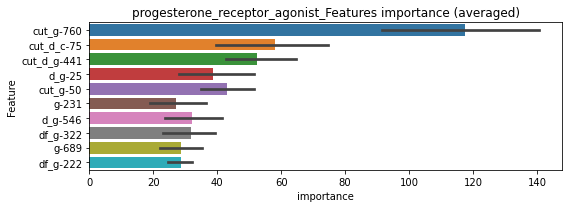

len(train_index) : 3826
len(valid_index) : 3826
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248793	valid_1's binary_logloss: 0.0608692
[200]	training's binary_logloss: 0.00492365	valid_1's binary_logloss: 0.0393804
[300]	training's binary_logloss: 0.00154084	valid_1's binary_logloss: 0.0357573
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00148479	valid_1's binary_logloss: 0.035659


len(train_index) : 3826
len(valid_index) : 3826
================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245221	valid_1's binary_logloss: 0.0638766
[200]	training's binary_logloss: 0.00513146	valid_1's binary_logloss: 0.0434947
[300]	training's binary_logloss: 0.00154061	valid_1's binary_logloss: 0.038823
[400]	training's binary_logloss: 0.000728738	valid_1's binary_logloss: 0.0376317
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000707298	valid_1's binary_logloss: 0.0375325


progesterone_receptor_agonist logloss: 0.036595712851137094


neg labels: 3289 → selected neg labels: 3286


progesterone_receptor_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219935	valid_1's binary_logloss: 0.0300763
[200]	training's binary_logloss: 0.00244083	valid_1's binary_logloss: 0.00513093
[300]	training's binary_logloss: 0.000679286	valid_1's binary_logloss: 0.00211875
[400]	training's binary_logloss: 0.000357691	valid_1's binary_logloss: 0.00140986
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000288915	valid_1's binary_logloss: 0.00124973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219714	valid_1's binary_logloss: 0.0289986
[200]	training's binary_logloss: 0.00248684	valid_1's binary_logloss: 0.00472525
[300]	training's binary_logloss: 0.000692381	valid_1's binary_logloss: 0.00187742
[400]	training's binary_logloss: 0.000369777	valid_1's binary_logloss: 0.00127637
[500]	training's binary_logloss: 0.00029838	valid_1's binary_logloss: 0.00113904
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0011913, Threshold: 0.0021849, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00197, conf_1:0.00240
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0021849
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.0121849
threshold: 0.0121849, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219717	valid_1's binary_logloss: 0.0301802
[200]	training's binary_logloss: 0.00239679	valid_1's binary_logloss: 0.0055904
[300]	training's binary_logloss: 0.00066989	valid_1's binary_logloss: 0.0024397
[400]	training's binary_logloss: 0.000356266	valid_1's binary_logloss: 0.00172184
[500]	training's binary_logloss: 0.00029226	valid_1's binary_logloss: 0.00157834
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000292319	valid_1's binary_logloss: 0.00157829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224337	valid_1's binary_logloss: 0.0300633
[200]	training's binary_logloss: 0.00249788	valid_1's binary_logloss: 0.00529625
[300]	training's binary_logloss: 0.000697998	valid_1's binary_logloss: 0.00235739
[400]	training's binary_logloss: 0.000369055	valid_1's binary_logloss: 0.00156593
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0614332, Threshold: 0.0121849, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0042692 Vs.target_rate: 0.00076
Num_p_label: 17.0, conf_0:0.01097, conf_1:0.01340
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_1: 0.0121849
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.0221849
threshold: 0.0221849, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219717	valid_1's binary_logloss: 0.0301802
[200]	training's binary_logloss: 0.00239679	valid_1's binary_logloss: 0.0055904
[300]	training's binary_logloss: 0.00066989	valid_1's binary_logloss: 0.0024397
[400]	training's binary_logloss: 0.000356266	valid_1's binary_logloss: 0.00172184
[500]	training's binary_logloss: 0.00029226	valid_1's binary_logloss: 0.00157834
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000292319	valid_1's binary_logloss: 0.00157829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224337	valid_1's binary_logloss: 0.0300633
[200]	training's binary_logloss: 0.00249788	valid_1's binary_logloss: 0.00529625
[300]	training's binary_logloss: 0.000697998	valid_1's binary_logloss: 0.00235739
[400]	training's binary_logloss: 0.000369055	valid_1's binary_logloss: 0.00156593
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0614332, Threshold: 0.0221849, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.01997, conf_1:0.02440
threshold: 0.0221849, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


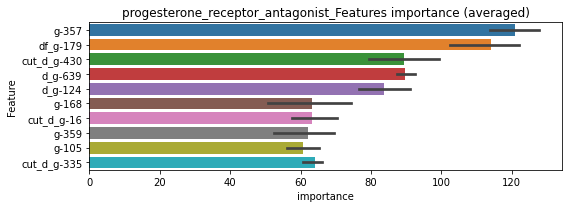

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114615	valid_1's binary_logloss: 0.0186873
[200]	training's binary_logloss: 0.00124191	valid_1's binary_logloss: 0.00753695
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.000385438	valid_1's binary_logloss: 0.0067141


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119839	valid_1's binary_logloss: 0.0182483
[200]	training's binary_logloss: 0.00133218	valid_1's binary_logloss: 0.00539546
[300]	training's binary_logloss: 0.00036788	valid_1's binary_logloss: 0.00365291
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000259399	valid_1's binary_logloss: 0.00344006


progesterone_receptor_antagonist logloss: 0.005077287104087874


neg labels: 3289 → selected neg labels: 3283


prostaglandin_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304037	valid_1's binary_logloss: 0.0545371
[200]	training's binary_logloss: 0.00439321	valid_1's binary_logloss: 0.0226897
[300]	training's binary_logloss: 0.00127479	valid_1's binary_logloss: 0.0173398
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000826171	valid_1's binary_logloss: 0.0163297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335234	valid_1's binary_logloss: 0.0513659
[200]	training's binary_logloss: 0.00511766	valid_1's binary_logloss: 0.0178208
[300]	training's binary_logloss: 0.00146241	valid_1's binary_logloss: 0.0123062
[400]	training's binary_logloss: 0.000726756	valid_1's binary_logloss: 0.0108582
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.000718735	valid_1's binary_logloss: 0.010839


1 / 3 AUC score:1.000
y_Threshold: 0.0043545, Threshold: 0.0064926, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00584, conf_1:0.00714
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0064926
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_2: 0.0164926
threshold: 0.0164926, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316939	valid_1's binary_logloss: 0.0515825
[200]	training's binary_logloss: 0.00467743	valid_1's binary_logloss: 0.0167376
[300]	training's binary_logloss: 0.00136869	valid_1's binary_logloss: 0.0106567
[400]	training's binary_logloss: 0.00069137	valid_1's binary_logloss: 0.00901618
[500]	training's binary_logloss: 0.000469714	valid_1's binary_logloss: 0.00813824
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000447561	valid_1's binary_logloss: 0.00806368
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325608	valid_1's binary_logloss: 0.0485563
[200]	training's binary_logloss: 0.00492538	valid_1's binary_logloss: 0.0140946
[300]	training's binary_logloss: 0.00140069	valid_1's binary_logloss: 0.00740571
[400]	training's binary_logloss: 0.000702283	valid_1's binary_logloss: 0.00570998
[500]	training's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0231014, Threshold: 0.0164926, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0032647 Vs.target_rate: 0.00151
Num_p_label: 13.0, conf_0:0.01484, conf_1:0.01814
threshold: 0.0164926, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316939	valid_1's binary_logloss: 0.0515825
[200]	training's binary_logloss: 0.00467743	valid_1's binary_logloss: 0.0167376
[300]	training's binary_logloss: 0.00136869	valid_1's binary_logloss: 0.0106567
[400]	training's binary_logloss: 0.00069137	valid_1's binary_logloss: 0.00901618
[500]	training's binary_logloss: 0.000469714	valid_1's binary_logloss: 0.00813824
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000447561	valid_1's binary_logloss: 0.00806368
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325608	valid_1's binary_logloss: 0.0485563
[200]	training's binary_logloss: 0.00492538	valid_1's binary_logloss: 0.0140946
[300]	training's binary_logloss: 0.00140069	valid_1's binary_logloss: 0.00740571
[400]	training's binary_logloss: 0.000702283	valid_1's binary_logloss: 0.00570998
[500]	training's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0231014, Threshold: 0.0164926, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0032647 Vs.target_rate: 0.00151
Num_p_label: 13.0, conf_0:0.01484, conf_1:0.01814
threshold: 0.0164926, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 668.0/7787, y_label_rate: 0.0857840


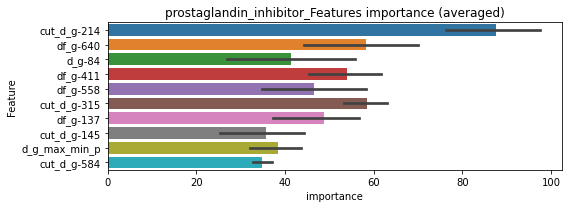

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179956	valid_1's binary_logloss: 0.0369968
[200]	training's binary_logloss: 0.00270378	valid_1's binary_logloss: 0.0191523
[300]	training's binary_logloss: 0.00075354	valid_1's binary_logloss: 0.0166747
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000789076	valid_1's binary_logloss: 0.0166543


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175934	valid_1's binary_logloss: 0.0345459
[200]	training's binary_logloss: 0.00269059	valid_1's binary_logloss: 0.0155348
[300]	training's binary_logloss: 0.000784031	valid_1's binary_logloss: 0.0119663
[400]	training's binary_logloss: 0.000385666	valid_1's binary_logloss: 0.0108552
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000348584	valid_1's binary_logloss: 0.0107234


prostaglandin_inhibitor logloss: 0.013689257993611469


neg labels: 3289 → selected neg labels: 3274


prostanoid_receptor_antagonist, len(trt): 84, len(othr): 3274, target_rate: 0.0035273 → Adj_target_rate: 0.0036294
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463537	valid_1's binary_logloss: 0.122259
[200]	training's binary_logloss: 0.00967125	valid_1's binary_logloss: 0.0874898
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00472765	valid_1's binary_logloss: 0.0824663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522975	valid_1's binary_logloss: 0.107352
[200]	training's binary_logloss: 0.0109529	valid_1's binary_logloss: 0.0622763
[300]	training's binary_logloss: 0.00331792	valid_1's binary_logloss: 0.0508224
[400]	training's binary_logloss: 0.00156338	valid_1's binary_logloss: 0.0479055
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.0015825	valid_1's binary_logloss: 0.0478785


1 / 3 AUC score:0.995
y_Threshold: 0.0152446, Threshold: 0.0166579, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 645/3778
p_label_rate: 0.0200904 Vs.target_rate: 0.00353
Num_p_label: 80.0, conf_0:0.01499, conf_1:0.01832
Num_p_label: 80.0, Expected: 14.0, Adj_threshold_1: 0.0166579
Num_p_label: 24.0, Expected: 14.0, Adj_threshold_2: 0.0266579
threshold: 0.0266579, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 645.0/3778, y_label_rate: 0.1707253
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471062	valid_1's binary_logloss: 0.116773
[200]	training's binary_logloss: 0.00939928	valid_1's binary_logloss: 0.0751572
[300]	training's binary_logloss: 0.00286931	valid_1's binary_logloss: 0.0654447
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00256777	valid_1's binary_logloss: 0.0645966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505793	valid_1's binary_logloss: 0.107157
[200]	training's binary_logloss: 0.0105662	valid_1's binary_logloss: 0.0626977
[300]	training's binary_logloss: 0.00314503	valid_1's binary_logloss: 0.0522431
[400]	training's binary_logloss: 0.00148364	valid_1's binary_logloss: 0.048346
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00148364	valid_1's binary_logloss: 0.048346


2 / 3 AUC score:0.999
y_Threshold: 0.0251851, Threshold: 0.0266579, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 633.0/3754
p_label_rate: 0.0065294 Vs.target_rate: 0.00353
Num_p_label: 26.0, conf_0:0.02399, conf_1:0.02932
threshold: 0.0266579, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 633.0/3754, y_label_rate: 0.1686201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453413	valid_1's binary_logloss: 0.102677
[200]	training's binary_logloss: 0.00884534	valid_1's binary_logloss: 0.0608229
[300]	training's binary_logloss: 0.00271112	valid_1's binary_logloss: 0.0514644
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00181778	valid_1's binary_logloss: 0.0501054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493268	valid_1's binary_logloss: 0.0901287
[200]	training's binary_logloss: 0.0101277	valid_1's binary_logloss: 0.0448344
[300]	training's binary_logloss: 0.00305049	valid_1's binary_logloss: 0.0335917
[400]	training's binary_logloss: 0.00146191	valid_1's binary_logloss: 0.0299573
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000969977	valid_1's binary_logloss: 0.0284144


3 / 3 AUC score:0.999
y_Threshold: 0.0290147, Threshold: 0.0266579, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 627.0/3742
p_label_rate: 0.0017579 Vs.target_rate: 0.00353
Num_p_label: 7.0, conf_0:0.02399, conf_1:0.02932
threshold: 0.0266579, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 634.0/7724, y_label_rate: 0.0820818


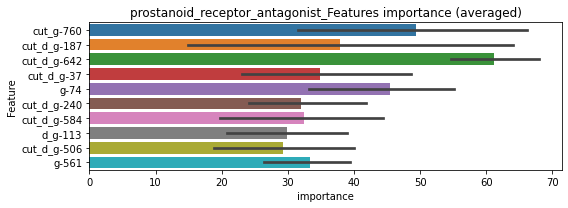

len(train_index) : 3862
len(valid_index) : 3862
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252561	valid_1's binary_logloss: 0.0580231
[200]	training's binary_logloss: 0.0048976	valid_1's binary_logloss: 0.0364256
[300]	training's binary_logloss: 0.00144905	valid_1's binary_logloss: 0.0319867
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000827212	valid_1's binary_logloss: 0.0305384


len(train_index) : 3862
len(valid_index) : 3862
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256659	valid_1's binary_logloss: 0.0572728
[200]	training's binary_logloss: 0.00508645	valid_1's binary_logloss: 0.0346603
[300]	training's binary_logloss: 0.0015298	valid_1's binary_logloss: 0.0288159
[400]	training's binary_logloss: 0.000702196	valid_1's binary_logloss: 0.0273014
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000597705	valid_1's binary_logloss: 0.0268628


prostanoid_receptor_antagonist logloss: 0.02870060481151405


neg labels: 3289 → selected neg labels: 3285


proteasome_inhibitor, len(trt): 726, len(othr): 3285, target_rate: 0.0304863 → Adj_target_rate: 0.0226983
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206957	valid_1's binary_logloss: 0.0229358
[200]	training's binary_logloss: 0.00195345	valid_1's binary_logloss: 0.00625612
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00075048	valid_1's binary_logloss: 0.00511006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192925	valid_1's binary_logloss: 0.0266817
[200]	training's binary_logloss: 0.00180546	valid_1's binary_logloss: 0.0101984
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.000660529	valid_1's binary_logloss: 0.00912438


1 / 3 AUC score:1.000
y_Threshold: 0.0003223, Threshold: 0.9986386, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 161 → Positive_corect_labels: 726/3850
p_label_rate: 0.0200904 Vs.target_rate: 0.03049
Num_p_label: 80.0, conf_0:0.89877, conf_1:1.09850
threshold: 0.9986386, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 726.0/3850, y_label_rate: 0.1885714
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155311	valid_1's binary_logloss: 0.0158079
[200]	training's binary_logloss: 0.000996536	valid_1's binary_logloss: 0.00111409
[300]	training's binary_logloss: 0.000220538	valid_1's binary_logloss: 0.000282798
[400]	training's binary_logloss: 0.000146433	valid_1's binary_logloss: 0.000200333
[500]	training's binary_logloss: 0.000133352	valid_1's binary_logloss: 0.000185166
[600]	training's binary_logloss: 0.000130634	valid_1's binary_logloss: 0.000181969
[700]	training's binary_logloss: 0.000129176	valid_1's binary_logloss: 0.00018028
Early stopping, best iteration is:
[700]	training's binary_logloss: 0.000129176	valid_1's binary_logloss: 0.00018028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157755	valid_1's binary_logloss: 0.0164807
[200]	training's binary_logloss: 0.00102249	valid_1's binary_logloss: 0.00128513
[300]	training's binary_lo

2 / 3 AUC score:1.000
y_Threshold: 0.1804574, Threshold: 0.9986386, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 0 → Positive_corect_labels: 726.0/3850
p_label_rate: 0.0381718 Vs.target_rate: 0.03049
Num_p_label: 152.0, conf_0:0.89877, conf_1:1.09850
threshold: 0.9986386, positive_p_label: 152.0/3982, p_label_rate: 0.0381718
positive_y_label: 726.0/3850, y_label_rate: 0.1885714
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155311	valid_1's binary_logloss: 0.0158079
[200]	training's binary_logloss: 0.000996536	valid_1's binary_logloss: 0.00111409
[300]	training's binary_logloss: 0.000220538	valid_1's binary_logloss: 0.000282798
[400]	training's binary_logloss: 0.000146433	valid_1's binary_logloss: 0.000200333
[500]	training's binary_logloss: 0.000133352	valid_1's binary_logloss: 0.000185166
[600]	training's binary_logloss: 0.000130634	valid_1's binary_logloss: 0.000181969
[700]	training's binary_logloss: 0.000129176	valid_1's binary_logloss: 0.00018028
Early stopping, best iteration is:
[700]	training's binary_logloss: 0.000129176	valid_1's binary_logloss: 0.00018028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157755	valid_1's binary_logloss: 0.0164807
[200]	training's binary_logloss: 0.00102249	valid_1's binary_logloss: 0.00128513
[300]	training's binary_lo

3 / 3 AUC score:1.000
y_Threshold: 0.1804574, Threshold: 0.9986386, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 0 → Positive_corect_labels: 726.0/3850
p_label_rate: 0.0381718 Vs.target_rate: 0.03049
Num_p_label: 152.0, conf_0:0.89877, conf_1:1.09850
threshold: 0.9986386, positive_p_label: 152.0/3982, p_label_rate: 0.0381718
positive_y_label: 878.0/7832, y_label_rate: 0.1121042


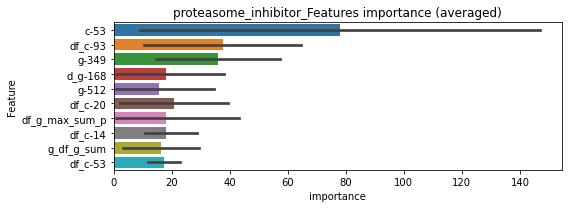

len(train_index) : 3916
len(valid_index) : 3916
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109697	valid_1's binary_logloss: 0.0131568
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00115958	valid_1's binary_logloss: 0.0049041


len(train_index) : 3916
len(valid_index) : 3916
================================= fold 2/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108946	valid_1's binary_logloss: 0.0145097
[200]	training's binary_logloss: 0.000787811	valid_1's binary_logloss: 0.00508884
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.000283516	valid_1's binary_logloss: 0.00480337


proteasome_inhibitor logloss: 0.004853731886698517


neg labels: 3289 → selected neg labels: 3281


protein_kinase_inhibitor, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360719	valid_1's binary_logloss: 0.0690546
[200]	training's binary_logloss: 0.00582141	valid_1's binary_logloss: 0.031379
[300]	training's binary_logloss: 0.00166313	valid_1's binary_logloss: 0.0239902
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.001116	valid_1's binary_logloss: 0.0227077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376325	valid_1's binary_logloss: 0.062035
[200]	training's binary_logloss: 0.00644103	valid_1's binary_logloss: 0.0232656
[300]	training's binary_logloss: 0.00185225	valid_1's binary_logloss: 0.0148552
[400]	training's binary_logloss: 0.000905172	valid_1's binary_logloss: 0.0121797
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000618688	valid_1's binary_logloss: 0.011066


1 / 3 AUC score:1.000
y_Threshold: 0.0044986, Threshold: 0.0081710, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.00735, conf_1:0.00899
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0081710
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_2: 0.0181710
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_3: 0.0281710
threshold: 0.0281710, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356621	valid_1's binary_logloss: 0.066267
[200]	training's binary_logloss: 0.00569629	valid_1's binary_logloss: 0.0302798
[300]	training's binary_logloss: 0.00163751	valid_1's binary_logloss: 0.0240465
[400]	training's binary_logloss: 0.000814936	valid_1's binary_logloss: 0.0219073
[500]	training's binary_logloss: 0.000536771	valid_1's binary_logloss: 0.0204473
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000508085	valid_1's binary_logloss: 0.0202716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390536	valid_1's binary_logloss: 0.0607474
[200]	training's binary_logloss: 0.00648338	valid_1's binary_logloss: 0.0210872
[300]	training's binary_logloss: 0.00188026	valid_1's binary_logloss: 0.0124633
[400]	training's binary_logloss: 0.000913511	valid_1's binary_logloss: 0.00951689
[500]	training's binary_logloss: 0.000592

2 / 3 AUC score:1.000
y_Threshold: 0.0153090, Threshold: 0.0281710, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0047715 Vs.target_rate: 0.00202
Num_p_label: 19.0, conf_0:0.02535, conf_1:0.03099
threshold: 0.0281710, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036421	valid_1's binary_logloss: 0.0623232
[200]	training's binary_logloss: 0.00599418	valid_1's binary_logloss: 0.0267642
[300]	training's binary_logloss: 0.0017556	valid_1's binary_logloss: 0.018215
[400]	training's binary_logloss: 0.000855974	valid_1's binary_logloss: 0.0160208
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000623739	valid_1's binary_logloss: 0.0150664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362238	valid_1's binary_logloss: 0.062563
[200]	training's binary_logloss: 0.00583595	valid_1's binary_logloss: 0.0259131
[300]	training's binary_logloss: 0.00169357	valid_1's binary_logloss: 0.0187277
[400]	training's binary_logloss: 0.000840255	valid_1's binary_logloss: 0.0168637
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000579373	valid_1's binary_logloss: 0.0160367


3 / 3 AUC score:1.000
y_Threshold: 0.0175778, Threshold: 0.0281710, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3799
p_label_rate: 0.0050226 Vs.target_rate: 0.00202
Num_p_label: 20.0, conf_0:0.02535, conf_1:0.03099
threshold: 0.0281710, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 673.0/7781, y_label_rate: 0.0864927


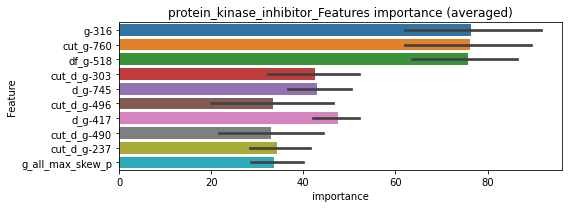

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197826	valid_1's binary_logloss: 0.0494882
[200]	training's binary_logloss: 0.00313879	valid_1's binary_logloss: 0.0309886
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00136093	valid_1's binary_logloss: 0.0283649


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221035	valid_1's binary_logloss: 0.0372821
[200]	training's binary_logloss: 0.00373292	valid_1's binary_logloss: 0.0181357
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00181524	valid_1's binary_logloss: 0.0160266


protein_kinase_inhibitor logloss: 0.022196519382069773


neg labels: 3289 → selected neg labels: 3286


protein_phosphatase_inhibitor, len(trt): 24, len(othr): 3286, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241391	valid_1's binary_logloss: 0.0364925
[200]	training's binary_logloss: 0.00289841	valid_1's binary_logloss: 0.0106299
[300]	training's binary_logloss: 0.000818817	valid_1's binary_logloss: 0.00688257
[400]	training's binary_logloss: 0.000431666	valid_1's binary_logloss: 0.0060326
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000420998	valid_1's binary_logloss: 0.00597632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237487	valid_1's binary_logloss: 0.0353741
[200]	training's binary_logloss: 0.00292958	valid_1's binary_logloss: 0.0083949
[300]	training's binary_logloss: 0.000845723	valid_1's binary_logloss: 0.00457242
[400]	training's binary_logloss: 0.000435948	valid_1's binary_logloss: 0.00347898
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000351532	valid_1's binary_logloss: 0.00322991

1 / 3 AUC score:1.000
y_Threshold: 0.0020359, Threshold: 0.0033176, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00299, conf_1:0.00365
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0033176
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_2: 0.0133176
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_3: 0.0233176
threshold: 0.0233176, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237607	valid_1's binary_logloss: 0.0343186
[200]	training's binary_logloss: 0.0028525	valid_1's binary_logloss: 0.0101086
[300]	training's binary_logloss: 0.000815004	valid_1's binary_logloss: 0.00770885
[400]	training's binary_logloss: 0.000422156	valid_1's binary_logloss: 0.00685497
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00044122	valid_1's binary_logloss: 0.00681572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242412	valid_1's binary_logloss: 0.0346212
[200]	training's binary_logloss: 0.00288362	valid_1's binary_logloss: 0.00763589
[300]	training's binary_logloss: 0.00081616	valid_1's binary_logloss: 0.00406198
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000449461	valid_1's binary_logloss: 0.00332259


2 / 3 AUC score:1.000
y_Threshold: 0.0091396, Threshold: 0.0233176, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0065294 Vs.target_rate: 0.00101
Num_p_label: 26.0, conf_0:0.02099, conf_1:0.02565
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_1: 0.0233176
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_2: 0.0333176
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_3: 0.0433176
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_4: 0.0533176
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_5: 0.0633176
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_6: 0.0733176
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_7: 0.0833176
threshold: 0.0833176, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239656	valid_1's binary_logloss: 0.0357037
[200]	training's binary_logloss: 0.00283335	valid_1's binary_logloss: 0.00975617
[300]	training's binary_logloss: 0.000798117	valid_1's binary_logloss: 0.00612852
[400]	training's binary_logloss: 0.000418522	valid_1's binary_logloss: 0.0052992
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00034849	valid_1's binary_logloss: 0.00510674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240325	valid_1's binary_logloss: 0.0319905
[200]	training's binary_logloss: 0.00287061	valid_1's binary_logloss: 0.00538967
[300]	training's binary_logloss: 0.000820506	valid_1's binary_logloss: 0.00193609
[400]	training's binary_logloss: 0.000426374	valid_1's binary_logloss: 0.00113511
[500]	training's binary_logloss: 0.000331976	valid_1's binary_logloss: 0.000933575
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.0182499, Threshold: 0.0833176, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0017579 Vs.target_rate: 0.00101
Num_p_label: 7.0, conf_0:0.07499, conf_1:0.09165
threshold: 0.0833176, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 663.0/7791, y_label_rate: 0.0850982


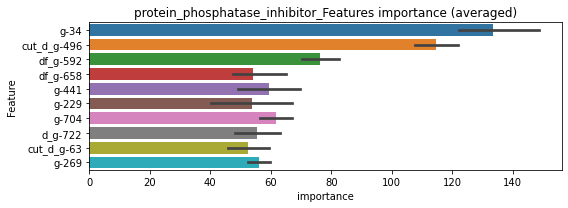

len(train_index) : 3895
len(valid_index) : 3896
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126654	valid_1's binary_logloss: 0.0216464
[200]	training's binary_logloss: 0.00149724	valid_1's binary_logloss: 0.00758813
[300]	training's binary_logloss: 0.00042228	valid_1's binary_logloss: 0.00580589
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000279831	valid_1's binary_logloss: 0.00555588


len(train_index) : 3896
len(valid_index) : 3895
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129895	valid_1's binary_logloss: 0.019602
[200]	training's binary_logloss: 0.00153865	valid_1's binary_logloss: 0.00516783
[300]	training's binary_logloss: 0.000437217	valid_1's binary_logloss: 0.00327114
[400]	training's binary_logloss: 0.000225516	valid_1's binary_logloss: 0.00286665
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000180228	valid_1's binary_logloss: 0.00276499


protein_phosphatase_inhibitor logloss: 0.0041606113684741165


neg labels: 3289 → selected neg labels: 3271


protein_synthesis_inhibitor, len(trt): 103, len(othr): 3271, target_rate: 0.0043252 → Adj_target_rate: 0.0043163
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498527	valid_1's binary_logloss: 0.115792
[200]	training's binary_logloss: 0.0103356	valid_1's binary_logloss: 0.0723807
[300]	training's binary_logloss: 0.00319204	valid_1's binary_logloss: 0.0618002
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00177382	valid_1's binary_logloss: 0.0592872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518602	valid_1's binary_logloss: 0.115268
[200]	training's binary_logloss: 0.0106916	valid_1's binary_logloss: 0.0687644
[300]	training's binary_logloss: 0.00329709	valid_1's binary_logloss: 0.0571916
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00181661	valid_1's binary_logloss: 0.0546169


1 / 3 AUC score:0.996
y_Threshold: 0.0106889, Threshold: 0.0560179, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 151 → Positive_corect_labels: 644/3774
p_label_rate: 0.0200904 Vs.target_rate: 0.00433
Num_p_label: 80.0, conf_0:0.05042, conf_1:0.06162
Num_p_label: 80.0, Expected: 17.2, Adj_threshold_1: 0.0560179
Num_p_label: 69.0, Expected: 17.2, Adj_threshold_2: 0.0660179
Num_p_label: 65.0, Expected: 17.2, Adj_threshold_3: 0.0760179
Num_p_label: 63.0, Expected: 17.2, Adj_threshold_4: 0.0860179
Num_p_label: 59.0, Expected: 17.2, Adj_threshold_5: 0.0960179
Num_p_label: 54.0, Expected: 17.2, Adj_threshold_6: 0.1060179
Num_p_label: 51.0, Expected: 17.2, Adj_threshold_7: 0.1160179
Num_p_label: 47.0, Expected: 17.2, Adj_threshold_8: 0.1260179
Num_p_label: 44.0, Expected: 17.2, Adj_threshold_9: 0.1360179
Num_p_label: 42.0, Expected: 17.2, Adj_threshold_10: 0.1460179
threshold: 0.1560179, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 644.0/3774, y_label_rate: 0.1706412

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469605	valid_1's binary_logloss: 0.112419
[200]	training's binary_logloss: 0.00911312	valid_1's binary_logloss: 0.0654067
[300]	training's binary_logloss: 0.00279307	valid_1's binary_logloss: 0.0539903
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00243866	valid_1's binary_logloss: 0.0531615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495756	valid_1's binary_logloss: 0.117713
[200]	training's binary_logloss: 0.0098672	valid_1's binary_logloss: 0.0754873
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00405759	valid_1's binary_logloss: 0.0684269


2 / 3 AUC score:0.997
y_Threshold: 0.0478635, Threshold: 0.1560179, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 627.0/3740
p_label_rate: 0.0318935 Vs.target_rate: 0.00433
Num_p_label: 127.0, conf_0:0.14042, conf_1:0.17162
Num_p_label: 127.0, Expected: 17.2, Adj_threshold_1: 0.1560179
Num_p_label: 125.0, Expected: 17.2, Adj_threshold_2: 0.1660179
Num_p_label: 122.0, Expected: 17.2, Adj_threshold_3: 0.1760179
Num_p_label: 117.0, Expected: 17.2, Adj_threshold_4: 0.1860179
Num_p_label: 113.0, Expected: 17.2, Adj_threshold_5: 0.1960179
Num_p_label: 112.0, Expected: 17.2, Adj_threshold_6: 0.2060179
Num_p_label: 111.0, Expected: 17.2, Adj_threshold_7: 0.2160179
Num_p_label: 107.0, Expected: 17.2, Adj_threshold_8: 0.2260179
Num_p_label: 103.0, Expected: 17.2, Adj_threshold_9: 0.2360179
Num_p_label: 101.0, Expected: 17.2, Adj_threshold_10: 0.2460179
threshold: 0.2560179, positive_p_label: 100.0/3982, p_label_rate: 0.0251130
positive_y_label: 627.0/3740, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443514	valid_1's binary_logloss: 0.111949
[200]	training's binary_logloss: 0.00845331	valid_1's binary_logloss: 0.0729722
[300]	training's binary_logloss: 0.00254643	valid_1's binary_logloss: 0.0635254
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00170421	valid_1's binary_logloss: 0.0608304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468503	valid_1's binary_logloss: 0.0977523
[200]	training's binary_logloss: 0.00898516	valid_1's binary_logloss: 0.0538159
[300]	training's binary_logloss: 0.00274698	valid_1's binary_logloss: 0.0455757
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00274698	valid_1's binary_logloss: 0.0455757


3 / 3 AUC score:0.998
y_Threshold: 0.0589795, Threshold: 0.2560179, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 612.0/3710
p_label_rate: 0.0316424 Vs.target_rate: 0.00433
Num_p_label: 126.0, conf_0:0.23042, conf_1:0.28162
Num_p_label: 126.0, Expected: 17.2, Adj_threshold_1: 0.2560179
Num_p_label: 122.0, Expected: 17.2, Adj_threshold_2: 0.2660179
Num_p_label: 119.0, Expected: 17.2, Adj_threshold_3: 0.2760179
Num_p_label: 115.0, Expected: 17.2, Adj_threshold_4: 0.2860179
Num_p_label: 114.0, Expected: 17.2, Adj_threshold_5: 0.2960179
Num_p_label: 113.0, Expected: 17.2, Adj_threshold_6: 0.3060179
Num_p_label: 113.0, Expected: 17.2, Adj_threshold_7: 0.3160179
Num_p_label: 109.0, Expected: 17.2, Adj_threshold_8: 0.3260179
Num_p_label: 107.0, Expected: 17.2, Adj_threshold_9: 0.3360179
Num_p_label: 102.0, Expected: 17.2, Adj_threshold_10: 0.3460179
threshold: 0.3560179, positive_p_label: 98.0/3982, p_label_rate: 0.0246107
positive_y_label: 710.0/7692, y_label_rat

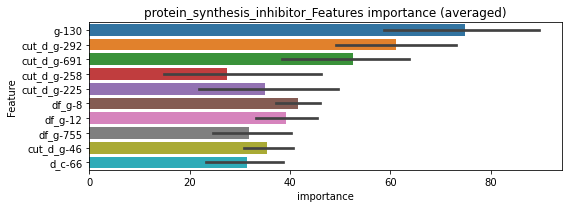

len(train_index) : 3846
len(valid_index) : 3846
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282093	valid_1's binary_logloss: 0.0643838
[200]	training's binary_logloss: 0.00544154	valid_1's binary_logloss: 0.0383503
[300]	training's binary_logloss: 0.00157907	valid_1's binary_logloss: 0.0316219
[400]	training's binary_logloss: 0.000752221	valid_1's binary_logloss: 0.0298549
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000579381	valid_1's binary_logloss: 0.0292793


len(train_index) : 3846
len(valid_index) : 3846
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287923	valid_1's binary_logloss: 0.0637162
[200]	training's binary_logloss: 0.00562234	valid_1's binary_logloss: 0.0404027
[300]	training's binary_logloss: 0.00165393	valid_1's binary_logloss: 0.0356895
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000866547	valid_1's binary_logloss: 0.0342873


protein_synthesis_inhibitor logloss: 0.031783306977396675


neg labels: 3289 → selected neg labels: 3285


protein_tyrosine_kinase_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232904	valid_1's binary_logloss: 0.0352943
[200]	training's binary_logloss: 0.0028113	valid_1's binary_logloss: 0.0091907
[300]	training's binary_logloss: 0.000799206	valid_1's binary_logloss: 0.00490548
[400]	training's binary_logloss: 0.000412261	valid_1's binary_logloss: 0.00376816
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000333515	valid_1's binary_logloss: 0.003552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238136	valid_1's binary_logloss: 0.0288161
[200]	training's binary_logloss: 0.00294549	valid_1's binary_logloss: 0.0042165
[300]	training's binary_logloss: 0.000840576	valid_1's binary_logloss: 0.0013687
[400]	training's binary_logloss: 0.000437004	valid_1's binary_logloss: 0.000766145
[500]	training's binary_logloss: 0.000340995	valid_1's binary_logloss: 0.000616202
[600]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0012979, Threshold: 0.0019199, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00173, conf_1:0.00211
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0019199
Num_p_label: 2.0, Expected: 3.2, Adj_threshold_2: 0.0119199
threshold: 0.0119199, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237338	valid_1's binary_logloss: 0.0355688
[200]	training's binary_logloss: 0.00280864	valid_1's binary_logloss: 0.00888679
[300]	training's binary_logloss: 0.000801871	valid_1's binary_logloss: 0.00476009
[400]	training's binary_logloss: 0.000417095	valid_1's binary_logloss: 0.00356468
[500]	training's binary_logloss: 0.000328485	valid_1's binary_logloss: 0.0033159
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000330387	valid_1's binary_logloss: 0.00331034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238873	valid_1's binary_logloss: 0.0286474
[200]	training's binary_logloss: 0.00291504	valid_1's binary_logloss: 0.00402127
[300]	training's binary_logloss: 0.000838419	valid_1's binary_logloss: 0.00131089
[400]	training's binary_logloss: 0.00044196	valid_1's binary_logloss: 0.000745069
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.0498913, Threshold: 0.0119199, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0012557 Vs.target_rate: 0.00080
Num_p_label: 5.0, conf_0:0.01073, conf_1:0.01311
threshold: 0.0119199, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237338	valid_1's binary_logloss: 0.0355688
[200]	training's binary_logloss: 0.00280864	valid_1's binary_logloss: 0.00888679
[300]	training's binary_logloss: 0.000801871	valid_1's binary_logloss: 0.00476009
[400]	training's binary_logloss: 0.000417095	valid_1's binary_logloss: 0.00356468
[500]	training's binary_logloss: 0.000328485	valid_1's binary_logloss: 0.0033159
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000330387	valid_1's binary_logloss: 0.00331034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238873	valid_1's binary_logloss: 0.0286474
[200]	training's binary_logloss: 0.00291504	valid_1's binary_logloss: 0.00402127
[300]	training's binary_logloss: 0.000838419	valid_1's binary_logloss: 0.00131089
[400]	training's binary_logloss: 0.00044196	valid_1's binary_logloss: 0.000745069
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.0498913, Threshold: 0.0119199, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0012557 Vs.target_rate: 0.00080
Num_p_label: 5.0, conf_0:0.01073, conf_1:0.01311
threshold: 0.0119199, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7792, y_label_rate: 0.0849589


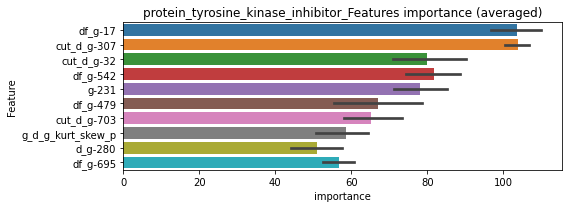

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129115	valid_1's binary_logloss: 0.0204948
[200]	training's binary_logloss: 0.00153164	valid_1's binary_logloss: 0.00791789
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.000604984	valid_1's binary_logloss: 0.00706899


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129716	valid_1's binary_logloss: 0.0192133
[200]	training's binary_logloss: 0.00189518	valid_1's binary_logloss: 0.0049721
[300]	training's binary_logloss: 0.000929103	valid_1's binary_logloss: 0.00293214
[400]	training's binary_logloss: 0.000867454	valid_1's binary_logloss: 0.00249922
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000372116	valid_1's binary_logloss: 0.00232864


protein_tyrosine_kinase_inhibitor logloss: 0.004698817284785748


neg labels: 3289 → selected neg labels: 3281


radiopaque_medium, len(trt): 56, len(othr): 3281, target_rate: 0.0023516 → Adj_target_rate: 0.0025713
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409454	valid_1's binary_logloss: 0.087506
[200]	training's binary_logloss: 0.00728025	valid_1's binary_logloss: 0.0497931
[300]	training's binary_logloss: 0.0021517	valid_1's binary_logloss: 0.04267
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00183448	valid_1's binary_logloss: 0.0419821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438489	valid_1's binary_logloss: 0.0745018
[200]	training's binary_logloss: 0.00835285	valid_1's binary_logloss: 0.0322018
[300]	training's binary_logloss: 0.00245136	valid_1's binary_logloss: 0.0221648
[400]	training's binary_logloss: 0.00114538	valid_1's binary_logloss: 0.0185037
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000992008	valid_1's binary_logloss: 0.0181426


1 / 3 AUC score:0.999
y_Threshold: 0.0076965, Threshold: 0.0109014, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 654/3801
p_label_rate: 0.0200904 Vs.target_rate: 0.00235
Num_p_label: 80.0, conf_0:0.00981, conf_1:0.01199
Num_p_label: 80.0, Expected: 9.4, Adj_threshold_1: 0.0109014
Num_p_label: 22.0, Expected: 9.4, Adj_threshold_2: 0.0209014
Num_p_label: 5.0, Expected: 9.4, Adj_threshold_3: 0.0309014
threshold: 0.0309014, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399631	valid_1's binary_logloss: 0.0824626
[200]	training's binary_logloss: 0.00704732	valid_1's binary_logloss: 0.0453728
[300]	training's binary_logloss: 0.00206856	valid_1's binary_logloss: 0.038305
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00133764	valid_1's binary_logloss: 0.0366379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432692	valid_1's binary_logloss: 0.0735314
[200]	training's binary_logloss: 0.00800467	valid_1's binary_logloss: 0.0301543
[300]	training's binary_logloss: 0.00236021	valid_1's binary_logloss: 0.0205782
[400]	training's binary_logloss: 0.00110549	valid_1's binary_logloss: 0.0174483
[500]	training's binary_logloss: 0.000700492	valid_1's binary_logloss: 0.0161607
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000675932	valid_1's binary_logloss: 0.0160431


2 / 3 AUC score:1.000
y_Threshold: 0.0208764, Threshold: 0.0309014, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 651.0/3795
p_label_rate: 0.0055249 Vs.target_rate: 0.00235
Num_p_label: 22.0, conf_0:0.02781, conf_1:0.03399
threshold: 0.0309014, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 651.0/3795, y_label_rate: 0.1715415
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405998	valid_1's binary_logloss: 0.0797551
[200]	training's binary_logloss: 0.00695202	valid_1's binary_logloss: 0.0407854
[300]	training's binary_logloss: 0.00202487	valid_1's binary_logloss: 0.0333354
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00147181	valid_1's binary_logloss: 0.0324168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424522	valid_1's binary_logloss: 0.0767432
[200]	training's binary_logloss: 0.00767372	valid_1's binary_logloss: 0.0376472
[300]	training's binary_logloss: 0.00225271	valid_1's binary_logloss: 0.0298307
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00150783	valid_1's binary_logloss: 0.0286981


3 / 3 AUC score:1.000
y_Threshold: 0.0233044, Threshold: 0.0309014, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 646.0/3785
p_label_rate: 0.0062783 Vs.target_rate: 0.00235
Num_p_label: 25.0, conf_0:0.02781, conf_1:0.03399
threshold: 0.0309014, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 671.0/7767, y_label_rate: 0.0863911


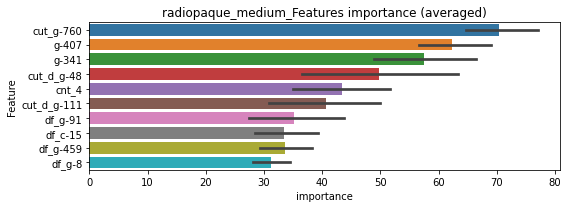

len(train_index) : 3883
len(valid_index) : 3884
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232957	valid_1's binary_logloss: 0.050575
[200]	training's binary_logloss: 0.00420441	valid_1's binary_logloss: 0.0318081
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.0017155	valid_1's binary_logloss: 0.0298963


len(train_index) : 3884
len(valid_index) : 3883
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253878	valid_1's binary_logloss: 0.0577714
[200]	training's binary_logloss: 0.00450409	valid_1's binary_logloss: 0.0374261
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00182487	valid_1's binary_logloss: 0.0346103


radiopaque_medium logloss: 0.032252992324881435


neg labels: 3289 → selected neg labels: 3280


raf_inhibitor, len(trt): 223, len(othr): 3280, target_rate: 0.0093642 → Adj_target_rate: 0.0083226
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274307	valid_1's binary_logloss: 0.0696127
[200]	training's binary_logloss: 0.00367799	valid_1's binary_logloss: 0.0453356
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00130782	valid_1's binary_logloss: 0.0417985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282636	valid_1's binary_logloss: 0.0489688
[200]	training's binary_logloss: 0.00430221	valid_1's binary_logloss: 0.0248604
[300]	training's binary_logloss: 0.00157174	valid_1's binary_logloss: 0.0206741
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00156176	valid_1's binary_logloss: 0.0206678


1 / 3 AUC score:1.000
y_Threshold: 0.0053993, Threshold: 0.0215587, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3804
p_label_rate: 0.0200904 Vs.target_rate: 0.00936
Num_p_label: 80.0, conf_0:0.01940, conf_1:0.02371
threshold: 0.0215587, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 656.0/3804, y_label_rate: 0.1724501
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261942	valid_1's binary_logloss: 0.0678688
[200]	training's binary_logloss: 0.00332881	valid_1's binary_logloss: 0.0451055
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0015207	valid_1's binary_logloss: 0.0428791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273762	valid_1's binary_logloss: 0.0430877
[200]	training's binary_logloss: 0.00403972	valid_1's binary_logloss: 0.0179368
[300]	training's binary_logloss: 0.00157969	valid_1's binary_logloss: 0.0136237
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00136895	valid_1's binary_logloss: 0.0131359


2 / 3 AUC score:1.000
y_Threshold: 0.0187340, Threshold: 0.0215587, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 648.0/3788
p_label_rate: 0.0334003 Vs.target_rate: 0.00936
Num_p_label: 133.0, conf_0:0.01940, conf_1:0.02371
Num_p_label: 133.0, Expected: 37.3, Adj_threshold_1: 0.0215587
Num_p_label: 111.0, Expected: 37.3, Adj_threshold_2: 0.0315587
Num_p_label: 93.0, Expected: 37.3, Adj_threshold_3: 0.0415587
Num_p_label: 84.0, Expected: 37.3, Adj_threshold_4: 0.0515587
Num_p_label: 75.0, Expected: 37.3, Adj_threshold_5: 0.0615587
Num_p_label: 69.0, Expected: 37.3, Adj_threshold_6: 0.0715587
threshold: 0.0715587, positive_p_label: 69.0/3982, p_label_rate: 0.0173280
positive_y_label: 648.0/3788, y_label_rate: 0.1710665
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253606	valid_1's binary_logloss: 0.0595308
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0050264	valid_1's binary_logloss: 0.0446458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254394	valid_1's binary_logloss: 0.0660359
[200]	training's binary_logloss: 0.00318966	valid_1's binary_logloss: 0.0434786
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00318966	valid_1's binary_logloss: 0.0434786


3 / 3 AUC score:0.998
y_Threshold: 0.0250995, Threshold: 0.0715587, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 633.0/3758
p_label_rate: 0.0195881 Vs.target_rate: 0.00936
Num_p_label: 78.0, conf_0:0.06440, conf_1:0.07871
threshold: 0.0715587, positive_p_label: 78.0/3982, p_label_rate: 0.0195881
positive_y_label: 711.0/7740, y_label_rate: 0.0918605


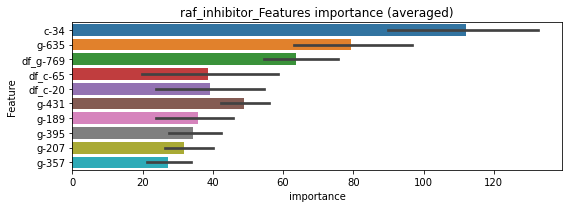

len(train_index) : 3870
len(valid_index) : 3870
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143962	valid_1's binary_logloss: 0.039531
[200]	training's binary_logloss: 0.00184468	valid_1's binary_logloss: 0.027921
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00123896	valid_1's binary_logloss: 0.0271109


len(train_index) : 3870
len(valid_index) : 3870
================================= fold 2/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148905	valid_1's binary_logloss: 0.0322789
[200]	training's binary_logloss: 0.00194182	valid_1's binary_logloss: 0.0215237
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.000892406	valid_1's binary_logloss: 0.0206317


raf_inhibitor logloss: 0.02387129822201508


neg labels: 3289 → selected neg labels: 3287


ras_gtpase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189997	valid_1's binary_logloss: 0.0240067
[200]	training's binary_logloss: 0.00188679	valid_1's binary_logloss: 0.00406852
[300]	training's binary_logloss: 0.000531271	valid_1's binary_logloss: 0.00200799
[400]	training's binary_logloss: 0.000300396	valid_1's binary_logloss: 0.0015465
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000264038	valid_1's binary_logloss: 0.00148166
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194139	valid_1's binary_logloss: 0.0226537
[200]	training's binary_logloss: 0.00195141	valid_1's binary_logloss: 0.00309792
[300]	training's binary_logloss: 0.000546647	valid_1's binary_logloss: 0.00116331
[400]	training's binary_logloss: 0.000306502	valid_1's binary_logloss: 0.000760308
[500]	training's binary_logloss: 0.000259636	valid_1's binary_logloss: 0.000687277
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0008431, Threshold: 0.0012545, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00113, conf_1:0.00138
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0012545
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_2: 0.0112545
threshold: 0.0112545, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192149	valid_1's binary_logloss: 0.0233874
[200]	training's binary_logloss: 0.00188724	valid_1's binary_logloss: 0.00383842
[300]	training's binary_logloss: 0.000533083	valid_1's binary_logloss: 0.00197405
[400]	training's binary_logloss: 0.000302027	valid_1's binary_logloss: 0.00156114
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000265113	valid_1's binary_logloss: 0.0015012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197519	valid_1's binary_logloss: 0.0233233
[200]	training's binary_logloss: 0.00196092	valid_1's binary_logloss: 0.00341922
[300]	training's binary_logloss: 0.000544286	valid_1's binary_logloss: 0.00129726
[400]	training's binary_logloss: 0.000304316	valid_1's binary_logloss: 0.000859718
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000260009	valid_1's binary_logloss: 0.00077

2 / 3 AUC score:1.000
y_Threshold: 0.0601492, Threshold: 0.0112545, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0020090 Vs.target_rate: 0.00050
Num_p_label: 8.0, conf_0:0.01013, conf_1:0.01238
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_1: 0.0112545
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_2: 0.0212545
threshold: 0.0212545, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192149	valid_1's binary_logloss: 0.0233874
[200]	training's binary_logloss: 0.00188724	valid_1's binary_logloss: 0.00383842
[300]	training's binary_logloss: 0.000533083	valid_1's binary_logloss: 0.00197405
[400]	training's binary_logloss: 0.000302027	valid_1's binary_logloss: 0.00156114
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000265113	valid_1's binary_logloss: 0.0015012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197519	valid_1's binary_logloss: 0.0233233
[200]	training's binary_logloss: 0.00196092	valid_1's binary_logloss: 0.00341922
[300]	training's binary_logloss: 0.000544286	valid_1's binary_logloss: 0.00129726
[400]	training's binary_logloss: 0.000304316	valid_1's binary_logloss: 0.000859718
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000260009	valid_1's binary_logloss: 0.00077

3 / 3 AUC score:1.000
y_Threshold: 0.0601492, Threshold: 0.0212545, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0005023 Vs.target_rate: 0.00050
Num_p_label: 2.0, conf_0:0.01913, conf_1:0.02338
threshold: 0.0212545, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7794, y_label_rate: 0.0845522


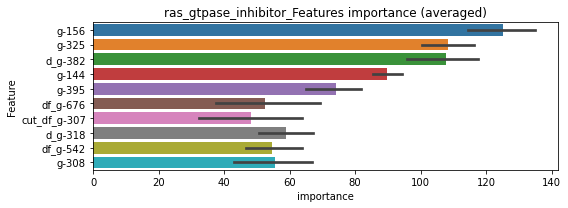

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00992751	valid_1's binary_logloss: 0.0132015
[200]	training's binary_logloss: 0.000960594	valid_1's binary_logloss: 0.0030849
[300]	training's binary_logloss: 0.000264817	valid_1's binary_logloss: 0.00217094
[400]	training's binary_logloss: 0.000147739	valid_1's binary_logloss: 0.00202193
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000143876	valid_1's binary_logloss: 0.002015


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00999208	valid_1's binary_logloss: 0.013137
[200]	training's binary_logloss: 0.000966706	valid_1's binary_logloss: 0.0029881
[300]	training's binary_logloss: 0.000268401	valid_1's binary_logloss: 0.00217116
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000206413	valid_1's binary_logloss: 0.00208781


ras_gtpase_inhibitor logloss: 0.0020514062591155


neg labels: 3289 → selected neg labels: 3278


retinoid_receptor_agonist, len(trt): 67, len(othr): 3278, target_rate: 0.0028135 → Adj_target_rate: 0.0029948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363067	valid_1's binary_logloss: 0.0694541
[200]	training's binary_logloss: 0.0058847	valid_1's binary_logloss: 0.0304521
[300]	training's binary_logloss: 0.00174116	valid_1's binary_logloss: 0.0223927
[400]	training's binary_logloss: 0.000868367	valid_1's binary_logloss: 0.0201344
[500]	training's binary_logloss: 0.000573614	valid_1's binary_logloss: 0.0191448
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000505769	valid_1's binary_logloss: 0.0188256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373219	valid_1's binary_logloss: 0.0726885
[200]	training's binary_logloss: 0.0060469	valid_1's binary_logloss: 0.032118
[300]	training's binary_logloss: 0.00181824	valid_1's binary_logloss: 0.0246588
[400]	training's binary_logloss: 0.000895688	valid_1's binary_logloss: 0.0219741
Early stopping, best iteration is:
[422]	tra

1 / 3 AUC score:0.999
y_Threshold: 0.0052364, Threshold: 0.0112771, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3797
p_label_rate: 0.0200904 Vs.target_rate: 0.00281
Num_p_label: 80.0, conf_0:0.01015, conf_1:0.01240
Num_p_label: 80.0, Expected: 11.2, Adj_threshold_1: 0.0112771
Num_p_label: 54.0, Expected: 11.2, Adj_threshold_2: 0.0212771
Num_p_label: 36.0, Expected: 11.2, Adj_threshold_3: 0.0312771
Num_p_label: 24.0, Expected: 11.2, Adj_threshold_4: 0.0412771
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_5: 0.0512771
threshold: 0.0512771, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 653.0/3797, y_label_rate: 0.1719779
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354916	valid_1's binary_logloss: 0.0685977
[200]	training's binary_logloss: 0.00554582	valid_1's binary_logloss: 0.0285782
[300]	training's binary_logloss: 0.00161933	valid_1's binary_logloss: 0.0210747
[400]	training's binary_logloss: 0.000805636	valid_1's binary_logloss: 0.0185114
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000588134	valid_1's binary_logloss: 0.0178288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371518	valid_1's binary_logloss: 0.0587762
[200]	training's binary_logloss: 0.00588675	valid_1's binary_logloss: 0.0192848
[300]	training's binary_logloss: 0.00172142	valid_1's binary_logloss: 0.0107193
[400]	training's binary_logloss: 0.000833826	valid_1's binary_logloss: 0.00800488
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000614207	valid_1's binary_logloss: 0.0071203


2 / 3 AUC score:1.000
y_Threshold: 0.0327897, Threshold: 0.0512771, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 651.0/3793
p_label_rate: 0.0145655 Vs.target_rate: 0.00281
Num_p_label: 58.0, conf_0:0.04615, conf_1:0.05640
Num_p_label: 58.0, Expected: 11.2, Adj_threshold_1: 0.0512771
Num_p_label: 53.0, Expected: 11.2, Adj_threshold_2: 0.0612771
Num_p_label: 47.0, Expected: 11.2, Adj_threshold_3: 0.0712771
Num_p_label: 46.0, Expected: 11.2, Adj_threshold_4: 0.0812771
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_5: 0.0912771
Num_p_label: 37.0, Expected: 11.2, Adj_threshold_6: 0.1012771
Num_p_label: 36.0, Expected: 11.2, Adj_threshold_7: 0.1112771
Num_p_label: 33.0, Expected: 11.2, Adj_threshold_8: 0.1212771
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_9: 0.1312771
Num_p_label: 28.0, Expected: 11.2, Adj_threshold_10: 0.1412771
threshold: 0.1512771, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 651.0/3793, y_label_rate: 0.1716320

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358408	valid_1's binary_logloss: 0.0675271
[200]	training's binary_logloss: 0.0056593	valid_1's binary_logloss: 0.0281957
[300]	training's binary_logloss: 0.00164849	valid_1's binary_logloss: 0.0195062
[400]	training's binary_logloss: 0.000817391	valid_1's binary_logloss: 0.0168225
[500]	training's binary_logloss: 0.000545417	valid_1's binary_logloss: 0.0154041
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000553614	valid_1's binary_logloss: 0.0153647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035985	valid_1's binary_logloss: 0.0640484
[200]	training's binary_logloss: 0.00560485	valid_1's binary_logloss: 0.0253594
[300]	training's binary_logloss: 0.00163939	valid_1's binary_logloss: 0.0167837
[400]	training's binary_logloss: 0.000812829	valid_1's binary_logloss: 0.0137824
Early stopping, best iteration is:
[469]	tr

3 / 3 AUC score:1.000
y_Threshold: 0.0815683, Threshold: 0.1512771, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 649.0/3789
p_label_rate: 0.0090407 Vs.target_rate: 0.00281
Num_p_label: 36.0, conf_0:0.13615, conf_1:0.16640
Num_p_label: 36.0, Expected: 11.2, Adj_threshold_1: 0.1512771
Num_p_label: 35.0, Expected: 11.2, Adj_threshold_2: 0.1612771
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_3: 0.1712771
Num_p_label: 30.0, Expected: 11.2, Adj_threshold_4: 0.1812771
Num_p_label: 29.0, Expected: 11.2, Adj_threshold_5: 0.1912771
Num_p_label: 26.0, Expected: 11.2, Adj_threshold_6: 0.2012771
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_7: 0.2112771
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_8: 0.2212771
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_9: 0.2312771
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_10: 0.2412771
threshold: 0.2512771, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 673.0/7771, y_label_rate: 0.0866040

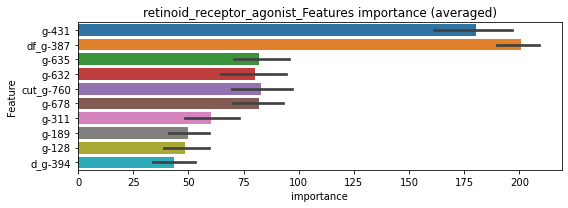

len(train_index) : 3885
len(valid_index) : 3886
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191452	valid_1's binary_logloss: 0.0425877
[200]	training's binary_logloss: 0.00301006	valid_1's binary_logloss: 0.0218184
[300]	training's binary_logloss: 0.000884476	valid_1's binary_logloss: 0.0178058
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000468434	valid_1's binary_logloss: 0.016549


len(train_index) : 3886
len(valid_index) : 3885
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203862	valid_1's binary_logloss: 0.043257
[200]	training's binary_logloss: 0.0032262	valid_1's binary_logloss: 0.021345
[300]	training's binary_logloss: 0.000929845	valid_1's binary_logloss: 0.0172529
[400]	training's binary_logloss: 0.000455593	valid_1's binary_logloss: 0.0162655
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000344911	valid_1's binary_logloss: 0.0158442


retinoid_receptor_agonist logloss: 0.016196682323316457


neg labels: 3289 → selected neg labels: 3288


retinoid_receptor_antagonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155502	valid_1's binary_logloss: 0.0181624
[200]	training's binary_logloss: 0.00124566	valid_1's binary_logloss: 0.00319841
[300]	training's binary_logloss: 0.000332961	valid_1's binary_logloss: 0.00204551
[400]	training's binary_logloss: 0.000204783	valid_1's binary_logloss: 0.00178956
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000204783	valid_1's binary_logloss: 0.00178956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01542	valid_1's binary_logloss: 0.0161603
[200]	training's binary_logloss: 0.00123718	valid_1's binary_logloss: 0.00137265
[300]	training's binary_logloss: 0.000330614	valid_1's binary_logloss: 0.000386976
[400]	training's binary_logloss: 0.000204242	valid_1's binary_logloss: 0.000241374
[500]	training's binary_logloss: 0.000180129	valid_1's binary_logloss: 0.000212909
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0005149, Threshold: 0.0008400, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00076, conf_1:0.00092
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008400
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_2: 0.0108400
threshold: 0.0108400, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016113	valid_1's binary_logloss: 0.0194085
[200]	training's binary_logloss: 0.00127888	valid_1's binary_logloss: 0.00481423
[300]	training's binary_logloss: 0.000333241	valid_1's binary_logloss: 0.00366684
[400]	training's binary_logloss: 0.000207387	valid_1's binary_logloss: 0.00340351
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00018618	valid_1's binary_logloss: 0.00336038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015987	valid_1's binary_logloss: 0.0164378
[200]	training's binary_logloss: 0.00128334	valid_1's binary_logloss: 0.00136143
[300]	training's binary_logloss: 0.000336389	valid_1's binary_logloss: 0.000366936
[400]	training's binary_logloss: 0.000206932	valid_1's binary_logloss: 0.000227938
[500]	training's binary_logloss: 0.000180887	valid_1's binary_logloss: 0.000199576
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0125996, Threshold: 0.0108400, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0025113 Vs.target_rate: 0.00025
Num_p_label: 10.0, conf_0:0.00976, conf_1:0.01192
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_1: 0.0108400
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0208400
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0308400
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.0408400
threshold: 0.0408400, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016113	valid_1's binary_logloss: 0.0194085
[200]	training's binary_logloss: 0.00127888	valid_1's binary_logloss: 0.00481423
[300]	training's binary_logloss: 0.000333241	valid_1's binary_logloss: 0.00366684
[400]	training's binary_logloss: 0.000207387	valid_1's binary_logloss: 0.00340351
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00018618	valid_1's binary_logloss: 0.00336038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015987	valid_1's binary_logloss: 0.0164378
[200]	training's binary_logloss: 0.00128334	valid_1's binary_logloss: 0.00136143
[300]	training's binary_logloss: 0.000336389	valid_1's binary_logloss: 0.000366936
[400]	training's binary_logloss: 0.000206932	valid_1's binary_logloss: 0.000227938
[500]	training's binary_logloss: 0.000180887	valid_1's binary_logloss: 0.000199576
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0125996, Threshold: 0.0408400, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0002511 Vs.target_rate: 0.00025
Num_p_label: 1.0, conf_0:0.03676, conf_1:0.04492
threshold: 0.0408400, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7795, y_label_rate: 0.0844131


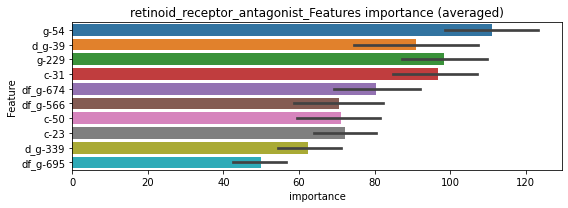

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00833593	valid_1's binary_logloss: 0.00983831
[200]	training's binary_logloss: 0.000653092	valid_1's binary_logloss: 0.00211221
[300]	training's binary_logloss: 0.000169122	valid_1's binary_logloss: 0.00160877
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000165259	valid_1's binary_logloss: 0.00159908


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00842333	valid_1's binary_logloss: 0.00859062
[200]	training's binary_logloss: 0.000672772	valid_1's binary_logloss: 0.000705571
[300]	training's binary_logloss: 0.000175975	valid_1's binary_logloss: 0.000189048
[400]	training's binary_logloss: 0.000105706	valid_1's binary_logloss: 0.000115548
[500]	training's binary_logloss: 8.99027e-05	valid_1's binary_logloss: 9.77994e-05
Early stopping, best iteration is:
[586]	training's binary_logloss: 8.87201e-05	valid_1's binary_logloss: 9.61078e-05


retinoid_receptor_antagonist logloss: 0.0008476917931550428


neg labels: 3289 → selected neg labels: 3283


rho_associated_kinase_inhibitor, len(trt): 35, len(othr): 3283, target_rate: 0.0014697 → Adj_target_rate: 0.0017245
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276123	valid_1's binary_logloss: 0.0475913
[200]	training's binary_logloss: 0.0036577	valid_1's binary_logloss: 0.0140608
[300]	training's binary_logloss: 0.00105724	valid_1's binary_logloss: 0.00830142
[400]	training's binary_logloss: 0.000542624	valid_1's binary_logloss: 0.00650042
[500]	training's binary_logloss: 0.000383831	valid_1's binary_logloss: 0.005874
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000383831	valid_1's binary_logloss: 0.005874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292469	valid_1's binary_logloss: 0.0434137
[200]	training's binary_logloss: 0.00401005	valid_1's binary_logloss: 0.0121734
[300]	training's binary_logloss: 0.00114979	valid_1's binary_logloss: 0.00744466
[400]	training's binary_logloss: 0.000581676	valid_1's binary_logloss: 0.00622688
[500]	training's binary_logloss: 0.00040

1 / 3 AUC score:1.000
y_Threshold: 0.0024837, Threshold: 0.0036509, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00147
Num_p_label: 80.0, conf_0:0.00329, conf_1:0.00402
Num_p_label: 80.0, Expected: 5.9, Adj_threshold_1: 0.0036509
Num_p_label: 8.0, Expected: 5.9, Adj_threshold_2: 0.0136509
threshold: 0.0136509, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280321	valid_1's binary_logloss: 0.0455284
[200]	training's binary_logloss: 0.00361841	valid_1's binary_logloss: 0.0126454
[300]	training's binary_logloss: 0.00104373	valid_1's binary_logloss: 0.0073768
[400]	training's binary_logloss: 0.000537387	valid_1's binary_logloss: 0.00558269
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000493273	valid_1's binary_logloss: 0.00549684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285985	valid_1's binary_logloss: 0.0412106
[200]	training's binary_logloss: 0.00383617	valid_1's binary_logloss: 0.0102644
[300]	training's binary_logloss: 0.00111368	valid_1's binary_logloss: 0.00550676
[400]	training's binary_logloss: 0.000561509	valid_1's binary_logloss: 0.00420324
[500]	training's binary_logloss: 0.000396173	valid_1's binary_logloss: 0.00375297
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
y_Threshold: 0.0314656, Threshold: 0.0136509, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0105475 Vs.target_rate: 0.00147
Num_p_label: 42.0, conf_0:0.01229, conf_1:0.01502
Num_p_label: 42.0, Expected: 5.9, Adj_threshold_1: 0.0136509
Num_p_label: 23.0, Expected: 5.9, Adj_threshold_2: 0.0236509
Num_p_label: 11.0, Expected: 5.9, Adj_threshold_3: 0.0336509
threshold: 0.0336509, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280321	valid_1's binary_logloss: 0.0455284
[200]	training's binary_logloss: 0.00361841	valid_1's binary_logloss: 0.0126454
[300]	training's binary_logloss: 0.00104373	valid_1's binary_logloss: 0.0073768
[400]	training's binary_logloss: 0.000537387	valid_1's binary_logloss: 0.00558269
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000493273	valid_1's binary_logloss: 0.00549684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285985	valid_1's binary_logloss: 0.0412106
[200]	training's binary_logloss: 0.00383617	valid_1's binary_logloss: 0.0102644
[300]	training's binary_logloss: 0.00111368	valid_1's binary_logloss: 0.00550676
[400]	training's binary_logloss: 0.000561509	valid_1's binary_logloss: 0.00420324
[500]	training's binary_logloss: 0.000396173	valid_1's binary_logloss: 0.00375297
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0314656, Threshold: 0.0336509, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0027624 Vs.target_rate: 0.00147
Num_p_label: 11.0, conf_0:0.03029, conf_1:0.03702
threshold: 0.0336509, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7789, y_label_rate: 0.0856336


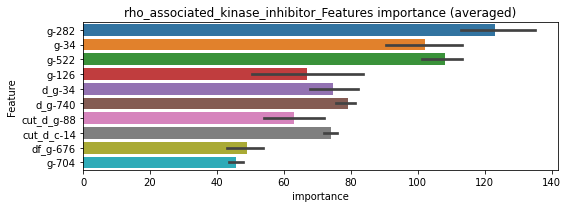

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015494	valid_1's binary_logloss: 0.0389486
[200]	training's binary_logloss: 0.00236197	valid_1's binary_logloss: 0.0208467
[300]	training's binary_logloss: 0.000573026	valid_1's binary_logloss: 0.016516
[400]	training's binary_logloss: 0.000281018	valid_1's binary_logloss: 0.0154631
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000253879	valid_1's binary_logloss: 0.0152869


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151412	valid_1's binary_logloss: 0.0247909
[200]	training's binary_logloss: 0.00202918	valid_1's binary_logloss: 0.00887827
[300]	training's binary_logloss: 0.000606394	valid_1's binary_logloss: 0.00652567
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00039198	valid_1's binary_logloss: 0.00607369


rho_associated_kinase_inhibitor logloss: 0.010680868645825618


neg labels: 3289 → selected neg labels: 3282


ribonucleoside_reductase_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270495	valid_1's binary_logloss: 0.046532
[200]	training's binary_logloss: 0.0035832	valid_1's binary_logloss: 0.0165365
[300]	training's binary_logloss: 0.00100681	valid_1's binary_logloss: 0.01123
[400]	training's binary_logloss: 0.00050704	valid_1's binary_logloss: 0.00971961
[500]	training's binary_logloss: 0.000370559	valid_1's binary_logloss: 0.00927064
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000369186	valid_1's binary_logloss: 0.00926015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273262	valid_1's binary_logloss: 0.03864
[200]	training's binary_logloss: 0.00364589	valid_1's binary_logloss: 0.00951547
[300]	training's binary_logloss: 0.00105358	valid_1's binary_logloss: 0.00532508
[400]	training's binary_logloss: 0.000539905	valid_1's binary_logloss: 0.00425131
Early stopping, best iteration is:
[425]	t

1 / 3 AUC score:1.000
y_Threshold: 0.0020642, Threshold: 0.0033878, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00305, conf_1:0.00373
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0033878
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_2: 0.0133878
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_3: 0.0233878
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_4: 0.0333878
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_5: 0.0433878
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_6: 0.0533878
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_7: 0.0633878
threshold: 0.0633878, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267145	valid_1's binary_logloss: 0.0415617
[200]	training's binary_logloss: 0.00334398	valid_1's binary_logloss: 0.0115105
[300]	training's binary_logloss: 0.000942894	valid_1's binary_logloss: 0.00638519
[400]	training's binary_logloss: 0.000483768	valid_1's binary_logloss: 0.00495048
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000368213	valid_1's binary_logloss: 0.00446016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265538	valid_1's binary_logloss: 0.0370968
[200]	training's binary_logloss: 0.00347279	valid_1's binary_logloss: 0.00780364
[300]	training's binary_logloss: 0.000991206	valid_1's binary_logloss: 0.00342698
[400]	training's binary_logloss: 0.000504273	valid_1's binary_logloss: 0.00234311
[500]	training's binary_logloss: 0.000365619	valid_1's binary_logloss: 0.00200788
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.0328691, Threshold: 0.0633878, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0040181 Vs.target_rate: 0.00155
Num_p_label: 16.0, conf_0:0.05705, conf_1:0.06973
threshold: 0.0633878, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267145	valid_1's binary_logloss: 0.0415617
[200]	training's binary_logloss: 0.00334398	valid_1's binary_logloss: 0.0115105
[300]	training's binary_logloss: 0.000942894	valid_1's binary_logloss: 0.00638519
[400]	training's binary_logloss: 0.000483768	valid_1's binary_logloss: 0.00495048
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000368213	valid_1's binary_logloss: 0.00446016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265538	valid_1's binary_logloss: 0.0370968
[200]	training's binary_logloss: 0.00347279	valid_1's binary_logloss: 0.00780364
[300]	training's binary_logloss: 0.000991206	valid_1's binary_logloss: 0.00342698
[400]	training's binary_logloss: 0.000504273	valid_1's binary_logloss: 0.00234311
[500]	training's binary_logloss: 0.000365619	valid_1's binary_logloss: 0.00200788
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.0328691, Threshold: 0.0633878, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0040181 Vs.target_rate: 0.00155
Num_p_label: 16.0, conf_0:0.05705, conf_1:0.06973
threshold: 0.0633878, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 672.0/7788, y_label_rate: 0.0862866


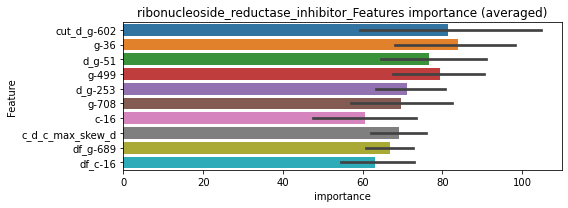

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144789	valid_1's binary_logloss: 0.024585
[200]	training's binary_logloss: 0.00180913	valid_1's binary_logloss: 0.00826255
[300]	training's binary_logloss: 0.000502587	valid_1's binary_logloss: 0.0055118
[400]	training's binary_logloss: 0.000255209	valid_1's binary_logloss: 0.00489391
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000223696	valid_1's binary_logloss: 0.00475626


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014565	valid_1's binary_logloss: 0.0211012
[200]	training's binary_logloss: 0.00182948	valid_1's binary_logloss: 0.00488547
[300]	training's binary_logloss: 0.000512544	valid_1's binary_logloss: 0.00267299
[400]	training's binary_logloss: 0.00026146	valid_1's binary_logloss: 0.00222989
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000274174	valid_1's binary_logloss: 0.00222046


ribonucleoside_reductase_inhibitor logloss: 0.0034883599994103044


neg labels: 3289 → selected neg labels: 3284


rna_polymerase_inhibitor, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259886	valid_1's binary_logloss: 0.0408829
[200]	training's binary_logloss: 0.00321691	valid_1's binary_logloss: 0.00984813
[300]	training's binary_logloss: 0.000927053	valid_1's binary_logloss: 0.00505669
[400]	training's binary_logloss: 0.000486657	valid_1's binary_logloss: 0.00369802
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000383778	valid_1's binary_logloss: 0.00331346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276439	valid_1's binary_logloss: 0.0378737
[200]	training's binary_logloss: 0.00359881	valid_1's binary_logloss: 0.00859487
[300]	training's binary_logloss: 0.000990543	valid_1's binary_logloss: 0.00475714
[400]	training's binary_logloss: 0.000504821	valid_1's binary_logloss: 0.00385416
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000466952	valid_1's binary_logloss: 0.00374

1 / 3 AUC score:1.000
y_Threshold: 0.0020116, Threshold: 0.0120154, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.01081, conf_1:0.01322
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0120154
Num_p_label: 58.0, Expected: 4.2, Adj_threshold_2: 0.0220154
Num_p_label: 42.0, Expected: 4.2, Adj_threshold_3: 0.0320154
Num_p_label: 36.0, Expected: 4.2, Adj_threshold_4: 0.0420154
Num_p_label: 31.0, Expected: 4.2, Adj_threshold_5: 0.0520154
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_6: 0.0620154
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_7: 0.0720154
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_8: 0.0820154
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_9: 0.0920154
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_10: 0.1020154
threshold: 0.1120154, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259871	valid_1's binary_logloss: 0.0373376
[200]	training's binary_logloss: 0.00316585	valid_1's binary_logloss: 0.00812594
[300]	training's binary_logloss: 0.000901574	valid_1's binary_logloss: 0.00394813
[400]	training's binary_logloss: 0.00047153	valid_1's binary_logloss: 0.00266347
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.0003689	valid_1's binary_logloss: 0.00239272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264831	valid_1's binary_logloss: 0.0370382
[200]	training's binary_logloss: 0.00330175	valid_1's binary_logloss: 0.00742957
[300]	training's binary_logloss: 0.000922822	valid_1's binary_logloss: 0.00353255
[400]	training's binary_logloss: 0.000475599	valid_1's binary_logloss: 0.00260773
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000399855	valid_1's binary_logloss: 0.00243824

2 / 3 AUC score:1.000
y_Threshold: 0.0488186, Threshold: 0.1120154, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0188348 Vs.target_rate: 0.00105
Num_p_label: 75.0, conf_0:0.10081, conf_1:0.12322
Num_p_label: 75.0, Expected: 4.2, Adj_threshold_1: 0.1120154
Num_p_label: 72.0, Expected: 4.2, Adj_threshold_2: 0.1220154
Num_p_label: 71.0, Expected: 4.2, Adj_threshold_3: 0.1320154
Num_p_label: 70.0, Expected: 4.2, Adj_threshold_4: 0.1420154
Num_p_label: 69.0, Expected: 4.2, Adj_threshold_5: 0.1520154
Num_p_label: 69.0, Expected: 4.2, Adj_threshold_6: 0.1620154
Num_p_label: 67.0, Expected: 4.2, Adj_threshold_7: 0.1720154
Num_p_label: 64.0, Expected: 4.2, Adj_threshold_8: 0.1820154
Num_p_label: 61.0, Expected: 4.2, Adj_threshold_9: 0.1920154
Num_p_label: 61.0, Expected: 4.2, Adj_threshold_10: 0.2020154
threshold: 0.2120154, positive_p_label: 60.0/3982, p_label_rate: 0.0150678
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259871	valid_1's binary_logloss: 0.0373376
[200]	training's binary_logloss: 0.00316585	valid_1's binary_logloss: 0.00812594
[300]	training's binary_logloss: 0.000901574	valid_1's binary_logloss: 0.00394813
[400]	training's binary_logloss: 0.00047153	valid_1's binary_logloss: 0.00266347
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.0003689	valid_1's binary_logloss: 0.00239272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264831	valid_1's binary_logloss: 0.0370382
[200]	training's binary_logloss: 0.00330175	valid_1's binary_logloss: 0.00742957
[300]	training's binary_logloss: 0.000922822	valid_1's binary_logloss: 0.00353255
[400]	training's binary_logloss: 0.000475599	valid_1's binary_logloss: 0.00260773
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000399855	valid_1's binary_logloss: 0.00243824

3 / 3 AUC score:1.000
y_Threshold: 0.0488186, Threshold: 0.2120154, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0150678 Vs.target_rate: 0.00105
Num_p_label: 60.0, conf_0:0.19081, conf_1:0.23322
Num_p_label: 60.0, Expected: 4.2, Adj_threshold_1: 0.2120154
Num_p_label: 60.0, Expected: 4.2, Adj_threshold_2: 0.2220154
Num_p_label: 59.0, Expected: 4.2, Adj_threshold_3: 0.2320154
Num_p_label: 58.0, Expected: 4.2, Adj_threshold_4: 0.2420154
Num_p_label: 57.0, Expected: 4.2, Adj_threshold_5: 0.2520154
Num_p_label: 57.0, Expected: 4.2, Adj_threshold_6: 0.2620154
Num_p_label: 55.0, Expected: 4.2, Adj_threshold_7: 0.2720154
Num_p_label: 53.0, Expected: 4.2, Adj_threshold_8: 0.2820154
Num_p_label: 52.0, Expected: 4.2, Adj_threshold_9: 0.2920154
Num_p_label: 52.0, Expected: 4.2, Adj_threshold_10: 0.3020154
threshold: 0.3120154, positive_p_label: 50.0/3982, p_label_rate: 0.0125565
positive_y_label: 706.0/7790, y_label_rate: 0.0906290


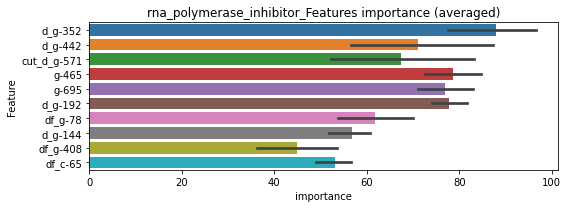

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154256	valid_1's binary_logloss: 0.0299285
[200]	training's binary_logloss: 0.00205748	valid_1's binary_logloss: 0.0131546
[300]	training's binary_logloss: 0.000577329	valid_1's binary_logloss: 0.0104151
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00057156	valid_1's binary_logloss: 0.0104109


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161875	valid_1's binary_logloss: 0.0245766
[200]	training's binary_logloss: 0.00225534	valid_1's binary_logloss: 0.00979645
[300]	training's binary_logloss: 0.000642999	valid_1's binary_logloss: 0.00751977
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000561961	valid_1's binary_logloss: 0.00742696


rna_polymerase_inhibitor logloss: 0.008918940539197884


neg labels: 3289 → selected neg labels: 3249


serotonin_receptor_agonist, len(trt): 236, len(othr): 3249, target_rate: 0.0099101 → Adj_target_rate: 0.0087332
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091423	valid_1's binary_logloss: 0.249613
[200]	training's binary_logloss: 0.0304584	valid_1's binary_logloss: 0.228484
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0287903	valid_1's binary_logloss: 0.228123
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104131	valid_1's binary_logloss: 0.243806
[200]	training's binary_logloss: 0.035758	valid_1's binary_logloss: 0.217636
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0275101	valid_1's binary_logloss: 0.216358


1 / 3 AUC score:0.919
y_Threshold: 0.0694076, Threshold: 0.0915500, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 383 → Positive_corect_labels: 523/3515
p_label_rate: 0.0200904 Vs.target_rate: 0.00991
Num_p_label: 80.0, conf_0:0.08239, conf_1:0.10070
threshold: 0.0915500, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 523.0/3515, y_label_rate: 0.1487909
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.067185	valid_1's binary_logloss: 0.172868
[200]	training's binary_logloss: 0.0189146	valid_1's binary_logloss: 0.137872
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0126943	valid_1's binary_logloss: 0.134061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662203	valid_1's binary_logloss: 0.173887
[200]	training's binary_logloss: 0.0173671	valid_1's binary_logloss: 0.144949
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0110937	valid_1's binary_logloss: 0.141692


2 / 3 AUC score:0.980
y_Threshold: 0.0644066, Threshold: 0.0915500, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 98 → Positive_corect_labels: 474.0/3417
p_label_rate: 0.0052737 Vs.target_rate: 0.00991
Num_p_label: 21.0, conf_0:0.08239, conf_1:0.10070
threshold: 0.0915500, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 474.0/3417, y_label_rate: 0.1387182
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531712	valid_1's binary_logloss: 0.137073
[200]	training's binary_logloss: 0.0131809	valid_1's binary_logloss: 0.103007
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00494719	valid_1's binary_logloss: 0.0954683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534976	valid_1's binary_logloss: 0.135219
[200]	training's binary_logloss: 0.0125644	valid_1's binary_logloss: 0.0994848
[300]	training's binary_logloss: 0.00413146	valid_1's binary_logloss: 0.091048
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00409533	valid_1's binary_logloss: 0.0909131


3 / 3 AUC score:0.994
y_Threshold: 0.0434453, Threshold: 0.0915500, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 452.0/3373
p_label_rate: 0.0007534 Vs.target_rate: 0.00991
Num_p_label: 3.0, conf_0:0.08239, conf_1:0.10070
Num_p_label: 3.0, Expected: 39.5, Adj_threshold_1: 0.0915500
Num_p_label: 4.0, Expected: 39.5, Adj_threshold_2: 0.0815500
Num_p_label: 11.0, Expected: 39.5, Adj_threshold_3: 0.0715500
Num_p_label: 18.0, Expected: 39.5, Adj_threshold_4: 0.0615500
Num_p_label: 26.0, Expected: 39.5, Adj_threshold_5: 0.0515500
threshold: 0.0515500, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 478.0/7355, y_label_rate: 0.0649898


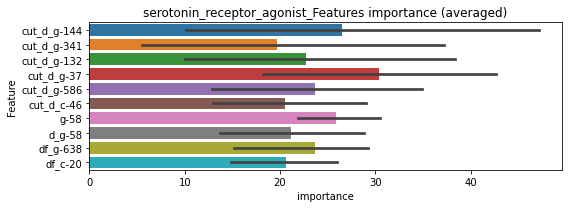

len(train_index) : 3677
len(valid_index) : 3678
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267276	valid_1's binary_logloss: 0.077847
[200]	training's binary_logloss: 0.00608378	valid_1's binary_logloss: 0.0653819
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00635275	valid_1's binary_logloss: 0.0651449


len(train_index) : 3678
len(valid_index) : 3677
================================= fold 2/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303762	valid_1's binary_logloss: 0.0836145
[200]	training's binary_logloss: 0.00746012	valid_1's binary_logloss: 0.0703089
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00659123	valid_1's binary_logloss: 0.0696745


serotonin_receptor_agonist logloss: 0.06740942126722592


neg labels: 3289 → selected neg labels: 3220


serotonin_receptor_antagonist, len(trt): 404, len(othr): 3220, target_rate: 0.0169648 → Adj_target_rate: 0.0137918
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126888	valid_1's binary_logloss: 0.345188
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0940135	valid_1's binary_logloss: 0.33918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122021	valid_1's binary_logloss: 0.349849
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0626481	valid_1's binary_logloss: 0.34137


1 / 3 AUC score:0.812
y_Threshold: 0.1394812, Threshold: 0.1839888, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 629 → Positive_corect_labels: 394/3235
p_label_rate: 0.0200904 Vs.target_rate: 0.01696
Num_p_label: 80.0, conf_0:0.16559, conf_1:0.20239
threshold: 0.1839888, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 394.0/3235, y_label_rate: 0.1217929
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065462	valid_1's binary_logloss: 0.225139
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0321422	valid_1's binary_logloss: 0.213149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665773	valid_1's binary_logloss: 0.216834
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.0379256	valid_1's binary_logloss: 0.206158


2 / 3 AUC score:0.935
y_Threshold: 0.1061766, Threshold: 0.1839888, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 200 → Positive_corect_labels: 294.0/3035
p_label_rate: 0.0107986 Vs.target_rate: 0.01696
Num_p_label: 43.0, conf_0:0.16559, conf_1:0.20239
threshold: 0.1839888, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 294.0/3035, y_label_rate: 0.0968699
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0419715	valid_1's binary_logloss: 0.167509
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0275585	valid_1's binary_logloss: 0.160487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472499	valid_1's binary_logloss: 0.151669
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0161702	valid_1's binary_logloss: 0.131041


3 / 3 AUC score:0.972
y_Threshold: 0.0749957, Threshold: 0.1839888, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 104 → Positive_corect_labels: 242.0/2931
p_label_rate: 0.0092918 Vs.target_rate: 0.01696
Num_p_label: 37.0, conf_0:0.16559, conf_1:0.20239
threshold: 0.1839888, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 279.0/6913, y_label_rate: 0.0403587


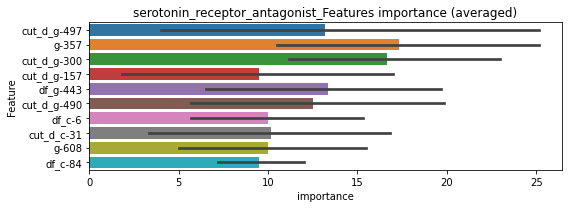

len(train_index) : 3456
len(valid_index) : 3457
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017931	valid_1's binary_logloss: 0.0881352
Early stopping, best iteration is:
[159]	training's binary_logloss: 0.00741379	valid_1's binary_logloss: 0.0838769


len(train_index) : 3457
len(valid_index) : 3456
================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186921	valid_1's binary_logloss: 0.0843599
Early stopping, best iteration is:
[143]	training's binary_logloss: 0.00962742	valid_1's binary_logloss: 0.07901


serotonin_receptor_antagonist logloss: 0.08144376064349326


neg labels: 3289 → selected neg labels: 3281


serotonin_reuptake_inhibitor, len(trt): 44, len(othr): 3281, target_rate: 0.0018477 → Adj_target_rate: 0.0020948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344692	valid_1's binary_logloss: 0.0684032
[200]	training's binary_logloss: 0.00551125	valid_1's binary_logloss: 0.031525
[300]	training's binary_logloss: 0.00157794	valid_1's binary_logloss: 0.0232904
[400]	training's binary_logloss: 0.000783705	valid_1's binary_logloss: 0.0199971
[500]	training's binary_logloss: 0.000521429	valid_1's binary_logloss: 0.0189292
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000512135	valid_1's binary_logloss: 0.0187878
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384975	valid_1's binary_logloss: 0.0600308
[200]	training's binary_logloss: 0.00644646	valid_1's binary_logloss: 0.0249734
[300]	training's binary_logloss: 0.0018334	valid_1's binary_logloss: 0.0194187
[400]	training's binary_logloss: 0.000867351	valid_1's binary_logloss: 0.017979
Early stopping, best iteration is:
[395]	tra

1 / 3 AUC score:0.999
y_Threshold: 0.0037654, Threshold: 0.0047320, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 654/3801
p_label_rate: 0.0200904 Vs.target_rate: 0.00185
Num_p_label: 80.0, conf_0:0.00426, conf_1:0.00521
Num_p_label: 80.0, Expected: 7.4, Adj_threshold_1: 0.0047320
Num_p_label: 10.0, Expected: 7.4, Adj_threshold_2: 0.0147320
threshold: 0.0147320, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355438	valid_1's binary_logloss: 0.0630844
[200]	training's binary_logloss: 0.00581664	valid_1's binary_logloss: 0.0269224
[300]	training's binary_logloss: 0.0016916	valid_1's binary_logloss: 0.0180639
[400]	training's binary_logloss: 0.000821652	valid_1's binary_logloss: 0.0156203
[500]	training's binary_logloss: 0.000535717	valid_1's binary_logloss: 0.0148158
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000553423	valid_1's binary_logloss: 0.0146807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364843	valid_1's binary_logloss: 0.0640873
[200]	training's binary_logloss: 0.00563523	valid_1's binary_logloss: 0.0289243
[300]	training's binary_logloss: 0.00162004	valid_1's binary_logloss: 0.0235001
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000917803	valid_1's binary_logloss: 0.0222675


2 / 3 AUC score:1.000
y_Threshold: 0.0168868, Threshold: 0.0147320, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 652.0/3797
p_label_rate: 0.0070316 Vs.target_rate: 0.00185
Num_p_label: 28.0, conf_0:0.01326, conf_1:0.01621
Num_p_label: 28.0, Expected: 7.4, Adj_threshold_1: 0.0147320
Num_p_label: 10.0, Expected: 7.4, Adj_threshold_2: 0.0247320
threshold: 0.0247320, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 652.0/3797, y_label_rate: 0.1717145
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354137	valid_1's binary_logloss: 0.0645266
[200]	training's binary_logloss: 0.00564555	valid_1's binary_logloss: 0.0276682
[300]	training's binary_logloss: 0.00161225	valid_1's binary_logloss: 0.0192225
[400]	training's binary_logloss: 0.000795563	valid_1's binary_logloss: 0.0167669
[500]	training's binary_logloss: 0.00052277	valid_1's binary_logloss: 0.0155153
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000480535	valid_1's binary_logloss: 0.0152969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371257	valid_1's binary_logloss: 0.0677033
[200]	training's binary_logloss: 0.0059967	valid_1's binary_logloss: 0.0280129
[300]	training's binary_logloss: 0.00169556	valid_1's binary_logloss: 0.0193192
[400]	training's binary_logloss: 0.000828975	valid_1's binary_logloss: 0.0173307
Early stopping, best iteration is:
[478]	tr

3 / 3 AUC score:1.000
y_Threshold: 0.0150716, Threshold: 0.0247320, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 651.0/3795
p_label_rate: 0.0022602 Vs.target_rate: 0.00185
Num_p_label: 9.0, conf_0:0.02226, conf_1:0.02721
threshold: 0.0247320, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 660.0/7777, y_label_rate: 0.0848656


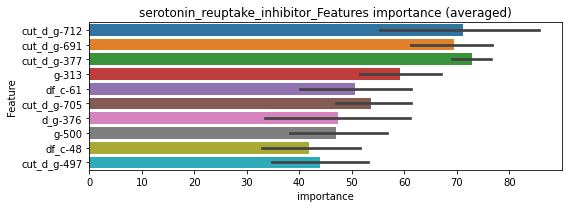

len(train_index) : 3888
len(valid_index) : 3889
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200947	valid_1's binary_logloss: 0.0430244
[200]	training's binary_logloss: 0.00315397	valid_1's binary_logloss: 0.0230267
[300]	training's binary_logloss: 0.000874777	valid_1's binary_logloss: 0.0185326
[400]	training's binary_logloss: 0.000419578	valid_1's binary_logloss: 0.0175279
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000357671	valid_1's binary_logloss: 0.0173368


len(train_index) : 3889
len(valid_index) : 3888
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202886	valid_1's binary_logloss: 0.0369154
[200]	training's binary_logloss: 0.00321965	valid_1's binary_logloss: 0.0169176
[300]	training's binary_logloss: 0.000907857	valid_1's binary_logloss: 0.0133711
[400]	training's binary_logloss: 0.000432418	valid_1's binary_logloss: 0.0120673
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000407459	valid_1's binary_logloss: 0.0119615


serotonin_reuptake_inhibitor logloss: 0.0146494857801501


neg labels: 3289 → selected neg labels: 3283


sigma_receptor_agonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316952	valid_1's binary_logloss: 0.0558346
[200]	training's binary_logloss: 0.00480017	valid_1's binary_logloss: 0.0224541
[300]	training's binary_logloss: 0.0013511	valid_1's binary_logloss: 0.0157586
[400]	training's binary_logloss: 0.000676255	valid_1's binary_logloss: 0.0136235
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000687686	valid_1's binary_logloss: 0.0136156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338796	valid_1's binary_logloss: 0.0569282
[200]	training's binary_logloss: 0.00531023	valid_1's binary_logloss: 0.021521
[300]	training's binary_logloss: 0.00148671	valid_1's binary_logloss: 0.0143457
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00126829	valid_1's binary_logloss: 0.0138012


1 / 3 AUC score:1.000
y_Threshold: 0.0052318, Threshold: 0.0064474, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00580, conf_1:0.00709
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0064474
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_2: 0.0164474
threshold: 0.0164474, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323845	valid_1's binary_logloss: 0.0547794
[200]	training's binary_logloss: 0.00473327	valid_1's binary_logloss: 0.0208952
[300]	training's binary_logloss: 0.00133883	valid_1's binary_logloss: 0.0146908
[400]	training's binary_logloss: 0.000667296	valid_1's binary_logloss: 0.0130365
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000667296	valid_1's binary_logloss: 0.0130365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349381	valid_1's binary_logloss: 0.0609541
[200]	training's binary_logloss: 0.0052154	valid_1's binary_logloss: 0.0242268
[300]	training's binary_logloss: 0.00145905	valid_1's binary_logloss: 0.0165453
[400]	training's binary_logloss: 0.000722766	valid_1's binary_logloss: 0.0143229
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000497973	valid_1's binary_logloss: 0.0133399


2 / 3 AUC score:1.000
y_Threshold: 0.0229030, Threshold: 0.0164474, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0027624 Vs.target_rate: 0.00151
Num_p_label: 11.0, conf_0:0.01480, conf_1:0.01809
threshold: 0.0164474, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334657	valid_1's binary_logloss: 0.0572911
[200]	training's binary_logloss: 0.00505164	valid_1's binary_logloss: 0.0207816
[300]	training's binary_logloss: 0.00142152	valid_1's binary_logloss: 0.0133684
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000803689	valid_1's binary_logloss: 0.0114479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336696	valid_1's binary_logloss: 0.0542753
[200]	training's binary_logloss: 0.00503285	valid_1's binary_logloss: 0.0170687
[300]	training's binary_logloss: 0.00141211	valid_1's binary_logloss: 0.010062
[400]	training's binary_logloss: 0.000701631	valid_1's binary_logloss: 0.00807711
[500]	training's binary_logloss: 0.000470919	valid_1's binary_logloss: 0.00721852
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000483046	valid_1's binary_logloss: 0.00721576


3 / 3 AUC score:1.000
y_Threshold: 0.0174455, Threshold: 0.0164474, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0047715 Vs.target_rate: 0.00151
Num_p_label: 19.0, conf_0:0.01480, conf_1:0.01809
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_1: 0.0164474
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_2: 0.0264474
threshold: 0.0264474, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 662.0/7785, y_label_rate: 0.0850353


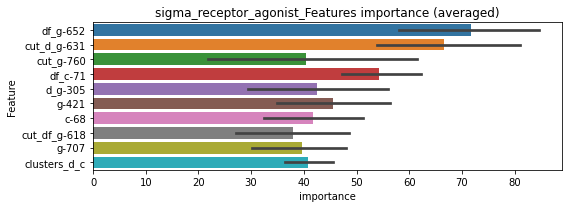

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176555	valid_1's binary_logloss: 0.0336448
[200]	training's binary_logloss: 0.00264847	valid_1's binary_logloss: 0.0157341
[300]	training's binary_logloss: 0.000743326	valid_1's binary_logloss: 0.0132198
[400]	training's binary_logloss: 0.000360381	valid_1's binary_logloss: 0.0127354
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000379374	valid_1's binary_logloss: 0.012669


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191122	valid_1's binary_logloss: 0.0321689
[200]	training's binary_logloss: 0.00289671	valid_1's binary_logloss: 0.0114075
[300]	training's binary_logloss: 0.000807241	valid_1's binary_logloss: 0.00779568
[400]	training's binary_logloss: 0.000389596	valid_1's binary_logloss: 0.00686884
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000329969	valid_1's binary_logloss: 0.00668687


sigma_receptor_agonist logloss: 0.00967830807986797


neg labels: 3289 → selected neg labels: 3283


sigma_receptor_antagonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339416	valid_1's binary_logloss: 0.0545351
[200]	training's binary_logloss: 0.00499145	valid_1's binary_logloss: 0.017834
[300]	training's binary_logloss: 0.00137234	valid_1's binary_logloss: 0.0109445
[400]	training's binary_logloss: 0.000697335	valid_1's binary_logloss: 0.00905468
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000501362	valid_1's binary_logloss: 0.00838607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345791	valid_1's binary_logloss: 0.0634087
[200]	training's binary_logloss: 0.0054482	valid_1's binary_logloss: 0.0278717
[300]	training's binary_logloss: 0.0015192	valid_1's binary_logloss: 0.0212475
[400]	training's binary_logloss: 0.000729438	valid_1's binary_logloss: 0.0197881
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.000754639	valid_1's binary_logloss: 0.0197141


1 / 3 AUC score:1.000
y_Threshold: 0.0036248, Threshold: 0.0045946, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00414, conf_1:0.00505
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0045946
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_2: 0.0145946
threshold: 0.0145946, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336337	valid_1's binary_logloss: 0.0555363
[200]	training's binary_logloss: 0.00501394	valid_1's binary_logloss: 0.0204167
[300]	training's binary_logloss: 0.00140987	valid_1's binary_logloss: 0.0139484
[400]	training's binary_logloss: 0.000703361	valid_1's binary_logloss: 0.011799
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000538785	valid_1's binary_logloss: 0.0108167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325312	valid_1's binary_logloss: 0.0561561
[200]	training's binary_logloss: 0.0049188	valid_1's binary_logloss: 0.0198724
[300]	training's binary_logloss: 0.00140271	valid_1's binary_logloss: 0.0129928
[400]	training's binary_logloss: 0.000696701	valid_1's binary_logloss: 0.0107347
[500]	training's binary_logloss: 0.000475994	valid_1's binary_logloss: 0.00997153
Early stopping, best iteration is:
[502]	t

2 / 3 AUC score:1.000
y_Threshold: 0.0274415, Threshold: 0.0145946, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0067805 Vs.target_rate: 0.00151
Num_p_label: 27.0, conf_0:0.01314, conf_1:0.01605
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_1: 0.0145946
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_2: 0.0245946
threshold: 0.0245946, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033532	valid_1's binary_logloss: 0.0505406
[200]	training's binary_logloss: 0.00491608	valid_1's binary_logloss: 0.0154233
[300]	training's binary_logloss: 0.00139516	valid_1's binary_logloss: 0.00993278
[400]	training's binary_logloss: 0.000697521	valid_1's binary_logloss: 0.00826628
[500]	training's binary_logloss: 0.000477742	valid_1's binary_logloss: 0.00762437
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000469691	valid_1's binary_logloss: 0.00757621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033759	valid_1's binary_logloss: 0.0539455
[200]	training's binary_logloss: 0.00506922	valid_1's binary_logloss: 0.0176391
[300]	training's binary_logloss: 0.0014352	valid_1's binary_logloss: 0.0104401
[400]	training's binary_logloss: 0.000721437	valid_1's binary_logloss: 0.00841059
[500]	training's binary_logloss: 0.0004

3 / 3 AUC score:1.000
y_Threshold: 0.0221124, Threshold: 0.0245946, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0017579 Vs.target_rate: 0.00151
Num_p_label: 7.0, conf_0:0.02214, conf_1:0.02705
threshold: 0.0245946, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 661.0/7785, y_label_rate: 0.0849069


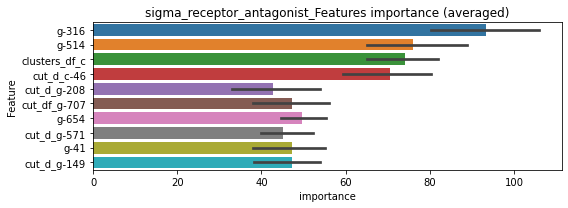

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184121	valid_1's binary_logloss: 0.035701
[200]	training's binary_logloss: 0.0027448	valid_1's binary_logloss: 0.0177494
[300]	training's binary_logloss: 0.000748726	valid_1's binary_logloss: 0.0142896
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000446525	valid_1's binary_logloss: 0.0137252


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018358	valid_1's binary_logloss: 0.0300909
[200]	training's binary_logloss: 0.00272055	valid_1's binary_logloss: 0.0121014
[300]	training's binary_logloss: 0.000765953	valid_1's binary_logloss: 0.00892452
[400]	training's binary_logloss: 0.000372484	valid_1's binary_logloss: 0.00827357
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000362653	valid_1's binary_logloss: 0.00823244


sigma_receptor_antagonist logloss: 0.010979194453573548


neg labels: 3289 → selected neg labels: 3284


smoothened_receptor_antagonist, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251967	valid_1's binary_logloss: 0.0383006
[200]	training's binary_logloss: 0.00325046	valid_1's binary_logloss: 0.0101428
[300]	training's binary_logloss: 0.000934054	valid_1's binary_logloss: 0.00559324
[400]	training's binary_logloss: 0.000487031	valid_1's binary_logloss: 0.00420323
[500]	training's binary_logloss: 0.000366798	valid_1's binary_logloss: 0.00377079
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000367764	valid_1's binary_logloss: 0.00376621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259277	valid_1's binary_logloss: 0.0345409
[200]	training's binary_logloss: 0.00344198	valid_1's binary_logloss: 0.00779375
[300]	training's binary_logloss: 0.000990069	valid_1's binary_logloss: 0.00357081
[400]	training's binary_logloss: 0.000513566	valid_1's binary_logloss: 0.00248943
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0015740, Threshold: 0.0032995, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00297, conf_1:0.00363
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0032995
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_2: 0.0132995
Num_p_label: 2.0, Expected: 4.2, Adj_threshold_3: 0.0232995
threshold: 0.0232995, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252066	valid_1's binary_logloss: 0.0382292
[200]	training's binary_logloss: 0.00321412	valid_1's binary_logloss: 0.00965693
[300]	training's binary_logloss: 0.000931481	valid_1's binary_logloss: 0.00508118
[400]	training's binary_logloss: 0.00048685	valid_1's binary_logloss: 0.00372373
[500]	training's binary_logloss: 0.000365215	valid_1's binary_logloss: 0.003302
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00036887	valid_1's binary_logloss: 0.00329971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265184	valid_1's binary_logloss: 0.0363697
[200]	training's binary_logloss: 0.00343284	valid_1's binary_logloss: 0.00736945
[300]	training's binary_logloss: 0.000983068	valid_1's binary_logloss: 0.00317926
[400]	training's binary_logloss: 0.000508762	valid_1's binary_logloss: 0.00212798
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0899197, Threshold: 0.0232995, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0035158 Vs.target_rate: 0.00105
Num_p_label: 14.0, conf_0:0.02097, conf_1:0.02563
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_1: 0.0232995
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_2: 0.0332995
Num_p_label: 3.0, Expected: 4.2, Adj_threshold_3: 0.0432995
threshold: 0.0432995, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252066	valid_1's binary_logloss: 0.0382292
[200]	training's binary_logloss: 0.00321412	valid_1's binary_logloss: 0.00965693
[300]	training's binary_logloss: 0.000931481	valid_1's binary_logloss: 0.00508118
[400]	training's binary_logloss: 0.00048685	valid_1's binary_logloss: 0.00372373
[500]	training's binary_logloss: 0.000365215	valid_1's binary_logloss: 0.003302
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00036887	valid_1's binary_logloss: 0.00329971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265184	valid_1's binary_logloss: 0.0363697
[200]	training's binary_logloss: 0.00343284	valid_1's binary_logloss: 0.00736945
[300]	training's binary_logloss: 0.000983068	valid_1's binary_logloss: 0.00317926
[400]	training's binary_logloss: 0.000508762	valid_1's binary_logloss: 0.00212798
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0899197, Threshold: 0.0432995, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0007534 Vs.target_rate: 0.00105
Num_p_label: 3.0, conf_0:0.03897, conf_1:0.04763
threshold: 0.0432995, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 659.0/7790, y_label_rate: 0.0845956


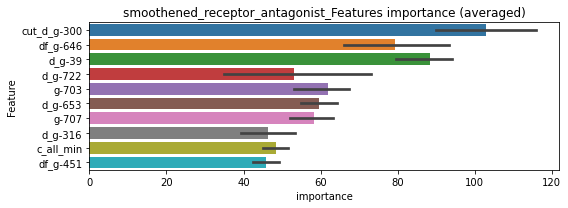

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132271	valid_1's binary_logloss: 0.0216241
[200]	training's binary_logloss: 0.00168728	valid_1's binary_logloss: 0.00769743
[300]	training's binary_logloss: 0.000485548	valid_1's binary_logloss: 0.00562135
[400]	training's binary_logloss: 0.000245475	valid_1's binary_logloss: 0.00517471
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000201291	valid_1's binary_logloss: 0.0050861


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138538	valid_1's binary_logloss: 0.0209065
[200]	training's binary_logloss: 0.00175372	valid_1's binary_logloss: 0.00540467
[300]	training's binary_logloss: 0.000498227	valid_1's binary_logloss: 0.00332457
[400]	training's binary_logloss: 0.000255567	valid_1's binary_logloss: 0.00295107
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000217472	valid_1's binary_logloss: 0.00289854


smoothened_receptor_antagonist logloss: 0.003992322448789344


neg labels: 3289 → selected neg labels: 3244


sodium_channel_inhibitor, len(trt): 267, len(othr): 3244, target_rate: 0.0112119 → Adj_target_rate: 0.0096991
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10042	valid_1's binary_logloss: 0.273343
[200]	training's binary_logloss: 0.0360123	valid_1's binary_logloss: 0.25301
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0366965	valid_1's binary_logloss: 0.25269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112117	valid_1's binary_logloss: 0.256913
[200]	training's binary_logloss: 0.040432	valid_1's binary_logloss: 0.220786
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.025374	valid_1's binary_logloss: 0.215445


1 / 3 AUC score:0.911
y_Threshold: 0.0770861, Threshold: 0.0950828, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 395 → Positive_corect_labels: 516/3497
p_label_rate: 0.0200904 Vs.target_rate: 0.01121
Num_p_label: 80.0, conf_0:0.08557, conf_1:0.10459
threshold: 0.0950828, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 516.0/3497, y_label_rate: 0.1475550
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682734	valid_1's binary_logloss: 0.196692
[200]	training's binary_logloss: 0.0186269	valid_1's binary_logloss: 0.172936
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0139064	valid_1's binary_logloss: 0.171169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0747763	valid_1's binary_logloss: 0.198004
[200]	training's binary_logloss: 0.0227752	valid_1's binary_logloss: 0.171511
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0176333	valid_1's binary_logloss: 0.168637


2 / 3 AUC score:0.971
y_Threshold: 0.0655739, Threshold: 0.0950828, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 118 → Positive_corect_labels: 457.0/3379
p_label_rate: 0.0065294 Vs.target_rate: 0.01121
Num_p_label: 26.0, conf_0:0.08557, conf_1:0.10459
threshold: 0.0950828, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 457.0/3379, y_label_rate: 0.1352471
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617491	valid_1's binary_logloss: 0.179271
[200]	training's binary_logloss: 0.0159328	valid_1's binary_logloss: 0.151689
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.010019	valid_1's binary_logloss: 0.146637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059733	valid_1's binary_logloss: 0.162466
[200]	training's binary_logloss: 0.0146109	valid_1's binary_logloss: 0.132618
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0106381	valid_1's binary_logloss: 0.130868


3 / 3 AUC score:0.980
y_Threshold: 0.0556026, Threshold: 0.0950828, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 84 → Positive_corect_labels: 415.0/3295
p_label_rate: 0.0020090 Vs.target_rate: 0.01121
Num_p_label: 8.0, conf_0:0.08557, conf_1:0.10459
Num_p_label: 8.0, Expected: 44.6, Adj_threshold_1: 0.0950828
Num_p_label: 16.0, Expected: 44.6, Adj_threshold_2: 0.0850828
Num_p_label: 30.0, Expected: 44.6, Adj_threshold_3: 0.0750828
threshold: 0.0750828, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 445.0/7277, y_label_rate: 0.0611516


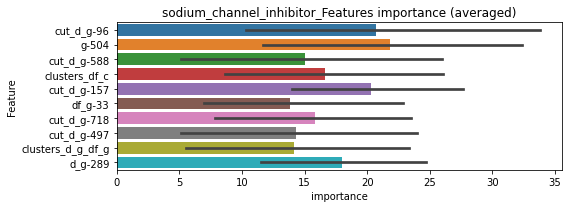

len(train_index) : 3638
len(valid_index) : 3639
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297108	valid_1's binary_logloss: 0.0914489
[200]	training's binary_logloss: 0.00705563	valid_1's binary_logloss: 0.0805913
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00766958	valid_1's binary_logloss: 0.0799865


len(train_index) : 3639
len(valid_index) : 3638
================================= fold 2/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270644	valid_1's binary_logloss: 0.0884634
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0102474	valid_1's binary_logloss: 0.0803205


sodium_channel_inhibitor logloss: 0.08015350303783554


neg labels: 3289 → selected neg labels: 3283


sphingosine_receptor_agonist, len(trt): 32, len(othr): 3283, target_rate: 0.0013437 → Adj_target_rate: 0.0015980
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277471	valid_1's binary_logloss: 0.0432053
[200]	training's binary_logloss: 0.00401723	valid_1's binary_logloss: 0.0138276
[300]	training's binary_logloss: 0.00117285	valid_1's binary_logloss: 0.00877346
[400]	training's binary_logloss: 0.00059174	valid_1's binary_logloss: 0.00700731
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000441402	valid_1's binary_logloss: 0.00663026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293711	valid_1's binary_logloss: 0.0499976
[200]	training's binary_logloss: 0.00420056	valid_1's binary_logloss: 0.0194799
[300]	training's binary_logloss: 0.00119289	valid_1's binary_logloss: 0.0141196
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000669743	valid_1's binary_logloss: 0.012902


1 / 3 AUC score:1.000
y_Threshold: 0.0024736, Threshold: 0.0043986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00134
Num_p_label: 80.0, conf_0:0.00396, conf_1:0.00484
Num_p_label: 80.0, Expected: 5.4, Adj_threshold_1: 0.0043986
Num_p_label: 11.0, Expected: 5.4, Adj_threshold_2: 0.0143986
Num_p_label: 3.0, Expected: 5.4, Adj_threshold_3: 0.0243986
threshold: 0.0243986, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283033	valid_1's binary_logloss: 0.0437854
[200]	training's binary_logloss: 0.00400849	valid_1's binary_logloss: 0.0135745
[300]	training's binary_logloss: 0.00115432	valid_1's binary_logloss: 0.00839709
[400]	training's binary_logloss: 0.000590548	valid_1's binary_logloss: 0.00694406
[500]	training's binary_logloss: 0.000413256	valid_1's binary_logloss: 0.0064298
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000393966	valid_1's binary_logloss: 0.00632192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294936	valid_1's binary_logloss: 0.0508618
[200]	training's binary_logloss: 0.00410378	valid_1's binary_logloss: 0.0190585
[300]	training's binary_logloss: 0.00119512	valid_1's binary_logloss: 0.0142221
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00092942	valid_1's binary_logloss: 0.0131632


2 / 3 AUC score:1.000
y_Threshold: 0.0168831, Threshold: 0.0243986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0052737 Vs.target_rate: 0.00134
Num_p_label: 21.0, conf_0:0.02196, conf_1:0.02684
Num_p_label: 21.0, Expected: 5.4, Adj_threshold_1: 0.0243986
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_2: 0.0343986
Num_p_label: 7.0, Expected: 5.4, Adj_threshold_3: 0.0443986
threshold: 0.0443986, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288529	valid_1's binary_logloss: 0.0463145
[200]	training's binary_logloss: 0.00403272	valid_1's binary_logloss: 0.0136992
[300]	training's binary_logloss: 0.0011729	valid_1's binary_logloss: 0.0080717
[400]	training's binary_logloss: 0.000591141	valid_1's binary_logloss: 0.00638937
[500]	training's binary_logloss: 0.000414441	valid_1's binary_logloss: 0.00579765
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000417723	valid_1's binary_logloss: 0.00579029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286279	valid_1's binary_logloss: 0.0452687
[200]	training's binary_logloss: 0.00392329	valid_1's binary_logloss: 0.014128
[300]	training's binary_logloss: 0.00114293	valid_1's binary_logloss: 0.00933968
[400]	training's binary_logloss: 0.000585879	valid_1's binary_logloss: 0.00797082
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0238867, Threshold: 0.0443986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0010045 Vs.target_rate: 0.00134
Num_p_label: 4.0, conf_0:0.03996, conf_1:0.04884
threshold: 0.0443986, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 659.0/7787, y_label_rate: 0.0846282


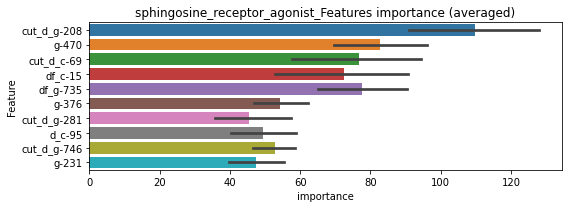

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158454	valid_1's binary_logloss: 0.0308855
[200]	training's binary_logloss: 0.00221373	valid_1's binary_logloss: 0.0136782
[300]	training's binary_logloss: 0.000605655	valid_1's binary_logloss: 0.0106507
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000379673	valid_1's binary_logloss: 0.0101928


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160988	valid_1's binary_logloss: 0.0265152
[200]	training's binary_logloss: 0.00228165	valid_1's binary_logloss: 0.00904675
[300]	training's binary_logloss: 0.000647062	valid_1's binary_logloss: 0.00622431
[400]	training's binary_logloss: 0.000319597	valid_1's binary_logloss: 0.00525405
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000234518	valid_1's binary_logloss: 0.00494305


sphingosine_receptor_agonist logloss: 0.007568237615460526


neg labels: 3289 → selected neg labels: 3277


src_inhibitor, len(trt): 71, len(othr): 3277, target_rate: 0.0029814 → Adj_target_rate: 0.0031461
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389419	valid_1's binary_logloss: 0.0778208
[200]	training's binary_logloss: 0.00679503	valid_1's binary_logloss: 0.0337526
[300]	training's binary_logloss: 0.00208475	valid_1's binary_logloss: 0.0252205
[400]	training's binary_logloss: 0.00103118	valid_1's binary_logloss: 0.0225733
[500]	training's binary_logloss: 0.000663202	valid_1's binary_logloss: 0.0212323
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000688464	valid_1's binary_logloss: 0.0211833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391729	valid_1's binary_logloss: 0.0790792
[200]	training's binary_logloss: 0.00710609	valid_1's binary_logloss: 0.040472
[300]	training's binary_logloss: 0.00215945	valid_1's binary_logloss: 0.0310472
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00155728	valid_1's binary_logloss: 0.0295918


1 / 3 AUC score:0.999
y_Threshold: 0.0106718, Threshold: 0.0254250, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3796
p_label_rate: 0.0200904 Vs.target_rate: 0.00298
Num_p_label: 80.0, conf_0:0.02288, conf_1:0.02797
Num_p_label: 80.0, Expected: 11.9, Adj_threshold_1: 0.0254250
Num_p_label: 60.0, Expected: 11.9, Adj_threshold_2: 0.0354250
Num_p_label: 47.0, Expected: 11.9, Adj_threshold_3: 0.0454250
Num_p_label: 35.0, Expected: 11.9, Adj_threshold_4: 0.0554250
Num_p_label: 32.0, Expected: 11.9, Adj_threshold_5: 0.0654250
Num_p_label: 24.0, Expected: 11.9, Adj_threshold_6: 0.0754250
Num_p_label: 21.0, Expected: 11.9, Adj_threshold_7: 0.0854250
threshold: 0.0854250, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 653.0/3796, y_label_rate: 0.1720232
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374748	valid_1's binary_logloss: 0.0830583
[200]	training's binary_logloss: 0.0062411	valid_1's binary_logloss: 0.0400641
[300]	training's binary_logloss: 0.00189478	valid_1's binary_logloss: 0.0300981
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00106053	valid_1's binary_logloss: 0.0282673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038291	valid_1's binary_logloss: 0.0776739
[200]	training's binary_logloss: 0.00641075	valid_1's binary_logloss: 0.0349387
[300]	training's binary_logloss: 0.00193743	valid_1's binary_logloss: 0.0248068
[400]	training's binary_logloss: 0.000947447	valid_1's binary_logloss: 0.0218971
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000853127	valid_1's binary_logloss: 0.0215343


2 / 3 AUC score:0.999
y_Threshold: 0.0611183, Threshold: 0.0854250, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 644.0/3778
p_label_rate: 0.0218483 Vs.target_rate: 0.00298
Num_p_label: 87.0, conf_0:0.07688, conf_1:0.09397
Num_p_label: 87.0, Expected: 11.9, Adj_threshold_1: 0.0854250
Num_p_label: 80.0, Expected: 11.9, Adj_threshold_2: 0.0954250
Num_p_label: 75.0, Expected: 11.9, Adj_threshold_3: 0.1054250
Num_p_label: 69.0, Expected: 11.9, Adj_threshold_4: 0.1154250
Num_p_label: 65.0, Expected: 11.9, Adj_threshold_5: 0.1254250
Num_p_label: 62.0, Expected: 11.9, Adj_threshold_6: 0.1354250
Num_p_label: 57.0, Expected: 11.9, Adj_threshold_7: 0.1454250
Num_p_label: 54.0, Expected: 11.9, Adj_threshold_8: 0.1554250
Num_p_label: 52.0, Expected: 11.9, Adj_threshold_9: 0.1654250
Num_p_label: 49.0, Expected: 11.9, Adj_threshold_10: 0.1754250
threshold: 0.1854250, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 644.0/3778, y_label_rate: 0.170460

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373717	valid_1's binary_logloss: 0.066115
[200]	training's binary_logloss: 0.00617501	valid_1's binary_logloss: 0.0249526
[300]	training's binary_logloss: 0.001849	valid_1's binary_logloss: 0.0154251
[400]	training's binary_logloss: 0.000924298	valid_1's binary_logloss: 0.0125655
[500]	training's binary_logloss: 0.00061703	valid_1's binary_logloss: 0.0113855
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000525952	valid_1's binary_logloss: 0.0109176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374962	valid_1's binary_logloss: 0.0772387
[200]	training's binary_logloss: 0.00621671	valid_1's binary_logloss: 0.0362719
[300]	training's binary_logloss: 0.00187596	valid_1's binary_logloss: 0.0274738
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00165515	valid_1's binary_logloss: 0.0273105


3 / 3 AUC score:1.000
y_Threshold: 0.0858432, Threshold: 0.1854250, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 638.0/3766
p_label_rate: 0.0125565 Vs.target_rate: 0.00298
Num_p_label: 50.0, conf_0:0.16688, conf_1:0.20397
Num_p_label: 50.0, Expected: 11.9, Adj_threshold_1: 0.1854250
Num_p_label: 47.0, Expected: 11.9, Adj_threshold_2: 0.1954250
Num_p_label: 45.0, Expected: 11.9, Adj_threshold_3: 0.2054250
Num_p_label: 45.0, Expected: 11.9, Adj_threshold_4: 0.2154250
Num_p_label: 40.0, Expected: 11.9, Adj_threshold_5: 0.2254250
Num_p_label: 38.0, Expected: 11.9, Adj_threshold_6: 0.2354250
Num_p_label: 36.0, Expected: 11.9, Adj_threshold_7: 0.2454250
Num_p_label: 35.0, Expected: 11.9, Adj_threshold_8: 0.2554250
Num_p_label: 35.0, Expected: 11.9, Adj_threshold_9: 0.2654250
Num_p_label: 32.0, Expected: 11.9, Adj_threshold_10: 0.2754250
threshold: 0.2854250, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 670.0/7748, y_label_rate: 0.086473

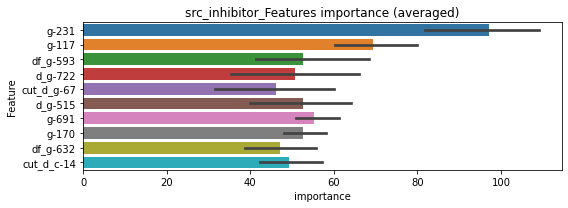

len(train_index) : 3874
len(valid_index) : 3874
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194116	valid_1's binary_logloss: 0.0499948
[200]	training's binary_logloss: 0.00336304	valid_1's binary_logloss: 0.0291993
[300]	training's binary_logloss: 0.000957558	valid_1's binary_logloss: 0.0250992
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000604529	valid_1's binary_logloss: 0.024105


len(train_index) : 3874
len(valid_index) : 3874
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198115	valid_1's binary_logloss: 0.0463042
[200]	training's binary_logloss: 0.00330097	valid_1's binary_logloss: 0.0253175
[300]	training's binary_logloss: 0.00101536	valid_1's binary_logloss: 0.0210324
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000704565	valid_1's binary_logloss: 0.0204061


src_inhibitor logloss: 0.022255544106509928


neg labels: 3289 → selected neg labels: 3276


steroid, len(trt): 79, len(othr): 3276, target_rate: 0.0033174 → Adj_target_rate: 0.0034449
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452381	valid_1's binary_logloss: 0.0998146
[200]	training's binary_logloss: 0.00927621	valid_1's binary_logloss: 0.0586642
[300]	training's binary_logloss: 0.00278598	valid_1's binary_logloss: 0.0472905
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00145523	valid_1's binary_logloss: 0.0446808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472409	valid_1's binary_logloss: 0.088269
[200]	training's binary_logloss: 0.00982749	valid_1's binary_logloss: 0.0479946
[300]	training's binary_logloss: 0.00292022	valid_1's binary_logloss: 0.0372223
[400]	training's binary_logloss: 0.00136311	valid_1's binary_logloss: 0.0345288
[500]	training's binary_logloss: 0.000840469	valid_1's binary_logloss: 0.0324608
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.00081918	valid_1's binary_logloss: 0.0323123


1 / 3 AUC score:0.999
y_Threshold: 0.0086764, Threshold: 0.0137607, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3793
p_label_rate: 0.0200904 Vs.target_rate: 0.00332
Num_p_label: 80.0, conf_0:0.01238, conf_1:0.01514
Num_p_label: 80.0, Expected: 13.2, Adj_threshold_1: 0.0137607
Num_p_label: 37.0, Expected: 13.2, Adj_threshold_2: 0.0237607
Num_p_label: 14.0, Expected: 13.2, Adj_threshold_3: 0.0337607
threshold: 0.0337607, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 652.0/3793, y_label_rate: 0.1718956
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434441	valid_1's binary_logloss: 0.107146
[200]	training's binary_logloss: 0.00821778	valid_1's binary_logloss: 0.0674985
[300]	training's binary_logloss: 0.00252081	valid_1's binary_logloss: 0.0575745
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00197482	valid_1's binary_logloss: 0.05696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461888	valid_1's binary_logloss: 0.0883692
[200]	training's binary_logloss: 0.00921524	valid_1's binary_logloss: 0.0430089
[300]	training's binary_logloss: 0.00277208	valid_1's binary_logloss: 0.0307157
[400]	training's binary_logloss: 0.00131119	valid_1's binary_logloss: 0.0262266
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000925051	valid_1's binary_logloss: 0.0247688


2 / 3 AUC score:0.999
y_Threshold: 0.0286447, Threshold: 0.0337607, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 640.0/3769
p_label_rate: 0.0128076 Vs.target_rate: 0.00332
Num_p_label: 51.0, conf_0:0.03038, conf_1:0.03714
Num_p_label: 51.0, Expected: 13.2, Adj_threshold_1: 0.0337607
Num_p_label: 39.0, Expected: 13.2, Adj_threshold_2: 0.0437607
Num_p_label: 25.0, Expected: 13.2, Adj_threshold_3: 0.0537607
threshold: 0.0537607, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 640.0/3769, y_label_rate: 0.1698063
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417058	valid_1's binary_logloss: 0.0877711
[200]	training's binary_logloss: 0.00795729	valid_1's binary_logloss: 0.0454498
[300]	training's binary_logloss: 0.00238236	valid_1's binary_logloss: 0.0355902
[400]	training's binary_logloss: 0.00114325	valid_1's binary_logloss: 0.0327719
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00111022	valid_1's binary_logloss: 0.0326253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441484	valid_1's binary_logloss: 0.0955015
[200]	training's binary_logloss: 0.00847327	valid_1's binary_logloss: 0.0551905
[300]	training's binary_logloss: 0.00253181	valid_1's binary_logloss: 0.0463153
[400]	training's binary_logloss: 0.00120168	valid_1's binary_logloss: 0.0427612
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00113662	valid_1's binary_logloss: 0.0425697


3 / 3 AUC score:1.000
y_Threshold: 0.0276886, Threshold: 0.0537607, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 633.0/3755
p_label_rate: 0.0055249 Vs.target_rate: 0.00332
Num_p_label: 22.0, conf_0:0.04838, conf_1:0.05914
threshold: 0.0537607, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 655.0/7737, y_label_rate: 0.0846581


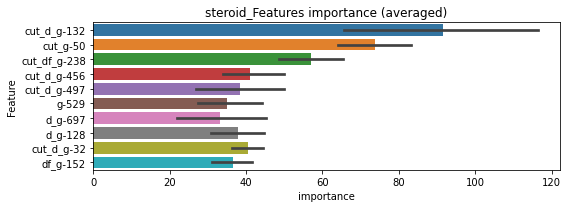

len(train_index) : 3868
len(valid_index) : 3869
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224781	valid_1's binary_logloss: 0.0601437
[200]	training's binary_logloss: 0.00429843	valid_1's binary_logloss: 0.0395378
[300]	training's binary_logloss: 0.00128022	valid_1's binary_logloss: 0.0350693
[400]	training's binary_logloss: 0.000606442	valid_1's binary_logloss: 0.0337505
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000583791	valid_1's binary_logloss: 0.0336325


len(train_index) : 3869
len(valid_index) : 3868
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259113	valid_1's binary_logloss: 0.0556235
[200]	training's binary_logloss: 0.00503092	valid_1's binary_logloss: 0.0325037
[300]	training's binary_logloss: 0.00150294	valid_1's binary_logloss: 0.0276555
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0010944	valid_1's binary_logloss: 0.0271698


steroid logloss: 0.03040159318629054


neg labels: 3289 → selected neg labels: 3286


syk_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204386	valid_1's binary_logloss: 0.0298603
[200]	training's binary_logloss: 0.00222371	valid_1's binary_logloss: 0.00797479
[300]	training's binary_logloss: 0.000635514	valid_1's binary_logloss: 0.00469578
[400]	training's binary_logloss: 0.000356977	valid_1's binary_logloss: 0.00392809
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000314146	valid_1's binary_logloss: 0.00377553
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020468	valid_1's binary_logloss: 0.0247857
[200]	training's binary_logloss: 0.00225607	valid_1's binary_logloss: 0.00474293
[300]	training's binary_logloss: 0.00065233	valid_1's binary_logloss: 0.00238293
[400]	training's binary_logloss: 0.000356332	valid_1's binary_logloss: 0.00172679
[500]	training's binary_logloss: 0.000303441	valid_1's binary_logloss: 0.00158325
Early stopping, best iteration is

1 / 3 AUC score:1.000
y_Threshold: 0.0016898, Threshold: 0.0042529, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00383, conf_1:0.00468
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0042529
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_2: 0.0142529
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_3: 0.0242529
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_4: 0.0342529
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_5: 0.0442529
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_6: 0.0542529
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_7: 0.0642529
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_8: 0.0742529
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_9: 0.0842529
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_10: 0.0942529
threshold: 0.1042529, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=================

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201049	valid_1's binary_logloss: 0.0281452
[200]	training's binary_logloss: 0.00209226	valid_1's binary_logloss: 0.00573453
[300]	training's binary_logloss: 0.000596904	valid_1's binary_logloss: 0.00281632
[400]	training's binary_logloss: 0.000334543	valid_1's binary_logloss: 0.00231031
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000294887	valid_1's binary_logloss: 0.00223121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203822	valid_1's binary_logloss: 0.0239984
[200]	training's binary_logloss: 0.0022045	valid_1's binary_logloss: 0.00378869
[300]	training's binary_logloss: 0.000619742	valid_1's binary_logloss: 0.00156375
[400]	training's binary_logloss: 0.000340815	valid_1's binary_logloss: 0.00101929
[500]	training's binary_logloss: 0.00028867	valid_1's binary_logloss: 0.000926019
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.1281544, Threshold: 0.1042529, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0060271 Vs.target_rate: 0.00080
Num_p_label: 24.0, conf_0:0.09383, conf_1:0.11468
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_1: 0.1042529
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_2: 0.1142529
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_3: 0.1242529
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_4: 0.1342529
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_5: 0.1442529
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_6: 0.1542529
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_7: 0.1642529
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_8: 0.1742529
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_9: 0.1842529
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_10: 0.1942529
threshold: 0.2042529, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201049	valid_1's binary_logloss: 0.0281452
[200]	training's binary_logloss: 0.00209226	valid_1's binary_logloss: 0.00573453
[300]	training's binary_logloss: 0.000596904	valid_1's binary_logloss: 0.00281632
[400]	training's binary_logloss: 0.000334543	valid_1's binary_logloss: 0.00231031
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000294887	valid_1's binary_logloss: 0.00223121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203822	valid_1's binary_logloss: 0.0239984
[200]	training's binary_logloss: 0.0022045	valid_1's binary_logloss: 0.00378869
[300]	training's binary_logloss: 0.000619742	valid_1's binary_logloss: 0.00156375
[400]	training's binary_logloss: 0.000340815	valid_1's binary_logloss: 0.00101929
[500]	training's binary_logloss: 0.00028867	valid_1's binary_logloss: 0.000926019
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.1281544, Threshold: 0.2042529, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0030136 Vs.target_rate: 0.00080
Num_p_label: 12.0, conf_0:0.18383, conf_1:0.22468
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_1: 0.2042529
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_2: 0.2142529
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_3: 0.2242529
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_4: 0.2342529
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_5: 0.2442529
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_6: 0.2542529
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_7: 0.2642529
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_8: 0.2742529
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_9: 0.2842529
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_10: 0.2942529
threshold: 0.3042529, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 667.0/7793, y_label_rate: 0.0855896


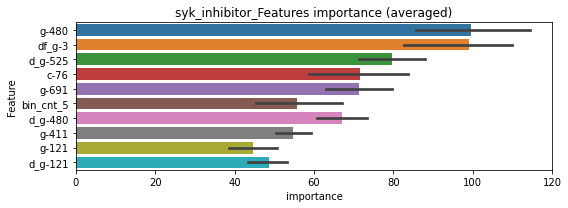

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105863	valid_1's binary_logloss: 0.0159453
[200]	training's binary_logloss: 0.00111089	valid_1's binary_logloss: 0.00435077
[300]	training's binary_logloss: 0.000317434	valid_1's binary_logloss: 0.00295308
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000182883	valid_1's binary_logloss: 0.00272698


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109737	valid_1's binary_logloss: 0.0147084
[200]	training's binary_logloss: 0.00119865	valid_1's binary_logloss: 0.00369701
[300]	training's binary_logloss: 0.00035217	valid_1's binary_logloss: 0.00257687
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000201829	valid_1's binary_logloss: 0.0024298


syk_inhibitor logloss: 0.002578410925963637


neg labels: 3289 → selected neg labels: 3279


tachykinin_antagonist, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447616	valid_1's binary_logloss: 0.095872
[200]	training's binary_logloss: 0.00867674	valid_1's binary_logloss: 0.057722
[300]	training's binary_logloss: 0.00239813	valid_1's binary_logloss: 0.0480832
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0014951	valid_1's binary_logloss: 0.0462485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455764	valid_1's binary_logloss: 0.0799757
[200]	training's binary_logloss: 0.00837614	valid_1's binary_logloss: 0.0371553
[300]	training's binary_logloss: 0.00239033	valid_1's binary_logloss: 0.0273806
[400]	training's binary_logloss: 0.00112072	valid_1's binary_logloss: 0.0249398
[500]	training's binary_logloss: 0.000708131	valid_1's binary_logloss: 0.0232672
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000605702	valid_1's binary_logloss: 0.0227774


1 / 3 AUC score:0.999
y_Threshold: 0.0057960, Threshold: 0.0076648, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3794
p_label_rate: 0.0200904 Vs.target_rate: 0.00252
Num_p_label: 80.0, conf_0:0.00690, conf_1:0.00843
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0076648
Num_p_label: 10.0, Expected: 10.0, Adj_threshold_2: 0.0176648
threshold: 0.0176648, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 651.0/3794, y_label_rate: 0.1715867
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438023	valid_1's binary_logloss: 0.0838229
[200]	training's binary_logloss: 0.00796498	valid_1's binary_logloss: 0.037113
[300]	training's binary_logloss: 0.00228018	valid_1's binary_logloss: 0.0265868
[400]	training's binary_logloss: 0.00107595	valid_1's binary_logloss: 0.0231092
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00104535	valid_1's binary_logloss: 0.0230125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456333	valid_1's binary_logloss: 0.0807605
[200]	training's binary_logloss: 0.00837749	valid_1's binary_logloss: 0.0324796
[300]	training's binary_logloss: 0.00239032	valid_1's binary_logloss: 0.0218714
[400]	training's binary_logloss: 0.00113121	valid_1's binary_logloss: 0.0188704
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00111898	valid_1's binary_logloss: 0.0188454


2 / 3 AUC score:1.000
y_Threshold: 0.0284395, Threshold: 0.0176648, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 648.0/3788
p_label_rate: 0.0092918 Vs.target_rate: 0.00252
Num_p_label: 37.0, conf_0:0.01590, conf_1:0.01943
Num_p_label: 37.0, Expected: 10.0, Adj_threshold_1: 0.0176648
Num_p_label: 10.0, Expected: 10.0, Adj_threshold_2: 0.0276648
threshold: 0.0276648, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 648.0/3788, y_label_rate: 0.1710665
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453837	valid_1's binary_logloss: 0.0799
[200]	training's binary_logloss: 0.00806286	valid_1's binary_logloss: 0.0313785
[300]	training's binary_logloss: 0.00232228	valid_1's binary_logloss: 0.0196887
[400]	training's binary_logloss: 0.00109321	valid_1's binary_logloss: 0.0160499
[500]	training's binary_logloss: 0.000694695	valid_1's binary_logloss: 0.0146421
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000609447	valid_1's binary_logloss: 0.0141569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045688	valid_1's binary_logloss: 0.0822102
[200]	training's binary_logloss: 0.00835358	valid_1's binary_logloss: 0.0357581
[300]	training's binary_logloss: 0.00240475	valid_1's binary_logloss: 0.0248198
[400]	training's binary_logloss: 0.00110332	valid_1's binary_logloss: 0.0215624
[500]	training's binary_logloss: 0.000693906	va

3 / 3 AUC score:1.000
y_Threshold: 0.0290318, Threshold: 0.0276648, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 648.0/3788
p_label_rate: 0.0025113 Vs.target_rate: 0.00252
Num_p_label: 10.0, conf_0:0.02490, conf_1:0.03043
threshold: 0.0276648, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 658.0/7770, y_label_rate: 0.0846847


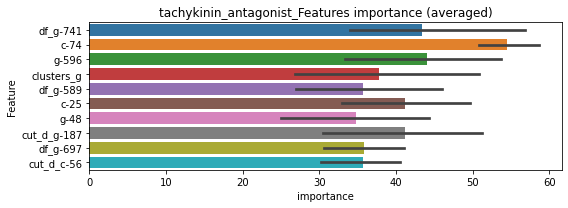

len(train_index) : 3885
len(valid_index) : 3885
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242771	valid_1's binary_logloss: 0.0510372
[200]	training's binary_logloss: 0.00435213	valid_1's binary_logloss: 0.0273529
[300]	training's binary_logloss: 0.00122135	valid_1's binary_logloss: 0.0226557
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000637665	valid_1's binary_logloss: 0.0214958


len(train_index) : 3885
len(valid_index) : 3885
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025036	valid_1's binary_logloss: 0.045896
[200]	training's binary_logloss: 0.0046109	valid_1's binary_logloss: 0.0217301
[300]	training's binary_logloss: 0.00128785	valid_1's binary_logloss: 0.0154522
[400]	training's binary_logloss: 0.000565251	valid_1's binary_logloss: 0.0134218
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000433704	valid_1's binary_logloss: 0.0129524


tachykinin_antagonist logloss: 0.01722406667269041


neg labels: 3289 → selected neg labels: 3284


tgf-beta_receptor_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185015	valid_1's binary_logloss: 0.0235955
[200]	training's binary_logloss: 0.00176085	valid_1's binary_logloss: 0.0057416
[300]	training's binary_logloss: 0.000461422	valid_1's binary_logloss: 0.00473005
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000316773	valid_1's binary_logloss: 0.0046207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186394	valid_1's binary_logloss: 0.0238431
[200]	training's binary_logloss: 0.00172307	valid_1's binary_logloss: 0.00550736
[300]	training's binary_logloss: 0.000461405	valid_1's binary_logloss: 0.00404591
[400]	training's binary_logloss: 0.000258642	valid_1's binary_logloss: 0.00368266
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000246424	valid_1's binary_logloss: 0.00365594


1 / 3 AUC score:1.000
y_Threshold: 0.0007428, Threshold: 0.0012339, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00111, conf_1:0.00136
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0012339
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_2: 0.0112339
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_3: 0.0212339
threshold: 0.0212339, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170838	valid_1's binary_logloss: 0.0200988
[200]	training's binary_logloss: 0.00143131	valid_1's binary_logloss: 0.00307678
[300]	training's binary_logloss: 0.000341634	valid_1's binary_logloss: 0.00133805
[400]	training's binary_logloss: 0.000204239	valid_1's binary_logloss: 0.00103372
[500]	training's binary_logloss: 0.000181133	valid_1's binary_logloss: 0.000991955
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000180952	valid_1's binary_logloss: 0.000991726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170354	valid_1's binary_logloss: 0.0190452
[200]	training's binary_logloss: 0.00143205	valid_1's binary_logloss: 0.00253259
[300]	training's binary_logloss: 0.000343318	valid_1's binary_logloss: 0.000961691
[400]	training's binary_logloss: 0.000203745	valid_1's binary_logloss: 0.000682146
Early stopping, best iterat

2 / 3 AUC score:1.000
y_Threshold: 0.1155719, Threshold: 0.0212339, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0138122 Vs.target_rate: 0.00126
Num_p_label: 55.0, conf_0:0.01911, conf_1:0.02336
Num_p_label: 55.0, Expected: 5.0, Adj_threshold_1: 0.0212339
Num_p_label: 46.0, Expected: 5.0, Adj_threshold_2: 0.0312339
Num_p_label: 39.0, Expected: 5.0, Adj_threshold_3: 0.0412339
Num_p_label: 35.0, Expected: 5.0, Adj_threshold_4: 0.0512339
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_5: 0.0612339
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_6: 0.0712339
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_7: 0.0812339
Num_p_label: 25.0, Expected: 5.0, Adj_threshold_8: 0.0912339
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_9: 0.1012339
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_10: 0.1112339
threshold: 0.1212339, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170838	valid_1's binary_logloss: 0.0200988
[200]	training's binary_logloss: 0.00143131	valid_1's binary_logloss: 0.00307678
[300]	training's binary_logloss: 0.000341634	valid_1's binary_logloss: 0.00133805
[400]	training's binary_logloss: 0.000204239	valid_1's binary_logloss: 0.00103372
[500]	training's binary_logloss: 0.000181133	valid_1's binary_logloss: 0.000991955
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000180952	valid_1's binary_logloss: 0.000991726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170354	valid_1's binary_logloss: 0.0190452
[200]	training's binary_logloss: 0.00143205	valid_1's binary_logloss: 0.00253259
[300]	training's binary_logloss: 0.000343318	valid_1's binary_logloss: 0.000961691
[400]	training's binary_logloss: 0.000203745	valid_1's binary_logloss: 0.000682146
Early stopping, best iterat

3 / 3 AUC score:1.000
y_Threshold: 0.1155719, Threshold: 0.1212339, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0050226 Vs.target_rate: 0.00126
Num_p_label: 20.0, conf_0:0.10911, conf_1:0.13336
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_1: 0.1212339
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_2: 0.1312339
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_3: 0.1412339
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_4: 0.1512339
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_5: 0.1612339
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_6: 0.1712339
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_7: 0.1812339
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_8: 0.1912339
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_9: 0.2012339
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_10: 0.2112339
threshold: 0.2212339, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 669.0/7790, y_label_rate: 0.0858793


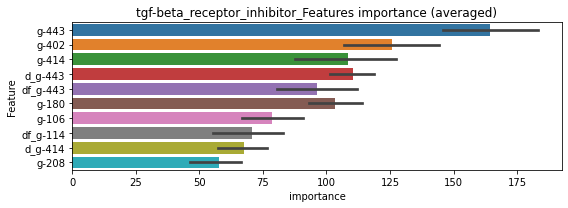

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00927211	valid_1's binary_logloss: 0.0149962
[200]	training's binary_logloss: 0.000768333	valid_1's binary_logloss: 0.00533423
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.000265035	valid_1's binary_logloss: 0.00452505


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00977043	valid_1's binary_logloss: 0.0106835
[200]	training's binary_logloss: 0.000876039	valid_1's binary_logloss: 0.00130938
[300]	training's binary_logloss: 0.000217152	valid_1's binary_logloss: 0.000447005
[400]	training's binary_logloss: 0.000125191	valid_1's binary_logloss: 0.000282171
[500]	training's binary_logloss: 0.000108569	valid_1's binary_logloss: 0.000248145
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000106635	valid_1's binary_logloss: 0.000244246


tgf-beta_receptor_inhibitor logloss: 0.0023847738782406215


neg labels: 3289 → selected neg labels: 3286


thrombin_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219844	valid_1's binary_logloss: 0.0355982
[200]	training's binary_logloss: 0.0025564	valid_1's binary_logloss: 0.0138822
[300]	training's binary_logloss: 0.000728872	valid_1's binary_logloss: 0.00950446
[400]	training's binary_logloss: 0.000387002	valid_1's binary_logloss: 0.00801121
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000334039	valid_1's binary_logloss: 0.00776429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225313	valid_1's binary_logloss: 0.0265494
[200]	training's binary_logloss: 0.00263959	valid_1's binary_logloss: 0.00424128
[300]	training's binary_logloss: 0.000755063	valid_1's binary_logloss: 0.00170873
[400]	training's binary_logloss: 0.00039646	valid_1's binary_logloss: 0.00111221
[500]	training's binary_logloss: 0.000315702	valid_1's binary_logloss: 0.000979239
Early stopping, best iteration is

1 / 3 AUC score:1.000
y_Threshold: 0.0013778, Threshold: 0.0018267, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00164, conf_1:0.00201
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0018267
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_2: 0.0118267
threshold: 0.0118267, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218194	valid_1's binary_logloss: 0.0342222
[200]	training's binary_logloss: 0.00241714	valid_1's binary_logloss: 0.0108887
[300]	training's binary_logloss: 0.000704331	valid_1's binary_logloss: 0.00693559
[400]	training's binary_logloss: 0.000378457	valid_1's binary_logloss: 0.005739
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000313458	valid_1's binary_logloss: 0.00546927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225744	valid_1's binary_logloss: 0.0265619
[200]	training's binary_logloss: 0.00259598	valid_1's binary_logloss: 0.00444171
[300]	training's binary_logloss: 0.000745963	valid_1's binary_logloss: 0.00202161
[400]	training's binary_logloss: 0.000394983	valid_1's binary_logloss: 0.00146326
[500]	training's binary_logloss: 0.000315855	valid_1's binary_logloss: 0.00132068
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0287019, Threshold: 0.0118267, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0037670 Vs.target_rate: 0.00080
Num_p_label: 15.0, conf_0:0.01064, conf_1:0.01301
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_1: 0.0118267
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_2: 0.0218267
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_3: 0.0318267
threshold: 0.0318267, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218194	valid_1's binary_logloss: 0.0342222
[200]	training's binary_logloss: 0.00241714	valid_1's binary_logloss: 0.0108887
[300]	training's binary_logloss: 0.000704331	valid_1's binary_logloss: 0.00693559
[400]	training's binary_logloss: 0.000378457	valid_1's binary_logloss: 0.005739
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000313458	valid_1's binary_logloss: 0.00546927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225744	valid_1's binary_logloss: 0.0265619
[200]	training's binary_logloss: 0.00259598	valid_1's binary_logloss: 0.00444171
[300]	training's binary_logloss: 0.000745963	valid_1's binary_logloss: 0.00202161
[400]	training's binary_logloss: 0.000394983	valid_1's binary_logloss: 0.00146326
[500]	training's binary_logloss: 0.000315855	valid_1's binary_logloss: 0.00132068
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.0287019, Threshold: 0.0318267, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00080
Num_p_label: 6.0, conf_0:0.02864, conf_1:0.03501
threshold: 0.0318267, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


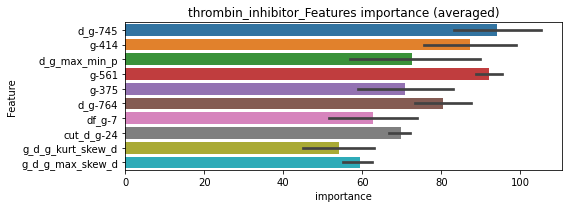

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0116765	valid_1's binary_logloss: 0.0187811
[200]	training's binary_logloss: 0.00130594	valid_1's binary_logloss: 0.00712018
[300]	training's binary_logloss: 0.000360913	valid_1's binary_logloss: 0.00648763
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.000391188	valid_1's binary_logloss: 0.00645959


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121679	valid_1's binary_logloss: 0.0183144
[200]	training's binary_logloss: 0.00142325	valid_1's binary_logloss: 0.00580538
[300]	training's binary_logloss: 0.000403624	valid_1's binary_logloss: 0.00436182
[400]	training's binary_logloss: 0.000206436	valid_1's binary_logloss: 0.00390629
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000176883	valid_1's binary_logloss: 0.00378906


thrombin_inhibitor logloss: 0.005124496261456892


neg labels: 3289 → selected neg labels: 3285


thymidylate_synthase_inhibitor, len(trt): 37, len(othr): 3285, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312191	valid_1's binary_logloss: 0.0544672
[200]	training's binary_logloss: 0.00443743	valid_1's binary_logloss: 0.0206064
[300]	training's binary_logloss: 0.00125689	valid_1's binary_logloss: 0.0147942
[400]	training's binary_logloss: 0.000628733	valid_1's binary_logloss: 0.0131239
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.000621837	valid_1's binary_logloss: 0.0130821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329898	valid_1's binary_logloss: 0.0493351
[200]	training's binary_logloss: 0.00481309	valid_1's binary_logloss: 0.0120806
[300]	training's binary_logloss: 0.0013808	valid_1's binary_logloss: 0.00541921
[400]	training's binary_logloss: 0.000684489	valid_1's binary_logloss: 0.00359785
[500]	training's binary_logloss: 0.000458768	valid_1's binary_logloss: 0.00290728
Early stopping, best iteration is:
[559

1 / 3 AUC score:1.000
y_Threshold: 0.0030300, Threshold: 0.0038501, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00347, conf_1:0.00424
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0038501
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_2: 0.0138501
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_3: 0.0238501
threshold: 0.0238501, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315212	valid_1's binary_logloss: 0.053116
[200]	training's binary_logloss: 0.00436994	valid_1's binary_logloss: 0.0194986
[300]	training's binary_logloss: 0.0012249	valid_1's binary_logloss: 0.0138516
[400]	training's binary_logloss: 0.000612127	valid_1's binary_logloss: 0.0127246
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000594803	valid_1's binary_logloss: 0.0126919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331035	valid_1's binary_logloss: 0.0475967
[200]	training's binary_logloss: 0.00477812	valid_1's binary_logloss: 0.0112165
[300]	training's binary_logloss: 0.00134811	valid_1's binary_logloss: 0.0046381
[400]	training's binary_logloss: 0.000675014	valid_1's binary_logloss: 0.00298008
[500]	training's binary_logloss: 0.000449443	valid_1's binary_logloss: 0.0022819
Early stopping, best iteration is:
[558]	t

2 / 3 AUC score:1.000
y_Threshold: 0.0107312, Threshold: 0.0238501, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00155
Num_p_label: 10.0, conf_0:0.02147, conf_1:0.02624
threshold: 0.0238501, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312767	valid_1's binary_logloss: 0.0520654
[200]	training's binary_logloss: 0.00447563	valid_1's binary_logloss: 0.0170758
[300]	training's binary_logloss: 0.00127152	valid_1's binary_logloss: 0.0105372
[400]	training's binary_logloss: 0.00062667	valid_1's binary_logloss: 0.008472
[500]	training's binary_logloss: 0.000429086	valid_1's binary_logloss: 0.0076928
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000429086	valid_1's binary_logloss: 0.0076928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321297	valid_1's binary_logloss: 0.0546311
[200]	training's binary_logloss: 0.00460313	valid_1's binary_logloss: 0.0200738
[300]	training's binary_logloss: 0.00130197	valid_1's binary_logloss: 0.0149084
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000892819	valid_1's binary_logloss: 0.0143879


3 / 3 AUC score:0.999
y_Threshold: 0.0165261, Threshold: 0.0238501, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0035158 Vs.target_rate: 0.00155
Num_p_label: 14.0, conf_0:0.02147, conf_1:0.02624
threshold: 0.0238501, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 667.0/7784, y_label_rate: 0.0856886


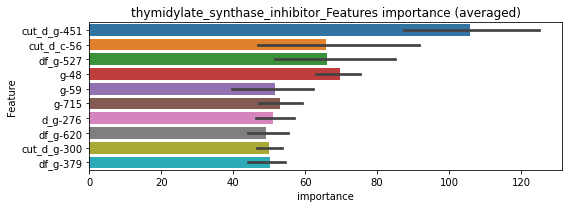

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175243	valid_1's binary_logloss: 0.0345775
[200]	training's binary_logloss: 0.002502	valid_1's binary_logloss: 0.0159218
[300]	training's binary_logloss: 0.000692804	valid_1's binary_logloss: 0.0127138
[400]	training's binary_logloss: 0.00033886	valid_1's binary_logloss: 0.0119894
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000347004	valid_1's binary_logloss: 0.0119557


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168496	valid_1's binary_logloss: 0.0296517
[200]	training's binary_logloss: 0.00245307	valid_1's binary_logloss: 0.0107386
[300]	training's binary_logloss: 0.000680029	valid_1's binary_logloss: 0.00773366
[400]	training's binary_logloss: 0.000326944	valid_1's binary_logloss: 0.00704601
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000239712	valid_1's binary_logloss: 0.00688344


thymidylate_synthase_inhibitor logloss: 0.009419585531459733


neg labels: 3289 → selected neg labels: 3284


tlr_agonist, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295086	valid_1's binary_logloss: 0.0475777
[200]	training's binary_logloss: 0.00413967	valid_1's binary_logloss: 0.0151254
[300]	training's binary_logloss: 0.00117655	valid_1's binary_logloss: 0.00915267
[400]	training's binary_logloss: 0.000597171	valid_1's binary_logloss: 0.0072998
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000447339	valid_1's binary_logloss: 0.00672772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308195	valid_1's binary_logloss: 0.0510287
[200]	training's binary_logloss: 0.00440384	valid_1's binary_logloss: 0.0133259
[300]	training's binary_logloss: 0.00122137	valid_1's binary_logloss: 0.00632532
[400]	training's binary_logloss: 0.000612722	valid_1's binary_logloss: 0.00462396
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000444071	valid_1's binary_logloss: 0.00405084


1 / 3 AUC score:1.000
y_Threshold: 0.0022828, Threshold: 0.0028640, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00258, conf_1:0.00315
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0028640
Num_p_label: 4.0, Expected: 5.0, Adj_threshold_2: 0.0128640
threshold: 0.0128640, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297332	valid_1's binary_logloss: 0.0489458
[200]	training's binary_logloss: 0.00411098	valid_1's binary_logloss: 0.0154453
[300]	training's binary_logloss: 0.00115701	valid_1's binary_logloss: 0.00950597
[400]	training's binary_logloss: 0.00057715	valid_1's binary_logloss: 0.00747418
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000443556	valid_1's binary_logloss: 0.00687431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309013	valid_1's binary_logloss: 0.0495789
[200]	training's binary_logloss: 0.00431793	valid_1's binary_logloss: 0.0128465
[300]	training's binary_logloss: 0.00121002	valid_1's binary_logloss: 0.00640028
[400]	training's binary_logloss: 0.0006117	valid_1's binary_logloss: 0.00463524
[500]	training's binary_logloss: 0.000428571	valid_1's binary_logloss: 0.00412214
Early stopping, best iteration is:
[54

2 / 3 AUC score:1.000
y_Threshold: 0.0257927, Threshold: 0.0128640, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0047715 Vs.target_rate: 0.00126
Num_p_label: 19.0, conf_0:0.01158, conf_1:0.01415
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_1: 0.0128640
Num_p_label: 5.0, Expected: 5.0, Adj_threshold_2: 0.0228640
threshold: 0.0228640, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297332	valid_1's binary_logloss: 0.0489458
[200]	training's binary_logloss: 0.00411098	valid_1's binary_logloss: 0.0154453
[300]	training's binary_logloss: 0.00115701	valid_1's binary_logloss: 0.00950597
[400]	training's binary_logloss: 0.00057715	valid_1's binary_logloss: 0.00747418
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000443556	valid_1's binary_logloss: 0.00687431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309013	valid_1's binary_logloss: 0.0495789
[200]	training's binary_logloss: 0.00431793	valid_1's binary_logloss: 0.0128465
[300]	training's binary_logloss: 0.00121002	valid_1's binary_logloss: 0.00640028
[400]	training's binary_logloss: 0.0006117	valid_1's binary_logloss: 0.00463524
[500]	training's binary_logloss: 0.000428571	valid_1's binary_logloss: 0.00412214
Early stopping, best iteration is:
[54

3 / 3 AUC score:1.000
y_Threshold: 0.0257927, Threshold: 0.0228640, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0012557 Vs.target_rate: 0.00126
Num_p_label: 5.0, conf_0:0.02058, conf_1:0.02515
threshold: 0.0228640, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 661.0/7790, y_label_rate: 0.0848524


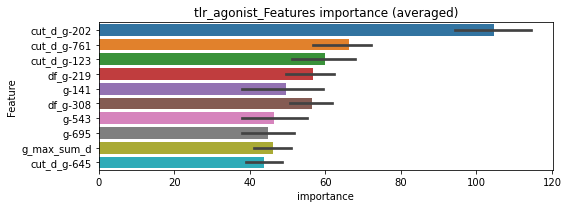

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154919	valid_1's binary_logloss: 0.0290431
[200]	training's binary_logloss: 0.00216678	valid_1's binary_logloss: 0.0124647
[300]	training's binary_logloss: 0.000611204	valid_1's binary_logloss: 0.00974722
[400]	training's binary_logloss: 0.000303669	valid_1's binary_logloss: 0.00911285
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000309545	valid_1's binary_logloss: 0.00907752


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161745	valid_1's binary_logloss: 0.0242055
[200]	training's binary_logloss: 0.00233247	valid_1's binary_logloss: 0.00608688
[300]	training's binary_logloss: 0.000650861	valid_1's binary_logloss: 0.0032768
[400]	training's binary_logloss: 0.000319518	valid_1's binary_logloss: 0.00270504
[500]	training's binary_logloss: 0.000215735	valid_1's binary_logloss: 0.00257338
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00021811	valid_1's binary_logloss: 0.00256576


tlr_agonist logloss: 0.005821642396676567


neg labels: 3289 → selected neg labels: 3287


tlr_antagonist, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167271	valid_1's binary_logloss: 0.018027
[200]	training's binary_logloss: 0.0014276	valid_1's binary_logloss: 0.00169147
[300]	training's binary_logloss: 0.000380346	valid_1's binary_logloss: 0.000498593
[400]	training's binary_logloss: 0.00022836	valid_1's binary_logloss: 0.000313749
[500]	training's binary_logloss: 0.000198145	valid_1's binary_logloss: 0.000274885
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000195475	valid_1's binary_logloss: 0.000271221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169196	valid_1's binary_logloss: 0.0182271
[200]	training's binary_logloss: 0.00143732	valid_1's binary_logloss: 0.00176923
[300]	training's binary_logloss: 0.000382659	valid_1's binary_logloss: 0.000541362
[400]	training's binary_logloss: 0.000229574	valid_1's binary_logloss: 0.000340341
[500]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0006122, Threshold: 0.0010695, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029
Num_p_label: 80.0, conf_0:0.00096, conf_1:0.00118
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0010695
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_2: 0.0110695
threshold: 0.0110695, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168693	valid_1's binary_logloss: 0.0192779
[200]	training's binary_logloss: 0.00141427	valid_1's binary_logloss: 0.00297532
[300]	training's binary_logloss: 0.000375195	valid_1's binary_logloss: 0.00170971
[400]	training's binary_logloss: 0.000227115	valid_1's binary_logloss: 0.00147406
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000218222	valid_1's binary_logloss: 0.00145383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171635	valid_1's binary_logloss: 0.0181136
[200]	training's binary_logloss: 0.00143223	valid_1's binary_logloss: 0.00169205
[300]	training's binary_logloss: 0.00037347	valid_1's binary_logloss: 0.000481816
[400]	training's binary_logloss: 0.000226604	valid_1's binary_logloss: 0.000302598
[500]	training's binary_logloss: 0.000197468	valid_1's binary_logloss: 0.000267917
Early stopping, best iteratio

2 / 3 AUC score:1.000
y_Threshold: 0.0744471, Threshold: 0.0110695, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0037670 Vs.target_rate: 0.00029
Num_p_label: 15.0, conf_0:0.00996, conf_1:0.01218
Num_p_label: 15.0, Expected: 1.2, Adj_threshold_1: 0.0110695
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_2: 0.0210695
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_3: 0.0310695
threshold: 0.0310695, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168693	valid_1's binary_logloss: 0.0192779
[200]	training's binary_logloss: 0.00141427	valid_1's binary_logloss: 0.00297532
[300]	training's binary_logloss: 0.000375195	valid_1's binary_logloss: 0.00170971
[400]	training's binary_logloss: 0.000227115	valid_1's binary_logloss: 0.00147406
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000218222	valid_1's binary_logloss: 0.00145383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171635	valid_1's binary_logloss: 0.0181136
[200]	training's binary_logloss: 0.00143223	valid_1's binary_logloss: 0.00169205
[300]	training's binary_logloss: 0.00037347	valid_1's binary_logloss: 0.000481816
[400]	training's binary_logloss: 0.000226604	valid_1's binary_logloss: 0.000302598
[500]	training's binary_logloss: 0.000197468	valid_1's binary_logloss: 0.000267917
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.0744471, Threshold: 0.0310695, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0000000 Vs.target_rate: 0.00029
Num_p_label: 0.0, conf_0:0.02796, conf_1:0.03418
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_1: 0.0310695
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_2: 0.0210695
threshold: 0.0210695, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7794, y_label_rate: 0.0850654


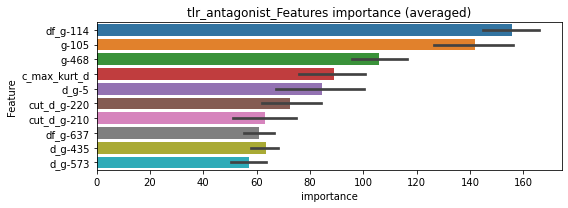

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0089713	valid_1's binary_logloss: 0.0149467
[200]	training's binary_logloss: 0.000752481	valid_1's binary_logloss: 0.00774496
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00047315	valid_1's binary_logloss: 0.00755472


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00939449	valid_1's binary_logloss: 0.0102864
[200]	training's binary_logloss: 0.000844772	valid_1's binary_logloss: 0.00193747
[300]	training's binary_logloss: 0.000226024	valid_1's binary_logloss: 0.00142471
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000175449	valid_1's binary_logloss: 0.00136275


tlr_antagonist logloss: 0.004458734181354317


neg labels: 3289 → selected neg labels: 3283


tnf_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314566	valid_1's binary_logloss: 0.0541355
[200]	training's binary_logloss: 0.00466364	valid_1's binary_logloss: 0.0215952
[300]	training's binary_logloss: 0.00128823	valid_1's binary_logloss: 0.0161008
[400]	training's binary_logloss: 0.000649509	valid_1's binary_logloss: 0.013559
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000465714	valid_1's binary_logloss: 0.0130561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323749	valid_1's binary_logloss: 0.0500442
[200]	training's binary_logloss: 0.00501824	valid_1's binary_logloss: 0.0183651
[300]	training's binary_logloss: 0.001412	valid_1's binary_logloss: 0.0122103
[400]	training's binary_logloss: 0.000688307	valid_1's binary_logloss: 0.0107131
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000502293	valid_1's binary_logloss: 0.0103567


1 / 3 AUC score:1.000
y_Threshold: 0.0028326, Threshold: 0.0048194, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00434, conf_1:0.00530
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0048194
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_2: 0.0148194
threshold: 0.0148194, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316381	valid_1's binary_logloss: 0.0539713
[200]	training's binary_logloss: 0.00452737	valid_1's binary_logloss: 0.0208683
[300]	training's binary_logloss: 0.00128432	valid_1's binary_logloss: 0.0153534
[400]	training's binary_logloss: 0.000644224	valid_1's binary_logloss: 0.0134064
[500]	training's binary_logloss: 0.000446207	valid_1's binary_logloss: 0.0127148
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00043116	valid_1's binary_logloss: 0.0126596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330248	valid_1's binary_logloss: 0.0491876
[200]	training's binary_logloss: 0.00491131	valid_1's binary_logloss: 0.0160517
[300]	training's binary_logloss: 0.00140652	valid_1's binary_logloss: 0.0102765
[400]	training's binary_logloss: 0.000686805	valid_1's binary_logloss: 0.00880613
Early stopping, best iteration is:
[480]	

2 / 3 AUC score:1.000
y_Threshold: 0.0202670, Threshold: 0.0148194, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0095429 Vs.target_rate: 0.00151
Num_p_label: 38.0, conf_0:0.01334, conf_1:0.01630
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_1: 0.0148194
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_2: 0.0248194
threshold: 0.0248194, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325262	valid_1's binary_logloss: 0.0532567
[200]	training's binary_logloss: 0.0045809	valid_1's binary_logloss: 0.0193992
[300]	training's binary_logloss: 0.00129013	valid_1's binary_logloss: 0.0136726
[400]	training's binary_logloss: 0.000641878	valid_1's binary_logloss: 0.011922
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000478712	valid_1's binary_logloss: 0.0113802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314199	valid_1's binary_logloss: 0.0511121
[200]	training's binary_logloss: 0.00462113	valid_1's binary_logloss: 0.017944
[300]	training's binary_logloss: 0.0013225	valid_1's binary_logloss: 0.0112472
[400]	training's binary_logloss: 0.000663467	valid_1's binary_logloss: 0.00920235
[500]	training's binary_logloss: 0.000450467	valid_1's binary_logloss: 0.00844546
Early stopping, best iteration is:
[509]	tr

3 / 3 AUC score:1.000
y_Threshold: 0.0202956, Threshold: 0.0248194, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0047715 Vs.target_rate: 0.00151
Num_p_label: 19.0, conf_0:0.02234, conf_1:0.02730
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_1: 0.0248194
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_2: 0.0348194
threshold: 0.0348194, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 660.0/7783, y_label_rate: 0.0848002


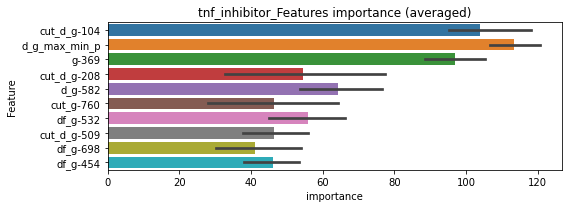

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168955	valid_1's binary_logloss: 0.0330107
[200]	training's binary_logloss: 0.00237398	valid_1's binary_logloss: 0.0158448
[300]	training's binary_logloss: 0.000658157	valid_1's binary_logloss: 0.0132269
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000484116	valid_1's binary_logloss: 0.0129759


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170637	valid_1's binary_logloss: 0.0277924
[200]	training's binary_logloss: 0.00248741	valid_1's binary_logloss: 0.00849563
[300]	training's binary_logloss: 0.000706315	valid_1's binary_logloss: 0.00550874
[400]	training's binary_logloss: 0.000356947	valid_1's binary_logloss: 0.00479308
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000258231	valid_1's binary_logloss: 0.00458155


tnf_inhibitor logloss: 0.00877926167052562


neg labels: 3289 → selected neg labels: 3271


topoisomerase_inhibitor, len(trt): 127, len(othr): 3271, target_rate: 0.0053330 → Adj_target_rate: 0.0051574
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369491	valid_1's binary_logloss: 0.0822014
[200]	training's binary_logloss: 0.00629061	valid_1's binary_logloss: 0.0549906
[300]	training's binary_logloss: 0.00187117	valid_1's binary_logloss: 0.0502883
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00188771	valid_1's binary_logloss: 0.0502681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361463	valid_1's binary_logloss: 0.0825196
[200]	training's binary_logloss: 0.00638279	valid_1's binary_logloss: 0.0602806
[300]	training's binary_logloss: 0.00180313	valid_1's binary_logloss: 0.0545111
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00161326	valid_1's binary_logloss: 0.0540975


1 / 3 AUC score:0.996
y_Threshold: 0.0116435, Threshold: 0.6862686, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 153 → Positive_corect_labels: 643/3772
p_label_rate: 0.0200904 Vs.target_rate: 0.00533
Num_p_label: 80.0, conf_0:0.61764, conf_1:0.75490
Num_p_label: 80.0, Expected: 21.2, Adj_threshold_1: 0.6862686
Num_p_label: 77.0, Expected: 21.2, Adj_threshold_2: 0.6962686
Num_p_label: 74.0, Expected: 21.2, Adj_threshold_3: 0.7062686
Num_p_label: 73.0, Expected: 21.2, Adj_threshold_4: 0.7162686
Num_p_label: 72.0, Expected: 21.2, Adj_threshold_5: 0.7262686
Num_p_label: 71.0, Expected: 21.2, Adj_threshold_6: 0.7362686
Num_p_label: 70.0, Expected: 21.2, Adj_threshold_7: 0.7462686
Num_p_label: 66.0, Expected: 21.2, Adj_threshold_8: 0.7562686
Num_p_label: 62.0, Expected: 21.2, Adj_threshold_9: 0.7662686
Num_p_label: 60.0, Expected: 21.2, Adj_threshold_10: 0.7762686
threshold: 0.7862686, positive_p_label: 60.0/3982, p_label_rate: 0.0150678
positive_y_label: 643.0/3772, y_label_rate: 0.1704666

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276732	valid_1's binary_logloss: 0.0730794
[200]	training's binary_logloss: 0.00380786	valid_1's binary_logloss: 0.0549602
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.003452	valid_1's binary_logloss: 0.0544185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305545	valid_1's binary_logloss: 0.0531319
[200]	training's binary_logloss: 0.00449781	valid_1's binary_logloss: 0.0241914
[300]	training's binary_logloss: 0.00131285	valid_1's binary_logloss: 0.0176741
[400]	training's binary_logloss: 0.000657341	valid_1's binary_logloss: 0.0158367
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000550902	valid_1's binary_logloss: 0.0152223


2 / 3 AUC score:0.998
y_Threshold: 0.0647900, Threshold: 0.7862686, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 627.0/3740
p_label_rate: 0.0361627 Vs.target_rate: 0.00533
Num_p_label: 144.0, conf_0:0.70764, conf_1:0.86490
Num_p_label: 144.0, Expected: 21.2, Adj_threshold_1: 0.7862686
Num_p_label: 141.0, Expected: 21.2, Adj_threshold_2: 0.7962686
Num_p_label: 141.0, Expected: 21.2, Adj_threshold_3: 0.8062686
Num_p_label: 141.0, Expected: 21.2, Adj_threshold_4: 0.8162686
Num_p_label: 139.0, Expected: 21.2, Adj_threshold_5: 0.8262686
Num_p_label: 138.0, Expected: 21.2, Adj_threshold_6: 0.8362686
Num_p_label: 137.0, Expected: 21.2, Adj_threshold_7: 0.8462686
Num_p_label: 137.0, Expected: 21.2, Adj_threshold_8: 0.8562686
Num_p_label: 136.0, Expected: 21.2, Adj_threshold_9: 0.8662686
Num_p_label: 136.0, Expected: 21.2, Adj_threshold_10: 0.8762686
threshold: 0.8862686, positive_p_label: 136.0/3982, p_label_rate: 0.0341537
positive_y_label: 627.0/3740, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265691	valid_1's binary_logloss: 0.0610381
[200]	training's binary_logloss: 0.00357229	valid_1's binary_logloss: 0.0413363
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.00203102	valid_1's binary_logloss: 0.0399765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270829	valid_1's binary_logloss: 0.0514248
[200]	training's binary_logloss: 0.00355684	valid_1's binary_logloss: 0.0265512
[300]	training's binary_logloss: 0.00103666	valid_1's binary_logloss: 0.022762
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00110724	valid_1's binary_logloss: 0.0226831


3 / 3 AUC score:0.998
y_Threshold: 0.0572941, Threshold: 0.8862686, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 613.0/3712
p_label_rate: 0.0366650 Vs.target_rate: 0.00533
Num_p_label: 146.0, conf_0:0.79764, conf_1:0.97490
Num_p_label: 146.0, Expected: 21.2, Adj_threshold_1: 0.8862686
Num_p_label: 146.0, Expected: 21.2, Adj_threshold_2: 0.8962686
Num_p_label: 144.0, Expected: 21.2, Adj_threshold_3: 0.9062686
Num_p_label: 141.0, Expected: 21.2, Adj_threshold_4: 0.9162686
Num_p_label: 138.0, Expected: 21.2, Adj_threshold_5: 0.9262686
Num_p_label: 134.0, Expected: 21.2, Adj_threshold_6: 0.9362686
Num_p_label: 131.0, Expected: 21.2, Adj_threshold_7: 0.9462686
Num_p_label: 128.0, Expected: 21.2, Adj_threshold_8: 0.9562686
Num_p_label: 124.0, Expected: 21.2, Adj_threshold_9: 0.9662686
Num_p_label: 117.0, Expected: 21.2, Adj_threshold_10: 0.9762686
threshold: 0.9862686, positive_p_label: 105.0/3982, p_label_rate: 0.0263687
positive_y_label: 718.0/7694, y_label_ra

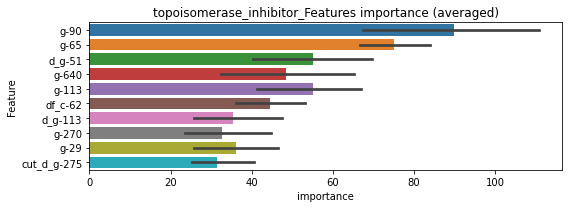

len(train_index) : 3847
len(valid_index) : 3847
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172354	valid_1's binary_logloss: 0.0350449
[200]	training's binary_logloss: 0.00246456	valid_1's binary_logloss: 0.0202501
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000831083	valid_1's binary_logloss: 0.0182094


len(train_index) : 3847
len(valid_index) : 3847
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176865	valid_1's binary_logloss: 0.0349965
[200]	training's binary_logloss: 0.00251967	valid_1's binary_logloss: 0.0188587
[300]	training's binary_logloss: 0.000740144	valid_1's binary_logloss: 0.0165089
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00041197	valid_1's binary_logloss: 0.0154637


topoisomerase_inhibitor logloss: 0.016836537988518755


neg labels: 3289 → selected neg labels: 3286


transient_receptor_potential_channel_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022695	valid_1's binary_logloss: 0.0309359
[200]	training's binary_logloss: 0.00262697	valid_1's binary_logloss: 0.00625746
[300]	training's binary_logloss: 0.000743806	valid_1's binary_logloss: 0.00275464
[400]	training's binary_logloss: 0.000394488	valid_1's binary_logloss: 0.00195116
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000334324	valid_1's binary_logloss: 0.00178214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233398	valid_1's binary_logloss: 0.029299
[200]	training's binary_logloss: 0.0027315	valid_1's binary_logloss: 0.00575069
[300]	training's binary_logloss: 0.000764091	valid_1's binary_logloss: 0.00319981
[400]	training's binary_logloss: 0.000397011	valid_1's binary_logloss: 0.00265158
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000339698	valid_1's binary_logloss: 0.0025536


1 / 3 AUC score:1.000
y_Threshold: 0.0013278, Threshold: 0.0019409, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00175, conf_1:0.00213
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0019409
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_2: 0.0119409
threshold: 0.0119409, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226449	valid_1's binary_logloss: 0.0309368
[200]	training's binary_logloss: 0.00258388	valid_1's binary_logloss: 0.00599748
[300]	training's binary_logloss: 0.000741833	valid_1's binary_logloss: 0.0026005
[400]	training's binary_logloss: 0.000396948	valid_1's binary_logloss: 0.00177352
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000327486	valid_1's binary_logloss: 0.00161062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232391	valid_1's binary_logloss: 0.0290387
[200]	training's binary_logloss: 0.00266328	valid_1's binary_logloss: 0.00572154
[300]	training's binary_logloss: 0.000754173	valid_1's binary_logloss: 0.00309017
[400]	training's binary_logloss: 0.000396166	valid_1's binary_logloss: 0.0026155
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000339941	valid_1's binary_logloss: 0.0025148

2 / 3 AUC score:1.000
y_Threshold: 0.0277225, Threshold: 0.0119409, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0025113 Vs.target_rate: 0.00076
Num_p_label: 10.0, conf_0:0.01075, conf_1:0.01313
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.0119409
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_2: 0.0219409
threshold: 0.0219409, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226449	valid_1's binary_logloss: 0.0309368
[200]	training's binary_logloss: 0.00258388	valid_1's binary_logloss: 0.00599748
[300]	training's binary_logloss: 0.000741833	valid_1's binary_logloss: 0.0026005
[400]	training's binary_logloss: 0.000396948	valid_1's binary_logloss: 0.00177352
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000327486	valid_1's binary_logloss: 0.00161062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232391	valid_1's binary_logloss: 0.0290387
[200]	training's binary_logloss: 0.00266328	valid_1's binary_logloss: 0.00572154
[300]	training's binary_logloss: 0.000754173	valid_1's binary_logloss: 0.00309017
[400]	training's binary_logloss: 0.000396166	valid_1's binary_logloss: 0.0026155
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000339941	valid_1's binary_logloss: 0.0025148

3 / 3 AUC score:1.000
y_Threshold: 0.0277225, Threshold: 0.0219409, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0007534 Vs.target_rate: 0.00076
Num_p_label: 3.0, conf_0:0.01975, conf_1:0.02413
threshold: 0.0219409, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7793, y_label_rate: 0.0846914


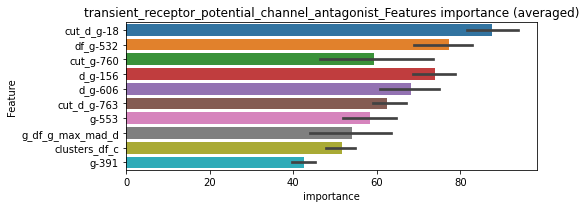

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121684	valid_1's binary_logloss: 0.0181815
[200]	training's binary_logloss: 0.00140342	valid_1's binary_logloss: 0.004967
[300]	training's binary_logloss: 0.000383319	valid_1's binary_logloss: 0.0033264
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.000275341	valid_1's binary_logloss: 0.00317893


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124352	valid_1's binary_logloss: 0.0172116
[200]	training's binary_logloss: 0.0014307	valid_1's binary_logloss: 0.00430371
[300]	training's binary_logloss: 0.00039204	valid_1's binary_logloss: 0.00280204
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000369153	valid_1's binary_logloss: 0.00275494


transient_receptor_potential_channel_antagonist logloss: 0.0029669597639985553


neg labels: 3289 → selected neg labels: 3288


tropomyosin_receptor_kinase_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158262	valid_1's binary_logloss: 0.0170724
[200]	training's binary_logloss: 0.00131335	valid_1's binary_logloss: 0.00168749
[300]	training's binary_logloss: 0.000345616	valid_1's binary_logloss: 0.000541154
[400]	training's binary_logloss: 0.0002091	valid_1's binary_logloss: 0.000366974
[500]	training's binary_logloss: 0.000187911	valid_1's binary_logloss: 0.000341802
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000187102	valid_1's binary_logloss: 0.000340959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159111	valid_1's binary_logloss: 0.0175284
[200]	training's binary_logloss: 0.0013224	valid_1's binary_logloss: 0.00174001
[300]	training's binary_logloss: 0.000349863	valid_1's binary_logloss: 0.000540944
[400]	training's binary_logloss: 0.000211264	valid_1's binary_logloss: 0.000350447
Early stopping, best iterati

1 / 3 AUC score:1.000
y_Threshold: 0.0005284, Threshold: 0.0011041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00099, conf_1:0.00121
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0011041
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.0111041
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_3: 0.0211041
threshold: 0.0211041, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160554	valid_1's binary_logloss: 0.0170583
[200]	training's binary_logloss: 0.0013067	valid_1's binary_logloss: 0.00163457
[300]	training's binary_logloss: 0.000341238	valid_1's binary_logloss: 0.000482893
[400]	training's binary_logloss: 0.000208336	valid_1's binary_logloss: 0.000333014
[500]	training's binary_logloss: 0.000186957	valid_1's binary_logloss: 0.00030921
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000187063	valid_1's binary_logloss: 0.000309199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163821	valid_1's binary_logloss: 0.0183068
[200]	training's binary_logloss: 0.00133847	valid_1's binary_logloss: 0.00203978
[300]	training's binary_logloss: 0.000346708	valid_1's binary_logloss: 0.000635272
[400]	training's binary_logloss: 0.000209983	valid_1's binary_logloss: 0.000425874
[500]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1499920, Threshold: 0.0211041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0025113 Vs.target_rate: 0.00025
Num_p_label: 10.0, conf_0:0.01899, conf_1:0.02321
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_1: 0.0211041
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0311041
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0411041
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.0511041
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.0611041
threshold: 0.0611041, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160554	valid_1's binary_logloss: 0.0170583
[200]	training's binary_logloss: 0.0013067	valid_1's binary_logloss: 0.00163457
[300]	training's binary_logloss: 0.000341238	valid_1's binary_logloss: 0.000482893
[400]	training's binary_logloss: 0.000208336	valid_1's binary_logloss: 0.000333014
[500]	training's binary_logloss: 0.000186957	valid_1's binary_logloss: 0.00030921
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000187063	valid_1's binary_logloss: 0.000309199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163821	valid_1's binary_logloss: 0.0183068
[200]	training's binary_logloss: 0.00133847	valid_1's binary_logloss: 0.00203978
[300]	training's binary_logloss: 0.000346708	valid_1's binary_logloss: 0.000635272
[400]	training's binary_logloss: 0.000209983	valid_1's binary_logloss: 0.000425874
[500]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1499920, Threshold: 0.0611041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025
Num_p_label: 2.0, conf_0:0.05499, conf_1:0.06721
threshold: 0.0611041, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


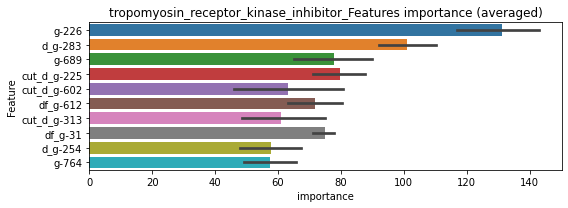

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0086454	valid_1's binary_logloss: 0.00985996
[200]	training's binary_logloss: 0.000700001	valid_1's binary_logloss: 0.00201174
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00021308	valid_1's binary_logloss: 0.00164439


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00861406	valid_1's binary_logloss: 0.0106734
[200]	training's binary_logloss: 0.000700568	valid_1's binary_logloss: 0.00285635
[300]	training's binary_logloss: 0.000179042	valid_1's binary_logloss: 0.00238807
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.000182168	valid_1's binary_logloss: 0.00238292


tropomyosin_receptor_kinase_inhibitor logloss: 0.002013608767848852


neg labels: 3289 → selected neg labels: 3285


trpv_agonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244279	valid_1's binary_logloss: 0.0388819
[200]	training's binary_logloss: 0.0029608	valid_1's binary_logloss: 0.0095309
[300]	training's binary_logloss: 0.000846716	valid_1's binary_logloss: 0.00538106
[400]	training's binary_logloss: 0.000440573	valid_1's binary_logloss: 0.00416423
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000360325	valid_1's binary_logloss: 0.0038516
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256228	valid_1's binary_logloss: 0.0376822
[200]	training's binary_logloss: 0.00308958	valid_1's binary_logloss: 0.0072993
[300]	training's binary_logloss: 0.000874253	valid_1's binary_logloss: 0.00303124
[400]	training's binary_logloss: 0.000455556	valid_1's binary_logloss: 0.0019259
[500]	training's binary_logloss: 0.000346505	valid_1's binary_logloss: 0.00168615
Early stopping, best iteration is:
[

1 / 3 AUC score:1.000
y_Threshold: 0.0020815, Threshold: 0.0051686, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00465, conf_1:0.00569
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0051686
Num_p_label: 31.0, Expected: 4.2, Adj_threshold_2: 0.0151686
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_3: 0.0251686
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_4: 0.0351686
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_5: 0.0451686
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_6: 0.0551686
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_7: 0.0651686
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_8: 0.0751686
threshold: 0.0751686, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241793	valid_1's binary_logloss: 0.0383672
[200]	training's binary_logloss: 0.00282714	valid_1's binary_logloss: 0.00897882
[300]	training's binary_logloss: 0.000794556	valid_1's binary_logloss: 0.00449632
[400]	training's binary_logloss: 0.000423242	valid_1's binary_logloss: 0.00347278
[500]	training's binary_logloss: 0.000329238	valid_1's binary_logloss: 0.00316286
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000330823	valid_1's binary_logloss: 0.0031608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247964	valid_1's binary_logloss: 0.0319609
[200]	training's binary_logloss: 0.0029648	valid_1's binary_logloss: 0.00538677
[300]	training's binary_logloss: 0.000834429	valid_1's binary_logloss: 0.00191076
[400]	training's binary_logloss: 0.000435164	valid_1's binary_logloss: 0.00110508
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1086299, Threshold: 0.0751686, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0082873 Vs.target_rate: 0.00105
Num_p_label: 33.0, conf_0:0.06765, conf_1:0.08269
Num_p_label: 33.0, Expected: 4.2, Adj_threshold_1: 0.0751686
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_2: 0.0851686
Num_p_label: 30.0, Expected: 4.2, Adj_threshold_3: 0.0951686
Num_p_label: 29.0, Expected: 4.2, Adj_threshold_4: 0.1051686
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_5: 0.1151686
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_6: 0.1251686
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_7: 0.1351686
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_8: 0.1451686
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_9: 0.1551686
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_10: 0.1651686
threshold: 0.1751686, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241793	valid_1's binary_logloss: 0.0383672
[200]	training's binary_logloss: 0.00282714	valid_1's binary_logloss: 0.00897882
[300]	training's binary_logloss: 0.000794556	valid_1's binary_logloss: 0.00449632
[400]	training's binary_logloss: 0.000423242	valid_1's binary_logloss: 0.00347278
[500]	training's binary_logloss: 0.000329238	valid_1's binary_logloss: 0.00316286
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000330823	valid_1's binary_logloss: 0.0031608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247964	valid_1's binary_logloss: 0.0319609
[200]	training's binary_logloss: 0.0029648	valid_1's binary_logloss: 0.00538677
[300]	training's binary_logloss: 0.000834429	valid_1's binary_logloss: 0.00191076
[400]	training's binary_logloss: 0.000435164	valid_1's binary_logloss: 0.00110508
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1086299, Threshold: 0.1751686, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0047715 Vs.target_rate: 0.00105
Num_p_label: 19.0, conf_0:0.15765, conf_1:0.19269
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_1: 0.1751686
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_2: 0.1851686
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_3: 0.1951686
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_4: 0.2051686
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_5: 0.2151686
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_6: 0.2251686
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_7: 0.2351686
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_8: 0.2451686
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_9: 0.2551686
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_10: 0.2651686
threshold: 0.2751686, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 672.0/7792, y_label_rate: 0.0862423


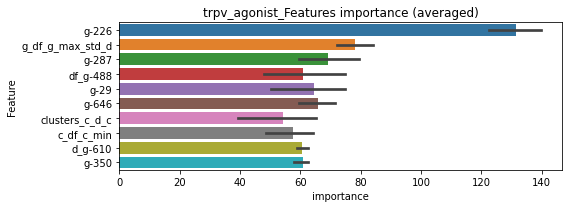

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127176	valid_1's binary_logloss: 0.0224919
[200]	training's binary_logloss: 0.00151818	valid_1's binary_logloss: 0.0082421
[300]	training's binary_logloss: 0.000434252	valid_1's binary_logloss: 0.00632411
[400]	training's binary_logloss: 0.000229919	valid_1's binary_logloss: 0.00585072
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000213661	valid_1's binary_logloss: 0.0058009


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135822	valid_1's binary_logloss: 0.0204182
[200]	training's binary_logloss: 0.00165701	valid_1's binary_logloss: 0.00603791
[300]	training's binary_logloss: 0.0004609	valid_1's binary_logloss: 0.00429307
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000297304	valid_1's binary_logloss: 0.00397055


trpv_agonist logloss: 0.004885724087578626


neg labels: 3289 → selected neg labels: 3281


trpv_antagonist, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373572	valid_1's binary_logloss: 0.0789279
[200]	training's binary_logloss: 0.00612746	valid_1's binary_logloss: 0.0416315
[300]	training's binary_logloss: 0.001767	valid_1's binary_logloss: 0.0355002
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000949406	valid_1's binary_logloss: 0.0335508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411797	valid_1's binary_logloss: 0.061767
[200]	training's binary_logloss: 0.00725097	valid_1's binary_logloss: 0.0215319
[300]	training's binary_logloss: 0.00207465	valid_1's binary_logloss: 0.0131862
[400]	training's binary_logloss: 0.000987763	valid_1's binary_logloss: 0.0108247
[500]	training's binary_logloss: 0.000628003	valid_1's binary_logloss: 0.00984776
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000515587	valid_1's binary_logloss: 0.00955603


1 / 3 AUC score:0.999
y_Threshold: 0.0036926, Threshold: 0.0055671, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 654/3801
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.00501, conf_1:0.00612
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0055671
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_2: 0.0155671
threshold: 0.0155671, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385094	valid_1's binary_logloss: 0.0733962
[200]	training's binary_logloss: 0.00640702	valid_1's binary_logloss: 0.0319793
[300]	training's binary_logloss: 0.00183581	valid_1's binary_logloss: 0.0243515
[400]	training's binary_logloss: 0.000904377	valid_1's binary_logloss: 0.0220764
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000647151	valid_1's binary_logloss: 0.0209162
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391819	valid_1's binary_logloss: 0.0665958
[200]	training's binary_logloss: 0.00654777	valid_1's binary_logloss: 0.0287788
[300]	training's binary_logloss: 0.00189179	valid_1's binary_logloss: 0.0211092
[400]	training's binary_logloss: 0.000933757	valid_1's binary_logloss: 0.0189307
[500]	training's binary_logloss: 0.000599864	valid_1's binary_logloss: 0.01782
Early stopping, best iteration is:
[502]	tr

2 / 3 AUC score:1.000
y_Threshold: 0.0157103, Threshold: 0.0155671, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 651.0/3795
p_label_rate: 0.0037670 Vs.target_rate: 0.00202
Num_p_label: 15.0, conf_0:0.01401, conf_1:0.01712
threshold: 0.0155671, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 651.0/3795, y_label_rate: 0.1715415
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367573	valid_1's binary_logloss: 0.0692761
[200]	training's binary_logloss: 0.00586568	valid_1's binary_logloss: 0.0312664
[300]	training's binary_logloss: 0.00173442	valid_1's binary_logloss: 0.0239057
[400]	training's binary_logloss: 0.000859523	valid_1's binary_logloss: 0.0218783
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000841353	valid_1's binary_logloss: 0.0218381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377254	valid_1's binary_logloss: 0.0653528
[200]	training's binary_logloss: 0.00631322	valid_1's binary_logloss: 0.024667
[300]	training's binary_logloss: 0.00184815	valid_1's binary_logloss: 0.015822
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00102319	valid_1's binary_logloss: 0.0144088


3 / 3 AUC score:1.000
y_Threshold: 0.0155243, Threshold: 0.0155671, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 650.0/3793
p_label_rate: 0.0055249 Vs.target_rate: 0.00202
Num_p_label: 22.0, conf_0:0.01401, conf_1:0.01712
threshold: 0.0155671, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 672.0/7775, y_label_rate: 0.0864309


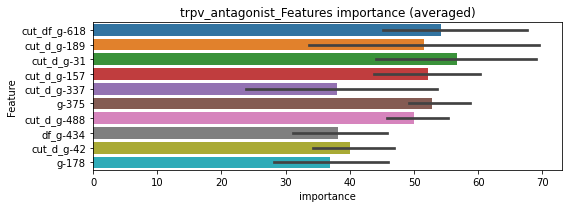

len(train_index) : 3887
len(valid_index) : 3888
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214798	valid_1's binary_logloss: 0.0470394
[200]	training's binary_logloss: 0.00352846	valid_1's binary_logloss: 0.0294606
[300]	training's binary_logloss: 0.00100226	valid_1's binary_logloss: 0.0269629
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00100226	valid_1's binary_logloss: 0.0269629


len(train_index) : 3888
len(valid_index) : 3887
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235254	valid_1's binary_logloss: 0.0420663
[200]	training's binary_logloss: 0.00402454	valid_1's binary_logloss: 0.02212
[300]	training's binary_logloss: 0.00114027	valid_1's binary_logloss: 0.0189492
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000595359	valid_1's binary_logloss: 0.0182577


trpv_antagonist logloss: 0.02261085757471394


neg labels: 3289 → selected neg labels: 3267


tubulin_inhibitor, len(trt): 316, len(othr): 3267, target_rate: 0.0132695 → Adj_target_rate: 0.0111926
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406838	valid_1's binary_logloss: 0.123826
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00929283	valid_1's binary_logloss: 0.109656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423976	valid_1's binary_logloss: 0.101273
[200]	training's binary_logloss: 0.00790357	valid_1's binary_logloss: 0.0777981
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0055995	valid_1's binary_logloss: 0.0764093


1 / 3 AUC score:0.986
y_Threshold: 0.0264353, Threshold: 0.1439850, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 185 → Positive_corect_labels: 626/3735
p_label_rate: 0.0200904 Vs.target_rate: 0.01327
Num_p_label: 80.0, conf_0:0.12959, conf_1:0.15838
threshold: 0.1439850, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 626.0/3735, y_label_rate: 0.1676037
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032094	valid_1's binary_logloss: 0.0746625
[200]	training's binary_logloss: 0.00484265	valid_1's binary_logloss: 0.0511797
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00445591	valid_1's binary_logloss: 0.0511115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300885	valid_1's binary_logloss: 0.0916377
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0094942	valid_1's binary_logloss: 0.0815125


2 / 3 AUC score:0.990
y_Threshold: 0.0525452, Threshold: 0.1439850, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 64 → Positive_corect_labels: 594.0/3671
p_label_rate: 0.0334003 Vs.target_rate: 0.01327
Num_p_label: 133.0, conf_0:0.12959, conf_1:0.15838
threshold: 0.1439850, positive_p_label: 133.0/3982, p_label_rate: 0.0334003
positive_y_label: 594.0/3671, y_label_rate: 0.1618088
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257232	valid_1's binary_logloss: 0.0484478
[200]	training's binary_logloss: 0.00360912	valid_1's binary_logloss: 0.0271873
[300]	training's binary_logloss: 0.00102925	valid_1's binary_logloss: 0.0239795
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00082505	valid_1's binary_logloss: 0.0236653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263728	valid_1's binary_logloss: 0.055331
[200]	training's binary_logloss: 0.00358926	valid_1's binary_logloss: 0.0325957
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00129365	valid_1's binary_logloss: 0.0281175


3 / 3 AUC score:0.998
y_Threshold: 0.0365953, Threshold: 0.1439850, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 587.0/3657
p_label_rate: 0.0308890 Vs.target_rate: 0.01327
Num_p_label: 123.0, conf_0:0.12959, conf_1:0.15838
threshold: 0.1439850, positive_p_label: 123.0/3982, p_label_rate: 0.0308890
positive_y_label: 710.0/7639, y_label_rate: 0.0929441


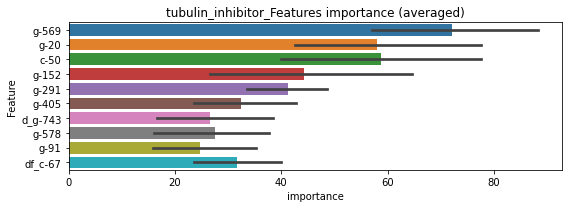

len(train_index) : 3819
len(valid_index) : 3820
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154159	valid_1's binary_logloss: 0.0445498
[200]	training's binary_logloss: 0.00209028	valid_1's binary_logloss: 0.0307931
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.000937246	valid_1's binary_logloss: 0.0288352


len(train_index) : 3820
len(valid_index) : 3819
================================= fold 2/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152785	valid_1's binary_logloss: 0.0368225
[200]	training's binary_logloss: 0.00211824	valid_1's binary_logloss: 0.0241356
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00143296	valid_1's binary_logloss: 0.0237209


tubulin_inhibitor logloss: 0.02627838955286046


neg labels: 3289 → selected neg labels: 3276


tyrosine_kinase_inhibitor, len(trt): 73, len(othr): 3276, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445499	valid_1's binary_logloss: 0.0895686
[200]	training's binary_logloss: 0.0087456	valid_1's binary_logloss: 0.0452359
[300]	training's binary_logloss: 0.0026889	valid_1's binary_logloss: 0.0340313
[400]	training's binary_logloss: 0.00128897	valid_1's binary_logloss: 0.030569
[500]	training's binary_logloss: 0.000809129	valid_1's binary_logloss: 0.0288898
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000712536	valid_1's binary_logloss: 0.0283711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444095	valid_1's binary_logloss: 0.0843454
[200]	training's binary_logloss: 0.00878021	valid_1's binary_logloss: 0.041725
[300]	training's binary_logloss: 0.00271362	valid_1's binary_logloss: 0.0307592
[400]	training's binary_logloss: 0.00130643	valid_1's binary_logloss: 0.027246
Early stopping, best iteration is:
[472]	trainin

1 / 3 AUC score:0.999
y_Threshold: 0.0072144, Threshold: 0.0106675, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.00960, conf_1:0.01173
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0106675
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_2: 0.0206675
threshold: 0.0206675, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 653.0/3795, y_label_rate: 0.1720685
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427155	valid_1's binary_logloss: 0.108497
[200]	training's binary_logloss: 0.0078774	valid_1's binary_logloss: 0.0688666
[300]	training's binary_logloss: 0.00240427	valid_1's binary_logloss: 0.0619685
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00202086	valid_1's binary_logloss: 0.0610375
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463017	valid_1's binary_logloss: 0.0968823
[200]	training's binary_logloss: 0.00891729	valid_1's binary_logloss: 0.0475199
[300]	training's binary_logloss: 0.00274067	valid_1's binary_logloss: 0.0347009
[400]	training's binary_logloss: 0.00130526	valid_1's binary_logloss: 0.0302961
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000964607	valid_1's binary_logloss: 0.0288577


2 / 3 AUC score:0.999
y_Threshold: 0.0225533, Threshold: 0.0206675, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 640.0/3769
p_label_rate: 0.0208438 Vs.target_rate: 0.00307
Num_p_label: 83.0, conf_0:0.01860, conf_1:0.02273
Num_p_label: 83.0, Expected: 12.2, Adj_threshold_1: 0.0206675
Num_p_label: 44.0, Expected: 12.2, Adj_threshold_2: 0.0306675
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_3: 0.0406675
Num_p_label: 16.0, Expected: 12.2, Adj_threshold_4: 0.0506675
threshold: 0.0506675, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 640.0/3769, y_label_rate: 0.1698063
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414164	valid_1's binary_logloss: 0.0901576
[200]	training's binary_logloss: 0.00753472	valid_1's binary_logloss: 0.0494363
[300]	training's binary_logloss: 0.00231078	valid_1's binary_logloss: 0.0408712
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.0013086	valid_1's binary_logloss: 0.0385408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425357	valid_1's binary_logloss: 0.0887005
[200]	training's binary_logloss: 0.00794043	valid_1's binary_logloss: 0.046202
[300]	training's binary_logloss: 0.00242861	valid_1's binary_logloss: 0.0366526
[400]	training's binary_logloss: 0.00117018	valid_1's binary_logloss: 0.0329138
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000817605	valid_1's binary_logloss: 0.0314775


3 / 3 AUC score:1.000
y_Threshold: 0.0264381, Threshold: 0.0506675, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 635.0/3759
p_label_rate: 0.0045203 Vs.target_rate: 0.00307
Num_p_label: 18.0, conf_0:0.04560, conf_1:0.05573
threshold: 0.0506675, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 653.0/7741, y_label_rate: 0.0843560


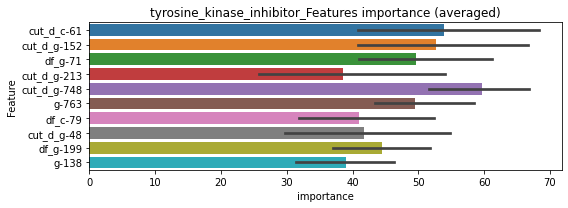

len(train_index) : 3870
len(valid_index) : 3871
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214954	valid_1's binary_logloss: 0.0580552
[200]	training's binary_logloss: 0.00393738	valid_1's binary_logloss: 0.0369061
[300]	training's binary_logloss: 0.00125239	valid_1's binary_logloss: 0.032022
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00102839	valid_1's binary_logloss: 0.031584


len(train_index) : 3871
len(valid_index) : 3870
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240806	valid_1's binary_logloss: 0.0509328
[200]	training's binary_logloss: 0.0046885	valid_1's binary_logloss: 0.0262342
[300]	training's binary_logloss: 0.00141316	valid_1's binary_logloss: 0.0211284
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00083347	valid_1's binary_logloss: 0.0199647


tyrosine_kinase_inhibitor logloss: 0.025775126900947475


neg labels: 3289 → selected neg labels: 3287


ubiquitin_specific_protease_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179272	valid_1's binary_logloss: 0.0209731
[200]	training's binary_logloss: 0.00173139	valid_1's binary_logloss: 0.00306767
[300]	training's binary_logloss: 0.00047917	valid_1's binary_logloss: 0.00121352
[400]	training's binary_logloss: 0.000278128	valid_1's binary_logloss: 0.000845408
[500]	training's binary_logloss: 0.000244413	valid_1's binary_logloss: 0.000800099
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00024405	valid_1's binary_logloss: 0.000800066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177877	valid_1's binary_logloss: 0.0210551
[200]	training's binary_logloss: 0.00169068	valid_1's binary_logloss: 0.00360317
[300]	training's binary_logloss: 0.000473137	valid_1's binary_logloss: 0.00203585
[400]	training's binary_logloss: 0.000275426	valid_1's binary_logloss: 0.00162945
[500]	training's binary_loglos

1 / 3 AUC score:1.000
y_Threshold: 0.0010202, Threshold: 0.0014702, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00132, conf_1:0.00162
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0014702
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.0114702
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.0214702
threshold: 0.0214702, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178513	valid_1's binary_logloss: 0.0209256
[200]	training's binary_logloss: 0.00166635	valid_1's binary_logloss: 0.00375473
[300]	training's binary_logloss: 0.0004594	valid_1's binary_logloss: 0.00217857
[400]	training's binary_logloss: 0.00026844	valid_1's binary_logloss: 0.00189887
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000247695	valid_1's binary_logloss: 0.00186978
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182251	valid_1's binary_logloss: 0.0209811
[200]	training's binary_logloss: 0.00166044	valid_1's binary_logloss: 0.00261672
[300]	training's binary_logloss: 0.000453612	valid_1's binary_logloss: 0.00102059
[400]	training's binary_logloss: 0.00026601	valid_1's binary_logloss: 0.000680643
[500]	training's binary_logloss: 0.000234302	valid_1's binary_logloss: 0.000626221
Early stopping, best iteration is

2 / 3 AUC score:1.000
y_Threshold: 0.0753436, Threshold: 0.0214702, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0090407 Vs.target_rate: 0.00050
Num_p_label: 36.0, conf_0:0.01932, conf_1:0.02362
Num_p_label: 36.0, Expected: 2.0, Adj_threshold_1: 0.0214702
Num_p_label: 31.0, Expected: 2.0, Adj_threshold_2: 0.0314702
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_3: 0.0414702
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_4: 0.0514702
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_5: 0.0614702
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_6: 0.0714702
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_7: 0.0814702
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_8: 0.0914702
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_9: 0.1014702
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_10: 0.1114702
threshold: 0.1214702, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 656.0/3810, y_label_rate: 0.1721785
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177535	valid_1's binary_logloss: 0.0231594
[200]	training's binary_logloss: 0.00164738	valid_1's binary_logloss: 0.0052729
[300]	training's binary_logloss: 0.000457351	valid_1's binary_logloss: 0.00325226
[400]	training's binary_logloss: 0.000266403	valid_1's binary_logloss: 0.00287427
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000245303	valid_1's binary_logloss: 0.00285064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180773	valid_1's binary_logloss: 0.0192615
[200]	training's binary_logloss: 0.00167367	valid_1's binary_logloss: 0.00193744
[300]	training's binary_logloss: 0.000458499	valid_1's binary_logloss: 0.000575539
[400]	training's binary_logloss: 0.000270559	valid_1's binary_logloss: 0.000347484
[500]	training's binary_logloss: 0.000237679	valid_1's binary_logloss: 0.000305815
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.0329578, Threshold: 0.1214702, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0037670 Vs.target_rate: 0.00050
Num_p_label: 15.0, conf_0:0.10932, conf_1:0.13362
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_1: 0.1214702
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_2: 0.1314702
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_3: 0.1414702
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_4: 0.1514702
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_5: 0.1614702
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_6: 0.1714702
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_7: 0.1814702
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_8: 0.1914702
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_9: 0.2014702
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_10: 0.2114702
threshold: 0.2214702, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 668.0/7792, y_label_rate: 0.0857290


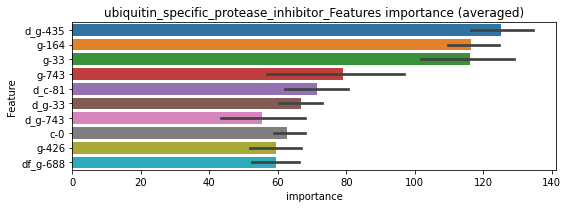

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00949825	valid_1's binary_logloss: 0.0138946
[200]	training's binary_logloss: 0.00088941	valid_1's binary_logloss: 0.00548967
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.000383251	valid_1's binary_logloss: 0.00494743


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00985997	valid_1's binary_logloss: 0.0136034
[200]	training's binary_logloss: 0.000968901	valid_1's binary_logloss: 0.00393657
[300]	training's binary_logloss: 0.000271415	valid_1's binary_logloss: 0.00302411
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000205932	valid_1's binary_logloss: 0.00287764


ubiquitin_specific_protease_inhibitor logloss: 0.003912539193978011


neg labels: 3289 → selected neg labels: 3258


vegfr_inhibitor, len(trt): 170, len(othr): 3258, target_rate: 0.0071387 → Adj_target_rate: 0.0066081
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522151	valid_1's binary_logloss: 0.146053
[200]	training's binary_logloss: 0.0114255	valid_1's binary_logloss: 0.105584
[300]	training's binary_logloss: 0.00368167	valid_1's binary_logloss: 0.0973406
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00320565	valid_1's binary_logloss: 0.0964411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0558123	valid_1's binary_logloss: 0.131157
[200]	training's binary_logloss: 0.0130008	valid_1's binary_logloss: 0.085347
[300]	training's binary_logloss: 0.00419292	valid_1's binary_logloss: 0.0730436
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00247187	valid_1's binary_logloss: 0.0705364


1 / 3 AUC score:0.990
y_Threshold: 0.0333400, Threshold: 0.1395211, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 173 → Positive_corect_labels: 630/3736
p_label_rate: 0.0200904 Vs.target_rate: 0.00714
Num_p_label: 80.0, conf_0:0.12557, conf_1:0.15347
threshold: 0.1395211, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 630.0/3736, y_label_rate: 0.1686296
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450059	valid_1's binary_logloss: 0.124729
[200]	training's binary_logloss: 0.00901202	valid_1's binary_logloss: 0.0825553
[300]	training's binary_logloss: 0.00281171	valid_1's binary_logloss: 0.0684618
[400]	training's binary_logloss: 0.00136202	valid_1's binary_logloss: 0.0634845
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00104713	valid_1's binary_logloss: 0.0622805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475298	valid_1's binary_logloss: 0.109897
[200]	training's binary_logloss: 0.00992269	valid_1's binary_logloss: 0.0707231
[300]	training's binary_logloss: 0.00308221	valid_1's binary_logloss: 0.0642187
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00226733	valid_1's binary_logloss: 0.0629425


2 / 3 AUC score:0.997
y_Threshold: 0.0784472, Threshold: 0.1395211, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → Positive_corect_labels: 603.0/3682
p_label_rate: 0.0429432 Vs.target_rate: 0.00714
Num_p_label: 171.0, conf_0:0.12557, conf_1:0.15347
Num_p_label: 171.0, Expected: 28.4, Adj_threshold_1: 0.1395211
Num_p_label: 168.0, Expected: 28.4, Adj_threshold_2: 0.1495211
Num_p_label: 163.0, Expected: 28.4, Adj_threshold_3: 0.1595211
Num_p_label: 162.0, Expected: 28.4, Adj_threshold_4: 0.1695211
Num_p_label: 160.0, Expected: 28.4, Adj_threshold_5: 0.1795211
Num_p_label: 158.0, Expected: 28.4, Adj_threshold_6: 0.1895211
Num_p_label: 155.0, Expected: 28.4, Adj_threshold_7: 0.1995211
Num_p_label: 151.0, Expected: 28.4, Adj_threshold_8: 0.2095211
Num_p_label: 149.0, Expected: 28.4, Adj_threshold_9: 0.2195211
Num_p_label: 145.0, Expected: 28.4, Adj_threshold_10: 0.2295211
threshold: 0.2395211, positive_p_label: 142.0/3982, p_label_rate: 0.0356605
positive_y_label: 603.0/3682, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432635	valid_1's binary_logloss: 0.0999203
[200]	training's binary_logloss: 0.00837244	valid_1's binary_logloss: 0.0577142
[300]	training's binary_logloss: 0.00255168	valid_1's binary_logloss: 0.0495269
[400]	training's binary_logloss: 0.00124826	valid_1's binary_logloss: 0.0462697
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00127735	valid_1's binary_logloss: 0.0462377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412191	valid_1's binary_logloss: 0.105754
[200]	training's binary_logloss: 0.00788158	valid_1's binary_logloss: 0.0648947
[300]	training's binary_logloss: 0.00243475	valid_1's binary_logloss: 0.0550569
[400]	training's binary_logloss: 0.00120492	valid_1's binary_logloss: 0.0509338
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.0012394	valid_1's binary_logloss: 0.0506976


3 / 3 AUC score:0.999
y_Threshold: 0.0800564, Threshold: 0.2395211, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 583.0/3642
p_label_rate: 0.0416876 Vs.target_rate: 0.00714
Num_p_label: 166.0, conf_0:0.21557, conf_1:0.26347
Num_p_label: 166.0, Expected: 28.4, Adj_threshold_1: 0.2395211
Num_p_label: 166.0, Expected: 28.4, Adj_threshold_2: 0.2495211
Num_p_label: 165.0, Expected: 28.4, Adj_threshold_3: 0.2595211
Num_p_label: 164.0, Expected: 28.4, Adj_threshold_4: 0.2695211
Num_p_label: 162.0, Expected: 28.4, Adj_threshold_5: 0.2795211
Num_p_label: 159.0, Expected: 28.4, Adj_threshold_6: 0.2895211
Num_p_label: 157.0, Expected: 28.4, Adj_threshold_7: 0.2995211
Num_p_label: 155.0, Expected: 28.4, Adj_threshold_8: 0.3095211
Num_p_label: 155.0, Expected: 28.4, Adj_threshold_9: 0.3195211
Num_p_label: 153.0, Expected: 28.4, Adj_threshold_10: 0.3295211
threshold: 0.3395211, positive_p_label: 151.0/3982, p_label_rate: 0.0379206
positive_y_label: 734.0/7624, y_label_ra

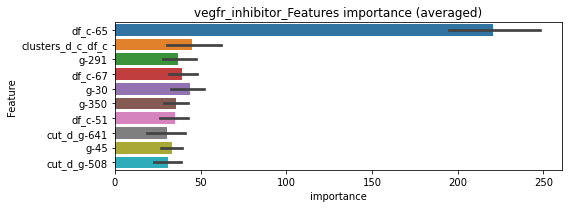

len(train_index) : 3812
len(valid_index) : 3812
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028527	valid_1's binary_logloss: 0.0718703
[200]	training's binary_logloss: 0.00567009	valid_1's binary_logloss: 0.0458159
[300]	training's binary_logloss: 0.00177772	valid_1's binary_logloss: 0.0386078
[400]	training's binary_logloss: 0.00078746	valid_1's binary_logloss: 0.0343568
[500]	training's binary_logloss: 0.000495873	valid_1's binary_logloss: 0.0323216
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000435139	valid_1's binary_logloss: 0.0320439


len(train_index) : 3812
len(valid_index) : 3812
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028078	valid_1's binary_logloss: 0.0782257
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00704355	valid_1's binary_logloss: 0.0570291


vegfr_inhibitor logloss: 0.04453649087246687


neg labels: 3289 → selected neg labels: 3285


vitamin_b, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269453	valid_1's binary_logloss: 0.0442792
[200]	training's binary_logloss: 0.0034268	valid_1's binary_logloss: 0.0163059
[300]	training's binary_logloss: 0.000993577	valid_1's binary_logloss: 0.0122949
[400]	training's binary_logloss: 0.000512837	valid_1's binary_logloss: 0.0108386
[500]	training's binary_logloss: 0.000376512	valid_1's binary_logloss: 0.010499
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000370485	valid_1's binary_logloss: 0.0104749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283252	valid_1's binary_logloss: 0.039672
[200]	training's binary_logloss: 0.00387835	valid_1's binary_logloss: 0.0118244
[300]	training's binary_logloss: 0.00108953	valid_1's binary_logloss: 0.00716737
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000579937	valid_1's binary_logloss: 0.00638922


1 / 3 AUC score:1.000
y_Threshold: 0.0022618, Threshold: 0.0036950, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00109
Num_p_label: 80.0, conf_0:0.00333, conf_1:0.00406
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0036950
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_2: 0.0136950
threshold: 0.0136950, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268521	valid_1's binary_logloss: 0.0444104
[200]	training's binary_logloss: 0.00344687	valid_1's binary_logloss: 0.01697
[300]	training's binary_logloss: 0.000983537	valid_1's binary_logloss: 0.0128691
[400]	training's binary_logloss: 0.000508681	valid_1's binary_logloss: 0.0114157
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000409843	valid_1's binary_logloss: 0.0111725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285763	valid_1's binary_logloss: 0.0405527
[200]	training's binary_logloss: 0.00378686	valid_1's binary_logloss: 0.0120402
[300]	training's binary_logloss: 0.00106633	valid_1's binary_logloss: 0.00722445
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00079392	valid_1's binary_logloss: 0.00667433


2 / 3 AUC score:1.000
y_Threshold: 0.0180734, Threshold: 0.0136950, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0090407 Vs.target_rate: 0.00109
Num_p_label: 36.0, conf_0:0.01233, conf_1:0.01506
Num_p_label: 36.0, Expected: 4.3, Adj_threshold_1: 0.0136950
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_2: 0.0236950
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_3: 0.0336950
threshold: 0.0336950, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276399	valid_1's binary_logloss: 0.0391076
[200]	training's binary_logloss: 0.00355919	valid_1's binary_logloss: 0.010752
[300]	training's binary_logloss: 0.00100335	valid_1's binary_logloss: 0.00670604
[400]	training's binary_logloss: 0.000521642	valid_1's binary_logloss: 0.00567739
[500]	training's binary_logloss: 0.000375396	valid_1's binary_logloss: 0.00524127
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000379973	valid_1's binary_logloss: 0.00523798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275189	valid_1's binary_logloss: 0.041503
[200]	training's binary_logloss: 0.00364734	valid_1's binary_logloss: 0.0109314
[300]	training's binary_logloss: 0.00104238	valid_1's binary_logloss: 0.00614848
[400]	training's binary_logloss: 0.00053072	valid_1's binary_logloss: 0.00473427
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0168749, Threshold: 0.0336950, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0007534 Vs.target_rate: 0.00109
Num_p_label: 3.0, conf_0:0.03033, conf_1:0.03706
threshold: 0.0336950, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 659.0/7790, y_label_rate: 0.0845956


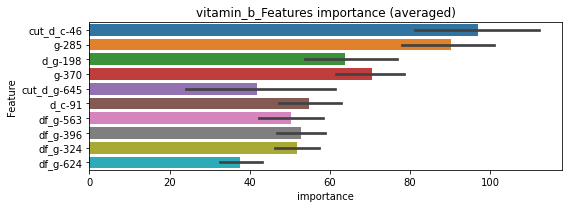

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141752	valid_1's binary_logloss: 0.0231799
[200]	training's binary_logloss: 0.00183103	valid_1's binary_logloss: 0.00791562
[300]	training's binary_logloss: 0.00051604	valid_1's binary_logloss: 0.00566712
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000282056	valid_1's binary_logloss: 0.00523129


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014238	valid_1's binary_logloss: 0.0298333
[200]	training's binary_logloss: 0.00188468	valid_1's binary_logloss: 0.0130694
[300]	training's binary_logloss: 0.000529184	valid_1's binary_logloss: 0.00957736
[400]	training's binary_logloss: 0.000262398	valid_1's binary_logloss: 0.00865921
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000219717	valid_1's binary_logloss: 0.00844825


vitamin_b logloss: 0.006839771057855452


neg labels: 3289 → selected neg labels: 3281


vitamin_d_receptor_agonist, len(trt): 39, len(othr): 3281, target_rate: 0.0016377 → Adj_target_rate: 0.0018906
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272308	valid_1's binary_logloss: 0.0406956
[200]	training's binary_logloss: 0.00353197	valid_1's binary_logloss: 0.0090992
[300]	training's binary_logloss: 0.000997868	valid_1's binary_logloss: 0.00419942
[400]	training's binary_logloss: 0.000503453	valid_1's binary_logloss: 0.00293431
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000387604	valid_1's binary_logloss: 0.00264149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269748	valid_1's binary_logloss: 0.041883
[200]	training's binary_logloss: 0.00354987	valid_1's binary_logloss: 0.0101842
[300]	training's binary_logloss: 0.00101215	valid_1's binary_logloss: 0.00522304
[400]	training's binary_logloss: 0.000509817	valid_1's binary_logloss: 0.00406426
[500]	training's binary_logloss: 0.000361766	valid_1's binary_logloss: 0.00365492
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0019421, Threshold: 0.0048257, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00164
Num_p_label: 80.0, conf_0:0.00434, conf_1:0.00531
Num_p_label: 80.0, Expected: 6.5, Adj_threshold_1: 0.0048257
Num_p_label: 22.0, Expected: 6.5, Adj_threshold_2: 0.0148257
Num_p_label: 16.0, Expected: 6.5, Adj_threshold_3: 0.0248257
Num_p_label: 15.0, Expected: 6.5, Adj_threshold_4: 0.0348257
Num_p_label: 13.0, Expected: 6.5, Adj_threshold_5: 0.0448257
threshold: 0.0448257, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027449	valid_1's binary_logloss: 0.0387765
[200]	training's binary_logloss: 0.00349982	valid_1's binary_logloss: 0.00820865
[300]	training's binary_logloss: 0.00098708	valid_1's binary_logloss: 0.00355975
[400]	training's binary_logloss: 0.0004959	valid_1's binary_logloss: 0.00231132
[500]	training's binary_logloss: 0.000352442	valid_1's binary_logloss: 0.00201635
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000328565	valid_1's binary_logloss: 0.00195199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027607	valid_1's binary_logloss: 0.0423666
[200]	training's binary_logloss: 0.00353984	valid_1's binary_logloss: 0.0101363
[300]	training's binary_logloss: 0.000987579	valid_1's binary_logloss: 0.0052707
[400]	training's binary_logloss: 0.000494921	valid_1's binary_logloss: 0.00399152
Early stopping, best iteration is:
[48

2 / 3 AUC score:1.000
y_Threshold: 0.0247569, Threshold: 0.0448257, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0052737 Vs.target_rate: 0.00164
Num_p_label: 21.0, conf_0:0.04034, conf_1:0.04931
Num_p_label: 21.0, Expected: 6.5, Adj_threshold_1: 0.0448257
Num_p_label: 19.0, Expected: 6.5, Adj_threshold_2: 0.0548257
Num_p_label: 16.0, Expected: 6.5, Adj_threshold_3: 0.0648257
Num_p_label: 15.0, Expected: 6.5, Adj_threshold_4: 0.0748257
Num_p_label: 12.0, Expected: 6.5, Adj_threshold_5: 0.0848257
threshold: 0.0848257, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027449	valid_1's binary_logloss: 0.0387765
[200]	training's binary_logloss: 0.00349982	valid_1's binary_logloss: 0.00820865
[300]	training's binary_logloss: 0.00098708	valid_1's binary_logloss: 0.00355975
[400]	training's binary_logloss: 0.0004959	valid_1's binary_logloss: 0.00231132
[500]	training's binary_logloss: 0.000352442	valid_1's binary_logloss: 0.00201635
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000328565	valid_1's binary_logloss: 0.00195199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027607	valid_1's binary_logloss: 0.0423666
[200]	training's binary_logloss: 0.00353984	valid_1's binary_logloss: 0.0101363
[300]	training's binary_logloss: 0.000987579	valid_1's binary_logloss: 0.0052707
[400]	training's binary_logloss: 0.000494921	valid_1's binary_logloss: 0.00399152
Early stopping, best iteration is:
[48

3 / 3 AUC score:1.000
y_Threshold: 0.0247569, Threshold: 0.0848257, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0030136 Vs.target_rate: 0.00164
Num_p_label: 12.0, conf_0:0.07634, conf_1:0.09331
threshold: 0.0848257, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 668.0/7787, y_label_rate: 0.0857840


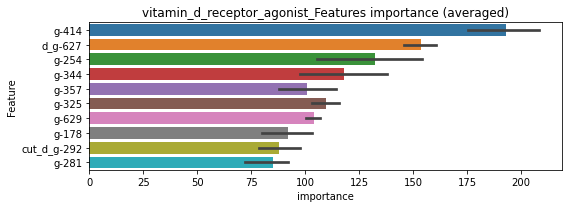

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141532	valid_1's binary_logloss: 0.027069
[200]	training's binary_logloss: 0.00185903	valid_1's binary_logloss: 0.011079
[300]	training's binary_logloss: 0.000495584	valid_1's binary_logloss: 0.00884246
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000275844	valid_1's binary_logloss: 0.00838574


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144584	valid_1's binary_logloss: 0.0245709
[200]	training's binary_logloss: 0.00179702	valid_1's binary_logloss: 0.00874566
[300]	training's binary_logloss: 0.000512456	valid_1's binary_logloss: 0.00640625
[400]	training's binary_logloss: 0.000261045	valid_1's binary_logloss: 0.00595418
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000216232	valid_1's binary_logloss: 0.00585921


vitamin_d_receptor_agonist logloss: 0.007122638374318996


neg labels: 3289 → selected neg labels: 3284


wnt_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285431	valid_1's binary_logloss: 0.0556209
[200]	training's binary_logloss: 0.00385255	valid_1's binary_logloss: 0.0187325
[300]	training's binary_logloss: 0.00111198	valid_1's binary_logloss: 0.0128628
[400]	training's binary_logloss: 0.000571998	valid_1's binary_logloss: 0.0109976
[500]	training's binary_logloss: 0.000405472	valid_1's binary_logloss: 0.0104582
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000405472	valid_1's binary_logloss: 0.0104582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294585	valid_1's binary_logloss: 0.0481965
[200]	training's binary_logloss: 0.00416504	valid_1's binary_logloss: 0.0159967
[300]	training's binary_logloss: 0.00118953	valid_1's binary_logloss: 0.0103128
[400]	training's binary_logloss: 0.000603427	valid_1's binary_logloss: 0.00834096
[500]	training's binary_logloss: 0.00041

1 / 3 AUC score:1.000
y_Threshold: 0.0017087, Threshold: 0.0025786, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00232, conf_1:0.00284
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0025786
Num_p_label: 0.0, Expected: 5.0, Adj_threshold_2: 0.0125786
threshold: 0.0125786, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028637	valid_1's binary_logloss: 0.0522929
[200]	training's binary_logloss: 0.00383898	valid_1's binary_logloss: 0.0174246
[300]	training's binary_logloss: 0.00111062	valid_1's binary_logloss: 0.0121334
[400]	training's binary_logloss: 0.00057271	valid_1's binary_logloss: 0.0103652
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00055477	valid_1's binary_logloss: 0.0103211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300076	valid_1's binary_logloss: 0.0476795
[200]	training's binary_logloss: 0.00424086	valid_1's binary_logloss: 0.0146877
[300]	training's binary_logloss: 0.00121343	valid_1's binary_logloss: 0.00886301
[400]	training's binary_logloss: 0.000610984	valid_1's binary_logloss: 0.00679962
[500]	training's binary_logloss: 0.000422746	valid_1's binary_logloss: 0.00604955
Early stopping, best iteration is:
[554]	

2 / 3 AUC score:1.000
y_Threshold: 0.0125848, Threshold: 0.0125786, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0027624 Vs.target_rate: 0.00126
Num_p_label: 11.0, conf_0:0.01132, conf_1:0.01384
threshold: 0.0125786, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028637	valid_1's binary_logloss: 0.0522929
[200]	training's binary_logloss: 0.00383898	valid_1's binary_logloss: 0.0174246
[300]	training's binary_logloss: 0.00111062	valid_1's binary_logloss: 0.0121334
[400]	training's binary_logloss: 0.00057271	valid_1's binary_logloss: 0.0103652
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00055477	valid_1's binary_logloss: 0.0103211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300076	valid_1's binary_logloss: 0.0476795
[200]	training's binary_logloss: 0.00424086	valid_1's binary_logloss: 0.0146877
[300]	training's binary_logloss: 0.00121343	valid_1's binary_logloss: 0.00886301
[400]	training's binary_logloss: 0.000610984	valid_1's binary_logloss: 0.00679962
[500]	training's binary_logloss: 0.000422746	valid_1's binary_logloss: 0.00604955
Early stopping, best iteration is:
[554]	

3 / 3 AUC score:1.000
y_Threshold: 0.0125848, Threshold: 0.0125786, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0027624 Vs.target_rate: 0.00126
Num_p_label: 11.0, conf_0:0.01132, conf_1:0.01384
threshold: 0.0125786, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7790, y_label_rate: 0.0856226


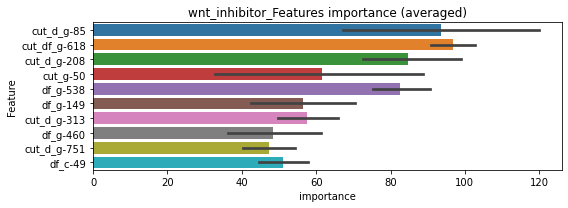

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161308	valid_1's binary_logloss: 0.0330945
[200]	training's binary_logloss: 0.00222136	valid_1's binary_logloss: 0.0173767
[300]	training's binary_logloss: 0.000617273	valid_1's binary_logloss: 0.0160081
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000611161	valid_1's binary_logloss: 0.016008


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166707	valid_1's binary_logloss: 0.027673
[200]	training's binary_logloss: 0.00233833	valid_1's binary_logloss: 0.0119923
[300]	training's binary_logloss: 0.00065617	valid_1's binary_logloss: 0.00962634
[400]	training's binary_logloss: 0.000327316	valid_1's binary_logloss: 0.00900342
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00034392	valid_1's binary_logloss: 0.00899215


wnt_inhibitor logloss: 0.012500101354210917


In [47]:
categorical_cols = []
scores = []
models = []
feature_importance_df = pd.DataFrame()
importance_cols_df = pd.DataFrame()

for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models, _feature_importance_df = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    if DEBUG:
        feature_importance_df = create_featureimprotance(models, feature_importance_df)
        importance_cols_df[target_col] = select_importance_cols(_feature_importance_df)

In [48]:
sub.to_csv('submission.csv', index=False)

In [49]:
print(f"CV:{np.mean(scores)}")

CV:0.01995550400829863


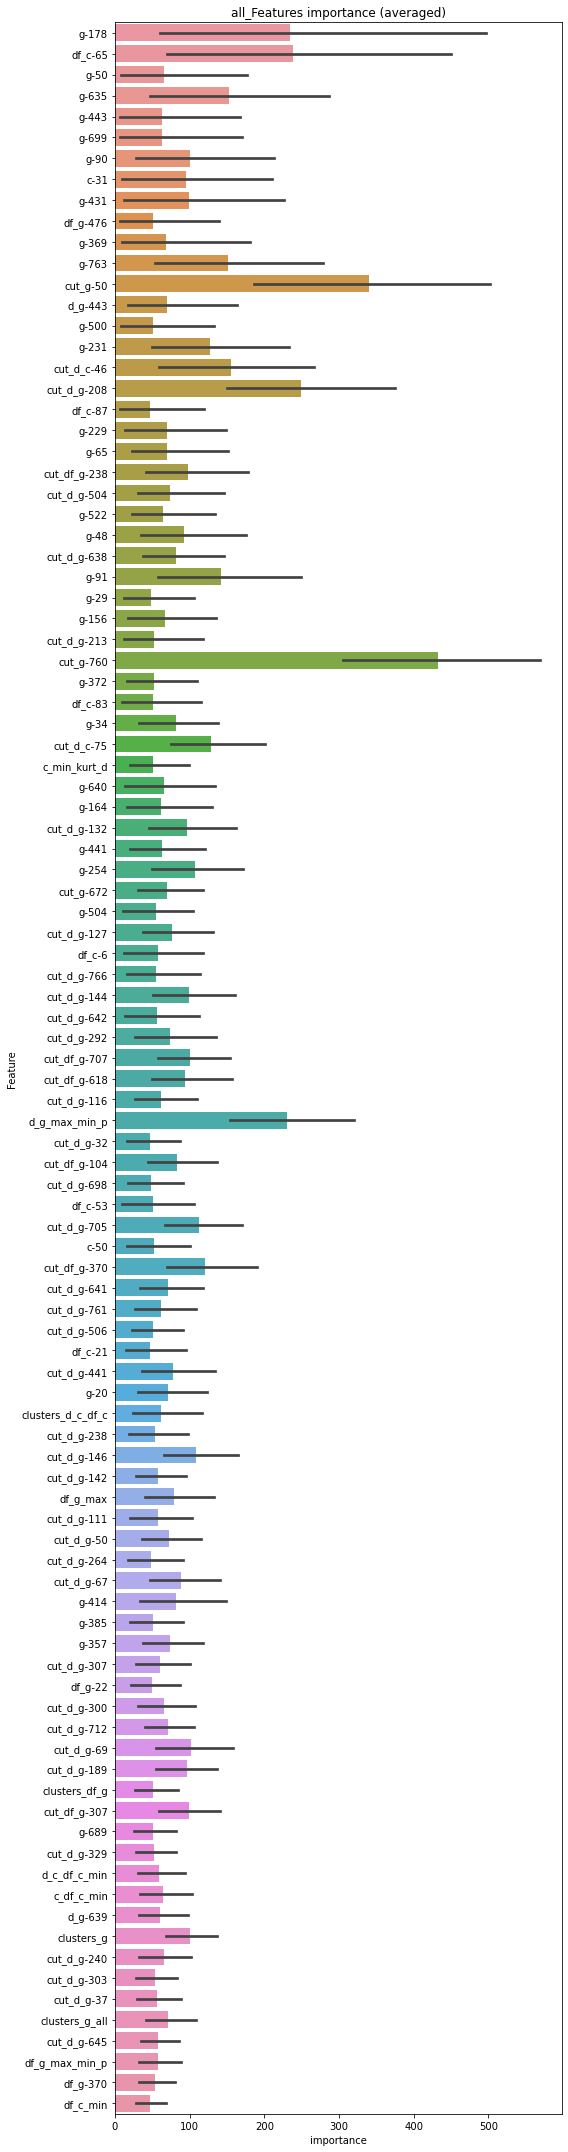

In [50]:
if DEBUG:
    show_feature_importance(feature_importance_df)
    feature_importance_df.to_csv(f'feature_importance_df.{Version}.csv', index=False)
    importance_cols_df.to_csv(f'importance_cols_df.{Version}.csv', index=False)